# Preparations

In [ ]:
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade tensorflow_probability
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
import collections
import random
import time
import numpy as np

import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_probability as tfp

# TODO(b/148678573,b/148685415): must use the reference context because it
# supports unbounded references and tff.sequence_* intrinsics.
tff.backends.reference.set_reference_context()

np.random.seed(12424)
random.seed(123132)

# Data

In [ ]:
class MnistDataMixed:
  def __init__(self, NUM_EXAMPLES_PER_USER, BATCH_SIZE, self_fraction):
    mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

    def generate_batches(source):
      datas = [[] for _ in range(10)]
      src = list(enumerate(source[1]))
      random.shuffle(src)
      for i, d in src:
        if random.random() < self_fraction:
          datas[d].append(i)
        else:
          digit = random.randint(0, 9)
          datas[digit].append(i)

      def get_data_for_digit(source, digit):
        output_sequence = []
        all_samples = datas[digit]
        for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
          batch_samples = all_samples[i:i + BATCH_SIZE]
          output_sequence.append({
              'x': np.array([source[0][i].flatten() / 255.0 for i in batch_samples], dtype=np.float32),
              'y': np.array([source[1][i] for i in batch_samples], dtype=np.int32)
          })

        return output_sequence

      return [get_data_for_digit(source, d) for d in range(10)]


    self.federated_train_data = generate_batches(mnist_train)
    self.federated_test_data = generate_batches(mnist_test)

  @property
  def train_data(self):
    return self.federated_train_data

  @property
  def test_data(self):
    return self.federated_test_data

In [ ]:
class FashionDataMixed:
  def __init__(self, NUM_EXAMPLES_PER_USER, BATCH_SIZE, self_fraction):
    fashion_train, fashion_test = tf.keras.datasets.fashion_mnist.load_data()

    def generate_batches(source):
      datas = [[] for _ in range(10)]
      src = list(enumerate(source[1]))
      random.shuffle(src)
      for i, d in src:
        if random.random() < self_fraction:
          datas[d].append(i)
        else:
          digit = random.randint(0, 9)
          datas[digit].append(i)

      def get_data_for_digit(source, digit):
        output_sequence = []
        all_samples = datas[digit]
        for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
          batch_samples = all_samples[i:i + BATCH_SIZE]
          output_sequence.append({
              'x': np.array([source[0][i].flatten() / 255.0 for i in batch_samples], dtype=np.float32),
              'y': np.array([source[1][i] for i in batch_samples], dtype=np.int32)
          })

        return output_sequence

      return [get_data_for_digit(source, d) for d in range(10)]


    self.federated_train_data = generate_batches(fashion_train)
    self.federated_test_data = generate_batches(fashion_test)

  @property
  def train_data(self):
    return self.federated_train_data

  @property
  def test_data(self):
    return self.federated_test_data

In [ ]:
class CifarDataMixed:
  def __init__(self, NUM_EXAMPLES_PER_USER, train_batches, self_fraction):
    cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()

    def generate_batches(source, BATCH_SIZE):
      datas = [[] for _ in range(10)]
      src = list(enumerate(source[1]))
      random.shuffle(src)
      for i, d in src:
        if random.random() < self_fraction:
          datas[d[0]].append(i)
        else:
          digit = random.randint(0, 9)
          datas[digit].append(i)

      def get_data_for_digit(source, digit):
        output_sequence = []
        all_samples = datas[digit]
        for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
          batch_samples = all_samples[i:i + BATCH_SIZE]
          output_sequence.append({
              'x': np.array([source[0][i] / 255.0 for i in batch_samples], dtype=np.float32),
              'y': np.array([source[1][i][0] for i in batch_samples], dtype=np.int32)
          })

        return output_sequence

      return [get_data_for_digit(source, d) for d in range(10)]


    self.federated_train_data = generate_batches(cifar_train, train_batches)
    self.federated_test_data = generate_batches(cifar_test, 100)

  @property
  def train_data(self):
    return self.federated_train_data

  @property
  def test_data(self):
    return self.federated_test_data

# Types

In [ ]:
class Types:
  def __init__(self, BATCH_SPEC, MODEL_SPEC):
    self.BATCH_SPEC = BATCH_SPEC
    self.MODEL_SPEC = MODEL_SPEC

    self.BATCH_TYPE = tff.to_type(self.BATCH_SPEC)

    self.CLIENT_BATCH_TYPE = tff.FederatedType(self.BATCH_TYPE, tff.CLIENTS)
    self.LOCAL_DATA_TYPE = tff.SequenceType(self.BATCH_TYPE)
    self.CLIENT_DATA_TYPE = tff.FederatedType(self.LOCAL_DATA_TYPE, tff.CLIENTS)

    self.MODEL_TYPE = tff.to_type(self.MODEL_SPEC)

    self.SERVER_MODEL_TYPE = tff.FederatedType(self.MODEL_TYPE, tff.SERVER)
    self.CLIENT_MODEL_TYPE = tff.FederatedType(self.MODEL_TYPE, tff.CLIENTS)


    self.SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)
    self.CLIENT_BOOL_TYPE = tff.FederatedType(tf.bool, tff.CLIENTS)

In [ ]:
CIFAR_BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 32, 32, 3], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))

CIFAR_MODEL_SPEC = collections.OrderedDict(
    conv1=tf.TensorSpec(shape=[3, 3, 3, 32], dtype=tf.float32),
    conv_bias1=tf.TensorSpec(shape=[1, 1, 32], dtype=tf.float32),
    conv2=tf.TensorSpec(shape=[3, 3, 32, 64], dtype=tf.float32),
    conv_bias2=tf.TensorSpec(shape=[1, 1, 64], dtype=tf.float32),
    conv3=tf.TensorSpec(shape=[3, 3, 64, 64], dtype=tf.float32),
    conv_bias3=tf.TensorSpec(shape=[1, 1, 64], dtype=tf.float32),
    weights1=tf.TensorSpec(shape=[1024, 64], dtype=tf.float32),
    bias1=tf.TensorSpec(shape=[64], dtype=tf.float32),
    weights2=tf.TensorSpec(shape=[64, 10], dtype=tf.float32),
    bias2=tf.TensorSpec(shape=[10], dtype=tf.float32)
)


cifar_types = Types(CIFAR_BATCH_SPEC, CIFAR_MODEL_SPEC)

In [ ]:
MNIST_BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))

MNIST_MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))

mnist_types = Types(MNIST_BATCH_SPEC, MNIST_MODEL_SPEC)

# Trainers

In [ ]:
class MnistTrainer:
  def __init__(self, types):
    @tf.function
    def compute_output(model, batch):
      return tf.matmul(batch['x'], model['weights']) + model['bias']

    @tf.function
    def forward_pass(model, batch):
      predicted_y = tf.nn.softmax(compute_output(model, batch))
      return -tf.reduce_mean(
          tf.reduce_sum(tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))
      
    @tff.tf_computation(types.MODEL_TYPE, types.BATCH_TYPE)
    def batch_loss(model, batch):
      return forward_pass(model, batch)

    @tff.tf_computation(types.MODEL_TYPE, types.BATCH_TYPE, tf.float32)
    def batch_train(initial_model, batch, learning_rate):
      model_vars = collections.OrderedDict([
          (name, tf.Variable(name=name, initial_value=value))
          for name, value in initial_model.items()
      ])
      optimizer = tf.keras.optimizers.SGD(learning_rate)

      @tf.function
      def _train_on_batch(model_vars, batch):
        with tf.GradientTape() as tape:
          loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(
            zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars

      return _train_on_batch(model_vars, batch)

    @tff.federated_computation(types.MODEL_TYPE, tf.float32, types.LOCAL_DATA_TYPE)
    def local_train(initial_model, learning_rate, all_batches):

      @tff.federated_computation(types.MODEL_TYPE, types.BATCH_TYPE)
      def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)

      return tff.sequence_reduce(all_batches, initial_model, batch_fn)
    
    @tff.federated_computation(types.CLIENT_MODEL_TYPE, types.SERVER_FLOAT_TYPE, types.CLIENT_DATA_TYPE)
    def federated_train(models, learning_rate, data):
      return tff.federated_map(local_train, [models, tff.federated_broadcast(learning_rate), data])

    self.batch_loss = batch_loss
    self.federated_train = federated_train
    self.compute_output = compute_output

mnist_trainer = MnistTrainer(mnist_types)

In [ ]:
class CifarTrainer:
  def __init__(self, types):
    from tensorflow.nn import softmax, conv2d, relu, max_pool2d
    @tf.function
    def compute_output(model, batch):
      x = batch['x']
      x = relu(model["conv_bias1"] + conv2d(x, model["conv1"], [1, 1], "VALID"))
      print(x.shape)
      x = max_pool2d(x, 2, 2, "VALID")
      print(x.shape)
      x = relu(model["conv_bias2"] + conv2d(x, model["conv2"], [1, 1], "VALID"))
      print(x.shape)
      x = max_pool2d(x, 2, 2, "VALID")
      print(x.shape)
      x = relu(model["conv_bias3"] + conv2d(x, model["conv3"], [1, 1], "VALID"))
      print(x.shape)
      x = tf.reshape(x, [-1, 1024])
      print(x.shape)
      x = relu(tf.matmul(x, model['weights1']) + model['bias1'])
      print(x.shape)
      x = tf.matmul(x, model['weights2']) + model['bias2']
      print(x.shape)
      return x


    @tf.function
    def forward_pass(model, batch):
      predicted_y = compute_output(model, batch)
      return tf.reduce_mean(
          tf.keras.losses.sparse_categorical_crossentropy(batch['y'], predicted_y, from_logits=True))
      
    @tff.tf_computation(types.MODEL_TYPE, types.BATCH_TYPE)
    def batch_loss(model, batch):
      return forward_pass(model, batch)

    @tff.tf_computation(types.MODEL_TYPE, types.BATCH_TYPE, tf.float32)
    def batch_train(initial_model, batch, learning_rate):
      model_vars = collections.OrderedDict([
          (name, tf.Variable(name=name, initial_value=value))
          for name, value in initial_model.items()
      ])
      optimizer = tf.keras.optimizers.SGD(learning_rate)

      @tf.function
      def _train_on_batch(model_vars, batch):
        with tf.GradientTape() as tape:
          loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(
            zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars

      return _train_on_batch(model_vars, batch)

    @tff.federated_computation(types.CLIENT_MODEL_TYPE, types.SERVER_FLOAT_TYPE, types.CLIENT_BATCH_TYPE)
    def federated_train(models, learning_rate, batches):
      return tff.federated_map(batch_train, [models, batches, tff.federated_broadcast(learning_rate)])

    self.compute_output = compute_output
    self.batch_loss = batch_loss
    self.federated_train = federated_train

cifar_trainer = CifarTrainer(cifar_types)

(None, 30, 30, 32)
(None, 15, 15, 32)
(None, 13, 13, 64)
(None, 6, 6, 64)
(None, 4, 4, 64)
(None, 1024)
(None, 64)
(None, 10)
(None, 30, 30, 32)
(None, 15, 15, 32)
(None, 13, 13, 64)
(None, 6, 6, 64)
(None, 4, 4, 64)
(None, 1024)
(None, 64)
(None, 10)


# Other classes

In [ ]:
class Eval:
  def __init__(self, types, trainer):
    @tff.federated_computation(types.MODEL_TYPE, types.LOCAL_DATA_TYPE)
    def local_eval(model, all_batches):
      # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
      return tff.sequence_sum(
          tff.sequence_map(
              tff.federated_computation(lambda b: trainer.batch_loss(model, b), types.BATCH_TYPE),
              all_batches))
      
    @tff.federated_computation(types.SERVER_MODEL_TYPE, types.CLIENT_DATA_TYPE)
    def federated_eval(model, data):
      return tff.federated_mean(
          tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))
    
    @tf.function
    def correct_per_batch(model, batch):
      output = trainer.compute_output(model, batch)
      predicted_y = tf.math.argmax(output, axis=1, output_type=tf.int32)
      return tf.math.count_nonzero(tf.math.equal(batch['y'], predicted_y))
      
    @tff.tf_computation(types.MODEL_TYPE, types.BATCH_TYPE)
    def batch_correct(model, batch):
      return correct_per_batch(model, batch)

    str(batch_correct.type_signature)
    @tff.federated_computation(types.MODEL_TYPE, types.LOCAL_DATA_TYPE)
    def local_correct(model, all_batches):
      return tff.sequence_sum(
          tff.sequence_map(
              tff.federated_computation(lambda b: batch_correct(model, b), types.BATCH_TYPE),
              all_batches))
      
    @tff.federated_computation(types.SERVER_MODEL_TYPE, types.CLIENT_DATA_TYPE)
    def federated_correct(model, data):
      return tff.federated_sum(
          tff.federated_map(local_correct, [tff.federated_broadcast(model), data]))
      
    @tff.tf_computation(types.BATCH_TYPE)
    def batch_size(batch):
      return tf.shape(batch['x'])[0]

    str(batch_size.type_signature)
    @tff.federated_computation(types.LOCAL_DATA_TYPE)
    def local_size(all_batches):
      # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
      return tff.sequence_sum(
          tff.sequence_map(
              tff.federated_computation(lambda b: batch_size(b), types.BATCH_TYPE),
              all_batches))
      
    @tff.federated_computation(types.CLIENT_DATA_TYPE)
    def federated_size(data):
      return tff.federated_sum(tff.federated_map(local_size, data))
    
    self.federated_eval = federated_eval
    self.federated_correct = federated_correct
    self.federated_size = federated_size

mnist_eval = Eval(mnist_types, mnist_trainer)
cifar_eval = Eval(cifar_types, cifar_trainer)

(None, 30, 30, 32)
(None, 15, 15, 32)
(None, 13, 13, 64)
(None, 6, 6, 64)
(None, 4, 4, 64)
(None, 1024)
(None, 64)
(None, 10)


In [ ]:
class Communication:
  def __init__(self, types):
    @tff.tf_computation(tf.bool, types.MODEL_TYPE, types.MODEL_TYPE)
    def first_if_true_tf(cond, x, y):
      return tf.cond(cond, lambda: x, lambda: y)

    @tff.federated_computation(tf.bool, types.MODEL_TYPE, types.MODEL_TYPE)
    def first_if_true(selected, x, y):
      return first_if_true_tf(selected, x, y)
    
    @tff.federated_computation(types.CLIENT_BOOL_TYPE, types.CLIENT_MODEL_TYPE, types.CLIENT_MODEL_TYPE)
    def update_comm_models(selected, models, comm_models):
      return tff.federated_map(first_if_true, [selected, models, comm_models])

    @tff.federated_computation(types.CLIENT_BOOL_TYPE, types.SERVER_MODEL_TYPE, types.CLIENT_MODEL_TYPE)
    def distribute_models(selected, server_model, client_models):
      return tff.federated_map(first_if_true, [selected, tff.federated_broadcast(server_model), client_models])

    @tff.federated_computation(types.SERVER_MODEL_TYPE, types.CLIENT_DATA_TYPE)
    def broadcast_model(model, data):
      @tff.federated_computation(types.MODEL_TYPE, types.LOCAL_DATA_TYPE)
      def take_first(model, data):
        return model

      return tff.federated_map(take_first, [tff.federated_broadcast(model), data])
    
    @tff.federated_computation(types.CLIENT_MODEL_TYPE)
    def average_models(comm_models):
      return tff.federated_mean(comm_models)
    
    self.update_comm_models = update_comm_models
    self.distribute_models = distribute_models
    self.broadcast_model = broadcast_model
    self.average_models = average_models

mnist_communication = Communication(mnist_types)
cifar_communication = Communication(cifar_types)

# Training preparation

In [ ]:
class Stats:
  def __init__(self, iterations, losses, accuracies, total_communications):
    self.iterations = iterations
    self.losses = losses
    self.accuracies = accuracies
    self.total_communications = total_communications
  
  def add(self, iteration, loss, acc, communication):
    self.iterations.append(iteration)
    self.losses.append(loss)
    self.accuracies.append(acc)
    self.total_communications.append(communication)
  
  def __repr__(self):
    return "Stats(iterations = {}, losses = {}, accuracies = {}, total_communications = {})".format(self.iterations, self.losses, self.accuracies, self.total_communications)

In [ ]:
def cifar_train(initial_model, num_rounds, model_selector, learning_rate,
          train_data, test_data, stats):
  eval, trainer, communication = cifar_eval, cifar_trainer, cifar_communication
  test_size = eval.federated_size(test_data)
  print("Test size:", test_size)

  client_models = communication.broadcast_model(initial_model, train_data)
  comm_models = client_models
  print('Initial model loss =', eval.federated_eval(initial_model, test_data))
  print('Initial model accuracy =', eval.federated_correct(initial_model, test_data) / test_size)
  current_total_comms = 0

  last_time = time.time()
  for round_num, selected in enumerate(model_selector(num_rounds, len(train_data))):
    current_total_comms += 2 * selected.count(True)
    round_data = [random.choice(data) for data in train_data]
    client_models = trainer.federated_train(client_models, learning_rate, round_data)
    comm_models = communication.update_comm_models(selected, client_models, comm_models)
    server_model = communication.average_models(comm_models)
    client_models = communication.distribute_models(selected, server_model, client_models)
    if round_num % 5 == 0:
      loss = eval.federated_eval(server_model, test_data)
      acc = eval.federated_correct(server_model, test_data) / test_size
      stats.add(round_num, loss, acc, current_total_comms)
      print('round {}, loss={}, acc={}, total_comm={}, time={}'.format(round_num, loss, acc, current_total_comms, time.time() - last_time))
      last_time = time.time()

In [ ]:
def mnist_train(initial_model, num_rounds, model_selector, learning_rate, train_data, test_data, stats):
  eval, trainer, communication = mnist_eval, mnist_trainer, mnist_communication
  test_size = eval.federated_size(test_data)
  print("Test size:", test_size)

  client_models = communication.broadcast_model(initial_model, train_data)
  comm_models = client_models
  print('Initial_model loss =', eval.federated_eval(initial_model, test_data))
  print('Initial_model accuracy =', eval.federated_correct(initial_model, test_data) / test_size)
  current_total_comms = 0

  last_time = time.time()
  for round_num, selected in enumerate(model_selector(num_rounds, len(train_data))):
    current_total_comms += 2 * selected.count(True)
    client_models = trainer.federated_train(client_models, learning_rate, train_data)
    comm_models = communication.update_comm_models(selected, client_models, comm_models)
    server_model = communication.average_models(comm_models)
    client_models = communication.distribute_models(selected, server_model, client_models)
    if round_num < 10 or round_num % 5 == 0:
    # if True:
      # loss = 1
      loss = eval.federated_eval(server_model, test_data)
      # acc = 1
      acc = eval.federated_correct(server_model, test_data) / test_size
      stats.add(round_num, loss, acc, current_total_comms)
      print('round {}, loss={}, acc={}, total_comm={}, time={}'.format(round_num, loss, acc, current_total_comms, time.time() - last_time))
      last_time = time.time()

In [ ]:
def random_selector(p, delta):
  def selector(num_rounds, num_clients):
    for round in range(num_rounds):
      if round % delta != 0:
        yield [False] * num_clients
      else:
        yield [random.random() < p for _ in range(num_clients)]

  return selector

In [ ]:
def round_robin(k, delta):
  def selector(num_rounds, num_clients):
    last = 0
    for round in range(num_rounds):
      res = [False] * num_clients
      if round % delta == 0:
        for _ in range(k):
          res[last] = True
          last = (last + 1) % num_clients
      yield res

  return selector

In [ ]:
def get_selector(communication, delta):
  if communication == "Full":
    return round_robin(10, delta)
  elif communication == "Round":
    return round_robin(2, delta)
  elif communication == "Random":
    return random_selector(0.2 / delta, 1)
  else:
    assert False

# Initial models

In [ ]:
initializer = tf.keras.initializers.GlorotUniform()

def initialize_weights(shape):
  return tf.cast(initializer(shape=shape), np.float32)

def initialize_bias(shape):
  return np.zeros(shape=shape, dtype=np.float32)

cifar_initial_model = collections.OrderedDict(
    conv1=initialize_weights([3, 3, 3, 32]),
    conv_bias1=initialize_bias([1, 1, 32]),
    conv2=initialize_weights([3, 3, 32, 64]),
    conv_bias2=initialize_bias([1, 1, 64]),
    conv3=initialize_weights([3, 3, 64, 64]),
    conv_bias3=initialize_bias([1, 1, 64]),
    weights1=initialize_weights([1024, 64]),
    bias1=initialize_bias([64]),
    weights2=initialize_weights([64, 10]),
    bias2=initialize_bias([10])
)

In [ ]:
mnist_initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

# Training

### Mnist

In [ ]:
# Keys are triples: (communication model (Full/Random/Round), delta, non-iid-ness ([0-1]))
mnist_stats = {}

for comm in ["Full", "Round", "Random"]:
  for delta in [1, 5]:
    for nonIid in [0, 0.5, 0.9, 1]:
      print(comm, delta, nonIid)
      num_iters = 101 if comm == "Full" or delta == 1 else 376
      mnist = MnistDataMixed(1000, 100, nonIid)
      stats = Stats([], [], [], [])
      mnist_stats[(comm, delta, nonIid)] = stats
      mnist_train(mnist_initial_model, num_iters, get_selector(comm, delta), 0.1,
                  mnist.train_data, mnist.test_data, stats)
      print("")
      print("mnist_stats =", mnist_stats)

In [ ]:
# Keys are triples: (communication model (Full/Random/Round), delta, non-iid-ness ([0-1]))
fashion_stats = {}

for comm in ["Full", "Round", "Random"]:
  for delta in [1, 5]:
    for nonIid in [0, 0.5, 0.9, 1]:
      print(comm, delta, nonIid)
      num_iters = 101 if comm == "Full" or delta == 1 else 376
      mnist = FashionDataMixed(1000, 100, nonIid)
      stats = Stats([], [], [], [])
      mnist_stats[(comm, delta, nonIid)] = stats
      mnist_train(mnist_initial_model, num_iters, get_selector(comm, delta), 0.1,
                  mnist.train_data, mnist.test_data, stats)
      print("")
      print("mnist_stats =", mnist_stats)

### Cifar

In [ ]:
# Keys are triples: (communication model (Full/Random/Round), delta, non-iid-ness ([0-1]))
cifar_stats = {}

for comm in ["Full", "Round", "Random"]:
  for delta in [1, 5]:
    for nonIid in [0, 0.5, 0.9, 1]:
      print(comm, delta, nonIid)
      num_iters = 2501 if comm == "Full" or delta == 1 else 9001
      cifar = CifarDataMixed(5000, 20, nonIid)
      stats = Stats([], [], [], [])
      cifar_stats[(comm, delta, nonIid)] = stats
      cifar_train(cifar_initial_model, num_iters, get_selector(comm, delta), 0.1,
                  cifar.train_data, cifar.test_data, stats)
      print("")
      print("cifar_stats =", cifar_stats)

# Results

Run the following cells to get the results without running the computations above

In [ ]:
mnist_stats = {('Full', 1, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [15.314468, 11.639275, 9.689081, 8.50511, 7.71073, 7.1387634, 6.7053895, 6.36428, 6.0878057, 5.8584685, 5.664635, 5.012705, 4.631937, 4.3772, 4.192498, 4.051262, 3.9391098, 3.847509, 3.771043, 3.7060902, 3.6501248, 3.6013303, 3.5583587, 3.5201888, 3.486031, 3.4552639, 3.4273915, 3.4020112, 3.378795], accuracies = [0.7958708632729481, 0.8196538811861148, 0.8350369395810141, 0.8441453294200992, 0.8507236109705495, 0.856289849205546, 0.862260904766724, 0.8653982390446311, 0.8685355733225382, 0.870559659953446, 0.873393381236717, 0.8792632324663495, 0.8840198360489829, 0.8890800526262524, 0.8918125695779779, 0.8943426778666127, 0.8970751948183382, 0.8995040987754276, 0.9000101204331545, 0.9015281854063354, 0.9024390243902439, 0.9037546807003339, 0.9047667240157878, 0.905070337010424, 0.9049691326788787, 0.905576358668151, 0.9064871976520595, 0.9068920149782411, 0.9073980366359681], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 1, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [17.168026, 13.619308, 11.419511, 9.980814, 8.982193, 8.252164, 7.6955476, 7.2566247, 6.9010253, 6.6065407, 6.3582263, 5.529599, 5.0526195, 4.737306, 4.5106916, 4.338468, 4.2022643, 4.091298, 3.9987953, 3.9202647, 3.8526025, 3.7935867, 3.741579, 3.695345, 3.6539314, 3.616591, 3.582728, 3.5518615, 3.5235972], accuracies = [0.7539181762670466, 0.7855688988398127, 0.8086708731935681, 0.8200692041522492, 0.8289232648076532, 0.8361489924689599, 0.8429676368817424, 0.8481579483004275, 0.8533482597191125, 0.8560960716466517, 0.8598615916955017, 0.8701404437207408, 0.8770608589456543, 0.881742316303684, 0.885507836352534, 0.889171585589253, 0.8914105434561368, 0.8932424180744962, 0.8950742926928557, 0.8969061673112152, 0.8977203338082638, 0.8987380419295746, 0.9000610624872787, 0.9002646041115409, 0.9009769997964584, 0.9021982495420313, 0.90301241603908, 0.9035212700997354, 0.9043354365967841], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 1, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.495518, 18.364124, 16.580492, 15.097717, 13.866809, 12.841504, 11.981981, 11.255745, 10.63695, 10.10524, 9.644613, 8.046298, 7.104992, 6.48481, 6.0436544, 5.71237, 5.4534826, 5.2449427, 5.072921, 4.9282846, 4.804755, 4.6978636, 4.6043386, 4.5217276, 4.448153, 4.382152, 4.322567, 4.2684684, 4.2191033], accuracies = [0.7994693336054699, 0.7980406163894275, 0.7995713848351873, 0.8018165118889683, 0.8057965098479437, 0.8099806102663537, 0.814572915603633, 0.8195734258597817, 0.8220226553729972, 0.8264108582508419, 0.8303908562098173, 0.8438616185325033, 0.8568221247066027, 0.8637616083273804, 0.8697826308807021, 0.8744769874476988, 0.8769262169609143, 0.8800898050821513, 0.8827431370548016, 0.8854985202571691, 0.8874374936217981, 0.8881518522298194, 0.890294928053883, 0.890601081743035, 0.8911113378916216, 0.8926421063373814, 0.8942749260128584, 0.8948872333911624, 0.895703643228901], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 1, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [21.414913, 20.163586, 19.028515, 18.000357, 17.07011, 16.228727, 15.467334, 14.777527, 14.151553, 13.582397, 13.063772, 11.054953, 9.7033205, 8.743574, 8.030905, 7.482189, 7.047136, 6.6938353, 6.4011736, 6.154677, 5.9441166, 5.7620673, 5.603017, 5.4627867, 5.338157, 5.2266045, 5.126125, 5.035105, 4.952235], accuracies = [0.7617003883098303, 0.7782546494992847, 0.7845902309421623, 0.7865317800940118, 0.7900061312078479, 0.7929695483343552, 0.7971592070304516, 0.8017576129164112, 0.8044144696505211, 0.8071735131820968, 0.8109544246883302, 0.8244430819538116, 0.8345595749029225, 0.8416104639280605, 0.8473329245861435, 0.8525444512568976, 0.8585734723073779, 0.8625587574085428, 0.8656243613325159, 0.8686899652564889, 0.8706315144083384, 0.872573063560188, 0.8742080523196403, 0.8760474146740241, 0.8771714694461475, 0.8778867770284079, 0.8788064582055999, 0.8805436337625179, 0.8820764357245044], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 5, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [15.327423, 15.327423, 15.327423, 15.327423, 15.327423, 7.179286, 7.179286, 7.179286, 7.179286, 7.179286, 5.6816115, 5.0235853, 4.6422443, 4.3886385, 4.205476, 4.0657344, 3.9548805, 3.864347, 3.7887268, 3.7244244, 3.668944, 3.620496, 3.577758, 3.5397315, 3.5056443, 3.4748898, 3.4469848, 3.4215374, 3.3982282], accuracies = [0.786577992744861, 0.786577992744861, 0.786577992744861, 0.786577992744861, 0.786577992744861, 0.855602579604998, 0.855602579604998, 0.855602579604998, 0.855602579604998, 0.855602579604998, 0.8732365981459089, 0.8813986295848448, 0.8853284965739621, 0.8881499395405078, 0.8899637243047158, 0.8919790407093914, 0.8938935912938332, 0.8965135026199114, 0.8985288190245868, 0.8993349455864571, 0.9009471987101975, 0.9012494961708988, 0.9021563885530028, 0.902962515114873, 0.9034663442160419, 0.9050785973397824, 0.9054816606207174, 0.9061870213623539, 0.9069931479242241], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Full', 5, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [17.197302, 17.197302, 17.197302, 17.197302, 17.197302, 8.68284, 8.68284, 8.68284, 8.68284, 8.68284, 6.611287, 5.700039, 5.1790714, 4.8373876, 4.593717, 4.4098916, 4.265507, 4.1486125, 4.051717, 3.9698696, 3.8996606, 3.838657, 3.7850769, 3.7375789, 3.6951356, 3.6569448, 3.6223698, 3.5908992, 3.5621161], accuracies = [0.7722239154729249, 0.7722239154729249, 0.7722239154729249, 0.7722239154729249, 0.7722239154729249, 0.8422228995225033, 0.8422228995225033, 0.8422228995225033, 0.8422228995225033, 0.8422228995225033, 0.8627450980392157, 0.8723966270446002, 0.8785939246164787, 0.8831657015137662, 0.8857055775678147, 0.888550238748349, 0.8907853296759118, 0.8926140404348267, 0.8943411561515798, 0.8952555115310373, 0.8969826272477903, 0.8983033627958955, 0.8990145280910291, 0.8996240983440008, 0.9011480239764299, 0.9021639743980494, 0.9024687595245352, 0.9023671644823733, 0.9031799248196688], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Full', 5, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.49397, 20.49397, 20.49397, 20.49397, 20.49397, 14.950712, 14.950712, 14.950712, 14.950712, 14.950712, 11.774037, 9.865436, 8.638858, 7.7969756, 7.187022, 6.725787, 6.364976, 6.074935, 5.83656, 5.637031, 5.4674435, 5.3214226, 5.194291, 5.0825377, 4.9834757, 4.8950167, 4.815507, 4.7436256, 4.678302], accuracies = [0.7356661905733524, 0.7356661905733524, 0.7356661905733524, 0.7356661905733524, 0.7356661905733524, 0.7495409100183636, 0.7495409100183636, 0.7495409100183636, 0.7495409100183636, 0.7495409100183636, 0.7839216486431341, 0.8059579677616813, 0.8230973270761069, 0.8344215466231382, 0.8448275862068966, 0.8515609059375637, 0.8559477657620894, 0.8596204856151806, 0.8637012854519486, 0.866455825341767, 0.867986125280555, 0.8701285451948582, 0.8721689451132422, 0.8745154050193839, 0.875637624974495, 0.876657824933687, 0.878188124872475, 0.8785962048561518, 0.880228524790859], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Full', 5, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [21.371246, 21.371246, 21.371246, 21.371246, 21.371246, 19.800867, 19.800867, 19.800867, 19.800867, 19.800867, 18.399557, 17.15572, 16.056944, 15.08847, 14.234769, 13.480913, 12.813319, 12.220049, 11.690802, 11.216798, 10.790583, 10.405854, 10.057261, 9.740274, 9.451033, 9.186245, 8.943092, 8.719148, 8.512321], accuracies = [0.7560801144492132, 0.7560801144492132, 0.7560801144492132, 0.7560801144492132, 0.7560801144492132, 0.7393214796648273, 0.7393214796648273, 0.7393214796648273, 0.7393214796648273, 0.7393214796648273, 0.7534232577151032, 0.7651747394236664, 0.7760065399550378, 0.7820355610055181, 0.7888820764357245, 0.7955242182709994, 0.800940118536685, 0.8051297772327816, 0.8091150623339465, 0.8138156550173717, 0.8169834457388105, 0.8206621704475782, 0.8237277743715512, 0.8265890047005927, 0.8288371142448395, 0.8304721030042919, 0.8320049049662783, 0.8335377069282649, 0.8367054976497037], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Random', 1, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.387018, 20.387018, 16.468874, 15.008487, 11.230827, 11.072469, 11.059851, 10.736458, 9.38246, 8.4069395, 8.347716, 7.16582, 5.959941, 5.4572306, 5.0587525, 4.9476557, 4.803975, 4.59122, 4.375524, 4.2690716, 4.166199, 4.096881, 4.0315676, 3.9991393, 3.909008, 3.8465905, 3.8121498, 3.78839, 3.7597947], accuracies = [0.7468341606726775, 0.7468341606726775, 0.8100496403606524, 0.8159254381521629, 0.8289940228953501, 0.8308175463478877, 0.830918853206362, 0.8357815824131294, 0.842670448789383, 0.8482423260054706, 0.8494580083071624, 0.8615135244656064, 0.8690102319927059, 0.8746834160672677, 0.8784317698308175, 0.8803566001418296, 0.8829905784621619, 0.8853206362070712, 0.8892716036875696, 0.8917029682909533, 0.8922095025833249, 0.8933238780265425, 0.8944382534697599, 0.8948434809036572, 0.8958565494884003, 0.8968696180731436, 0.8971735386485665, 0.8978826866578867, 0.8990983689595785], total_communications = [6, 6, 12, 16, 22, 28, 30, 34, 40, 46, 48, 76, 94, 116, 140, 160, 184, 202, 228, 254, 274, 288, 308, 318, 344, 358, 376, 396, 410]),
 ('Random', 1, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.329527, 22.329527, 19.645473, 19.645473, 19.645473, 19.645473, 14.296761, 12.734721, 13.961314, 14.418645, 14.418645, 10.073626, 6.7985115, 6.718488, 5.9747906, 5.7666, 5.5677443, 5.4243426, 5.0794134, 4.863505, 4.7352085, 4.6023073, 4.5259967, 4.4190536, 4.2901697, 4.2879114, 4.2493973, 4.1006536, 4.0656943], accuracies = [0.3620060790273556, 0.3620060790273556, 0.6374873353596758, 0.6374873353596758, 0.6374873353596758, 0.6374873353596758, 0.8015197568389058, 0.8175278622087133, 0.7982776089159068, 0.7897669706180345, 0.7897669706180345, 0.8407294832826747, 0.8604863221884499, 0.8621073961499494, 0.867983789260385, 0.87193515704154, 0.8741641337386018, 0.875177304964539, 0.8778115501519757, 0.881661600810537, 0.8835866261398176, 0.8855116514690983, 0.8865248226950354, 0.8880445795339412, 0.8894630192502533, 0.889564336372847, 0.890273556231003, 0.8927051671732523, 0.8936170212765957], total_communications = [2, 2, 6, 6, 6, 6, 12, 14, 20, 26, 26, 44, 64, 82, 104, 122, 130, 142, 168, 200, 216, 240, 250, 270, 288, 304, 310, 332, 352]),
 ('Random', 1, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.574879, 21.857569, 21.227589, 21.227589, 20.346027, 20.346027, 19.970627, 19.325457, 18.343283, 17.707163, 17.707163, 13.989565, 12.503008, 11.140472, 10.273895, 9.61388, 9.207428, 8.578379, 7.84395, 7.573022, 7.2668, 6.9906096, 6.841014, 6.5790596, 6.4414277, 6.333289, 6.0937667, 5.983131, 5.885049], accuracies = [0.24102407180742555, 0.34832721338229294, 0.41646266829865364, 0.41646266829865364, 0.5008159934720522, 0.5008159934720522, 0.5300897592819257, 0.6043451652386781, 0.6300489596083231, 0.6352509179926561, 0.6352509179926561, 0.7670338637290902, 0.7906976744186046, 0.8017135862913096, 0.8091595267237862, 0.8153814769481844, 0.8204814361485108, 0.8302733578131375, 0.8379232966136271, 0.8440432476540187, 0.8481232150142799, 0.8486332109343125, 0.8511831905344758, 0.854141166870665, 0.8551611587107303, 0.8565891472868217, 0.8600571195430436, 0.8598531211750307, 0.8603631170950632], total_communications = [6, 10, 14, 14, 18, 18, 20, 26, 30, 34, 34, 62, 88, 118, 134, 148, 158, 188, 216, 238, 266, 294, 310, 328, 354, 366, 386, 410, 424]),
 ('Random', 1, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.795593, 22.796253, 22.297634, 22.092205, 21.58839, 21.58839, 21.532734, 21.383469, 20.87321, 20.802822, 20.689695, 20.143854, 19.693241, 18.638165, 17.41846, 16.758835, 16.018215, 15.354108, 15.038852, 14.605677, 14.139506, 13.699432, 13.479151, 13.107724, 12.845836, 12.381359, 12.220581, 11.915476, 11.57617], accuracies = [0.10014306151645208, 0.290414878397711, 0.45943184140609034, 0.5156345800122624, 0.6192519926425506, 0.6192519926425506, 0.6072961373390557, 0.40220723482526055, 0.42530145105252404, 0.4422644594318414, 0.5156345800122624, 0.5146127120376047, 0.507050889025138, 0.6821990598814633, 0.7509707745759248, 0.7255262620069487, 0.7655834866135295, 0.7800940118536686, 0.7701818924994891, 0.7313509094624975, 0.7822399346004496, 0.7507664009809932, 0.7241978336398938, 0.728898426323319, 0.7562844880441447, 0.7536276313100347, 0.7479051706519517, 0.7806049458409974, 0.7642550582464746], total_communications = [0, 6, 14, 16, 20, 20, 22, 30, 34, 36, 38, 58, 74, 92, 122, 142, 166, 188, 204, 222, 242, 260, 280, 300, 314, 340, 360, 378, 400]),
 ('Random', 5, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [23.025852, 20.140352, 20.140352, 20.140352, 20.140352, 20.140352, 20.140352, 17.413326, 17.413326, 17.413326, 14.776988, 12.269405, 8.217836, 7.0527563, 6.14247, 6.0803065, 5.0707536, 4.588023, 4.5044146, 4.5441704, 4.568864, 4.547376, 4.431117, 4.439725, 4.2779145, 4.118775, 4.1092086, 3.9942257, 3.9733348, 3.9100978, 3.9437351, 3.9243844, 3.826572, 3.7379818, 3.7318435, 3.7318435, 3.7044373, 3.6846442, 3.5886161, 3.5699203, 3.5684292, 3.5697365, 3.5638714, 3.5612617, 3.5474422, 3.5452309, 3.5452309, 3.5480037, 3.5351696, 3.5351696, 3.4778485, 3.4316432, 3.4394774, 3.438311, 3.416008, 3.3961322, 3.3961322, 3.3961322, 3.3943057, 3.3845322, 3.3489532, 3.3489532, 3.2945106, 3.2933052, 3.2933052, 3.2857292, 3.2929084, 3.2929084, 3.2624633, 3.2634082, 3.2555146, 3.2562091, 3.2570233, 3.2570233, 3.2479253, 3.2500987, 3.2453742, 3.2454536, 3.2157128, 3.2108147, 3.1888433, 3.200993, 3.1923575, 3.1864483], accuracies = [0.09811855148695124, 0.8073032571312968, 0.8073032571312968, 0.8073032571312968, 0.8073032571312968, 0.8073032571312968, 0.8073032571312968, 0.8379526603277362, 0.8379526603277362, 0.8379526603277362, 0.8513048755816306, 0.8623305684806798, 0.8711308921707465, 0.8758850900262998, 0.8759862431721627, 0.8761885494638884, 0.8849888731539551, 0.8858992514667207, 0.887517701800526, 0.8872142423629374, 0.8873153955088003, 0.8876188549463888, 0.8891361521343314, 0.8890349989884685, 0.8914626744891766, 0.8922718996560793, 0.8931822779688449, 0.894901881448513, 0.8952053408861016, 0.8958122597612785, 0.8958122597612785, 0.8963180254905928, 0.8973295569492211, 0.8982399352619866, 0.8989480072830265, 0.8989480072830265, 0.8987457009913008, 0.9001618450333806, 0.9010722233461461, 0.9022860610965001, 0.9024883673882258, 0.9027918268258143, 0.9024883673882258, 0.9025895205340886, 0.9023872142423629, 0.9024883673882258, 0.9024883673882258, 0.9030952862634027, 0.9024883673882258, 0.9024883673882258, 0.9044102771596196, 0.9049160428889338, 0.9049160428889338, 0.9050171960347967, 0.9051183491806595, 0.9055229617641108, 0.9055229617641108, 0.9055229617641108, 0.9052195023265224, 0.9059275743475622, 0.9058264212016994, 0.9058264212016994, 0.9070402589520534, 0.9073437183896419, 0.9073437183896419, 0.9077483309730933, 0.9071414120979162, 0.9071414120979162, 0.9073437183896419, 0.9080517904106817, 0.908557556139996, 0.9086587092858588, 0.908557556139996, 0.908557556139996, 0.9081529435565446, 0.908557556139996, 0.9086587092858588, 0.9089621687234473, 0.9083552498482703, 0.9086587092858588, 0.90977139389035, 0.908557556139996, 0.9088610155775845, 0.9090633218693102], total_communications = [0, 4, 4, 4, 4, 4, 4, 6, 6, 6, 8, 10, 18, 24, 28, 30, 36, 38, 42, 52, 56, 58, 62, 64, 66, 68, 72, 76, 80, 82, 84, 86, 88, 100, 104, 104, 106, 112, 116, 128, 136, 140, 144, 146, 148, 150, 150, 152, 154, 154, 160, 164, 168, 170, 174, 176, 176, 176, 178, 186, 188, 188, 192, 194, 194, 200, 212, 212, 220, 226, 234, 238, 240, 240, 246, 248, 250, 252, 256, 260, 264, 270, 272, 274]),
 ('Random', 5, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [23.025852, 23.025852, 21.60051, 21.60051, 19.720043, 20.71064, 20.71064, 20.395096, 20.395096, 20.395096, 20.395096, 13.696635, 13.696635, 8.327907, 8.336927, 8.336927, 8.11305, 7.1628776, 7.2901316, 5.7491355, 5.7491355, 4.71127, 4.5163083, 4.439403, 4.368146, 4.3016043, 4.240065, 4.2187943, 4.2187943, 4.176799, 4.1869893, 4.1431813, 4.0198584, 3.9915376, 3.9454975, 3.9431183, 3.9439576, 3.9287171, 3.9287171, 3.9287171, 3.8464203, 3.8802161, 3.8802161, 3.8303204, 3.8320408, 3.8104565, 3.8104565, 3.737004, 3.731629, 3.6508725, 3.6517494, 3.6710954, 3.6061387, 3.6064727, 3.5803668, 3.574667, 3.5706203, 3.550904, 3.5351386, 3.5351386, 3.5329578, 3.5125802, 3.5018337, 3.4891593, 3.4880314, 3.4851246, 3.483521, 3.4766216, 3.476503, 3.476503, 3.4728882, 3.4591217, 3.4414887, 3.442208, 3.428971, 3.4281573, 3.4281573, 3.4125571, 3.4125571, 3.4001973, 3.399997, 3.371732, 3.371732, 3.3793957], accuracies = [0.09768715763846622, 0.09768715763846622, 0.5330695881517549, 0.5330695881517549, 0.655609657131264, 0.5535605599513086, 0.5535605599513086, 0.5906877662811929, 0.5906877662811929, 0.5906877662811929, 0.5906877662811929, 0.825015216068168, 0.825015216068168, 0.8597078514911747, 0.8590992087644552, 0.8590992087644552, 0.8612294583079733, 0.8642726719415703, 0.8632582673970379, 0.8744167173868939, 0.8744167173868939, 0.8828362751065125, 0.8852708460133901, 0.8851694055589369, 0.8871982146480016, 0.8879082978291742, 0.888618381010347, 0.8889227023737066, 0.8889227023737066, 0.8896327855548792, 0.8894299046459728, 0.890342868736052, 0.8923716778251166, 0.8937918441874619, 0.8945019273686347, 0.8949076891864476, 0.8950091296409007, 0.8949076891864476, 0.8949076891864476, 0.8949076891864476, 0.8962264150943396, 0.8958206532765267, 0.8958206532765267, 0.8967336173666058, 0.8974437005477784, 0.8975451410022317, 0.8975451410022317, 0.8973422600933252, 0.8977480219111381, 0.8986609860012172, 0.8990667478190302, 0.898965307364577, 0.89937106918239, 0.8994725096368432, 0.9001825928180158, 0.8996753905457496, 0.8999797119091093, 0.9011969973625482, 0.9018056400892676, 0.9018056400892676, 0.9029214850882532, 0.9036315682694258, 0.9034286873605194, 0.9037330087238791, 0.9035301278149727, 0.9040373300872387, 0.904138770541692, 0.9034286873605194, 0.9033272469060661, 0.9033272469060661, 0.9033272469060661, 0.904138770541692, 0.9047474132684115, 0.9046459728139582, 0.9048488537228647, 0.9042402109961453, 0.9042402109961453, 0.9037330087238791, 0.9037330087238791, 0.9037330087238791, 0.9042402109961453, 0.9050517346317711, 0.9050517346317711, 0.9054574964495841], total_communications = [0, 0, 2, 2, 4, 6, 6, 8, 8, 8, 8, 16, 16, 22, 30, 30, 32, 36, 42, 52, 52, 60, 68, 74, 80, 88, 96, 100, 100, 108, 110, 112, 118, 124, 126, 138, 142, 148, 148, 148, 152, 156, 156, 160, 166, 168, 168, 174, 176, 182, 184, 190, 192, 194, 200, 204, 206, 214, 226, 226, 230, 236, 242, 254, 256, 260, 264, 270, 272, 272, 274, 280, 288, 290, 296, 300, 300, 302, 302, 316, 318, 324, 324, 332]),
 ('Random', 5, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [22.564579, 22.564579, 22.164705, 22.164705, 22.164705, 22.164705, 22.022526, 22.022526, 22.022526, 22.022526, 22.011103, 18.127808, 14.658404, 13.359515, 13.051378, 13.021622, 13.021622, 12.345992, 12.345992, 11.510557, 10.98118, 9.7341795, 9.421061, 8.312292, 8.312292, 7.4619684, 6.902723, 6.782468, 6.553314, 6.5212374, 6.5212374, 6.5212374, 6.505191, 6.4212236, 6.312697, 5.924541, 5.8582153, 5.841897, 5.8602905, 5.6409035, 5.5591164, 5.351996, 5.315242, 5.2685432, 5.215578, 5.167337, 5.124073, 5.086285, 5.056356, 5.0435, 4.9777865, 4.9777865, 4.9978623, 4.912649, 4.887106, 4.799475, 4.7796335, 4.7779093, 4.7779093, 4.7779093, 4.7779093, 4.7511435, 4.695134, 4.7135215, 4.6658583, 4.658068, 4.504136, 4.48647, 4.4515543, 4.4311666, 4.3963037, 4.3963037, 4.393947, 4.3935747, 4.3935747, 4.358043, 4.2793503, 4.277072, 4.2633524, 4.239853, 4.199235, 4.1889143, 4.1777735, 4.1687574], accuracies = [0.09780275932549821, 0.09780275932549821, 0.19448134900357691, 0.19448134900357691, 0.19448134900357691, 0.19448134900357691, 0.1941747572815534, 0.1941747572815534, 0.1941747572815534, 0.1941747572815534, 0.1941747572815534, 0.5609606540623403, 0.7137455288707205, 0.7752682677567706, 0.7775166070516096, 0.7774144098109351, 0.7774144098109351, 0.7944813490035769, 0.7944813490035769, 0.8080735820132856, 0.8155339805825242, 0.8211548288196219, 0.8261624936126725, 0.8462953500255493, 0.8462953500255493, 0.8522227899846704, 0.8534491568727645, 0.8545733265201839, 0.8547777210015329, 0.8561062851303015, 0.8561062851303015, 0.8561062851303015, 0.8583546244251405, 0.859274399591211, 0.8595809913132345, 0.8640776699029126, 0.8648952478283086, 0.8635666836995401, 0.8637710781808892, 0.8657128257537047, 0.8661216147164027, 0.8683699540112417, 0.8692897291773122, 0.8698007153806847, 0.8701073071027082, 0.8709248850281043, 0.8718446601941747, 0.8708226877874298, 0.8718446601941747, 0.8721512519161982, 0.8740929994890138, 0.8740929994890138, 0.8728666326009198, 0.8721512519161982, 0.8725600408788963, 0.8748083801737353, 0.8756259580991314, 0.8755237608584568, 0.8755237608584568, 0.8755237608584568, 0.8755237608584568, 0.8754215636177823, 0.8766479305058763, 0.8767501277465508, 0.8756259580991314, 0.8763413387838528, 0.8805314256515074, 0.8804292284108329, 0.880838017373531, 0.882473173224323, 0.8831885539090445, 0.8831885539090445, 0.882473173224323, 0.882677567705672, 0.882677567705672, 0.8838017373530914, 0.884925907000511, 0.8846193152784875, 0.884721512519162, 0.885743484925907, 0.8877874297393971, 0.8877874297393971, 0.8879918242207461, 0.887583035258048], total_communications = [2, 2, 4, 4, 4, 4, 6, 6, 6, 6, 8, 14, 28, 30, 34, 36, 36, 40, 40, 42, 44, 48, 52, 56, 56, 62, 70, 80, 86, 88, 88, 88, 96, 98, 100, 110, 112, 116, 118, 128, 130, 136, 142, 148, 150, 154, 156, 160, 166, 170, 182, 182, 186, 194, 198, 206, 208, 216, 216, 216, 216, 218, 224, 228, 230, 232, 240, 246, 256, 260, 266, 266, 268, 270, 270, 286, 294, 298, 300, 306, 318, 322, 326, 330]),
 ('Random', 5, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [22.795593, 22.88471, 22.88471, 22.88471, 22.894247, 22.894247, 22.894247, 22.894247, 22.894247, 22.894247, 22.894247, 22.950834, 22.549831, 22.018696, 21.425756, 21.382484, 21.253426, 21.215872, 21.100824, 21.064196, 21.064196, 21.09328, 20.30199, 20.246449, 20.194515, 19.92406, 19.885786, 19.68851, 19.210314, 19.060778, 18.83865, 18.875225, 18.80404, 18.78637, 18.6078, 18.670588, 18.65681, 18.668148, 18.51701, 18.520405, 18.410772, 18.289001, 18.278852, 18.167866, 18.127317, 18.127317, 17.987387, 17.820328, 17.741343, 16.665606, 16.660177, 16.5591, 16.478481, 16.39886, 16.078854, 15.974376, 15.715479, 15.556524, 15.493628, 15.246852, 14.992586, 14.796785, 14.700708, 14.423584, 14.423584, 14.330264, 14.273165, 14.033259, 14.033259, 13.86453, 13.766546, 13.631284, 13.58988, 13.486819, 13.44309, 13.36305, 13.243098, 13.228177, 13.222235, 13.028522, 12.834994, 12.806032, 12.711596, 12.586548], accuracies = [0.10014306151645208, 0.10218679746576742, 0.10218679746576742, 0.10218679746576742, 0.19139587165338237, 0.19139587165338237, 0.19139587165338237, 0.19139587165338237, 0.19139587165338237, 0.19139587165338237, 0.19139587165338237, 0.2791743306764766, 0.2935826691191498, 0.38432454526875126, 0.4240752094829348, 0.445943184140609, 0.507459636215001, 0.5103208665440425, 0.5334150827713059, 0.5534436950745963, 0.5534436950745963, 0.47189863069691396, 0.6117923564275496, 0.5271816881258942, 0.5381156754547313, 0.5577355405681585, 0.5110361741263029, 0.5196198651134274, 0.5827713059472717, 0.595749029225424, 0.6338647046801553, 0.5995299407316574, 0.5884937666053546, 0.5586552217453505, 0.6083180053137135, 0.565501737175557, 0.6018802370733701, 0.5795013284283671, 0.6368281218066626, 0.6345800122624157, 0.6318209687308399, 0.6390762313509094, 0.6479664827304312, 0.6265072552626201, 0.619967300224811, 0.619967300224811, 0.6222154097690579, 0.6870018393623544, 0.6627835683629675, 0.670958512160229, 0.6632945023502963, 0.6405068465154302, 0.6087267525035766, 0.6094420600858369, 0.5955446556304925, 0.6007561823012467, 0.6156754547312487, 0.6101573676680973, 0.6147557735540569, 0.6441855712241978, 0.6840384222358471, 0.668710402615982, 0.6441855712241978, 0.6842427958307786, 0.6842427958307786, 0.6924177396280401, 0.7044757817290006, 0.7173513182096873, 0.7173513182096873, 0.7213366033108523, 0.7116288575516043, 0.7291027999182506, 0.7300224810954424, 0.7493357858164725, 0.7224606580829757, 0.7325771510320866, 0.7179644389944819, 0.7165338238299611, 0.7136725935009197, 0.7295115471081136, 0.7483139178418149, 0.748722665031678, 0.7468833026772941, 0.7537298181075005], total_communications = [0, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 10, 14, 24, 30, 32, 34, 38, 42, 46, 46, 48, 56, 62, 64, 76, 82, 88, 96, 102, 114, 116, 120, 122, 128, 130, 134, 136, 142, 144, 154, 158, 162, 168, 172, 172, 176, 182, 190, 196, 200, 204, 206, 208, 214, 216, 220, 226, 228, 234, 240, 246, 250, 260, 260, 264, 266, 272, 272, 280, 282, 292, 294, 296, 302, 306, 314, 316, 318, 322, 324, 326, 330, 332]),
 ('Round', 1, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [21.263723, 18.556915, 15.500781, 12.611792, 10.169409, 8.901008, 8.161055, 7.6953917, 7.362414, 7.0887785, 6.793148, 5.7503147, 5.2158184, 4.87265, 4.622136, 4.435528, 4.2894564, 4.1706305, 4.072213, 3.989076, 3.917646, 3.8555367, 3.8009415, 3.752493, 3.7091594, 3.670131, 3.634763, 3.6025379, 3.5730355], accuracies = [0.7474122183884717, 0.790135985386645, 0.8142886137609093, 0.8234219606251268, 0.8300182666937285, 0.8395575400852445, 0.8451390298355997, 0.850720519585955, 0.8543738583316419, 0.8570123807590826, 0.8609701644002435, 0.8714227724781815, 0.8763953724375888, 0.8809620458696976, 0.8849198295108586, 0.8860361274609295, 0.8892835396793181, 0.8920235437385833, 0.8933428049523037, 0.8948650294296733, 0.8966916988025168, 0.8976050334889385, 0.8987213314390096, 0.9000405926527298, 0.9015628171300994, 0.901968743657398, 0.901968743657398, 0.901968743657398, 0.9028820783438197], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 1, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [21.648294, 19.62188, 17.249392, 14.693296, 12.24053, 10.900919, 10.005926, 9.362894, 8.88579, 8.477147, 8.061733, 6.6344347, 5.896302, 5.4299183, 5.094858, 4.847153, 4.6549273, 4.499812, 4.3721056, 4.2648153, 4.1730914, 4.0936728, 4.024128, 3.962626, 3.9077885, 3.8585389, 3.8140235, 3.7735603, 3.7365959], accuracies = [0.4188886627315286, 0.6413596580500712, 0.7308162019132912, 0.7981884795440668, 0.8280073274984734, 0.8345206594748626, 0.838795033584368, 0.8418481579483005, 0.8465296153063302, 0.8507022186037044, 0.8533482597191125, 0.8631182576836963, 0.8711581518420517, 0.8756360675758192, 0.8794015876246692, 0.8821493995522084, 0.8848972114797476, 0.8867290860981071, 0.8881538774679422, 0.8901892937105638, 0.8921229391410543, 0.8935477305108894, 0.8938530429472827, 0.8947689802564625, 0.8958884591899043, 0.8963973132505597, 0.8972114797476084, 0.8983309586810503, 0.8987380419295746], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 1, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.482914, 21.765194, 20.839947, 19.515345, 18.131758, 17.258226, 16.545023, 15.915685, 15.347407, 14.760399, 14.189776, 11.874658, 10.316782, 9.241007, 8.437596, 7.827258, 7.3516555, 6.968894, 6.6549416, 6.3930197, 6.17086, 5.9799757, 5.814126, 5.6685686, 5.5397143, 5.424779, 5.3215623, 5.228311, 5.143608], accuracies = [0.2014719411223551, 0.37851374833895535, 0.5107840130839211, 0.6520494735766125, 0.7390371051824594, 0.7457835019932536, 0.7485433915976695, 0.7543698252069917, 0.7543698252069917, 0.7587652049473577, 0.7682714913625677, 0.7997546764796075, 0.814985178370643, 0.8272513543902689, 0.8347132781355412, 0.8409485842788511, 0.8459572728201983, 0.8496371256260861, 0.8530103240314831, 0.8556679955024021, 0.8579167944393336, 0.8599611571092712, 0.8621077379127057, 0.8640498824491465, 0.865378718184606, 0.8666053357865685, 0.8684452621895125, 0.8703874067259532, 0.8715118061944189], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 1, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.630455, 22.438547, 22.385616, 21.869305, 21.21858, 21.072275, 20.9054, 20.75207, 20.532108, 20.247683, 19.997599, 18.98682, 18.013615, 17.140226, 16.350727, 15.621007, 14.956343, 14.350497, 13.794873, 13.285913, 12.819051, 12.389595, 11.993939, 11.62873, 11.290888, 10.97775, 10.686941, 10.416338, 10.164058], accuracies = [0.2017167381974249, 0.3734927447373799, 0.38830983036991623, 0.5549764970365829, 0.6315144083384426, 0.6298794195789904, 0.6567545473124873, 0.5840997343143266, 0.6022889842632332, 0.6237482117310443, 0.6434702636419375, 0.711322297159207, 0.7400367872470877, 0.751277334968322, 0.7650725526262007, 0.7748824851829144, 0.7793787042714081, 0.7848967913345596, 0.7902105048027794, 0.7947067238912733, 0.7977723278152463, 0.8020641733088085, 0.80492540363785, 0.8071735131820968, 0.8100347435111384, 0.8126916002452483, 0.8150418965869609, 0.8174943797261394, 0.8197424892703863], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 5, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [21.264256, 21.264256, 21.264256, 21.264256, 21.264256, 16.518353, 16.518353, 16.518353, 16.518353, 16.518353, 11.929694, 8.559854, 6.3904295, 5.2861795, 4.8583097, 4.622857, 4.4804773, 4.3679895, 4.268846, 4.163847, 4.061855, 3.9741778, 3.9035072, 3.8504663, 3.8065822, 3.7660873, 3.7266827, 3.6885896, 3.6526673, 3.6207168, 3.5924478, 3.567625, 3.544986, 3.5231748, 3.502293, 3.482266, 3.4636967, 3.446638, 3.430654, 3.4158344, 3.4017532, 3.3883488, 3.3755906, 3.3632343, 3.351647, 3.3406906, 3.3303733, 3.320615, 3.3110785, 3.302005, 3.2932816, 3.2849782, 3.2771206, 3.2694461, 3.26217, 3.2551556, 3.2484252, 3.2420154, 3.235701, 3.2297032, 3.2239108, 3.218348, 3.2130523, 3.207807, 3.2028117, 3.1979628, 3.1932874, 3.1888378, 3.1844175, 3.1802106, 3.1761138, 3.17215, 3.1683755, 3.1646097, 3.1610267, 3.1575294, 3.154138, 3.1509109, 3.147678, 3.1446044, 3.1415956, 3.1386707, 3.13589, 3.1330953], accuracies = [0.6945967905748527, 0.6945967905748527, 0.6945967905748527, 0.6945967905748527, 0.6945967905748527, 0.8339427178549664, 0.8339427178549664, 0.8339427178549664, 0.8339427178549664, 0.8339427178549664, 0.8552711761121268, 0.8619744058500914, 0.8692870201096892, 0.8739589681088767, 0.8785293520211254, 0.8821856591509243, 0.8848263254113345, 0.8875685557586838, 0.88878732480195, 0.8901076579321552, 0.8913264269754215, 0.8936624009750153, 0.8946780418444038, 0.8954905545399147, 0.8964046313223644, 0.8969124517570587, 0.8983343489742027, 0.898842169408897, 0.8996546821044079, 0.9001625025391021, 0.9008734511476741, 0.9014828356693073, 0.9021937842778793, 0.902498476538696, 0.9033109892342068, 0.9033109892342068, 0.9037172455819622, 0.9039203737558399, 0.9046313223644119, 0.9049360146252285, 0.9052407068860451, 0.9060532195815559, 0.9062563477554337, 0.9066626041031891, 0.9065610400162503, 0.9068657322770668, 0.9074751167987, 0.9076782449725777, 0.9077798090595166, 0.9080845013203331, 0.9080845013203331, 0.9083891935811497, 0.9086938858419663, 0.9087954499289052, 0.9092017062766605, 0.9092017062766605, 0.9095063985374772, 0.9095063985374772, 0.909607962624416, 0.909607962624416, 0.9098110907982937, 0.9097095267113549, 0.9100142189721714, 0.9100142189721714, 0.9098110907982937, 0.9097095267113549, 0.9098110907982937, 0.9098110907982937, 0.9099126548852325, 0.9098110907982937, 0.909607962624416, 0.9095063985374772, 0.9092017062766605, 0.9094048344505383, 0.9093032703635995, 0.9094048344505383, 0.9093032703635995, 0.909607962624416, 0.9093032703635995, 0.9094048344505383, 0.9094048344505383, 0.9097095267113549, 0.9101157830591103, 0.9100142189721714], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Round', 5, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [21.670345, 21.670345, 21.670345, 21.670345, 21.670345, 17.751738, 17.751738, 17.751738, 17.751738, 17.751738, 13.5958, 10.104884, 7.593459, 6.2231703, 5.6470613, 5.300602, 5.086905, 4.912598, 4.763934, 4.613917, 4.4750404, 4.3559837, 4.2579503, 4.182145, 4.1187778, 4.062772, 4.008565, 3.9560974, 3.9071224, 3.8634014, 3.8256478, 3.79168, 3.760229, 3.730412, 3.7018418, 3.675366, 3.650544, 3.6272912, 3.6058464, 3.5855289, 3.5667717, 3.5489285, 3.531672, 3.515356, 3.4995975, 3.485064, 3.4713936, 3.4582229, 3.445675, 3.4333463, 3.4218018, 3.4108758, 3.4003358, 3.3902981, 3.3804016, 3.371098, 3.3622613, 3.3536942, 3.3454843, 3.3373299, 3.3296387, 3.3223426, 3.315276, 3.3084767, 3.301677, 3.2952259, 3.289098, 3.283172, 3.277457, 3.2717164, 3.2662492, 3.2610486, 3.2560253, 3.2511678, 3.246266, 3.2415805, 3.237122, 3.2328262, 3.2286632, 3.224443, 3.2203946, 3.2165382, 3.212834, 3.2092388], accuracies = [0.3728208787847895, 0.3728208787847895, 0.3728208787847895, 0.3728208787847895, 0.3728208787847895, 0.7517585890508717, 0.7517585890508717, 0.7517585890508717, 0.7517585890508717, 0.7517585890508717, 0.8336221837088388, 0.8556427770414925, 0.8604342950351718, 0.8666530737078193, 0.8707309613620144, 0.8739932714853705, 0.8757263737384035, 0.8783770007136303, 0.8809256804975023, 0.8832704658986645, 0.8856152512998267, 0.8874503007442145, 0.8890814558058926, 0.889591191762667, 0.8909165052502803, 0.8915281883984096, 0.8923437659292487, 0.8939749209909267, 0.8946885513304108, 0.8950963400958304, 0.8955041288612499, 0.8961158120093792, 0.8966255479661536, 0.8972372311142828, 0.8981547558364767, 0.8986644917932511, 0.8992761749413803, 0.9001936996635743, 0.9007034356203487, 0.9010092771944133, 0.9016209603425426, 0.9023345906820267, 0.9032521154042206, 0.9036599041696401, 0.9036599041696401, 0.9039657457437048, 0.9040676929350596, 0.904577428891834, 0.9049852176572536, 0.9052910592313181, 0.9055969008053828, 0.9056988479967377, 0.9058007951880925, 0.9061066367621572, 0.9065144255275767, 0.9065144255275767, 0.9067183199102865, 0.9068202671016413, 0.907024161484351, 0.907126108675706, 0.9073300030584157, 0.9073300030584157, 0.9073300030584157, 0.9076358446324804, 0.9076358446324804, 0.907941686206545, 0.9081455805892548, 0.9082475277806097, 0.9082475277806097, 0.9084514221633194, 0.9083494749719645, 0.9085533693546742, 0.9084514221633194, 0.9083494749719645, 0.9084514221633194, 0.9085533693546742, 0.9088592109287389, 0.9090631053114486, 0.9089611581200938, 0.9088592109287389, 0.9086553165460292, 0.9086553165460292, 0.9086553165460292, 0.9085533693546742], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Round', 5, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [22.248808, 22.248808, 22.248808, 22.248808, 22.248808, 20.691504, 20.691504, 20.691504, 20.691504, 20.691504, 18.377981, 15.982242, 13.623866, 11.649073, 10.504507, 9.651594, 9.067024, 8.55954, 8.16024, 7.733434, 7.376336, 7.043991, 6.7582283, 6.555791, 6.3715715, 6.2224894, 6.067039, 5.9171653, 5.787183, 5.6685586, 5.572665, 5.47838, 5.390221, 5.311095, 5.235263, 5.169607, 5.103683, 5.040527, 4.9846077, 4.931798, 4.886174, 4.8400364, 4.794152, 4.752269, 4.7122097, 4.6775656, 4.6429834, 4.608432, 4.576545, 4.545754, 4.5186543, 4.4915876, 4.4642572, 4.4389143, 4.414525, 4.3929434, 4.3714275, 4.349415, 4.328787, 4.3089094, 4.2912436, 4.2737193, 4.2556534, 4.2386107, 4.2221823, 4.2074804, 4.1929383, 4.177823, 4.163495, 4.1497107, 4.137319, 4.125103, 4.112298, 4.100092, 4.0883713, 4.077792, 4.067403, 4.056432, 4.045928, 4.035863, 4.02674, 4.0178123, 4.008315, 3.9991887], accuracies = [0.20451066435350546, 0.20451066435350546, 0.20451066435350546, 0.20451066435350546, 0.20451066435350546, 0.38085518930503115, 0.38085518930503115, 0.38085518930503115, 0.38085518930503115, 0.38085518930503115, 0.6045514848453923, 0.7122155321971629, 0.7559955097458925, 0.781508317175222, 0.7935503622818655, 0.8029390754158587, 0.8130421471578733, 0.821308296764976, 0.8248800898050822, 0.8305949586692519, 0.8320236758852945, 0.8360036738442699, 0.8429431574650474, 0.8458005918971324, 0.8485559750995, 0.850494948464129, 0.8528421267476273, 0.8551893050311257, 0.8569241759363201, 0.8584549443820798, 0.8589652005306664, 0.8604959689764262, 0.8618226349627514, 0.8625369935707725, 0.8635575058679457, 0.8638636595570977, 0.8645780181651189, 0.8653944280028575, 0.8661087866108786, 0.8669251964486172, 0.8676395550566385, 0.8685580161240943, 0.8690682722726809, 0.8697826308807021, 0.870394938259006, 0.8708031431778753, 0.8710072456373099, 0.8713133993264619, 0.8719257067047658, 0.8724359628533523, 0.8731503214613736, 0.874272884988264, 0.874579038677416, 0.874885192366568, 0.8752933972854373, 0.8757016022043066, 0.8760077558934585, 0.8762118583528932, 0.8767221145014797, 0.8772323706500663, 0.8772323706500663, 0.8775385243392183, 0.8778446780283703, 0.8781508317175222, 0.8782528829472395, 0.8786610878661087, 0.8787631390958262, 0.8789672415552607, 0.8792733952444127, 0.879681600163282, 0.879681600163282, 0.8798857026227166, 0.8802939075415859, 0.8800898050821513, 0.8801918563118686, 0.8804980100010205, 0.8808041636901724, 0.8810082661496071, 0.8811103173793244, 0.8811103173793244, 0.8810082661496071, 0.8812123686090417, 0.8810082661496071, 0.8812123686090417], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Round', 5, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [22.64765, 22.64765, 22.64765, 22.64765, 22.64765, 22.527237, 22.527237, 22.527237, 22.527237, 22.527237, 22.551966, 21.94218, 21.113262, 20.814587, 20.616999, 20.467592, 20.230816, 19.909943, 19.623426, 19.35989, 19.09848, 18.861504, 18.6381, 18.436062, 18.213285, 17.971943, 17.744745, 17.528618, 17.332659, 17.137196, 16.938961, 16.747063, 16.549683, 16.362448, 16.178167, 15.997516, 15.827756, 15.655993, 15.493134, 15.329554, 15.163922, 15.007792, 14.851613, 14.705838, 14.561542, 14.415135, 14.27554, 14.1346035, 14.001744, 13.871165, 13.739581, 13.614652, 13.489087, 13.369829, 13.252396, 13.133425, 13.020315, 12.907221, 12.799629, 12.694207, 12.587207, 12.485046, 12.382951, 12.285237, 12.189903, 12.093215, 12.000765, 11.90864, 11.819928, 11.733553, 11.645834, 11.561762, 11.478283, 11.397522, 11.319102, 11.239403, 11.162783, 11.086904, 11.013121, 10.941653, 10.869013, 10.798998, 10.729868, 10.662313], accuracies = [0.2017167381974249, 0.2017167381974249, 0.2017167381974249, 0.2017167381974249, 0.2017167381974249, 0.3111587982832618, 0.3111587982832618, 0.3111587982832618, 0.3111587982832618, 0.3111587982832618, 0.2819333742080523, 0.4425710198242387, 0.50531371346822, 0.589617821377478, 0.6478642959329655, 0.5619251992642551, 0.6033108522378908, 0.6221132229715921, 0.6307991007561823, 0.6267116288575516, 0.6519517678315961, 0.6988555078683834, 0.6961986511342735, 0.6865930921724913, 0.678826895565093, 0.6882280809319435, 0.6996730022481096, 0.705599836501124, 0.7159207030451665, 0.7223584712855099, 0.7275699979562641, 0.7283874923359902, 0.7297159207030451, 0.734620886981402, 0.7387083588800327, 0.7441242591457183, 0.7473942366646229, 0.749131412221541, 0.752197016145514, 0.7530145105252402, 0.756591048436542, 0.7590435315757205, 0.7599632127529123, 0.7630288166768854, 0.7643572450439403, 0.7656856734109952, 0.7679337829552422, 0.7689556509298998, 0.7702840792969549, 0.771101573676681, 0.7731453096259964, 0.7756999795626405, 0.7761087267525035, 0.7777437155119559, 0.7788677702840793, 0.7800940118536686, 0.7817290006131208, 0.7822399346004496, 0.7837727365624362, 0.7844880441446965, 0.786429593296546, 0.7874514612712038, 0.7884733292458614, 0.7893930104230533, 0.7903126916002452, 0.7915389331698345, 0.7932761087267525, 0.7936848559166155, 0.7947067238912733, 0.7954220314735336, 0.796546086245657, 0.7978745146127121, 0.7982832618025751, 0.7991007561823013, 0.7997138769670958, 0.8007357449417535, 0.8020641733088085, 0.8025751072961373, 0.803596975270795, 0.8044144696505211, 0.8052319640302473, 0.8065603923973023, 0.8070713263846311, 0.8072756999795626], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304])
}

In [ ]:
fashion_stats ={('Full', 1, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [13.3426695, 10.852898, 9.697429, 9.007078, 8.536041, 8.186999, 7.9136925, 7.6912584, 7.5050683, 7.3458877, 7.2075515, 6.711891, 6.396948, 6.1744204, 6.0068893, 5.875241, 5.768514, 5.6799006, 5.6049223, 5.5404954, 5.484424, 5.435098, 5.391307, 5.352123, 5.316822, 5.28483, 5.255684, 5.2290087, 5.2044945], accuracies = [0.6173649671882887, 0.6432104997476022, 0.679959616355376, 0.701665825340737, 0.7173144876325088, 0.7274103987884907, 0.7353861686017164, 0.7417465926299849, 0.7478041393235739, 0.7525492175668854, 0.7580010095911156, 0.774962140333165, 0.7840484603735487, 0.7912165572942959, 0.7960625946491671, 0.8008076728924786, 0.8037354871277133, 0.8060575466935891, 0.8083796062594649, 0.8110045431600202, 0.8130237253912166, 0.8142352347299344, 0.8154467440686521, 0.8173649671882888, 0.8190812720848056, 0.8202927814235235, 0.8213023725391216, 0.8215042907622413, 0.82221100454316], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 1, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [14.891462, 11.90788, 10.491935, 9.657797, 9.0972595, 8.686892, 8.368692, 8.111818, 7.898253, 7.7166886, 7.559621, 7.001409, 6.6492357, 6.4009156, 6.213942, 6.0668263, 5.9473467, 5.8479643, 5.7637377, 5.691269, 5.628135, 5.5725565, 5.5231886, 5.478995, 5.4391656, 5.403054, 5.3701415, 5.3400006, 5.312283], accuracies = [0.6313172315810838, 0.6540491171098032, 0.6699817333062715, 0.6861173127663893, 0.7009336310127867, 0.7137203166226913, 0.724781814491577, 0.7318855287193018, 0.7381773898924294, 0.742541100060889, 0.7467018469656992, 0.7681144712806982, 0.779175969149584, 0.7871930180637304, 0.7921656180231378, 0.7956159935051755, 0.8001826669372843, 0.8023137812056018, 0.8045463771057438, 0.8066774913740613, 0.8084026791150801, 0.8105337933833976, 0.811548609701644, 0.8127663892835397, 0.8148975035518571, 0.816318246397402, 0.8175360259792978, 0.8184493606657195, 0.819159732088492], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 1, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [19.119633, 16.473743, 14.63817, 13.313054, 12.337316, 11.594986, 11.015624, 10.551538, 10.171971, 9.855488, 9.587378, 8.683369, 8.151204, 7.789041, 7.520211, 7.309026, 7.1365266, 6.991645, 6.867433, 6.7592683, 6.663924, 6.5790644, 6.5029325, 6.4341774, 6.3717318, 6.3147345, 6.262484, 6.2143946, 6.169978], accuracies = [0.5525972068722999, 0.6415151210690244, 0.6521651763287452, 0.6602029538832512, 0.6675374259017381, 0.6756756756756757, 0.6812016477443986, 0.6846177032050638, 0.6909474530292374, 0.6954687029036472, 0.7003918416557822, 0.720285341103185, 0.7320405907766503, 0.741484979403195, 0.7478147292273686, 0.7527378679795037, 0.7582638400482267, 0.7616798955088918, 0.7668039786998895, 0.7689138953079474, 0.7731337285240631, 0.7762483673264342, 0.7793630061288054, 0.7832814226866271, 0.786597005927861, 0.7871998392444489, 0.7887069225359188, 0.7905154224856827, 0.7930272279714659], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 1, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.715458, 19.056452, 17.68542, 16.56255, 15.628576, 14.84585, 14.181742, 13.612943, 13.120735, 12.6910515, 12.312719, 10.941806, 10.075754, 9.471721, 9.021606, 8.670191, 8.386265, 8.150788, 7.951436, 7.7798553, 7.6301713, 7.4981093, 7.380491, 7.2748847, 7.179403, 7.0925455, 7.0131087, 6.940113, 6.8727455], accuracies = [0.4628, 0.6559, 0.6713, 0.6786, 0.681, 0.6856, 0.6871, 0.69, 0.6936, 0.6969, 0.6994, 0.7126, 0.7246, 0.7336, 0.7415, 0.7474, 0.7538, 0.7579, 0.7618, 0.7657, 0.7683, 0.771, 0.7728, 0.7752, 0.7764, 0.7783, 0.7796, 0.7816, 0.7841], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020]),
 ('Full', 5, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [13.14665, 13.14665, 13.14665, 13.14665, 13.14665, 8.112503, 8.112503, 8.112503, 8.112503, 8.112503, 7.146282, 6.657068, 6.3469667, 6.1280775, 5.9631777, 5.83337, 5.7278895, 5.6400833, 5.565594, 5.5014296, 5.4454603, 5.396126, 5.352251, 5.3129334, 5.2774687, 5.2452936, 5.215956, 5.1890864, 5.1643796], accuracies = [0.6641662442980233, 0.6641662442980233, 0.6641662442980233, 0.6641662442980233, 0.6641662442980233, 0.7373542828180436, 0.7373542828180436, 0.7373542828180436, 0.7373542828180436, 0.7373542828180436, 0.7626964014191586, 0.7802331474911303, 0.7903699949315762, 0.7969589457678662, 0.8019260010136847, 0.8055752660922453, 0.8092245311708058, 0.8118601115053219, 0.8146984287886467, 0.815408008109478, 0.8172326406487582, 0.8184490623416117, 0.8196654840344653, 0.8200709579320831, 0.8208819057273188, 0.8216928535225545, 0.8234161175874303, 0.8233147491130258, 0.8241256969082615], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Full', 5, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [14.805964, 14.805964, 14.805964, 14.805964, 14.805964, 8.930552, 8.930552, 8.930552, 8.930552, 8.930552, 7.742944, 7.1587486, 6.7910357, 6.5319147, 6.3370156, 6.1839833, 6.06007, 5.9573717, 5.870681, 5.796403, 5.7319684, 5.675484, 5.6255198, 5.580977, 5.540992, 5.5048804, 5.4720907, 5.442174, 5.4147577], accuracies = [0.6394235614229568, 0.6394235614229568, 0.6394235614229568, 0.6394235614229568, 0.6394235614229568, 0.7131915751284894, 0.7131915751284894, 0.7131915751284894, 0.7131915751284894, 0.7131915751284894, 0.7449360072558702, 0.7644865464073365, 0.7756726796331754, 0.7822231180086667, 0.7890758843091807, 0.7937115791595284, 0.7963317545097249, 0.7989519298599214, 0.8028821928852161, 0.804494608485337, 0.8058046961604354, 0.8069132318855184, 0.8092310793106924, 0.8102388390607679, 0.8111458228358359, 0.8117504786858812, 0.8126574624609493, 0.8134636702610097, 0.8147737579361081], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Full', 5, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [19.012054, 19.012054, 19.012054, 19.012054, 19.012054, 12.910006, 12.910006, 12.910006, 12.910006, 12.910006, 10.6083145, 9.47036, 8.790531, 8.331874, 7.996402, 7.7369394, 7.5280533, 7.3547964, 7.207795, 7.080844, 6.9696655, 6.8711967, 6.783178, 6.7038965, 6.6320252, 6.566514, 6.506514, 6.451335, 6.4004035], accuracies = [0.523756906077348, 0.523756906077348, 0.523756906077348, 0.523756906077348, 0.523756906077348, 0.6424912104470115, 0.6424912104470115, 0.6424912104470115, 0.6424912104470115, 0.6424912104470115, 0.6678051230537418, 0.691210447011552, 0.7121044701155198, 0.7254645906579609, 0.7330989452536414, 0.7412355600200904, 0.7482672024108489, 0.754394776494224, 0.7591160220994475, 0.7629331993972878, 0.7663485685585133, 0.7699648417880463, 0.7722752385735812, 0.7755901557006529, 0.7782019085886489, 0.7803114013058764, 0.7823204419889502, 0.7838272225012557, 0.7857358111501758], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Full', 5, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.735458, 20.735458, 20.735458, 20.735458, 20.735458, 19.110584, 19.110584, 19.110584, 19.110584, 19.110584, 17.598835, 16.418467, 15.437752, 14.625792, 13.942406, 13.361318, 12.861662, 12.427803, 12.047587, 11.711585, 11.412363, 11.144028, 10.901848, 10.68201, 10.481399, 10.297461, 10.128076, 9.971479, 9.826187], accuracies = [0.4221, 0.4221, 0.4221, 0.4221, 0.4221, 0.505, 0.505, 0.505, 0.505, 0.505, 0.5962, 0.627, 0.6506, 0.6664, 0.675, 0.6838, 0.6896, 0.6931, 0.698, 0.7017, 0.7053, 0.7096, 0.7131, 0.715, 0.7182, 0.7212, 0.7232, 0.7258, 0.7287], total_communications = [20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420]),
 ('Round', 1, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.34688, 17.06361, 14.000547, 11.543979, 9.819229, 9.086073, 8.67861, 8.412569, 8.216444, 8.051067, 7.8647094, 7.188426, 6.803586, 6.540859, 6.3392134, 6.1826363, 6.0564976, 5.9514027, 5.862586, 5.7863417, 5.719922, 5.661459, 5.6095166, 5.562972, 5.520968, 5.482821, 5.4479804, 5.4160013, 5.3865166], accuracies = [0.5896631940932537, 0.6647112369778497, 0.6739152422372813, 0.68251239000708, 0.6950541114594923, 0.7091129766359866, 0.7212501264286437, 0.7276221300697886, 0.7339941337109336, 0.7396581369475068, 0.744310711034692, 0.7632244361282492, 0.7741478709416405, 0.7841610195205826, 0.7898250227571558, 0.793971882269647, 0.7999393142510367, 0.8021644583796905, 0.8058056033174876, 0.8066147466369981, 0.8083341761909578, 0.8094467482552847, 0.8109638919793668, 0.812481035703449, 0.8145038940022251, 0.8160210377263073, 0.8170324668756953, 0.8178416101952058, 0.8190553251744715], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 1, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.869802, 18.204784, 15.421211, 12.99455, 11.1082945, 10.26275, 9.741183, 9.359085, 9.092965, 8.871418, 8.643538, 7.8104544, 7.34402, 7.027311, 6.7866464, 6.5985565, 6.4461646, 6.3189235, 6.210908, 6.117812, 6.0364943, 5.9647336, 5.900845, 5.8435183, 5.7917347, 5.7446823, 5.7017026, 5.6622586, 5.6259065], accuracies = [0.5207806653857822, 0.6152290423703104, 0.677115987460815, 0.6676104762867833, 0.6712508848215188, 0.6759025179492365, 0.6820709879664273, 0.6920821114369502, 0.7008797653958945, 0.7089695621397513, 0.715138032156942, 0.7396096673071089, 0.7557892607948226, 0.7643846698351704, 0.7740924259277986, 0.7814743654565679, 0.7856203862877945, 0.7889574274446355, 0.7919911012235817, 0.7937101830316513, 0.7967438568105977, 0.7997775305895439, 0.8016988573162099, 0.8029123268277885, 0.8052381433916472, 0.8069572251997169, 0.8076650824148043, 0.8090807968449792, 0.8100920214379613], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 1, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.134323, 20.752712, 19.663523, 18.007797, 16.167744, 15.165985, 14.430812, 13.872998, 13.40153, 12.943766, 12.4824505, 10.797786, 9.846023, 9.233221, 8.785956, 8.448142, 8.181798, 7.963192, 7.779596, 7.622393, 7.4854674, 7.364661, 7.2569404, 7.1600113, 7.0721254, 6.9919295, 6.918344, 6.8504972, 6.7876816], accuracies = [0.20680996384089995, 0.4226597026918441, 0.4398352752109281, 0.5337484933708316, 0.6068702290076335, 0.6178184009642427, 0.6189232623543591, 0.6274608276416231, 0.6389112093210124, 0.6457412615508237, 0.657191643230213, 0.6793893129770993, 0.6926476496584973, 0.7081157091201286, 0.7185616713539574, 0.726195259140217, 0.73272398553636, 0.7373443149859381, 0.7426677380474086, 0.7470871836078746, 0.7517075130574528, 0.7549216552832463, 0.7574327038971475, 0.7603455202892728, 0.7626556850140619, 0.7648654077942949, 0.7668742466854158, 0.769385295299317, 0.7710928083567697], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 1, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [23.610807, 23.439846, 23.21151, 22.296055, 20.728725, 20.702417, 20.61118, 20.466002, 20.2163, 19.838284, 19.50948, 18.407999, 17.375994, 16.514782, 15.786975, 15.132914, 14.565015, 14.062131, 13.614133, 13.212996, 12.852625, 12.52642, 12.23023, 11.959938, 11.712347, 11.484634, 11.274516, 11.079966, 10.899299], accuracies = [0.1736, 0.2865, 0.3059, 0.3058, 0.3279, 0.3212, 0.3215, 0.3685, 0.4063, 0.4334, 0.4553, 0.5161, 0.5609, 0.5975, 0.6178, 0.637, 0.6492, 0.6573, 0.6682, 0.6744, 0.6818, 0.6858, 0.692, 0.6968, 0.7013, 0.7043, 0.7069, 0.7086, 0.7113], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404]),
 ('Round', 5, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [20.387796, 20.387796, 20.387796, 20.387796, 20.387796, 15.409294, 15.409294, 15.409294, 15.409294, 15.409294, 11.495317, 9.014174, 7.5370674, 6.8130507, 6.5044837, 6.3191876, 6.1932487, 6.096431, 6.0100346, 5.9121475, 5.821647, 5.740897, 5.67667, 5.628281, 5.584536, 5.54488, 5.505445, 5.467752, 5.4326887, 5.4005895, 5.3729057, 5.347336, 5.323937, 5.301441, 5.279731, 5.259643, 5.2400966, 5.2220736, 5.205244, 5.189552, 5.175064, 5.160598, 5.1467276, 5.133435, 5.121005, 5.1095934, 5.098287, 5.0874596, 5.0769873, 5.0670967, 5.0578947, 5.0486856, 5.0398345, 5.0312853, 5.0232506, 5.015761, 5.008213, 5.000883, 4.9937596, 4.987067, 4.9808292, 4.974537, 4.9684014, 4.9624205, 4.9567933, 4.951531, 4.946206, 4.940994, 4.9359083, 4.931129, 4.926655, 4.922114, 4.917647, 4.9132814, 4.9091835, 4.9053426, 4.9014387, 4.897585, 4.8938146, 4.8902755, 4.8869576, 4.883578, 4.88023, 4.8769526], accuracies = [0.6145612440674543, 0.6145612440674543, 0.6145612440674543, 0.6145612440674543, 0.6145612440674543, 0.6902958699384025, 0.6902958699384025, 0.6902958699384025, 0.6902958699384025, 0.6902958699384025, 0.7297788548924569, 0.751994345147935, 0.7653236393012218, 0.7773401999394123, 0.7869332525497325, 0.7923861456124407, 0.7958194486519237, 0.7983439361809552, 0.8008684237099869, 0.8030899727355347, 0.8057154397657276, 0.8090477633040493, 0.8115722508330809, 0.8127840048470161, 0.8133898818539836, 0.8150055538725639, 0.8163182873876603, 0.8170251438957892, 0.8176310209027567, 0.8187417954155306, 0.8195496314248207, 0.8208623649399172, 0.821569221448046, 0.8221750984550137, 0.8232858729677875, 0.8237907704735938, 0.8242956679794002, 0.8252044834898515, 0.8257093809956578, 0.8262142785014642, 0.8259113399979804, 0.8266181965061092, 0.8266181965061092, 0.826517217004948, 0.8268201555084318, 0.8274260325153994, 0.8282338685246895, 0.8283348480258508, 0.8287387660304958, 0.8290417045339796, 0.8287387660304958, 0.8291426840351409, 0.8294456225386246, 0.8297485610421085, 0.8300514995455922, 0.8304554175502373, 0.8307583560537211, 0.8308593355548823, 0.8313642330606886, 0.8312632535595275, 0.8313642330606886, 0.8315661920630112, 0.8316671715641725, 0.83227304857114, 0.8326769665757852, 0.8328789255781076, 0.8332828435827527, 0.8334848025850752, 0.8335857820862365, 0.833787741088559, 0.8338887205897203, 0.8338887205897203, 0.8338887205897203, 0.8335857820862365, 0.8338887205897203, 0.8339897000908816, 0.8340906795920429, 0.8340906795920429, 0.8339897000908816, 0.8344945975966879, 0.8345955770978492, 0.8346965565990104, 0.8347975361001717, 0.8349994951024942], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Round', 5, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [20.929373, 20.929373, 20.929373, 20.929373, 20.929373, 16.550577, 16.550577, 16.550577, 16.550577, 16.550577, 12.576126, 9.913431, 8.30778, 7.465796, 7.095951, 6.8619623, 6.6986566, 6.578131, 6.460379, 6.3390164, 6.2401185, 6.1411014, 6.0604906, 5.995308, 5.938242, 5.8924704, 5.8433924, 5.795821, 5.7520485, 5.7123346, 5.679776, 5.64737, 5.617043, 5.5890884, 5.562082, 5.538358, 5.514239, 5.4912996, 5.470739, 5.4509416, 5.4335027, 5.415708, 5.3982553, 5.382369, 5.3668227, 5.35303, 5.3391542, 5.3255486, 5.313098, 5.3007574, 5.2896075, 5.2784014, 5.267371, 5.257266, 5.2472425, 5.2381186, 5.228964, 5.2198977, 5.211533, 5.203215, 5.1955924, 5.187983, 5.1804366, 5.173434, 5.166456, 5.160012, 5.1536, 5.147232, 5.1412926, 5.135379, 5.1298857, 5.12444, 5.1190195, 5.1139345, 5.1088777, 5.104154, 5.0994935, 5.094848, 5.090466, 5.086112, 5.082026, 5.078012, 5.0740075, 5.0702066], accuracies = [0.5277300737448227, 0.5277300737448227, 0.5277300737448227, 0.5277300737448227, 0.5277300737448227, 0.6307707849277705, 0.6307707849277705, 0.6307707849277705, 0.6307707849277705, 0.6307707849277705, 0.7229013031619356, 0.7354278209920194, 0.7457318921103142, 0.7563390241438529, 0.7653298312960906, 0.7708859480755632, 0.77522982119406, 0.7802808364481261, 0.7841196080412163, 0.7881604202444691, 0.7903828669562583, 0.7935144964137791, 0.7959389837357309, 0.79816143044752, 0.7997777553288211, 0.8015961208202849, 0.8016971411253662, 0.8036165269219113, 0.8048287705828872, 0.8064450954641883, 0.8076573391251641, 0.8087685624810587, 0.80886958278614, 0.8098797858369532, 0.8099808061420346, 0.8107889685826851, 0.8114961107182543, 0.8124052934639863, 0.8132134559046368, 0.8140216183452874, 0.8146277401757753, 0.8148297807859379, 0.8150318213961006, 0.8160420244469139, 0.8168501868875644, 0.8172542681078897, 0.817658349328215, 0.8182644711587029, 0.8185675320739468, 0.8183654914637842, 0.8193756945145975, 0.8194767148196788, 0.8198807960400041, 0.8200828366501667, 0.8205879381755733, 0.8206889584806546, 0.8208909990908173, 0.8209920193958986, 0.8209920193958986, 0.8208909990908173, 0.8212950803111425, 0.8218001818365491, 0.8218001818365491, 0.8219012021416304, 0.8222042630568744, 0.8221032427517931, 0.8221032427517931, 0.8219012021416304, 0.8223052833619557, 0.8229114051924437, 0.8231134458026064, 0.823315486412769, 0.8235175270229316, 0.8239216082432569, 0.8241236488534195, 0.8244267097686635, 0.8246287503788261, 0.8243256894635822, 0.8238205879381756, 0.8237195676330943, 0.8240226285483382, 0.8240226285483382, 0.8243256894635822, 0.8243256894635822], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Round', 5, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [22.115551, 22.115551, 22.115551, 22.115551, 22.115551, 19.917122, 19.917122, 19.917122, 19.917122, 19.917122, 17.107409, 14.45373, 12.26108, 10.824991, 10.069472, 9.551283, 9.209133, 8.926337, 8.691216, 8.420069, 8.200876, 8.0120945, 7.852732, 7.730159, 7.60914, 7.51291, 7.417636, 7.326555, 7.244954, 7.1658697, 7.101552, 7.0394006, 6.9808784, 6.927598, 6.8745575, 6.828457, 6.7827826, 6.739068, 6.6996613, 6.6609154, 6.627051, 6.5932455, 6.5600724, 6.5296974, 6.499692, 6.4729624, 6.4465284, 6.4204216, 6.3964367, 6.3727636, 6.3510985, 6.329751, 6.3084803, 6.2889023, 6.26971, 6.251839, 6.2343073, 6.2167063, 6.200458, 6.1845827, 6.169535, 6.154849, 6.140045, 6.126368, 6.113052, 6.100214, 6.087732, 6.0751076, 6.063436, 6.052118, 6.0410533, 6.030328, 6.019456, 6.009398, 5.9996786, 5.990056, 5.9807463, 5.9713016, 5.9625607, 5.9541407, 5.9457097, 5.937564, 5.9292974, 5.9216413], accuracies = [0.29169175195665265, 0.29169175195665265, 0.29169175195665265, 0.29169175195665265, 0.29169175195665265, 0.49578567128236, 0.49578567128236, 0.49578567128236, 0.49578567128236, 0.49578567128236, 0.5563917318884206, 0.6204093919325707, 0.6629540437487458, 0.6730885009030705, 0.6879389925747542, 0.6998795906080675, 0.7057997190447521, 0.7133253060405378, 0.720549869556492, 0.7311860325105358, 0.735300020068232, 0.7381095725466587, 0.7431266305438491, 0.7465382299819386, 0.7503511940598033, 0.752659040738511, 0.7558699578567128, 0.7579771222155328, 0.7607866746939594, 0.7638972506522176, 0.764699979931768, 0.7659040738510937, 0.7676098735701384, 0.7692153321292394, 0.7713224964880594, 0.7726269315673289, 0.7735300020068232, 0.774734095926149, 0.7756371663656432, 0.7768412602849689, 0.7779450130443508, 0.7786474011639575, 0.779450130443508, 0.7793497892835641, 0.7813566124824403, 0.7817579771222155, 0.7823600240818784, 0.7829620710415413, 0.7831627533614288, 0.7844671884406984, 0.7844671884406984, 0.7853702588801926, 0.7859723058398556, 0.7863736704796307, 0.7866746939594622, 0.7870760585992375, 0.7876781055589003, 0.7883804936785069, 0.7883804936785069, 0.7886815171583383, 0.7890828817981136, 0.7890828817981136, 0.789383905277945, 0.7901866345574955, 0.7901866345574955, 0.7901866345574955, 0.7903873168773831, 0.7905879991972707, 0.7908890226771021, 0.7908890226771021, 0.7912903873168774, 0.7907886815171583, 0.7911900461569336, 0.791992775436484, 0.7926951635560907, 0.7932972105157535, 0.7932972105157535, 0.7934978928356412, 0.7937989163154726, 0.7944009632751354, 0.7945013044350793, 0.7945013044350793, 0.7949026690748545, 0.7951033513947421], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Round', 5, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [23.667961, 23.667961, 23.667961, 23.667961, 23.667961, 23.487324, 23.487324, 23.487324, 23.487324, 23.487324, 23.58946, 22.531591, 20.783388, 20.638979, 20.450205, 20.363222, 20.10983, 19.656939, 19.342604, 19.0668, 18.808962, 18.525938, 18.270664, 18.114616, 17.923828, 17.67853, 17.426687, 17.189156, 17.015394, 16.85118, 16.664677, 16.468798, 16.241495, 16.08411, 15.930267, 15.764499, 15.602162, 15.452423, 15.314291, 15.183058, 15.033427, 14.887522, 14.748444, 14.628553, 14.515498, 14.386225, 14.26091, 14.151291, 14.042091, 13.939549, 13.824087, 13.715579, 13.619932, 13.524663, 13.434355, 13.330879, 13.235087, 13.155968, 13.070467, 12.990141, 12.897657, 12.813174, 12.742626, 12.66643, 12.59471, 12.511576, 12.436704, 12.376256, 12.307672, 12.243238, 12.167947, 12.101056, 12.046954, 11.985354, 11.927511, 11.859248, 11.799263, 11.75161, 11.695712, 11.643362, 11.581133, 11.527089, 11.484107, 11.433397], accuracies = [0.17, 0.17, 0.17, 0.17, 0.17, 0.2561, 0.2561, 0.2561, 0.2561, 0.2561, 0.2194, 0.2632, 0.2632, 0.3237, 0.4134, 0.3775, 0.4233, 0.4455, 0.4625, 0.4539, 0.4491, 0.4584, 0.4686, 0.4729, 0.4757, 0.4817, 0.4862, 0.4935, 0.4976, 0.4991, 0.5034, 0.5072, 0.5188, 0.5232, 0.5264, 0.5338, 0.5396, 0.5427, 0.5463, 0.5507, 0.5622, 0.5665, 0.572, 0.5769, 0.579, 0.5871, 0.5914, 0.594, 0.5994, 0.6034, 0.6118, 0.6151, 0.6172, 0.6215, 0.6245, 0.632, 0.6346, 0.6345, 0.6391, 0.6411, 0.6477, 0.6499, 0.6504, 0.6532, 0.6554, 0.6613, 0.6622, 0.6618, 0.6647, 0.6667, 0.6694, 0.6708, 0.6702, 0.6722, 0.6739, 0.6784, 0.6789, 0.678, 0.6794, 0.6804, 0.6837, 0.6841, 0.6837, 0.6846], total_communications = [4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304]),
 ('Random', 1, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [21.632267, 16.570103, 14.96385, 12.713969, 12.821327, 11.485637, 11.485637, 10.138601, 9.102892, 8.867168, 8.919577, 8.147778, 7.131068, 6.813984, 6.696383, 6.398341, 6.3194327, 6.238299, 6.131168, 6.0356917, 5.934009, 5.9015093, 5.8142595, 5.7748585, 5.715502, 5.6647825, 5.6364436, 5.572708, 5.5628686], accuracies = [0.582765979067168, 0.6381465298242048, 0.6716797073468144, 0.6910883040341429, 0.6910883040341429, 0.6976933238492024, 0.6976933238492024, 0.7118179046844832, 0.7231988619042781, 0.7292958032720253, 0.7296006503404125, 0.7483995528909664, 0.7662839142363581, 0.7778681028350778, 0.7829488873082003, 0.7901636012600346, 0.7921959150492837, 0.795854079869932, 0.7975815465907936, 0.8007316329641296, 0.8038817193374657, 0.8043897977847779, 0.8083528096738136, 0.809775429326288, 0.8103851234630627, 0.8114012803576872, 0.8120109744944619, 0.8145513667310232, 0.8152626765572605], total_communications = [2, 8, 10, 18, 24, 26, 26, 30, 36, 42, 44, 66, 94, 112, 136, 160, 174, 196, 214, 234, 256, 276, 300, 324, 352, 370, 390, 414, 428]),
 ('Random', 1, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [20.866724, 19.39069, 14.800654, 14.800654, 13.47843, 13.814326, 13.515309, 12.005728, 10.9011345, 9.992502, 10.238225, 8.58166, 8.17731, 7.4321136, 7.2194557, 6.885106, 6.720926, 6.6124125, 6.4616942, 6.3381033, 6.224925, 6.178977, 6.122893, 6.050875, 5.9882703, 5.9153395, 5.8688, 5.828906, 5.8072305], accuracies = [0.5483348517056382, 0.4898269055572426, 0.6656544184634072, 0.6656544184634072, 0.6637311468772142, 0.6649458447211256, 0.666059317744711, 0.6798258933090394, 0.6833687620204474, 0.6847859095050106, 0.6835712116610994, 0.720315821439417, 0.732867699159834, 0.7514930660998077, 0.756250632655127, 0.7677902621722846, 0.7732564024698856, 0.778115193845531, 0.7839862334244356, 0.7873266524951918, 0.7904646219252961, 0.7918817694098593, 0.7926915679724669, 0.7951209636602895, 0.7980564834497419, 0.8008907784188684, 0.8019030266221278, 0.8038262982083206, 0.8027128251847353], total_communications = [4, 8, 16, 16, 18, 20, 24, 30, 32, 34, 40, 56, 70, 98, 124, 140, 160, 176, 192, 216, 232, 252, 284, 304, 328, 350, 380, 398, 416]),
 ('Random', 1, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [22.684229, 21.343739, 20.730581, 20.03568, 20.03568, 20.03568, 18.786152, 17.063658, 16.179018, 15.41731, 15.41731, 12.051683, 11.479068, 10.267003, 9.509268, 9.12497, 8.860145, 8.552595, 8.20566, 8.080006, 7.9512224, 7.901264, 7.6370482, 7.584546, 7.430314, 7.3518257, 7.2440186, 7.2094584, 7.0603495], accuracies = [0.09883370199075005, 0.287351699175548, 0.35994369595817416, 0.45194047858435554, 0.45194047858435554, 0.45194047858435554, 0.5066358335009049, 0.5321737381862055, 0.6154232857430123, 0.6403579328373216, 0.6403579328373216, 0.6686104966820833, 0.6786647898652725, 0.6792680474562638, 0.6894228835712849, 0.6960587170721898, 0.7040016086869093, 0.7100341845968229, 0.7232053086668008, 0.7277297405992359, 0.7349688316911321, 0.7327568871908304, 0.7360748039412829, 0.7411019505328775, 0.7464307259199678, 0.7486426704202694, 0.749145385079429, 0.7538709028755278, 0.7594007641262819], total_communications = [2, 8, 12, 14, 14, 14, 16, 20, 24, 28, 28, 58, 76, 92, 108, 132, 154, 178, 198, 224, 238, 262, 290, 298, 334, 346, 358, 378, 404]),
 ('Random', 1, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], losses = [23.56971, 23.291954, 22.82793, 21.979227, 21.798279, 21.574734, 21.574734, 21.501114, 21.423944, 21.413431, 20.45569, 18.595133, 17.452898, 16.471094, 15.559247, 15.294622, 15.021753, 14.765358, 13.96331, 13.72706, 13.170776, 12.937709, 12.71728, 12.486821, 12.1853695, 11.789643, 11.617943, 11.667669, 11.458752], accuracies = [0.27, 0.1957, 0.1992, 0.2499, 0.3755, 0.3898, 0.3898, 0.4279, 0.4419, 0.4551, 0.4877, 0.5409, 0.5771, 0.6648, 0.6515, 0.6237, 0.6193, 0.6132, 0.6702, 0.6468, 0.6753, 0.6758, 0.6694, 0.6953, 0.686, 0.6885, 0.6773, 0.6866, 0.6981], total_communications = [6, 12, 18, 22, 26, 30, 30, 34, 36, 40, 48, 68, 100, 122, 150, 164, 184, 202, 232, 250, 272, 288, 302, 320, 350, 366, 384, 408, 426]),
 ('Random', 5, 0): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [23.025852, 21.061703, 21.061703, 21.061703, 21.061703, 21.061703, 18.179462, 18.179462, 15.525024, 15.525024, 13.297872, 11.504375, 9.47584, 9.880212, 8.708285, 8.760968, 7.2011557, 7.2877226, 6.9982634, 6.7914686, 6.7914686, 6.7037835, 6.6990066, 6.005067, 6.0733337, 6.0606813, 6.047516, 5.9823, 6.0319047, 5.8697157, 5.856603, 5.856603, 5.847314, 5.8181787, 5.79691, 5.754316, 5.763221, 5.7587266, 5.6389956, 5.6487875, 5.5440326, 5.505956, 5.4526153, 5.44371, 5.4608507, 5.4692984, 5.4386477, 5.352631, 5.334383, 5.3243937, 5.323962, 5.3178434, 5.2979193, 5.268452, 5.2384243, 5.2265573, 5.2124743, 5.208089, 5.191006, 5.1861014, 5.167744, 5.15335, 5.1607428, 5.1590858, 5.1555243, 5.1555243, 5.117255, 5.117255, 5.111259, 5.111259, 5.1051683, 5.084177, 5.084177, 5.0592217, 5.0592217, 5.0592217, 5.067841, 5.0525465, 5.049043, 5.0474796, 5.0393825, 5.040381, 5.0380664, 5.03922], accuracies = [0.09982857719068267, 0.6143995159826561, 0.6143995159826561, 0.6143995159826561, 0.6143995159826561, 0.6143995159826561, 0.7032368659876979, 0.7032368659876979, 0.7199757991328023, 0.7199757991328023, 0.7379247756377937, 0.749521024503378, 0.7528486437430675, 0.7474034486235757, 0.7586971866491883, 0.7606130886356761, 0.7816880104870425, 0.7796712715538974, 0.7859231622466472, 0.7916708682061108, 0.7916708682061108, 0.7935867701925986, 0.7932842593526268, 0.8000403347786629, 0.7989311283654331, 0.7999394978320057, 0.8009478672985783, 0.8023595845517798, 0.8019562367651507, 0.8052838560048402, 0.8057880407381265, 0.8057880407381265, 0.806796410204699, 0.8068972471513562, 0.8073005949379852, 0.8087123121911869, 0.8082081274579006, 0.8085106382978723, 0.8128466270041343, 0.8126449531108199, 0.8140566703640214, 0.8146616920439649, 0.8172834526570536, 0.8156700615105374, 0.816275083190481, 0.8160734092971664, 0.8158717354038519, 0.8186951699102551, 0.8190985176968841, 0.8180901482303116, 0.8180901482303116, 0.8190985176968841, 0.8190985176968841, 0.8197035393768277, 0.8209135827367148, 0.8213169305233438, 0.8221236260966018, 0.8227286477765453, 0.8231319955631744, 0.8234345064031461, 0.8242412019764042, 0.8238378541897752, 0.8231319955631744, 0.8233336694564889, 0.8234345064031461, 0.8234345064031461, 0.8249470606030049, 0.8249470606030049, 0.8251487344963194, 0.8251487344963194, 0.825753756176263, 0.8250478975496622, 0.8250478975496622, 0.8250478975496622, 0.8250478975496622, 0.8250478975496622, 0.8246445497630331, 0.8246445497630331, 0.8254512453362912, 0.8253504083896339, 0.8260562670162348, 0.825753756176263, 0.8258545931229202, 0.8263587778562065], total_communications = [0, 2, 2, 2, 2, 2, 4, 4, 6, 6, 8, 10, 22, 28, 30, 34, 42, 44, 52, 58, 58, 60, 62, 66, 70, 72, 78, 80, 84, 94, 100, 100, 108, 110, 112, 114, 118, 124, 134, 136, 140, 144, 148, 156, 160, 164, 166, 176, 180, 188, 194, 198, 202, 206, 214, 220, 222, 226, 238, 240, 246, 252, 254, 256, 262, 262, 274, 274, 278, 278, 286, 290, 290, 296, 296, 296, 300, 304, 310, 314, 320, 328, 330, 336]),
 ('Random', 5, 0.5): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [21.97399, 21.97399, 21.97399, 21.082117, 21.082117, 18.739582, 18.739582, 14.56416, 14.56416, 14.56416, 14.56416, 13.205089, 13.205089, 12.577468, 10.863008, 10.42441, 10.278704, 8.068392, 8.068392, 8.153197, 8.153197, 7.933286, 7.2565794, 7.201307, 7.1316175, 7.4962196, 7.5436044, 7.4032884, 7.3725038, 7.030902, 7.049514, 6.9804487, 6.2529902, 6.2745905, 6.2745905, 6.261082, 6.341615, 6.351513, 6.3002725, 6.3577905, 6.3577905, 5.9005885, 5.827029, 5.8011394, 5.761077, 5.7655716, 5.65276, 5.623498, 5.636978, 5.62514, 5.5873995, 5.5704737, 5.569931, 5.546302, 5.5366993, 5.5366993, 5.4926825, 5.484484, 5.4111795, 5.398161, 5.394471, 5.3925805, 5.382336, 5.3810263, 5.3725543, 5.365911, 5.3618464, 5.35707, 5.3396626, 5.3380547, 5.3181314, 5.2897835, 5.3113956, 5.306896, 5.306896, 5.298525, 5.283552, 5.2753158, 5.2614393, 5.251172, 5.239688, 5.2296815, 5.228544, 5.2242136], accuracies = [0.46617990061859854, 0.46617990061859854, 0.46617990061859854, 0.5849305344285569, 0.5849305344285569, 0.6401987628029612, 0.6401987628029612, 0.6822837440421864, 0.6822837440421864, 0.6822837440421864, 0.6822837440421864, 0.7214278470743333, 0.7214278470743333, 0.7285265186086604, 0.7442450055775276, 0.7572254335260116, 0.7618902748199979, 0.7726396917148363, 0.7726396917148363, 0.7699016326944529, 0.7699016326944529, 0.7748707027684819, 0.7860257580367103, 0.7881553594970084, 0.7911976472974344, 0.7854173004766251, 0.7851130716965825, 0.7871412635635331, 0.788662407463746, 0.7944427542845554, 0.7940371159111652, 0.7943413446912078, 0.7991075955785417, 0.7986005476118041, 0.7986005476118041, 0.7991075955785417, 0.7974850420849813, 0.7988033667984992, 0.8002231011053645, 0.7979920900517189, 0.7979920900517189, 0.7998174627319744, 0.80164283541223, 0.8027583409390529, 0.8039752560592232, 0.8034682080924855, 0.8061048575195213, 0.8082344589798195, 0.808538687759862, 0.8080316397931244, 0.8089443261332522, 0.8090457357265998, 0.8086400973532096, 0.8090457357265998, 0.809654193286685, 0.809654193286685, 0.8104654700334651, 0.8106682892201602, 0.8132035290538485, 0.8131021194605009, 0.8125950714937633, 0.8131021194605009, 0.8138119866139337, 0.8140148058006288, 0.8141162153939763, 0.8145218537673664, 0.8145218537673664, 0.8149274921407565, 0.8144204441740188, 0.815028901734104, 0.8153331305141467, 0.816550045634317, 0.8162458168542744, 0.8155359497008416, 0.8155359497008416, 0.8159415880742318, 0.8157387688875367, 0.8163472264476219, 0.8159415880742318, 0.8163472264476219, 0.8166514552276646, 0.8166514552276646, 0.816550045634317, 0.8176655511611398], total_communications = [2, 2, 2, 4, 4, 6, 6, 10, 10, 10, 10, 14, 14, 16, 18, 24, 28, 32, 32, 38, 38, 42, 50, 56, 60, 68, 70, 72, 78, 84, 86, 90, 96, 98, 98, 102, 104, 112, 114, 116, 116, 124, 130, 136, 142, 146, 154, 162, 166, 168, 174, 178, 180, 184, 186, 186, 192, 198, 208, 214, 220, 222, 228, 232, 236, 238, 240, 246, 252, 258, 268, 274, 284, 286, 286, 288, 292, 298, 300, 310, 312, 318, 324, 330]),
 ('Random', 5, 0.9): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [22.698921, 22.132658, 21.200186, 20.329874, 19.077572, 19.077572, 19.077572, 17.569729, 17.569729, 17.569729, 17.569729, 16.308292, 14.962237, 13.775813, 11.991279, 11.991279, 11.288337, 11.172484, 10.842379, 10.044936, 8.84756, 9.163853, 9.035979, 9.035979, 8.979309, 8.664052, 8.664052, 8.68442, 8.56502, 8.191938, 8.207878, 8.207878, 7.621689, 7.621689, 7.5841436, 7.561122, 7.561122, 7.489997, 7.417703, 7.3710265, 7.3710265, 7.353055, 7.3073134, 7.2038918, 7.197534, 7.182995, 7.237918, 7.153759, 7.1408415, 7.0774984, 7.0165873, 6.8850985, 6.863697, 6.8514733, 6.8382196, 6.8382196, 6.8179307, 6.8026, 6.803932, 6.7869797, 6.7869797, 6.7563987, 6.792384, 6.773398, 6.736108, 6.748745, 6.6924696, 6.680941, 6.6982856, 6.624943, 6.6087294, 6.577775, 6.5522895, 6.5534086, 6.5484138, 6.527569, 6.519515, 6.518489, 6.507768, 6.507768, 6.4821754, 6.4163094, 6.4317245, 6.4366837], accuracies = [0.10039192041000905, 0.17485679831172746, 0.2591699326700834, 0.3238870465279871, 0.38920711486282783, 0.38920711486282783, 0.38920711486282783, 0.47944930157773086, 0.47944930157773086, 0.47944930157773086, 0.47944930157773086, 0.546377248517737, 0.6190332629886444, 0.6220480353733293, 0.6378253441865139, 0.6378253441865139, 0.6512913275047734, 0.6543060998894583, 0.6596321977690685, 0.6713898100693397, 0.6985227615315044, 0.6834488996080796, 0.6872676112953472, 0.6872676112953472, 0.6890764747261582, 0.6982212842930359, 0.6982212842930359, 0.6956084815596423, 0.6986232539443272, 0.7134961310421063, 0.7107828358958899, 0.7107828358958899, 0.7334941211938498, 0.7334941211938498, 0.7335946136066727, 0.735202492211838, 0.735202492211838, 0.7387197266606371, 0.7430409004120189, 0.7457541955582353, 0.7457541955582353, 0.7468596120992865, 0.7488694603557431, 0.7554014671892272, 0.7537935885840619, 0.7535926037584162, 0.7520852175660737, 0.7517837403276053, 0.7526881720430108, 0.7541955582353532, 0.7581147623354437, 0.7617324891970656, 0.7616319967842428, 0.7618329816098884, 0.7663551401869159, 0.7663551401869159, 0.7673600643151443, 0.7679630187920812, 0.7676615415536127, 0.7700733594613607, 0.7700733594613607, 0.7706763139382976, 0.7688674505074867, 0.7703748366998292, 0.7714802532408803, 0.7717817304793488, 0.770475329112652, 0.771681238066526, 0.770475329112652, 0.7727866546075771, 0.7738920711486282, 0.7727866546075771, 0.7736910863229827, 0.7726861621947543, 0.7728871470204, 0.7751984725153251, 0.7752989649281479, 0.7761029042307306, 0.7773088131846045, 0.7773088131846045, 0.7782132449000101, 0.7802230931564667, 0.7798211235051754, 0.7795196462667069], total_communications = [2, 4, 6, 8, 12, 12, 12, 16, 16, 16, 16, 18, 22, 28, 36, 36, 38, 40, 42, 44, 56, 62, 66, 66, 68, 72, 72, 76, 82, 86, 90, 90, 100, 100, 106, 108, 108, 116, 120, 122, 122, 128, 130, 136, 140, 148, 152, 154, 158, 162, 164, 170, 176, 180, 184, 184, 186, 188, 192, 196, 196, 198, 210, 216, 218, 222, 230, 234, 244, 248, 254, 256, 260, 264, 272, 276, 278, 280, 282, 282, 288, 296, 300, 302]),
 ('Random', 5, 1): Stats(iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375], losses = [23.025852, 23.025852, 23.025852, 23.025852, 24.691336, 24.559006, 24.500647, 24.500647, 24.500647, 24.500647, 24.500647, 23.75939, 23.75939, 22.283173, 22.283173, 20.520376, 20.266626, 20.33577, 20.136112, 19.853567, 19.092031, 18.883593, 18.883593, 18.642849, 18.642849, 18.56838, 18.576084, 18.260809, 18.15633, 18.029955, 18.029955, 17.789845, 17.789845, 17.778915, 17.718914, 17.652622, 17.961376, 17.896141, 17.784363, 16.622118, 16.622118, 16.374369, 16.374369, 16.374369, 16.374369, 16.247776, 16.246384, 16.19992, 16.981731, 16.867302, 16.82328, 16.463173, 15.660233, 15.495443, 15.471664, 15.471664, 15.524213, 15.492, 15.37908, 14.992342, 14.834127, 14.834127, 14.528557, 14.465021, 14.089192, 14.051271, 14.04571, 14.02471, 14.021321, 13.867691, 13.766454, 14.008057, 13.98425, 13.98425, 13.817022, 13.829056, 13.803281, 13.486429, 13.501612, 13.3079405, 13.183591, 13.117027, 13.098658, 13.077446], accuracies = [0.1, 0.1, 0.1, 0.1, 0.1, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.296, 0.296, 0.2891, 0.2891, 0.3074, 0.4181, 0.2151, 0.2882, 0.2704, 0.3872, 0.4002, 0.4002, 0.4153, 0.4153, 0.4202, 0.4028, 0.4432, 0.4335, 0.452, 0.452, 0.4821, 0.4821, 0.4266, 0.4826, 0.4849, 0.4061, 0.4077, 0.3748, 0.5348, 0.5348, 0.5687, 0.5687, 0.5687, 0.5687, 0.5824, 0.5931, 0.6104, 0.4647, 0.4218, 0.4262, 0.5202, 0.5024, 0.528, 0.5463, 0.5463, 0.5161, 0.5072, 0.5119, 0.5603, 0.5544, 0.5544, 0.5949, 0.5578, 0.6662, 0.6673, 0.6616, 0.6623, 0.6565, 0.6669, 0.6203, 0.5922, 0.5932, 0.5932, 0.6204, 0.6153, 0.6195, 0.5968, 0.5815, 0.5937, 0.5944, 0.6076, 0.5836, 0.5785], total_communications = [0, 0, 0, 0, 2, 4, 6, 6, 6, 6, 6, 12, 12, 16, 16, 20, 24, 34, 38, 46, 52, 62, 62, 66, 66, 68, 70, 74, 76, 78, 78, 82, 82, 84, 86, 88, 92, 98, 108, 116, 116, 124, 124, 124, 124, 130, 132, 134, 138, 142, 144, 146, 152, 156, 158, 158, 162, 166, 170, 176, 184, 184, 192, 196, 204, 206, 208, 212, 214, 220, 224, 232, 234, 234, 240, 242, 246, 256, 258, 264, 270, 274, 280, 284])
}

In [ ]:
cifar_stats = {
  ('Round', 5, 0.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [24.226595, 24.185959, 24.144016, 24.116785, 24.10103, 24.087097, 24.07993, 24.066196, 24.058615, 24.03772, 24.017761, 23.979319, 23.936712, 23.89343, 23.820477, 23.765251, 23.76632, 23.684544, 23.551708, 23.536509, 23.492773, 23.352024, 23.47548, 23.807362, 23.733997, 23.85944, 23.931602, 23.933561, 23.662098, 23.414705, 23.60694, 24.075851, 24.093853, 23.973745, 24.141071, 24.049898, 23.960243, 23.453814, 23.861065, 23.382132, 23.009315, 22.693104, 22.89999, 22.769405, 22.768942, 23.343403, 22.839466, 22.59659, 22.477764, 22.388107, 22.366, 22.64459, 22.948574, 22.84356, 22.870457, 22.495815, 22.141798, 22.570896, 22.577404, 22.829258, 22.810059, 23.339428, 22.36274, 22.476242, 22.060305, 21.908495, 21.74556, 21.610306, 21.212254, 21.353071, 21.388973, 21.845251, 21.865835, 21.913998, 21.80894, 21.695425, 21.286684, 21.133678, 21.38153, 21.480556, 21.64436, 21.60317, 21.780172, 21.60011, 21.336012, 21.15074, 21.106632, 21.06731, 20.924824, 21.058279, 21.149887, 21.188328, 21.0257, 20.934593, 20.814234, 20.492275, 20.34793, 20.319038, 20.260624, 20.21323, 20.151752, 20.18089, 20.173191, 20.352764, 20.4332, 20.533466, 20.793835, 20.878294, 20.650658, 20.69765, 20.651249, 20.081482, 20.131012, 20.185726, 20.150692, 20.238476, 20.147251, 20.133978, 19.911526, 19.97288, 19.89774, 19.910765, 19.937767, 19.711672, 19.685898, 19.64893, 19.490952, 19.425669, 19.468273, 19.39603, 19.389874, 19.518143, 19.608685, 19.42808, 19.41521, 19.318178, 19.276974, 19.21122, 19.125622, 19.14704, 19.093004, 19.01629, 19.024563, 18.952839, 18.913513, 19.062866, 18.785572, 18.723948, 18.76473, 18.850426, 18.796246, 18.664677, 18.55088, 18.564075, 18.46032, 18.479834, 18.656633, 18.735716, 18.793583, 18.734901, 18.786684, 18.834146, 18.62884, 18.395306, 18.48608, 18.250134, 18.133335, 18.14671, 18.108097, 18.048231, 18.09556, 18.100918, 18.120518, 18.128824, 18.002588, 18.067894, 18.002686, 18.034008, 18.044277, 18.15988, 17.974106, 17.996078, 17.919327, 17.860464, 17.747625, 17.851818, 17.753942, 17.473185, 17.40652, 17.448624, 17.477125, 17.474588, 17.422543, 17.389872, 17.210928, 17.101017, 17.133541, 17.15367, 17.09338, 17.14032, 17.111355, 17.088018, 17.048622, 17.156631, 17.247562, 17.304419, 17.27193, 17.212927, 17.015415, 16.916859, 16.885525, 16.77309, 16.808418, 16.895473, 16.878231, 16.926252, 16.850552, 16.931665, 16.826452, 16.796314, 16.70275, 16.71593, 16.609268, 16.64141, 16.629889, 16.610086, 16.644241, 16.680866, 16.613758, 16.59812, 16.534876, 16.494463, 16.435863, 16.376667, 16.28231, 16.356688, 16.32824, 16.300907, 16.284954, 16.431835, 16.526272, 16.409184, 16.30701, 16.25496, 16.151089, 16.222446, 16.249083, 16.14043, 16.160137, 16.244219, 16.18887, 16.11328, 16.204174, 16.169804, 16.12657, 16.069298, 16.173677, 16.148245, 16.047611, 16.00941, 16.042774, 16.074085, 15.97084, 15.967608, 16.061794, 16.10498, 16.018572, 16.061789, 16.268349, 16.047527, 15.975212, 16.071789, 16.05186, 15.978607, 15.985483, 15.922989, 15.91839, 15.822574, 15.880254, 15.784151, 15.832571, 15.762128, 15.778786, 15.700653, 15.66976, 15.597418, 15.583868, 15.575071, 15.758527, 15.613115, 15.768524, 16.015026, 15.962141, 15.890869, 15.831011, 15.652354, 15.422605, 15.471977, 15.433911, 15.439627, 15.569199, 15.536036, 15.591394, 15.581633, 15.492247, 15.447156, 15.478155, 15.454834, 15.474566, 15.463557, 15.276588, 15.213727, 15.255191, 15.2378645, 15.222959, 15.313357, 15.325305, 15.375563, 15.335541, 15.335414, 15.371048, 15.332469, 15.213414, 15.142828, 15.100151, 15.096521, 15.075833, 15.052134, 15.062582, 15.073023, 15.061183, 15.089981, 15.113287, 15.061905, 15.169924, 15.108551, 15.109204, 14.994876, 15.208392, 15.186412, 15.133388, 15.057579, 15.117453, 15.098869, 15.145483, 15.082095, 14.958502, 15.020993, 14.97906, 15.015306, 15.03774, 15.064428, 14.944272, 14.923538, 14.889902, 14.848912, 14.903704, 14.87034, 14.824362, 14.833345, 14.810022, 14.729525, 14.775215, 14.817083, 14.811602, 14.76089, 14.743276, 14.699826, 14.685038, 14.738564, 15.052994, 14.917669, 15.055944, 15.163536, 15.132047, 14.867006, 14.865903, 14.728068, 14.710831, 14.697655, 14.583717, 14.540947, 14.512735, 14.591696, 14.609281, 14.700571, 14.675626, 14.625674, 14.431631, 14.454096, 14.5277605, 14.485224, 14.427317, 14.435015, 14.377973, 14.376669, 14.43429, 14.355188, 14.389824, 14.435695, 14.386754, 14.341466, 14.3446245, 14.347231, 14.310613, 14.292127, 14.342096, 14.3829775, 14.337076, 14.297132, 14.256932, 14.269402, 14.320993, 14.272174, 14.261833, 14.341562, 14.259134, 14.316809, 14.2549305, 14.280451, 14.304563, 14.31854, 14.284558, 14.2402935, 14.125028, 14.173264, 14.086813, 14.132105, 14.084925, 14.043501, 14.057833, 14.044352, 14.091377, 14.150866, 14.1293335, 14.113086, 14.104808, 14.059938, 14.021727, 14.066447, 13.981824, 13.991852, 14.006111, 14.077868, 14.085028, 14.089742, 14.171701, 14.115674, 14.108522, 14.150172, 14.131366, 13.993045, 13.979109, 14.005762, 13.976789, 13.933064, 13.892901, 13.864398, 13.839491, 13.899231, 13.847925, 13.862706, 13.820173, 13.79673, 13.799049, 13.792381, 13.782799, 13.840019, 13.819887, 13.821184, 13.765384, 13.781172, 13.787756, 13.79435, 13.785739, 13.78549, 13.829956, 13.822756, 13.987352, 14.022924, 13.907865, 13.841998, 13.928246, 13.954741, 13.987314, 14.068166, 13.986461, 13.804758, 13.702945, 13.715353, 13.679051, 13.627434, 13.601608, 13.633041, 13.598976, 13.646434, 13.655467, 13.752878, 13.753642, 13.69208, 13.800926, 13.831848, 13.782168, 14.159177, 14.105644, 14.020256, 14.126015, 13.946574, 13.501081, 13.539499, 13.518933, 13.456792, 13.500897, 13.550237, 13.586827, 13.51752, 13.622942, 13.642662, 13.568171, 13.601042, 13.67243, 13.517496, 13.460172, 13.414973, 13.378115, 13.3603115, 13.364078, 13.436415, 13.433235, 13.401332, 13.372778, 13.370911, 13.315523, 13.370906, 13.401209, 13.448979, 13.454236, 13.4689665, 13.38829, 13.383287, 13.277608, 13.285449, 13.32807, 13.291089, 13.298151, 13.309268, 13.242506, 13.277763, 13.272463, 13.308182, 13.260132, 13.273066, 13.196554, 13.259285, 13.365646, 13.373602, 13.234766, 13.270334, 13.272161, 13.258182, 13.2292385, 13.250364, 13.207837, 13.264575, 13.203473, 13.199472, 13.212911, 13.221555, 13.178386, 13.248868, 13.196818, 13.251205, 13.267888, 13.219333, 13.13136, 13.183334, 13.136549, 13.140965, 13.123697, 13.140811, 13.116183, 13.09569, 13.112457, 13.05235, 13.100283, 13.077644, 13.148058, 13.075427, 13.021906, 13.00058, 12.995877, 13.019879, 13.062472, 13.019491, 13.021419, 13.121371, 13.115099, 13.1876955, 13.08322, 13.040342, 12.986097, 13.029528, 13.045687, 13.119647, 13.143721, 13.154907, 13.095694, 13.118265, 13.026054, 12.959902, 13.0408, 12.989621, 12.873507, 12.840182, 12.864688, 12.87751, 12.922255, 12.921466, 12.918286, 12.86748, 12.84828, 12.872423, 12.94581, 12.85964, 12.826716, 12.863093, 12.906023, 12.757033, 12.8586855, 12.88566, 12.911415, 12.929604, 12.92412, 12.850897, 12.882532, 12.864568, 12.818552, 12.81426, 12.867964, 12.777978, 12.816808, 12.774815, 12.730558, 12.777234, 12.760379, 12.759163, 12.710539, 12.719427, 12.703295, 12.705912, 12.762976, 12.7533245, 12.703038, 12.694056, 12.6809635, 12.727476, 12.762185, 12.6809435, 12.735929, 12.718508, 12.701653, 12.655548, 12.643781, 12.565474, 12.57566, 12.575614, 12.588743, 12.646117, 12.737156, 12.709435, 12.738767, 12.630026, 12.563889, 12.621698, 12.632115, 12.698741, 12.707021, 12.757747, 12.664973, 12.6480465, 12.661557, 12.592383, 12.556499, 12.704817, 12.789935, 12.738473, 12.68326, 12.6551895, 12.671206, 12.532233, 12.493238, 12.518213, 12.517407, 12.397533, 12.417747, 12.438268, 12.461462, 12.469816, 12.49227, 12.474935, 12.481723, 12.509729, 12.463099, 12.426397, 12.419919, 12.46667, 12.558863, 12.456298, 12.458714, 12.373323, 12.368831, 12.337637, 12.294881, 12.315648, 12.3409395, 12.331293, 12.371885, 12.45715, 12.408298, 12.36182, 12.347638, 12.38871, 12.39548, 12.424817, 12.4647455, 12.429543, 12.350709, 12.355137, 12.297315, 12.325632, 12.278925, 12.2798395, 12.258157, 12.267086, 12.244542, 12.268187, 12.260763, 12.245438, 12.207502, 12.228729, 12.217463, 12.195544, 12.192157, 12.215565, 12.210223, 12.282109, 12.291547, 12.261704, 12.354312, 12.276144, 12.234181, 12.162244, 12.149286, 12.140211, 12.150324, 12.174612, 12.185603, 12.177412, 12.17108, 12.172623, 12.133177, 12.133959, 12.118731, 12.097652, 12.078981, 12.091766, 12.110491, 12.156311, 12.198368, 12.218605, 12.214159, 12.222997, 12.193198, 12.130915, 12.115465, 12.105467, 12.073896, 12.071937, 12.026895, 11.999758, 12.037758, 12.016325, 12.077556, 12.088192, 12.082949, 12.018495, 12.038374, 11.991834, 12.009714, 12.020816, 12.0258875, 12.046837, 12.0071, 11.993473, 11.968065, 12.07061, 12.089183, 12.030109, 12.137301, 12.140173, 11.991017, 11.975556, 11.9918165, 12.061137, 12.013487, 12.00065, 12.023763, 11.999575, 11.970365, 12.04426, 12.06122, 12.00503, 12.028033, 11.9931965, 11.9777565, 11.959663, 12.027814, 11.989354, 12.009568, 11.940535, 11.904039, 11.89916, 11.912913, 11.950889, 11.928025, 11.915083, 11.904146, 11.886126, 11.9211, 12.025111, 12.048947, 12.036253, 11.939753, 11.849675, 11.876322, 11.834982, 11.8875675, 11.89484, 11.897153, 11.829002, 11.832193, 11.784864, 11.771496, 11.785337, 11.797619, 11.77284, 11.819251, 11.827702, 11.809186, 11.772984, 11.736417, 11.795044, 11.802026, 11.873674, 12.089995, 11.963194, 11.935647, 11.896292, 11.8687, 11.832048, 11.780947, 11.822118, 11.829224, 11.912279, 11.953376, 11.987559, 11.872416, 11.838229, 11.793085, 11.790777, 11.760472, 11.760629, 11.7745285, 11.716374, 11.702311, 11.788832, 11.802645, 11.776171, 11.739403, 11.774671, 11.7732935, 11.708278, 11.655539, 11.649946, 11.663756, 11.681092, 11.659094, 11.673456, 11.698921, 11.703684, 11.718181, 11.612208, 11.609189, 11.591379, 11.612567, 11.645853, 11.656604, 11.625667, 11.624623, 11.624135, 11.610237, 11.571382, 11.578708, 11.682244, 11.680147, 11.725805, 11.812779, 11.860593, 11.760107, 11.752886, 11.762279, 11.710989, 11.635889, 11.520465, 11.551123, 11.525319, 11.503426, 11.55451, 11.605936, 11.618438, 11.604771, 11.594954, 11.510291, 11.497579, 11.460279, 11.440456, 11.438465, 11.470766, 11.521201, 11.5239935, 11.557614, 11.608592, 11.592044, 11.557856, 11.570148, 11.524123, 11.512242, 11.607664, 11.588646, 11.520804, 11.4953985, 11.462931, 11.425569, 11.391875, 11.401588, 11.391803, 11.409009, 11.443341, 11.477934, 11.450261, 11.432805, 11.466223, 11.439011, 11.50184, 11.534184, 11.488645, 11.481341, 11.470554, 11.413177, 11.380026, 11.38022, 11.432101, 11.446282, 11.487407, 11.631712, 11.5478, 11.466905, 11.479632, 11.428913, 11.412452, 11.447461, 11.409966, 11.382051, 11.4477215, 11.38906, 11.319422, 11.354612, 11.362689, 11.336133, 11.3688755, 11.398616, 11.376378, 11.470433, 11.496498, 11.425574, 11.379507, 11.302318, 11.301474, 11.283569, 11.36213, 11.35534, 11.366119, 11.357154, 11.334422, 11.374296, 11.378145, 11.464418, 11.504256, 11.413304, 11.294447, 11.312816, 11.360782, 11.252176, 11.258303, 11.251976, 11.260801, 11.23738, 11.241988, 11.311244, 11.298213, 11.273469, 11.275998, 11.2359, 11.231697, 11.266706, 11.2535, 11.218657, 11.205996, 11.25454, 11.18791, 11.212894, 11.1926985, 11.19179, 11.1872015, 11.221121, 11.273687, 11.172815, 11.137632, 11.122839, 11.170103, 11.191151, 11.167707, 11.197195, 11.181608, 11.150637, 11.148977, 11.139859, 11.158609, 11.118062, 11.103885, 11.097599, 11.070637, 11.064493, 11.089346, 11.145903, 11.151637, 11.111123, 11.161287, 11.199724, 11.155318, 11.166568, 11.141244, 11.122467, 11.077048, 11.085789, 11.064989, 11.074937, 11.0492115, 11.110838, 11.129566, 11.180649, 11.203081, 11.18493, 11.192879, 11.180066, 11.132817, 11.109305, 11.084084, 11.088205, 11.034128, 11.067796, 11.074609, 11.071605, 11.035118, 11.032408, 11.044946, 11.089731, 11.107098, 11.085007, 11.092424, 10.996748, 11.020044, 11.0326, 11.029455, 11.079334, 11.061529, 11.046732, 11.093481, 11.141249, 11.154663, 11.109092, 11.008729, 11.050959, 11.011386, 11.023577, 11.0196705, 11.09409, 11.023895, 11.061465, 11.0424795, 11.015668, 11.062424, 10.99259, 11.032558, 11.045301, 10.925944, 10.949357, 11.01076, 10.965337, 10.992249, 11.04893, 10.955322, 10.942543, 11.021612, 10.967932, 10.946748, 11.066691, 11.034193, 11.019353, 10.983446, 10.979292, 10.895679, 10.904753, 10.948082, 10.9278, 10.955837, 10.939199, 11.024441, 11.118469, 11.056499, 10.970507, 10.938787, 10.903185, 10.876218, 10.895472, 10.900825, 10.925585, 10.942319, 10.9337435, 10.92036, 10.958026, 11.026453, 10.907044, 10.899427, 10.927612, 11.058264, 11.101561, 11.060144, 11.037624, 10.915483, 10.9754305, 11.017873, 10.989981, 10.952632, 10.962554, 10.912662, 10.902, 10.949366, 10.984812, 11.002485, 11.225782, 11.070844, 11.028809, 10.932985, 10.858321, 10.852411, 10.850675, 10.869883, 10.817231, 10.865704, 10.927468, 10.998939, 11.091946, 11.041655, 10.947339, 10.894142, 10.876488, 10.826736, 10.810447, 10.772824, 10.806219, 10.77245, 10.819148, 10.897676, 10.882508, 10.954287, 10.9010935, 10.842741, 10.852322, 10.847792, 10.835859, 10.858994, 10.817096, 10.72282, 10.738235, 10.792764, 10.847531, 10.858189, 10.962636, 10.936626, 10.837348, 10.88312, 10.731432, 10.75647, 10.7471, 10.754734, 10.771507, 10.842705, 10.817083, 10.822752, 10.772809, 10.793689, 10.710745, 10.709487, 10.724476, 10.700588, 10.740044, 10.796719, 10.78565, 10.743477, 10.784675, 10.738643, 10.724932, 10.67117, 10.760047, 10.789783, 10.723604, 10.706208, 10.738644, 10.723831, 10.689779, 10.79133, 10.789892, 10.665642, 10.688365, 10.781772, 10.7108135, 10.716015, 10.698042, 10.7211685, 10.772806, 10.688288, 10.684848, 10.738649, 10.735943, 10.653725, 10.659801, 10.675288, 10.718827, 10.739015, 10.722399, 10.683634, 10.75432, 10.721571, 10.800694, 10.696897, 10.651564, 10.648069, 10.64982, 10.637915, 10.628996, 10.5988245, 10.625738, 10.614759, 10.63298, 10.652964, 10.729498, 10.71298, 10.670715, 10.676849, 10.734293, 10.803188, 10.653455, 10.65547, 10.607198, 10.571041, 10.590143, 10.56918, 10.610067, 10.600877, 10.632919, 10.629072, 10.642418, 10.62006, 10.654978, 10.752151, 10.736681, 10.678531, 10.641625, 10.618357, 10.575795, 10.56856, 10.632322, 10.641037, 10.665006, 10.705126, 10.627379, 10.660879, 10.656303, 10.651121, 10.612829, 10.593324, 10.615659, 10.557768, 10.578723, 10.619993, 10.582263, 10.602734, 10.617318, 10.623668, 10.642778, 10.60423, 10.636783, 10.629077, 10.563901, 10.607377, 10.614945, 10.662571, 10.723984, 10.77558, 10.694278, 10.637402, 10.627891, 10.599075, 10.629715, 10.661119, 10.583502, 10.577839, 10.532557, 10.496015, 10.513093, 10.500279, 10.531788, 10.557171, 10.52112, 10.527269, 10.483663, 10.480959, 10.462217, 10.485625, 10.507174, 10.495201, 10.519298, 10.511987, 10.538016, 10.527758, 10.515474, 10.518097, 10.542574, 10.521764, 10.522425, 10.486784, 10.531522, 10.495573, 10.510176, 10.500476, 10.496649, 10.4800205, 10.527803, 10.513896, 10.55628, 10.524378, 10.586434, 10.647832, 10.557386, 10.504031, 10.531509, 10.5176735, 10.512601, 10.560416, 10.527613, 10.531191, 10.529875, 10.464981, 10.452833, 10.430816, 10.454597, 10.494737, 10.5223675, 10.487601, 10.4681225, 10.495462, 10.470163, 10.438589, 10.427697, 10.476886, 10.494396, 10.522409, 10.510805, 10.470892, 10.475045, 10.447295, 10.452014, 10.417942, 10.442168, 10.477831, 10.489843, 10.485745, 10.466713, 10.453941, 10.433688, 10.420691, 10.42185, 10.485334, 10.531262, 10.496075, 10.49491, 10.510523, 10.492694, 10.422463, 10.448076, 10.410734, 10.425669, 10.430829, 10.4202385, 10.378769, 10.406321, 10.439848, 10.386836, 10.451713, 10.399548, 10.355287, 10.346453, 10.363994, 10.402442, 10.43416, 10.447759, 10.471286, 10.429823, 10.409161, 10.409999, 10.337451, 10.332926, 10.34842, 10.432844, 10.46579, 10.52524, 10.416701, 10.380171, 10.361019, 10.37662, 10.389812, 10.447388, 10.444874, 10.409956, 10.399971, 10.377393, 10.411428, 10.398671, 10.375084, 10.332817, 10.298372, 10.322039, 10.396144, 10.452005, 10.430071, 10.33573, 10.344879, 10.317806, 10.307887, 10.2839575, 10.358431, 10.357569, 10.438018, 10.422193, 10.4123745, 10.387178, 10.40482, 10.42448, 10.380598, 10.378346, 10.306743, 10.27817, 10.257952, 10.259841, 10.276755, 10.27566, 10.302993, 10.385019, 10.427137, 10.371563, 10.376474, 10.358015, 10.37425, 10.380811, 10.356262, 10.412718, 10.356455, 10.318798, 10.295031, 10.341702, 10.344641, 10.384827, 10.449751, 10.443802, 10.475505, 10.366388, 10.419941, 10.353169, 10.249117, 10.232409, 10.240356, 10.26375, 10.248452, 10.314142, 10.256945, 10.280533, 10.296712, 10.295172, 10.340964, 10.322642, 10.338297, 10.314318, 10.318967, 10.262434, 10.318144, 10.316301, 10.227427, 10.247973, 10.26576, 10.242491, 10.326379, 10.304688, 10.263894, 10.241606, 10.266947, 10.23423, 10.25289, 10.285624, 10.249128, 10.248637, 10.2603035, 10.260209, 10.216792, 10.229094, 10.313868, 10.3326235, 10.306581, 10.326635, 10.309637, 10.289904, 10.350752, 10.321219, 10.292387, 10.2779045, 10.26971, 10.281322, 10.321088, 10.382536, 10.336566, 10.347615, 10.3757305, 10.313808, 10.217631, 10.220456, 10.2486925, 10.193403, 10.178755, 10.222486, 10.202181, 10.246848, 10.267504, 10.339858, 10.268755, 10.204816, 10.237407, 10.240042, 10.200291, 10.199278, 10.215001, 10.204908, 10.233473, 10.209169, 10.221693, 10.242426, 10.323996, 10.359474, 10.301787, 10.375018, 10.435727, 10.30005, 10.320318, 10.326139, 10.227746, 10.178093, 10.227555, 10.213354, 10.222448, 10.1930485, 10.224495, 10.200125, 10.206933, 10.185732, 10.22691, 10.222445, 10.201694, 10.168529, 10.194039, 10.182766, 10.176889, 10.255567, 10.214381, 10.222388, 10.242734, 10.259186, 10.232784, 10.213972, 10.206144, 10.257154, 10.198046, 10.177717, 10.161879, 10.223448, 10.250254, 10.222953, 10.151084, 10.13369, 10.192133, 10.1474285, 10.128423, 10.129966, 10.079809, 10.10655, 10.137793, 10.182449, 10.252328, 10.286341, 10.27263, 10.265747, 10.196954, 10.204279, 10.249723, 10.20378, 10.197622, 10.218616, 10.185872, 10.225889, 10.292715, 10.227151, 10.201621, 10.177424, 10.197848, 10.142124, 10.116156, 10.130102, 10.195647, 10.17259, 10.209993, 10.155134, 10.152025, 10.219247, 10.209979, 10.244784, 10.260849, 10.243234, 10.299338, 10.234618, 10.22364, 10.214206, 10.21907, 10.142243, 10.1529455, 10.16186, 10.184203, 10.2195, 10.19828, 10.214442, 10.2961035, 10.262075, 10.234009, 10.187792, 10.171421, 10.13278, 10.106382, 10.147735, 10.086884, 10.200155, 10.158426, 10.188882, 10.217647, 10.319387, 10.445866, 10.339436, 10.285538, 10.247065, 10.159594, 10.08798, 10.15008, 10.106635, 10.181304, 10.180049, 10.114794, 10.089807, 10.069407, 10.11149, 10.119487, 10.189103, 10.191526, 10.228234, 10.185759, 10.16432, 10.131968, 10.173141, 10.130774, 10.193499, 10.140081, 10.08964, 10.060406, 10.115957, 10.165725, 10.181383, 10.2361355, 10.123798, 10.136202, 10.13002, 10.104417, 10.105625, 10.161837, 10.20339, 10.196675, 10.250188, 10.205629, 10.160274, 10.109068, 10.107731, 10.129249, 10.181875, 10.191309, 10.252986, 10.214567, 10.247651, 10.251076, 10.265001, 10.216578, 10.154069, 10.149038, 10.195326, 10.24016, 10.2284775, 10.266401, 10.191646, 10.141792, 10.185481, 10.19968, 10.181432, 10.210665, 10.187894, 10.112223, 10.1694355, 10.209566, 10.227241, 10.3038645, 10.288757, 10.341045, 10.218779, 10.230873, 10.208346, 10.260059, 10.164259, 10.231525, 10.235808, 10.133114, 10.143588, 10.194075, 10.313267, 10.315343, 10.218292, 10.227239, 10.177092, 10.19908, 10.16071, 10.23151, 10.150206, 10.252741, 10.185503, 10.166647, 10.121983, 10.163904, 10.1250515, 10.131262, 10.077586, 10.101723, 10.076437, 10.120691, 10.103631, 10.159342, 10.170839, 10.184033, 10.174272, 10.052355, 10.070356, 10.059848, 10.08716, 10.064584, 10.053915, 10.089926, 10.147619, 10.176783, 10.146833, 10.1629925, 10.201185], accuracies = [0.1064, 0.1193, 0.126, 0.1197, 0.1274, 0.132, 0.106, 0.1142, 0.1222, 0.1216, 0.1339, 0.1331, 0.1356, 0.143, 0.1443, 0.1568, 0.1882, 0.1773, 0.1738, 0.1871, 0.1963, 0.1868, 0.2148, 0.1546, 0.1626, 0.1387, 0.1243, 0.1231, 0.1568, 0.19, 0.1629, 0.1118, 0.1112, 0.1231, 0.1063, 0.1139, 0.1235, 0.1743, 0.1275, 0.1755, 0.2105, 0.2145, 0.2076, 0.2245, 0.2191, 0.1706, 0.2136, 0.2214, 0.2319, 0.2431, 0.2467, 0.226, 0.2205, 0.2332, 0.233, 0.2515, 0.2575, 0.2433, 0.2317, 0.1967, 0.1984, 0.149, 0.219, 0.2269, 0.256, 0.2572, 0.2609, 0.2659, 0.2724, 0.2741, 0.2777, 0.2604, 0.2595, 0.255, 0.2627, 0.2577, 0.2763, 0.2808, 0.2809, 0.2752, 0.2788, 0.2716, 0.2665, 0.2731, 0.2867, 0.2936, 0.3003, 0.3045, 0.306, 0.307, 0.3043, 0.301, 0.2949, 0.302, 0.2996, 0.3087, 0.3149, 0.3087, 0.3099, 0.3069, 0.3158, 0.3193, 0.3264, 0.3153, 0.3154, 0.3046, 0.3026, 0.3021, 0.3033, 0.3089, 0.3172, 0.3369, 0.3305, 0.3317, 0.3276, 0.3236, 0.3168, 0.3287, 0.3377, 0.3345, 0.3393, 0.3384, 0.3457, 0.3481, 0.3392, 0.3386, 0.3398, 0.3354, 0.3409, 0.3393, 0.3395, 0.3421, 0.3339, 0.3423, 0.3456, 0.3516, 0.3537, 0.351, 0.3516, 0.3548, 0.3559, 0.3559, 0.3558, 0.3646, 0.3574, 0.348, 0.3554, 0.3534, 0.3569, 0.3626, 0.3616, 0.369, 0.37, 0.3747, 0.3736, 0.3783, 0.3798, 0.3791, 0.3839, 0.3838, 0.3854, 0.386, 0.3897, 0.3794, 0.3853, 0.3746, 0.3802, 0.382, 0.3839, 0.3859, 0.3858, 0.3843, 0.3883, 0.3893, 0.39, 0.3926, 0.3963, 0.3943, 0.3934, 0.3901, 0.3944, 0.3933, 0.3942, 0.3988, 0.3929, 0.3959, 0.3997, 0.4089, 0.4094, 0.4113, 0.4095, 0.4096, 0.407, 0.4105, 0.4113, 0.4118, 0.413, 0.415, 0.4144, 0.4157, 0.4179, 0.4184, 0.418, 0.4142, 0.4157, 0.4154, 0.417, 0.4228, 0.424, 0.4237, 0.4267, 0.4284, 0.4263, 0.4226, 0.4232, 0.4192, 0.4278, 0.4238, 0.4297, 0.4303, 0.4318, 0.4303, 0.4314, 0.4287, 0.4323, 0.4303, 0.4289, 0.4273, 0.4332, 0.4357, 0.4365, 0.4412, 0.4394, 0.4408, 0.4447, 0.4423, 0.4446, 0.4447, 0.4453, 0.4433, 0.4405, 0.4394, 0.4433, 0.4412, 0.4473, 0.441, 0.4422, 0.4479, 0.4507, 0.449, 0.4528, 0.4558, 0.4508, 0.451, 0.4488, 0.4532, 0.4478, 0.4496, 0.4548, 0.4541, 0.4498, 0.448, 0.4528, 0.4569, 0.4516, 0.4511, 0.455, 0.4551, 0.4493, 0.4525, 0.4532, 0.4494, 0.4493, 0.4536, 0.4556, 0.4505, 0.4581, 0.4611, 0.4557, 0.4588, 0.4588, 0.4605, 0.4602, 0.464, 0.4655, 0.4672, 0.466, 0.4697, 0.4664, 0.4703, 0.4663, 0.4701, 0.4668, 0.4683, 0.4688, 0.4713, 0.4738, 0.4687, 0.4739, 0.4722, 0.4696, 0.4728, 0.4699, 0.4717, 0.4749, 0.4733, 0.4694, 0.4682, 0.464, 0.4654, 0.4765, 0.4783, 0.4812, 0.4804, 0.4803, 0.4766, 0.4775, 0.4768, 0.478, 0.4789, 0.4753, 0.4751, 0.4799, 0.4834, 0.4807, 0.4859, 0.4856, 0.4864, 0.4827, 0.4824, 0.4814, 0.4751, 0.481, 0.4858, 0.4854, 0.4831, 0.4872, 0.4856, 0.4805, 0.4834, 0.4841, 0.4875, 0.4884, 0.4864, 0.4893, 0.4906, 0.4928, 0.4913, 0.4918, 0.4907, 0.4925, 0.4885, 0.4916, 0.4914, 0.4964, 0.4983, 0.4976, 0.4979, 0.4991, 0.4955, 0.4969, 0.4949, 0.4912, 0.4911, 0.4942, 0.4952, 0.492, 0.4981, 0.4958, 0.4977, 0.4915, 0.5, 0.4905, 0.4868, 0.4869, 0.4957, 0.4935, 0.4962, 0.4949, 0.4968, 0.5001, 0.5005, 0.5008, 0.4944, 0.5006, 0.4963, 0.5005, 0.5046, 0.5115, 0.511, 0.51, 0.51, 0.5105, 0.5077, 0.5089, 0.5053, 0.5002, 0.5093, 0.5088, 0.5035, 0.5058, 0.5106, 0.5048, 0.5064, 0.5077, 0.5067, 0.5055, 0.5034, 0.5093, 0.5131, 0.5089, 0.5075, 0.5087, 0.5065, 0.5106, 0.5083, 0.5091, 0.508, 0.511, 0.5116, 0.5122, 0.5127, 0.5139, 0.5178, 0.5171, 0.5189, 0.5194, 0.5168, 0.5142, 0.515, 0.5139, 0.5134, 0.5184, 0.514, 0.5156, 0.5181, 0.5189, 0.5184, 0.5195, 0.5222, 0.5208, 0.5216, 0.5218, 0.5168, 0.5179, 0.5148, 0.509, 0.5132, 0.5123, 0.5115, 0.5127, 0.517, 0.5194, 0.5254, 0.5273, 0.528, 0.529, 0.5275, 0.5247, 0.5227, 0.5255, 0.5244, 0.5272, 0.5256, 0.5232, 0.5258, 0.5324, 0.5289, 0.5294, 0.5301, 0.5344, 0.5338, 0.5297, 0.5312, 0.5311, 0.5285, 0.5284, 0.5299, 0.5237, 0.5238, 0.5277, 0.5265, 0.5254, 0.5257, 0.5241, 0.5244, 0.5294, 0.5324, 0.5317, 0.5326, 0.5316, 0.5316, 0.5363, 0.5362, 0.536, 0.533, 0.5319, 0.5283, 0.5281, 0.535, 0.5304, 0.5276, 0.5303, 0.5214, 0.524, 0.5263, 0.5295, 0.5297, 0.5362, 0.5325, 0.5348, 0.5367, 0.5361, 0.5349, 0.537, 0.5401, 0.5408, 0.5369, 0.5399, 0.5388, 0.5398, 0.5445, 0.5418, 0.5432, 0.5394, 0.54, 0.5428, 0.5412, 0.5431, 0.5466, 0.5458, 0.5466, 0.5491, 0.5467, 0.5453, 0.5436, 0.5422, 0.5443, 0.5474, 0.5465, 0.5465, 0.5456, 0.5426, 0.5467, 0.5468, 0.5471, 0.5504, 0.5467, 0.5495, 0.5468, 0.5479, 0.5487, 0.5516, 0.5517, 0.5465, 0.5488, 0.5506, 0.5517, 0.5498, 0.552, 0.5508, 0.55, 0.5517, 0.5476, 0.5482, 0.5509, 0.5488, 0.548, 0.5521, 0.5485, 0.5478, 0.5452, 0.546, 0.5517, 0.5549, 0.5533, 0.5551, 0.5526, 0.5533, 0.5548, 0.5568, 0.5537, 0.5546, 0.5582, 0.5562, 0.5563, 0.5529, 0.5545, 0.5539, 0.5561, 0.5558, 0.5558, 0.5562, 0.5569, 0.557, 0.5541, 0.5514, 0.5491, 0.5536, 0.5555, 0.5602, 0.5582, 0.5545, 0.5534, 0.5523, 0.5524, 0.5545, 0.5565, 0.5576, 0.5583, 0.5564, 0.5585, 0.5616, 0.5624, 0.5618, 0.5625, 0.5613, 0.5616, 0.5641, 0.5648, 0.5664, 0.5626, 0.5605, 0.5638, 0.5614, 0.5588, 0.5573, 0.5605, 0.5595, 0.5616, 0.5582, 0.5595, 0.5584, 0.5598, 0.5639, 0.5652, 0.5658, 0.5657, 0.5628, 0.5658, 0.5648, 0.5625, 0.5646, 0.5648, 0.5623, 0.5631, 0.5677, 0.5653, 0.5646, 0.5655, 0.5627, 0.562, 0.5652, 0.5693, 0.569, 0.5671, 0.5653, 0.5672, 0.5663, 0.5696, 0.5711, 0.5712, 0.5717, 0.5718, 0.5672, 0.572, 0.5685, 0.569, 0.5655, 0.5672, 0.5631, 0.5683, 0.5684, 0.5681, 0.5699, 0.5692, 0.5655, 0.5657, 0.5677, 0.5721, 0.5716, 0.5734, 0.5761, 0.5712, 0.5671, 0.5656, 0.5671, 0.5675, 0.5673, 0.5725, 0.5735, 0.5716, 0.5716, 0.5747, 0.574, 0.5713, 0.5745, 0.5726, 0.571, 0.5722, 0.571, 0.5691, 0.5718, 0.5765, 0.5765, 0.5767, 0.5721, 0.5757, 0.5769, 0.5801, 0.5778, 0.5781, 0.5795, 0.5828, 0.5788, 0.5797, 0.581, 0.578, 0.579, 0.5796, 0.5783, 0.5756, 0.5769, 0.5779, 0.5755, 0.5745, 0.5776, 0.5789, 0.5786, 0.5781, 0.5828, 0.5811, 0.5808, 0.5823, 0.5805, 0.5799, 0.5798, 0.5828, 0.5853, 0.5855, 0.58, 0.5842, 0.5843, 0.5842, 0.5847, 0.5806, 0.5819, 0.5824, 0.5811, 0.583, 0.5843, 0.5893, 0.5893, 0.5864, 0.5846, 0.5862, 0.5831, 0.5831, 0.5852, 0.5848, 0.5866, 0.5877, 0.588, 0.5888, 0.5902, 0.5871, 0.5857, 0.5835, 0.583, 0.5846, 0.588, 0.5852, 0.5884, 0.5895, 0.5843, 0.5858, 0.5875, 0.5877, 0.5865, 0.5902, 0.5869, 0.5887, 0.5878, 0.5851, 0.5877, 0.5922, 0.5878, 0.592, 0.5906, 0.5898, 0.5921, 0.5908, 0.5939, 0.5879, 0.5918, 0.5898, 0.5885, 0.59, 0.5879, 0.5885, 0.5929, 0.5965, 0.5934, 0.5896, 0.5911, 0.5911, 0.5911, 0.5901, 0.5925, 0.5878, 0.588, 0.5874, 0.5877, 0.5919, 0.5906, 0.5935, 0.5897, 0.5917, 0.5903, 0.5935, 0.5961, 0.5946, 0.5942, 0.5948, 0.5937, 0.594, 0.5935, 0.595, 0.5933, 0.5922, 0.5898, 0.5928, 0.5964, 0.5968, 0.5947, 0.5959, 0.5952, 0.5945, 0.5943, 0.5975, 0.5963, 0.5996, 0.6008, 0.5974, 0.5968, 0.5992, 0.5935, 0.5951, 0.5963, 0.5998, 0.6038, 0.6008, 0.6017, 0.5994, 0.5896, 0.5943, 0.5989, 0.5967, 0.5994, 0.6001, 0.6002, 0.5985, 0.5977, 0.5947, 0.596, 0.5945, 0.5968, 0.5999, 0.5979, 0.5991, 0.6001, 0.6021, 0.6019, 0.603, 0.6036, 0.599, 0.6005, 0.6026, 0.6004, 0.5984, 0.5989, 0.6002, 0.6056, 0.608, 0.6061, 0.6049, 0.6036, 0.6017, 0.6043, 0.602, 0.602, 0.6067, 0.6071, 0.6042, 0.6059, 0.603, 0.6016, 0.6062, 0.6048, 0.6048, 0.6054, 0.6082, 0.6094, 0.6027, 0.6024, 0.6009, 0.5973, 0.5975, 0.5971, 0.5998, 0.6024, 0.6008, 0.6059, 0.6109, 0.6084, 0.6106, 0.6118, 0.6105, 0.6068, 0.6024, 0.606, 0.6028, 0.6099, 0.6084, 0.6097, 0.61, 0.6125, 0.608, 0.6072, 0.6085, 0.6087, 0.607, 0.6065, 0.6083, 0.6109, 0.6091, 0.6075, 0.6062, 0.6066, 0.6103, 0.6101, 0.6124, 0.6123, 0.6107, 0.6113, 0.6136, 0.6146, 0.6165, 0.6112, 0.6143, 0.6155, 0.6119, 0.609, 0.6063, 0.6068, 0.6055, 0.6036, 0.6084, 0.6101, 0.616, 0.6119, 0.6121, 0.61, 0.6073, 0.6054, 0.6112, 0.6152, 0.6125, 0.6131, 0.6139, 0.6135, 0.616, 0.6142, 0.6125, 0.6105, 0.6151, 0.6161, 0.6165, 0.6172, 0.6161, 0.6171, 0.6148, 0.61, 0.6082, 0.6118, 0.6155, 0.6174, 0.6153, 0.6187, 0.616, 0.6165, 0.6164, 0.6175, 0.6193, 0.6177, 0.6188, 0.6121, 0.609, 0.6138, 0.6181, 0.6167, 0.6134, 0.6189, 0.6147, 0.6189, 0.6204, 0.6228, 0.6217, 0.619, 0.621, 0.6211, 0.618, 0.6207, 0.6199, 0.6166, 0.6182, 0.6174, 0.6186, 0.6204, 0.6212, 0.6183, 0.6235, 0.6231, 0.6199, 0.6202, 0.6175, 0.6185, 0.6233, 0.6204, 0.6229, 0.6228, 0.6204, 0.6227, 0.6215, 0.6247, 0.6225, 0.6232, 0.6234, 0.624, 0.6234, 0.6242, 0.6251, 0.6253, 0.6262, 0.6236, 0.6235, 0.6256, 0.6221, 0.6212, 0.6215, 0.6198, 0.6197, 0.6207, 0.6259, 0.628, 0.6258, 0.6252, 0.628, 0.6263, 0.6252, 0.6237, 0.6213, 0.6243, 0.6218, 0.6209, 0.6234, 0.6262, 0.6255, 0.6266, 0.629, 0.6271, 0.6259, 0.6244, 0.6286, 0.6268, 0.6258, 0.6253, 0.6253, 0.6253, 0.6233, 0.6279, 0.6302, 0.6253, 0.6265, 0.6254, 0.6271, 0.6279, 0.6267, 0.6247, 0.6265, 0.6268, 0.6287, 0.6274, 0.6282, 0.6264, 0.6278, 0.6242, 0.6269, 0.627, 0.628, 0.6262, 0.6266, 0.6308, 0.6268, 0.6301, 0.6338, 0.6323, 0.6295, 0.6287, 0.6269, 0.6232, 0.6271, 0.6316, 0.6266, 0.63, 0.6335, 0.627, 0.6301, 0.6295, 0.6326, 0.6339, 0.6369, 0.6346, 0.6344, 0.6334, 0.63, 0.6301, 0.6294, 0.6249, 0.6246, 0.6272, 0.6281, 0.631, 0.6356, 0.6346, 0.6339, 0.6324, 0.6296, 0.6319, 0.6302, 0.6313, 0.6281, 0.6323, 0.6347, 0.6373, 0.6309, 0.6279, 0.6304, 0.6291, 0.6309, 0.6315, 0.6299, 0.6302, 0.63, 0.6296, 0.6326, 0.634, 0.6338, 0.6312, 0.6295, 0.6241, 0.6279, 0.629, 0.6331, 0.638, 0.6352, 0.6373, 0.6371, 0.6409, 0.637, 0.6363, 0.6319, 0.6267, 0.6298, 0.632, 0.632, 0.6336, 0.6353, 0.6358, 0.6388, 0.6386, 0.6397, 0.6402, 0.6342, 0.6354, 0.6327, 0.6385, 0.6386, 0.6365, 0.6357, 0.6385, 0.6331, 0.6362, 0.6374, 0.6369, 0.6393, 0.6379, 0.6377, 0.6357, 0.6345, 0.6361, 0.6356, 0.6416, 0.6372, 0.6388, 0.6353, 0.6369, 0.6323, 0.6362, 0.6364, 0.6382, 0.6397, 0.6431, 0.6425, 0.6428, 0.6429, 0.6414, 0.6387, 0.6379, 0.6384, 0.6387, 0.6395, 0.6414, 0.6372, 0.6381, 0.6359, 0.6382, 0.6391, 0.64, 0.6407, 0.6407, 0.6397, 0.6342, 0.6419, 0.6419, 0.6383, 0.6409, 0.6434, 0.6417, 0.6405, 0.6395, 0.6386, 0.6388, 0.6399, 0.641, 0.6435, 0.6422, 0.6414, 0.6401, 0.6393, 0.6391, 0.6445, 0.6416, 0.6471, 0.6433, 0.643, 0.646, 0.6451, 0.6441, 0.6432, 0.6454, 0.6451, 0.6434, 0.643, 0.646, 0.6454, 0.6432, 0.6434, 0.6462, 0.6448, 0.6425, 0.6429, 0.6505, 0.6484, 0.648, 0.649, 0.6477, 0.6477, 0.6468, 0.6451, 0.6452, 0.6456, 0.6456, 0.6449, 0.6443, 0.6406, 0.6421, 0.6445, 0.6429, 0.6458, 0.6466, 0.6469, 0.6451, 0.6421, 0.6432, 0.6414, 0.6467, 0.6469, 0.6445, 0.6443, 0.6428, 0.6439, 0.6423, 0.649, 0.6455, 0.6453, 0.6486, 0.649, 0.6463, 0.6449, 0.645, 0.645, 0.6451, 0.6408, 0.645, 0.6431, 0.6423, 0.6408, 0.6408, 0.6389, 0.6422, 0.6445, 0.6513, 0.6498, 0.6477, 0.6479, 0.6507, 0.6459, 0.6508, 0.6494, 0.6497, 0.6506, 0.6496, 0.6481, 0.6519, 0.6498, 0.6511, 0.6503, 0.6517, 0.6506, 0.6466, 0.6509, 0.6507, 0.6476, 0.6492, 0.6509, 0.6481, 0.6504, 0.648, 0.6486, 0.6531, 0.6528, 0.6514, 0.6491, 0.645, 0.6457, 0.6446, 0.6486, 0.6469, 0.6476, 0.6444, 0.6497, 0.6458, 0.6444, 0.6466, 0.651, 0.6488, 0.6504, 0.6482, 0.6477, 0.6457, 0.6465, 0.6458, 0.6482, 0.6522, 0.6523, 0.6524, 0.6526, 0.6499, 0.6514, 0.6543, 0.6515, 0.6509, 0.6509, 0.6484, 0.6477, 0.6487, 0.6478, 0.6488, 0.6522, 0.65, 0.6502, 0.6511, 0.6512, 0.652, 0.6507, 0.6509, 0.6485, 0.6486, 0.6516, 0.6538, 0.654, 0.6544, 0.6508, 0.6484, 0.6488, 0.6492, 0.6511, 0.6506, 0.6535, 0.6482, 0.6509, 0.652, 0.6523, 0.6524, 0.6556, 0.6559, 0.6554, 0.6566, 0.6572, 0.6549, 0.6577, 0.6573, 0.6524, 0.6529, 0.6539, 0.6529, 0.6492, 0.6495, 0.6511, 0.6502, 0.6567, 0.6574, 0.6566, 0.6563, 0.6546, 0.6513, 0.6549, 0.6595, 0.6557, 0.6547, 0.6591, 0.6561, 0.6535, 0.657, 0.6569, 0.6582, 0.6541, 0.6542, 0.6568, 0.6577, 0.658, 0.6592, 0.656, 0.6557, 0.6553, 0.658, 0.6579, 0.6576, 0.6567, 0.6582, 0.655, 0.6559, 0.6543, 0.656, 0.6596, 0.6572, 0.657, 0.6543, 0.6582, 0.6546, 0.6594, 0.6575, 0.6559, 0.656, 0.6574, 0.6568, 0.659, 0.6542, 0.6547, 0.6573, 0.6582, 0.6572, 0.6576, 0.6557, 0.6543, 0.6538, 0.6551, 0.6556, 0.6603, 0.6582, 0.6565, 0.656, 0.6564, 0.6571, 0.6546, 0.6577, 0.6567, 0.6578, 0.6603, 0.6583, 0.6595, 0.6549, 0.655, 0.6559, 0.6548, 0.6553, 0.6533, 0.6544, 0.6517, 0.6549, 0.6567, 0.6555, 0.6572, 0.6569, 0.655, 0.6549, 0.6624, 0.6582, 0.6589, 0.6609, 0.6573, 0.6552, 0.6587, 0.6561, 0.6565, 0.659, 0.6586, 0.659, 0.6613, 0.6599, 0.6584, 0.6611, 0.6635, 0.6613, 0.6599, 0.6571, 0.658, 0.6568, 0.6604, 0.6616, 0.6586, 0.6644, 0.6631, 0.6621, 0.6591, 0.6577, 0.6562, 0.6566, 0.66, 0.6565, 0.6561, 0.6588, 0.6616, 0.6601, 0.6595, 0.6604, 0.6605, 0.6619, 0.6621, 0.662, 0.6632, 0.6594, 0.6618, 0.6667, 0.6624, 0.6645, 0.6628, 0.6622, 0.6649, 0.6653, 0.6621, 0.6645, 0.6587, 0.6583, 0.6557, 0.6569, 0.6585, 0.6557, 0.6559, 0.6579, 0.6561, 0.6558, 0.66, 0.6647, 0.6609, 0.6595, 0.659, 0.6604, 0.6589, 0.6624, 0.663, 0.665, 0.6626, 0.6657, 0.6649, 0.665, 0.6629, 0.6609, 0.663, 0.6602, 0.6609, 0.6616, 0.6601, 0.6594, 0.6609, 0.6575, 0.6583, 0.6571, 0.6585, 0.6596, 0.6645, 0.6607, 0.6591, 0.6635, 0.6647, 0.6628, 0.6586, 0.6628, 0.6634, 0.6642, 0.664, 0.6673, 0.6648, 0.6633, 0.6604, 0.6569, 0.6596, 0.6596, 0.6625, 0.663, 0.664, 0.6642, 0.6646, 0.6621, 0.6638, 0.6643, 0.6586, 0.66, 0.6621, 0.665, 0.6644, 0.6629, 0.6668, 0.6694, 0.6701, 0.6674, 0.6653, 0.6665, 0.6687, 0.6637, 0.6648, 0.6652, 0.6631, 0.6636, 0.6603, 0.6607, 0.6623, 0.6659, 0.6661, 0.6677, 0.6666, 0.6656, 0.6649, 0.6664, 0.6655, 0.6676, 0.6675, 0.6669, 0.6667, 0.6667, 0.6655, 0.6668, 0.6687, 0.6664, 0.6665, 0.6626, 0.6667, 0.6661, 0.6632, 0.6629, 0.6589, 0.6631, 0.6671, 0.6669, 0.6671, 0.671, 0.6674, 0.6682, 0.6632, 0.6675, 0.6674, 0.668, 0.6688, 0.6701, 0.6676, 0.6688, 0.6665, 0.6681, 0.6683, 0.6721, 0.6715, 0.6697, 0.67, 0.6663, 0.6682, 0.6712, 0.6723, 0.668, 0.6691, 0.6689, 0.6644, 0.6674, 0.6656, 0.6689, 0.6666, 0.6657, 0.6665, 0.6669, 0.667, 0.6649, 0.6636, 0.6667, 0.6661, 0.6684, 0.6659, 0.6648, 0.6642, 0.6641, 0.6667, 0.6647, 0.6666, 0.6672, 0.6676, 0.6685, 0.6674, 0.6674, 0.6641, 0.6659, 0.6653, 0.6667, 0.6666, 0.663, 0.6641, 0.6651, 0.6641, 0.6674, 0.6709, 0.6686, 0.6673, 0.6688, 0.6681, 0.667, 0.6624, 0.6665, 0.6641, 0.6636, 0.6617, 0.6657, 0.664, 0.6614, 0.6692, 0.6698, 0.6698, 0.6665, 0.6653, 0.6663, 0.6653, 0.6673, 0.6696, 0.6718, 0.6704, 0.6728, 0.67, 0.6681, 0.6696, 0.6663, 0.6682, 0.6706, 0.672, 0.6686, 0.6682, 0.6691, 0.6677, 0.6689, 0.668, 0.6664, 0.6675, 0.6687, 0.6698, 0.669, 0.6696, 0.6691, 0.6684, 0.6697, 0.6713, 0.6695, 0.6703, 0.6682, 0.67, 0.6683], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 824, 828, 832, 836, 840, 844, 848, 852, 856, 860, 864, 868, 872, 876, 880, 884, 888, 892, 896, 900, 904, 908, 912, 916, 920, 924, 928, 932, 936, 940, 944, 948, 952, 956, 960, 964, 968, 972, 976, 980, 984, 988, 992, 996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1036, 1040, 1044, 1048, 1052, 1056, 1060, 1064, 1068, 1072, 1076, 1080, 1084, 1088, 1092, 1096, 1100, 1104, 1108, 1112, 1116, 1120, 1124, 1128, 1132, 1136, 1140, 1144, 1148, 1152, 1156, 1160, 1164, 1168, 1172, 1176, 1180, 1184, 1188, 1192, 1196, 1200, 1204, 1208, 1212, 1216, 1220, 1224, 1228, 1232, 1236, 1240, 1244, 1248, 1252, 1256, 1260, 1264, 1268, 1272, 1276, 1280, 1284, 1288, 1292, 1296, 1300, 1304, 1308, 1312, 1316, 1320, 1324, 1328, 1332, 1336, 1340, 1344, 1348, 1352, 1356, 1360, 1364, 1368, 1372, 1376, 1380, 1384, 1388, 1392, 1396, 1400, 1404, 1408, 1412, 1416, 1420, 1424, 1428, 1432, 1436, 1440, 1444, 1448, 1452, 1456, 1460, 1464, 1468, 1472, 1476, 1480, 1484, 1488, 1492, 1496, 1500, 1504, 1508, 1512, 1516, 1520, 1524, 1528, 1532, 1536, 1540, 1544, 1548, 1552, 1556, 1560, 1564, 1568, 1572, 1576, 1580, 1584, 1588, 1592, 1596, 1600, 1604, 1608, 1612, 1616, 1620, 1624, 1628, 1632, 1636, 1640, 1644, 1648, 1652, 1656, 1660, 1664, 1668, 1672, 1676, 1680, 1684, 1688, 1692, 1696, 1700, 1704, 1708, 1712, 1716, 1720, 1724, 1728, 1732, 1736, 1740, 1744, 1748, 1752, 1756, 1760, 1764, 1768, 1772, 1776, 1780, 1784, 1788, 1792, 1796, 1800, 1804, 1808, 1812, 1816, 1820, 1824, 1828, 1832, 1836, 1840, 1844, 1848, 1852, 1856, 1860, 1864, 1868, 1872, 1876, 1880, 1884, 1888, 1892, 1896, 1900, 1904, 1908, 1912, 1916, 1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044, 2048, 2052, 2056, 2060, 2064, 2068, 2072, 2076, 2080, 2084, 2088, 2092, 2096, 2100, 2104, 2108, 2112, 2116, 2120, 2124, 2128, 2132, 2136, 2140, 2144, 2148, 2152, 2156, 2160, 2164, 2168, 2172, 2176, 2180, 2184, 2188, 2192, 2196, 2200, 2204, 2208, 2212, 2216, 2220, 2224, 2228, 2232, 2236, 2240, 2244, 2248, 2252, 2256, 2260, 2264, 2268, 2272, 2276, 2280, 2284, 2288, 2292, 2296, 2300, 2304, 2308, 2312, 2316, 2320, 2324, 2328, 2332, 2336, 2340, 2344, 2348, 2352, 2356, 2360, 2364, 2368, 2372, 2376, 2380, 2384, 2388, 2392, 2396, 2400, 2404, 2408, 2412, 2416, 2420, 2424, 2428, 2432, 2436, 2440, 2444, 2448, 2452, 2456, 2460, 2464, 2468, 2472, 2476, 2480, 2484, 2488, 2492, 2496, 2500, 2504, 2508, 2512, 2516, 2520, 2524, 2528, 2532, 2536, 2540, 2544, 2548, 2552, 2556, 2560, 2564, 2568, 2572, 2576, 2580, 2584, 2588, 2592, 2596, 2600, 2604, 2608, 2612, 2616, 2620, 2624, 2628, 2632, 2636, 2640, 2644, 2648, 2652, 2656, 2660, 2664, 2668, 2672, 2676, 2680, 2684, 2688, 2692, 2696, 2700, 2704, 2708, 2712, 2716, 2720, 2724, 2728, 2732, 2736, 2740, 2744, 2748, 2752, 2756, 2760, 2764, 2768, 2772, 2776, 2780, 2784, 2788, 2792, 2796, 2800, 2804, 2808, 2812, 2816, 2820, 2824, 2828, 2832, 2836, 2840, 2844, 2848, 2852, 2856, 2860, 2864, 2868, 2872, 2876, 2880, 2884, 2888, 2892, 2896, 2900, 2904, 2908, 2912, 2916, 2920, 2924, 2928, 2932, 2936, 2940, 2944, 2948, 2952, 2956, 2960, 2964, 2968, 2972, 2976, 2980, 2984, 2988, 2992, 2996, 3000, 3004, 3008, 3012, 3016, 3020, 3024, 3028, 3032, 3036, 3040, 3044, 3048, 3052, 3056, 3060, 3064, 3068, 3072, 3076, 3080, 3084, 3088, 3092, 3096, 3100, 3104, 3108, 3112, 3116, 3120, 3124, 3128, 3132, 3136, 3140, 3144, 3148, 3152, 3156, 3160, 3164, 3168, 3172, 3176, 3180, 3184, 3188, 3192, 3196, 3200, 3204, 3208, 3212, 3216, 3220, 3224, 3228, 3232, 3236, 3240, 3244, 3248, 3252, 3256, 3260, 3264, 3268, 3272, 3276, 3280, 3284, 3288, 3292, 3296, 3300, 3304, 3308, 3312, 3316, 3320, 3324, 3328, 3332, 3336, 3340, 3344, 3348, 3352, 3356, 3360, 3364, 3368, 3372, 3376, 3380, 3384, 3388, 3392, 3396, 3400, 3404, 3408, 3412, 3416, 3420, 3424, 3428, 3432, 3436, 3440, 3444, 3448, 3452, 3456, 3460, 3464, 3468, 3472, 3476, 3480, 3484, 3488, 3492, 3496, 3500, 3504, 3508, 3512, 3516, 3520, 3524, 3528, 3532, 3536, 3540, 3544, 3548, 3552, 3556, 3560, 3564, 3568, 3572, 3576, 3580, 3584, 3588, 3592, 3596, 3600, 3604, 3608, 3612, 3616, 3620, 3624, 3628, 3632, 3636, 3640, 3644, 3648, 3652, 3656, 3660, 3664, 3668, 3672, 3676, 3680, 3684, 3688, 3692, 3696, 3700, 3704, 3708, 3712, 3716, 3720, 3724, 3728, 3732, 3736, 3740, 3744, 3748, 3752, 3756, 3760, 3764, 3768, 3772, 3776, 3780, 3784, 3788, 3792, 3796, 3800, 3804, 3808, 3812, 3816, 3820, 3824, 3828, 3832, 3836, 3840, 3844, 3848, 3852, 3856, 3860, 3864, 3868, 3872, 3876, 3880, 3884, 3888, 3892, 3896, 3900, 3904, 3908, 3912, 3916, 3920, 3924, 3928, 3932, 3936, 3940, 3944, 3948, 3952, 3956, 3960, 3964, 3968, 3972, 3976, 3980, 3984, 3988, 3992, 3996, 4000, 4004, 4008, 4012, 4016, 4020, 4024, 4028, 4032, 4036, 4040, 4044, 4048, 4052, 4056, 4060, 4064, 4068, 4072, 4076, 4080, 4084, 4088, 4092, 4096, 4100, 4104, 4108, 4112, 4116, 4120, 4124, 4128, 4132, 4136, 4140, 4144, 4148, 4152, 4156, 4160, 4164, 4168, 4172, 4176, 4180, 4184, 4188, 4192, 4196, 4200, 4204, 4208, 4212, 4216, 4220, 4224, 4228, 4232, 4236, 4240, 4244, 4248, 4252, 4256, 4260, 4264, 4268, 4272, 4276, 4280, 4284, 4288, 4292, 4296, 4300, 4304, 4308, 4312, 4316, 4320, 4324, 4328, 4332, 4336, 4340, 4344, 4348, 4352, 4356, 4360, 4364, 4368, 4372, 4376, 4380, 4384, 4388, 4392, 4396, 4400, 4404, 4408, 4412, 4416, 4420, 4424, 4428, 4432, 4436, 4440, 4444, 4448, 4452, 4456, 4460, 4464, 4468, 4472, 4476, 4480, 4484, 4488, 4492, 4496, 4500, 4504, 4508, 4512, 4516, 4520, 4524, 4528, 4532, 4536, 4540, 4544, 4548, 4552, 4556, 4560, 4564, 4568, 4572, 4576, 4580, 4584, 4588, 4592, 4596, 4600, 4604, 4608, 4612, 4616, 4620, 4624, 4628, 4632, 4636, 4640, 4644, 4648, 4652, 4656, 4660, 4664, 4668, 4672, 4676, 4680, 4684, 4688, 4692, 4696, 4700, 4704, 4708, 4712, 4716, 4720, 4724, 4728, 4732, 4736, 4740, 4744, 4748, 4752, 4756, 4760, 4764, 4768, 4772, 4776, 4780, 4784, 4788, 4792, 4796, 4800, 4804, 4808, 4812, 4816, 4820, 4824, 4828, 4832, 4836, 4840, 4844, 4848, 4852, 4856, 4860, 4864, 4868, 4872, 4876, 4880, 4884, 4888, 4892, 4896, 4900, 4904, 4908, 4912, 4916, 4920, 4924, 4928, 4932, 4936, 4940, 4944, 4948, 4952, 4956, 4960, 4964, 4968, 4972, 4976, 4980, 4984, 4988, 4992, 4996, 5000, 5004, 5008, 5012, 5016, 5020, 5024, 5028, 5032, 5036, 5040, 5044, 5048, 5052, 5056, 5060, 5064, 5068, 5072, 5076, 5080, 5084, 5088, 5092, 5096, 5100, 5104, 5108, 5112, 5116, 5120, 5124, 5128, 5132, 5136, 5140, 5144, 5148, 5152, 5156, 5160, 5164, 5168, 5172, 5176, 5180, 5184, 5188, 5192, 5196, 5200, 5204, 5208, 5212, 5216, 5220, 5224, 5228, 5232, 5236, 5240, 5244, 5248, 5252, 5256, 5260, 5264, 5268, 5272, 5276, 5280, 5284, 5288, 5292, 5296, 5300, 5304, 5308, 5312, 5316, 5320, 5324, 5328, 5332, 5336, 5340, 5344, 5348, 5352, 5356, 5360, 5364, 5368, 5372, 5376, 5380, 5384, 5388, 5392, 5396, 5400, 5404, 5408, 5412, 5416, 5420, 5424, 5428, 5432, 5436, 5440, 5444, 5448, 5452, 5456, 5460, 5464, 5468, 5472, 5476, 5480, 5484, 5488, 5492, 5496, 5500, 5504, 5508, 5512, 5516, 5520, 5524, 5528, 5532, 5536, 5540, 5544, 5548, 5552, 5556, 5560, 5564, 5568, 5572, 5576, 5580, 5584, 5588, 5592, 5596, 5600, 5604, 5608, 5612, 5616, 5620, 5624, 5628, 5632, 5636, 5640, 5644, 5648, 5652, 5656, 5660, 5664, 5668, 5672, 5676, 5680, 5684, 5688, 5692, 5696, 5700, 5704, 5708, 5712, 5716, 5720, 5724, 5728, 5732, 5736, 5740, 5744, 5748, 5752, 5756, 5760, 5764, 5768, 5772, 5776, 5780, 5784, 5788, 5792, 5796, 5800, 5804, 5808, 5812, 5816, 5820, 5824, 5828, 5832, 5836, 5840, 5844, 5848, 5852, 5856, 5860, 5864, 5868, 5872, 5876, 5880, 5884, 5888, 5892, 5896, 5900, 5904, 5908, 5912, 5916, 5920, 5924, 5928, 5932, 5936, 5940, 5944, 5948, 5952, 5956, 5960, 5964, 5968, 5972, 5976, 5980, 5984, 5988, 5992, 5996, 6000, 6004, 6008, 6012, 6016, 6020, 6024, 6028, 6032, 6036, 6040, 6044, 6048, 6052, 6056, 6060, 6064, 6068, 6072, 6076, 6080, 6084, 6088, 6092, 6096, 6100, 6104, 6108, 6112, 6116, 6120, 6124, 6128, 6132, 6136, 6140, 6144, 6148, 6152, 6156, 6160, 6164, 6168, 6172, 6176, 6180, 6184, 6188, 6192, 6196, 6200, 6204, 6208, 6212, 6216, 6220, 6224, 6228, 6232, 6236, 6240, 6244, 6248, 6252, 6256, 6260, 6264, 6268, 6272, 6276, 6280, 6284, 6288, 6292, 6296, 6300, 6304, 6308, 6312, 6316, 6320, 6324, 6328, 6332, 6336, 6340, 6344, 6348, 6352, 6356, 6360, 6364, 6368, 6372, 6376, 6380, 6384, 6388, 6392, 6396, 6400, 6404, 6408, 6412, 6416, 6420, 6424, 6428, 6432, 6436, 6440, 6444, 6448, 6452, 6456, 6460, 6464, 6468, 6472, 6476, 6480, 6484, 6488, 6492, 6496, 6500, 6504, 6508, 6512, 6516, 6520, 6524, 6528, 6532, 6536, 6540, 6544, 6548, 6552, 6556, 6560, 6564, 6568, 6572, 6576, 6580, 6584, 6588, 6592, 6596, 6600, 6604, 6608, 6612, 6616, 6620, 6624, 6628, 6632, 6636, 6640, 6644, 6648, 6652, 6656, 6660, 6664, 6668, 6672, 6676, 6680, 6684, 6688, 6692, 6696, 6700, 6704, 6708, 6712, 6716, 6720, 6724, 6728, 6732, 6736, 6740, 6744, 6748, 6752, 6756, 6760, 6764, 6768, 6772, 6776, 6780, 6784, 6788, 6792, 6796, 6800, 6804, 6808, 6812, 6816, 6820, 6824, 6828, 6832, 6836, 6840, 6844, 6848, 6852, 6856, 6860, 6864, 6868, 6872, 6876, 6880, 6884, 6888, 6892, 6896, 6900, 6904, 6908, 6912, 6916, 6920, 6924, 6928, 6932, 6936, 6940, 6944, 6948, 6952, 6956, 6960, 6964, 6968, 6972, 6976, 6980, 6984, 6988, 6992, 6996, 7000, 7004, 7008, 7012, 7016, 7020, 7024, 7028, 7032, 7036, 7040, 7044, 7048, 7052, 7056, 7060, 7064, 7068, 7072, 7076, 7080, 7084, 7088, 7092, 7096, 7100, 7104, 7108, 7112, 7116, 7120, 7124, 7128, 7132, 7136, 7140, 7144, 7148, 7152, 7156, 7160, 7164, 7168, 7172, 7176, 7180, 7184, 7188, 7192, 7196, 7200, 7204]),    
  ('Full', 1, 0.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505], losses = [24.227993, 24.084806, 24.00439, 23.903568, 23.737679, 23.845062, 23.95836, 23.400024, 23.050095, 22.976822, 22.900707, 22.883566, 22.58879, 22.657593, 24.457264, 22.697058, 22.983288, 22.937485, 22.905983, 21.705515, 24.897243, 22.96785, 21.77102, 21.197071, 22.466328, 21.335207, 23.928953, 22.142704, 21.195744, 21.341122, 22.472725, 21.506945, 20.693508, 20.486546, 22.199432, 20.773603, 21.199244, 20.58073, 20.634071, 21.751127, 20.599638, 20.873913, 20.2142, 20.375786, 19.925945, 21.913115, 20.067139, 20.018345, 20.174778, 20.148933, 20.161623, 20.285473, 20.232876, 19.89585, 19.656776, 19.07027, 20.267511, 20.019014, 20.397594, 20.293657, 19.817347, 19.680157, 18.424807, 22.864748, 19.732922, 18.515324, 18.765808, 18.389511, 23.738144, 19.611856, 18.563337, 18.759867, 18.32648, 18.034048, 18.873037, 18.826817, 18.134436, 18.552143, 18.554602, 17.921192, 17.850313, 17.928017, 18.13643, 17.529737, 17.62496, 17.44986, 20.937496, 17.25742, 16.934498, 18.314297, 17.012068, 16.747063, 21.364769, 16.951393, 18.285154, 16.940014, 19.68311, 16.631847, 18.347311, 16.623169, 16.454699, 17.341831], accuracies = [0.0938, 0.1044, 0.1241, 0.1045, 0.1525, 0.1033, 0.1017, 0.1853, 0.1629, 0.1941, 0.1844, 0.215, 0.1793, 0.1901, 0.1178, 0.1808, 0.1782, 0.2314, 0.1713, 0.2767, 0.1454, 0.224, 0.2486, 0.2706, 0.2421, 0.2517, 0.1633, 0.2544, 0.25, 0.2651, 0.2188, 0.2515, 0.2831, 0.2768, 0.2319, 0.2872, 0.2571, 0.291, 0.2864, 0.2398, 0.2679, 0.2899, 0.2983, 0.2983, 0.3014, 0.2573, 0.3115, 0.3091, 0.3267, 0.302, 0.2952, 0.2803, 0.2869, 0.3041, 0.3318, 0.3558, 0.3166, 0.3062, 0.3059, 0.3025, 0.3305, 0.3296, 0.3544, 0.2299, 0.347, 0.3634, 0.3446, 0.372, 0.1664, 0.3522, 0.3544, 0.3505, 0.3672, 0.3771, 0.3481, 0.3445, 0.3882, 0.3886, 0.3574, 0.3775, 0.3947, 0.3726, 0.3793, 0.4022, 0.3928, 0.4014, 0.2741, 0.4193, 0.4184, 0.3727, 0.423, 0.4214, 0.302, 0.4232, 0.3676, 0.3963, 0.3465, 0.4343, 0.3794, 0.4393, 0.4338, 0.4181], total_communications = [20, 120, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020, 2120, 2220, 2320, 2420, 2520, 2620, 2720, 2820, 2920, 3020, 3120, 3220, 3320, 3420, 3520, 3620, 3720, 3820, 3920, 4020, 4120, 4220, 4320, 4420, 4520, 4620, 4720, 4820, 4920, 5020, 5120, 5220, 5320, 5420, 5520, 5620, 5720, 5820, 5920, 6020, 6120, 6220, 6320, 6420, 6520, 6620, 6720, 6820, 6920, 7020, 7120, 7220, 7320, 7420, 7520, 7620, 7720, 7820, 7920, 8020, 8120, 8220, 8320, 8420, 8520, 8620, 8720, 8820, 8920, 9020, 9120, 9220, 9320, 9420, 9520, 9620, 9720, 9820, 9920, 10020, 10120]),
  ('Full', 5, 0.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245], losses = [24.004154, 23.904057, 23.84454, 23.802643, 23.719135, 23.680439, 23.511734, 23.355923, 23.263165, 23.095211, 23.118073, 23.00652, 22.700377, 22.765558, 22.611609, 22.449446, 22.436962, 23.407278, 22.33198, 22.192982, 22.005201, 22.13403, 22.098059, 22.468853, 21.595755, 21.52712, 22.706964, 21.369106, 22.381382, 21.75426, 21.32415, 21.271603, 21.577671, 20.928564, 21.384111, 20.887974, 21.11243, 21.232693, 21.160976, 21.301727, 20.762522, 20.857695, 20.929443, 20.540037, 20.850803, 20.440874, 21.149044, 20.46297, 20.570599, 20.361727, 20.845942, 20.281506, 20.58783, 20.225773, 20.328665, 20.52373, 20.209827, 20.273378, 20.680267, 20.075699, 19.94463, 20.107468, 20.037859, 19.831625, 19.633537, 19.86876, 19.745045, 19.594166, 19.920006, 19.714775, 19.914543, 19.56938, 19.48919, 19.340334, 19.618786, 19.146141, 19.384089, 19.091257, 19.038687, 19.036854, 19.27862, 18.912182, 18.95883, 18.721554, 18.85776, 18.593658, 18.426529, 18.770063, 18.774567, 18.353474, 18.281319, 18.843699, 18.454935, 18.269825, 18.397867, 18.583927, 18.07136, 18.116518, 18.529865, 17.99277, 17.90648, 18.124691, 17.751867, 17.66923, 17.789797, 17.55788, 17.79129, 18.287025, 17.694742, 17.82669, 17.532145, 17.421513, 17.372313, 17.608366, 17.208515, 17.249027, 17.788311, 17.128586, 17.154238, 17.108404, 16.899563, 17.290867, 16.969318, 17.431503, 17.232933, 16.80369, 16.857141, 16.832249, 16.62875, 16.834219, 16.545847, 16.969055, 16.612968, 16.549486, 16.713568, 16.57902, 16.364153, 16.313602, 16.30749, 16.572382, 16.451687, 16.346756, 16.381405, 16.118664, 16.128658, 16.271212, 16.427511, 16.24144, 16.155659, 15.924654, 16.227978, 16.06683, 15.888693, 16.007595, 15.906843, 15.853804, 15.879949, 16.201538, 15.945679, 15.944178, 15.754189, 15.743846, 15.70859, 15.720118, 15.633642, 15.749735, 15.539815, 15.604502, 15.56602, 15.777904, 15.630885, 15.495114, 15.5944805, 15.857756, 15.5427885, 15.632502, 15.832329, 15.455648, 15.1970825, 16.076323, 15.309189, 15.19751, 15.245397, 15.219403, 15.292145, 15.123243, 15.253667, 15.145999, 15.076304, 15.132719, 15.177393, 15.268689, 15.19515, 15.324611, 15.132833, 14.861145, 14.828207, 15.216914, 15.062335, 15.242363, 15.051691, 14.980433, 14.997316, 14.903238, 14.94518, 15.057343, 14.681453, 14.782631, 14.741632, 14.713007, 14.854289, 14.76714, 14.589266, 14.79939, 14.597626, 14.51795, 14.568794, 14.60083, 14.568474, 14.583364, 14.60891, 14.635284, 14.537564, 14.543025, 14.756465, 14.677063, 14.440817, 14.458257, 14.584256, 14.390684, 14.401838, 14.713834, 14.310369, 14.261612, 14.427263, 14.309108, 14.220273, 14.485402, 14.21654, 14.410509, 14.335652, 14.170618, 14.307958, 14.349794, 14.315207, 14.149309, 14.121388, 14.06073, 14.058577, 14.061765, 14.206764, 14.080215, 14.08695, 14.046616, 14.001089, 14.16129, 13.995949, 14.0256605, 14.10174, 13.82412, 13.9228, 13.999646, 13.921496, 13.982396, 14.0434475, 13.972891, 13.907953, 14.004703, 13.740892, 13.822474, 13.71813, 13.832234, 13.87517, 13.68275, 13.7751255, 13.771566, 13.886655, 13.734027, 13.691737, 13.725949, 13.59897, 13.625078, 13.611438, 13.67894, 13.776682, 13.543028, 13.642563, 13.544932, 13.516861, 13.455266, 13.772135, 13.473849, 13.541597, 13.486122, 13.469113, 13.50876, 13.540504, 13.386035, 13.442255, 13.566582, 13.488568, 13.524574, 13.494749, 13.727033, 13.3578205, 13.289343, 13.313438, 13.280825, 13.392461, 13.336884, 13.396359, 13.198323, 13.292445, 13.322493, 13.167412, 13.342003, 13.281743, 13.187558, 13.226809, 13.206317, 13.45756, 13.406344, 13.156609, 13.229095, 13.224467, 13.115376, 13.173742, 13.087143, 13.249407, 13.324539, 13.043248, 13.123906, 13.019727, 12.977658, 13.457787, 13.378095, 13.09111, 12.986069, 13.102961, 13.086348, 13.11083, 13.152476, 13.124278, 12.933592, 12.912189, 12.9778185, 13.042318, 13.047373, 12.951698, 12.905179, 12.857462, 12.925746, 12.783998, 13.051561, 12.91096, 12.933606, 13.14165, 12.905172, 12.870226, 12.781992, 12.752408, 12.785213, 12.992531, 12.86241, 12.73421, 12.96401, 12.928925, 12.971163, 12.732362, 12.735326, 12.843237, 12.657611, 12.686343, 12.701905, 12.719128, 12.578723, 12.622256, 12.772461, 12.641675, 12.635886, 12.573799, 12.634823, 12.597574, 12.563323, 12.521351, 12.533704, 12.549063, 12.449103, 12.669724, 12.509405, 12.581165, 12.5443945, 12.521792, 12.590139, 12.610964, 12.463541, 12.383459, 12.547612, 12.63472, 12.325483, 12.606986, 12.735796, 12.430225, 12.461945, 12.383276, 12.332567, 12.48022, 12.410578, 12.323551, 12.294769, 12.240089, 12.213248, 12.606787, 12.285908, 12.554442, 12.266714, 12.249643, 12.256121, 12.22855, 12.207767, 12.189864, 12.332751, 12.234851, 12.327003, 12.320478, 12.188832, 12.197256, 12.300217, 12.437009, 12.208094, 12.214669, 12.211863, 12.146092, 12.119339, 12.29569, 12.159872, 12.167382, 12.491799, 12.160098, 12.176756, 12.076559, 12.058001, 12.114974, 12.039212, 12.214543, 11.97213, 12.058489, 12.201359, 11.968882, 12.168786], accuracies = [0.0763, 0.11, 0.1094, 0.1009, 0.1367, 0.1383, 0.1658, 0.1745, 0.195, 0.1971, 0.2175, 0.2315, 0.2199, 0.2255, 0.2261, 0.2234, 0.2436, 0.1403, 0.2325, 0.2342, 0.2521, 0.247, 0.253, 0.218, 0.2636, 0.2626, 0.196, 0.2673, 0.1989, 0.2707, 0.268, 0.2757, 0.2779, 0.2806, 0.2828, 0.2734, 0.258, 0.2736, 0.261, 0.2628, 0.2778, 0.2907, 0.3051, 0.2839, 0.2816, 0.296, 0.2739, 0.2979, 0.3045, 0.3039, 0.2828, 0.2938, 0.2956, 0.3082, 0.3121, 0.2821, 0.3051, 0.3075, 0.3002, 0.3021, 0.3263, 0.3154, 0.3192, 0.3205, 0.3297, 0.3118, 0.3224, 0.327, 0.3285, 0.3208, 0.3269, 0.341, 0.3454, 0.3368, 0.3324, 0.3393, 0.3419, 0.3546, 0.343, 0.3636, 0.3374, 0.3524, 0.3603, 0.3527, 0.3579, 0.3609, 0.3511, 0.3563, 0.367, 0.3679, 0.3789, 0.3583, 0.3797, 0.3735, 0.3882, 0.3806, 0.3917, 0.3829, 0.3754, 0.3974, 0.4013, 0.3885, 0.3936, 0.392, 0.3951, 0.3977, 0.3938, 0.3923, 0.3972, 0.405, 0.4013, 0.4081, 0.4055, 0.4096, 0.4135, 0.4119, 0.3926, 0.4186, 0.422, 0.4085, 0.4184, 0.4139, 0.42, 0.4242, 0.4143, 0.4246, 0.4269, 0.4181, 0.4333, 0.4361, 0.4346, 0.4281, 0.4328, 0.4386, 0.4366, 0.4332, 0.4371, 0.4414, 0.4418, 0.4393, 0.4375, 0.4431, 0.4318, 0.4485, 0.4485, 0.4397, 0.4405, 0.4405, 0.4513, 0.4521, 0.4438, 0.4567, 0.4561, 0.4551, 0.4535, 0.4553, 0.4486, 0.4473, 0.4608, 0.4597, 0.4571, 0.4685, 0.4574, 0.4592, 0.4637, 0.4606, 0.4663, 0.4648, 0.4716, 0.4613, 0.4698, 0.4673, 0.4656, 0.4645, 0.4676, 0.4662, 0.462, 0.4776, 0.4728, 0.4474, 0.4754, 0.4788, 0.4807, 0.4774, 0.478, 0.4815, 0.4747, 0.4859, 0.4848, 0.4828, 0.4793, 0.4753, 0.4775, 0.475, 0.4776, 0.4865, 0.487, 0.473, 0.4749, 0.473, 0.4746, 0.4839, 0.4849, 0.4841, 0.4848, 0.4824, 0.4904, 0.4872, 0.4923, 0.4961, 0.4848, 0.4964, 0.5001, 0.4866, 0.5025, 0.5, 0.4967, 0.4993, 0.4985, 0.4995, 0.4972, 0.4976, 0.4991, 0.4947, 0.4916, 0.4928, 0.5003, 0.5063, 0.4973, 0.5031, 0.5109, 0.5019, 0.5068, 0.5094, 0.5085, 0.508, 0.513, 0.5105, 0.5146, 0.5138, 0.5132, 0.5114, 0.5086, 0.5066, 0.5067, 0.5116, 0.5182, 0.5206, 0.5161, 0.5168, 0.5161, 0.5221, 0.5098, 0.5187, 0.5182, 0.5136, 0.5209, 0.5232, 0.5168, 0.5193, 0.5202, 0.5197, 0.524, 0.518, 0.5142, 0.5213, 0.5265, 0.5237, 0.5247, 0.5314, 0.5261, 0.5228, 0.5278, 0.5296, 0.5249, 0.5308, 0.5259, 0.5295, 0.533, 0.5218, 0.5332, 0.5361, 0.5313, 0.5325, 0.5256, 0.5309, 0.5298, 0.5332, 0.5384, 0.5423, 0.5196, 0.5384, 0.5378, 0.5365, 0.5352, 0.5412, 0.537, 0.5449, 0.5377, 0.5319, 0.5402, 0.5423, 0.5415, 0.5317, 0.5435, 0.5483, 0.5484, 0.5477, 0.5465, 0.5417, 0.5416, 0.5538, 0.5447, 0.5507, 0.5453, 0.5474, 0.5538, 0.5521, 0.5496, 0.5514, 0.5422, 0.5324, 0.5485, 0.546, 0.5483, 0.551, 0.551, 0.5564, 0.5517, 0.5459, 0.5544, 0.5465, 0.5583, 0.5553, 0.5448, 0.5451, 0.553, 0.5559, 0.5556, 0.5595, 0.5565, 0.5573, 0.551, 0.5597, 0.5587, 0.5584, 0.5572, 0.5545, 0.558, 0.5634, 0.5654, 0.5627, 0.5647, 0.5517, 0.5606, 0.5638, 0.5551, 0.5591, 0.5649, 0.5666, 0.5621, 0.5699, 0.558, 0.5565, 0.5659, 0.5603, 0.5622, 0.5569, 0.5685, 0.5637, 0.5614, 0.5705, 0.5718, 0.5718, 0.5619, 0.5733, 0.5709, 0.5615, 0.5746, 0.5698, 0.5676, 0.5689, 0.57, 0.5703, 0.5668, 0.5733, 0.5683, 0.5717, 0.5717, 0.5742, 0.5717, 0.5731, 0.57, 0.5739, 0.5728, 0.5759, 0.5803, 0.5742, 0.5684, 0.5758, 0.5668, 0.5684, 0.5712, 0.5752, 0.5807, 0.5826, 0.5816, 0.5792, 0.5811, 0.5835, 0.5845, 0.5875, 0.5695, 0.5851, 0.5766, 0.587, 0.5847, 0.5864, 0.5816, 0.5871, 0.5821, 0.5858, 0.5886, 0.5859, 0.5808, 0.5843, 0.583, 0.5771, 0.5765, 0.5887, 0.5862, 0.5907, 0.5899, 0.5861, 0.5827, 0.5884, 0.5835, 0.5771, 0.5853, 0.5795, 0.5894, 0.5892, 0.5854, 0.587, 0.5868, 0.5944, 0.5883, 0.585, 0.5938, 0.586], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500, 3520, 3540, 3560, 3580, 3600, 3620, 3640, 3660, 3680, 3700, 3720, 3740, 3760, 3780, 3800, 3820, 3840, 3860, 3880, 3900, 3920, 3940, 3960, 3980, 4000, 4020, 4040, 4060, 4080, 4100, 4120, 4140, 4160, 4180, 4200, 4220, 4240, 4260, 4280, 4300, 4320, 4340, 4360, 4380, 4400, 4420, 4440, 4460, 4480, 4500, 4520, 4540, 4560, 4580, 4600, 4620, 4640, 4660, 4680, 4700, 4720, 4740, 4760, 4780, 4800, 4820, 4840, 4860, 4880, 4900, 4920, 4940, 4960, 4980, 5000, 5020, 5040, 5060, 5080, 5100, 5120, 5140, 5160, 5180, 5200, 5220, 5240, 5260, 5280, 5300, 5320, 5340, 5360, 5380, 5400, 5420, 5440, 5460, 5480, 5500, 5520, 5540, 5560, 5580, 5600, 5620, 5640, 5660, 5680, 5700, 5720, 5740, 5760, 5780, 5800, 5820, 5840, 5860, 5880, 5900, 5920, 5940, 5960, 5980, 6000, 6020, 6040, 6060, 6080, 6100, 6120, 6140, 6160, 6180, 6200, 6220, 6240, 6260, 6280, 6300, 6320, 6340, 6360, 6380, 6400, 6420, 6440, 6460, 6480, 6500, 6520, 6540, 6560, 6580, 6600, 6620, 6640, 6660, 6680, 6700, 6720, 6740, 6760, 6780, 6800, 6820, 6840, 6860, 6880, 6900, 6920, 6940, 6960, 6980, 7000, 7020, 7040, 7060, 7080, 7100, 7120, 7140, 7160, 7180, 7200, 7220, 7240, 7260, 7280, 7300, 7320, 7340, 7360, 7380, 7400, 7420, 7440, 7460, 7480, 7500, 7520, 7540, 7560, 7580, 7600, 7620, 7640, 7660, 7680, 7700, 7720, 7740, 7760, 7780, 7800, 7820, 7840, 7860, 7880, 7900, 7920, 7940, 7960, 7980, 8000, 8020, 8040, 8060, 8080, 8100, 8120, 8140, 8160, 8180, 8200, 8220, 8240, 8260, 8280, 8300, 8320, 8340, 8360, 8380, 8400, 8420, 8440, 8460, 8480, 8500, 8520, 8540, 8560, 8580, 8600, 8620, 8640, 8660, 8680, 8700, 8720, 8740, 8760, 8780, 8800, 8820, 8840, 8860, 8880, 8900, 8920, 8940, 8960, 8980, 9000]),
  ('Round', 1, 0.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245], losses = [24.259014, 24.130468, 24.106737, 24.063898, 24.020638, 23.993176, 23.9198, 23.875845, 23.826075, 23.717522, 23.644945, 23.5184, 23.908537, 23.356457, 23.39098, 23.027119, 23.090607, 23.366919, 22.818262, 23.579082, 22.713991, 23.006054, 22.633905, 22.703373, 22.60596, 22.576206, 22.387466, 22.522644, 22.232359, 22.37328, 22.097857, 22.801514, 21.856443, 21.993275, 22.325928, 21.598543, 22.00768, 22.100733, 23.133404, 22.172335, 21.700924, 22.080875, 21.522343, 21.393843, 21.845175, 21.458317, 21.373146, 21.912687, 21.151669, 21.241327, 21.286955, 21.472244, 21.054295, 21.622557, 21.06551, 21.067348, 20.717356, 21.476635, 21.228642, 20.647934, 21.373106, 21.346144, 20.7234, 20.693562, 23.411314, 21.21651, 20.915394, 20.841854, 20.763535, 20.554386, 20.536272, 21.111073, 20.849873, 20.611486, 20.42563, 20.330647, 20.471264, 20.397514, 20.329937, 20.584656, 20.52028, 20.278875, 20.118732, 20.315594, 20.623617, 20.37506, 20.31072, 20.24181, 20.381422, 20.020609, 20.079992, 19.950409, 20.068764, 20.134844, 20.176525, 19.882069, 19.723396, 19.646116, 20.089142, 19.666134, 19.87598, 19.467169, 19.651333, 19.904913, 19.559984, 19.336643, 19.639637, 19.251656, 19.309734, 19.768404, 19.454681, 19.361141, 19.025158, 19.279583, 19.165592, 19.542757, 19.016657, 19.056156, 19.277876, 19.069777, 19.210443, 18.869503, 19.139, 19.371822, 18.761654, 18.852808, 19.28205, 18.717419, 18.649336, 18.667881, 19.255322, 18.438122, 18.764992, 18.809677, 18.137117, 19.192528, 18.454908, 18.08812, 18.603832, 19.216915, 18.290453, 18.496319, 18.190027, 18.471004, 18.05972, 18.243816, 17.939283, 18.065977, 17.9799, 17.929272, 17.625072, 17.989933, 17.780073, 17.864855, 17.55783, 17.952446, 17.742, 17.54991, 17.727198, 17.504429, 17.567917, 17.784626, 17.345203, 17.66698, 17.584986, 17.307453, 17.264744, 17.416506, 17.365456, 17.624493, 17.233664, 17.055298, 17.44725, 17.259039, 17.117874, 17.223825, 17.33916, 17.09229, 16.93214, 17.367777, 17.04298, 17.441856, 17.0502, 17.219755, 16.71156, 16.85442, 16.73674, 16.852251, 16.720821, 16.696995, 17.299603, 16.842815, 16.621655, 16.753153, 17.113678, 16.641476, 16.647354, 16.829227, 16.840256, 16.628925, 16.609844, 16.337872, 16.480217, 16.591322, 16.390875, 16.173986, 16.38783, 16.522938, 16.436768, 16.31986, 16.225365, 16.493269, 16.202, 16.375107, 16.438292, 16.141659, 16.403452, 16.390005, 16.436146, 16.346014, 16.202633, 16.309032, 15.880092, 16.506252, 16.304499, 16.056175, 15.988736, 15.944181, 16.033869, 15.917183, 15.929153, 16.022, 15.94192, 15.92525, 16.020147, 15.785896, 16.111055, 15.99999, 15.857386, 15.905957, 15.930842, 16.00819, 15.726247, 15.778021, 16.081856, 15.834951, 15.808632, 15.781715, 15.739822, 15.743996, 15.730253, 15.689035, 15.531725, 15.697169, 15.659552, 15.775136, 15.51329, 15.53554, 15.542829, 15.7175045, 15.582285, 15.454445, 15.4038515, 15.756421, 15.583127, 15.562757, 15.55854, 15.5686245, 15.342587, 15.35422, 15.368429, 15.43133, 15.311182, 15.345827, 15.277699, 15.440279, 15.438289, 15.25028, 15.218521, 15.54854, 15.201424, 15.092908, 15.323774, 15.347708, 15.085872, 15.036171, 15.162483, 15.122792, 15.075168, 15.059814, 15.555519, 15.139191, 15.308162, 15.103968, 14.966408, 14.966173, 14.890289, 14.868044, 14.981946, 15.054382, 14.873541, 14.929001, 15.03965, 14.991612, 14.829748, 15.287575, 14.862424, 15.026011, 14.962816, 14.853529, 14.892363, 14.949921, 14.889438, 14.9149475, 14.792569, 15.082805, 15.038795, 14.82988, 14.804672, 14.706459, 14.753067, 14.63566, 14.70605, 14.689798, 14.945027, 14.6793, 14.559985, 14.6047, 14.650165, 14.602893, 14.617258, 14.61862, 14.88443, 14.565256, 14.744608, 14.541758, 14.519137, 14.872492, 14.585978, 14.573584, 14.4731045, 14.448435, 14.351743, 14.3826475, 14.444319, 14.440767, 14.544876, 14.304143, 14.329547, 14.423343, 14.4724455, 14.461919, 14.381058, 14.454114, 14.4266, 14.325086, 14.487971, 14.387118, 14.282621, 14.379385, 14.248792, 14.321228, 14.389597, 14.29291, 14.217798, 14.562622, 14.238935, 14.201863, 14.226926, 14.284477, 14.08566, 14.3976345, 14.392374, 14.240051, 14.2879715, 14.253734, 14.195715, 14.248442, 14.134111, 14.145656, 14.207751, 14.024836, 14.003032, 13.986269, 14.040228, 13.945267, 14.067316, 13.984225, 13.901021, 14.106212, 13.955724, 13.90222, 14.042276, 14.866612, 14.057037, 14.120611, 13.98242, 13.932144, 13.853808, 13.952428, 13.799408, 13.882672, 13.918594, 13.863733, 13.709509, 13.812816, 13.96445, 13.804657, 13.849504, 13.868039, 13.881029, 13.882579, 13.775732, 13.8392515, 13.913757, 13.948685, 13.640963, 13.780539, 13.5763, 13.8105135, 13.683756, 13.801349, 13.784294, 13.76091, 13.621144, 13.614304, 13.654735, 13.624944, 13.644468, 13.521912, 13.599085, 13.724983, 13.74764, 13.655049, 13.59465, 13.67211, 13.477102, 13.479772, 13.554947, 13.625555, 13.633029, 13.456172, 13.680364, 13.685854, 13.583937, 13.6070385, 13.573881, 13.454077, 13.368483, 13.382596], accuracies = [0.0994, 0.1017, 0.1483, 0.1508, 0.1572, 0.1575, 0.1267, 0.1882, 0.1934, 0.1545, 0.1752, 0.1558, 0.1162, 0.1904, 0.2117, 0.2, 0.2111, 0.2003, 0.2317, 0.1686, 0.2292, 0.2315, 0.2198, 0.2498, 0.2387, 0.2279, 0.2275, 0.2425, 0.2444, 0.2362, 0.2559, 0.2058, 0.2443, 0.2487, 0.2615, 0.2665, 0.2408, 0.2588, 0.165, 0.261, 0.2522, 0.2427, 0.2653, 0.264, 0.2677, 0.2749, 0.2673, 0.2613, 0.2781, 0.2662, 0.2775, 0.2874, 0.2884, 0.2801, 0.2888, 0.2857, 0.286, 0.2676, 0.2851, 0.2931, 0.2955, 0.2718, 0.3017, 0.2891, 0.1625, 0.2884, 0.2832, 0.294, 0.3014, 0.302, 0.3086, 0.2986, 0.2797, 0.3039, 0.3066, 0.301, 0.296, 0.3117, 0.3203, 0.3063, 0.2987, 0.3095, 0.3049, 0.3189, 0.3045, 0.3043, 0.3168, 0.3118, 0.3088, 0.3345, 0.3314, 0.3213, 0.3272, 0.3333, 0.3373, 0.3378, 0.322, 0.3343, 0.3152, 0.3322, 0.3442, 0.3262, 0.3345, 0.3222, 0.3444, 0.3385, 0.3299, 0.3463, 0.3438, 0.3399, 0.3405, 0.3455, 0.3587, 0.3528, 0.3404, 0.3505, 0.357, 0.3436, 0.3697, 0.3531, 0.3542, 0.3756, 0.3321, 0.3664, 0.3592, 0.3713, 0.3588, 0.3664, 0.3607, 0.3805, 0.3602, 0.3634, 0.3665, 0.3718, 0.3816, 0.3629, 0.3824, 0.3891, 0.3757, 0.3647, 0.381, 0.3913, 0.3858, 0.3767, 0.3931, 0.3936, 0.4052, 0.3842, 0.4007, 0.3906, 0.3982, 0.4, 0.3876, 0.3893, 0.406, 0.3994, 0.392, 0.4025, 0.4083, 0.4086, 0.4056, 0.4121, 0.4037, 0.41, 0.407, 0.4145, 0.404, 0.4112, 0.42, 0.4079, 0.4179, 0.4176, 0.4131, 0.4207, 0.4162, 0.4293, 0.4119, 0.428, 0.4226, 0.4108, 0.4226, 0.4103, 0.4256, 0.4229, 0.4346, 0.4325, 0.4278, 0.4244, 0.4337, 0.4209, 0.4015, 0.4251, 0.4313, 0.4359, 0.4156, 0.4321, 0.4373, 0.4262, 0.4307, 0.4388, 0.4358, 0.4428, 0.4349, 0.4416, 0.4385, 0.4493, 0.4439, 0.4412, 0.4357, 0.4472, 0.4528, 0.4449, 0.4466, 0.445, 0.4402, 0.4515, 0.444, 0.4522, 0.444, 0.4448, 0.4537, 0.4454, 0.4594, 0.4525, 0.4502, 0.4556, 0.4545, 0.4525, 0.4555, 0.4601, 0.4595, 0.4561, 0.4518, 0.4625, 0.4594, 0.4617, 0.4542, 0.4541, 0.4606, 0.4574, 0.4599, 0.4627, 0.4638, 0.4682, 0.4502, 0.4667, 0.4623, 0.4621, 0.4712, 0.4613, 0.47, 0.4645, 0.4691, 0.4635, 0.4653, 0.4652, 0.4741, 0.4708, 0.4737, 0.4591, 0.4752, 0.4756, 0.4769, 0.4619, 0.4677, 0.4704, 0.4682, 0.4753, 0.4778, 0.4739, 0.473, 0.4754, 0.4797, 0.4719, 0.4811, 0.4761, 0.4769, 0.4735, 0.4757, 0.4732, 0.4815, 0.4835, 0.4796, 0.4789, 0.4855, 0.4888, 0.4816, 0.4838, 0.4912, 0.4876, 0.4737, 0.4845, 0.4844, 0.4837, 0.4934, 0.4926, 0.4905, 0.4962, 0.4872, 0.4959, 0.4931, 0.4895, 0.4907, 0.485, 0.4975, 0.4868, 0.4908, 0.4898, 0.4962, 0.4945, 0.4892, 0.4986, 0.4954, 0.4977, 0.4944, 0.4901, 0.4941, 0.4954, 0.4995, 0.5007, 0.4925, 0.4972, 0.4998, 0.4917, 0.4943, 0.5013, 0.504, 0.4997, 0.4983, 0.5037, 0.5005, 0.5015, 0.4958, 0.5076, 0.5, 0.5039, 0.5019, 0.4973, 0.5021, 0.507, 0.5075, 0.5082, 0.5127, 0.5092, 0.5104, 0.5147, 0.5084, 0.5151, 0.5134, 0.5051, 0.5113, 0.5111, 0.512, 0.5111, 0.5101, 0.5144, 0.5171, 0.5138, 0.5142, 0.5152, 0.5202, 0.5131, 0.512, 0.5159, 0.5144, 0.5071, 0.5142, 0.5221, 0.5177, 0.5163, 0.516, 0.5094, 0.5135, 0.5236, 0.5185, 0.5172, 0.5192, 0.5164, 0.5189, 0.5136, 0.5174, 0.5231, 0.5233, 0.5263, 0.5277, 0.5259, 0.527, 0.5231, 0.5299, 0.5272, 0.5261, 0.5295, 0.5224, 0.5035, 0.5212, 0.5265, 0.5315, 0.5248, 0.5311, 0.5234, 0.537, 0.5267, 0.5292, 0.5255, 0.5364, 0.5308, 0.5325, 0.5316, 0.5297, 0.5331, 0.5361, 0.5355, 0.5335, 0.5313, 0.5267, 0.53, 0.5423, 0.5346, 0.5409, 0.5309, 0.5342, 0.5402, 0.533, 0.5329, 0.5398, 0.542, 0.5338, 0.5387, 0.5457, 0.5402, 0.5411, 0.5359, 0.5337, 0.5433, 0.5385, 0.5368, 0.5452, 0.5433, 0.5385, 0.5413, 0.539, 0.5419, 0.5371, 0.5413, 0.542, 0.5429, 0.5394, 0.5474, 0.5418, 0.5461], total_communications = [4, 24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404, 424, 444, 464, 484, 504, 524, 544, 564, 584, 604, 624, 644, 664, 684, 704, 724, 744, 764, 784, 804, 824, 844, 864, 884, 904, 924, 944, 964, 984, 1004, 1024, 1044, 1064, 1084, 1104, 1124, 1144, 1164, 1184, 1204, 1224, 1244, 1264, 1284, 1304, 1324, 1344, 1364, 1384, 1404, 1424, 1444, 1464, 1484, 1504, 1524, 1544, 1564, 1584, 1604, 1624, 1644, 1664, 1684, 1704, 1724, 1744, 1764, 1784, 1804, 1824, 1844, 1864, 1884, 1904, 1924, 1944, 1964, 1984, 2004, 2024, 2044, 2064, 2084, 2104, 2124, 2144, 2164, 2184, 2204, 2224, 2244, 2264, 2284, 2304, 2324, 2344, 2364, 2384, 2404, 2424, 2444, 2464, 2484, 2504, 2524, 2544, 2564, 2584, 2604, 2624, 2644, 2664, 2684, 2704, 2724, 2744, 2764, 2784, 2804, 2824, 2844, 2864, 2884, 2904, 2924, 2944, 2964, 2984, 3004, 3024, 3044, 3064, 3084, 3104, 3124, 3144, 3164, 3184, 3204, 3224, 3244, 3264, 3284, 3304, 3324, 3344, 3364, 3384, 3404, 3424, 3444, 3464, 3484, 3504, 3524, 3544, 3564, 3584, 3604, 3624, 3644, 3664, 3684, 3704, 3724, 3744, 3764, 3784, 3804, 3824, 3844, 3864, 3884, 3904, 3924, 3944, 3964, 3984, 4004, 4024, 4044, 4064, 4084, 4104, 4124, 4144, 4164, 4184, 4204, 4224, 4244, 4264, 4284, 4304, 4324, 4344, 4364, 4384, 4404, 4424, 4444, 4464, 4484, 4504, 4524, 4544, 4564, 4584, 4604, 4624, 4644, 4664, 4684, 4704, 4724, 4744, 4764, 4784, 4804, 4824, 4844, 4864, 4884, 4904, 4924, 4944, 4964, 4984, 5004, 5024, 5044, 5064, 5084, 5104, 5124, 5144, 5164, 5184, 5204, 5224, 5244, 5264, 5284, 5304, 5324, 5344, 5364, 5384, 5404, 5424, 5444, 5464, 5484, 5504, 5524, 5544, 5564, 5584, 5604, 5624, 5644, 5664, 5684, 5704, 5724, 5744, 5764, 5784, 5804, 5824, 5844, 5864, 5884, 5904, 5924, 5944, 5964, 5984, 6004, 6024, 6044, 6064, 6084, 6104, 6124, 6144, 6164, 6184, 6204, 6224, 6244, 6264, 6284, 6304, 6324, 6344, 6364, 6384, 6404, 6424, 6444, 6464, 6484, 6504, 6524, 6544, 6564, 6584, 6604, 6624, 6644, 6664, 6684, 6704, 6724, 6744, 6764, 6784, 6804, 6824, 6844, 6864, 6884, 6904, 6924, 6944, 6964, 6984, 7004, 7024, 7044, 7064, 7084, 7104, 7124, 7144, 7164, 7184, 7204, 7224, 7244, 7264, 7284, 7304, 7324, 7344, 7364, 7384, 7404, 7424, 7444, 7464, 7484, 7504, 7524, 7544, 7564, 7584, 7604, 7624, 7644, 7664, 7684, 7704, 7724, 7744, 7764, 7784, 7804, 7824, 7844, 7864, 7884, 7904, 7924, 7944, 7964, 7984, 8004, 8024, 8044, 8064, 8084, 8104, 8124, 8144, 8164, 8184, 8204, 8224, 8244, 8264, 8284, 8304, 8324, 8344, 8364, 8384, 8404, 8424, 8444, 8464, 8484, 8504, 8524, 8544, 8564, 8584, 8604, 8624, 8644, 8664, 8684, 8704, 8724, 8744, 8764, 8784, 8804, 8824, 8844, 8864, 8884, 8904, 8924, 8944, 8964, 8984]),
  ('Random', 1, 0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [24.178497, 24.166277, 24.1607, 24.145634, 24.129066, 24.105162, 24.073574, 24.05893, 24.021994, 23.975107, 23.963806, 23.962307, 23.856512, 23.832186, 23.734613, 23.73591, 23.684315, 23.704227, 23.657917, 23.511633, 23.62479, 23.348307, 23.223095, 23.343784, 23.493176, 23.26129, 23.099426, 22.844791, 23.110338, 22.75114, 22.908749, 22.76627, 22.661118, 22.53693, 22.397846, 22.42037, 22.771254, 23.10423, 22.66013, 22.43555, 22.15892, 23.047173, 22.56645, 22.43657, 22.342466, 22.154118, 22.00677, 22.237164, 22.058622, 21.948465, 22.109455, 21.866705, 22.364256, 22.123846, 21.650303, 22.020222, 21.934572, 21.712711, 22.10794, 21.843334, 21.891636, 21.903328, 21.986439, 21.822704, 22.213718, 21.725025, 21.800867, 21.820791, 22.003628, 21.481037, 21.858063, 21.762386, 21.711395, 21.469622, 21.43005, 21.447058, 21.503222, 21.802532, 21.501598, 21.512098, 21.524263, 21.447828, 21.255032, 21.43944, 21.127497, 21.074245, 21.111546, 21.104197, 20.901617, 20.81803, 20.883663, 20.913656, 20.908657, 21.282146, 20.978024, 21.403027, 20.788073, 20.924051, 21.020647, 20.909197, 20.795177, 20.66967, 20.764908, 20.882624, 20.469767, 20.678812, 20.969421, 20.474295, 20.932905, 20.64854, 20.555935, 20.495064, 20.416155, 20.577665, 20.586926, 20.5272, 20.422089, 20.337967, 20.465902, 20.610176, 20.149342, 20.219229, 20.140383, 20.29918, 20.131802, 20.198109, 20.291388, 20.2042, 20.35355, 20.241245, 20.212296, 20.277035, 20.411564, 20.223303, 19.97703, 20.080257, 19.935232, 19.940655, 19.93165, 19.993916, 19.95943, 20.064053, 20.09129, 20.271408, 19.973099, 19.951387, 19.645576, 20.006182, 19.849707, 19.660246, 19.70473, 19.694233, 19.559582, 19.864893, 19.6558, 19.679739, 19.494404, 19.468283, 19.425974, 19.410582, 19.307892, 19.461721, 19.373348, 19.445044, 19.039528, 19.287607, 19.056969, 19.045223, 19.026552, 18.899687, 18.969757, 18.711658, 19.843903, 19.346241, 19.219864, 19.155888, 18.867737, 18.839243, 19.15724, 19.12966, 18.71713, 18.5958, 18.689215, 18.539654, 18.44113, 18.643261, 18.533419, 18.516352, 18.300457, 18.414227, 18.692951, 18.30046, 18.213127, 18.156675, 18.095718, 18.28159, 18.141785, 18.118752, 18.646719, 18.14496, 18.03631, 18.126791, 17.907095, 17.939259, 17.796726, 17.763311, 17.892721, 17.863464, 17.717855, 17.904896, 17.719563, 17.565777, 17.53861, 17.582687, 17.858791, 17.922731, 17.54954, 17.666195, 17.476484, 17.4593, 17.407387, 17.73815, 17.442205, 17.169147, 17.212551, 17.208263, 17.34561, 17.113703, 17.252752, 17.19629, 17.108105, 17.56354, 17.48828, 17.102663, 17.186356, 17.128437, 16.979998, 17.517435, 17.108807, 17.182804, 17.009577, 17.20598, 17.27496, 17.151432, 17.038082, 17.123024, 17.075888, 16.978344, 16.954418, 16.887617, 16.8947, 16.853928, 16.774538, 16.887053, 16.832516, 16.842716, 16.862068, 16.666176, 16.788277, 16.882444, 16.63176, 16.616419, 16.572382, 16.723778, 16.779383, 16.55635, 16.523907, 16.581783, 16.542181, 16.62663, 16.488876, 16.643482, 16.694506, 16.719494, 16.454361, 16.507986, 16.514072, 16.435385, 16.404072, 16.123337, 16.340565, 16.402746, 16.209518, 16.318064, 16.415363, 16.13619, 16.368534, 16.345776, 16.289297, 16.200499, 16.246782, 16.22025, 16.316265, 16.270863, 16.247505, 16.34375, 16.269901, 16.06479, 16.290745, 16.288757, 16.200855, 16.241152, 16.051033, 16.290136, 16.696674, 16.685593, 16.150103, 15.928762, 16.057268, 16.026028, 16.036667, 15.901321, 15.965494, 15.86484, 15.76367, 15.858826, 16.097738, 15.927556, 15.877237, 15.791845, 15.814776, 15.888765, 15.744433, 15.936984, 15.725113, 15.775381, 15.754865, 15.674467, 15.645139, 15.788165, 15.719788, 15.545252, 15.571304, 15.633977, 15.693433, 15.734697, 15.781093, 15.769704, 15.697821, 15.736209, 15.503466, 15.64978, 15.563181, 15.497525, 15.329242, 15.406973, 15.475273, 15.385221, 15.510457, 15.566068, 15.5406065, 15.472282, 15.376706, 15.301031, 15.334852, 15.601575, 15.318174, 15.438698, 15.351361, 15.274794, 15.356303, 15.266655, 15.199839, 15.2449875, 15.477938, 15.1895275, 15.15682, 15.544802, 15.526195, 15.315305, 15.401835, 15.27388, 15.396288, 15.166689, 15.260132, 15.436865, 15.627423, 15.448407, 15.470235, 15.178751, 15.332903, 15.412346, 15.1367035, 15.19308, 15.157099, 15.004942, 15.089546, 14.990572, 15.068712, 14.990099, 15.086935, 14.956805, 15.011691, 15.087042, 14.880684, 15.148186, 14.967894, 14.813662, 14.894068, 14.800034, 14.838071, 14.799635, 14.981669, 14.962102, 14.795385, 14.924286, 15.037184, 14.808881, 14.919147, 15.146945, 14.787267, 14.805142, 14.78564, 14.746588, 14.729784, 14.769911, 14.647679, 14.792089, 14.758756, 14.9196825, 14.842074, 14.787417, 14.755704, 14.675301, 14.791937, 14.8257885, 14.764809, 14.900012, 14.695158, 14.856939, 14.780006, 14.65949, 14.687033, 14.581245, 14.482239, 14.702726, 14.624151, 14.883745, 14.544907, 14.653239, 14.56842, 14.529348, 14.549906, 14.479576, 14.602237, 14.599248, 14.633408, 14.537195, 14.552969, 14.469592, 14.427609, 14.468953, 14.456172, 14.466916, 14.439336, 14.538324, 14.400043, 14.4340925, 14.474924, 14.461266, 14.363764, 14.605803, 14.501129, 14.490805, 14.395042, 14.495438, 14.456335, 14.2386265, 14.274965, 14.4283495, 14.390516, 14.326456, 14.369479, 14.519803, 14.355356, 14.32659, 14.231679, 14.380366, 14.413714, 14.350912, 14.355452, 14.385445, 14.325205, 14.19117, 14.172449, 14.165563, 14.138039, 14.076212, 14.096207, 14.143704, 14.213846, 14.138309, 14.091217, 14.224405, 14.153687, 14.121602, 14.177925, 14.077362, 14.135053, 14.105974, 14.289116], accuracies = [0.1075, 0.1046, 0.1028, 0.1196, 0.1096, 0.1006, 0.1425, 0.1554, 0.1534, 0.1351, 0.1255, 0.1803, 0.1741, 0.1939, 0.1813, 0.2174, 0.2155, 0.2151, 0.198, 0.1924, 0.1855, 0.2077, 0.2011, 0.1739, 0.1935, 0.2151, 0.2186, 0.2225, 0.2148, 0.2028, 0.1854, 0.1981, 0.2157, 0.212, 0.2262, 0.2207, 0.1873, 0.1569, 0.2079, 0.2188, 0.2188, 0.1596, 0.2292, 0.215, 0.2208, 0.2216, 0.2288, 0.2295, 0.2306, 0.2361, 0.2292, 0.2321, 0.2396, 0.2329, 0.2412, 0.2333, 0.2251, 0.2398, 0.2347, 0.2312, 0.2407, 0.2338, 0.2207, 0.2349, 0.2384, 0.2463, 0.241, 0.2412, 0.2349, 0.2596, 0.2271, 0.2444, 0.2654, 0.2664, 0.2525, 0.2576, 0.2716, 0.2535, 0.2765, 0.2848, 0.2798, 0.2699, 0.2671, 0.286, 0.2817, 0.2786, 0.2736, 0.2737, 0.2829, 0.2849, 0.2873, 0.2766, 0.2829, 0.285, 0.2818, 0.257, 0.2884, 0.2952, 0.2964, 0.293, 0.3048, 0.2822, 0.2905, 0.2771, 0.2861, 0.2892, 0.299, 0.2986, 0.3142, 0.3034, 0.3021, 0.3044, 0.3124, 0.3071, 0.3066, 0.3054, 0.3059, 0.3077, 0.3047, 0.2863, 0.3062, 0.3003, 0.3057, 0.3132, 0.3052, 0.3187, 0.3159, 0.3163, 0.3188, 0.3269, 0.3128, 0.3143, 0.3246, 0.3238, 0.3178, 0.327, 0.3284, 0.3313, 0.3292, 0.3358, 0.3232, 0.3197, 0.3313, 0.3231, 0.3255, 0.321, 0.3332, 0.3411, 0.3362, 0.3465, 0.3332, 0.3325, 0.3345, 0.3521, 0.3428, 0.3394, 0.3498, 0.3494, 0.345, 0.3427, 0.3594, 0.3478, 0.3504, 0.3581, 0.3606, 0.3566, 0.3573, 0.3629, 0.3634, 0.3664, 0.371, 0.3691, 0.3453, 0.3667, 0.3559, 0.3584, 0.3645, 0.3684, 0.3699, 0.3741, 0.3715, 0.3719, 0.368, 0.3766, 0.3745, 0.3694, 0.3706, 0.3763, 0.3814, 0.3824, 0.3719, 0.3831, 0.3882, 0.3818, 0.3889, 0.3754, 0.3844, 0.3958, 0.3844, 0.3883, 0.392, 0.3862, 0.393, 0.3937, 0.386, 0.3959, 0.3956, 0.402, 0.405, 0.3967, 0.4026, 0.4087, 0.4056, 0.4034, 0.3999, 0.3985, 0.4085, 0.4061, 0.4095, 0.4067, 0.41, 0.3958, 0.4075, 0.4168, 0.4164, 0.4137, 0.4044, 0.4173, 0.4133, 0.4168, 0.4155, 0.4165, 0.4128, 0.4178, 0.4129, 0.4057, 0.4179, 0.4129, 0.4187, 0.417, 0.4213, 0.4273, 0.4277, 0.4191, 0.4222, 0.4128, 0.4157, 0.4133, 0.4234, 0.4262, 0.4304, 0.4249, 0.429, 0.4309, 0.4318, 0.4222, 0.4214, 0.432, 0.4299, 0.4254, 0.4326, 0.433, 0.4347, 0.4339, 0.4362, 0.4278, 0.4385, 0.433, 0.4336, 0.4332, 0.4338, 0.4332, 0.4278, 0.4244, 0.433, 0.429, 0.4338, 0.4357, 0.4428, 0.4442, 0.4456, 0.4442, 0.4449, 0.4406, 0.4374, 0.4421, 0.4413, 0.4425, 0.4513, 0.4476, 0.4453, 0.4467, 0.4407, 0.4421, 0.449, 0.4431, 0.4436, 0.4516, 0.4477, 0.447, 0.4468, 0.4403, 0.447, 0.4411, 0.4369, 0.4365, 0.4421, 0.4533, 0.4477, 0.4506, 0.4543, 0.4582, 0.4566, 0.4608, 0.4569, 0.4577, 0.4578, 0.4537, 0.4587, 0.4617, 0.4645, 0.4551, 0.463, 0.4599, 0.4617, 0.4634, 0.4615, 0.4575, 0.4681, 0.4633, 0.4686, 0.4654, 0.466, 0.4633, 0.4591, 0.4525, 0.4569, 0.4599, 0.4688, 0.4716, 0.4703, 0.4691, 0.4766, 0.4655, 0.4775, 0.4695, 0.4703, 0.4782, 0.4728, 0.4717, 0.4704, 0.4768, 0.4734, 0.4759, 0.478, 0.4656, 0.4781, 0.4776, 0.4716, 0.475, 0.4666, 0.481, 0.4791, 0.4851, 0.4794, 0.4827, 0.4807, 0.4751, 0.4728, 0.4834, 0.4725, 0.4788, 0.479, 0.4845, 0.4795, 0.4773, 0.4765, 0.4739, 0.4725, 0.482, 0.4783, 0.4736, 0.4857, 0.4859, 0.4867, 0.4895, 0.4897, 0.4861, 0.4822, 0.4873, 0.4836, 0.4844, 0.4762, 0.4729, 0.49, 0.4812, 0.489, 0.4932, 0.4862, 0.4875, 0.4915, 0.4911, 0.4894, 0.4847, 0.496, 0.4845, 0.4828, 0.5014, 0.4971, 0.4877, 0.5004, 0.4918, 0.497, 0.4865, 0.4917, 0.4972, 0.4956, 0.4935, 0.4928, 0.486, 0.4904, 0.4951, 0.491, 0.4949, 0.4936, 0.4878, 0.494, 0.4956, 0.5027, 0.4961, 0.4993, 0.4973, 0.501, 0.5045, 0.4943, 0.4995, 0.504, 0.5002, 0.5065, 0.5019, 0.4975, 0.4928, 0.5023, 0.5027, 0.5024, 0.5056, 0.5036, 0.5025, 0.4965, 0.5069, 0.508, 0.5029, 0.5043, 0.5075, 0.5037, 0.5081, 0.5041, 0.4984, 0.5036, 0.5053, 0.5078, 0.4999, 0.5009, 0.5099, 0.5133, 0.5155, 0.5132, 0.5115, 0.5137, 0.5064, 0.5112, 0.5147, 0.5159, 0.5062, 0.5097, 0.5123, 0.515, 0.5112, 0.51, 0.5123, 0.5071, 0.5081, 0.5136, 0.5133, 0.5173, 0.5155, 0.5202, 0.5198, 0.519, 0.5138, 0.5154, 0.5186, 0.5188, 0.5168, 0.5097, 0.5158, 0.5147, 0.5143, 0.5121, 0.5142, 0.5096], total_communications = [2, 22, 44, 68, 88, 102, 124, 150, 168, 192, 206, 230, 254, 276, 300, 312, 324, 346, 370, 380, 400, 420, 440, 462, 484, 502, 526, 546, 562, 586, 606, 624, 654, 674, 692, 702, 726, 750, 770, 788, 806, 830, 848, 866, 880, 894, 928, 948, 976, 994, 1016, 1030, 1050, 1070, 1096, 1116, 1134, 1160, 1176, 1196, 1222, 1252, 1288, 1308, 1318, 1328, 1356, 1372, 1394, 1416, 1444, 1466, 1494, 1522, 1544, 1560, 1578, 1602, 1618, 1640, 1650, 1664, 1688, 1708, 1732, 1748, 1774, 1794, 1824, 1850, 1864, 1890, 1912, 1936, 1956, 1966, 1984, 2004, 2022, 2038, 2054, 2082, 2112, 2134, 2156, 2166, 2194, 2220, 2240, 2264, 2274, 2296, 2318, 2332, 2354, 2372, 2386, 2412, 2442, 2458, 2486, 2502, 2518, 2538, 2560, 2584, 2604, 2622, 2636, 2656, 2676, 2694, 2722, 2746, 2772, 2798, 2812, 2824, 2836, 2850, 2866, 2880, 2906, 2924, 2946, 2962, 2984, 3012, 3022, 3048, 3070, 3086, 3106, 3126, 3150, 3168, 3192, 3208, 3230, 3248, 3272, 3308, 3328, 3348, 3374, 3390, 3412, 3436, 3450, 3478, 3514, 3546, 3568, 3588, 3610, 3630, 3644, 3662, 3678, 3688, 3714, 3736, 3758, 3780, 3800, 3826, 3856, 3870, 3882, 3896, 3916, 3948, 3964, 3982, 4020, 4036, 4058, 4092, 4110, 4132, 4160, 4178, 4198, 4218, 4236, 4254, 4272, 4298, 4324, 4342, 4348, 4358, 4376, 4396, 4406, 4420, 4440, 4454, 4472, 4500, 4528, 4552, 4572, 4586, 4622, 4652, 4676, 4702, 4724, 4740, 4756, 4780, 4798, 4816, 4844, 4874, 4890, 4918, 4932, 4956, 4968, 4986, 4996, 5008, 5030, 5052, 5072, 5092, 5102, 5118, 5130, 5148, 5168, 5198, 5212, 5246, 5268, 5288, 5318, 5334, 5352, 5376, 5402, 5424, 5446, 5468, 5490, 5506, 5526, 5548, 5566, 5582, 5604, 5624, 5650, 5664, 5688, 5702, 5718, 5736, 5760, 5786, 5806, 5832, 5852, 5876, 5896, 5918, 5936, 5956, 5970, 5990, 6000, 6022, 6052, 6068, 6092, 6110, 6134, 6156, 6168, 6200, 6224, 6240, 6258, 6276, 6298, 6322, 6332, 6348, 6372, 6388, 6408, 6426, 6448, 6470, 6488, 6512, 6536, 6560, 6576, 6598, 6620, 6642, 6666, 6688, 6712, 6734, 6762, 6780, 6794, 6822, 6846, 6870, 6888, 6908, 6938, 6948, 6978, 6998, 7020, 7040, 7058, 7088, 7106, 7122, 7144, 7170, 7184, 7202, 7222, 7244, 7268, 7290, 7308, 7328, 7344, 7368, 7394, 7412, 7438, 7464, 7490, 7510, 7528, 7542, 7560, 7578, 7594, 7616, 7628, 7646, 7666, 7686, 7710, 7718, 7744, 7758, 7776, 7796, 7810, 7824, 7842, 7856, 7876, 7890, 7910, 7930, 7944, 7970, 7992, 8012, 8036, 8050, 8076, 8098, 8114, 8144, 8168, 8184, 8198, 8226, 8242, 8268, 8282, 8302, 8324, 8350, 8358, 8388, 8412, 8428, 8446, 8464, 8484, 8510, 8524, 8548, 8576, 8594, 8602, 8624, 8638, 8652, 8674, 8692, 8716, 8736, 8752, 8766, 8788, 8806, 8830, 8848, 8872, 8900, 8918, 8938, 8956, 8966, 8988, 9004, 9020, 9032, 9058, 9074, 9084, 9108, 9140, 9156, 9178, 9196, 9218, 9236, 9262, 9280, 9302, 9318, 9336, 9362, 9376, 9390, 9402, 9420, 9436, 9452, 9470, 9494, 9520, 9546, 9566, 9588, 9600, 9616, 9634, 9656, 9688, 9704, 9728, 9736, 9754, 9770, 9790, 9812, 9836, 9848, 9864, 9880, 9902, 9922, 9940, 9956, 9980, 9994, 10014, 10038, 10052, 10068, 10080, 10100, 10124]),
  ('Full', 1, 0.5): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [24.689472, 24.609756, 24.508854, 24.457731, 24.319584, 24.219177, 24.114506, 24.365814, 24.529703, 24.021734, 23.40607, 22.678608, 24.306595, 23.275682, 24.547548, 22.917625, 23.069351, 22.723213, 26.608515, 23.38727, 21.978098, 23.083906, 21.917896, 22.940815, 21.67636, 22.939306, 21.47355, 24.69997, 23.485727, 22.769344, 22.057331, 23.312996, 21.126957, 21.196018, 21.698732, 22.315147, 20.713741, 21.40813, 20.820726, 20.92424, 23.18805, 20.363628, 20.691452, 22.317875, 20.42589, 20.833149, 20.338291, 21.151577, 19.83535, 20.814718, 20.368084, 21.132328, 20.473522, 19.302143, 23.291164, 21.73769, 20.200024, 19.794477, 20.005459, 19.813175, 19.825455, 19.312286, 19.553154, 19.653433, 19.446806, 18.632679, 19.587395, 20.93639, 19.340836, 18.769781, 18.699463, 18.711529, 20.170395, 18.56772, 19.317795, 18.777662, 18.828886, 17.805487, 20.071365, 17.846088, 17.717701, 21.677197, 18.052061, 17.778427, 17.649683, 17.594702, 17.592617, 17.456049, 17.927092, 16.963808, 20.725933, 17.464306, 18.048431, 16.905888, 18.111847, 17.015026, 18.026287, 16.72741, 18.702581, 16.898064, 16.865513, 17.130497, 17.468882, 17.307638, 16.621983, 16.740763, 16.843626, 16.574312, 17.030918, 16.414658, 16.23081, 17.473137, 18.1973, 16.305254, 16.061077, 17.941767, 16.262413, 16.6818, 16.926624, 16.142014, 16.491705, 15.838183, 16.34189, 18.758715, 17.723047, 17.133734, 16.30671, 16.418802, 15.738757, 17.730444, 16.138166, 16.581844, 16.3377, 15.405075, 15.715091, 16.189276, 15.366298, 15.360176, 15.906164, 15.572359, 15.625784, 15.593849, 15.554213, 17.154308, 15.341716, 15.307759, 15.169148, 15.866068, 15.475203, 16.166178, 15.934326, 15.262968, 15.196688, 15.81225, 15.650728, 15.838481, 14.972113, 14.781784, 16.940624, 15.173592, 15.210205, 15.069933, 15.5791445, 14.823369, 15.81695, 14.758107, 15.1185255, 15.408548, 15.226572, 14.587148, 14.831713, 14.864619, 16.228363, 14.618678, 14.867498, 14.826396, 15.432753, 15.269008, 16.800053, 14.534914, 14.503777, 14.839216, 14.809476, 14.499405, 14.218196, 17.136889, 14.628217, 14.779561, 14.608099, 14.319928, 15.145625, 22.325527, 15.286875, 14.736673, 14.744039, 14.214238, 14.315332, 14.194079, 14.12003, 14.824461, 14.02392, 15.070979, 14.543162, 14.558466, 14.688458, 14.386505, 14.525577, 14.063925, 14.591815, 16.76286, 14.056702, 14.704538, 14.0123625, 20.300932, 14.285513, 14.407381, 14.611443, 14.158134, 14.2924595, 13.983179, 14.719763, 13.9630995, 13.750555, 14.91287, 14.067118, 14.612223, 14.372113, 13.9701185, 14.307093, 13.833754, 14.300212, 14.521103, 14.091472, 13.703896, 14.219046, 14.837442, 14.847417, 14.370669, 14.12945, 13.525686, 13.789434, 15.952612, 13.4207325, 13.683833, 13.395731, 14.90105, 13.6299305, 13.61709, 14.45503, 15.575208, 13.894786, 13.472681, 14.621193, 13.471225, 13.7827835, 14.019055, 15.452972, 13.259033, 14.227509, 13.410654, 13.386742, 13.63779, 13.481619, 13.33116, 13.382669, 15.09039, 13.558493, 13.683108, 13.4531765, 13.698006, 13.089682, 14.14979, 13.317148, 13.336876, 13.257991, 13.962461, 13.147011, 13.826319, 13.069468, 13.221964, 13.142962, 12.703478, 14.184568, 13.247584, 13.395836, 13.343694, 12.775207, 15.527623, 13.910959, 13.301577, 12.725678, 15.974569, 13.223616, 12.964956, 13.023634, 13.252424, 13.70524, 13.482127, 12.662556, 13.176611, 13.411471, 12.812265, 14.974034, 13.098801, 13.129094, 14.796245, 13.375056, 12.88695, 12.591488, 13.288836, 12.639978, 13.021953, 12.583633, 12.72384, 13.016756, 12.58491, 12.884222, 13.52711, 12.378581, 14.201619, 12.436864, 14.009936, 13.205229, 12.73045, 12.977785, 12.650686, 13.387344, 13.589374, 12.636655, 12.70629, 13.156532, 13.542369, 12.537659, 12.567257, 12.890692, 12.507732, 13.46479, 12.540548, 13.030981, 13.231801, 12.557104, 12.33498, 13.691689, 12.417296, 12.685764, 12.524258, 12.625701, 12.204152, 12.3576145, 12.417687, 13.2109785, 12.25653, 12.578465, 12.463823, 12.576686, 13.154941, 12.499316, 12.832151, 11.980465, 12.526392, 12.21222, 12.980883, 12.9483185, 12.054811, 12.478348, 12.769384, 13.14126, 13.013329, 13.5690155, 11.963434, 11.990133, 11.892018, 12.312601, 12.277091, 14.17394, 12.015635, 13.600382, 12.217671, 12.387616, 11.966291, 12.539364, 13.009297, 12.241287, 12.122751, 12.00355, 11.978884, 12.304306, 12.478014, 12.38116, 12.237436, 12.35813, 12.657466, 12.356126, 12.00693, 12.184118, 12.793921, 12.289526, 12.29185, 11.972601, 12.492025, 12.00205, 12.558606, 11.781298, 12.302027, 12.782681, 11.794177, 11.9017725, 12.77579, 13.155344, 11.800213, 12.402256, 12.06098, 12.127146, 12.271118, 13.472952, 13.411528, 11.638742, 12.307293, 12.155415, 11.655023, 11.750963, 12.616103, 12.2322235, 12.035048, 12.817653, 12.104767, 11.50396, 12.365532, 11.728064, 12.325966, 11.618342, 12.024891, 11.541698, 11.576913, 12.185458, 11.830525, 13.606695, 12.054338, 12.471285, 11.9487705, 11.602021, 11.658114, 12.807322, 11.5333395, 12.038764, 11.927725, 11.9838505, 11.616308, 13.01772, 11.934564, 11.626158, 11.625066, 11.965502, 12.087332, 12.0613985, 11.96747, 11.303072, 11.572727, 11.128654, 11.392438, 11.9428215, 12.452838, 11.914619, 11.3530035, 11.820581, 11.358171, 11.848511, 11.735891, 11.4092245, 12.308694, 11.690338, 11.458654, 13.148272, 11.526686, 11.921853, 12.353486, 11.682426, 14.097586, 11.703542, 11.330412, 11.181791, 11.201688, 11.444952, 11.186109, 11.850846, 11.740878, 13.695836, 11.896756, 11.390181, 13.928096, 12.692282, 12.07004, 11.714573, 11.3262825, 11.294461, 11.421451, 11.440657, 12.688909, 11.868349, 11.486513, 11.501829], accuracies = [0.0955, 0.1072, 0.1051, 0.1329, 0.1486, 0.1556, 0.1458, 0.1088, 0.1121, 0.1375, 0.2265, 0.2371, 0.1633, 0.251, 0.1337, 0.2475, 0.2448, 0.2347, 0.1525, 0.2359, 0.2739, 0.2466, 0.2619, 0.2346, 0.2692, 0.212, 0.2826, 0.1024, 0.2391, 0.259, 0.279, 0.2244, 0.2801, 0.2944, 0.2565, 0.2824, 0.3149, 0.2869, 0.3109, 0.2865, 0.2146, 0.3315, 0.3124, 0.2419, 0.3038, 0.2962, 0.3324, 0.2826, 0.346, 0.2964, 0.3139, 0.2843, 0.3231, 0.3538, 0.2473, 0.2827, 0.3284, 0.3417, 0.3421, 0.3448, 0.3291, 0.3669, 0.3561, 0.3465, 0.368, 0.3796, 0.3647, 0.2982, 0.3543, 0.3826, 0.3568, 0.3913, 0.3123, 0.3983, 0.3566, 0.3819, 0.386, 0.4179, 0.347, 0.4155, 0.4204, 0.2897, 0.4026, 0.4042, 0.4169, 0.4166, 0.4122, 0.4197, 0.4098, 0.4344, 0.3331, 0.4115, 0.4117, 0.4439, 0.4077, 0.4342, 0.4102, 0.4453, 0.3792, 0.4385, 0.448, 0.4338, 0.4197, 0.4227, 0.4476, 0.442, 0.4437, 0.4547, 0.4264, 0.4544, 0.4592, 0.4254, 0.4073, 0.4605, 0.4684, 0.4059, 0.4598, 0.4504, 0.4463, 0.4609, 0.4505, 0.4672, 0.4569, 0.3906, 0.4286, 0.437, 0.4559, 0.456, 0.4777, 0.4186, 0.4593, 0.4555, 0.4513, 0.4833, 0.474, 0.4644, 0.4882, 0.4864, 0.4732, 0.4828, 0.4809, 0.4724, 0.4747, 0.4466, 0.4816, 0.4891, 0.498, 0.4747, 0.4844, 0.4642, 0.4731, 0.4933, 0.4935, 0.4735, 0.4801, 0.4696, 0.5012, 0.5049, 0.4598, 0.4992, 0.4938, 0.5065, 0.4866, 0.5065, 0.4631, 0.515, 0.4979, 0.4913, 0.4915, 0.5152, 0.5005, 0.5066, 0.4612, 0.5158, 0.5038, 0.5069, 0.4877, 0.4793, 0.4622, 0.5151, 0.5179, 0.5043, 0.5043, 0.5173, 0.5213, 0.4435, 0.5178, 0.512, 0.5167, 0.5139, 0.491, 0.3609, 0.5017, 0.5124, 0.5123, 0.5261, 0.5239, 0.5292, 0.5333, 0.516, 0.5328, 0.5025, 0.5198, 0.5219, 0.513, 0.525, 0.5178, 0.5364, 0.5128, 0.47, 0.5382, 0.5097, 0.5342, 0.3663, 0.5285, 0.521, 0.5151, 0.5332, 0.5162, 0.5356, 0.522, 0.5311, 0.5423, 0.5079, 0.5321, 0.521, 0.5258, 0.5371, 0.5255, 0.5388, 0.5328, 0.5178, 0.5341, 0.5473, 0.524, 0.5223, 0.5089, 0.5274, 0.5419, 0.5496, 0.5475, 0.4757, 0.5494, 0.5438, 0.5542, 0.5072, 0.5408, 0.5484, 0.5233, 0.4943, 0.5431, 0.5492, 0.513, 0.552, 0.5418, 0.542, 0.4858, 0.562, 0.5242, 0.552, 0.5564, 0.5497, 0.5588, 0.5513, 0.5597, 0.5127, 0.5481, 0.5448, 0.5507, 0.5407, 0.5687, 0.5342, 0.556, 0.5619, 0.5606, 0.5414, 0.5642, 0.5456, 0.5688, 0.5669, 0.564, 0.58, 0.5328, 0.557, 0.5571, 0.5545, 0.5765, 0.4897, 0.5474, 0.5653, 0.5808, 0.4883, 0.5667, 0.5762, 0.5752, 0.5607, 0.5487, 0.5517, 0.5872, 0.5567, 0.5554, 0.5744, 0.5152, 0.5655, 0.5632, 0.5061, 0.5568, 0.5746, 0.5856, 0.5604, 0.5805, 0.5717, 0.5842, 0.5858, 0.5661, 0.5832, 0.5757, 0.5552, 0.5924, 0.5379, 0.5889, 0.5428, 0.5625, 0.5808, 0.567, 0.5791, 0.5634, 0.5453, 0.5821, 0.5814, 0.5671, 0.5655, 0.5861, 0.585, 0.5815, 0.5896, 0.5528, 0.5904, 0.5725, 0.5717, 0.5925, 0.5927, 0.5402, 0.588, 0.5817, 0.5862, 0.5884, 0.5991, 0.5892, 0.5887, 0.5656, 0.5956, 0.5833, 0.5894, 0.5852, 0.5775, 0.5879, 0.5831, 0.6057, 0.5868, 0.5974, 0.5767, 0.5773, 0.6017, 0.5896, 0.577, 0.5729, 0.5701, 0.5691, 0.6136, 0.607, 0.6116, 0.5977, 0.5978, 0.5518, 0.6068, 0.5619, 0.597, 0.595, 0.6075, 0.5955, 0.5787, 0.5968, 0.6049, 0.6032, 0.6103, 0.6026, 0.5936, 0.5926, 0.5942, 0.5987, 0.5805, 0.5971, 0.606, 0.6011, 0.5849, 0.5966, 0.604, 0.6095, 0.598, 0.6072, 0.5849, 0.6148, 0.6018, 0.5884, 0.6148, 0.6115, 0.5843, 0.5757, 0.6191, 0.5956, 0.6071, 0.6042, 0.5994, 0.571, 0.5601, 0.6209, 0.5972, 0.6059, 0.6173, 0.6166, 0.5911, 0.5979, 0.6033, 0.5889, 0.6051, 0.6249, 0.5983, 0.618, 0.6035, 0.6212, 0.6013, 0.6281, 0.6261, 0.6058, 0.6167, 0.5618, 0.6111, 0.5951, 0.6128, 0.6228, 0.6233, 0.5859, 0.63, 0.6079, 0.6094, 0.6092, 0.6187, 0.5691, 0.6109, 0.6225, 0.6223, 0.6171, 0.6071, 0.6035, 0.613, 0.6348, 0.6293, 0.6357, 0.6324, 0.6151, 0.5968, 0.6093, 0.6285, 0.618, 0.6293, 0.6128, 0.6192, 0.625, 0.6044, 0.6202, 0.629, 0.5743, 0.6304, 0.6124, 0.6039, 0.6227, 0.5367, 0.6147, 0.6343, 0.6318, 0.6394, 0.6278, 0.632, 0.6153, 0.6258, 0.5867, 0.6119, 0.6315, 0.5539, 0.5831, 0.6101, 0.6231, 0.6388, 0.6395, 0.63, 0.6289, 0.5961, 0.6168, 0.6269, 0.6299], total_communications = [20, 120, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020, 2120, 2220, 2320, 2420, 2520, 2620, 2720, 2820, 2920, 3020, 3120, 3220, 3320, 3420, 3520, 3620, 3720, 3820, 3920, 4020, 4120, 4220, 4320, 4420, 4520, 4620, 4720, 4820, 4920, 5020, 5120, 5220, 5320, 5420, 5520, 5620, 5720, 5820, 5920, 6020, 6120, 6220, 6320, 6420, 6520, 6620, 6720, 6820, 6920, 7020, 7120, 7220, 7320, 7420, 7520, 7620, 7720, 7820, 7920, 8020, 8120, 8220, 8320, 8420, 8520, 8620, 8720, 8820, 8920, 9020, 9120, 9220, 9320, 9420, 9520, 9620, 9720, 9820, 9920, 10020, 10120, 10220, 10320, 10420, 10520, 10620, 10720, 10820, 10920, 11020, 11120, 11220, 11320, 11420, 11520, 11620, 11720, 11820, 11920, 12020, 12120, 12220, 12320, 12420, 12520, 12620, 12720, 12820, 12920, 13020, 13120, 13220, 13320, 13420, 13520, 13620, 13720, 13820, 13920, 14020, 14120, 14220, 14320, 14420, 14520, 14620, 14720, 14820, 14920, 15020, 15120, 15220, 15320, 15420, 15520, 15620, 15720, 15820, 15920, 16020, 16120, 16220, 16320, 16420, 16520, 16620, 16720, 16820, 16920, 17020, 17120, 17220, 17320, 17420, 17520, 17620, 17720, 17820, 17920, 18020, 18120, 18220, 18320, 18420, 18520, 18620, 18720, 18820, 18920, 19020, 19120, 19220, 19320, 19420, 19520, 19620, 19720, 19820, 19920, 20020, 20120, 20220, 20320, 20420, 20520, 20620, 20720, 20820, 20920, 21020, 21120, 21220, 21320, 21420, 21520, 21620, 21720, 21820, 21920, 22020, 22120, 22220, 22320, 22420, 22520, 22620, 22720, 22820, 22920, 23020, 23120, 23220, 23320, 23420, 23520, 23620, 23720, 23820, 23920, 24020, 24120, 24220, 24320, 24420, 24520, 24620, 24720, 24820, 24920, 25020, 25120, 25220, 25320, 25420, 25520, 25620, 25720, 25820, 25920, 26020, 26120, 26220, 26320, 26420, 26520, 26620, 26720, 26820, 26920, 27020, 27120, 27220, 27320, 27420, 27520, 27620, 27720, 27820, 27920, 28020, 28120, 28220, 28320, 28420, 28520, 28620, 28720, 28820, 28920, 29020, 29120, 29220, 29320, 29420, 29520, 29620, 29720, 29820, 29920, 30020, 30120, 30220, 30320, 30420, 30520, 30620, 30720, 30820, 30920, 31020, 31120, 31220, 31320, 31420, 31520, 31620, 31720, 31820, 31920, 32020, 32120, 32220, 32320, 32420, 32520, 32620, 32720, 32820, 32920, 33020, 33120, 33220, 33320, 33420, 33520, 33620, 33720, 33820, 33920, 34020, 34120, 34220, 34320, 34420, 34520, 34620, 34720, 34820, 34920, 35020, 35120, 35220, 35320, 35420, 35520, 35620, 35720, 35820, 35920, 36020, 36120, 36220, 36320, 36420, 36520, 36620, 36720, 36820, 36920, 37020, 37120, 37220, 37320, 37420, 37520, 37620, 37720, 37820, 37920, 38020, 38120, 38220, 38320, 38420, 38520, 38620, 38720, 38820, 38920, 39020, 39120, 39220, 39320, 39420, 39520, 39620, 39720, 39820, 39920, 40020, 40120, 40220, 40320, 40420, 40520, 40620, 40720, 40820, 40920, 41020, 41120, 41220, 41320, 41420, 41520, 41620, 41720, 41820, 41920, 42020, 42120, 42220, 42320, 42420, 42520, 42620, 42720, 42820, 42920, 43020, 43120, 43220, 43320, 43420, 43520, 43620, 43720, 43820, 43920, 44020, 44120, 44220, 44320, 44420, 44520, 44620, 44720, 44820, 44920, 45020, 45120, 45220, 45320, 45420, 45520, 45620, 45720, 45820, 45920, 46020, 46120, 46220, 46320, 46420, 46520, 46620, 46720, 46820, 46920, 47020, 47120, 47220, 47320, 47420, 47520, 47620, 47720, 47820, 47920, 48020, 48120, 48220, 48320, 48420, 48520, 48620, 48720, 48820, 48920, 49020, 49120, 49220, 49320, 49420, 49520, 49620, 49720, 49820, 49920, 50020]),
  ('Round', 1, 0.5): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [24.684885, 24.64713, 24.631287, 24.608358, 24.686367, 24.617733, 24.595638, 24.612011, 24.597881, 24.60381, 24.590752, 24.556667, 24.54902, 24.515743, 24.524227, 24.500603, 24.569502, 24.506466, 24.513966, 24.43593, 24.399084, 24.353136, 24.37642, 24.394396, 24.361176, 24.313534, 24.238728, 24.20833, 24.099411, 24.083904, 24.067055, 23.873474, 23.939716, 23.794903, 23.847328, 23.777905, 23.70937, 23.668583, 23.487858, 23.536299, 23.358694, 23.544275, 23.171305, 23.441727, 23.364159, 23.085466, 23.117872, 22.816454, 22.868036, 22.87744, 22.518879, 22.379297, 22.51491, 22.312313, 22.59107, 22.797203, 22.405008, 22.35348, 22.244781, 22.132338, 22.062418, 22.254566, 21.929699, 22.06767, 21.688091, 22.019058, 21.806583, 21.8639, 21.58709, 21.61218, 21.343433, 22.688961, 21.558102, 21.695995, 21.20198, 21.157673, 21.175716, 20.984642, 20.790934, 21.19964, 20.745003, 20.847792, 20.709978, 21.021801, 20.77239, 20.647144, 20.417135, 20.840591, 20.721294, 20.480198, 20.156233, 20.44379, 20.245207, 20.491848, 20.145329, 20.003567, 20.449368, 20.131145, 19.615782, 19.90379, 19.774216, 19.647238, 19.447384, 20.075546, 19.540388, 19.6272, 19.2613, 19.589602, 19.359455, 19.661312, 19.646542, 19.38203, 19.054668, 19.235203, 19.557863, 19.114544, 19.291082, 19.076351, 19.199198, 19.18204, 19.131527, 18.757532, 19.027212, 18.96251, 18.840435, 18.760738, 18.958578, 19.351711, 18.661137, 18.589027, 19.071136, 18.55841, 18.726152, 18.4507, 18.443516, 18.573673, 18.31622, 18.128351, 18.653215, 18.182259, 18.587404, 18.609617, 18.303286, 18.51889, 17.939888, 17.945618, 18.355415, 18.02886, 18.089249, 17.869267, 17.90408, 17.806734, 17.797907, 18.473866, 17.971714, 17.887188, 17.994587, 17.679096, 17.70534, 17.760204, 17.614098, 17.5588, 17.844654, 17.756388, 17.715466, 17.588001, 18.31429, 17.401022, 17.550705, 17.59247, 17.499987, 17.394897, 17.326977, 17.302135, 17.555553, 17.715405, 17.427603, 17.561674, 17.277447, 17.1692, 17.1656, 17.08843, 17.86472, 17.162037, 17.272442, 16.953655, 17.094107, 16.951982, 17.011086, 17.073147, 17.0629, 16.93696, 16.795544, 16.875532, 17.105373, 16.860655, 16.960781, 16.889254, 16.840908, 16.77743, 17.11734, 16.676138, 16.956242, 16.945887, 16.840305, 16.801123, 16.7369, 16.701061, 17.142694, 16.655033, 16.731564, 16.604061, 16.71122, 16.551878, 16.72959, 16.517384, 16.504719, 16.47334, 16.580837, 16.581537, 16.337875, 16.456707, 16.288485, 16.403894, 16.184265, 16.347626, 16.530952, 16.662663, 16.36922, 16.2916, 16.225258, 16.187378, 16.174553, 16.172937, 16.087723, 16.171877, 16.068922, 16.620867, 16.176676, 16.16755, 16.109331, 16.123707, 16.022963, 16.143934, 16.191433, 16.2495, 15.953989, 15.924558, 16.02815, 15.999677, 16.251755, 15.952684, 16.012386, 15.902402, 16.208351, 15.938118, 15.920458, 15.756731, 15.920491, 15.915128, 15.702803, 15.969836, 15.919783, 15.820506, 15.788196, 15.716711, 15.721033, 16.144398, 15.661896, 15.734167, 15.600024, 15.631226, 15.631645, 15.520396, 15.678988, 15.517096, 15.66201, 15.529376, 15.975519, 15.498209, 15.417374, 15.608805, 15.52183, 15.52126, 15.540413, 15.6512575, 15.50181, 15.842691, 15.514618, 15.374392, 15.424085, 15.415097, 15.368648, 15.267975, 15.34138, 15.180914, 15.470512, 15.072812, 15.188385, 15.160393, 15.107935, 15.297564, 15.098616, 15.346936, 15.057445, 15.13277, 15.125445, 15.032282, 15.222011, 15.067795, 15.045649, 15.170492, 15.177045, 15.121523, 15.204575, 15.040314, 14.975756, 15.156036, 15.03138, 15.023096, 14.871103, 14.916239, 14.89812, 15.050072, 14.887973, 14.846998, 15.007199, 14.797974, 14.7946825, 14.927431, 14.772781, 14.844351, 14.838519, 14.990576, 14.786992, 14.926776, 14.854396, 14.745033, 14.739283, 14.770912, 14.80797, 14.85613, 14.813312, 14.577411, 14.640765, 14.777914, 14.635193, 14.600482, 14.878047, 14.644954, 14.557004, 14.585834, 14.645475, 15.028902, 14.543905, 14.527519, 14.507971, 14.565677, 14.402403, 14.422559, 14.668042, 14.436136, 14.356199, 14.350194, 14.398306, 14.399683, 14.485987, 14.45695, 14.647257, 14.564341, 14.639137, 14.331787, 14.366231, 14.354446, 14.332499, 14.213661, 14.19926, 14.465465, 14.395139, 14.239737, 14.310854, 14.439502, 14.123523, 14.20921, 14.297132, 14.168635, 14.164522, 14.208366, 14.117493, 14.235392, 14.139728, 14.096913, 14.178619, 14.06148, 14.02317, 14.071459, 14.153766, 14.271231, 14.138095, 14.046765, 14.009413, 14.144048, 14.0927, 14.00104, 14.182973, 14.100177, 14.433634, 14.005687, 14.149783, 14.010104, 14.069423, 14.182526, 13.941397, 14.024992, 14.11051, 13.905484, 14.055059, 14.275783, 14.019778, 13.947126, 13.873775, 14.1581135, 13.811155, 14.102821, 13.912625, 13.773048, 13.809967, 13.895892, 13.784833, 13.9306965, 13.84357, 13.783216, 13.950871, 13.854266, 13.780185, 13.803294, 13.828697, 13.778696, 13.844495, 13.801938, 13.922022, 13.725279, 13.81566, 13.6549635, 13.870132, 13.776713, 13.717283, 13.749641, 13.703824, 13.672113, 13.572528, 13.756491, 13.632759, 13.631058, 13.613882, 13.798815, 13.658163, 13.51951, 13.737188, 13.629924, 13.5516815, 13.566122, 13.98515, 13.734509, 13.585915, 13.561876, 13.636981, 13.673475, 13.651713, 13.651779, 13.474004, 13.619928, 13.686529, 13.58958, 13.513739, 13.406718, 13.370554, 13.445272, 13.4452715, 13.497602, 13.306238, 13.568361, 13.63237, 13.462385, 13.398836, 13.419553, 13.436632, 13.350531, 13.420572, 13.308512, 13.438356, 13.343424, 13.3365965, 13.284111, 13.241621, 13.223987, 13.4381695, 13.313853, 13.277863, 13.152478, 13.277941], accuracies = [0.0907, 0.1099, 0.1044, 0.1052, 0.1035, 0.1133, 0.0969, 0.1102, 0.1217, 0.1124, 0.103, 0.1462, 0.1367, 0.1359, 0.1013, 0.1416, 0.1029, 0.1616, 0.1083, 0.1588, 0.1371, 0.1472, 0.1459, 0.1613, 0.1524, 0.1234, 0.2105, 0.1619, 0.2162, 0.1917, 0.1969, 0.2261, 0.1663, 0.1935, 0.1992, 0.1716, 0.157, 0.1934, 0.2013, 0.1981, 0.1995, 0.1882, 0.2674, 0.2203, 0.2159, 0.2202, 0.218, 0.2657, 0.2287, 0.233, 0.2701, 0.266, 0.26, 0.2925, 0.2046, 0.2348, 0.2734, 0.2528, 0.282, 0.256, 0.2752, 0.2467, 0.2846, 0.2761, 0.3077, 0.2685, 0.2846, 0.2804, 0.3055, 0.2829, 0.3225, 0.2444, 0.3199, 0.2674, 0.3115, 0.3248, 0.3, 0.3207, 0.3059, 0.2995, 0.3195, 0.3454, 0.3327, 0.3406, 0.3265, 0.335, 0.3335, 0.3047, 0.3187, 0.3473, 0.3606, 0.3134, 0.3412, 0.3303, 0.3361, 0.3457, 0.3153, 0.3554, 0.3576, 0.3609, 0.3704, 0.3697, 0.3629, 0.3324, 0.3585, 0.3683, 0.3718, 0.3579, 0.3712, 0.3589, 0.3575, 0.3576, 0.3734, 0.3709, 0.3619, 0.3758, 0.3706, 0.3785, 0.3703, 0.3761, 0.3648, 0.3805, 0.3709, 0.3792, 0.3828, 0.3889, 0.386, 0.3538, 0.3891, 0.3833, 0.3597, 0.3852, 0.3755, 0.3926, 0.389, 0.3861, 0.3939, 0.3978, 0.3837, 0.3963, 0.3782, 0.3843, 0.4023, 0.3811, 0.4046, 0.4122, 0.398, 0.3987, 0.4026, 0.3982, 0.3897, 0.4066, 0.4048, 0.3825, 0.4036, 0.3991, 0.4008, 0.4106, 0.3996, 0.4046, 0.4084, 0.4055, 0.4007, 0.4108, 0.4083, 0.4149, 0.3925, 0.4113, 0.4107, 0.4048, 0.4163, 0.418, 0.4199, 0.4156, 0.4101, 0.4143, 0.41, 0.4112, 0.4205, 0.4215, 0.4181, 0.4313, 0.4067, 0.4185, 0.4167, 0.4319, 0.4247, 0.4248, 0.4283, 0.4203, 0.4296, 0.4368, 0.4337, 0.4383, 0.4323, 0.4409, 0.432, 0.4288, 0.4406, 0.4377, 0.4304, 0.4371, 0.4351, 0.4282, 0.4366, 0.4335, 0.4401, 0.4329, 0.4217, 0.4372, 0.4343, 0.4414, 0.4349, 0.4419, 0.4282, 0.4446, 0.4501, 0.4439, 0.4376, 0.4402, 0.4526, 0.4507, 0.4481, 0.4528, 0.4507, 0.4526, 0.4466, 0.4425, 0.4509, 0.4466, 0.4481, 0.4572, 0.4529, 0.4593, 0.4569, 0.4555, 0.4572, 0.4442, 0.4545, 0.46, 0.4579, 0.4583, 0.462, 0.4617, 0.4563, 0.4489, 0.4606, 0.4641, 0.4655, 0.4644, 0.4518, 0.4648, 0.4584, 0.4648, 0.4516, 0.4617, 0.4632, 0.4691, 0.4633, 0.4659, 0.4665, 0.4529, 0.4618, 0.4663, 0.4682, 0.4671, 0.4653, 0.4539, 0.4687, 0.4695, 0.4683, 0.4747, 0.4705, 0.4821, 0.4709, 0.4799, 0.464, 0.474, 0.4735, 0.4759, 0.4821, 0.4822, 0.4753, 0.4793, 0.4837, 0.4734, 0.4829, 0.4689, 0.4817, 0.4871, 0.482, 0.4813, 0.4774, 0.4801, 0.4792, 0.4835, 0.482, 0.4901, 0.4873, 0.4873, 0.4896, 0.4866, 0.4895, 0.4851, 0.4943, 0.4873, 0.4957, 0.4962, 0.4887, 0.495, 0.494, 0.4937, 0.4908, 0.4929, 0.4782, 0.4897, 0.4942, 0.4929, 0.4919, 0.4992, 0.4975, 0.4937, 0.4974, 0.4983, 0.4985, 0.5002, 0.4958, 0.5031, 0.5049, 0.4948, 0.5115, 0.5007, 0.4993, 0.5048, 0.5056, 0.503, 0.5022, 0.5015, 0.5005, 0.5001, 0.4946, 0.5025, 0.503, 0.5063, 0.5039, 0.5096, 0.507, 0.5089, 0.5042, 0.5064, 0.5103, 0.5123, 0.5001, 0.4982, 0.5142, 0.5157, 0.5128, 0.5166, 0.5143, 0.5134, 0.5097, 0.512, 0.5152, 0.5184, 0.5151, 0.5171, 0.5143, 0.5155, 0.5087, 0.512, 0.5053, 0.5218, 0.519, 0.5157, 0.5222, 0.523, 0.5202, 0.5108, 0.5181, 0.5248, 0.5163, 0.5138, 0.5259, 0.5227, 0.5227, 0.5242, 0.5238, 0.5214, 0.5276, 0.5213, 0.5254, 0.5218, 0.5225, 0.5292, 0.5339, 0.5298, 0.5254, 0.5259, 0.525, 0.5268, 0.5275, 0.5277, 0.5304, 0.5295, 0.5264, 0.5304, 0.5181, 0.5332, 0.5235, 0.5294, 0.5242, 0.5233, 0.5357, 0.5305, 0.5342, 0.5347, 0.5331, 0.5228, 0.5294, 0.5346, 0.5349, 0.5301, 0.5382, 0.5327, 0.5361, 0.5375, 0.5379, 0.5385, 0.5403, 0.5334, 0.5426, 0.5405, 0.5346, 0.5384, 0.5427, 0.5392, 0.5388, 0.5418, 0.5344, 0.5367, 0.5357, 0.5415, 0.5395, 0.5439, 0.5352, 0.5398, 0.5392, 0.5363, 0.5442, 0.5445, 0.5446, 0.5432, 0.5451, 0.5448, 0.5476, 0.5383, 0.54, 0.5461, 0.5415, 0.544, 0.5444, 0.5495, 0.5344, 0.5404, 0.5441, 0.547, 0.5463, 0.5397, 0.5423, 0.5486, 0.5503, 0.55, 0.5463, 0.5516, 0.5499, 0.5565, 0.555, 0.5545, 0.5524, 0.5533, 0.5556, 0.5445, 0.5413, 0.5485, 0.5545, 0.5472, 0.5468, 0.5531, 0.5442, 0.5554, 0.5546, 0.5541, 0.5568, 0.5538, 0.5563, 0.558, 0.5471, 0.5531, 0.5535, 0.5586, 0.561], total_communications = [4, 24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404, 424, 444, 464, 484, 504, 524, 544, 564, 584, 604, 624, 644, 664, 684, 704, 724, 744, 764, 784, 804, 824, 844, 864, 884, 904, 924, 944, 964, 984, 1004, 1024, 1044, 1064, 1084, 1104, 1124, 1144, 1164, 1184, 1204, 1224, 1244, 1264, 1284, 1304, 1324, 1344, 1364, 1384, 1404, 1424, 1444, 1464, 1484, 1504, 1524, 1544, 1564, 1584, 1604, 1624, 1644, 1664, 1684, 1704, 1724, 1744, 1764, 1784, 1804, 1824, 1844, 1864, 1884, 1904, 1924, 1944, 1964, 1984, 2004, 2024, 2044, 2064, 2084, 2104, 2124, 2144, 2164, 2184, 2204, 2224, 2244, 2264, 2284, 2304, 2324, 2344, 2364, 2384, 2404, 2424, 2444, 2464, 2484, 2504, 2524, 2544, 2564, 2584, 2604, 2624, 2644, 2664, 2684, 2704, 2724, 2744, 2764, 2784, 2804, 2824, 2844, 2864, 2884, 2904, 2924, 2944, 2964, 2984, 3004, 3024, 3044, 3064, 3084, 3104, 3124, 3144, 3164, 3184, 3204, 3224, 3244, 3264, 3284, 3304, 3324, 3344, 3364, 3384, 3404, 3424, 3444, 3464, 3484, 3504, 3524, 3544, 3564, 3584, 3604, 3624, 3644, 3664, 3684, 3704, 3724, 3744, 3764, 3784, 3804, 3824, 3844, 3864, 3884, 3904, 3924, 3944, 3964, 3984, 4004, 4024, 4044, 4064, 4084, 4104, 4124, 4144, 4164, 4184, 4204, 4224, 4244, 4264, 4284, 4304, 4324, 4344, 4364, 4384, 4404, 4424, 4444, 4464, 4484, 4504, 4524, 4544, 4564, 4584, 4604, 4624, 4644, 4664, 4684, 4704, 4724, 4744, 4764, 4784, 4804, 4824, 4844, 4864, 4884, 4904, 4924, 4944, 4964, 4984, 5004, 5024, 5044, 5064, 5084, 5104, 5124, 5144, 5164, 5184, 5204, 5224, 5244, 5264, 5284, 5304, 5324, 5344, 5364, 5384, 5404, 5424, 5444, 5464, 5484, 5504, 5524, 5544, 5564, 5584, 5604, 5624, 5644, 5664, 5684, 5704, 5724, 5744, 5764, 5784, 5804, 5824, 5844, 5864, 5884, 5904, 5924, 5944, 5964, 5984, 6004, 6024, 6044, 6064, 6084, 6104, 6124, 6144, 6164, 6184, 6204, 6224, 6244, 6264, 6284, 6304, 6324, 6344, 6364, 6384, 6404, 6424, 6444, 6464, 6484, 6504, 6524, 6544, 6564, 6584, 6604, 6624, 6644, 6664, 6684, 6704, 6724, 6744, 6764, 6784, 6804, 6824, 6844, 6864, 6884, 6904, 6924, 6944, 6964, 6984, 7004, 7024, 7044, 7064, 7084, 7104, 7124, 7144, 7164, 7184, 7204, 7224, 7244, 7264, 7284, 7304, 7324, 7344, 7364, 7384, 7404, 7424, 7444, 7464, 7484, 7504, 7524, 7544, 7564, 7584, 7604, 7624, 7644, 7664, 7684, 7704, 7724, 7744, 7764, 7784, 7804, 7824, 7844, 7864, 7884, 7904, 7924, 7944, 7964, 7984, 8004, 8024, 8044, 8064, 8084, 8104, 8124, 8144, 8164, 8184, 8204, 8224, 8244, 8264, 8284, 8304, 8324, 8344, 8364, 8384, 8404, 8424, 8444, 8464, 8484, 8504, 8524, 8544, 8564, 8584, 8604, 8624, 8644, 8664, 8684, 8704, 8724, 8744, 8764, 8784, 8804, 8824, 8844, 8864, 8884, 8904, 8924, 8944, 8964, 8984, 9004, 9024, 9044, 9064, 9084, 9104, 9124, 9144, 9164, 9184, 9204, 9224, 9244, 9264, 9284, 9304, 9324, 9344, 9364, 9384, 9404, 9424, 9444, 9464, 9484, 9504, 9524, 9544, 9564, 9584, 9604, 9624, 9644, 9664, 9684, 9704, 9724, 9744, 9764, 9784, 9804, 9824, 9844, 9864, 9884, 9904, 9924, 9944, 9964, 9984, 10004]),
  ('Full', 5, 0.5): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [24.581795, 24.55619, 24.502386, 24.559566, 24.496237, 24.531286, 24.447353, 24.453196, 24.400764, 24.359503, 24.30615, 24.245209, 24.054752, 24.032532, 24.06177, 23.746489, 23.738022, 23.6915, 23.675087, 23.500301, 23.748222, 23.161556, 23.17543, 23.356678, 23.412863, 22.955954, 22.970203, 22.776144, 22.52809, 22.74654, 22.625824, 22.538715, 22.121677, 23.319672, 22.370823, 22.607792, 22.28424, 22.212809, 22.235954, 21.957478, 22.12445, 21.861227, 22.242802, 21.964603, 21.958075, 21.72793, 21.712458, 21.868362, 22.109741, 21.35178, 21.779312, 21.369915, 21.200525, 21.230045, 21.2672, 21.331264, 21.240448, 21.119583, 20.858204, 21.062307, 21.004578, 21.1668, 20.84839, 20.911648, 20.76189, 20.558498, 20.56472, 20.433044, 20.371235, 20.51668, 20.281454, 20.647179, 20.30245, 20.379187, 20.154406, 20.150463, 20.253517, 20.148457, 20.095362, 20.289246, 19.843836, 20.031397, 19.99297, 20.002213, 19.565096, 19.664206, 19.45603, 19.407907, 19.814611, 19.476667, 19.423475, 19.421852, 19.32408, 19.23605, 19.306248, 18.909521, 19.33926, 19.016682, 19.063385, 19.26141, 18.766397, 18.614538, 18.75726, 18.879679, 18.5779, 18.62168, 18.364798, 18.653996, 18.524294, 18.262201, 18.425987, 18.291622, 18.202465, 18.38628, 18.360188, 18.118238, 18.084455, 18.219547, 18.084967, 17.87836, 18.044445, 17.820278, 17.972153, 18.286606, 17.904182, 17.875057, 17.897055, 17.981745, 17.602448, 17.578136, 18.054163, 17.56398, 17.716658, 17.498512, 17.487171, 17.327684, 18.086674, 17.50188, 17.599514, 17.278946, 17.355778, 17.255245, 17.746872, 17.675117, 17.332047, 17.479439, 17.352448, 17.345654, 17.08957, 17.057705, 17.001417, 16.871864, 16.754728, 16.872822, 16.905033, 16.938457, 16.846302, 16.789951, 16.767393, 16.736637, 16.638554, 16.702442, 16.778925, 16.550331, 16.52891, 16.763283, 16.957157, 16.615166, 16.62307, 16.45122, 16.601091, 16.412857, 16.622099, 16.481136, 16.432056, 16.413794, 16.562798, 16.37327, 16.446693, 16.301212, 16.183558, 16.266376, 16.215328, 16.261486, 16.001934, 16.23063, 16.095594, 16.223944, 16.221167, 16.161148, 16.062143, 16.16776, 16.033007, 15.878786, 16.005077, 15.896545, 15.87895, 15.906542, 16.035967, 15.823294, 15.914655, 15.999151, 16.24852, 15.953105, 15.843336, 15.719287, 15.588072, 15.602682, 15.962214, 15.729683, 15.87742, 15.793724, 15.569461, 15.909571, 15.551363, 15.687309, 15.625162, 15.413714, 15.648778, 15.454485, 15.339816, 15.577947, 15.484441, 15.363382, 15.36687, 15.417811, 15.665033, 15.618834, 15.409808, 15.303419, 15.544144, 15.3441725, 15.255969, 15.280924, 15.133646, 15.222563, 15.043173, 15.2389345, 15.16275, 15.210684, 15.05811, 15.0373745, 14.95802, 15.544737, 15.1674595, 15.149455, 14.979906, 14.988199, 15.057385, 15.016459, 15.030169, 15.053551, 14.938955, 14.844965, 14.951128, 14.864943, 14.853801, 14.817467, 14.777227, 14.727806, 15.008639, 15.136927, 14.739069, 14.800509, 14.643534, 14.943998, 14.756235, 14.714369, 14.659729, 14.653964, 14.692144, 14.648244, 14.714826, 14.663861, 14.662865, 14.837351, 14.649405, 14.54086, 14.606033, 14.552389, 14.521085, 14.553293, 14.59612, 14.538979, 14.723589, 14.622198, 14.523198, 14.667453, 14.603277, 14.474951, 14.481375, 14.494639, 14.53536, 14.357124, 14.384138, 14.598114, 14.282199, 14.271077, 14.438776, 14.319086, 14.227854, 14.41308, 14.245314, 14.292025, 14.206919, 14.603602, 14.205069, 14.2200165, 14.094427, 14.217796, 14.183472, 14.327327, 14.107893, 14.125074, 14.258998, 14.142878, 14.193509, 14.027423, 14.077342, 14.006456, 14.080931, 13.967557, 14.082751, 13.970326, 13.976283, 13.965849, 14.019699, 14.003344, 13.983853, 13.989863, 13.941763, 13.895111, 14.162071, 14.137136, 13.9391, 13.968538, 13.870369, 13.913721, 13.829768, 13.811554, 13.778555, 13.995316, 13.903307, 13.836275, 13.789065, 13.851633, 13.78098, 13.725893, 13.796471, 13.646727, 13.7048855, 13.6189375, 13.704676, 13.770846, 13.677916, 13.801193, 13.722666, 13.750673, 13.6497755, 13.692556, 13.754946, 13.612317, 13.567949, 13.51478, 13.603346, 13.715518, 13.737292, 13.60259, 13.875705, 13.711344, 13.588503, 13.57265, 13.579445, 13.51089, 13.564359, 13.43432, 13.473636, 13.567915, 13.561052, 13.429027, 13.465622, 13.493098, 13.426176, 13.389732, 13.305307, 13.44633, 13.33358, 13.46299, 13.464394, 13.697554, 13.442261, 13.349872, 13.4051485, 13.354914, 13.295401, 13.352466, 13.473238, 13.419406, 13.2957325, 13.3917055, 13.292148, 13.559306, 13.302816, 13.304835, 13.260206, 13.192334, 13.21407, 13.373407, 13.702446, 13.180064, 13.259531, 13.309207, 13.1681185, 13.266266, 13.105499, 13.153448, 13.140158, 13.235306, 13.17249, 13.12303, 13.143393, 13.126677, 13.060468, 13.340344, 12.967198, 13.137545, 12.99814, 13.038037, 13.04406, 12.9624405, 13.036181, 13.087198, 13.04171, 13.033023, 13.060568, 13.080488, 13.277263, 13.196139, 13.035586, 12.938601, 13.067102, 13.071325, 13.035088, 12.937326, 13.040749, 13.005026, 12.932152, 12.897097, 12.876521, 12.842848, 12.878286, 13.137245, 12.885843, 12.917317, 13.051117, 12.9411335, 12.852054, 12.812726, 12.852132, 12.896942, 12.968303, 12.835939, 12.917753, 12.858693, 12.812691, 12.75873, 12.823538, 12.799326, 12.784376, 12.800745, 12.75867, 12.730801, 12.690573, 12.633308, 12.782877, 12.701561, 12.683908, 12.683905, 12.674825, 12.654752, 12.583742, 12.551706, 12.656381, 12.581732, 12.64221, 12.6501, 12.802635, 12.643146, 12.590342, 12.879781, 12.7263565, 12.635888, 12.654181, 12.625998, 12.523786, 12.548596, 12.545654, 12.591771, 12.514774, 12.5708065, 12.652567], accuracies = [0.1119, 0.1211, 0.1344, 0.122, 0.1133, 0.1451, 0.1586, 0.1561, 0.1306, 0.1615, 0.159, 0.2142, 0.1846, 0.202, 0.2095, 0.2202, 0.1885, 0.1953, 0.1753, 0.2023, 0.1693, 0.212, 0.2346, 0.2279, 0.2166, 0.2171, 0.2141, 0.2377, 0.238, 0.2376, 0.2403, 0.2443, 0.2398, 0.1834, 0.2601, 0.2636, 0.2753, 0.2527, 0.2284, 0.2796, 0.2533, 0.2827, 0.2361, 0.2804, 0.2777, 0.2769, 0.2532, 0.2568, 0.2515, 0.2978, 0.2891, 0.2855, 0.2889, 0.3048, 0.2963, 0.3173, 0.2941, 0.3054, 0.2944, 0.3058, 0.3036, 0.2925, 0.3012, 0.3064, 0.335, 0.3196, 0.3219, 0.3231, 0.3261, 0.3237, 0.3472, 0.3388, 0.3234, 0.3371, 0.3569, 0.351, 0.352, 0.3547, 0.3339, 0.3261, 0.3602, 0.3507, 0.3414, 0.3523, 0.3565, 0.354, 0.3588, 0.366, 0.3597, 0.3655, 0.3695, 0.3578, 0.3698, 0.3798, 0.3602, 0.385, 0.3621, 0.3855, 0.3808, 0.3793, 0.3955, 0.3912, 0.3833, 0.3865, 0.3956, 0.3902, 0.3902, 0.3824, 0.396, 0.3976, 0.3902, 0.3969, 0.4052, 0.3992, 0.4042, 0.4068, 0.4086, 0.4114, 0.4054, 0.4144, 0.4088, 0.4097, 0.4096, 0.3997, 0.4079, 0.4116, 0.4147, 0.411, 0.4151, 0.4185, 0.4054, 0.4251, 0.4178, 0.4191, 0.4237, 0.4235, 0.4039, 0.4246, 0.4191, 0.423, 0.4271, 0.4278, 0.4146, 0.4187, 0.4237, 0.4202, 0.4346, 0.4291, 0.4344, 0.4338, 0.4368, 0.4397, 0.4421, 0.4338, 0.4318, 0.4399, 0.4425, 0.435, 0.4344, 0.446, 0.4438, 0.4402, 0.443, 0.4459, 0.4471, 0.4388, 0.4303, 0.442, 0.4395, 0.4439, 0.4467, 0.452, 0.4493, 0.4522, 0.4582, 0.4559, 0.4496, 0.4577, 0.4468, 0.4538, 0.4642, 0.4588, 0.4548, 0.4578, 0.4653, 0.4555, 0.4683, 0.4601, 0.4637, 0.4547, 0.4626, 0.4676, 0.4643, 0.4743, 0.4704, 0.4681, 0.4667, 0.4633, 0.4677, 0.4687, 0.4704, 0.4582, 0.4609, 0.471, 0.4762, 0.479, 0.4785, 0.4775, 0.4694, 0.4784, 0.4656, 0.4741, 0.4832, 0.477, 0.4814, 0.4803, 0.4787, 0.4878, 0.4756, 0.4789, 0.4881, 0.4794, 0.4815, 0.4865, 0.489, 0.4854, 0.4847, 0.4838, 0.4923, 0.4899, 0.4877, 0.4922, 0.4864, 0.4908, 0.4945, 0.4956, 0.4973, 0.493, 0.5015, 0.4925, 0.5031, 0.4943, 0.4985, 0.4859, 0.497, 0.4942, 0.4976, 0.4998, 0.4976, 0.4968, 0.4997, 0.4968, 0.4967, 0.5022, 0.502, 0.5029, 0.5065, 0.5056, 0.5011, 0.5074, 0.4932, 0.4932, 0.5077, 0.5084, 0.5118, 0.4987, 0.5098, 0.5111, 0.5122, 0.507, 0.5091, 0.5128, 0.5122, 0.5101, 0.5129, 0.5037, 0.5092, 0.5124, 0.5142, 0.5144, 0.5143, 0.5141, 0.5125, 0.5162, 0.5115, 0.5117, 0.5152, 0.5168, 0.5145, 0.5219, 0.5198, 0.5137, 0.5158, 0.5218, 0.5148, 0.5132, 0.5235, 0.5216, 0.5198, 0.5213, 0.5251, 0.5173, 0.5257, 0.5174, 0.5253, 0.5149, 0.5227, 0.5304, 0.5302, 0.5258, 0.5245, 0.5267, 0.532, 0.5298, 0.5265, 0.53, 0.5257, 0.532, 0.5278, 0.5349, 0.5274, 0.5366, 0.5227, 0.5327, 0.531, 0.5309, 0.5302, 0.535, 0.5378, 0.5307, 0.5348, 0.5343, 0.5293, 0.5317, 0.5393, 0.5342, 0.5349, 0.5393, 0.535, 0.5364, 0.5397, 0.538, 0.5383, 0.532, 0.5357, 0.5382, 0.5383, 0.5431, 0.5433, 0.5459, 0.5404, 0.548, 0.5426, 0.5442, 0.5508, 0.5429, 0.5475, 0.5402, 0.5461, 0.5485, 0.5473, 0.5491, 0.5502, 0.5526, 0.5469, 0.5414, 0.5374, 0.5415, 0.5372, 0.5456, 0.5505, 0.5495, 0.549, 0.5535, 0.5506, 0.5535, 0.5482, 0.5457, 0.551, 0.5565, 0.5567, 0.5505, 0.5495, 0.554, 0.5533, 0.5518, 0.5555, 0.5541, 0.5537, 0.544, 0.5498, 0.5496, 0.5516, 0.5569, 0.5549, 0.5514, 0.5462, 0.5512, 0.5558, 0.5583, 0.5579, 0.5468, 0.558, 0.5552, 0.561, 0.5579, 0.5598, 0.5497, 0.5411, 0.5583, 0.5519, 0.5567, 0.5604, 0.5613, 0.563, 0.5641, 0.5629, 0.5614, 0.5586, 0.5644, 0.5592, 0.5616, 0.5656, 0.5599, 0.5672, 0.5641, 0.5675, 0.5645, 0.5676, 0.5694, 0.5655, 0.5628, 0.5707, 0.5702, 0.5652, 0.5658, 0.559, 0.5636, 0.5657, 0.5708, 0.5647, 0.5689, 0.5645, 0.5697, 0.5673, 0.5716, 0.571, 0.5716, 0.5671, 0.5751, 0.5708, 0.5658, 0.574, 0.5703, 0.5639, 0.5681, 0.5761, 0.5783, 0.5765, 0.5747, 0.5678, 0.5756, 0.5712, 0.5789, 0.575, 0.5756, 0.573, 0.5731, 0.5767, 0.5741, 0.5735, 0.5791, 0.5779, 0.5813, 0.5754, 0.5804, 0.5812, 0.5773, 0.5795, 0.5827, 0.5833, 0.5874, 0.58, 0.5808, 0.5824, 0.5798, 0.5757, 0.5829, 0.5828, 0.573, 0.5767, 0.5832, 0.5844, 0.5845, 0.5835, 0.5858, 0.5882, 0.5818, 0.5862, 0.5839, 0.5792], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500, 3520, 3540, 3560, 3580, 3600, 3620, 3640, 3660, 3680, 3700, 3720, 3740, 3760, 3780, 3800, 3820, 3840, 3860, 3880, 3900, 3920, 3940, 3960, 3980, 4000, 4020, 4040, 4060, 4080, 4100, 4120, 4140, 4160, 4180, 4200, 4220, 4240, 4260, 4280, 4300, 4320, 4340, 4360, 4380, 4400, 4420, 4440, 4460, 4480, 4500, 4520, 4540, 4560, 4580, 4600, 4620, 4640, 4660, 4680, 4700, 4720, 4740, 4760, 4780, 4800, 4820, 4840, 4860, 4880, 4900, 4920, 4940, 4960, 4980, 5000, 5020, 5040, 5060, 5080, 5100, 5120, 5140, 5160, 5180, 5200, 5220, 5240, 5260, 5280, 5300, 5320, 5340, 5360, 5380, 5400, 5420, 5440, 5460, 5480, 5500, 5520, 5540, 5560, 5580, 5600, 5620, 5640, 5660, 5680, 5700, 5720, 5740, 5760, 5780, 5800, 5820, 5840, 5860, 5880, 5900, 5920, 5940, 5960, 5980, 6000, 6020, 6040, 6060, 6080, 6100, 6120, 6140, 6160, 6180, 6200, 6220, 6240, 6260, 6280, 6300, 6320, 6340, 6360, 6380, 6400, 6420, 6440, 6460, 6480, 6500, 6520, 6540, 6560, 6580, 6600, 6620, 6640, 6660, 6680, 6700, 6720, 6740, 6760, 6780, 6800, 6820, 6840, 6860, 6880, 6900, 6920, 6940, 6960, 6980, 7000, 7020, 7040, 7060, 7080, 7100, 7120, 7140, 7160, 7180, 7200, 7220, 7240, 7260, 7280, 7300, 7320, 7340, 7360, 7380, 7400, 7420, 7440, 7460, 7480, 7500, 7520, 7540, 7560, 7580, 7600, 7620, 7640, 7660, 7680, 7700, 7720, 7740, 7760, 7780, 7800, 7820, 7840, 7860, 7880, 7900, 7920, 7940, 7960, 7980, 8000, 8020, 8040, 8060, 8080, 8100, 8120, 8140, 8160, 8180, 8200, 8220, 8240, 8260, 8280, 8300, 8320, 8340, 8360, 8380, 8400, 8420, 8440, 8460, 8480, 8500, 8520, 8540, 8560, 8580, 8600, 8620, 8640, 8660, 8680, 8700, 8720, 8740, 8760, 8780, 8800, 8820, 8840, 8860, 8880, 8900, 8920, 8940, 8960, 8980, 9000, 9020, 9040, 9060, 9080, 9100, 9120, 9140, 9160, 9180, 9200, 9220, 9240, 9260, 9280, 9300, 9320, 9340, 9360, 9380, 9400, 9420, 9440, 9460, 9480, 9500, 9520, 9540, 9560, 9580, 9600, 9620, 9640, 9660, 9680, 9700, 9720, 9740, 9760, 9780, 9800, 9820, 9840, 9860, 9880, 9900, 9920, 9940, 9960, 9980, 10000, 10020]),
  ('Round', 5, 0.5): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [24.67695, 24.658941, 24.642666, 24.633015, 24.642685, 24.644886, 24.636562, 24.635904, 24.636902, 24.634407, 24.627266, 24.629873, 24.633358, 24.625412, 24.617222, 24.618437, 24.620153, 24.615547, 24.609493, 24.602219, 24.576376, 24.548746, 24.523907, 24.524532, 24.50233, 24.483051, 24.447065, 24.432194, 24.385925, 24.394817, 24.358084, 24.317888, 24.202307, 24.147596, 24.088373, 24.085478, 24.048504, 24.115795, 24.010643, 23.821255, 23.778233, 23.590658, 23.486212, 23.551815, 23.489958, 23.380993, 23.369759, 23.424786, 23.202322, 23.148827, 23.19024, 23.10165, 23.12934, 23.217216, 22.903713, 23.018307, 22.846247, 22.717382, 22.609425, 22.692728, 22.605745, 22.6437, 22.650167, 22.610363, 22.475355, 22.470064, 22.331907, 22.518774, 22.558693, 22.682877, 22.654547, 22.541676, 22.330286, 22.17361, 22.144321, 22.17829, 22.454105, 22.374496, 22.28281, 22.039734, 21.908451, 21.905994, 21.852552, 21.74309, 21.78697, 21.785679, 21.728525, 21.658998, 21.766947, 21.588057, 21.545286, 21.559942, 21.56092, 21.399885, 21.74227, 21.600645, 21.519, 21.58105, 21.730114, 21.283808, 21.879652, 22.07394, 22.218086, 21.943346, 22.203314, 21.707859, 21.456623, 21.369389, 21.24561, 20.834057, 20.721363, 20.733648, 20.763659, 20.695566, 20.817532, 20.7934, 20.732136, 20.62485, 20.581654, 20.344364, 20.411999, 20.350523, 20.286606, 20.206852, 20.250465, 20.341139, 20.382793, 20.308613, 20.252195, 20.191975, 20.207554, 20.124907, 20.05762, 19.990412, 20.020641, 19.864918, 19.951838, 19.857956, 19.906448, 20.162434, 20.140835, 20.083872, 20.08936, 19.930386, 19.635098, 19.521194, 19.466406, 19.381939, 19.380283, 19.451998, 19.637783, 19.504683, 19.386993, 19.356985, 19.052826, 18.987492, 19.033573, 19.039703, 19.027554, 18.915716, 18.79681, 18.69021, 18.73321, 18.730267, 18.579212, 18.597248, 18.613216, 18.673952, 18.7457, 18.751513, 19.19035, 19.285809, 19.023336, 18.943226, 18.871107, 18.534609, 18.539782, 18.592031, 18.53119, 18.495567, 18.445343, 18.380604, 18.246609, 18.17463, 18.308325, 18.55618, 18.492062, 18.468336, 18.524244, 18.395737, 18.146862, 18.13086, 18.123203, 18.107668, 18.109575, 18.036968, 17.92501, 17.94846, 17.758715, 17.778292, 17.753214, 17.757586, 17.844383, 17.86188, 17.737677, 17.615604, 17.637304, 17.599133, 17.614487, 17.63336, 17.820768, 17.852095, 18.012245, 17.935139, 18.030209, 17.692842, 17.51995, 17.422543, 17.364895, 17.24495, 17.27734, 17.281328, 17.321423, 17.25388, 17.239695, 17.221691, 17.153992, 17.196613, 17.295486, 17.339376, 17.355148, 17.369541, 17.317982, 17.252337, 17.354008, 17.162968, 17.14574, 17.073534, 16.966492, 16.922451, 16.897915, 16.918577, 16.869667, 17.05355, 17.065731, 17.081629, 17.04903, 17.02756, 16.855595, 16.808922, 16.88412, 16.87842, 16.782883, 16.793972, 16.9029, 16.647839, 16.640194, 16.680079, 16.608486, 16.526136, 16.464787, 16.503391, 16.454485, 16.466356, 16.529573, 16.659878, 16.545036, 16.431385, 16.433146, 16.498909, 16.426523, 16.50391, 16.430841, 16.458132, 16.40217, 16.391209, 16.283503, 16.29382, 16.295082, 16.431095, 16.393131, 16.403824, 16.485939, 16.434631, 16.255865, 16.356209, 16.28777, 16.686537, 16.68591, 16.523603, 16.41727, 16.596691, 16.17604, 16.075771, 16.014545, 15.982806, 15.949747, 15.971716, 16.006447, 16.04839, 16.083899, 16.088316, 16.082127, 16.01466, 15.945661, 15.90782, 15.762178, 15.841998, 15.751322, 15.7846985, 15.785494, 15.811371, 15.891741, 16.050442, 15.913208, 15.79674, 15.863039, 15.797354, 15.781423, 15.685768, 15.626457, 15.635648, 15.712634, 15.683006, 15.731218, 15.734808, 15.644359, 15.662862, 15.617418, 15.645544, 15.641398, 15.67491, 15.652201, 15.649391, 15.576622, 15.634328, 15.61175, 15.693982, 15.586017, 15.568693, 15.575869, 15.44446, 15.404531, 15.414876, 15.440883, 15.606733, 15.422636, 15.461769, 15.478586, 15.360064, 15.366745, 15.355614, 15.390909, 15.484377, 15.471646, 15.384219, 15.384397, 15.339102, 15.216429, 15.151522, 15.173912, 15.202944, 15.106291, 15.156044, 15.218938, 15.097738, 15.084552, 15.106207, 15.252859, 15.343231, 15.305644, 15.288338, 15.239917, 15.149244, 15.212187, 15.086734, 15.127014, 15.107846, 15.179939, 15.011955, 15.063571, 14.972079, 14.938914, 14.921178, 14.931704, 14.863016, 14.877296, 14.87337, 14.90168, 14.876703, 14.929585, 15.106537, 15.071978, 14.955762, 15.058441, 14.972448, 15.028445, 15.025049, 15.034401, 14.96048, 15.028224, 14.889819, 14.865277, 14.854831, 14.814131, 14.751486, 14.707428, 14.774014, 14.818705, 14.797501, 14.8040285, 14.798225, 14.750153, 14.764845, 14.811354, 14.812703, 14.866216, 14.782605, 14.779688, 14.673689, 14.641365, 14.656072, 14.675024, 14.751364, 14.836428, 14.809751, 14.804979, 14.788533, 14.687309, 14.69075, 14.6718235, 14.649602, 14.701204, 14.695597, 14.671679, 14.60626, 14.618349, 14.629623, 14.673464, 14.642581, 14.6925335, 14.6266985, 14.649678, 14.568146, 14.494581, 14.484067, 14.454089, 14.493362, 14.439552, 14.403635, 14.362242, 14.407318, 14.438194, 14.478479, 14.40318, 14.471746, 14.426602, 14.391095, 14.349176, 14.432796, 14.371633, 14.4283495, 14.441083, 14.542623, 14.457609, 14.423566, 14.351329, 14.354393, 14.430674, 14.416319, 14.371676, 14.339777, 14.373395, 14.303281, 14.399722, 14.347534, 14.348772, 14.3426695, 14.483708, 14.55533, 14.482126, 14.4286785, 14.422849, 14.332402, 14.166962, 14.16215, 14.213054, 14.169696, 14.1555, 14.151306, 14.19308, 14.218028, 14.243663, 14.268423, 14.458908, 14.557104, 14.459274, 14.277112, 14.21092, 14.051181, 14.072963, 14.082858, 14.017103, 14.040797, 14.122793, 14.140451, 14.076895, 14.065648, 14.075322, 14.105321, 14.15653, 14.195154, 14.091189, 14.181322, 14.196424, 14.096344, 13.990415, 14.062793, 14.097414, 13.99441, 13.901787, 13.916507, 13.936345, 14.003801, 13.949254, 13.917798, 13.888967, 13.955946, 13.913943, 13.993179, 13.98127, 14.134077, 13.883909, 13.915555, 13.864197, 13.86902, 13.882034, 13.885101, 13.860133, 13.851532, 13.823285, 13.783701, 13.817355, 13.812062, 13.755704, 13.800545, 13.737287, 13.816536, 14.009592, 13.903017, 13.815783, 13.859172, 13.746837, 13.742177, 13.795782, 13.838399, 13.755659, 13.800978, 13.774101, 13.726176, 13.725891, 13.753497, 13.650864, 13.74335, 13.717486, 13.706386, 13.70929, 13.733014, 13.652479, 13.593292, 13.544492, 13.578224, 13.593127, 13.644234, 13.667438, 13.663027, 13.706805, 13.676539, 13.524664, 13.470955, 13.571164, 13.532849, 13.572436, 13.603081, 13.783325, 13.641144, 13.569455, 13.491224, 13.51131, 13.448878, 13.474167, 13.40656, 13.429934, 13.496103, 13.488968, 13.509395, 13.489342, 13.464871, 13.362074, 13.391927, 13.388965, 13.388214, 13.393277, 13.390907, 13.354193, 13.375063, 13.315559, 13.331487, 13.325488, 13.366219, 13.352394, 13.397543, 13.3986025, 13.400366, 13.440267, 13.318189, 13.390337, 13.384743, 13.364891, 13.323935, 13.430397, 13.474731, 13.401382, 13.444173, 13.610222, 13.528513, 13.40669, 13.331555, 13.332136, 13.363194, 13.378738, 13.361928, 13.243628, 13.1955185, 13.219465, 13.227274, 13.166304, 13.168393, 13.208185, 13.141805, 13.198769, 13.225171, 13.243683, 13.259161, 13.274228, 13.274028, 13.295802, 13.2728405, 13.274902, 13.28965, 13.386719, 13.352911, 13.332514, 13.211469, 13.04778, 13.014667, 13.085928, 13.106084, 13.036753, 13.114064, 13.076975, 13.016856, 12.997675, 13.059636, 13.18985, 13.237988, 13.263754, 13.226332, 13.22628, 13.149864, 13.177043, 13.166512, 13.111994, 13.021955, 12.984797, 12.951782, 13.026205, 12.996521, 12.958643, 13.015001, 13.037483, 12.960609, 12.90239, 12.897959, 12.877345, 12.89465, 12.892125, 12.899775, 12.897789, 12.862462, 12.891054, 12.927248, 12.905197, 12.97675, 12.977173, 12.865306, 12.884659, 12.832397, 12.791081, 12.780306, 12.77209, 12.758064, 12.776928, 12.750522, 12.804771, 12.755464, 12.835083, 12.880369, 12.889728, 12.925031, 12.982546, 12.933284, 12.873497, 12.853395, 12.915863, 12.907776, 12.810091, 12.772669, 12.888034, 12.732581, 12.722303, 12.726033, 12.704768, 12.627299, 12.684363, 12.685671, 12.71365, 12.742048, 12.861801, 12.8494005, 12.914436, 13.01206, 13.030046, 13.05657, 13.061859, 12.806996, 12.741843, 12.73912, 12.73193, 12.722951, 12.723252, 12.785696, 12.86588, 12.830627, 12.897263, 12.882866, 12.713539, 12.641824, 12.6428175, 12.628421, 12.538524, 12.565926, 12.597695, 12.623629, 12.638092, 12.67248, 12.660708, 12.634735, 12.56769, 12.551565, 12.589121, 12.546109, 12.527202, 12.5522785, 12.589172, 12.511118, 12.528657, 12.56022, 12.588296, 12.536397, 12.572645, 12.635916, 12.613344, 12.619666, 12.60023, 12.546522, 12.523737, 12.479967, 12.448813, 12.435225, 12.420487, 12.4603, 12.447212, 12.439699, 12.490878, 12.455683, 12.449923, 12.49927, 12.4897, 12.495681, 12.522307, 12.4956875, 12.534571, 12.583159, 12.522678, 12.470579, 12.496952, 12.518087, 12.447783, 12.432083, 12.445677, 12.472338, 12.470409, 12.445242, 12.322532, 12.301687, 12.318735, 12.377084, 12.361644, 12.339346, 12.369027, 12.330602, 12.324122, 12.416442, 12.431164, 12.358576, 12.302276, 12.416258, 12.301563, 12.347501, 12.501852, 12.42238, 12.336153, 12.367585, 12.336373, 12.350603, 12.398273, 12.389871, 12.31383, 12.320283, 12.385676, 12.362028, 12.37413, 12.383542, 12.332218, 12.359188, 12.307323, 12.2335615, 12.204217, 12.268626, 12.207365, 12.198839, 12.188365, 12.190805, 12.209308, 12.200986, 12.1548, 12.1694355, 12.244823, 12.214399, 12.236743, 12.271376, 12.341211, 12.257435, 12.19139, 12.217972, 12.237983, 12.189363, 12.192386, 12.294077, 12.253867, 12.259079, 12.239619, 12.282087, 12.225629, 12.189726, 12.1467495, 12.175435, 12.177365, 12.222349, 12.279117, 12.203196, 12.29603, 12.247943, 12.156516, 12.173853, 12.104086, 12.143734, 12.128377, 12.151635, 12.192885, 12.202324, 12.239584, 12.171307, 12.106068, 12.258232, 12.147427, 12.189951, 12.159691, 12.182916, 12.103877, 12.134912, 12.076842, 12.010668, 11.995331, 12.065397, 12.145153, 12.163256, 12.107656, 12.134179, 12.090006, 12.047403, 11.997249, 12.09487, 12.052206, 12.054442, 12.094702, 12.093897, 11.985513, 11.981222, 11.939944, 11.923333, 11.910206, 11.968686, 12.010227, 11.966728, 12.009209, 12.092264, 12.074993, 12.0162735, 11.934186, 11.928415, 11.891124, 11.851726, 11.914268, 12.007314, 11.937994, 11.977915, 11.953179, 11.888982, 11.898851, 11.83792, 11.859234, 11.941565, 12.024263, 11.968998, 11.966336, 11.884702, 11.879072, 12.032188, 12.200055, 12.210811, 12.000393, 11.992617, 11.936755, 12.000649, 12.159365, 12.024683, 11.979125, 11.929677, 11.909115, 11.871321, 11.908978, 11.939348, 11.904828, 11.881048, 11.883593, 11.883847, 11.952312, 11.934509, 12.013563, 11.97612, 11.938714, 11.859305, 11.889357, 11.781315, 11.768999, 11.8459, 11.912056, 11.871667, 11.803599, 11.801401, 11.743649, 11.785846, 11.858561, 11.877784, 11.849294, 11.824969, 11.748333, 11.739797, 11.724742, 11.703878, 11.807505, 11.825083, 11.837166, 11.872244, 11.911043, 11.827918, 11.836108, 11.862239, 11.8536, 11.853617, 11.87135, 11.834045, 11.758162, 11.812475, 11.76205, 11.755874, 11.776618, 11.764935, 11.721244, 11.733036, 11.763842, 11.77046, 11.793721, 11.814657, 11.884625, 11.87586, 11.895945, 11.885038, 11.844776, 11.791082, 11.766528, 11.795385, 11.784609, 11.729578, 11.69825, 11.660893, 11.642647, 11.654434, 11.620344, 11.639939, 11.669819, 11.6444645, 11.655031, 11.631144, 11.661739, 11.612236, 11.670358, 11.686157, 11.715065, 11.755409, 11.671683, 11.651331, 11.613034, 11.595864, 11.584924, 11.525255, 11.5694895, 11.590308, 11.59845, 11.635535, 11.617227, 11.605363, 11.572901, 11.559812, 11.57896, 11.605424, 11.589421, 11.636627, 11.598501, 11.583447, 11.536093, 11.623833, 11.677761, 11.602951, 11.666102, 11.662973, 11.583161, 11.543433, 11.595221, 11.560884, 11.533609, 11.52729, 11.5262575, 11.554771, 11.585211, 11.587883, 11.534131, 11.535318, 11.560457, 11.608074, 11.569055, 11.551425, 11.514593, 11.515282, 11.513476, 11.562775, 11.585873, 11.589247, 11.63249, 11.523833, 11.446177, 11.501859, 11.460527, 11.424681, 11.45975, 11.453806, 11.430536, 11.490918, 11.497062, 11.521973, 11.484976, 11.433489, 11.420036, 11.416497, 11.473413, 11.52717, 11.546064, 11.515496, 11.539315, 11.510998, 11.524321, 11.41075, 11.444755, 11.480578, 11.508001, 11.556389, 11.622044, 11.501699, 11.547884, 11.5131, 11.516793, 11.459835, 11.448823, 11.466883, 11.474379, 11.489895, 11.466905, 11.465048, 11.430487, 11.424381, 11.502349, 11.481148, 11.503151, 11.503184, 11.490413, 11.441011, 11.4551525, 11.455042, 11.47097, 11.487223, 11.487223, 11.426512, 11.426461, 11.468234, 11.487818, 11.491736, 11.497171, 11.427827, 11.338341, 11.310102, 11.333906, 11.321384, 11.330452, 11.338163, 11.319487, 11.326787, 11.492617, 11.484938, 11.514282, 11.537403, 11.531991, 11.283265, 11.322225, 11.33254, 11.335413, 11.333386, 11.387414, 11.358017, 11.36046, 11.392984, 11.330588, 11.352278, 11.2936125, 11.321006, 11.286476, 11.323189, 11.289362, 11.348582, 11.33878, 11.305166, 11.317347, 11.332918, 11.30934, 11.313406, 11.350255, 11.389625, 11.35525, 11.325886, 11.290206, 11.328485, 11.44811, 11.496277, 11.52799, 11.467678, 11.453978, 11.355024, 11.3212595, 11.420492, 11.399493, 11.353831, 11.3835125, 11.360788, 11.311409, 11.348413, 11.311029, 11.282346, 11.291783, 11.335689, 11.4094715, 11.415355, 11.4074955, 11.39267, 11.353581, 11.319786, 11.29534, 11.299318, 11.373581, 11.375559, 11.279268, 11.262634, 11.318069, 11.320861, 11.413698, 11.393682, 11.411913, 11.332396, 11.300966, 11.270073, 11.311773, 11.274295, 11.275883, 11.245401, 11.255263, 11.244102, 11.285706, 11.314264, 11.25352, 11.217791, 11.193417, 11.21282, 11.234772, 11.23654, 11.221862, 11.239102, 11.234192, 11.259379, 11.280031, 11.298358, 11.3015785, 11.264193, 11.260187, 11.2334, 11.252428, 11.217697, 11.232519, 11.210603, 11.250402, 11.248871, 11.217583, 11.256758, 11.245766, 11.225244, 11.17752, 11.163281, 11.156907, 11.123184, 11.157872, 11.137878, 11.149887, 11.160581, 11.164768, 11.189299, 11.118175, 11.125284, 11.142047, 11.111543, 11.118027, 11.10722, 11.112993, 11.060314, 11.132154, 11.103265, 11.150009, 11.086846, 11.167519, 11.198778, 11.218042, 11.16063, 11.121935, 11.116192, 11.137072, 11.173623, 11.16828, 11.196097, 11.173415, 11.185957, 11.105981, 11.060499, 11.063379, 11.102068, 11.1352005, 11.118898, 11.088999, 11.103838, 11.111651, 11.105266, 11.159279, 11.153169, 11.112675, 11.12372, 11.096251, 11.112844, 11.108168, 11.13711, 11.119146, 11.147203, 11.14422, 11.192172, 11.155344, 11.157969, 11.143468, 11.133315, 11.095922, 11.0990305, 11.119053, 11.157815, 11.111456, 11.098768, 11.070951, 11.128756, 11.11902, 11.266783, 11.258514, 11.216651, 11.1516285, 11.092684, 11.030245, 11.084698, 11.109842, 11.112455, 11.114239, 11.118841, 11.091325, 11.106247, 11.100496, 11.083471, 11.095677, 11.123074, 11.075384, 11.032014, 11.135521, 11.190048, 11.21632, 11.226869, 11.194816, 11.069368, 11.044722, 11.031188, 11.049633, 11.023378, 11.085739, 11.0789795, 11.073872, 11.007841, 10.995666, 10.986266, 10.998259, 11.064611, 11.135284, 11.012221, 11.009859, 11.039877, 11.040603, 11.084547, 11.135988, 11.150074, 11.060583, 11.043829, 11.044543, 11.052215, 11.06277, 11.06547, 11.022284, 11.000435, 10.973415, 10.96155, 10.998431, 10.975771, 11.012438, 11.035502, 11.082556, 11.103743, 11.122255, 11.082773, 10.994635, 10.983275, 11.050996, 11.0136175, 11.114087, 11.096974, 11.00896, 11.024604, 11.074316, 11.011659, 10.998856, 10.980144, 11.050362, 11.069371, 11.060331, 11.09524, 11.101825, 11.158768, 11.10063, 11.053558, 11.078722, 11.089599, 11.010368, 10.997794, 10.9978485, 10.962721, 10.988866, 10.958735, 10.93689, 10.9299345, 10.922938, 10.972448, 10.990674, 10.979085, 10.973749, 10.990398, 10.956512, 11.023863, 11.023419, 11.021844, 11.041795, 10.966274, 10.930444, 10.922945, 10.905794, 10.968057, 11.073655, 11.015767, 11.094068, 11.043292, 10.928649, 10.948477, 10.954526, 10.924811, 10.928621, 10.93407, 10.977139, 10.989964, 10.9735775, 11.337397, 11.203823, 11.20572, 11.071602, 11.0889845, 10.9379635, 10.920863, 10.914816, 10.959682, 10.94327, 10.877609, 10.879445, 10.925641, 10.869881, 10.925731, 10.942181, 10.951872, 10.985714, 11.049396, 10.9997425, 10.938033, 10.935124, 10.936949, 10.985792, 10.944746, 10.90288, 10.918329, 10.901566, 10.893197, 10.922336, 10.915815, 10.887169, 10.902329, 10.878085, 10.929535, 10.982135, 10.970831, 10.934654, 10.938227, 10.900326, 10.922661, 10.8927555, 10.854299, 10.88825, 10.873175, 10.854803, 10.956934, 11.06209, 10.994928, 11.006647, 10.987981, 10.948457, 10.952129, 10.860294, 10.897054, 10.926928, 11.012601, 10.951956, 10.920431, 10.950243, 10.941694, 10.928392, 10.966445, 10.962103, 10.986012, 10.975116, 10.964612, 10.984978, 10.950397, 10.899195, 10.888751, 10.8930435, 10.941921, 10.930662, 10.9351845, 10.907082, 10.877362, 10.817071, 10.838941, 10.893362, 10.9521, 10.972147, 11.063483, 10.975808, 10.905833, 10.887528, 10.857269, 10.869554, 10.887219, 10.930916, 10.874114, 10.893298, 10.869105, 10.855278, 10.828978, 10.816214, 10.815895, 10.871115, 10.915382, 10.904598, 10.913608, 10.859824, 10.8591175, 10.818292, 10.8599, 10.824472, 10.837021, 10.791987, 10.819448, 10.781499, 10.858885, 10.923978, 10.854516, 10.852516, 10.841438, 10.755669, 10.76763, 10.833888, 10.832262, 10.840495, 10.798143, 10.880716, 10.903498, 10.940088, 10.943905, 11.014351, 10.949162, 10.99679, 10.9132595, 10.896793, 10.865007, 10.902797, 10.852359, 10.863495, 10.99039, 10.882121, 10.869434, 10.867804, 10.89219, 10.805578, 10.791788, 10.813576, 10.8110895, 10.750334, 10.784126, 10.809792, 10.790716, 10.736154, 10.729715, 10.684844, 10.6976185, 10.719569, 10.747453, 10.80695, 10.831033, 10.78245, 10.899717, 10.893417, 10.89986, 10.887659, 10.901341, 10.808712, 10.766647, 10.8095, 10.857205, 10.844374, 10.849319, 10.850691, 10.808609, 10.773981, 10.781279, 10.926062, 10.906521, 10.913026, 10.902912, 10.853103, 10.775734, 10.791123, 10.790453, 10.773095, 10.760397, 10.757328, 10.755931, 10.858148, 10.873189, 10.894671, 10.894046, 10.908978, 10.867861, 10.893797, 10.833463, 10.871688, 10.902668, 10.867269, 10.861248, 10.876457, 10.836541, 10.865507, 10.874907, 10.908331, 10.953837, 10.963152, 10.822088, 10.812857, 10.843229, 10.808632, 10.805584, 10.898824, 10.951225, 10.895681, 10.879636, 10.892397, 10.876196, 10.875117, 10.881109, 10.856424, 10.849134, 10.810134, 10.813039, 10.8446665, 10.861042, 10.880641, 10.878837, 10.970322, 10.9501095, 10.91722, 10.842569, 10.7664385, 10.780029, 10.793818, 10.772638, 10.7886915, 10.7614155, 10.715498, 10.712152, 10.72505, 10.754007, 10.754625, 10.816853, 10.850205, 10.800548, 10.860273, 10.913226, 10.949891, 10.917299, 11.003021, 11.02358, 11.028631, 10.948059, 10.898836, 10.868648, 10.861212, 10.853455, 10.83428, 10.835805, 10.818333, 10.787122, 10.8223505, 10.872053, 10.863701, 10.877582, 10.827508, 10.827902, 10.821438, 10.864576, 10.873725, 10.863059, 10.849129, 10.812194, 10.850843, 10.904325, 10.8344, 10.870253, 10.876955, 10.869136, 10.849601, 10.896036, 10.785311, 10.780681, 10.753659, 10.776978, 10.764517, 10.780642, 10.750621, 10.793234, 10.7519245, 10.748903, 10.762342, 10.809371, 10.74891, 10.741426, 10.752325, 10.8103485, 10.790949, 10.76802, 10.76582, 10.769215, 10.791992, 10.819223, 10.888586, 10.917457, 10.89119, 10.919771, 10.867411, 10.744707, 10.765477, 10.722322, 10.655816, 10.7814045, 10.755358, 10.729225, 10.737268, 10.767414, 10.7374935, 10.845456, 10.877823, 10.84957, 10.906092, 10.851714, 10.828402, 10.886454, 10.918154, 10.877935, 10.842584, 10.810937, 10.777488, 10.747075, 10.749712, 10.769461, 10.786745, 10.910692, 10.982907, 11.001166, 10.933734, 10.811141, 10.831659, 10.827029, 10.798944, 10.8042145, 10.8113, 10.793806, 10.789297, 10.790029, 10.828549, 10.795456, 10.848208, 10.884044, 10.835262, 10.828974, 10.850716, 10.790095, 10.775794, 10.837294, 10.8411665, 10.806338, 10.840875], accuracies = [0.0911, 0.0979, 0.1085, 0.1078, 0.0991, 0.1042, 0.1007, 0.1016, 0.0989, 0.0982, 0.1021, 0.1008, 0.1129, 0.114, 0.1105, 0.1259, 0.0997, 0.0854, 0.103, 0.1101, 0.1075, 0.1059, 0.1619, 0.1719, 0.1394, 0.1452, 0.1601, 0.1216, 0.1789, 0.2065, 0.1749, 0.161, 0.2048, 0.2091, 0.1851, 0.1843, 0.1863, 0.1463, 0.1546, 0.1994, 0.1795, 0.1955, 0.225, 0.2352, 0.2174, 0.2113, 0.2291, 0.2127, 0.2274, 0.2362, 0.234, 0.2381, 0.2453, 0.2472, 0.2466, 0.2365, 0.2498, 0.2416, 0.2275, 0.2341, 0.2212, 0.2306, 0.2249, 0.2219, 0.2331, 0.2404, 0.2492, 0.2485, 0.2596, 0.2414, 0.2391, 0.2401, 0.253, 0.2522, 0.2503, 0.2471, 0.2296, 0.2391, 0.2351, 0.2434, 0.253, 0.2656, 0.2663, 0.2669, 0.2656, 0.2503, 0.2524, 0.2611, 0.26, 0.2625, 0.2732, 0.2719, 0.2666, 0.2764, 0.2846, 0.3005, 0.3132, 0.2996, 0.2847, 0.2832, 0.2654, 0.2538, 0.244, 0.2554, 0.2403, 0.2675, 0.2794, 0.2851, 0.2956, 0.3088, 0.322, 0.3131, 0.3122, 0.3164, 0.3116, 0.3108, 0.3184, 0.3192, 0.3196, 0.3267, 0.318, 0.3197, 0.324, 0.3255, 0.3266, 0.3228, 0.3229, 0.3295, 0.335, 0.334, 0.3389, 0.3359, 0.3318, 0.3303, 0.3264, 0.3431, 0.346, 0.3536, 0.3595, 0.3533, 0.3359, 0.3383, 0.3392, 0.3484, 0.3552, 0.3639, 0.3616, 0.3628, 0.3575, 0.3544, 0.3426, 0.3452, 0.3544, 0.3539, 0.3678, 0.3657, 0.362, 0.3632, 0.3673, 0.3705, 0.3727, 0.3702, 0.3658, 0.3815, 0.3793, 0.3786, 0.3778, 0.3776, 0.3745, 0.373, 0.3518, 0.3396, 0.3494, 0.3605, 0.3684, 0.3872, 0.3849, 0.3778, 0.3788, 0.3876, 0.3857, 0.3948, 0.3943, 0.3977, 0.3956, 0.3976, 0.3992, 0.3953, 0.394, 0.3948, 0.3915, 0.3913, 0.3907, 0.392, 0.3937, 0.3991, 0.4067, 0.4038, 0.4049, 0.406, 0.4086, 0.4095, 0.4037, 0.4061, 0.4067, 0.4025, 0.406, 0.4038, 0.4068, 0.4056, 0.4002, 0.4002, 0.3927, 0.3948, 0.3895, 0.3978, 0.4013, 0.4072, 0.4144, 0.415, 0.4205, 0.4138, 0.4176, 0.4168, 0.4169, 0.4136, 0.4172, 0.4157, 0.4169, 0.4186, 0.4196, 0.4172, 0.4225, 0.4203, 0.4171, 0.4208, 0.4176, 0.4169, 0.425, 0.4255, 0.4293, 0.429, 0.4311, 0.4202, 0.4223, 0.4192, 0.4218, 0.4249, 0.4288, 0.4298, 0.4276, 0.4291, 0.4345, 0.432, 0.4319, 0.4384, 0.4357, 0.4351, 0.442, 0.4385, 0.4412, 0.4357, 0.4376, 0.4364, 0.4357, 0.4347, 0.4347, 0.4423, 0.4418, 0.4403, 0.4458, 0.4467, 0.448, 0.448, 0.4486, 0.4508, 0.45, 0.4492, 0.4463, 0.4398, 0.4379, 0.4457, 0.4378, 0.4418, 0.451, 0.454, 0.452, 0.4358, 0.4393, 0.4382, 0.4425, 0.4395, 0.4544, 0.4525, 0.4573, 0.4615, 0.4611, 0.4573, 0.4545, 0.4589, 0.4592, 0.4583, 0.4563, 0.4563, 0.4571, 0.4604, 0.4669, 0.4628, 0.4663, 0.4609, 0.4646, 0.4635, 0.4604, 0.4556, 0.4637, 0.467, 0.4651, 0.4643, 0.4669, 0.4682, 0.4655, 0.469, 0.4667, 0.4681, 0.4698, 0.471, 0.4692, 0.4691, 0.4698, 0.4673, 0.4688, 0.4692, 0.4686, 0.4678, 0.4706, 0.4669, 0.4683, 0.4666, 0.4701, 0.475, 0.4703, 0.4744, 0.475, 0.4724, 0.4733, 0.474, 0.4767, 0.4777, 0.4767, 0.4779, 0.4813, 0.4806, 0.4792, 0.4738, 0.4791, 0.4783, 0.4786, 0.483, 0.4854, 0.4848, 0.4826, 0.4795, 0.483, 0.485, 0.4803, 0.4852, 0.4862, 0.4853, 0.4801, 0.4745, 0.4799, 0.4834, 0.485, 0.4861, 0.4887, 0.4893, 0.4858, 0.4895, 0.4916, 0.4971, 0.4975, 0.4956, 0.495, 0.4936, 0.4927, 0.4924, 0.4939, 0.4942, 0.4973, 0.4971, 0.4978, 0.4928, 0.4943, 0.4961, 0.4938, 0.4976, 0.4991, 0.4955, 0.489, 0.4927, 0.4953, 0.4974, 0.5026, 0.5002, 0.5053, 0.5057, 0.503, 0.5037, 0.5026, 0.4951, 0.4995, 0.5014, 0.5014, 0.5005, 0.5024, 0.5019, 0.5031, 0.5064, 0.5007, 0.5063, 0.5092, 0.5082, 0.5041, 0.5077, 0.5033, 0.5076, 0.5041, 0.5092, 0.5075, 0.5059, 0.5069, 0.5051, 0.5057, 0.5083, 0.5049, 0.5097, 0.5073, 0.5058, 0.5039, 0.5051, 0.5026, 0.5094, 0.5061, 0.5078, 0.5106, 0.5128, 0.5097, 0.5131, 0.5123, 0.5149, 0.514, 0.5149, 0.5142, 0.5151, 0.5154, 0.5175, 0.5183, 0.519, 0.5169, 0.5119, 0.5152, 0.5129, 0.514, 0.5079, 0.5131, 0.5131, 0.5167, 0.5155, 0.5145, 0.5164, 0.517, 0.5204, 0.5181, 0.5189, 0.5174, 0.5174, 0.5169, 0.5119, 0.511, 0.5074, 0.508, 0.5121, 0.5099, 0.5144, 0.522, 0.5232, 0.5216, 0.5255, 0.5235, 0.5244, 0.5241, 0.5237, 0.5208, 0.5195, 0.5114, 0.5056, 0.5109, 0.5176, 0.517, 0.5227, 0.5211, 0.5222, 0.5236, 0.522, 0.5199, 0.5205, 0.5254, 0.5265, 0.531, 0.5362, 0.5309, 0.526, 0.5331, 0.5307, 0.5288, 0.5309, 0.5334, 0.5306, 0.5281, 0.5289, 0.5319, 0.5302, 0.5315, 0.5277, 0.5275, 0.5301, 0.5311, 0.5309, 0.5324, 0.5304, 0.5295, 0.5265, 0.5302, 0.5325, 0.5365, 0.5392, 0.5347, 0.5367, 0.5358, 0.5338, 0.5376, 0.5376, 0.5378, 0.5376, 0.5395, 0.5361, 0.5398, 0.5354, 0.5305, 0.5339, 0.5364, 0.5361, 0.5414, 0.5405, 0.5415, 0.5372, 0.5465, 0.5439, 0.545, 0.5449, 0.5443, 0.5443, 0.544, 0.5426, 0.5429, 0.541, 0.538, 0.5399, 0.5416, 0.5428, 0.5463, 0.5475, 0.5451, 0.5473, 0.5516, 0.5461, 0.5465, 0.5487, 0.5497, 0.552, 0.5493, 0.5522, 0.5514, 0.549, 0.5417, 0.5427, 0.5435, 0.5465, 0.5471, 0.5452, 0.5488, 0.5505, 0.5513, 0.5473, 0.5476, 0.5454, 0.549, 0.5477, 0.5505, 0.549, 0.5493, 0.5543, 0.5531, 0.5551, 0.5596, 0.5555, 0.5536, 0.5558, 0.5551, 0.5511, 0.5526, 0.5533, 0.5535, 0.5519, 0.5526, 0.5572, 0.5513, 0.5553, 0.5556, 0.5587, 0.5507, 0.5554, 0.5542, 0.5508, 0.5432, 0.5472, 0.5498, 0.5552, 0.5549, 0.5559, 0.5544, 0.5556, 0.5611, 0.56, 0.5568, 0.5568, 0.5571, 0.556, 0.5524, 0.5576, 0.5578, 0.5577, 0.5568, 0.5597, 0.5574, 0.5585, 0.5547, 0.5587, 0.5596, 0.5603, 0.5548, 0.5579, 0.5566, 0.558, 0.5631, 0.5645, 0.5653, 0.5647, 0.5692, 0.5674, 0.5654, 0.5651, 0.5669, 0.5687, 0.5638, 0.563, 0.5628, 0.5655, 0.5654, 0.5702, 0.5674, 0.5645, 0.567, 0.5686, 0.57, 0.571, 0.5632, 0.5636, 0.5688, 0.5632, 0.5626, 0.569, 0.5702, 0.572, 0.5764, 0.5765, 0.5777, 0.5784, 0.5761, 0.5755, 0.5721, 0.5718, 0.5716, 0.569, 0.5694, 0.5726, 0.5674, 0.5706, 0.5687, 0.5689, 0.5719, 0.5737, 0.5737, 0.5778, 0.5779, 0.5739, 0.5728, 0.5722, 0.5702, 0.5673, 0.5678, 0.5697, 0.5671, 0.5659, 0.5663, 0.5704, 0.5732, 0.5771, 0.5728, 0.5735, 0.577, 0.576, 0.5771, 0.5816, 0.5798, 0.5784, 0.576, 0.5767, 0.5702, 0.5726, 0.5734, 0.5695, 0.5687, 0.5703, 0.5704, 0.5727, 0.5736, 0.5755, 0.5777, 0.5765, 0.5771, 0.5752, 0.5742, 0.5761, 0.5741, 0.5736, 0.5803, 0.5812, 0.5803, 0.5821, 0.5825, 0.5829, 0.5814, 0.5801, 0.5778, 0.576, 0.5747, 0.5754, 0.5815, 0.5802, 0.5775, 0.5837, 0.5839, 0.5847, 0.5847, 0.5882, 0.5882, 0.5859, 0.5836, 0.5859, 0.5879, 0.5806, 0.5833, 0.5842, 0.585, 0.5865, 0.5876, 0.5885, 0.5881, 0.5898, 0.5926, 0.5918, 0.589, 0.5866, 0.5855, 0.5875, 0.5854, 0.589, 0.5901, 0.5874, 0.5873, 0.5867, 0.588, 0.5887, 0.5927, 0.5934, 0.5908, 0.5836, 0.5857, 0.5901, 0.5873, 0.5879, 0.587, 0.5872, 0.5889, 0.5894, 0.5913, 0.5903, 0.5899, 0.589, 0.5911, 0.5913, 0.5938, 0.5926, 0.5925, 0.5926, 0.5957, 0.589, 0.5903, 0.5879, 0.5893, 0.5901, 0.5922, 0.5925, 0.5939, 0.5916, 0.5887, 0.5874, 0.5921, 0.5914, 0.5874, 0.587, 0.5872, 0.5871, 0.5932, 0.5953, 0.5944, 0.5973, 0.5978, 0.5945, 0.597, 0.5958, 0.5983, 0.5985, 0.5958, 0.5963, 0.5987, 0.596, 0.5953, 0.599, 0.5989, 0.5981, 0.5959, 0.5944, 0.5969, 0.5986, 0.5976, 0.5966, 0.5968, 0.5951, 0.5967, 0.5954, 0.5971, 0.5965, 0.5978, 0.5981, 0.5995, 0.5993, 0.599, 0.5997, 0.5994, 0.5995, 0.5931, 0.595, 0.5982, 0.5989, 0.6018, 0.5992, 0.6006, 0.6, 0.5987, 0.5972, 0.5978, 0.6005, 0.6024, 0.598, 0.5997, 0.5959, 0.6011, 0.594, 0.598, 0.597, 0.6001, 0.6023, 0.6028, 0.6036, 0.5994, 0.6003, 0.6011, 0.6016, 0.6042, 0.6031, 0.6034, 0.6002, 0.5999, 0.6019, 0.6015, 0.6053, 0.6058, 0.6065, 0.607, 0.6061, 0.6063, 0.6037, 0.605, 0.6083, 0.6055, 0.6045, 0.6036, 0.6045, 0.6057, 0.6078, 0.6064, 0.6095, 0.6073, 0.6071, 0.6075, 0.6046, 0.6056, 0.6067, 0.6049, 0.6062, 0.6044, 0.6021, 0.5997, 0.5994, 0.6009, 0.607, 0.6076, 0.6036, 0.6008, 0.5988, 0.6036, 0.604, 0.6029, 0.6005, 0.6017, 0.6053, 0.6065, 0.6078, 0.6076, 0.6073, 0.6081, 0.6047, 0.6052, 0.6054, 0.6045, 0.6041, 0.6046, 0.6038, 0.6015, 0.6027, 0.6046, 0.608, 0.6068, 0.6073, 0.61, 0.6089, 0.6083, 0.6093, 0.6116, 0.6089, 0.6137, 0.6133, 0.6069, 0.6044, 0.6062, 0.607, 0.6116, 0.6131, 0.6136, 0.6106, 0.6084, 0.6068, 0.6063, 0.6068, 0.608, 0.6117, 0.6129, 0.6143, 0.6099, 0.6108, 0.6105, 0.6104, 0.6109, 0.6128, 0.6148, 0.6113, 0.6126, 0.6118, 0.6158, 0.6152, 0.6145, 0.6159, 0.6134, 0.6138, 0.6097, 0.6109, 0.609, 0.6091, 0.6111, 0.6112, 0.6132, 0.6099, 0.6122, 0.6127, 0.615, 0.6171, 0.6166, 0.6165, 0.6152, 0.6154, 0.6159, 0.6186, 0.6167, 0.6158, 0.6139, 0.6167, 0.6157, 0.6161, 0.6163, 0.6158, 0.6167, 0.6171, 0.6172, 0.6178, 0.617, 0.6194, 0.6196, 0.6175, 0.6167, 0.6171, 0.6197, 0.6184, 0.6208, 0.6182, 0.6194, 0.6186, 0.6191, 0.6147, 0.619, 0.6201, 0.623, 0.6205, 0.6159, 0.618, 0.6182, 0.614, 0.6184, 0.6171, 0.6164, 0.6178, 0.6215, 0.6203, 0.6209, 0.6197, 0.6195, 0.618, 0.6195, 0.6198, 0.6203, 0.6164, 0.6189, 0.6211, 0.6244, 0.6224, 0.6215, 0.6221, 0.6181, 0.6205, 0.6187, 0.6201, 0.6262, 0.6261, 0.6255, 0.6276, 0.623, 0.6245, 0.6259, 0.6262, 0.6265, 0.6275, 0.6273, 0.6284, 0.6289, 0.6253, 0.6232, 0.6219, 0.6222, 0.623, 0.6218, 0.6235, 0.6223, 0.6235, 0.6243, 0.6219, 0.6197, 0.6169, 0.6148, 0.623, 0.6208, 0.6263, 0.6241, 0.6233, 0.6243, 0.6252, 0.6239, 0.6266, 0.6283, 0.6281, 0.6266, 0.628, 0.6233, 0.6263, 0.6256, 0.6259, 0.6257, 0.6261, 0.6257, 0.624, 0.6226, 0.6237, 0.6247, 0.6274, 0.6285, 0.6265, 0.6256, 0.6226, 0.6219, 0.6243, 0.6277, 0.6299, 0.6298, 0.6311, 0.6312, 0.6288, 0.6315, 0.6295, 0.6223, 0.6225, 0.625, 0.6229, 0.623, 0.6351, 0.632, 0.6338, 0.633, 0.6309, 0.6306, 0.6309, 0.6297, 0.6255, 0.6329, 0.6307, 0.6316, 0.6312, 0.6309, 0.631, 0.6326, 0.6271, 0.6311, 0.6324, 0.6315, 0.6339, 0.6329, 0.6314, 0.6291, 0.6298, 0.6277, 0.6291, 0.6322, 0.6313, 0.6271, 0.6251, 0.6238, 0.6239, 0.6263, 0.6279, 0.6341, 0.6273, 0.632, 0.6328, 0.6267, 0.6278, 0.6289, 0.6269, 0.6296, 0.6335, 0.6326, 0.6309, 0.6287, 0.628, 0.6274, 0.6307, 0.6311, 0.6318, 0.6331, 0.6329, 0.6305, 0.6294, 0.6333, 0.6321, 0.6277, 0.6298, 0.6267, 0.6274, 0.6271, 0.6305, 0.6317, 0.6311, 0.6321, 0.633, 0.634, 0.6333, 0.6355, 0.6338, 0.6324, 0.6303, 0.6344, 0.6332, 0.6357, 0.6313, 0.6317, 0.633, 0.6322, 0.6354, 0.6367, 0.6326, 0.6323, 0.6314, 0.6325, 0.6385, 0.6369, 0.6377, 0.6361, 0.6338, 0.6331, 0.634, 0.633, 0.6313, 0.6329, 0.6341, 0.6348, 0.6366, 0.6374, 0.6391, 0.6395, 0.6387, 0.6381, 0.6379, 0.6365, 0.6366, 0.6363, 0.6368, 0.6389, 0.6406, 0.6387, 0.6383, 0.6363, 0.6377, 0.6408, 0.6412, 0.6391, 0.6406, 0.6399, 0.6421, 0.641, 0.6397, 0.6347, 0.6364, 0.6407, 0.6395, 0.6381, 0.6391, 0.6399, 0.6354, 0.6371, 0.6357, 0.6415, 0.6436, 0.6446, 0.6422, 0.6384, 0.6392, 0.6395, 0.6383, 0.6403, 0.6414, 0.6373, 0.6389, 0.6411, 0.6386, 0.6404, 0.6402, 0.6374, 0.6365, 0.639, 0.6383, 0.6401, 0.6384, 0.6419, 0.6369, 0.6359, 0.6359, 0.6403, 0.6401, 0.6407, 0.6402, 0.6396, 0.6398, 0.64, 0.6387, 0.6376, 0.6376, 0.6376, 0.6369, 0.6364, 0.6403, 0.6406, 0.638, 0.6337, 0.637, 0.6383, 0.6418, 0.6382, 0.6363, 0.6375, 0.6379, 0.6366, 0.6391, 0.639, 0.6394, 0.635, 0.6326, 0.6351, 0.634, 0.6337, 0.6379, 0.6425, 0.6431, 0.645, 0.6437, 0.6439, 0.6431, 0.642, 0.642, 0.6448, 0.6431, 0.6433, 0.6439, 0.6433, 0.6442, 0.6436, 0.643, 0.6423, 0.6401, 0.6367, 0.641, 0.6424, 0.6448, 0.6438, 0.6452, 0.6428, 0.6434, 0.6431, 0.6449, 0.6458, 0.6451, 0.643, 0.6436, 0.6435, 0.6432, 0.6394, 0.6421, 0.641, 0.6417, 0.6467, 0.645, 0.6458, 0.6472, 0.6432, 0.6453, 0.6432, 0.6431, 0.6421, 0.6447, 0.645, 0.6473, 0.6458, 0.6432, 0.6437, 0.6407, 0.6399, 0.6377, 0.6391, 0.6413, 0.6391, 0.6395, 0.6463, 0.6462, 0.6465, 0.6458, 0.6449, 0.6457, 0.645, 0.6477, 0.6494, 0.6496, 0.6468, 0.6455, 0.647, 0.6462, 0.6455, 0.6428, 0.644, 0.641, 0.6423, 0.6463, 0.6505, 0.6507, 0.6519, 0.6506, 0.6463, 0.6491, 0.6425, 0.6471, 0.6481, 0.6454, 0.6423, 0.6474, 0.6469, 0.6469, 0.6458, 0.6404, 0.6435, 0.6366, 0.641, 0.6431, 0.6462, 0.6492, 0.6502, 0.6457, 0.6487, 0.6468, 0.6473, 0.6489, 0.6462, 0.6437, 0.6496, 0.6476, 0.6477, 0.6485, 0.6482, 0.6431, 0.6424, 0.646, 0.6461, 0.6469, 0.6439, 0.6478, 0.6503, 0.6499, 0.6502, 0.6497, 0.6489, 0.6491, 0.6486, 0.6515, 0.6519, 0.6504, 0.6489, 0.6478, 0.6508, 0.646, 0.6492, 0.6474, 0.6528, 0.6519, 0.6489, 0.6502, 0.6554, 0.6439, 0.6404, 0.6438, 0.6438, 0.6463, 0.6492, 0.648, 0.6498, 0.6471, 0.648, 0.6454, 0.6451, 0.647, 0.6483, 0.6476, 0.6469, 0.6476, 0.6471, 0.6463, 0.6467, 0.6496, 0.6471, 0.6483, 0.6495, 0.6536, 0.6521, 0.6498, 0.6501, 0.6499, 0.6529, 0.6518, 0.6534, 0.6537, 0.6494, 0.6479, 0.647, 0.6435, 0.6478, 0.6498, 0.6491, 0.6489, 0.6501, 0.6484, 0.6486, 0.6514, 0.6504, 0.652, 0.6489, 0.6503, 0.6486, 0.6513, 0.6514, 0.6477, 0.648, 0.6493, 0.6516, 0.651, 0.6549, 0.6519, 0.6526, 0.6498, 0.6514, 0.6514, 0.651, 0.6513, 0.6505, 0.6534, 0.6542, 0.6547, 0.6573, 0.6568, 0.656, 0.6525, 0.656, 0.6559, 0.6503, 0.6485, 0.648, 0.6481, 0.6465, 0.6491, 0.647, 0.6469, 0.6478, 0.6512, 0.6515, 0.6519, 0.6519, 0.6493, 0.6524, 0.6533, 0.6532, 0.6517, 0.6562, 0.6539, 0.6527, 0.6543, 0.6534, 0.6542, 0.6541, 0.6545, 0.6554, 0.6569, 0.6579, 0.6586, 0.658, 0.6601, 0.655, 0.6543, 0.6549, 0.6464, 0.6485, 0.647, 0.6494, 0.6476, 0.653, 0.6554, 0.6557, 0.6532, 0.6543, 0.6531, 0.6532, 0.6554, 0.658, 0.657, 0.652, 0.6506, 0.6525, 0.6515, 0.6551, 0.6538, 0.6542, 0.6536, 0.6548, 0.6525, 0.6556, 0.6587, 0.657, 0.6553, 0.6546, 0.6523, 0.6481, 0.6521, 0.6513, 0.6529, 0.6524, 0.656, 0.6543, 0.6559, 0.6537, 0.6566, 0.6543, 0.6561, 0.6493, 0.6473, 0.6494, 0.6524, 0.6543, 0.6509, 0.6549, 0.6538, 0.6535, 0.6542, 0.6552, 0.6541, 0.6532, 0.6519, 0.6505, 0.6495, 0.6493, 0.6536, 0.6536, 0.6542, 0.6537, 0.6521, 0.652, 0.655, 0.6514, 0.6537, 0.6548, 0.657, 0.6574, 0.6565, 0.6529, 0.6534, 0.6531, 0.6525, 0.6551, 0.6564, 0.6564, 0.6571, 0.6594, 0.654, 0.6542, 0.6589, 0.657, 0.6537, 0.6503, 0.6506, 0.6498, 0.6484, 0.6464, 0.6507, 0.6528, 0.6544, 0.6511, 0.6552, 0.6531, 0.6505, 0.6505, 0.6531, 0.6525, 0.6543, 0.6537, 0.6511, 0.652, 0.6501, 0.6486, 0.6507, 0.6511, 0.6497, 0.6506, 0.6525, 0.6514, 0.6483, 0.6555, 0.6527, 0.6534, 0.6518, 0.6552, 0.6527, 0.653, 0.6524, 0.6547, 0.6549, 0.6593, 0.6579, 0.6581, 0.6566, 0.6592, 0.6563, 0.6564, 0.6568, 0.6563, 0.6539, 0.6562, 0.6545, 0.6538, 0.6533, 0.6547, 0.6564, 0.6524, 0.6518, 0.6528, 0.6544, 0.654, 0.6553, 0.6564, 0.6588, 0.6591, 0.66, 0.6594, 0.658, 0.659, 0.6594, 0.6597, 0.6623, 0.6601, 0.6557, 0.6538, 0.6561, 0.652, 0.6523, 0.6535, 0.6513, 0.6513, 0.6507, 0.6526, 0.6552, 0.6556, 0.6579, 0.6565, 0.6553, 0.6552, 0.6543, 0.6498, 0.6512, 0.6543, 0.6554, 0.6535, 0.654, 0.6534, 0.6556, 0.6566, 0.6555, 0.6576, 0.6545, 0.6568, 0.6555, 0.6545, 0.653, 0.6571, 0.6557, 0.6539, 0.6567, 0.6547, 0.656, 0.656, 0.6563, 0.6569], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 824, 828, 832, 836, 840, 844, 848, 852, 856, 860, 864, 868, 872, 876, 880, 884, 888, 892, 896, 900, 904, 908, 912, 916, 920, 924, 928, 932, 936, 940, 944, 948, 952, 956, 960, 964, 968, 972, 976, 980, 984, 988, 992, 996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1036, 1040, 1044, 1048, 1052, 1056, 1060, 1064, 1068, 1072, 1076, 1080, 1084, 1088, 1092, 1096, 1100, 1104, 1108, 1112, 1116, 1120, 1124, 1128, 1132, 1136, 1140, 1144, 1148, 1152, 1156, 1160, 1164, 1168, 1172, 1176, 1180, 1184, 1188, 1192, 1196, 1200, 1204, 1208, 1212, 1216, 1220, 1224, 1228, 1232, 1236, 1240, 1244, 1248, 1252, 1256, 1260, 1264, 1268, 1272, 1276, 1280, 1284, 1288, 1292, 1296, 1300, 1304, 1308, 1312, 1316, 1320, 1324, 1328, 1332, 1336, 1340, 1344, 1348, 1352, 1356, 1360, 1364, 1368, 1372, 1376, 1380, 1384, 1388, 1392, 1396, 1400, 1404, 1408, 1412, 1416, 1420, 1424, 1428, 1432, 1436, 1440, 1444, 1448, 1452, 1456, 1460, 1464, 1468, 1472, 1476, 1480, 1484, 1488, 1492, 1496, 1500, 1504, 1508, 1512, 1516, 1520, 1524, 1528, 1532, 1536, 1540, 1544, 1548, 1552, 1556, 1560, 1564, 1568, 1572, 1576, 1580, 1584, 1588, 1592, 1596, 1600, 1604, 1608, 1612, 1616, 1620, 1624, 1628, 1632, 1636, 1640, 1644, 1648, 1652, 1656, 1660, 1664, 1668, 1672, 1676, 1680, 1684, 1688, 1692, 1696, 1700, 1704, 1708, 1712, 1716, 1720, 1724, 1728, 1732, 1736, 1740, 1744, 1748, 1752, 1756, 1760, 1764, 1768, 1772, 1776, 1780, 1784, 1788, 1792, 1796, 1800, 1804, 1808, 1812, 1816, 1820, 1824, 1828, 1832, 1836, 1840, 1844, 1848, 1852, 1856, 1860, 1864, 1868, 1872, 1876, 1880, 1884, 1888, 1892, 1896, 1900, 1904, 1908, 1912, 1916, 1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044, 2048, 2052, 2056, 2060, 2064, 2068, 2072, 2076, 2080, 2084, 2088, 2092, 2096, 2100, 2104, 2108, 2112, 2116, 2120, 2124, 2128, 2132, 2136, 2140, 2144, 2148, 2152, 2156, 2160, 2164, 2168, 2172, 2176, 2180, 2184, 2188, 2192, 2196, 2200, 2204, 2208, 2212, 2216, 2220, 2224, 2228, 2232, 2236, 2240, 2244, 2248, 2252, 2256, 2260, 2264, 2268, 2272, 2276, 2280, 2284, 2288, 2292, 2296, 2300, 2304, 2308, 2312, 2316, 2320, 2324, 2328, 2332, 2336, 2340, 2344, 2348, 2352, 2356, 2360, 2364, 2368, 2372, 2376, 2380, 2384, 2388, 2392, 2396, 2400, 2404, 2408, 2412, 2416, 2420, 2424, 2428, 2432, 2436, 2440, 2444, 2448, 2452, 2456, 2460, 2464, 2468, 2472, 2476, 2480, 2484, 2488, 2492, 2496, 2500, 2504, 2508, 2512, 2516, 2520, 2524, 2528, 2532, 2536, 2540, 2544, 2548, 2552, 2556, 2560, 2564, 2568, 2572, 2576, 2580, 2584, 2588, 2592, 2596, 2600, 2604, 2608, 2612, 2616, 2620, 2624, 2628, 2632, 2636, 2640, 2644, 2648, 2652, 2656, 2660, 2664, 2668, 2672, 2676, 2680, 2684, 2688, 2692, 2696, 2700, 2704, 2708, 2712, 2716, 2720, 2724, 2728, 2732, 2736, 2740, 2744, 2748, 2752, 2756, 2760, 2764, 2768, 2772, 2776, 2780, 2784, 2788, 2792, 2796, 2800, 2804, 2808, 2812, 2816, 2820, 2824, 2828, 2832, 2836, 2840, 2844, 2848, 2852, 2856, 2860, 2864, 2868, 2872, 2876, 2880, 2884, 2888, 2892, 2896, 2900, 2904, 2908, 2912, 2916, 2920, 2924, 2928, 2932, 2936, 2940, 2944, 2948, 2952, 2956, 2960, 2964, 2968, 2972, 2976, 2980, 2984, 2988, 2992, 2996, 3000, 3004, 3008, 3012, 3016, 3020, 3024, 3028, 3032, 3036, 3040, 3044, 3048, 3052, 3056, 3060, 3064, 3068, 3072, 3076, 3080, 3084, 3088, 3092, 3096, 3100, 3104, 3108, 3112, 3116, 3120, 3124, 3128, 3132, 3136, 3140, 3144, 3148, 3152, 3156, 3160, 3164, 3168, 3172, 3176, 3180, 3184, 3188, 3192, 3196, 3200, 3204, 3208, 3212, 3216, 3220, 3224, 3228, 3232, 3236, 3240, 3244, 3248, 3252, 3256, 3260, 3264, 3268, 3272, 3276, 3280, 3284, 3288, 3292, 3296, 3300, 3304, 3308, 3312, 3316, 3320, 3324, 3328, 3332, 3336, 3340, 3344, 3348, 3352, 3356, 3360, 3364, 3368, 3372, 3376, 3380, 3384, 3388, 3392, 3396, 3400, 3404, 3408, 3412, 3416, 3420, 3424, 3428, 3432, 3436, 3440, 3444, 3448, 3452, 3456, 3460, 3464, 3468, 3472, 3476, 3480, 3484, 3488, 3492, 3496, 3500, 3504, 3508, 3512, 3516, 3520, 3524, 3528, 3532, 3536, 3540, 3544, 3548, 3552, 3556, 3560, 3564, 3568, 3572, 3576, 3580, 3584, 3588, 3592, 3596, 3600, 3604, 3608, 3612, 3616, 3620, 3624, 3628, 3632, 3636, 3640, 3644, 3648, 3652, 3656, 3660, 3664, 3668, 3672, 3676, 3680, 3684, 3688, 3692, 3696, 3700, 3704, 3708, 3712, 3716, 3720, 3724, 3728, 3732, 3736, 3740, 3744, 3748, 3752, 3756, 3760, 3764, 3768, 3772, 3776, 3780, 3784, 3788, 3792, 3796, 3800, 3804, 3808, 3812, 3816, 3820, 3824, 3828, 3832, 3836, 3840, 3844, 3848, 3852, 3856, 3860, 3864, 3868, 3872, 3876, 3880, 3884, 3888, 3892, 3896, 3900, 3904, 3908, 3912, 3916, 3920, 3924, 3928, 3932, 3936, 3940, 3944, 3948, 3952, 3956, 3960, 3964, 3968, 3972, 3976, 3980, 3984, 3988, 3992, 3996, 4000, 4004, 4008, 4012, 4016, 4020, 4024, 4028, 4032, 4036, 4040, 4044, 4048, 4052, 4056, 4060, 4064, 4068, 4072, 4076, 4080, 4084, 4088, 4092, 4096, 4100, 4104, 4108, 4112, 4116, 4120, 4124, 4128, 4132, 4136, 4140, 4144, 4148, 4152, 4156, 4160, 4164, 4168, 4172, 4176, 4180, 4184, 4188, 4192, 4196, 4200, 4204, 4208, 4212, 4216, 4220, 4224, 4228, 4232, 4236, 4240, 4244, 4248, 4252, 4256, 4260, 4264, 4268, 4272, 4276, 4280, 4284, 4288, 4292, 4296, 4300, 4304, 4308, 4312, 4316, 4320, 4324, 4328, 4332, 4336, 4340, 4344, 4348, 4352, 4356, 4360, 4364, 4368, 4372, 4376, 4380, 4384, 4388, 4392, 4396, 4400, 4404, 4408, 4412, 4416, 4420, 4424, 4428, 4432, 4436, 4440, 4444, 4448, 4452, 4456, 4460, 4464, 4468, 4472, 4476, 4480, 4484, 4488, 4492, 4496, 4500, 4504, 4508, 4512, 4516, 4520, 4524, 4528, 4532, 4536, 4540, 4544, 4548, 4552, 4556, 4560, 4564, 4568, 4572, 4576, 4580, 4584, 4588, 4592, 4596, 4600, 4604, 4608, 4612, 4616, 4620, 4624, 4628, 4632, 4636, 4640, 4644, 4648, 4652, 4656, 4660, 4664, 4668, 4672, 4676, 4680, 4684, 4688, 4692, 4696, 4700, 4704, 4708, 4712, 4716, 4720, 4724, 4728, 4732, 4736, 4740, 4744, 4748, 4752, 4756, 4760, 4764, 4768, 4772, 4776, 4780, 4784, 4788, 4792, 4796, 4800, 4804, 4808, 4812, 4816, 4820, 4824, 4828, 4832, 4836, 4840, 4844, 4848, 4852, 4856, 4860, 4864, 4868, 4872, 4876, 4880, 4884, 4888, 4892, 4896, 4900, 4904, 4908, 4912, 4916, 4920, 4924, 4928, 4932, 4936, 4940, 4944, 4948, 4952, 4956, 4960, 4964, 4968, 4972, 4976, 4980, 4984, 4988, 4992, 4996, 5000, 5004, 5008, 5012, 5016, 5020, 5024, 5028, 5032, 5036, 5040, 5044, 5048, 5052, 5056, 5060, 5064, 5068, 5072, 5076, 5080, 5084, 5088, 5092, 5096, 5100, 5104, 5108, 5112, 5116, 5120, 5124, 5128, 5132, 5136, 5140, 5144, 5148, 5152, 5156, 5160, 5164, 5168, 5172, 5176, 5180, 5184, 5188, 5192, 5196, 5200, 5204, 5208, 5212, 5216, 5220, 5224, 5228, 5232, 5236, 5240, 5244, 5248, 5252, 5256, 5260, 5264, 5268, 5272, 5276, 5280, 5284, 5288, 5292, 5296, 5300, 5304, 5308, 5312, 5316, 5320, 5324, 5328, 5332, 5336, 5340, 5344, 5348, 5352, 5356, 5360, 5364, 5368, 5372, 5376, 5380, 5384, 5388, 5392, 5396, 5400, 5404, 5408, 5412, 5416, 5420, 5424, 5428, 5432, 5436, 5440, 5444, 5448, 5452, 5456, 5460, 5464, 5468, 5472, 5476, 5480, 5484, 5488, 5492, 5496, 5500, 5504, 5508, 5512, 5516, 5520, 5524, 5528, 5532, 5536, 5540, 5544, 5548, 5552, 5556, 5560, 5564, 5568, 5572, 5576, 5580, 5584, 5588, 5592, 5596, 5600, 5604, 5608, 5612, 5616, 5620, 5624, 5628, 5632, 5636, 5640, 5644, 5648, 5652, 5656, 5660, 5664, 5668, 5672, 5676, 5680, 5684, 5688, 5692, 5696, 5700, 5704, 5708, 5712, 5716, 5720, 5724, 5728, 5732, 5736, 5740, 5744, 5748, 5752, 5756, 5760, 5764, 5768, 5772, 5776, 5780, 5784, 5788, 5792, 5796, 5800, 5804, 5808, 5812, 5816, 5820, 5824, 5828, 5832, 5836, 5840, 5844, 5848, 5852, 5856, 5860, 5864, 5868, 5872, 5876, 5880, 5884, 5888, 5892, 5896, 5900, 5904, 5908, 5912, 5916, 5920, 5924, 5928, 5932, 5936, 5940, 5944, 5948, 5952, 5956, 5960, 5964, 5968, 5972, 5976, 5980, 5984, 5988, 5992, 5996, 6000, 6004, 6008, 6012, 6016, 6020, 6024, 6028, 6032, 6036, 6040, 6044, 6048, 6052, 6056, 6060, 6064, 6068, 6072, 6076, 6080, 6084, 6088, 6092, 6096, 6100, 6104, 6108, 6112, 6116, 6120, 6124, 6128, 6132, 6136, 6140, 6144, 6148, 6152, 6156, 6160, 6164, 6168, 6172, 6176, 6180, 6184, 6188, 6192, 6196, 6200, 6204, 6208, 6212, 6216, 6220, 6224, 6228, 6232, 6236, 6240, 6244, 6248, 6252, 6256, 6260, 6264, 6268, 6272, 6276, 6280, 6284, 6288, 6292, 6296, 6300, 6304, 6308, 6312, 6316, 6320, 6324, 6328, 6332, 6336, 6340, 6344, 6348, 6352, 6356, 6360, 6364, 6368, 6372, 6376, 6380, 6384, 6388, 6392, 6396, 6400, 6404, 6408, 6412, 6416, 6420, 6424, 6428, 6432, 6436, 6440, 6444, 6448, 6452, 6456, 6460, 6464, 6468, 6472, 6476, 6480, 6484, 6488, 6492, 6496, 6500, 6504, 6508, 6512, 6516, 6520, 6524, 6528, 6532, 6536, 6540, 6544, 6548, 6552, 6556, 6560, 6564, 6568, 6572, 6576, 6580, 6584, 6588, 6592, 6596, 6600, 6604, 6608, 6612, 6616, 6620, 6624, 6628, 6632, 6636, 6640, 6644, 6648, 6652, 6656, 6660, 6664, 6668, 6672, 6676, 6680, 6684, 6688, 6692, 6696, 6700, 6704, 6708, 6712, 6716, 6720, 6724, 6728, 6732, 6736, 6740, 6744, 6748, 6752, 6756, 6760, 6764, 6768, 6772, 6776, 6780, 6784, 6788, 6792, 6796, 6800, 6804, 6808, 6812, 6816, 6820, 6824, 6828, 6832, 6836, 6840, 6844, 6848, 6852, 6856, 6860, 6864, 6868, 6872, 6876, 6880, 6884, 6888, 6892, 6896, 6900, 6904, 6908, 6912, 6916, 6920, 6924, 6928, 6932, 6936, 6940, 6944, 6948, 6952, 6956, 6960, 6964, 6968, 6972, 6976, 6980, 6984, 6988, 6992, 6996, 7000, 7004, 7008, 7012, 7016, 7020, 7024, 7028, 7032, 7036, 7040, 7044, 7048, 7052, 7056, 7060, 7064, 7068, 7072, 7076, 7080, 7084, 7088, 7092, 7096, 7100, 7104, 7108, 7112, 7116, 7120, 7124, 7128, 7132, 7136, 7140, 7144, 7148, 7152, 7156, 7160, 7164, 7168, 7172, 7176, 7180, 7184, 7188, 7192, 7196, 7200, 7204]),
  ('Random', 1, 0.5): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [24.176304, 24.180595, 24.1817, 24.18481, 24.191387, 24.181469, 24.16306, 24.156384, 24.146557, 24.158932, 24.160053, 24.199123, 24.13539, 24.090254, 24.119818, 24.117737, 24.01511, 24.021915, 23.996231, 23.976023, 24.010845, 24.017157, 23.967161, 23.94499, 23.785534, 23.73525, 23.810751, 23.688437, 23.66419, 23.613214, 23.60285, 23.407547, 23.321144, 23.356625, 23.421179, 23.253666, 23.213633, 23.066032, 22.930668, 23.388203, 23.473015, 23.154636, 23.153385, 23.071793, 23.004646, 22.958084, 22.868092, 22.839268, 22.654764, 23.287357, 22.906734, 22.876562, 22.744526, 22.688496, 22.699024, 22.845232, 22.824217, 22.720211, 22.740501, 22.64482, 22.616955, 22.57256, 22.43768, 22.233805, 22.226397, 22.38108, 22.217651, 22.04295, 21.92745, 21.969925, 22.026093, 22.079334, 22.075315, 21.745487, 21.638418, 22.068127, 22.657164, 21.816133, 21.845448, 22.084373, 21.933481, 21.912218, 21.781933, 21.884138, 21.621765, 21.681227, 22.006424, 21.541033, 22.019245, 21.678349, 21.574745, 21.505007, 21.449287, 21.309532, 21.244593, 21.43673, 21.298485, 21.311613, 21.178394, 21.241768, 21.276295, 21.115717, 21.109335, 21.228523, 21.08608, 21.090885, 21.05013, 21.173157, 21.049664, 21.134335, 21.199165, 21.171833, 21.011711, 20.916271, 21.06749, 20.989767, 20.902187, 20.891119, 21.053228, 21.073826, 21.096973, 20.837927, 20.846386, 21.046963, 20.789906, 20.790176, 20.847734, 20.841562, 20.798359, 20.746044, 20.731386, 20.480907, 20.540161, 20.58112, 20.37823, 20.404877, 20.524769, 20.424194, 20.356405, 20.509008, 20.2351, 20.214361, 20.319, 20.415823, 20.439312, 20.339771, 20.379549, 20.2212, 20.081915, 20.090607, 20.038183, 20.375454, 19.987755, 19.972855, 20.101795, 19.816647, 19.770716, 19.914732, 20.424976, 19.876358, 19.795195, 19.577585, 19.707804, 19.895634, 19.405247, 19.631985, 19.724895, 19.710732, 19.93191, 19.529053, 19.290888, 19.397709, 19.310816, 19.492603, 19.247461, 19.3864, 19.253422, 19.352753, 19.2375, 19.166485, 19.092068, 19.174305, 19.189627, 18.987494, 19.023386, 18.9938, 18.86916, 18.86344, 18.888441, 18.78246, 18.759838, 18.906172, 18.803816, 18.685757, 18.551693, 18.482756, 18.511969, 18.559706, 18.532358, 18.702318, 18.531809, 18.515823, 18.291666, 18.319466, 18.373499, 18.216251, 18.460058, 18.328318, 18.283886, 18.17314, 18.313053, 18.108189, 18.184599, 18.134861, 18.349184, 18.108044, 18.059446, 17.932194, 18.203587, 18.195745, 18.187939, 18.052023, 17.809523, 17.777792, 17.782616, 17.966084, 17.931229, 18.058432, 17.710949, 17.800232, 17.707642, 18.067186, 17.96339, 17.640917, 17.943182, 17.481833, 17.627153, 17.661617, 17.889797, 17.51025, 17.58386, 17.582453, 17.539696, 17.394209, 17.421234, 17.45188, 17.436613, 17.402857, 17.446606, 17.49197, 17.732773, 17.21431, 17.188772, 17.170843, 17.336138, 17.341331, 17.160427, 17.24896, 17.278307, 17.201845, 17.174923, 17.086727, 17.222206, 16.988598, 17.302656, 17.043652, 17.046865, 16.990265, 16.992607, 16.951263, 16.919065, 17.117208, 17.10761, 17.109802, 17.089695, 16.924496, 16.894539, 16.877346, 17.028988, 17.022633, 17.41996, 17.476595, 17.097544, 16.884909, 16.78236, 16.95047, 16.911503, 16.925934, 17.060987, 16.74132, 16.835941, 16.795721, 16.90121, 17.257421, 16.99887, 16.757812, 16.633984, 16.667711, 16.475388, 16.505802, 16.553865, 16.506468, 16.467714, 16.548986, 16.632711, 16.543997, 16.484993, 16.461721, 16.521418, 16.453814, 16.401693, 16.65427, 16.459513, 16.330446, 16.321379, 16.346048, 16.354616, 16.368307, 16.286228, 16.301128, 16.354834, 16.319937, 16.34765, 16.247643, 16.37833, 16.361761, 16.207758, 16.05604, 16.13609, 16.030025, 16.048378, 16.318354, 16.254208, 16.156498, 16.177368, 16.4026, 16.082504, 16.173712, 16.117405, 16.104103, 16.126434, 16.05225, 16.023832, 16.062908, 16.084225, 15.987471, 15.984095, 15.961626, 15.966211, 16.156025, 16.079166, 16.135908, 16.200296, 16.117983, 16.038233, 15.934204, 15.896932, 15.851728, 16.17075, 15.918291, 15.917999, 15.750799, 15.973295, 15.777842, 15.83448, 15.674082, 15.7008, 15.865079, 15.793945, 15.688161, 15.785268, 15.743639, 15.804013, 15.615878, 15.658514, 16.136887, 15.735492, 15.586103, 15.556625, 15.718931, 15.740608, 15.627269, 15.907141, 15.549843, 15.571604, 15.652458, 15.610123, 15.605969, 15.498116, 15.479968, 15.638158, 15.583928, 15.523425, 15.641025, 15.506801, 15.571846, 15.5134535, 15.436028, 15.385701, 15.308881, 15.2708235, 15.417686, 15.341519, 15.305697, 15.289576, 15.31741, 15.430835, 15.801926, 15.402933, 15.528465, 15.383, 15.410764, 15.275589, 15.358246, 15.261671, 15.393285, 15.282125, 15.32971, 15.234083, 15.150607, 15.232536, 15.232274, 15.336273, 15.281303, 15.299184, 15.195231, 15.353569, 15.363459, 15.369291, 15.058874, 15.114415, 15.069987, 15.15484, 15.11189, 15.115, 15.125806, 15.075851, 14.95797, 14.934153, 15.086436, 14.901593, 15.173289, 15.058253, 14.897229, 15.053808, 15.012789, 15.045103, 14.979124, 14.868701, 14.916005, 15.057587, 14.9619465, 15.176636, 15.028124, 15.096703, 14.950437, 15.09413, 14.9279785, 15.007147, 14.945567, 14.877698, 14.881526, 14.810091, 14.80074, 14.809006, 14.848738, 14.834681, 14.852335, 14.932901, 14.933519, 14.858638, 14.958661, 14.648547, 14.812868, 14.741135, 14.898611, 14.833794, 15.001722, 14.692642, 14.734045, 14.665527, 14.643959, 14.707468, 14.645465, 14.842947, 14.671514, 14.638883, 14.679289, 14.767095, 14.595819, 14.719737, 14.738426, 14.668714, 14.559934, 14.673917, 14.717402, 14.707222, 14.600947, 14.621363, 14.572401, 14.5974245], accuracies = [0.1124, 0.114, 0.077, 0.1025, 0.0995, 0.1278, 0.1225, 0.106, 0.1037, 0.1087, 0.117, 0.11, 0.1011, 0.1464, 0.1, 0.1, 0.1767, 0.129, 0.1294, 0.1294, 0.1152, 0.1051, 0.134, 0.1275, 0.1694, 0.1992, 0.1471, 0.1569, 0.1601, 0.1813, 0.1753, 0.1768, 0.1942, 0.1907, 0.1411, 0.1814, 0.1667, 0.1647, 0.1862, 0.1506, 0.1418, 0.1747, 0.1656, 0.1825, 0.1878, 0.1997, 0.1948, 0.1969, 0.2193, 0.176, 0.2325, 0.1877, 0.2226, 0.2328, 0.2289, 0.2258, 0.2345, 0.2051, 0.209, 0.2165, 0.2177, 0.222, 0.2196, 0.2188, 0.2309, 0.2161, 0.2368, 0.2362, 0.2294, 0.2523, 0.2449, 0.2591, 0.2481, 0.2289, 0.2411, 0.2336, 0.1971, 0.2281, 0.2467, 0.2338, 0.2362, 0.2389, 0.2378, 0.2217, 0.2404, 0.2404, 0.2278, 0.2537, 0.235, 0.2618, 0.2615, 0.2681, 0.2571, 0.2595, 0.2573, 0.2606, 0.2672, 0.2731, 0.2623, 0.2683, 0.2695, 0.2781, 0.2807, 0.2641, 0.2773, 0.2698, 0.2649, 0.2586, 0.2682, 0.2719, 0.2577, 0.2583, 0.2679, 0.2768, 0.2846, 0.2807, 0.2952, 0.2776, 0.3085, 0.2961, 0.3032, 0.2939, 0.2961, 0.2797, 0.2961, 0.298, 0.2853, 0.301, 0.2786, 0.2982, 0.3011, 0.2961, 0.2889, 0.2917, 0.2922, 0.2914, 0.2963, 0.3051, 0.3066, 0.3016, 0.3188, 0.3189, 0.3262, 0.3086, 0.2968, 0.3066, 0.307, 0.3226, 0.3284, 0.3101, 0.3197, 0.3085, 0.3249, 0.3299, 0.3286, 0.3271, 0.3316, 0.3107, 0.2914, 0.3285, 0.3194, 0.3375, 0.3144, 0.3174, 0.3557, 0.3494, 0.332, 0.328, 0.3291, 0.3456, 0.3489, 0.353, 0.3596, 0.3579, 0.361, 0.318, 0.3453, 0.3546, 0.3656, 0.3606, 0.366, 0.37, 0.3665, 0.3687, 0.3525, 0.3628, 0.3711, 0.37, 0.3678, 0.3683, 0.3686, 0.3617, 0.3764, 0.3765, 0.3754, 0.384, 0.389, 0.3817, 0.3765, 0.3718, 0.3834, 0.3832, 0.3923, 0.3902, 0.3857, 0.3909, 0.3801, 0.3887, 0.3883, 0.3874, 0.3862, 0.3895, 0.3887, 0.3789, 0.3773, 0.3871, 0.3916, 0.3971, 0.3949, 0.3918, 0.3883, 0.398, 0.4016, 0.4014, 0.3995, 0.3971, 0.3924, 0.3921, 0.3935, 0.3924, 0.4019, 0.3842, 0.3868, 0.4013, 0.3896, 0.4067, 0.3993, 0.4016, 0.3866, 0.4038, 0.4007, 0.4046, 0.4048, 0.4066, 0.4115, 0.4051, 0.4014, 0.4136, 0.4164, 0.4146, 0.4004, 0.4166, 0.4148, 0.4164, 0.4143, 0.4176, 0.4146, 0.4175, 0.4184, 0.419, 0.4119, 0.4184, 0.4096, 0.4205, 0.4109, 0.419, 0.4195, 0.4232, 0.4169, 0.4205, 0.4207, 0.41, 0.4099, 0.4182, 0.412, 0.4225, 0.4249, 0.4243, 0.4194, 0.4124, 0.4095, 0.3999, 0.42, 0.4234, 0.4242, 0.4173, 0.42, 0.4097, 0.4176, 0.4306, 0.4251, 0.4253, 0.4238, 0.4089, 0.4168, 0.4289, 0.4303, 0.4295, 0.4364, 0.4319, 0.4292, 0.4378, 0.4387, 0.4315, 0.4313, 0.4337, 0.4355, 0.4325, 0.4376, 0.4358, 0.4411, 0.4321, 0.4306, 0.4423, 0.4385, 0.4337, 0.4358, 0.4392, 0.4418, 0.4439, 0.4384, 0.4367, 0.4391, 0.4428, 0.4325, 0.4414, 0.4474, 0.4512, 0.4468, 0.451, 0.4509, 0.4477, 0.4463, 0.4464, 0.4447, 0.436, 0.4458, 0.4409, 0.4486, 0.4531, 0.4461, 0.4464, 0.4464, 0.4445, 0.4439, 0.452, 0.4559, 0.4514, 0.4499, 0.4486, 0.4467, 0.4508, 0.4473, 0.4509, 0.455, 0.4548, 0.4448, 0.4561, 0.4482, 0.4515, 0.4469, 0.4561, 0.4526, 0.4579, 0.4574, 0.4621, 0.4615, 0.4526, 0.4574, 0.4585, 0.4565, 0.4611, 0.4531, 0.4595, 0.4626, 0.4468, 0.4591, 0.4618, 0.4636, 0.4612, 0.4642, 0.4627, 0.4581, 0.4704, 0.4659, 0.46, 0.4649, 0.4661, 0.4719, 0.4706, 0.4659, 0.4666, 0.4674, 0.4609, 0.4654, 0.4629, 0.4653, 0.4702, 0.47, 0.4715, 0.473, 0.4709, 0.473, 0.4747, 0.4771, 0.4735, 0.4715, 0.4514, 0.47, 0.4683, 0.4727, 0.4718, 0.4741, 0.4725, 0.4795, 0.4746, 0.4759, 0.4781, 0.4804, 0.4819, 0.4769, 0.4753, 0.4684, 0.4725, 0.4741, 0.4789, 0.4783, 0.4736, 0.4769, 0.4792, 0.4814, 0.484, 0.4798, 0.4831, 0.4782, 0.4836, 0.4791, 0.4837, 0.4866, 0.4867, 0.4898, 0.4839, 0.4854, 0.4886, 0.4881, 0.4861, 0.4834, 0.4857, 0.488, 0.4936, 0.4867, 0.487, 0.4764, 0.4837, 0.4853, 0.4899, 0.4806, 0.4886, 0.4897, 0.4861, 0.4916, 0.4897, 0.4896, 0.4887, 0.4898, 0.4926, 0.4911, 0.4967, 0.4911, 0.4881, 0.4926, 0.4849, 0.4976, 0.4916, 0.4933, 0.4916, 0.4937, 0.4866, 0.4959, 0.4992, 0.4953, 0.4964, 0.4976, 0.4965, 0.49, 0.4948, 0.4949, 0.4957, 0.4952, 0.5016, 0.4913, 0.4919, 0.4891, 0.5027, 0.5012, 0.4956, 0.4974, 0.4977, 0.4969, 0.4993, 0.4993], total_communications = [6, 18, 38, 58, 78, 104, 110, 128, 146, 162, 176, 194, 208, 220, 254, 276, 294, 320, 336, 362, 382, 410, 420, 436, 446, 460, 490, 506, 530, 546, 566, 590, 606, 626, 650, 682, 702, 720, 740, 756, 782, 812, 832, 858, 882, 896, 912, 936, 952, 966, 990, 1010, 1044, 1062, 1076, 1106, 1116, 1136, 1150, 1172, 1188, 1212, 1236, 1254, 1272, 1286, 1304, 1332, 1350, 1374, 1390, 1414, 1430, 1452, 1472, 1482, 1496, 1520, 1544, 1568, 1578, 1606, 1626, 1642, 1670, 1686, 1698, 1716, 1730, 1756, 1776, 1790, 1808, 1836, 1856, 1880, 1898, 1918, 1942, 1960, 1982, 2002, 2014, 2032, 2052, 2082, 2098, 2110, 2126, 2142, 2166, 2186, 2210, 2228, 2240, 2252, 2266, 2294, 2310, 2322, 2332, 2350, 2374, 2392, 2410, 2430, 2448, 2468, 2492, 2506, 2520, 2542, 2564, 2582, 2606, 2630, 2648, 2662, 2678, 2694, 2710, 2724, 2748, 2772, 2788, 2796, 2808, 2834, 2852, 2878, 2900, 2914, 2934, 2956, 2970, 2986, 3008, 3034, 3056, 3074, 3102, 3130, 3150, 3174, 3192, 3214, 3228, 3238, 3264, 3282, 3306, 3324, 3342, 3354, 3372, 3402, 3420, 3434, 3454, 3468, 3494, 3516, 3524, 3542, 3566, 3592, 3604, 3622, 3634, 3660, 3674, 3692, 3716, 3734, 3752, 3778, 3788, 3808, 3820, 3840, 3860, 3884, 3908, 3930, 3958, 3984, 4000, 4012, 4034, 4054, 4084, 4108, 4128, 4142, 4170, 4198, 4212, 4234, 4250, 4272, 4298, 4312, 4330, 4352, 4376, 4392, 4410, 4438, 4460, 4490, 4504, 4530, 4550, 4568, 4592, 4608, 4636, 4658, 4678, 4698, 4712, 4738, 4754, 4768, 4786, 4800, 4826, 4854, 4884, 4908, 4928, 4956, 4986, 5014, 5040, 5058, 5084, 5100, 5122, 5136, 5164, 5196, 5210, 5234, 5260, 5292, 5318, 5338, 5356, 5378, 5392, 5424, 5444, 5462, 5486, 5516, 5536, 5554, 5578, 5600, 5618, 5630, 5654, 5674, 5688, 5706, 5720, 5746, 5766, 5792, 5812, 5828, 5858, 5868, 5888, 5900, 5920, 5944, 5962, 5980, 6004, 6024, 6034, 6050, 6064, 6084, 6106, 6126, 6144, 6166, 6182, 6210, 6236, 6258, 6280, 6302, 6324, 6348, 6364, 6388, 6402, 6416, 6434, 6462, 6474, 6498, 6520, 6548, 6568, 6580, 6610, 6628, 6640, 6654, 6668, 6690, 6706, 6726, 6740, 6762, 6788, 6806, 6832, 6852, 6872, 6898, 6920, 6940, 6964, 6988, 7000, 7026, 7044, 7060, 7076, 7086, 7106, 7130, 7148, 7168, 7188, 7206, 7230, 7250, 7278, 7294, 7320, 7346, 7362, 7380, 7402, 7418, 7428, 7448, 7468, 7494, 7512, 7534, 7556, 7588, 7602, 7622, 7650, 7670, 7680, 7702, 7720, 7738, 7760, 7774, 7798, 7820, 7836, 7850, 7874, 7894, 7920, 7954, 7968, 7992, 8014, 8038, 8056, 8076, 8098, 8116, 8132, 8148, 8164, 8188, 8210, 8228, 8254, 8268, 8284, 8298, 8320, 8334, 8356, 8378, 8406, 8426, 8446, 8464, 8484, 8506, 8528, 8534, 8558, 8582, 8598, 8616, 8624, 8650, 8676, 8698, 8728, 8744, 8762, 8786, 8800, 8822, 8836, 8850, 8866, 8888, 8904, 8932, 8964, 8990, 9010, 9032, 9046, 9060, 9074, 9094, 9114, 9128, 9150, 9182, 9202, 9220, 9244, 9268, 9278, 9296, 9316, 9334, 9344, 9366, 9386, 9412, 9440, 9454, 9482, 9506, 9516, 9540, 9564, 9580, 9602, 9624, 9646, 9654, 9670, 9686, 9696, 9720, 9744, 9766, 9784, 9800, 9810, 9828, 9852, 9866, 9882, 9900, 9926, 9940, 9964]),
  ('Random', 5, 0.5): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [24.708502, 24.675001, 24.684551, 24.668894, 24.681564, 24.661213, 24.647533, 24.63901, 24.64041, 24.64041, 24.633957, 24.631435, 24.631992, 24.642004, 24.642004, 24.63165, 24.64872, 24.666422, 24.585413, 24.568462, 24.56235, 24.532154, 24.515049, 24.50515, 24.50515, 24.486841, 24.49617, 24.441586, 24.361782, 24.32794, 24.323034, 24.272827, 24.22151, 24.196957, 24.17279, 24.17279, 24.17279, 24.18812, 24.257998, 24.212002, 24.11321, 24.1709, 24.149744, 24.01007, 23.933308, 23.954527, 23.954527, 23.831667, 23.7915, 23.750256, 23.573097, 23.573097, 23.600197, 23.581995, 23.471548, 23.471548, 23.311308, 23.229872, 23.04565, 23.00475, 23.038506, 23.204847, 23.178337, 23.178337, 23.178337, 23.178337, 23.355556, 23.174782, 23.256578, 23.405193, 23.519695, 23.519695, 23.13928, 22.860743, 22.631773, 22.604322, 22.406372, 22.38832, 22.370083, 22.338177, 22.182234, 22.21379, 22.24592, 22.277666, 22.277666, 22.130367, 21.985039, 22.001102, 22.25876, 22.25876, 22.261374, 22.141735, 22.062748, 22.00725, 22.079472, 22.077639, 22.056984, 22.056984, 22.028793, 21.88378, 21.593792, 21.573893, 21.52381, 21.435875, 21.312263, 21.312263, 21.252598, 21.315113, 21.13972, 21.11662, 21.290031, 21.290031, 21.256914, 21.21191, 21.21191, 21.104313, 20.874538, 20.819061, 20.844563, 20.71317, 20.76348, 20.82742, 20.759686, 20.608845, 20.715332, 20.715332, 20.52882, 20.548841, 20.463879, 20.837172, 20.876423, 20.828545, 20.788893, 20.788893, 20.608727, 20.608727, 20.392138, 20.156118, 20.156118, 20.156118, 19.996696, 19.96227, 20.129818, 20.073437, 19.966038, 19.954884, 20.090014, 20.244144, 20.179535, 20.011784, 20.074188, 20.18747, 20.22133, 19.960344, 19.923666, 19.84318, 19.806019, 19.698895, 19.698895, 19.60107, 19.60107, 19.755789, 19.593885, 19.541046, 19.450089, 19.814333, 19.633217, 19.183197, 19.738102, 19.7607, 19.7607, 19.824528, 19.649937, 19.503807, 19.09926, 19.122326, 18.99019, 19.109943, 18.971323, 18.88673, 18.73341, 18.702053, 18.79559, 18.685144, 18.602108, 18.57359, 18.583614, 18.800663, 18.850872, 18.662865, 18.619707, 18.664333, 18.65778, 18.581326, 18.565044, 18.398245, 18.58429, 18.423527, 18.583563, 18.604074, 18.742146, 18.40595, 18.4864, 18.351185, 18.300549, 18.398754, 18.491556, 18.358406, 18.32489, 18.399706, 18.399706, 18.209839, 18.228804, 18.307705, 18.270924, 18.270924, 18.002506, 18.002506, 18.11644, 18.303576, 18.178465, 18.178465, 18.12587, 18.12587, 18.18919, 18.16095, 18.155266, 18.179056, 18.079235, 17.909996, 17.82935, 17.716053, 17.933426, 17.949106, 17.870953, 17.862413, 17.84822, 18.014593, 18.106083, 18.053236, 17.97744, 17.873806, 17.855698, 18.021275, 18.021275, 17.652256, 17.62025, 17.645355, 17.645355, 17.656775, 17.510128, 17.510128, 17.510128, 17.606878, 17.606878, 17.481953, 17.339544, 17.429716, 17.294504, 17.219704, 17.18941, 17.180012, 17.157711, 17.150166, 17.305971, 17.214588, 17.2279, 17.221233, 17.2206, 17.026281, 16.952257, 17.005226, 17.04729, 17.060892, 17.060892, 17.071278, 17.089483, 17.008554, 16.984022, 16.984022, 16.999039, 16.996, 16.88287, 16.872732, 16.908194, 16.839355, 16.835155, 16.771694, 16.771694, 16.820229, 16.800423, 16.746891, 16.732365, 16.777655, 16.62989, 16.724237, 16.724237, 16.74627, 16.801523, 16.78091, 16.78091, 16.757988, 16.6125, 16.682478, 16.66828, 17.060677, 17.057985, 17.118832, 17.096155, 16.98156, 17.130829, 16.720615, 16.705795, 16.735838, 16.6329, 16.63171, 16.77435, 16.609646, 16.508192, 16.502913, 16.457834, 16.547548, 16.55487, 16.53911, 16.499842, 16.499842, 16.502754, 16.628126, 16.557669, 16.349712, 16.32537, 16.30151, 16.299461, 16.32432, 16.32432, 16.293785, 16.339907, 16.339907, 16.297443, 16.23731, 16.246048, 16.336998, 16.425655, 16.280796, 16.312815, 16.23702, 16.206669, 16.18819, 16.148937, 16.138971, 16.033888, 16.052784, 16.063038, 16.0225, 16.053638, 16.02261, 16.014965, 16.014965, 16.068699, 16.049158, 16.060043, 16.091036, 15.97291, 15.892346, 15.892346, 15.894023, 15.895366, 15.884933, 15.852676, 15.852676, 15.767903, 15.721163, 15.760157, 15.695234, 15.708257, 15.758759, 15.758759, 15.818149, 15.869795, 15.784666, 15.803797, 15.791677, 15.655719, 15.655719, 15.717354, 15.719104, 15.692665, 15.728262, 15.651541, 15.784947, 16.015575, 15.805659, 15.801471, 15.782072, 15.734808, 15.6870985, 15.621908, 15.640343, 15.640343, 15.640343, 15.536278, 15.567055, 15.51721, 15.4893675, 15.475189, 15.454092, 15.500516, 15.609293, 15.458466, 15.438016, 15.315938, 15.384832, 15.459302, 15.459302, 15.468689, 15.406235, 15.429952, 15.454599, 15.353627, 15.336232, 15.398819, 15.408931, 15.501448, 15.648397, 15.317973, 15.317973, 15.317973, 15.161896, 15.173376, 15.151362, 15.176793, 15.1273365, 15.1162815, 15.18053, 15.163803, 15.1153965, 15.235982, 15.145208, 15.145208, 15.148321, 15.1282425, 15.1282425, 15.341229, 15.2592745, 15.2575655, 15.067909, 15.100125, 15.110922, 15.135061, 15.122629, 15.071632, 15.145544, 15.085121, 15.108244, 15.094069, 15.035608, 15.081133, 15.054747, 15.054747, 15.181172, 15.083954, 15.083954, 14.995354, 14.9862795, 14.939008, 15.1248455, 15.043002, 15.0252285, 15.255368, 15.255368, 15.255834, 15.132462, 15.044085, 15.054677, 15.035454, 15.035454, 15.11381, 14.988546, 14.988546, 14.949147, 14.984772, 14.984772, 14.87645, 14.872124, 14.918432, 14.839905, 14.868787, 14.700498, 14.700498, 14.684984, 14.67699, 14.734137, 14.787664, 14.788034, 14.692514, 14.711942, 14.778073, 14.741305, 14.707071, 14.772449, 14.76559, 14.6903715, 14.740863, 14.740863, 14.81368, 14.756686, 14.754031, 14.776462, 14.673174, 14.665871, 14.665871, 14.681979, 14.746956, 14.746956, 14.716649, 14.716649, 14.702141, 14.721252, 14.592633, 14.506943, 14.506943, 14.480258, 14.465139, 14.498978, 14.444478, 14.4043045, 14.452126, 14.472891, 14.472891, 14.472891, 14.475171, 14.451175, 14.466947, 14.460028, 14.384137, 14.3472185, 14.3472185, 14.39431, 14.40156, 14.380684, 14.400139, 14.400139, 14.439832, 14.590404, 14.417926, 14.417926, 14.369771, 14.369771, 14.244484, 14.244484, 14.277315, 14.307175, 14.324265, 14.315623, 14.325172, 14.333353, 14.334277, 14.334277, 14.362091, 14.356567, 14.452528, 14.39905, 14.348715, 14.343454, 14.497116, 14.497116, 14.473582, 14.462532, 14.363841, 14.399279, 14.377577, 14.407689, 14.318759, 14.354413, 14.326899, 14.359583, 14.276842, 14.298451, 14.377835, 14.435785, 14.300792, 14.265859, 14.296249, 14.234388, 14.230141, 14.165746, 14.179871, 14.10774, 14.228167, 14.254988, 14.109937, 14.230461, 14.215907, 14.276021, 14.2857685, 14.2857685, 14.2844925, 14.207642, 14.178442, 14.076101, 14.030774, 14.085507, 14.132031, 14.081044, 14.047644, 13.988086, 13.957315, 13.953827, 14.004079, 14.054306, 14.054306, 14.163457, 14.337875, 14.337875, 14.1499405, 14.213577, 14.058406, 13.983098, 13.929782, 13.929782, 14.055636, 14.015285, 13.954397, 13.924608, 13.999832, 14.050342, 14.03969, 14.025966, 14.010597, 14.010597, 14.059082, 13.984749, 13.966184, 13.949773, 13.954218, 13.951387, 13.984899, 13.930387, 13.887996, 13.840582, 13.812884, 13.786978, 13.739891, 13.754538, 13.763553, 13.770319, 13.7557955, 13.808888, 13.804042, 13.814615, 13.891977, 13.802114, 13.802114, 13.766504, 13.766504, 13.800344, 13.78093, 13.932854, 13.798688, 13.762029, 13.690109, 13.702725, 13.780681, 13.758247, 13.8218, 13.824936, 13.824936, 13.841972, 13.72285, 13.762774, 13.717562, 13.754196, 13.721705, 13.771858, 13.820175, 13.796877, 13.788803, 13.802408, 13.686941, 13.780357, 13.6835, 13.64913, 13.64913, 13.662224, 13.729202, 13.610034, 13.67243, 13.64142, 13.62099, 13.62099, 13.596235, 13.533104, 13.533104, 13.533104, 13.504802, 13.501633, 13.550679, 13.485306, 13.529635, 13.543391, 13.530411, 13.530411, 13.481094, 13.5366335, 13.46534, 13.415915, 13.39107, 13.45517, 13.481386, 13.481386, 13.415421, 13.440656, 13.440656, 13.453733, 13.489543, 13.607126, 13.546, 13.573227, 13.573227, 13.600078, 13.556582, 13.494827, 13.434314, 13.388301, 13.341776, 13.370203, 13.370203, 13.373411, 13.34598, 13.324846, 13.330066, 13.355189, 13.298511, 13.373123, 13.349733, 13.349733, 13.398587, 13.3298855, 13.342067, 13.269676, 13.240778, 13.320094, 13.279612, 13.267235, 13.223356, 13.213127, 13.213127, 13.238302, 13.218756, 13.265147, 13.275205, 13.208646, 13.218546, 13.260393, 13.273534, 13.256528, 13.266741, 13.258455, 13.248413, 13.2553425, 13.20043, 13.175301, 13.175301, 13.25562, 13.25562, 13.357989, 13.4220705, 13.417804, 13.347055, 13.254558, 13.282094, 13.309712, 13.372241, 13.339746, 13.360979, 13.2364025, 13.196454, 13.195801, 13.181808, 13.181808, 13.189906, 13.114641, 13.0957775, 13.186511, 13.186511, 13.222394, 13.114902, 13.042511, 12.992473, 13.088636, 13.060498, 13.060498, 13.060498, 13.047401, 13.094615, 13.085932, 13.085932, 13.158743, 13.145009, 13.14548, 13.070681, 13.066591, 12.970629, 13.008669, 13.038023, 13.038193, 12.978604, 12.9220915, 12.9496, 12.9496, 12.969004, 13.009468, 13.024073, 13.024073, 13.004684, 12.925997, 12.90951, 12.918577, 12.889242, 12.9040985, 12.910329, 12.889542, 12.889542, 12.892482, 12.92025, 12.92025, 12.925192, 12.935049, 12.986432, 12.935924, 12.935924, 12.888954, 12.8307495, 12.857979, 12.913673, 12.914658, 12.914658, 12.909678, 12.777933, 12.777933, 12.847613, 12.847613, 12.85807, 12.939611, 12.897842, 12.837454, 12.934532, 12.898015, 12.965681, 12.937121, 12.997808, 12.970319, 12.984182, 12.921199, 12.888329, 12.82916, 12.81893, 12.7642355, 12.7642355, 12.799965, 12.825109, 12.862994, 12.919968, 12.774889, 12.807707, 12.787889, 12.751627, 12.77885, 12.793237, 12.787564, 12.771496, 12.794786, 12.75783, 12.730963, 12.7149725, 12.711983, 12.678976, 12.626523, 12.65423, 12.747801, 12.774162, 12.686652, 12.670409, 12.663031, 12.664335, 12.58838, 12.576141, 12.58367, 12.59622, 12.6248455, 12.574961, 12.746794, 12.620447, 12.586067, 12.549602, 12.531412, 12.580275, 12.580275, 12.580275, 12.6347885, 12.630849, 12.636446, 12.631336, 12.642415, 12.644618, 12.586228, 12.623699, 12.623699, 12.65208, 12.65208, 12.6185665, 12.603815, 12.585413, 12.551689, 12.56357, 12.580349, 12.567365, 12.565264, 12.6073, 12.6073, 12.560176, 12.615052, 12.5867605, 12.589257, 12.612701, 12.60117, 12.640802, 12.559817, 12.522806, 12.540539, 12.540539, 12.500338, 12.500338, 12.530382, 12.538019, 12.557028, 12.553424, 12.5034485, 12.503129, 12.446663, 12.461095, 12.426274, 12.463873, 12.463873, 12.434494, 12.38001, 12.436579, 12.436764, 12.443757, 12.393587, 12.367945, 12.369001, 12.369001, 12.369001, 12.4139, 12.484865, 12.5035, 12.531574, 12.477987, 12.508425, 12.498695, 12.468475, 12.456929, 12.407042, 12.357792, 12.354002, 12.345748, 12.346945, 12.312693, 12.432264, 12.38584, 12.34879, 12.34879, 12.303614, 12.303614, 12.308977, 12.299306, 12.299306, 12.283833, 12.274365, 12.318804, 12.3426695, 12.342615, 12.303488, 12.296152, 12.307937, 12.318645, 12.306082, 12.311651, 12.299142, 12.278074, 12.302908, 12.312447, 12.293436, 12.29162, 12.296109, 12.296109, 12.285551, 12.31724, 12.31724, 12.31724, 12.304029, 12.341731, 12.390872, 12.366094, 12.384867, 12.388896, 12.388896, 12.35923, 12.426316, 12.426316, 12.398645, 12.331725, 12.307813, 12.307813, 12.333704, 12.333704, 12.208585, 12.245785, 12.224682, 12.231951, 12.171436, 12.216901, 12.164073, 12.159615, 12.206308, 12.264152, 12.233244, 12.229425, 12.32991, 12.350269, 12.390282, 12.348025, 12.257896, 12.205192, 12.246344, 12.248232, 12.248232, 12.248262, 12.200406, 12.199644, 12.189045, 12.184225, 12.144568, 12.234134, 12.216233, 12.242831, 12.235684, 12.228453, 12.178812, 12.14316, 12.09742, 12.066637, 12.072136, 12.08072, 12.08072, 12.222742, 12.2369175, 12.147105, 12.155471, 12.04468, 12.061785, 12.061785, 12.104349, 12.05393, 12.048836, 12.047529, 12.1201725, 11.990835, 12.045663, 12.045663, 12.006887, 12.000098, 12.106537, 12.147372, 12.226911, 12.054923, 12.063185, 12.049299, 12.108469, 12.076879, 12.127035, 12.139835, 12.063977, 12.063977, 12.074672, 12.088082, 12.054815, 12.025793, 12.024997, 12.008075, 11.963849, 11.970424, 12.043996, 12.01843, 11.983241, 11.919146, 11.943475, 11.984617, 11.922259, 11.944773, 11.937317, 12.047356, 11.93513, 11.924574, 11.947462, 11.924527, 11.941597, 11.941597, 11.890796, 11.908878, 11.970163, 12.056395, 11.995062, 11.982527, 11.975247, 11.975247, 12.022487, 12.022487, 12.033041, 12.040042, 12.040042, 11.955309, 11.945787, 11.945787, 11.95175, 12.093358, 11.973034, 11.978441, 11.95971, 11.92665, 11.914477, 11.914477, 11.936762, 11.962041, 11.961672, 11.961672, 11.950899, 12.022209, 12.012721, 11.947965, 11.897715, 11.855685, 11.872216, 11.844785, 11.839153, 11.839153, 11.864777, 11.834647, 11.875404, 11.876786, 11.876786, 11.886951, 11.91548, 11.896386, 11.876129, 11.895778, 11.848732, 11.882739, 11.882739, 11.900798, 11.8848095, 11.841657, 11.86334, 11.86334, 11.863285, 11.763568, 11.813959, 11.813959, 11.802294, 11.799888, 11.822966, 11.8474865, 11.81658, 11.81658, 11.791022, 11.824605, 11.83893, 11.777094, 11.81697, 11.779627, 11.739994, 11.738991, 11.726195, 11.763248, 11.762214, 11.82061, 11.727898, 11.763362, 11.713295, 11.745111, 11.725786, 11.717999, 11.76785, 11.841308, 11.889554, 11.87646, 11.822488, 11.956827, 11.956827, 11.990172, 11.683269, 11.698972, 11.653956, 11.653956, 11.653956, 11.640081, 11.586938, 11.610916, 11.610916, 11.610916, 11.631182, 11.585443, 11.585443, 11.621007, 11.735045, 11.627502, 11.627502, 11.646713, 11.61647, 11.689358, 11.710766, 11.662374, 11.647255, 11.653967, 11.687052, 11.702894, 11.702894, 11.724995, 11.696752, 11.61937, 11.675721, 11.675721, 11.653543, 11.694105, 11.6869545, 11.704328, 11.703299, 11.660517, 11.703574, 11.646575, 11.563107, 11.594327, 11.590016, 11.559374, 11.542021, 11.566913, 11.581639, 11.591062, 11.587172, 11.53824, 11.550177, 11.575396, 11.575396, 11.551114, 11.613935, 11.620135, 11.7623625, 11.807926, 11.635424, 11.561081, 11.50146, 11.501727, 11.47893, 11.509686, 11.509686, 11.509686, 11.51553, 11.496923, 11.49574, 11.52346, 11.5434675, 11.5434675, 11.552038, 11.507037, 11.527701, 11.62059, 11.608622, 11.572977, 11.5488825, 11.526014, 11.537791, 11.537473, 11.547078, 11.606968, 11.497858, 11.514476, 11.499585, 11.454824, 11.440663, 11.445098, 11.440943, 11.471655, 11.508493, 11.472763, 11.485664, 11.495465, 11.495465, 11.447695, 11.47204, 11.478344, 11.518958, 11.4572735, 11.4572735, 11.478887, 11.478887, 11.493859, 11.576014, 11.496701, 11.476061, 11.447146, 11.466634, 11.476043, 11.466484, 11.468001, 11.486577, 11.442202, 11.442202, 11.434411, 11.477182, 11.477182, 11.477182, 11.49209, 11.496436, 11.482725, 11.494174, 11.508008, 11.448546, 11.467936, 11.471365, 11.44417, 11.481267, 11.433633, 11.469339, 11.551018, 11.567955, 11.477064, 11.470519, 11.502361, 11.502361, 11.428674, 11.398977, 11.39518, 11.3880415, 11.398115, 11.398115, 11.384344, 11.465643, 11.441974, 11.386841, 11.393259, 11.439394, 11.385592, 11.443636, 11.409251, 11.383592, 11.40336, 11.351892, 11.3056555, 11.309198, 11.343249, 11.395233, 11.358551, 11.334627, 11.3783245, 11.333387, 11.342482, 11.3418255, 11.363756, 11.386478, 11.472437, 11.472437, 11.442652, 11.512907, 11.454219, 11.398295, 11.366026, 11.310549, 11.285728, 11.285728, 11.277609, 11.278824, 11.281765, 11.296656, 11.332627, 11.333473, 11.317316, 11.293861, 11.306183, 11.374712, 11.374712, 11.374712, 11.326106, 11.326106, 11.3181925, 11.314471, 11.314471, 11.306569, 11.348478, 11.39506, 11.39506, 11.424256, 11.33238, 11.338873, 11.281001, 11.236338, 11.335744, 11.319966, 11.328446, 11.369684, 11.370217, 11.370217, 11.313378, 11.379817, 11.359777, 11.362418, 11.329021, 11.329021, 11.32227, 11.27743, 11.276522, 11.296808, 11.361967, 11.373659, 11.364488, 11.328306, 11.322141, 11.308988, 11.353321, 11.340199, 11.340199, 11.337622, 11.318121, 11.305164, 11.347399, 11.414459, 11.327512, 11.2706175, 11.290897, 11.290897, 11.298359, 11.309001, 11.309001, 11.309001, 11.319283, 11.279682, 11.266567, 11.3489895, 11.297324, 11.297324, 11.324629, 11.300679, 11.266538, 11.364586, 11.353892, 11.353892, 11.333753, 11.342484, 11.267224, 11.253742, 11.352965, 11.352965, 11.346486, 11.380039, 11.373951, 11.334702, 11.326331, 11.340504, 11.349373, 11.349373, 11.349373, 11.298199, 11.304247, 11.242881, 11.187372, 11.230148, 11.285912, 11.285912, 11.285912, 11.266364, 11.32146, 11.331597, 11.325087, 11.235383, 11.269604, 11.27823, 11.234634, 11.264086, 11.264086, 11.284549, 11.283216, 11.294826, 11.271434, 11.280568, 11.239164, 11.259756, 11.20192, 11.199847, 11.281393, 11.281393, 11.3095, 11.289473, 11.304739, 11.246733, 11.35242, 11.35242, 11.37903, 11.303421, 11.336317, 11.383727, 11.383727, 11.379193, 11.3709345, 11.3709345, 11.3709345, 11.290017, 11.257776, 11.217709, 11.19346, 11.223101, 11.2892475, 11.325281, 11.311612, 11.403582, 11.4626255, 11.414724, 11.268673, 11.268673, 11.200773, 11.1734915, 11.203058, 11.159271, 11.134026, 11.166589, 11.15365, 11.10228, 11.165662, 11.165662, 11.136256, 11.1281185, 11.179028, 11.108346, 11.154028, 11.163283, 11.210104, 11.230886, 11.277221, 11.189153, 11.189153, 11.195141, 11.158375, 11.18328, 11.196988, 11.139099, 11.148247, 11.128359, 11.1187725, 11.105453, 11.091586, 11.105146, 11.08285, 11.093683, 11.172963, 11.138908, 11.138405, 11.146984, 11.179407, 11.15849, 11.22114, 11.177053, 11.138843, 11.121347, 11.098927, 11.265079, 11.081647, 11.121039, 11.05657, 11.070168, 11.05378, 11.064657, 11.077153, 11.025469, 11.0367985, 11.059214, 11.013855, 11.003622, 11.01893, 11.017887, 11.064851, 11.087443, 11.134159, 11.105831, 11.032371, 11.023226, 11.055316, 11.0527725, 11.099176, 11.085421, 11.102098, 11.154676, 11.095798, 11.154467, 11.12361, 11.10528, 11.170467, 11.157369, 11.030191, 11.037129, 11.036821, 11.010167, 11.052101, 11.166271, 11.166271, 11.051405, 11.049953, 11.075195, 11.117908, 11.122969, 11.122969, 11.051072, 11.051072, 11.024214, 11.062716, 11.0716305, 11.09116, 11.172419, 11.076547, 11.114013, 11.097327, 11.089891, 11.107019, 11.088611, 11.06814, 11.06814, 11.021845, 11.067911, 11.039709, 11.039709, 11.03211, 10.981018, 11.080602, 11.010595, 11.010595, 11.01154, 11.034946, 10.998603, 11.046874, 11.05647, 10.99967, 11.057298, 11.012893, 10.9938965, 10.981058, 10.953985, 10.998051, 10.980498, 11.000696, 11.033272, 11.114059, 11.1630745, 11.075731, 11.070647, 11.100149, 11.061234, 11.029898, 11.029898, 11.053622, 11.053622, 11.032503, 11.003798, 11.032435, 10.940451, 10.956639, 10.971273, 10.968895, 10.946773, 10.941707, 10.945603, 10.970928, 10.986354, 11.03552, 10.937591, 10.924312, 10.924312, 10.976292, 10.986188, 10.985335, 10.985335, 11.023534, 11.023534, 10.99777, 11.007643, 10.999211, 10.970919, 10.891746, 10.891746, 10.908075, 10.929112, 10.898257, 10.883632, 10.883632, 10.883632, 10.878264, 10.880544, 10.878336, 10.9100895, 10.899023, 10.877396, 10.850485, 10.865277, 10.926607, 10.916413, 10.916413, 10.893988, 10.923223, 10.931144, 10.938679, 10.961288, 10.9768505, 10.987697, 10.987697, 11.014036, 11.092472, 11.105789, 11.105789, 11.062504, 11.00117, 10.96588, 10.973798, 10.991999, 10.986747, 11.007652, 11.069083, 11.050622, 11.01674, 10.996881, 11.0057535, 11.067816, 11.067816, 11.150935, 11.072962, 11.076969, 10.9816885, 10.944457, 10.911953, 10.929411, 10.961353, 10.969137, 10.995127, 10.888197, 10.929438, 10.932688, 10.878114, 10.883451, 10.895922, 10.873274, 10.873274, 10.891299, 10.896451, 10.893175, 10.893175, 10.890584, 10.890584, 10.890584, 10.884951, 10.902365, 10.932356, 10.9582815, 11.08193, 10.991754, 11.031298, 10.964309, 10.964309, 10.909624, 10.949277, 10.918753, 10.929981, 10.897448, 10.876014, 10.847517, 10.845312, 10.929178, 10.954758, 10.932775, 10.91193, 10.897229, 10.908728, 10.908728, 10.882577, 10.898268, 10.950081, 10.909331, 10.884966, 10.929232, 11.017316, 10.968714, 10.972729, 10.927781, 10.940844, 10.973194, 10.970518], accuracies = [0.0999, 0.0998, 0.0999, 0.0997, 0.0999, 0.1029, 0.1068, 0.1127, 0.105, 0.105, 0.0969, 0.1112, 0.1037, 0.1072, 0.1072, 0.1206, 0.1118, 0.1088, 0.132, 0.1211, 0.103, 0.1062, 0.1068, 0.1089, 0.1089, 0.1523, 0.126, 0.1227, 0.1631, 0.1688, 0.1908, 0.2097, 0.1925, 0.2099, 0.2065, 0.2065, 0.2065, 0.1916, 0.176, 0.205, 0.2146, 0.2023, 0.1921, 0.177, 0.196, 0.1991, 0.1991, 0.2081, 0.1984, 0.1801, 0.1822, 0.1822, 0.1702, 0.1724, 0.1799, 0.1799, 0.1949, 0.2093, 0.2045, 0.2139, 0.2077, 0.1878, 0.2023, 0.2023, 0.2023, 0.2023, 0.2017, 0.2128, 0.2019, 0.1762, 0.1629, 0.1629, 0.1948, 0.2117, 0.2262, 0.2329, 0.2509, 0.2434, 0.236, 0.2233, 0.2391, 0.249, 0.2495, 0.2482, 0.2482, 0.2515, 0.2579, 0.2609, 0.2591, 0.2591, 0.2588, 0.2694, 0.2746, 0.2763, 0.2855, 0.2847, 0.287, 0.287, 0.2879, 0.2761, 0.297, 0.2936, 0.2817, 0.2808, 0.2881, 0.2881, 0.2942, 0.2771, 0.2956, 0.3089, 0.2965, 0.2965, 0.3019, 0.2904, 0.2904, 0.2903, 0.3069, 0.3091, 0.3076, 0.3065, 0.2998, 0.3021, 0.3059, 0.314, 0.3072, 0.3072, 0.3086, 0.3124, 0.3174, 0.3102, 0.3092, 0.3137, 0.3223, 0.3223, 0.3302, 0.3302, 0.3302, 0.3415, 0.3415, 0.3415, 0.3477, 0.3514, 0.3323, 0.3435, 0.3453, 0.3414, 0.3392, 0.3344, 0.3411, 0.3451, 0.3494, 0.3431, 0.3314, 0.3417, 0.341, 0.348, 0.343, 0.3524, 0.3524, 0.3553, 0.3553, 0.3532, 0.3596, 0.3532, 0.3694, 0.3501, 0.3532, 0.3599, 0.3382, 0.3315, 0.3315, 0.3286, 0.3374, 0.3433, 0.3615, 0.3618, 0.3689, 0.3646, 0.3729, 0.3748, 0.3774, 0.3804, 0.3756, 0.381, 0.382, 0.3842, 0.3838, 0.3772, 0.3759, 0.3888, 0.3874, 0.382, 0.3854, 0.3887, 0.3967, 0.4021, 0.3844, 0.3925, 0.3811, 0.3726, 0.3682, 0.3866, 0.3863, 0.3906, 0.3912, 0.3867, 0.3784, 0.3945, 0.393, 0.3938, 0.3938, 0.3936, 0.3918, 0.385, 0.3895, 0.3895, 0.3967, 0.3967, 0.3967, 0.388, 0.3922, 0.3922, 0.3957, 0.3957, 0.3889, 0.3943, 0.3999, 0.3919, 0.3979, 0.4086, 0.4125, 0.4142, 0.406, 0.4068, 0.4134, 0.4151, 0.4135, 0.4122, 0.3945, 0.3977, 0.404, 0.4072, 0.4091, 0.4003, 0.4003, 0.394, 0.3977, 0.3954, 0.3954, 0.3955, 0.403, 0.403, 0.403, 0.4014, 0.4014, 0.4056, 0.4147, 0.4094, 0.4194, 0.4244, 0.428, 0.4294, 0.4305, 0.4303, 0.4263, 0.4296, 0.4281, 0.4242, 0.4268, 0.4281, 0.4296, 0.4284, 0.4299, 0.4308, 0.4308, 0.428, 0.4319, 0.4316, 0.4313, 0.4313, 0.4318, 0.4312, 0.4353, 0.436, 0.4308, 0.4318, 0.431, 0.4351, 0.4351, 0.4359, 0.4319, 0.4333, 0.4349, 0.4361, 0.4373, 0.4358, 0.4358, 0.4358, 0.4381, 0.4342, 0.4342, 0.4316, 0.4379, 0.439, 0.4421, 0.4391, 0.4418, 0.4375, 0.4352, 0.4412, 0.4379, 0.4434, 0.4399, 0.4412, 0.4419, 0.4418, 0.4362, 0.4446, 0.4471, 0.4459, 0.4474, 0.4458, 0.4434, 0.4426, 0.4432, 0.4432, 0.4434, 0.4369, 0.4409, 0.4457, 0.447, 0.4467, 0.4477, 0.4494, 0.4494, 0.4515, 0.4508, 0.4508, 0.4513, 0.4478, 0.4473, 0.4498, 0.4537, 0.4574, 0.4528, 0.4527, 0.4529, 0.4535, 0.4506, 0.4533, 0.459, 0.4584, 0.4564, 0.4563, 0.4539, 0.4514, 0.451, 0.451, 0.4522, 0.4516, 0.4498, 0.4486, 0.4582, 0.4593, 0.4593, 0.4582, 0.46, 0.4626, 0.4647, 0.4647, 0.4678, 0.4673, 0.4653, 0.4696, 0.4672, 0.4666, 0.4666, 0.4668, 0.4663, 0.4683, 0.4697, 0.472, 0.4697, 0.4697, 0.4736, 0.474, 0.4719, 0.4709, 0.4741, 0.4741, 0.4705, 0.468, 0.4744, 0.4723, 0.4748, 0.4763, 0.4762, 0.4783, 0.4783, 0.4783, 0.4778, 0.4769, 0.4771, 0.4775, 0.4784, 0.475, 0.474, 0.4692, 0.4763, 0.4769, 0.4833, 0.4765, 0.4737, 0.4737, 0.4747, 0.4799, 0.4762, 0.4726, 0.4739, 0.4794, 0.4743, 0.4743, 0.4728, 0.4745, 0.4802, 0.4802, 0.4802, 0.4833, 0.4806, 0.4877, 0.4832, 0.4854, 0.483, 0.4828, 0.4835, 0.4835, 0.4814, 0.4836, 0.4836, 0.4896, 0.4932, 0.4932, 0.4855, 0.4881, 0.4888, 0.4891, 0.4887, 0.4896, 0.4914, 0.493, 0.4942, 0.4894, 0.4912, 0.4891, 0.4927, 0.4982, 0.4963, 0.498, 0.498, 0.4942, 0.4944, 0.4944, 0.498, 0.4944, 0.4948, 0.4851, 0.491, 0.4916, 0.4818, 0.4818, 0.4823, 0.4873, 0.4904, 0.4949, 0.4895, 0.4895, 0.4851, 0.4899, 0.4899, 0.4934, 0.4969, 0.4969, 0.5017, 0.4977, 0.4976, 0.5032, 0.5035, 0.5054, 0.5054, 0.5046, 0.5023, 0.5038, 0.5001, 0.5016, 0.5104, 0.5106, 0.507, 0.5074, 0.5081, 0.4993, 0.5034, 0.5061, 0.5039, 0.5039, 0.4986, 0.5028, 0.5044, 0.5081, 0.5094, 0.5099, 0.5099, 0.5075, 0.5031, 0.5031, 0.503, 0.503, 0.5036, 0.5019, 0.5111, 0.5118, 0.5118, 0.514, 0.5135, 0.5082, 0.5083, 0.5129, 0.5099, 0.5104, 0.5104, 0.5104, 0.512, 0.5144, 0.5123, 0.5105, 0.5128, 0.5145, 0.5145, 0.5126, 0.5144, 0.5136, 0.5125, 0.5125, 0.5148, 0.5098, 0.5127, 0.5127, 0.5147, 0.5147, 0.5206, 0.5206, 0.5213, 0.521, 0.5188, 0.5174, 0.5126, 0.5153, 0.515, 0.515, 0.512, 0.5059, 0.5081, 0.5135, 0.5106, 0.5106, 0.5187, 0.5187, 0.5191, 0.5221, 0.5164, 0.5151, 0.5135, 0.5115, 0.512, 0.5144, 0.5113, 0.5135, 0.5164, 0.5164, 0.5131, 0.5095, 0.5123, 0.5171, 0.5167, 0.5209, 0.5223, 0.5236, 0.522, 0.5245, 0.5187, 0.5167, 0.524, 0.5179, 0.5254, 0.5197, 0.5232, 0.5232, 0.5193, 0.525, 0.5223, 0.5265, 0.5286, 0.5302, 0.5279, 0.5306, 0.5333, 0.5311, 0.5323, 0.5318, 0.5288, 0.53, 0.53, 0.5287, 0.5246, 0.5246, 0.529, 0.5251, 0.5282, 0.5321, 0.5338, 0.5338, 0.5301, 0.5314, 0.5341, 0.5344, 0.5302, 0.5303, 0.5316, 0.533, 0.5327, 0.5327, 0.533, 0.5316, 0.5325, 0.5303, 0.5321, 0.5323, 0.529, 0.5349, 0.5324, 0.5367, 0.5375, 0.542, 0.5408, 0.5388, 0.5398, 0.5392, 0.5427, 0.5379, 0.5385, 0.5386, 0.5312, 0.5339, 0.5339, 0.5386, 0.5386, 0.5362, 0.5403, 0.527, 0.5352, 0.537, 0.5392, 0.5398, 0.5358, 0.5387, 0.537, 0.5423, 0.5423, 0.5392, 0.5431, 0.5394, 0.5429, 0.5378, 0.5455, 0.5421, 0.5405, 0.5378, 0.5381, 0.5381, 0.5408, 0.5373, 0.5423, 0.5416, 0.5416, 0.5435, 0.5419, 0.5467, 0.5437, 0.5447, 0.5391, 0.5391, 0.5401, 0.5502, 0.5502, 0.5502, 0.5496, 0.5509, 0.5517, 0.5521, 0.5504, 0.5489, 0.549, 0.549, 0.5513, 0.548, 0.5539, 0.5527, 0.5548, 0.5534, 0.5539, 0.5539, 0.5547, 0.5512, 0.5512, 0.5528, 0.5507, 0.5427, 0.5452, 0.5461, 0.5461, 0.5454, 0.5433, 0.5475, 0.5508, 0.5519, 0.5548, 0.5501, 0.5501, 0.5526, 0.5553, 0.5541, 0.5527, 0.553, 0.558, 0.554, 0.5552, 0.5552, 0.5561, 0.5536, 0.5529, 0.5562, 0.5555, 0.5545, 0.5565, 0.5586, 0.5603, 0.5622, 0.5622, 0.5593, 0.5593, 0.5582, 0.5579, 0.5585, 0.5589, 0.5629, 0.559, 0.5619, 0.5608, 0.5582, 0.5594, 0.561, 0.56, 0.5598, 0.5598, 0.5567, 0.5567, 0.5557, 0.5562, 0.5556, 0.5576, 0.5599, 0.5585, 0.5621, 0.5606, 0.5617, 0.5597, 0.5615, 0.5641, 0.5638, 0.5634, 0.5634, 0.5628, 0.5639, 0.5622, 0.5576, 0.5576, 0.5582, 0.5649, 0.5643, 0.5688, 0.5608, 0.5659, 0.5659, 0.5659, 0.5678, 0.5659, 0.5672, 0.5672, 0.5639, 0.5614, 0.5601, 0.5643, 0.5639, 0.5689, 0.5666, 0.5624, 0.5638, 0.5653, 0.5668, 0.567, 0.567, 0.5672, 0.5685, 0.5663, 0.5663, 0.5656, 0.5684, 0.5682, 0.5661, 0.5688, 0.5674, 0.5663, 0.5675, 0.5675, 0.5723, 0.5717, 0.5717, 0.5676, 0.567, 0.5669, 0.5686, 0.5686, 0.5683, 0.5703, 0.5691, 0.5701, 0.5726, 0.5726, 0.5714, 0.578, 0.578, 0.5764, 0.5764, 0.576, 0.5724, 0.5728, 0.5753, 0.5709, 0.5745, 0.569, 0.5704, 0.5678, 0.5724, 0.5675, 0.5713, 0.5686, 0.5768, 0.5739, 0.5739, 0.5739, 0.5705, 0.5687, 0.5659, 0.5642, 0.5709, 0.5756, 0.5723, 0.5762, 0.5747, 0.5715, 0.5718, 0.5721, 0.5715, 0.5753, 0.5783, 0.5753, 0.5753, 0.5769, 0.5828, 0.5797, 0.5734, 0.5757, 0.5783, 0.5826, 0.5819, 0.5806, 0.5823, 0.5833, 0.5825, 0.5813, 0.5838, 0.5826, 0.5798, 0.5789, 0.5818, 0.5833, 0.5867, 0.5866, 0.5866, 0.5866, 0.5778, 0.5819, 0.578, 0.578, 0.5793, 0.5774, 0.581, 0.5788, 0.5788, 0.5796, 0.5796, 0.5783, 0.5827, 0.5815, 0.5846, 0.5839, 0.5809, 0.582, 0.5857, 0.5834, 0.5834, 0.5843, 0.5821, 0.5822, 0.5839, 0.5811, 0.5826, 0.5835, 0.5826, 0.5842, 0.5845, 0.5845, 0.5829, 0.5829, 0.5847, 0.5805, 0.5835, 0.5835, 0.5844, 0.5854, 0.5869, 0.5846, 0.5854, 0.5835, 0.5835, 0.5832, 0.588, 0.5858, 0.5864, 0.5848, 0.5868, 0.5895, 0.5896, 0.5896, 0.5896, 0.5849, 0.583, 0.5774, 0.5788, 0.5807, 0.5796, 0.582, 0.5832, 0.5857, 0.5848, 0.5872, 0.5899, 0.59, 0.5902, 0.5879, 0.5851, 0.5875, 0.5893, 0.5893, 0.5895, 0.5895, 0.5902, 0.5922, 0.5922, 0.5904, 0.5927, 0.5916, 0.5934, 0.5898, 0.5927, 0.5947, 0.5949, 0.5949, 0.5937, 0.5921, 0.5925, 0.5914, 0.5935, 0.5922, 0.5931, 0.5916, 0.5918, 0.5918, 0.5905, 0.5909, 0.5909, 0.5909, 0.5894, 0.5879, 0.5864, 0.5865, 0.5898, 0.592, 0.592, 0.5907, 0.5886, 0.5886, 0.5911, 0.5921, 0.5889, 0.5889, 0.591, 0.591, 0.5956, 0.5966, 0.5981, 0.5972, 0.5972, 0.5955, 0.5948, 0.5975, 0.5943, 0.5981, 0.5953, 0.5949, 0.5933, 0.5948, 0.5907, 0.5921, 0.5958, 0.5945, 0.5939, 0.5906, 0.5906, 0.5928, 0.5933, 0.5919, 0.5922, 0.5942, 0.5959, 0.5913, 0.5934, 0.5897, 0.5918, 0.5913, 0.5912, 0.5946, 0.5965, 0.5985, 0.5946, 0.5986, 0.5986, 0.5931, 0.5942, 0.5952, 0.5933, 0.5993, 0.5958, 0.5958, 0.5946, 0.5972, 0.5999, 0.5986, 0.5971, 0.5982, 0.5993, 0.5993, 0.601, 0.6013, 0.6008, 0.598, 0.5966, 0.599, 0.5985, 0.5981, 0.5988, 0.5983, 0.598, 0.5963, 0.5963, 0.5963, 0.5948, 0.5972, 0.5982, 0.6006, 0.5994, 0.6006, 0.6033, 0.6051, 0.6024, 0.6042, 0.6025, 0.6064, 0.6058, 0.6025, 0.6045, 0.6042, 0.6031, 0.6013, 0.6055, 0.607, 0.6075, 0.6063, 0.6064, 0.6064, 0.6058, 0.6049, 0.6027, 0.5975, 0.6003, 0.5985, 0.6005, 0.6005, 0.6014, 0.6014, 0.5999, 0.5988, 0.5988, 0.6016, 0.5986, 0.5986, 0.5998, 0.5983, 0.6006, 0.6017, 0.602, 0.605, 0.6045, 0.6045, 0.6016, 0.6006, 0.6016, 0.6016, 0.6022, 0.5993, 0.6009, 0.6033, 0.6037, 0.6052, 0.6047, 0.6054, 0.6046, 0.6046, 0.6063, 0.6091, 0.6043, 0.6067, 0.6067, 0.6065, 0.6046, 0.6045, 0.6072, 0.6052, 0.606, 0.6062, 0.6062, 0.606, 0.6053, 0.608, 0.607, 0.607, 0.6058, 0.6085, 0.6082, 0.6082, 0.6084, 0.6092, 0.606, 0.605, 0.6076, 0.6076, 0.608, 0.6077, 0.6067, 0.6049, 0.6065, 0.6093, 0.6097, 0.613, 0.6116, 0.6087, 0.6086, 0.6056, 0.6059, 0.606, 0.607, 0.6116, 0.6125, 0.6113, 0.6059, 0.603, 0.6039, 0.604, 0.6075, 0.6023, 0.6023, 0.6018, 0.6098, 0.6118, 0.6125, 0.6125, 0.6125, 0.6105, 0.6149, 0.6134, 0.6134, 0.6134, 0.6139, 0.6117, 0.6117, 0.611, 0.6093, 0.6119, 0.6119, 0.6112, 0.6107, 0.612, 0.6099, 0.6147, 0.6143, 0.6165, 0.6113, 0.6125, 0.6125, 0.6117, 0.6117, 0.6134, 0.6125, 0.6125, 0.614, 0.6125, 0.6108, 0.6109, 0.612, 0.6112, 0.6105, 0.6163, 0.6167, 0.6153, 0.6168, 0.6167, 0.6163, 0.6151, 0.6154, 0.6161, 0.6204, 0.6205, 0.6209, 0.6205, 0.6205, 0.6215, 0.6184, 0.6191, 0.6092, 0.6058, 0.6148, 0.6182, 0.6193, 0.6176, 0.6183, 0.6185, 0.6185, 0.6185, 0.6203, 0.6192, 0.6191, 0.6205, 0.6187, 0.6187, 0.6189, 0.6186, 0.6183, 0.613, 0.6168, 0.6172, 0.6173, 0.6176, 0.6168, 0.6172, 0.6159, 0.6127, 0.6183, 0.6172, 0.6176, 0.6182, 0.6199, 0.619, 0.622, 0.622, 0.617, 0.619, 0.6176, 0.6176, 0.6176, 0.6208, 0.6227, 0.6186, 0.6172, 0.62, 0.62, 0.6185, 0.6185, 0.6214, 0.6191, 0.6218, 0.6226, 0.6232, 0.6226, 0.6226, 0.6231, 0.6222, 0.6235, 0.6227, 0.6227, 0.6244, 0.6222, 0.6222, 0.6222, 0.618, 0.622, 0.6207, 0.621, 0.62, 0.6217, 0.6204, 0.6201, 0.6212, 0.6216, 0.6217, 0.6217, 0.6174, 0.6161, 0.6199, 0.6207, 0.6185, 0.6185, 0.6211, 0.6212, 0.6219, 0.6206, 0.6217, 0.6217, 0.6234, 0.6204, 0.6202, 0.6263, 0.6259, 0.6246, 0.6256, 0.6247, 0.6274, 0.622, 0.6252, 0.6277, 0.6317, 0.6288, 0.6252, 0.6246, 0.6273, 0.6246, 0.623, 0.627, 0.6254, 0.624, 0.6244, 0.6208, 0.621, 0.621, 0.6248, 0.6208, 0.623, 0.6229, 0.6279, 0.6291, 0.6319, 0.6319, 0.6292, 0.6268, 0.6306, 0.6303, 0.6258, 0.6264, 0.629, 0.6313, 0.6296, 0.6271, 0.6271, 0.6271, 0.6279, 0.6279, 0.6283, 0.6291, 0.6291, 0.6316, 0.6269, 0.6314, 0.6314, 0.6279, 0.6304, 0.6303, 0.6323, 0.6317, 0.631, 0.632, 0.6309, 0.6295, 0.627, 0.627, 0.6273, 0.6266, 0.6254, 0.6261, 0.6272, 0.6272, 0.6281, 0.6296, 0.6299, 0.6297, 0.6262, 0.624, 0.6268, 0.6265, 0.6273, 0.6299, 0.6292, 0.629, 0.629, 0.6271, 0.6248, 0.6264, 0.6243, 0.6261, 0.6268, 0.6291, 0.6309, 0.6309, 0.6298, 0.6283, 0.6283, 0.6283, 0.629, 0.6291, 0.6291, 0.6252, 0.6261, 0.6261, 0.6259, 0.6267, 0.6299, 0.6266, 0.63, 0.63, 0.6294, 0.6306, 0.6316, 0.6323, 0.6264, 0.6264, 0.6271, 0.6252, 0.6267, 0.6297, 0.6298, 0.6264, 0.6283, 0.6283, 0.6283, 0.6296, 0.6284, 0.6296, 0.6307, 0.6292, 0.6261, 0.6261, 0.6261, 0.6298, 0.6268, 0.6248, 0.6269, 0.6307, 0.6297, 0.6298, 0.6301, 0.629, 0.629, 0.6292, 0.6292, 0.6281, 0.6305, 0.6297, 0.6328, 0.6334, 0.6344, 0.6334, 0.6318, 0.6318, 0.6315, 0.6338, 0.6316, 0.6326, 0.6257, 0.6257, 0.6261, 0.6292, 0.6294, 0.6255, 0.6255, 0.6273, 0.6279, 0.6279, 0.6279, 0.6313, 0.6325, 0.6332, 0.6326, 0.6299, 0.628, 0.6278, 0.631, 0.627, 0.6229, 0.6253, 0.6283, 0.6283, 0.6333, 0.6293, 0.6301, 0.6311, 0.6337, 0.6308, 0.6318, 0.6339, 0.6299, 0.6299, 0.6344, 0.6323, 0.6332, 0.636, 0.633, 0.6331, 0.6315, 0.6305, 0.6311, 0.6327, 0.6327, 0.6326, 0.6336, 0.6324, 0.6327, 0.6322, 0.6314, 0.6339, 0.6338, 0.6367, 0.6354, 0.6338, 0.6343, 0.635, 0.6316, 0.6313, 0.6315, 0.6327, 0.6341, 0.6345, 0.6337, 0.6336, 0.6349, 0.6348, 0.6369, 0.63, 0.637, 0.6341, 0.6387, 0.6386, 0.636, 0.6383, 0.6356, 0.6385, 0.6389, 0.6355, 0.6401, 0.6393, 0.6384, 0.6401, 0.6372, 0.6386, 0.6372, 0.6382, 0.6425, 0.6458, 0.6418, 0.6406, 0.6407, 0.6409, 0.6392, 0.6384, 0.6394, 0.6388, 0.6412, 0.6417, 0.6361, 0.6375, 0.6422, 0.6415, 0.6403, 0.643, 0.6391, 0.6377, 0.6377, 0.643, 0.6432, 0.6423, 0.6397, 0.6402, 0.6402, 0.6426, 0.6426, 0.6421, 0.6416, 0.6402, 0.6393, 0.6398, 0.6395, 0.6386, 0.6378, 0.6386, 0.6367, 0.6378, 0.6382, 0.6382, 0.6423, 0.6404, 0.6418, 0.6418, 0.6414, 0.6429, 0.6403, 0.6398, 0.6398, 0.6419, 0.6419, 0.6416, 0.6398, 0.638, 0.6416, 0.6393, 0.6428, 0.6413, 0.6431, 0.6412, 0.6418, 0.6413, 0.6428, 0.64, 0.6354, 0.6343, 0.6372, 0.6396, 0.6383, 0.6404, 0.6383, 0.6383, 0.6364, 0.6364, 0.6396, 0.6414, 0.64, 0.6431, 0.645, 0.6439, 0.6424, 0.6427, 0.641, 0.6431, 0.6403, 0.6404, 0.6395, 0.6386, 0.6411, 0.6411, 0.6444, 0.6428, 0.6409, 0.6409, 0.6412, 0.6412, 0.642, 0.6398, 0.6406, 0.6402, 0.645, 0.645, 0.6477, 0.644, 0.643, 0.6464, 0.6464, 0.6464, 0.6483, 0.6476, 0.6479, 0.6493, 0.6469, 0.649, 0.6506, 0.648, 0.6457, 0.6457, 0.6457, 0.6476, 0.6485, 0.6443, 0.6461, 0.6438, 0.6435, 0.641, 0.641, 0.641, 0.6405, 0.6368, 0.6368, 0.6385, 0.6408, 0.6435, 0.6445, 0.643, 0.6404, 0.6398, 0.6392, 0.6378, 0.6409, 0.6422, 0.6426, 0.6408, 0.6408, 0.64, 0.6395, 0.6408, 0.6436, 0.6455, 0.6445, 0.6416, 0.6447, 0.6423, 0.6423, 0.6425, 0.6431, 0.6463, 0.6454, 0.6469, 0.6478, 0.6465, 0.6465, 0.6469, 0.6462, 0.647, 0.647, 0.6466, 0.6466, 0.6466, 0.6476, 0.6455, 0.6451, 0.6443, 0.6389, 0.6449, 0.6426, 0.6404, 0.6404, 0.6445, 0.642, 0.645, 0.645, 0.6435, 0.645, 0.6444, 0.6444, 0.6442, 0.6408, 0.6462, 0.6459, 0.6458, 0.6452, 0.6452, 0.6445, 0.646, 0.6476, 0.649, 0.6475, 0.6476, 0.6464, 0.6441, 0.6456, 0.645, 0.6433, 0.6422, 0.6421], total_communications = [4, 6, 10, 14, 20, 24, 26, 34, 36, 36, 38, 44, 50, 54, 54, 58, 64, 66, 74, 76, 80, 86, 90, 94, 94, 98, 104, 106, 116, 118, 120, 124, 130, 132, 136, 136, 136, 140, 144, 146, 148, 150, 152, 156, 162, 166, 166, 168, 170, 174, 182, 182, 192, 194, 200, 200, 204, 212, 218, 224, 232, 238, 240, 240, 240, 240, 244, 246, 248, 252, 254, 254, 264, 266, 268, 270, 276, 282, 290, 294, 298, 302, 308, 310, 310, 314, 320, 326, 328, 328, 336, 338, 340, 342, 346, 348, 352, 352, 354, 356, 364, 370, 374, 378, 384, 384, 390, 394, 400, 406, 416, 416, 418, 420, 420, 422, 432, 434, 440, 446, 454, 458, 464, 468, 472, 472, 476, 478, 482, 486, 490, 492, 496, 496, 502, 502, 506, 514, 514, 514, 518, 528, 534, 542, 548, 552, 554, 558, 560, 566, 572, 574, 578, 580, 586, 592, 596, 600, 600, 606, 606, 616, 624, 628, 636, 640, 646, 656, 660, 666, 666, 670, 682, 686, 692, 700, 702, 708, 716, 720, 724, 726, 728, 730, 734, 742, 744, 746, 754, 762, 768, 774, 776, 782, 792, 794, 802, 808, 816, 820, 822, 826, 830, 834, 838, 846, 850, 852, 854, 856, 856, 864, 866, 876, 878, 878, 884, 884, 888, 892, 894, 894, 896, 896, 900, 902, 906, 910, 912, 916, 918, 922, 924, 926, 934, 936, 940, 944, 948, 952, 958, 964, 968, 970, 970, 982, 984, 990, 990, 994, 1000, 1000, 1000, 1006, 1006, 1010, 1014, 1024, 1028, 1036, 1040, 1044, 1046, 1048, 1050, 1052, 1058, 1062, 1068, 1076, 1082, 1084, 1088, 1090, 1090, 1092, 1096, 1098, 1100, 1100, 1104, 1106, 1110, 1114, 1116, 1118, 1120, 1122, 1122, 1128, 1134, 1140, 1142, 1146, 1150, 1152, 1152, 1156, 1164, 1168, 1168, 1176, 1178, 1182, 1186, 1192, 1196, 1200, 1206, 1210, 1216, 1220, 1222, 1224, 1230, 1236, 1242, 1248, 1258, 1260, 1266, 1272, 1278, 1284, 1288, 1288, 1290, 1294, 1298, 1304, 1306, 1308, 1310, 1316, 1316, 1322, 1326, 1326, 1330, 1334, 1336, 1340, 1344, 1350, 1354, 1358, 1364, 1370, 1374, 1376, 1380, 1382, 1384, 1386, 1388, 1394, 1396, 1396, 1402, 1410, 1412, 1416, 1422, 1430, 1430, 1438, 1440, 1442, 1444, 1444, 1446, 1450, 1456, 1466, 1470, 1474, 1474, 1476, 1480, 1484, 1492, 1494, 1500, 1500, 1504, 1506, 1510, 1512, 1518, 1526, 1538, 1542, 1546, 1552, 1554, 1558, 1562, 1566, 1566, 1566, 1568, 1570, 1574, 1582, 1588, 1594, 1596, 1600, 1604, 1606, 1610, 1616, 1620, 1620, 1628, 1632, 1634, 1638, 1642, 1648, 1654, 1656, 1662, 1666, 1672, 1672, 1672, 1674, 1676, 1678, 1690, 1696, 1698, 1700, 1702, 1710, 1714, 1718, 1718, 1724, 1726, 1726, 1732, 1736, 1738, 1744, 1746, 1750, 1754, 1756, 1768, 1776, 1778, 1786, 1794, 1796, 1804, 1808, 1808, 1812, 1818, 1818, 1822, 1824, 1826, 1832, 1834, 1838, 1848, 1848, 1852, 1856, 1860, 1864, 1868, 1868, 1876, 1882, 1882, 1884, 1892, 1892, 1904, 1906, 1908, 1914, 1916, 1924, 1924, 1928, 1932, 1936, 1938, 1946, 1952, 1954, 1966, 1968, 1974, 1980, 1986, 1992, 1994, 1994, 2002, 2004, 2006, 2008, 2014, 2022, 2022, 2032, 2038, 2038, 2042, 2042, 2044, 2048, 2054, 2060, 2060, 2062, 2064, 2070, 2074, 2080, 2092, 2098, 2098, 2098, 2104, 2106, 2108, 2110, 2114, 2116, 2116, 2120, 2126, 2130, 2132, 2132, 2138, 2142, 2150, 2150, 2156, 2156, 2162, 2162, 2166, 2168, 2172, 2176, 2182, 2184, 2188, 2188, 2194, 2198, 2204, 2206, 2212, 2216, 2220, 2220, 2224, 2226, 2230, 2234, 2238, 2240, 2242, 2248, 2252, 2254, 2258, 2260, 2264, 2270, 2274, 2280, 2288, 2298, 2300, 2302, 2304, 2308, 2316, 2324, 2328, 2336, 2346, 2348, 2350, 2350, 2356, 2358, 2366, 2372, 2378, 2380, 2388, 2392, 2394, 2396, 2398, 2400, 2404, 2410, 2410, 2414, 2418, 2418, 2424, 2426, 2438, 2442, 2444, 2444, 2448, 2450, 2454, 2458, 2462, 2466, 2468, 2470, 2472, 2472, 2476, 2482, 2484, 2486, 2488, 2494, 2496, 2500, 2504, 2508, 2512, 2522, 2532, 2540, 2542, 2544, 2548, 2554, 2556, 2558, 2564, 2576, 2576, 2580, 2580, 2582, 2588, 2600, 2606, 2610, 2616, 2618, 2622, 2624, 2630, 2634, 2634, 2638, 2646, 2648, 2650, 2652, 2654, 2660, 2664, 2666, 2668, 2672, 2678, 2686, 2692, 2698, 2698, 2706, 2710, 2716, 2720, 2728, 2732, 2732, 2738, 2744, 2744, 2744, 2748, 2750, 2752, 2756, 2760, 2762, 2764, 2764, 2766, 2768, 2774, 2778, 2780, 2786, 2794, 2794, 2798, 2804, 2804, 2806, 2810, 2816, 2818, 2822, 2822, 2824, 2826, 2828, 2836, 2840, 2842, 2846, 2846, 2850, 2856, 2858, 2860, 2862, 2864, 2872, 2880, 2880, 2886, 2890, 2894, 2900, 2904, 2916, 2922, 2928, 2934, 2936, 2936, 2940, 2942, 2946, 2950, 2952, 2958, 2964, 2972, 2978, 2980, 2986, 2992, 2994, 3000, 3002, 3002, 3008, 3008, 3012, 3016, 3022, 3024, 3030, 3032, 3036, 3038, 3044, 3048, 3054, 3060, 3062, 3066, 3066, 3068, 3074, 3080, 3084, 3084, 3088, 3094, 3102, 3104, 3114, 3118, 3118, 3118, 3124, 3132, 3134, 3134, 3138, 3142, 3146, 3148, 3152, 3158, 3164, 3170, 3172, 3176, 3184, 3188, 3188, 3192, 3196, 3198, 3198, 3200, 3204, 3210, 3216, 3218, 3224, 3226, 3230, 3230, 3234, 3242, 3242, 3256, 3258, 3266, 3270, 3270, 3274, 3276, 3286, 3290, 3298, 3298, 3302, 3310, 3310, 3314, 3314, 3316, 3320, 3324, 3330, 3338, 3342, 3346, 3350, 3352, 3354, 3360, 3362, 3366, 3374, 3376, 3388, 3388, 3394, 3396, 3398, 3402, 3410, 3416, 3418, 3426, 3430, 3434, 3438, 3442, 3444, 3446, 3454, 3458, 3460, 3462, 3472, 3478, 3482, 3494, 3504, 3508, 3510, 3514, 3522, 3530, 3534, 3536, 3544, 3552, 3560, 3564, 3568, 3570, 3572, 3576, 3576, 3576, 3584, 3586, 3590, 3592, 3598, 3602, 3610, 3616, 3616, 3620, 3620, 3624, 3630, 3634, 3638, 3650, 3664, 3666, 3670, 3678, 3678, 3680, 3684, 3686, 3688, 3690, 3692, 3698, 3702, 3706, 3708, 3708, 3712, 3712, 3714, 3720, 3730, 3732, 3736, 3738, 3744, 3750, 3752, 3760, 3760, 3762, 3768, 3772, 3774, 3776, 3780, 3782, 3786, 3786, 3786, 3788, 3798, 3802, 3808, 3816, 3818, 3822, 3824, 3830, 3832, 3834, 3836, 3838, 3840, 3842, 3846, 3854, 3858, 3858, 3862, 3862, 3864, 3866, 3866, 3868, 3870, 3874, 3876, 3878, 3884, 3888, 3890, 3892, 3898, 3900, 3902, 3908, 3912, 3914, 3916, 3920, 3924, 3924, 3934, 3938, 3938, 3938, 3944, 3946, 3950, 3954, 3960, 3964, 3964, 3966, 3968, 3968, 3970, 3974, 3980, 3980, 3986, 3986, 3992, 3994, 3996, 3998, 4002, 4008, 4014, 4020, 4022, 4028, 4034, 4040, 4046, 4052, 4054, 4056, 4062, 4064, 4070, 4074, 4074, 4080, 4086, 4090, 4094, 4102, 4108, 4112, 4114, 4116, 4118, 4124, 4132, 4138, 4142, 4146, 4148, 4156, 4156, 4160, 4162, 4166, 4168, 4180, 4192, 4192, 4194, 4196, 4198, 4200, 4206, 4210, 4218, 4218, 4222, 4224, 4228, 4232, 4234, 4240, 4242, 4244, 4250, 4254, 4256, 4258, 4260, 4260, 4266, 4272, 4278, 4280, 4284, 4286, 4292, 4296, 4300, 4302, 4304, 4308, 4314, 4320, 4322, 4324, 4326, 4340, 4348, 4350, 4352, 4360, 4366, 4366, 4368, 4374, 4380, 4384, 4386, 4388, 4390, 4390, 4394, 4394, 4396, 4398, 4398, 4404, 4408, 4408, 4410, 4420, 4426, 4432, 4436, 4442, 4444, 4444, 4448, 4458, 4460, 4460, 4462, 4466, 4470, 4474, 4480, 4488, 4490, 4496, 4500, 4500, 4510, 4514, 4518, 4520, 4520, 4522, 4526, 4534, 4536, 4538, 4540, 4542, 4542, 4554, 4558, 4562, 4568, 4568, 4570, 4580, 4584, 4584, 4586, 4590, 4592, 4594, 4602, 4602, 4604, 4606, 4610, 4618, 4624, 4628, 4636, 4638, 4640, 4644, 4648, 4658, 4664, 4668, 4670, 4682, 4684, 4688, 4690, 4694, 4696, 4700, 4702, 4710, 4710, 4714, 4718, 4732, 4734, 4734, 4734, 4738, 4744, 4748, 4748, 4748, 4752, 4756, 4756, 4762, 4768, 4780, 4780, 4786, 4792, 4796, 4798, 4802, 4808, 4814, 4820, 4822, 4822, 4824, 4830, 4840, 4842, 4842, 4846, 4854, 4858, 4860, 4864, 4868, 4870, 4874, 4884, 4890, 4898, 4902, 4904, 4906, 4908, 4910, 4916, 4926, 4932, 4934, 4934, 4936, 4938, 4940, 4948, 4950, 4958, 4960, 4962, 4968, 4976, 4980, 4980, 4980, 4988, 4992, 4994, 4996, 5002, 5002, 5004, 5008, 5012, 5016, 5020, 5026, 5028, 5034, 5036, 5040, 5042, 5046, 5052, 5058, 5062, 5066, 5070, 5074, 5080, 5084, 5088, 5098, 5108, 5110, 5110, 5116, 5120, 5130, 5138, 5144, 5144, 5148, 5148, 5156, 5162, 5166, 5170, 5180, 5182, 5184, 5186, 5188, 5194, 5196, 5196, 5206, 5212, 5212, 5212, 5218, 5222, 5228, 5234, 5240, 5244, 5252, 5254, 5258, 5260, 5266, 5268, 5270, 5272, 5278, 5280, 5282, 5282, 5286, 5290, 5292, 5294, 5302, 5302, 5306, 5310, 5314, 5318, 5320, 5324, 5330, 5332, 5334, 5342, 5348, 5354, 5360, 5366, 5370, 5372, 5380, 5386, 5388, 5392, 5400, 5406, 5410, 5416, 5424, 5424, 5434, 5444, 5450, 5454, 5460, 5464, 5466, 5466, 5468, 5472, 5474, 5482, 5486, 5490, 5498, 5500, 5506, 5510, 5510, 5510, 5514, 5514, 5522, 5530, 5530, 5532, 5536, 5542, 5542, 5544, 5550, 5552, 5556, 5564, 5566, 5568, 5572, 5576, 5582, 5582, 5584, 5586, 5590, 5594, 5596, 5596, 5600, 5604, 5606, 5612, 5616, 5620, 5622, 5628, 5634, 5636, 5642, 5644, 5644, 5650, 5656, 5658, 5662, 5668, 5680, 5686, 5692, 5692, 5696, 5698, 5698, 5698, 5704, 5714, 5720, 5724, 5732, 5732, 5736, 5738, 5746, 5750, 5752, 5752, 5754, 5756, 5766, 5770, 5776, 5776, 5778, 5782, 5784, 5792, 5796, 5800, 5804, 5804, 5804, 5808, 5816, 5820, 5824, 5830, 5832, 5832, 5832, 5838, 5840, 5842, 5848, 5856, 5860, 5864, 5866, 5874, 5874, 5880, 5884, 5888, 5892, 5896, 5902, 5904, 5908, 5914, 5920, 5920, 5922, 5924, 5928, 5930, 5942, 5942, 5948, 5952, 5956, 5962, 5962, 5966, 5968, 5968, 5968, 5970, 5978, 5988, 5992, 6000, 6006, 6008, 6012, 6018, 6022, 6024, 6030, 6030, 6036, 6048, 6050, 6054, 6056, 6062, 6066, 6068, 6072, 6072, 6074, 6076, 6082, 6086, 6090, 6094, 6100, 6102, 6104, 6108, 6108, 6110, 6112, 6118, 6120, 6126, 6134, 6142, 6144, 6152, 6154, 6160, 6162, 6164, 6168, 6172, 6176, 6182, 6184, 6186, 6192, 6194, 6196, 6200, 6206, 6214, 6220, 6226, 6230, 6232, 6234, 6238, 6242, 6250, 6254, 6258, 6264, 6268, 6272, 6274, 6280, 6284, 6290, 6294, 6304, 6308, 6310, 6312, 6314, 6318, 6320, 6324, 6328, 6332, 6334, 6342, 6350, 6354, 6366, 6368, 6374, 6378, 6380, 6388, 6388, 6396, 6398, 6402, 6410, 6416, 6416, 6424, 6424, 6426, 6434, 6436, 6440, 6446, 6450, 6458, 6462, 6472, 6476, 6480, 6482, 6482, 6490, 6498, 6508, 6508, 6510, 6518, 6522, 6524, 6524, 6528, 6532, 6536, 6540, 6542, 6544, 6550, 6558, 6564, 6570, 6574, 6578, 6582, 6586, 6590, 6594, 6596, 6598, 6602, 6606, 6610, 6614, 6614, 6620, 6620, 6630, 6636, 6646, 6652, 6654, 6656, 6660, 6666, 6668, 6676, 6680, 6682, 6686, 6694, 6702, 6702, 6710, 6714, 6716, 6716, 6720, 6720, 6722, 6728, 6732, 6736, 6748, 6748, 6756, 6762, 6768, 6772, 6772, 6772, 6776, 6778, 6782, 6786, 6790, 6794, 6798, 6800, 6804, 6808, 6808, 6812, 6814, 6820, 6822, 6830, 6834, 6836, 6836, 6846, 6854, 6858, 6858, 6860, 6864, 6868, 6872, 6876, 6882, 6894, 6904, 6908, 6912, 6916, 6920, 6926, 6926, 6930, 6932, 6936, 6940, 6946, 6954, 6958, 6960, 6964, 6966, 6974, 6980, 6984, 6986, 6992, 6998, 7000, 7000, 7006, 7008, 7012, 7012, 7014, 7014, 7014, 7016, 7018, 7020, 7022, 7028, 7032, 7036, 7042, 7042, 7048, 7050, 7052, 7054, 7056, 7060, 7062, 7064, 7070, 7074, 7078, 7080, 7084, 7086, 7086, 7092, 7094, 7100, 7102, 7108, 7112, 7116, 7120, 7122, 7124, 7126, 7132, 7142]),
  ('Full', 1, 0.9): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505], losses = [23.997204, 23.868027, 23.778753, 23.662907, 23.50401, 23.664997, 23.16454, 24.25728, 23.817093, 24.218166, 22.582838, 22.98077, 22.630136, 21.791683, 23.960512, 22.37978, 22.129002, 24.009922, 24.459728, 21.716326, 21.796453, 22.493845, 21.165274, 22.654196, 21.166422, 20.871449, 21.060272, 20.26366, 22.605846, 20.284681, 21.449604, 21.272955, 20.382671, 21.777925, 20.204863, 22.412119, 20.197329, 22.752308, 19.808939, 21.330896, 19.89436, 20.614367, 19.327036, 20.876114, 19.18546, 22.510431, 19.529758, 21.175428, 18.80547, 19.576431, 18.971504, 19.561783, 19.23053, 20.565468, 18.458195, 22.333817, 19.306248, 18.880516, 19.028648, 19.589329, 18.68073, 18.026768, 18.77662, 18.19455, 20.136042, 17.78531, 20.163315, 17.647339, 18.476236, 20.879972, 18.595297, 18.466473, 17.979958, 18.51901, 17.956747, 18.329447, 17.563452, 17.359484, 18.852642, 17.686926, 17.170746, 17.882391, 17.852688, 16.970268, 17.871923, 17.215029, 17.473354, 16.537031, 18.088467, 16.689493, 16.787247, 17.54076, 16.492527, 16.439985, 16.673035, 18.902205, 16.647457, 16.236742, 16.80595, 16.857626, 16.025867, 16.519785], accuracies = [0.0937, 0.1126, 0.1228, 0.1581, 0.1959, 0.1104, 0.2008, 0.1011, 0.1127, 0.1009, 0.241, 0.1937, 0.2552, 0.2656, 0.1105, 0.2832, 0.2226, 0.1277, 0.1091, 0.257, 0.2845, 0.1915, 0.279, 0.1881, 0.28, 0.2851, 0.2682, 0.2983, 0.215, 0.314, 0.262, 0.2569, 0.2997, 0.2697, 0.2999, 0.255, 0.2929, 0.2468, 0.319, 0.2439, 0.3154, 0.312, 0.3337, 0.2901, 0.3478, 0.2405, 0.3389, 0.2869, 0.3448, 0.3405, 0.3478, 0.3332, 0.3392, 0.277, 0.3685, 0.1941, 0.3514, 0.3533, 0.337, 0.3264, 0.3696, 0.3849, 0.3668, 0.3648, 0.3151, 0.3996, 0.3103, 0.3954, 0.3623, 0.2948, 0.3891, 0.3632, 0.3809, 0.3632, 0.3789, 0.3701, 0.3984, 0.3963, 0.3239, 0.3929, 0.4036, 0.3896, 0.3906, 0.4158, 0.3836, 0.4054, 0.4029, 0.4246, 0.3619, 0.4276, 0.4196, 0.4063, 0.4277, 0.4275, 0.4357, 0.3577, 0.4261, 0.4377, 0.4165, 0.4243, 0.4457, 0.4326], total_communications = [20, 120, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020, 2120, 2220, 2320, 2420, 2520, 2620, 2720, 2820, 2920, 3020, 3120, 3220, 3320, 3420, 3520, 3620, 3720, 3820, 3920, 4020, 4120, 4220, 4320, 4420, 4520, 4620, 4720, 4820, 4920, 5020, 5120, 5220, 5320, 5420, 5520, 5620, 5720, 5820, 5920, 6020, 6120, 6220, 6320, 6420, 6520, 6620, 6720, 6820, 6920, 7020, 7120, 7220, 7320, 7420, 7520, 7620, 7720, 7820, 7920, 8020, 8120, 8220, 8320, 8420, 8520, 8620, 8720, 8820, 8920, 9020, 9120, 9220, 9320, 9420, 9520, 9620, 9720, 9820, 9920, 10020, 10120]),
  ('Full', 5, 0.9): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245], losses = [23.987625, 24.142162, 23.997135, 23.895834, 23.926285, 23.980284, 23.859959, 23.79247, 23.785244, 23.70615, 23.699915, 23.650122, 23.57618, 23.692427, 23.579556, 23.564863, 23.449362, 23.475613, 23.472416, 23.3217, 23.346376, 23.267056, 23.246689, 23.330946, 23.180225, 23.096989, 23.29636, 23.227879, 23.227879, 23.377123, 22.927576, 22.897783, 22.92575, 22.884058, 22.960749, 23.022837, 23.199507, 23.11901, 22.946127, 23.05831, 22.761845, 22.751667, 22.724836, 22.485949, 22.468876, 22.992868, 22.35583, 22.274073, 22.315279, 22.342382, 22.08869, 22.320902, 22.064816, 22.21188, 22.249435, 22.336529, 21.930653, 22.0232, 21.955976, 21.801632, 21.940683, 22.283092, 22.206814, 22.039322, 21.999193, 21.92833, 21.860958, 21.808674, 22.071169, 21.755756, 21.678585, 21.777342, 21.666735, 21.657854, 21.554348, 21.65352, 21.644802, 21.425772, 21.273129, 21.396713, 21.376003, 21.410194, 21.297335, 21.412155, 21.34534, 21.420454, 21.467419, 21.270542, 21.24971, 21.11507, 21.781193, 21.23765, 21.236431, 21.03894, 21.222935, 21.658901, 21.118235, 21.00138, 20.974068, 20.931461, 21.156696, 21.144413, 20.99152, 20.951712, 20.93624, 21.157433, 21.030842, 20.850092, 21.047834, 20.779272, 20.93401, 21.090134, 20.838917, 20.76954, 20.864656, 20.813343, 20.703274, 20.779303, 21.146164, 21.317698, 21.151087, 20.97752, 20.661232, 20.657883, 20.610884, 20.773758, 20.584093, 20.570677, 20.56757, 20.553356, 20.48669, 20.611956, 20.461226, 20.582596, 20.459034, 20.409353, 20.38535, 20.337482, 20.309904, 20.27423, 20.283085, 20.278173, 20.25828, 20.309185, 20.317883, 20.294474, 20.09104, 20.188374, 20.12263, 20.239536, 20.072876, 20.194733, 20.145031, 20.056215, 19.985651, 19.956223, 19.908102, 20.05632, 19.929945, 19.865929, 19.8867, 19.926067, 20.050556, 19.911184, 19.899965, 19.920193, 19.646845, 19.71423, 19.703573, 19.74163, 19.70168, 19.663548, 19.722332, 19.884975, 19.613804, 19.508404, 19.656738, 19.572376, 19.784252, 19.676214, 19.445803, 20.245903, 19.427347, 19.406849, 19.433619, 19.276783, 19.239964, 19.313694, 19.31918, 19.214281, 19.378582, 19.155407, 19.073236, 19.053097, 20.37739, 19.339083, 19.069345, 19.146887, 19.119673, 18.954288, 19.011955, 18.945242, 18.884539, 18.91571, 19.184948, 18.984085, 18.797972, 18.880814, 18.73673, 18.946354, 18.79297, 18.985794, 18.711338, 18.639122, 18.628391, 18.63082, 18.562092, 18.545208, 18.460644, 18.919409, 18.717775, 18.728258, 18.50578, 18.380014, 18.38358, 18.401817, 18.39066, 18.343878, 18.379292, 18.314648, 18.242859, 18.252367, 18.188423, 18.274757, 18.191236, 18.122017, 18.303013, 18.107529, 17.951868, 17.903479, 18.037592, 17.971819, 18.080172, 18.089207, 17.969767, 17.983936, 17.942375, 17.935698, 17.887741, 17.911015, 17.840244, 17.779346, 17.725607, 17.674505, 17.666424, 17.606514, 17.689308, 17.701782, 17.734941, 17.709145, 17.56049, 17.730928, 17.535717, 17.52822, 17.553764, 17.482096, 17.456306, 17.465311, 17.41768, 17.596169, 17.356407, 17.305561, 17.384853, 17.395256, 17.429035, 17.298443, 17.214058, 17.280994, 17.219135, 17.649784, 17.26327, 17.261402, 17.218334, 17.048212, 17.154184, 17.279827, 17.196747, 17.033703, 17.389486, 17.211582, 17.102036, 17.069485, 17.158825, 17.071924, 16.876099, 16.992073, 17.004467, 16.92666, 16.887379, 16.9427, 16.816843, 16.966326, 16.76671, 16.877031, 16.943455, 16.721312, 16.78028, 16.72452, 16.851576, 16.725094, 16.808878, 16.693794, 16.736378, 16.687672, 16.654469, 16.649712, 16.768543, 16.863567, 16.697874, 16.63216, 16.605085, 16.528996, 16.538649, 16.619165, 16.589632, 16.539928, 16.484911, 16.531158, 16.462238, 16.587358, 16.385418, 16.57078, 16.410175, 16.416618, 16.386204, 16.405682, 16.48857, 16.37391, 16.427002, 16.380148, 16.329914, 16.352747, 16.278255, 16.33781, 16.305525, 16.229794, 16.333477, 16.321985, 16.218708, 16.326557, 16.281805, 16.166433, 16.224674, 16.212818, 16.221043, 16.239807, 16.141039, 16.198566, 16.218489, 16.12514, 16.158627, 16.05703, 16.083023, 16.080069, 16.02482, 15.998896, 15.934088, 16.157421, 15.976494, 15.868413, 15.994441, 15.910765, 15.902222, 15.879379, 15.946945, 16.07405, 15.995621, 15.966782, 15.960904, 15.849131, 15.836652, 15.84438, 15.820114, 15.862289, 15.856134, 15.803067, 15.864523, 15.768808, 15.831227, 15.8227415, 15.66102, 15.662064, 15.706288, 15.714586, 15.619757, 15.580475, 15.618944, 15.832036, 15.692579, 15.705632, 15.721243, 15.6132, 15.6200285, 15.543139, 15.555339, 15.583873, 15.671956, 15.590048, 15.679827, 15.497935, 15.459204, 15.540689, 15.557907, 15.492869, 15.580599, 15.488446, 15.4171095, 15.482912, 15.498083, 15.546374, 15.5190525, 15.475818, 15.425524, 15.446001, 15.441592, 15.338048, 15.341113, 15.282583, 15.228762, 15.291094, 15.412044, 15.283447, 15.2118025, 15.494266, 15.302899, 15.710965, 15.529005, 15.269938, 15.306706, 15.289194, 15.202762, 15.427557, 15.22436, 15.172178, 15.25372, 15.148111, 15.145955, 15.272837, 15.228131, 15.250621], accuracies = [0.0925, 0.099, 0.1124, 0.1382, 0.1097, 0.1, 0.1046, 0.1204, 0.1657, 0.1414, 0.1221, 0.1324, 0.1426, 0.1007, 0.1514, 0.1207, 0.1752, 0.1369, 0.1171, 0.1953, 0.1831, 0.1623, 0.1628, 0.1392, 0.1775, 0.1749, 0.1673, 0.1953, 0.1966, 0.1206, 0.196, 0.1777, 0.1952, 0.1927, 0.1993, 0.1749, 0.141, 0.151, 0.1785, 0.157, 0.1809, 0.2067, 0.1968, 0.2214, 0.209, 0.1511, 0.2154, 0.2244, 0.2141, 0.2094, 0.2285, 0.2097, 0.2224, 0.203, 0.2166, 0.1976, 0.2447, 0.2328, 0.244, 0.2329, 0.239, 0.2349, 0.2161, 0.2424, 0.2327, 0.2412, 0.2586, 0.232, 0.223, 0.2584, 0.2539, 0.2495, 0.2584, 0.256, 0.266, 0.2489, 0.2433, 0.2606, 0.2692, 0.2484, 0.2554, 0.2488, 0.2699, 0.2602, 0.2663, 0.2578, 0.2429, 0.2668, 0.273, 0.2665, 0.2085, 0.2717, 0.2609, 0.2743, 0.2603, 0.2326, 0.2682, 0.2725, 0.275, 0.2866, 0.2635, 0.266, 0.2823, 0.2774, 0.2747, 0.2673, 0.2776, 0.2837, 0.2758, 0.2905, 0.2758, 0.2732, 0.2791, 0.2827, 0.2769, 0.2907, 0.283, 0.2829, 0.2423, 0.2482, 0.271, 0.2682, 0.2766, 0.2801, 0.2847, 0.2751, 0.2887, 0.2784, 0.284, 0.2828, 0.2845, 0.2787, 0.2827, 0.2841, 0.2984, 0.2853, 0.2731, 0.294, 0.2979, 0.3087, 0.2976, 0.3028, 0.3059, 0.2987, 0.3075, 0.2908, 0.2996, 0.3005, 0.2907, 0.2935, 0.3021, 0.2914, 0.291, 0.3061, 0.3051, 0.3014, 0.3127, 0.2922, 0.3178, 0.3092, 0.3117, 0.318, 0.3015, 0.3121, 0.3068, 0.3087, 0.3181, 0.3055, 0.3316, 0.3199, 0.3243, 0.3281, 0.3332, 0.3225, 0.3228, 0.3292, 0.3107, 0.3214, 0.3068, 0.3234, 0.3296, 0.3015, 0.3246, 0.3349, 0.3309, 0.3397, 0.3377, 0.332, 0.3339, 0.3394, 0.3366, 0.3416, 0.3388, 0.3343, 0.2963, 0.336, 0.3478, 0.3532, 0.3561, 0.3505, 0.3607, 0.3487, 0.3516, 0.3554, 0.3543, 0.3476, 0.3597, 0.3514, 0.3455, 0.3545, 0.3626, 0.3585, 0.3571, 0.3542, 0.3616, 0.36, 0.3656, 0.359, 0.3612, 0.3452, 0.3476, 0.3508, 0.3661, 0.3632, 0.3687, 0.3627, 0.366, 0.3706, 0.3509, 0.3633, 0.374, 0.3771, 0.3787, 0.3771, 0.3697, 0.37, 0.3693, 0.3724, 0.3741, 0.3781, 0.3771, 0.3736, 0.3724, 0.3742, 0.376, 0.3779, 0.3794, 0.3839, 0.3869, 0.3825, 0.388, 0.3854, 0.3873, 0.3853, 0.3921, 0.392, 0.3873, 0.394, 0.3896, 0.3849, 0.3937, 0.3822, 0.3927, 0.395, 0.3912, 0.3959, 0.3941, 0.3847, 0.3958, 0.3903, 0.3919, 0.4007, 0.3961, 0.395, 0.398, 0.3942, 0.396, 0.4006, 0.4009, 0.3862, 0.4124, 0.4107, 0.4071, 0.4089, 0.4026, 0.4058, 0.4101, 0.4033, 0.4, 0.4097, 0.4108, 0.4105, 0.4106, 0.407, 0.4113, 0.4078, 0.4168, 0.418, 0.4154, 0.4133, 0.4161, 0.4128, 0.4179, 0.4128, 0.4108, 0.4213, 0.4218, 0.4205, 0.4164, 0.4161, 0.4196, 0.4203, 0.4189, 0.4236, 0.4294, 0.4214, 0.4226, 0.4238, 0.4199, 0.4275, 0.4264, 0.428, 0.4232, 0.4243, 0.4207, 0.4239, 0.4312, 0.4346, 0.4307, 0.4269, 0.4282, 0.4263, 0.4336, 0.4253, 0.4266, 0.4398, 0.4342, 0.4333, 0.4321, 0.4349, 0.4358, 0.4328, 0.4395, 0.433, 0.4435, 0.4383, 0.4359, 0.435, 0.4364, 0.433, 0.4316, 0.4379, 0.4385, 0.4391, 0.4391, 0.4391, 0.4369, 0.4396, 0.4384, 0.4372, 0.4419, 0.4482, 0.4417, 0.4477, 0.446, 0.4467, 0.446, 0.438, 0.4485, 0.4474, 0.4412, 0.4385, 0.4436, 0.4491, 0.4416, 0.4418, 0.4517, 0.4449, 0.4493, 0.4503, 0.4463, 0.4481, 0.4511, 0.4523, 0.4522, 0.4534, 0.449, 0.4468, 0.4533, 0.4512, 0.4491, 0.4566, 0.4534, 0.4492, 0.457, 0.4579, 0.4523, 0.4473, 0.453, 0.453, 0.4551, 0.4587, 0.4536, 0.4584, 0.4561, 0.4568, 0.4568, 0.4573, 0.4544, 0.4608, 0.4626, 0.4595, 0.4575, 0.4636, 0.4579, 0.4619, 0.4657, 0.4627, 0.4602, 0.4596, 0.4593, 0.4593, 0.4626, 0.4631, 0.4632, 0.465, 0.4684, 0.4684, 0.4699, 0.4653, 0.4628, 0.4674, 0.4691, 0.4585, 0.4625, 0.4494, 0.4539, 0.4657, 0.4707, 0.465, 0.4717, 0.4693, 0.4739, 0.4715, 0.4669, 0.4732, 0.4665, 0.4692, 0.4685, 0.4708], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500, 3520, 3540, 3560, 3580, 3600, 3620, 3640, 3660, 3680, 3700, 3720, 3740, 3760, 3780, 3800, 3820, 3840, 3860, 3880, 3900, 3920, 3940, 3960, 3980, 4000, 4020, 4040, 4060, 4080, 4100, 4120, 4140, 4160, 4180, 4200, 4220, 4240, 4260, 4280, 4300, 4320, 4340, 4360, 4380, 4400, 4420, 4440, 4460, 4480, 4500, 4520, 4540, 4560, 4580, 4600, 4620, 4640, 4660, 4680, 4700, 4720, 4740, 4760, 4780, 4800, 4820, 4840, 4860, 4880, 4900, 4920, 4940, 4960, 4980, 5000, 5020, 5040, 5060, 5080, 5100, 5120, 5140, 5160, 5180, 5200, 5220, 5240, 5260, 5280, 5300, 5320, 5340, 5360, 5380, 5400, 5420, 5440, 5460, 5480, 5500, 5520, 5540, 5560, 5580, 5600, 5620, 5640, 5660, 5680, 5700, 5720, 5740, 5760, 5780, 5800, 5820, 5840, 5860, 5880, 5900, 5920, 5940, 5960, 5980, 6000, 6020, 6040, 6060, 6080, 6100, 6120, 6140, 6160, 6180, 6200, 6220, 6240, 6260, 6280, 6300, 6320, 6340, 6360, 6380, 6400, 6420, 6440, 6460, 6480, 6500, 6520, 6540, 6560, 6580, 6600, 6620, 6640, 6660, 6680, 6700, 6720, 6740, 6760, 6780, 6800, 6820, 6840, 6860, 6880, 6900, 6920, 6940, 6960, 6980, 7000, 7020, 7040, 7060, 7080, 7100, 7120, 7140, 7160, 7180, 7200, 7220, 7240, 7260, 7280, 7300, 7320, 7340, 7360, 7380, 7400, 7420, 7440, 7460, 7480, 7500, 7520, 7540, 7560, 7580, 7600, 7620, 7640, 7660, 7680, 7700, 7720, 7740, 7760, 7780, 7800, 7820, 7840, 7860, 7880, 7900, 7920, 7940, 7960, 7980, 8000, 8020, 8040, 8060, 8080, 8100, 8120, 8140, 8160, 8180, 8200, 8220, 8240, 8260, 8280, 8300, 8320, 8340, 8360, 8380, 8400, 8420, 8440, 8460, 8480, 8500, 8520, 8540, 8560, 8580, 8600, 8620, 8640, 8660, 8680, 8700, 8720, 8740, 8760, 8780, 8800, 8820, 8840, 8860, 8880, 8900, 8920, 8940, 8960, 8980, 9000]),
  ('Round', 1, 0.9): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245], losses = [24.47343, 24.655022, 24.4807, 24.533056, 24.445675, 24.478737, 24.428003, 24.38379, 24.432524, 24.385616, 24.343296, 24.358461, 24.32539, 24.279133, 24.306883, 24.250893, 24.30869, 24.231009, 24.211308, 24.171257, 24.154884, 24.148268, 24.188116, 24.158531, 24.092321, 24.09686, 24.060322, 24.024626, 24.068987, 23.94018, 23.919033, 23.936657, 23.843716, 23.84484, 23.752537, 23.824041, 23.848852, 23.804045, 23.562286, 23.729061, 23.574549, 23.678946, 23.599203, 23.532122, 23.54815, 23.46838, 23.41187, 23.506504, 23.411669, 23.213135, 23.238308, 23.459679, 23.252483, 23.284473, 23.328522, 23.286892, 23.172777, 23.102932, 23.17062, 23.349577, 23.412891, 22.858782, 23.43974, 23.007717, 22.879019, 23.02282, 22.845243, 22.894566, 22.998457, 22.861742, 22.654373, 22.737015, 22.711857, 22.620474, 22.664553, 22.674887, 22.68207, 22.64792, 22.883526, 23.022898, 22.480846, 22.529726, 22.715292, 23.615717, 23.26067, 22.263311, 22.458326, 22.252214, 22.187891, 22.29039, 22.250782, 22.276701, 22.334404, 22.104868, 22.319208, 22.261126, 22.379778, 22.332996, 22.355558, 22.105206, 22.376923, 22.1916, 22.193253, 22.103205, 21.956022, 21.856424, 21.950783, 21.810802, 21.982159, 21.658237, 21.767181, 21.76495, 21.869255, 21.919687, 22.006794, 21.828436, 21.724232, 21.787369, 21.722101, 21.77132, 21.958645, 21.83976, 21.69776, 21.829208, 21.56419, 21.626759, 21.576431, 21.692875, 21.706802, 21.594357, 21.612192, 21.631695, 21.542301, 21.905907, 22.07791, 21.4397, 21.70843, 21.69125, 22.039867, 21.53004, 21.498281, 21.563797, 21.382448, 21.939957, 21.732388, 21.285782, 21.66094, 21.38176, 21.506687, 21.21645, 21.287209, 21.310423, 21.142437, 21.237242, 21.283901, 21.434732, 21.091877, 21.117506, 21.081089, 21.097769, 21.118063, 21.292604, 21.231821, 21.007387, 21.10448, 21.057453, 21.003338, 21.04394, 21.047659, 20.998783, 20.915684, 20.955606, 20.950474, 20.89028, 20.89302, 21.20949, 20.841282, 20.893875, 21.220806, 20.944853, 20.882442, 20.958452, 20.96395, 20.82986, 20.891048, 20.828703, 20.794046, 20.875778, 20.85661, 20.793163, 20.641956, 20.656622, 20.711977, 20.681995, 20.628445, 20.55592, 20.67081, 20.522085, 20.56894, 20.432728, 20.506527, 20.451569, 20.44718, 20.418423, 20.437586, 20.668571, 20.604755, 20.427517, 20.372223, 20.329788, 20.70858, 20.372356, 20.277414, 20.694632, 20.304947, 20.456493, 20.777966, 20.35635, 20.202505, 20.223066, 20.278564, 20.794704, 20.308681, 20.321798, 20.018072, 20.130215, 20.139996, 20.050007, 20.00774, 20.009912, 19.949831, 20.222273, 20.224106, 19.957262, 19.942825, 19.97352, 19.919498, 19.825459, 19.837868, 19.977793, 19.902271, 19.780205, 19.766212, 19.8211, 19.798433, 19.741337, 19.7831, 19.857773, 19.816074, 20.066856, 19.980387, 19.746014, 19.808498, 19.67381, 19.504639, 19.59707, 19.563383, 19.54659, 19.578613, 19.530613, 19.955063, 19.432606, 19.505632, 19.450485, 19.564405, 19.461117, 19.400019, 19.386034, 19.496698, 19.227066, 19.481289, 19.282278, 19.386127, 19.3072, 19.42989, 19.226124, 19.19977, 19.226711, 19.258356, 19.27081, 19.15289, 19.148323, 19.197533, 19.04025, 19.402401, 19.32172, 19.102186, 19.02467, 19.091064, 18.969774, 18.982693, 19.038944, 19.030125, 18.86947, 18.948566, 18.89805, 19.038973, 18.785736, 18.858988, 18.851513, 19.060303, 18.774673, 18.858778, 18.770977, 18.911549, 18.70009, 18.687885, 18.674084, 18.564074, 18.653042, 18.6914, 18.547768, 18.719513, 18.696375, 18.624214, 18.555431, 18.756168, 18.47985, 18.520176, 18.790298, 18.441854, 18.447948, 18.495182, 18.662687, 18.474976, 18.3989, 18.304722, 18.322567, 18.372282, 18.414371, 18.376804, 18.297709, 18.13672, 18.26682, 18.250223, 18.289074, 18.221655, 18.096592, 18.204205, 18.308346, 18.060143, 18.128248, 18.16273, 18.385883, 18.045279, 18.172796, 18.031643, 18.014198, 17.95259, 17.968327, 17.966534, 17.99042, 18.106077, 18.058802, 18.190292, 18.02145, 18.05991, 17.848394, 17.933796, 17.787334, 17.705677, 17.740469, 17.707174, 17.781927, 17.972422, 17.813473, 17.82102, 17.7197, 17.611227, 17.623434, 17.594393, 17.77779, 17.782331, 17.67521, 17.611025, 17.936504, 17.652847, 17.617466, 17.682436, 17.527767, 17.509588, 17.42658, 17.498476, 17.697222, 17.480328, 17.555653, 17.38716, 17.432392, 17.39294, 17.360035, 17.4291, 17.440166, 17.453196, 17.28358, 17.317186, 17.333237, 17.316917, 17.360554, 17.327276, 17.463184, 17.291653, 17.408806, 17.2751, 17.269606, 17.326187, 17.162113, 17.065145, 17.212702, 17.246008, 17.21048, 17.185425, 17.17458, 17.146511, 17.058918, 17.094727, 17.034096, 17.063913, 16.969555, 17.042051, 17.270689, 16.984898, 17.482439, 16.991629, 17.016565, 16.98729, 16.935488, 16.898676, 16.891703, 16.940193, 16.878733, 17.089472, 16.90366, 16.804844, 16.966152, 17.02229, 16.938951, 16.824293, 16.811628, 16.82115, 16.730785, 16.856884, 16.79596, 16.741055, 16.795313, 16.778467, 16.907446, 17.033554, 16.737247, 16.77213, 16.774662], accuracies = [0.0995, 0.0965, 0.1001, 0.1159, 0.1194, 0.1002, 0.1025, 0.1317, 0.1029, 0.1313, 0.1094, 0.1059, 0.1038, 0.1543, 0.1106, 0.1519, 0.1008, 0.133, 0.2102, 0.1668, 0.1708, 0.1652, 0.1541, 0.1766, 0.1706, 0.1766, 0.1662, 0.1434, 0.1643, 0.161, 0.2146, 0.1876, 0.1606, 0.1988, 0.1843, 0.2053, 0.1891, 0.1727, 0.2165, 0.1901, 0.191, 0.1683, 0.162, 0.1903, 0.1584, 0.1853, 0.2369, 0.194, 0.1922, 0.2243, 0.2386, 0.2103, 0.2074, 0.188, 0.1837, 0.2089, 0.2116, 0.2318, 0.1876, 0.1908, 0.1757, 0.2471, 0.1452, 0.2177, 0.2313, 0.2435, 0.2201, 0.2104, 0.2056, 0.1934, 0.2271, 0.2275, 0.2111, 0.2372, 0.2317, 0.225, 0.2415, 0.2013, 0.2296, 0.1752, 0.2151, 0.2512, 0.2095, 0.1511, 0.1666, 0.2397, 0.2364, 0.2524, 0.2523, 0.2391, 0.2515, 0.2504, 0.2251, 0.2635, 0.2322, 0.2681, 0.2165, 0.266, 0.2559, 0.2665, 0.2345, 0.2451, 0.2568, 0.2548, 0.2552, 0.266, 0.2521, 0.2551, 0.2415, 0.266, 0.26, 0.26, 0.253, 0.2678, 0.2381, 0.2664, 0.2489, 0.2535, 0.2674, 0.2608, 0.2459, 0.2749, 0.2749, 0.2741, 0.2635, 0.2639, 0.2543, 0.2727, 0.2691, 0.2645, 0.2653, 0.2633, 0.2588, 0.2472, 0.2315, 0.2763, 0.2707, 0.2691, 0.2355, 0.2659, 0.2745, 0.2636, 0.2702, 0.2423, 0.2528, 0.2729, 0.2621, 0.2657, 0.2629, 0.2813, 0.2852, 0.2835, 0.2914, 0.279, 0.2747, 0.2518, 0.2904, 0.2911, 0.2758, 0.2925, 0.2822, 0.2839, 0.2969, 0.2863, 0.2846, 0.2847, 0.2817, 0.2879, 0.278, 0.2893, 0.2861, 0.2788, 0.2797, 0.2901, 0.2935, 0.2925, 0.2946, 0.2956, 0.3012, 0.2855, 0.3025, 0.2883, 0.2956, 0.2976, 0.3021, 0.304, 0.2883, 0.2824, 0.2974, 0.2905, 0.3002, 0.3024, 0.2876, 0.3108, 0.2996, 0.3091, 0.2986, 0.3155, 0.3146, 0.3193, 0.3142, 0.313, 0.3153, 0.3289, 0.3203, 0.2985, 0.3147, 0.3122, 0.3154, 0.3149, 0.2845, 0.3103, 0.326, 0.3051, 0.3242, 0.3175, 0.3121, 0.3067, 0.3253, 0.3166, 0.3088, 0.302, 0.3128, 0.3204, 0.326, 0.3213, 0.3243, 0.3155, 0.327, 0.3248, 0.3375, 0.3158, 0.3262, 0.3341, 0.3323, 0.3255, 0.3353, 0.3332, 0.3381, 0.3223, 0.3333, 0.3358, 0.3412, 0.3323, 0.3268, 0.336, 0.334, 0.3347, 0.3419, 0.3244, 0.3351, 0.3363, 0.3336, 0.3452, 0.3519, 0.3388, 0.3364, 0.3431, 0.341, 0.3401, 0.3326, 0.3559, 0.3467, 0.3553, 0.3618, 0.3533, 0.3469, 0.3452, 0.3487, 0.3625, 0.3553, 0.36, 0.3572, 0.3623, 0.3631, 0.3597, 0.3636, 0.3567, 0.3682, 0.3552, 0.362, 0.3653, 0.3539, 0.3659, 0.3533, 0.3594, 0.3577, 0.3716, 0.3556, 0.3721, 0.3738, 0.3623, 0.3539, 0.3725, 0.3648, 0.3585, 0.3697, 0.38, 0.369, 0.379, 0.3617, 0.3761, 0.3734, 0.3724, 0.3615, 0.3717, 0.3664, 0.3731, 0.3812, 0.3709, 0.3733, 0.3869, 0.3736, 0.3756, 0.3912, 0.3821, 0.3822, 0.3837, 0.3838, 0.371, 0.3813, 0.3875, 0.3844, 0.3809, 0.3906, 0.3881, 0.3879, 0.3915, 0.392, 0.3846, 0.3833, 0.3898, 0.3866, 0.3827, 0.3896, 0.3904, 0.3966, 0.3914, 0.3854, 0.3922, 0.4, 0.3929, 0.3919, 0.385, 0.3916, 0.3911, 0.3929, 0.4005, 0.3898, 0.3951, 0.3996, 0.3865, 0.3857, 0.3872, 0.3931, 0.3831, 0.3902, 0.3927, 0.3902, 0.402, 0.4024, 0.4015, 0.4027, 0.4037, 0.3958, 0.405, 0.4025, 0.4038, 0.4109, 0.4099, 0.4045, 0.4068, 0.3974, 0.4111, 0.4064, 0.3951, 0.4058, 0.4109, 0.4043, 0.407, 0.412, 0.4141, 0.4088, 0.4023, 0.4164, 0.4133, 0.4114, 0.4151, 0.4121, 0.4169, 0.4131, 0.4084, 0.4084, 0.4184, 0.4139, 0.4114, 0.409, 0.4142, 0.419, 0.4173, 0.4132, 0.4125, 0.4182, 0.4159, 0.4139, 0.4145, 0.4082, 0.4113, 0.4136, 0.4115, 0.4225, 0.4143, 0.4173, 0.418, 0.4179, 0.4216, 0.4208, 0.4274, 0.4218, 0.4187, 0.4285, 0.4148, 0.4252, 0.4254, 0.4241, 0.4266, 0.4276, 0.4263, 0.4269, 0.4283, 0.4202, 0.4246, 0.4333, 0.4225, 0.4255, 0.4278, 0.427, 0.4246, 0.4333, 0.4328, 0.4295, 0.4297, 0.4352, 0.4264, 0.4313, 0.4318, 0.4242, 0.4345, 0.4311, 0.431], total_communications = [4, 24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404, 424, 444, 464, 484, 504, 524, 544, 564, 584, 604, 624, 644, 664, 684, 704, 724, 744, 764, 784, 804, 824, 844, 864, 884, 904, 924, 944, 964, 984, 1004, 1024, 1044, 1064, 1084, 1104, 1124, 1144, 1164, 1184, 1204, 1224, 1244, 1264, 1284, 1304, 1324, 1344, 1364, 1384, 1404, 1424, 1444, 1464, 1484, 1504, 1524, 1544, 1564, 1584, 1604, 1624, 1644, 1664, 1684, 1704, 1724, 1744, 1764, 1784, 1804, 1824, 1844, 1864, 1884, 1904, 1924, 1944, 1964, 1984, 2004, 2024, 2044, 2064, 2084, 2104, 2124, 2144, 2164, 2184, 2204, 2224, 2244, 2264, 2284, 2304, 2324, 2344, 2364, 2384, 2404, 2424, 2444, 2464, 2484, 2504, 2524, 2544, 2564, 2584, 2604, 2624, 2644, 2664, 2684, 2704, 2724, 2744, 2764, 2784, 2804, 2824, 2844, 2864, 2884, 2904, 2924, 2944, 2964, 2984, 3004, 3024, 3044, 3064, 3084, 3104, 3124, 3144, 3164, 3184, 3204, 3224, 3244, 3264, 3284, 3304, 3324, 3344, 3364, 3384, 3404, 3424, 3444, 3464, 3484, 3504, 3524, 3544, 3564, 3584, 3604, 3624, 3644, 3664, 3684, 3704, 3724, 3744, 3764, 3784, 3804, 3824, 3844, 3864, 3884, 3904, 3924, 3944, 3964, 3984, 4004, 4024, 4044, 4064, 4084, 4104, 4124, 4144, 4164, 4184, 4204, 4224, 4244, 4264, 4284, 4304, 4324, 4344, 4364, 4384, 4404, 4424, 4444, 4464, 4484, 4504, 4524, 4544, 4564, 4584, 4604, 4624, 4644, 4664, 4684, 4704, 4724, 4744, 4764, 4784, 4804, 4824, 4844, 4864, 4884, 4904, 4924, 4944, 4964, 4984, 5004, 5024, 5044, 5064, 5084, 5104, 5124, 5144, 5164, 5184, 5204, 5224, 5244, 5264, 5284, 5304, 5324, 5344, 5364, 5384, 5404, 5424, 5444, 5464, 5484, 5504, 5524, 5544, 5564, 5584, 5604, 5624, 5644, 5664, 5684, 5704, 5724, 5744, 5764, 5784, 5804, 5824, 5844, 5864, 5884, 5904, 5924, 5944, 5964, 5984, 6004, 6024, 6044, 6064, 6084, 6104, 6124, 6144, 6164, 6184, 6204, 6224, 6244, 6264, 6284, 6304, 6324, 6344, 6364, 6384, 6404, 6424, 6444, 6464, 6484, 6504, 6524, 6544, 6564, 6584, 6604, 6624, 6644, 6664, 6684, 6704, 6724, 6744, 6764, 6784, 6804, 6824, 6844, 6864, 6884, 6904, 6924, 6944, 6964, 6984, 7004, 7024, 7044, 7064, 7084, 7104, 7124, 7144, 7164, 7184, 7204, 7224, 7244, 7264, 7284, 7304, 7324, 7344, 7364, 7384, 7404, 7424, 7444, 7464, 7484, 7504, 7524, 7544, 7564, 7584, 7604, 7624, 7644, 7664, 7684, 7704, 7724, 7744, 7764, 7784, 7804, 7824, 7844, 7864, 7884, 7904, 7924, 7944, 7964, 7984, 8004, 8024, 8044, 8064, 8084, 8104, 8124, 8144, 8164, 8184, 8204, 8224, 8244, 8264, 8284, 8304, 8324, 8344, 8364, 8384, 8404, 8424, 8444, 8464, 8484, 8504, 8524, 8544, 8564, 8584, 8604, 8624, 8644, 8664, 8684, 8704, 8724, 8744, 8764, 8784, 8804, 8824, 8844, 8864, 8884, 8904, 8924, 8944, 8964, 8984]),
  ('Round', 5, 0.9): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865], losses = [24.68831443786621, 24.7280216217041, 24.747413635253906, 24.72947120666504, 24.627450942993164, 24.64072608947754, 24.631092071533203, 24.638341903686523, 24.637523651123047, 24.664321899414062, 24.663532257080078, 24.653085708618164, 24.635644912719727, 24.612947463989258, 24.60824203491211, 24.594572067260742, 24.605159759521484, 24.610380172729492, 24.607837677001953, 24.58932113647461, 24.575233459472656, 24.546890258789062, 24.562435150146484, 24.556381225585938, 24.541372299194336, 24.529069900512695, 24.524547576904297, 24.512935638427734, 24.523883819580078, 24.508270263671875, 24.468128204345703, 24.47677230834961, 24.508813858032227, 24.487836837768555, 24.52457046508789, 24.506023406982422, 24.523513793945312, 24.50564956665039, 24.481372833251953, 24.42193603515625, 24.416397094726562, 24.388547897338867, 24.37436294555664, 24.356565475463867, 24.346141815185547, 24.32627296447754, 24.37516212463379, 24.338977813720703, 24.41031265258789, 24.444259643554688, 24.42746925354004, 24.415590286254883, 24.423931121826172, 24.32540512084961, 24.30368423461914, 24.27984046936035, 24.28598403930664, 24.24324607849121, 24.332691192626953, 24.24940299987793, 24.24593162536621, 24.161602020263672, 24.169851303100586, 24.101276397705078, 24.07560920715332, 24.143993377685547, 24.2139949798584, 24.12428092956543, 24.176883697509766, 24.26665687561035, 24.04947280883789, 24.033571243286133, 24.062458038330078, 24.029537200927734, 23.960058212280273, 23.91388511657715, 23.898677825927734, 23.857913970947266, 23.880353927612305, 23.848491668701172, 23.824260711669922, 23.827774047851562, 23.802520751953125, 23.75923728942871, 23.743122100830078, 23.81354331970215, 23.869115829467773, 23.932861328125, 24.081079483032227, 24.14737319946289, 24.02621078491211, 23.95024871826172, 23.67279052734375, 23.501083374023438, 23.514142990112305, 23.591552734375, 23.592273712158203, 23.501983642578125, 23.49594497680664, 23.407957077026367, 23.400772094726562, 23.394004821777344, 23.330249786376953, 23.459802627563477, 23.431903839111328, 23.41666030883789, 23.373628616333008, 23.3145694732666, 23.192663192749023, 23.17800521850586, 23.19668197631836, 23.171646118164062, 23.214040756225586, 23.12850570678711, 23.179855346679688, 23.09551429748535, 23.126495361328125, 23.06453514099121, 23.010889053344727, 22.940811157226562, 22.950349807739258, 22.951866149902344, 22.917848587036133, 22.921266555786133, 22.912220001220703, 22.911481857299805, 22.88092041015625, 22.892501831054688, 22.937206268310547, 22.860599517822266, 22.894168853759766, 22.848724365234375, 22.8494815826416, 22.791906356811523, 22.853824615478516, 22.85910987854004, 22.78384780883789, 22.746410369873047, 22.7492733001709, 22.7051944732666, 22.65198516845703, 22.69097328186035, 22.728063583374023, 22.78316307067871, 22.716663360595703, 22.735546112060547, 22.68930435180664, 22.579242706298828, 22.612939834594727, 22.62293243408203, 22.584150314331055, 22.593727111816406, 22.62209701538086, 22.742549896240234, 22.7654972076416, 22.728334426879883, 22.59910774230957, 22.650400161743164, 22.465007781982422, 22.53358268737793, 22.701339721679688, 22.710193634033203, 22.604135513305664, 22.545917510986328, 22.53141975402832, 22.524723052978516, 22.498146057128906, 22.490694046020508, 22.77767562866211, 22.831035614013672, 22.98187255859375, 22.883434295654297, 22.84900665283203, 22.42288589477539, 22.4249267578125, 22.377986907958984, 22.351232528686523, 22.403118133544922, 22.373382568359375, 22.318233489990234, 22.321374893188477, 22.342500686645508, 22.299386978149414, 22.400585174560547, 22.337467193603516, 22.382877349853516, 22.342819213867188, 22.276653289794922, 22.49689292907715, 22.54752540588379, 22.535709381103516, 22.61244010925293, 22.815418243408203, 22.32709312438965, 22.301544189453125, 22.20871353149414, 22.136709213256836, 22.11270523071289, 22.082595825195312, 22.09128761291504, 22.11701774597168, 22.087692260742188, 22.076875686645508, 22.1065616607666, 22.028057098388672, 22.046024322509766, 22.04056739807129, 22.048107147216797, 22.053462982177734, 22.0634765625, 22.05341148376465, 22.1046085357666, 22.11735725402832, 22.49679946899414, 22.214191436767578, 22.229503631591797, 22.163530349731445, 22.12087631225586, 22.11154556274414, 22.092918395996094, 22.141427993774414, 22.080780029296875, 22.080890655517578, 22.032146453857422, 22.084449768066406, 22.161972045898438, 22.16938591003418, 22.06237030029297, 21.975767135620117, 22.053428649902344, 22.0461483001709, 22.027189254760742, 21.928197860717773, 21.846939086914062, 21.770061492919922, 21.85171127319336, 21.846576690673828, 21.8470401763916, 21.7993106842041, 21.7966365814209, 21.747167587280273, 21.79085350036621, 21.804597854614258, 21.79195785522461, 21.753034591674805, 21.740705490112305, 21.731470108032227, 21.660118103027344, 21.630971908569336, 21.8161678314209, 21.675640106201172, 21.685550689697266, 21.666587829589844, 21.57779884338379, 21.77359390258789, 21.62143898010254, 21.5445499420166, 21.549076080322266, 21.722291946411133, 21.575380325317383, 21.54635238647461, 21.589664459228516, 21.557315826416016, 21.692920684814453, 21.68357276916504, 21.728578567504883, 21.66485023498535, 21.643550872802734, 21.46603012084961, 21.516706466674805, 21.548091888427734, 21.611053466796875, 21.754629135131836, 21.752002716064453, 21.476640701293945, 21.442306518554688, 21.420257568359375, 21.442577362060547, 21.430561065673828, 21.452861785888672, 21.44736671447754, 21.420326232910156, 21.391342163085938, 21.326169967651367, 21.272356033325195, 21.2520751953125, 21.234725952148438, 21.242061614990234, 21.203765869140625, 21.198928833007812, 21.22883415222168, 21.203731536865234, 21.333181381225586, 21.250240325927734, 21.223812103271484, 21.224498748779297, 21.261966705322266, 21.476415634155273, 21.515987396240234, 21.394969940185547, 21.4317569732666, 21.176504135131836, 21.049118041992188, 21.01346778869629, 21.082683563232422, 21.13734245300293, 21.069021224975586, 21.048076629638672, 20.979961395263672, 20.928468704223633, 20.850460052490234, 20.8929443359375, 20.891817092895508, 20.90476417541504, 21.00562858581543, 20.940670013427734, 20.916427612304688, 20.859649658203125, 20.821392059326172, 20.751449584960938, 20.731630325317383, 20.75025749206543, 20.728439331054688, 20.764270782470703, 20.75772476196289, 20.821922302246094, 20.775419235229492, 20.81617546081543, 20.761486053466797, 20.726932525634766, 20.69647789001465, 20.71480941772461, 20.66214942932129, 20.67436408996582, 20.659473419189453, 20.61380386352539, 20.68494987487793, 20.572505950927734, 20.490436553955078, 20.482624053955078, 20.451509475708008, 20.402666091918945, 20.486652374267578, 20.469898223876953, 20.519855499267578, 20.466341018676758, 20.382410049438477, 20.312652587890625, 20.261539459228516, 20.31912612915039, 20.519651412963867, 20.575428009033203, 20.40109634399414, 20.368030548095703, 20.338260650634766, 20.46977424621582, 20.639429092407227, 20.64181137084961, 20.52197265625, 20.433719635009766, 20.190235137939453, 20.2480411529541, 20.31155014038086, 20.327926635742188, 20.447620391845703, 20.32670021057129, 20.354915618896484, 20.34262466430664, 20.148462295532227, 20.018901824951172, 20.068429946899414, 20.040559768676758, 20.074810028076172, 20.059940338134766, 20.068584442138672, 20.09113311767578, 19.992212295532227, 19.920833587646484, 19.947063446044922, 20.000606536865234, 20.04549789428711, 20.02505111694336, 20.049327850341797, 19.899242401123047, 19.815549850463867, 19.755577087402344, 19.736068725585938, 19.76089859008789, 19.768474578857422, 19.76987648010254, 19.786588668823242, 19.81049346923828, 19.80202293395996, 19.773340225219727, 19.665441513061523, 19.657512664794922, 19.68503761291504, 19.722078323364258, 19.680143356323242, 19.98188018798828, 19.807575225830078, 19.802059173583984, 19.76858901977539, 19.648815155029297, 19.46841049194336, 19.471385955810547, 19.556415557861328, 19.484655380249023, 19.464082717895508, 19.437557220458984, 19.475757598876953, 19.468111038208008, 19.49617576599121, 19.461149215698242, 19.60149574279785, 19.545597076416016, 19.523557662963867, 19.415102005004883, 19.359806060791016, 19.3631649017334, 19.303241729736328, 19.339651107788086, 19.366790771484375, 19.40022850036621, 19.338884353637695, 19.263507843017578, 19.274799346923828, 19.250629425048828, 19.207317352294922, 19.2347469329834, 19.214214324951172, 19.140331268310547, 19.24423599243164, 19.227262496948242, 19.187658309936523, 19.134960174560547, 19.132038116455078, 19.133647918701172, 19.129718780517578, 19.132579803466797, 19.12080955505371, 19.111581802368164, 19.083024978637695, 19.085811614990234, 19.006837844848633, 19.02839469909668, 18.980722427368164, 18.964048385620117, 18.950481414794922, 18.95943832397461, 18.92507553100586, 18.9326171875, 18.996795654296875, 19.324493408203125, 19.32872200012207, 19.52945899963379, 19.467147827148438, 19.31743812561035, 18.964611053466797, 18.970983505249023, 18.94149398803711, 18.91741943359375, 18.903608322143555, 18.872982025146484, 18.789173126220703, 18.837078094482422, 18.807504653930664, 18.814411163330078, 18.85243797302246, 18.86589813232422, 18.796056747436523, 18.755125045776367, 18.806507110595703, 18.789098739624023, 18.74004554748535, 18.732818603515625, 18.664714813232422, 18.663484573364258, 18.69129753112793, 18.668142318725586, 18.92740249633789, 18.992366790771484, 18.812362670898438, 18.756732940673828, 18.845169067382812, 18.606285095214844, 18.633445739746094, 18.664249420166016, 18.632343292236328, 18.60883331298828, 18.603843688964844, 18.581497192382812, 18.597190856933594, 18.68238639831543, 18.517671585083008, 18.573139190673828, 18.568349838256836, 18.59795379638672, 18.55091094970703, 18.535985946655273, 18.611604690551758, 18.683513641357422, 18.660158157348633, 18.504779815673828, 18.58370590209961, 18.427860260009766, 18.485986709594727, 18.468740463256836, 18.404747009277344, 18.35604476928711, 18.364910125732422, 18.39033317565918, 18.380455017089844, 18.461856842041016, 18.520055770874023, 18.62493896484375, 18.513673782348633, 18.402854919433594, 18.263893127441406, 18.24363136291504, 18.25041389465332, 18.26634407043457, 18.23727035522461, 18.22943687438965, 18.290283203125, 18.48044204711914, 18.43817710876465, 18.378704071044922, 18.30023765563965, 18.252710342407227, 18.286239624023438, 18.254085540771484, 18.177135467529297, 18.191204071044922, 18.148330688476562, 18.1116943359375, 18.109477996826172, 18.09714698791504, 18.13665771484375, 18.221675872802734, 18.146207809448242, 18.092878341674805, 18.099140167236328, 18.210145950317383, 18.240745544433594, 18.181365966796875, 18.335994720458984, 18.253467559814453, 18.147918701171875, 18.033435821533203, 18.007946014404297, 17.97873306274414, 18.02129554748535, 18.01425552368164, 18.0910587310791, 18.179405212402344, 18.117755889892578, 18.056137084960938, 18.046289443969727, 17.972070693969727, 17.99968719482422, 17.99323272705078, 17.962064743041992, 17.948457717895508, 17.971189498901367, 18.008556365966797, 18.06313705444336, 18.0048828125, 18.120059967041016, 18.092708587646484, 17.959789276123047, 17.85304832458496, 17.809995651245117, 17.83698081970215, 17.790241241455078, 17.798648834228516, 17.74222183227539, 17.766874313354492, 17.719751358032227, 17.75731658935547, 17.823715209960938, 17.847640991210938, 17.827938079833984, 17.761608123779297, 17.782686233520508, 17.863330841064453, 17.766468048095703, 17.709657669067383, 17.687824249267578, 17.643558502197266, 17.713417053222656, 17.625591278076172, 17.634395599365234, 17.7491512298584, 17.744916915893555, 17.800312042236328, 17.773038864135742, 17.906047821044922, 17.628751754760742, 17.692834854125977, 17.698400497436523, 17.65035629272461, 17.613759994506836, 17.651790618896484, 17.652307510375977, 17.638303756713867, 17.633861541748047, 17.634557723999023, 17.542936325073242, 17.603466033935547, 17.5061092376709, 17.45889663696289, 17.45138168334961, 17.465045928955078, 17.624805450439453, 17.581130981445312, 17.548847198486328, 17.534381866455078, 17.584747314453125, 17.48016929626465, 17.62895393371582, 17.648479461669922, 17.651113510131836, 17.76806640625, 17.728017807006836, 17.64512062072754, 17.680774688720703, 17.586698532104492, 17.462966918945312, 17.437257766723633, 17.450992584228516, 17.4356746673584, 17.439769744873047, 17.45088005065918, 17.37796974182129, 17.31507682800293, 17.31730079650879, 17.317501068115234, 17.328655242919922, 17.342323303222656, 17.429153442382812, 17.382883071899414, 17.278614044189453, 17.29692840576172, 17.34217643737793, 17.305099487304688, 17.366872787475586, 17.445995330810547, 17.38007164001465, 17.277772903442383, 17.238361358642578, 17.25795555114746, 17.289535522460938, 17.35015296936035, 17.4156436920166, 17.329036712646484, 17.29298973083496, 17.185070037841797, 17.313945770263672, 17.22247886657715, 17.210399627685547, 17.169450759887695, 17.197629928588867, 17.175884246826172, 17.18760871887207, 17.188152313232422, 17.214231491088867, 17.1907901763916, 17.21244239807129, 17.10137176513672, 17.087644577026367, 17.04977798461914, 17.060039520263672, 17.059783935546875, 17.14942169189453, 17.206188201904297, 17.200159072875977, 17.108997344970703, 17.075902938842773, 17.045207977294922, 16.978992462158203, 17.004199981689453, 17.052932739257812, 17.049884796142578, 17.043712615966797, 17.049043655395508, 17.032697677612305, 16.948589324951172, 16.976518630981445, 16.992090225219727, 17.063526153564453, 17.084949493408203, 17.09153938293457, 17.102436065673828, 17.091121673583984, 17.10601806640625, 16.963741302490234, 16.937755584716797, 16.9491024017334, 16.95410919189453, 16.90597915649414, 16.945539474487305, 16.927745819091797, 16.975181579589844, 16.947452545166016, 16.907812118530273, 16.89470100402832, 16.91778564453125, 16.88474464416504, 16.8514347076416, 16.871801376342773, 16.847402572631836, 16.83426284790039, 16.781749725341797, 16.77712059020996, 16.76681900024414, 16.744129180908203, 16.847213745117188, 16.842937469482422, 16.89034652709961, 16.933528900146484, 16.873836517333984, 16.95658302307129, 16.961164474487305, 16.83129119873047, 16.82103157043457, 16.821407318115234, 16.76874351501465, 16.727079391479492, 16.70631980895996, 16.734590530395508, 16.777904510498047, 16.836400985717773, 16.81686019897461, 16.75919532775879, 16.710529327392578, 16.71771812438965, 16.692378997802734, 16.758947372436523, 16.772785186767578, 16.78865623474121, 16.846233367919922, 16.803451538085938, 16.768505096435547, 16.745895385742188, 16.716140747070312, 16.652446746826172, 16.707530975341797, 16.648818969726562, 16.699764251708984, 16.67685317993164, 16.713315963745117, 16.699161529541016, 16.76819610595703, 16.726783752441406, 16.683687210083008, 16.69485092163086, 16.725421905517578, 16.683063507080078, 16.710792541503906, 16.79729461669922, 16.68074607849121, 16.661237716674805, 16.594482421875, 16.573328018188477, 16.5865421295166, 16.56766700744629, 16.53877830505371, 16.56202507019043, 16.50064468383789, 16.46368408203125, 16.474641799926758, 16.444198608398438, 16.455215454101562, 16.44795799255371, 16.491071701049805, 16.524639129638672, 16.540197372436523, 16.51690101623535, 16.496318817138672, 16.516735076904297, 16.480403900146484, 16.425195693969727, 16.412153244018555, 16.407238006591797, 16.424564361572266, 16.412717819213867, 16.42318344116211, 16.43276596069336, 16.403654098510742, 16.411548614501953, 16.43341636657715, 16.396533966064453, 16.35927963256836, 16.379732131958008, 16.386734008789062, 16.330833435058594, 16.38890266418457, 16.483598709106445, 16.42171859741211, 16.408634185791016, 16.416759490966797, 16.346145629882812, 16.411346435546875, 16.37308120727539, 16.336116790771484, 16.37761688232422, 16.46883201599121, 16.390579223632812, 16.3891544342041, 16.450992584228516, 16.397396087646484, 16.37032699584961, 16.38705062866211, 16.383060455322266, 16.323177337646484, 16.334796905517578, 16.341150283813477, 16.369491577148438, 16.41942024230957, 16.490041732788086, 16.38627052307129, 16.4412841796875, 16.46044158935547, 16.423160552978516, 16.267040252685547, 16.283344268798828, 16.330013275146484, 16.310434341430664, 16.28470230102539, 16.281885147094727, 16.258817672729492, 16.253538131713867, 16.200410842895508, 16.242061614990234, 16.27798080444336, 16.277437210083008, 16.26175308227539, 16.27156639099121, 16.27686309814453, 16.217967987060547, 16.223602294921875, 16.209239959716797, 16.15866470336914, 16.18366050720215, 16.15268898010254, 16.16638946533203, 16.158428192138672, 16.157276153564453, 16.122753143310547, 16.15573501586914, 16.189590454101562, 16.181385040283203, 16.18625259399414, 16.16143035888672, 16.10135269165039, 16.060550689697266, 16.06293487548828, 16.036590576171875, 15.997660636901855, 16.04680824279785, 16.04561996459961, 16.10329246520996, 16.145362854003906, 16.29104995727539, 16.227649688720703, 16.164215087890625, 16.117563247680664, 16.17866325378418, 16.149959564208984, 16.162090301513672, 16.15620231628418, 16.073177337646484, 16.006261825561523, 15.958643913269043, 16.02081871032715, 16.070362091064453, 16.02778434753418, 15.967306137084961, 16.07775115966797, 16.080078125, 16.08439064025879, 16.054462432861328, 16.05146026611328, 16.02739715576172, 15.981363296508789, 15.970680236816406, 16.05083656311035, 15.969076156616211, 15.96355152130127, 15.911661148071289, 15.916349411010742, 16.018543243408203, 16.057754516601562, 16.080989837646484, 16.023727416992188, 16.035058975219727, 15.920730590820312, 15.901609420776367, 15.891955375671387, 15.910566329956055, 15.953832626342773, 16.013208389282227, 15.949159622192383, 15.860628128051758, 15.826787948608398, 15.836854934692383, 15.867395401000977, 15.949590682983398, 15.841702461242676, 15.85688591003418, 15.830863952636719, 15.818699836730957, 15.832287788391113, 15.874837875366211, 15.874343872070312, 15.838068962097168, 15.802584648132324, 15.780278205871582, 15.906768798828125, 15.825386047363281, 15.81006908416748, 15.808568000793457, 15.788139343261719, 15.806325912475586, 15.807894706726074, 15.791875839233398, 15.81822681427002, 15.804353713989258, 15.763766288757324, 15.753751754760742, 15.791330337524414, 15.788108825683594, 15.747965812683105, 15.779600143432617, 15.829401016235352, 15.781664848327637, 15.753608703613281, 15.740530014038086, 15.732221603393555, 15.81724739074707, 15.767125129699707, 15.743873596191406, 15.788676261901855, 15.737234115600586, 15.710901260375977, 15.707191467285156, 15.694395065307617, 15.687228202819824, 15.716300964355469, 15.778300285339355, 15.772340774536133, 15.740684509277344, 15.763537406921387, 15.750114440917969, 15.673861503601074, 15.73884105682373, 15.777938842773438, 15.746167182922363, 15.738601684570312, 15.739648818969727, 15.737887382507324, 15.678448677062988, 15.68510913848877, 15.668851852416992, 15.6496000289917, 15.646695137023926, 15.646749496459961, 15.686673164367676, 15.643796920776367, 15.611567497253418, 15.607961654663086, 15.587542533874512, 15.560420036315918, 15.574592590332031, 15.52764892578125, 15.5746431350708, 15.6353178024292, 15.54102611541748, 15.571154594421387, 15.535057067871094, 15.49254035949707, 15.526432991027832, 15.530649185180664, 15.53594970703125, 15.507177352905273, 15.498434066772461, 15.577581405639648, 15.558755874633789, 15.500627517700195, 15.536349296569824, 15.63634204864502, 15.527780532836914, 15.646784782409668, 15.604852676391602, 15.633578300476074, 15.540855407714844, 15.566558837890625, 15.472455978393555, 15.552804946899414, 15.481252670288086, 15.52031421661377, 15.549212455749512, 15.512826919555664, 15.493687629699707, 15.51408863067627, 15.487653732299805, 15.450121879577637, 15.458784103393555, 15.516873359680176, 15.481500625610352, 15.470458984375, 15.476557731628418, 15.449203491210938, 15.452448844909668, 15.44804859161377, 15.394607543945312, 15.38176155090332, 15.426950454711914, 15.367914199829102, 15.366389274597168, 15.381474494934082, 15.358633041381836, 15.352282524108887, 15.37745189666748, 15.376760482788086, 15.373489379882812, 15.432592391967773, 15.398557662963867, 15.455253601074219, 15.510357856750488, 15.450376510620117, 15.373835563659668, 15.446517944335938, 15.406982421875, 15.387229919433594, 15.355987548828125, 15.370298385620117, 15.415451049804688, 15.473350524902344, 15.38171100616455, 15.430234909057617, 15.36424732208252, 15.329480171203613, 15.358449935913086, 15.317965507507324, 15.303306579589844, 15.30176830291748, 15.271418571472168, 15.2158842086792, 15.233484268188477, 15.287449836730957, 15.331289291381836, 15.303321838378906, 15.310872077941895, 15.270675659179688, 15.260289192199707, 15.261286735534668, 15.230155944824219, 15.302511215209961, 15.319742202758789, 15.27515697479248, 15.343396186828613, 15.343976974487305, 15.298301696777344, 15.27380084991455, 15.238177299499512, 15.1770601272583, 15.181936264038086, 15.185127258300781, 15.213584899902344, 15.25135326385498, 15.25813102722168, 15.206825256347656, 15.207624435424805, 15.193994522094727, 15.229415893554688, 15.252093315124512, 15.26464557647705, 15.267529487609863, 15.33531379699707, 15.2308349609375, 15.35637378692627, 15.314119338989258, 15.405759811401367, 15.327343940734863, 15.354085922241211, 15.297442436218262, 15.24743938446045, 15.207771301269531, 15.183656692504883, 15.17027473449707, 15.139371871948242, 15.15636157989502, 15.15977954864502, 15.16877269744873, 15.194604873657227, 15.112994194030762, 15.098260879516602, 15.07744312286377, 15.062973022460938, 15.091850280761719, 15.059718132019043, 15.100446701049805, 15.070686340332031, 15.094029426574707, 15.097073554992676, 15.155946731567383, 15.128376960754395, 15.171359062194824, 15.159708976745605, 15.135943412780762, 15.035783767700195, 15.044425964355469, 15.068743705749512, 15.073229789733887, 15.09239673614502, 15.131376266479492, 15.122532844543457, 15.083761215209961, 15.079696655273438, 15.090555191040039, 15.02049446105957, 15.137815475463867, 15.211786270141602, 15.203274726867676, 15.137060165405273, 15.034753799438477, 15.013209342956543, 15.014739990234375, 15.04889965057373, 14.987176895141602, 14.939343452453613, 14.87773323059082, 14.907224655151367, 14.972155570983887, 14.941865921020508, 14.927841186523438, 14.998031616210938, 15.035623550415039, 15.0421142578125, 15.015093803405762, 14.970664978027344, 15.001185417175293, 15.003008842468262, 14.96979808807373, 15.025921821594238, 15.061579704284668, 15.14686107635498, 15.075322151184082, 15.023530960083008, 14.932092666625977, 14.928091049194336, 14.918696403503418, 14.947985649108887, 14.988200187683105, 15.062291145324707, 14.957742691040039, 14.9381742477417, 14.963220596313477, 14.890765190124512, 14.893577575683594, 14.917341232299805, 14.908429145812988, 14.863813400268555, 14.951179504394531, 14.9529390335083, 15.046940803527832, 15.031431198120117, 15.078004837036133, 14.877614974975586, 14.852808952331543, 14.89549446105957, 14.883028984069824, 14.908548355102539, 14.962924003601074, 14.984323501586914, 14.951131820678711, 14.931793212890625, 14.926733016967773, 14.888967514038086, 14.875505447387695, 14.881579399108887, 14.944976806640625, 14.962179183959961, 14.958996772766113, 14.913381576538086, 14.91545581817627, 14.887682914733887, 14.849383354187012, 14.871147155761719, 14.855514526367188, 14.862963676452637, 14.854089736938477, 14.870511054992676, 14.869453430175781, 14.888479232788086, 14.899971008300781, 14.902247428894043, 14.878908157348633, 14.947155952453613, 15.010502815246582, 14.937463760375977, 15.023073196411133, 14.910344123840332, 14.921417236328125, 14.872613906860352, 14.8054780960083, 14.866909980773926, 14.854791641235352, 14.859593391418457, 14.825480461120605, 14.771995544433594, 14.779998779296875, 14.802088737487793, 14.803430557250977, 14.804037094116211, 14.8208646774292, 14.832176208496094, 14.843914985656738, 14.805479049682617, 14.787660598754883, 14.752751350402832, 14.708305358886719, 14.7229642868042, 14.691350936889648, 14.673822402954102, 14.744977951049805, 14.774995803833008, 14.73497200012207, 14.739709854125977, 14.783531188964844, 14.788103103637695, 14.843820571899414, 14.881921768188477, 14.856074333190918, 14.86865520477295, 14.821455001831055, 14.840250015258789, 14.761693000793457, 14.736732482910156, 14.743326187133789, 14.7337007522583, 14.681253433227539, 14.684316635131836, 14.649948120117188, 14.6857271194458, 14.701759338378906, 14.674702644348145, 14.662864685058594, 14.673919677734375, 14.660852432250977, 14.655967712402344, 14.691372871398926, 14.722541809082031, 14.677087783813477, 14.635435104370117, 14.705846786499023, 14.703948974609375, 14.724492073059082, 14.705896377563477, 14.638643264770508, 14.6558256149292, 14.587532043457031, 14.599443435668945, 14.625173568725586, 14.669149398803711, 14.659637451171875, 14.69282341003418, 14.677152633666992, 14.735097885131836, 14.65136432647705, 14.639371871948242, 14.553522109985352, 14.568242073059082, 14.55290412902832, 14.532552719116211, 14.635770797729492, 14.732373237609863, 14.684185981750488, 14.719369888305664, 14.67345142364502, 14.688815116882324, 14.56285572052002, 14.539604187011719, 14.586013793945312, 14.629205703735352, 14.639201164245605, 14.608650207519531, 14.666337966918945, 14.684663772583008, 14.684659957885742, 14.662559509277344, 14.563920974731445, 14.604324340820312, 14.606515884399414, 14.600252151489258, 14.630717277526855, 14.834643363952637, 14.71160888671875, 14.72228717803955, 14.681782722473145, 14.571855545043945, 14.697469711303711, 14.750462532043457, 14.723172187805176, 14.72448444366455, 14.744112968444824, 14.495529174804688, 14.515153884887695, 14.514921188354492, 14.504748344421387, 14.50054931640625, 14.443693161010742, 14.49737548828125, 14.540837287902832, 14.53101921081543, 14.531522750854492, 14.557576179504395, 14.449625968933105, 14.432642936706543, 14.414113998413086, 14.419607162475586, 14.408933639526367, 14.426661491394043, 14.454416275024414, 14.443438529968262, 14.482488632202148, 14.522214889526367, 14.574854850769043, 14.530038833618164, 14.530237197875977, 14.48914909362793, 14.55248737335205, 14.490386962890625, 14.479423522949219, 14.431803703308105, 14.4743070602417, 14.546716690063477, 14.496984481811523, 14.514089584350586, 14.5560302734375, 14.481378555297852, 14.453129768371582, 14.408345222473145, 14.373497009277344, 14.390604972839355, 14.403347969055176, 14.441218376159668, 14.474924087524414, 14.475102424621582, 14.441116333007812, 14.380081176757812, 14.379961013793945, 14.405797958374023, 14.384800910949707, 14.404657363891602, 14.38819694519043, 14.440193176269531, 14.442042350769043, 14.393025398254395, 14.430254936218262, 14.419105529785156, 14.35962200164795, 14.36199951171875, 14.342382431030273, 14.351888656616211, 14.335960388183594, 14.319572448730469, 14.300003051757812, 14.336721420288086, 14.365702629089355, 14.378166198730469, 14.370414733886719, 14.33289909362793, 14.350076675415039, 14.319707870483398, 14.334861755371094, 14.347692489624023, 14.309542655944824, 14.312715530395508, 14.340845108032227, 14.301004409790039, 14.299107551574707, 14.287928581237793, 14.29247760772705, 14.303790092468262, 14.319864273071289, 14.307665824890137, 14.24360466003418, 14.230053901672363, 14.31043529510498, 14.289050102233887, 14.318804740905762, 14.318181037902832, 14.334417343139648, 14.31371021270752, 14.340261459350586, 14.354815483093262, 14.332046508789062, 14.345983505249023, 14.339137077331543, 14.350192070007324, 14.326678276062012, 14.309076309204102, 14.28076171875, 14.267343521118164, 14.285321235656738, 14.329973220825195, 14.301518440246582, 14.271318435668945, 14.264244079589844, 14.233114242553711, 14.246650695800781, 14.272639274597168, 14.254035949707031, 14.254220962524414, 14.232020378112793, 14.220846176147461, 14.274024963378906, 14.243341445922852, 14.21900463104248, 14.210980415344238, 14.242753982543945, 14.242029190063477, 14.261922836303711, 14.26526165008545, 14.19843578338623, 14.221267700195312, 14.233163833618164, 14.212648391723633, 14.20733642578125, 14.261953353881836, 14.256294250488281, 14.260786056518555, 14.209722518920898, 14.204347610473633, 14.240455627441406, 14.281278610229492, 14.235875129699707, 14.238317489624023, 14.196876525878906, 14.195884704589844, 14.218505859375, 14.21374225616455, 14.170964241027832, 14.20005989074707, 14.189889907836914, 14.195648193359375, 14.158647537231445, 14.195088386535645, 14.191694259643555, 14.215243339538574, 14.270451545715332, 14.223367691040039, 14.254034042358398, 14.16730785369873, 14.140718460083008, 14.122322082519531, 14.129119873046875, 14.133401870727539, 14.119668960571289, 14.140765190124512, 14.159547805786133, 14.198992729187012, 14.28331184387207, 14.258527755737305, 14.147404670715332, 14.184076309204102, 14.13140869140625, 14.116279602050781, 14.111539840698242, 14.068597793579102, 14.053596496582031, 14.070709228515625, 14.089506149291992, 14.099942207336426, 14.139450073242188, 14.171834945678711, 14.161964416503906, 14.174267768859863, 14.142099380493164, 14.17564868927002, 14.194541931152344, 14.101327896118164, 14.088132858276367, 14.074220657348633, 14.052984237670898, 14.05560302734375, 14.09881591796875, 14.133569717407227, 14.052583694458008, 14.053967475891113, 14.067947387695312, 14.046786308288574, 14.057130813598633, 14.074960708618164, 14.108866691589355, 14.059168815612793, 14.041015625, 14.082435607910156, 14.0223970413208, 13.993449211120605, 13.982572555541992, 14.016843795776367, 14.02660083770752, 14.091165542602539, 14.071131706237793, 14.078958511352539, 14.051673889160156, 13.948251724243164, 13.975076675415039, 13.9661283493042, 13.959805488586426, 13.978281021118164, 14.043200492858887, 13.980575561523438, 14.04387092590332, 14.030397415161133, 13.988845825195312, 13.9561767578125, 13.905609130859375, 13.911834716796875, 13.937807083129883, 13.900764465332031, 13.948263168334961, 13.921008110046387, 13.920153617858887, 13.926702499389648, 13.979649543762207, 13.970608711242676, 14.021352767944336, 13.986595153808594, 13.998628616333008, 14.061105728149414, 14.016016960144043, 14.00152587890625, 14.019063949584961, 13.961155891418457, 13.944578170776367, 13.891960144042969, 13.918596267700195, 13.932672500610352, 13.970355033874512, 13.958564758300781, 13.943890571594238, 13.860864639282227, 13.859979629516602, 13.904535293579102, 13.863154411315918, 13.853700637817383, 13.898083686828613, 13.913851737976074, 13.91968059539795, 13.959808349609375, 13.915166854858398, 13.954503059387207, 14.019170761108398, 14.03685474395752, 14.003274917602539, 14.130389213562012, 14.007543563842773, 13.882240295410156, 13.890474319458008, 13.871835708618164, 13.851031303405762, 13.864725112915039, 13.882423400878906, 13.881543159484863, 13.862462043762207, 13.837654113769531, 13.780641555786133, 13.787542343139648, 13.800135612487793, 13.91279411315918, 13.942944526672363, 13.873357772827148, 13.859258651733398, 13.869638442993164, 13.811396598815918, 13.809438705444336, 13.8098726272583, 13.853094100952148, 13.88163948059082, 13.87829875946045, 13.921732902526855, 13.887649536132812, 13.879446029663086, 13.894750595092773, 13.863107681274414, 13.845548629760742, 13.840275764465332, 13.892942428588867, 13.873919486999512, 13.83905029296875, 13.909017562866211, 13.884793281555176, 13.823402404785156, 13.89850902557373, 13.779047012329102, 13.784123420715332, 13.814326286315918, 13.908419609069824, 13.905981063842773, 13.886894226074219, 13.912824630737305, 13.885313034057617, 13.828763961791992, 13.884554862976074, 13.88603401184082, 13.837076187133789, 13.806875228881836, 13.8795166015625, 13.851641654968262, 13.861308097839355, 13.899449348449707, 13.860414505004883, 13.787008285522461, 13.763372421264648, 13.789546012878418, 13.731546401977539, 13.716631889343262, 13.731366157531738, 13.761383056640625, 13.714353561401367, 13.739959716796875, 13.748022079467773, 13.706850051879883, 13.680615425109863, 13.77008056640625, 13.8532075881958, 13.785940170288086, 13.723355293273926, 13.753791809082031, 13.668962478637695, 13.677800178527832, 13.699360847473145, 13.704439163208008, 13.68994140625, 13.659917831420898, 13.675137519836426, 13.718080520629883, 13.688220024108887, 13.760629653930664, 13.747465133666992, 13.770237922668457, 13.76011848449707, 13.749455451965332, 13.753697395324707, 13.735151290893555, 13.729266166687012, 13.751513481140137, 13.750526428222656, 13.732991218566895, 13.804476737976074, 13.834429740905762, 13.815902709960938, 13.746797561645508, 13.728625297546387, 13.725558280944824, 13.730656623840332, 13.712788581848145, 13.72386360168457, 13.691329956054688, 13.737614631652832, 13.828094482421875, 13.81262493133545, 13.732095718383789, 13.699892044067383, 13.66313362121582, 13.633084297180176, 13.668818473815918, 13.647433280944824, 13.64393138885498, 13.639368057250977, 13.648945808410645, 13.645914077758789, 13.657857894897461, 13.708633422851562, 13.699246406555176, 13.648530960083008, 13.644699096679688, 13.663434982299805, 13.636842727661133, 13.632296562194824, 13.669568061828613, 13.68433666229248, 13.726020812988281, 13.658761978149414, 13.689668655395508, 13.66168212890625, 13.703208923339844, 13.665796279907227, 13.689817428588867, 13.707571029663086, 13.654504776000977, 13.644874572753906, 13.735061645507812, 13.745806694030762, 13.718096733093262, 13.680097579956055, 13.655662536621094, 13.63952350616455, 13.620086669921875, 13.629220962524414, 13.619024276733398, 13.608831405639648, 13.593400955200195, 13.629079818725586, 13.629175186157227, 13.697439193725586, 13.719958305358887, 13.7398681640625, 13.725476264953613, 13.74632740020752, 13.615842819213867, 13.653692245483398, 13.637351989746094, 13.640634536743164, 13.609896659851074, 13.64275074005127, 13.666155815124512, 13.728204727172852, 13.665092468261719, 13.653341293334961, 13.672717094421387, 13.627721786499023, 13.628750801086426, 13.619729995727539, 13.611146926879883, 13.666379928588867, 13.651250839233398, 13.646932601928711, 13.680086135864258, 13.669294357299805, 13.642054557800293, 13.602212905883789, 13.576420783996582, 13.547142028808594, 13.618471145629883, 13.56232738494873, 13.577654838562012, 13.591131210327148, 13.593711853027344, 13.54565715789795, 13.561494827270508, 13.609628677368164, 13.597204208374023, 13.549405097961426, 13.541470527648926, 13.582608222961426, 13.629298210144043, 13.606119155883789, 13.57942008972168, 13.58213996887207, 13.53515625, 13.49791431427002, 13.497659683227539, 13.490102767944336, 13.500582695007324, 13.519628524780273, 13.566543579101562, 13.558436393737793, 13.539240837097168, 13.508333206176758, 13.520848274230957, 13.517112731933594, 13.562945365905762, 13.54185962677002, 13.492632865905762, 13.450284957885742, 13.47412109375, 13.553271293640137, 13.577774047851562], accuracies = [0.113, 0.0956, 0.1226, 0.1297, 0.1214, 0.1019, 0.1049, 0.102, 0.1036, 0.0999, 0.1074, 0.1039, 0.1149, 0.1042, 0.1108, 0.101, 0.1173, 0.1165, 0.1167, 0.1054, 0.1002, 0.1002, 0.0987, 0.0968, 0.0964, 0.0981, 0.1017, 0.1001, 0.1006, 0.1017, 0.1032, 0.104, 0.1475, 0.1382, 0.1348, 0.1762, 0.1248, 0.1367, 0.1094, 0.1868, 0.1459, 0.1073, 0.1246, 0.1555, 0.1298, 0.1486, 0.1429, 0.1344, 0.1076, 0.1053, 0.1137, 0.1499, 0.1353, 0.151, 0.1681, 0.1844, 0.1349, 0.1176, 0.1555, 0.117, 0.1364, 0.159, 0.1495, 0.143, 0.142, 0.1646, 0.1536, 0.1787, 0.1917, 0.1677, 0.1929, 0.1759, 0.1609, 0.1937, 0.1635, 0.1808, 0.1807, 0.2016, 0.1651, 0.1963, 0.1366, 0.1352, 0.148, 0.1805, 0.1947, 0.2146, 0.1814, 0.1618, 0.1347, 0.13, 0.1375, 0.1515, 0.19, 0.1962, 0.2059, 0.1789, 0.1858, 0.2087, 0.2172, 0.2185, 0.2058, 0.1992, 0.2031, 0.1934, 0.2013, 0.2096, 0.2034, 0.2129, 0.2155, 0.2149, 0.1959, 0.1941, 0.1925, 0.2058, 0.2092, 0.2139, 0.2149, 0.2126, 0.2105, 0.2033, 0.2063, 0.2051, 0.1996, 0.2028, 0.2024, 0.2186, 0.2211, 0.2239, 0.2059, 0.2084, 0.1927, 0.1949, 0.1955, 0.2015, 0.2087, 0.1998, 0.2203, 0.2231, 0.2246, 0.2145, 0.2222, 0.2207, 0.2212, 0.236, 0.2333, 0.226, 0.2293, 0.2218, 0.2062, 0.2088, 0.2128, 0.2164, 0.2204, 0.22, 0.2127, 0.2115, 0.2101, 0.2017, 0.2184, 0.2177, 0.2129, 0.2177, 0.2183, 0.2279, 0.2266, 0.2137, 0.2255, 0.2279, 0.2102, 0.2054, 0.2092, 0.2027, 0.2155, 0.234, 0.2348, 0.2224, 0.2286, 0.2196, 0.2139, 0.2275, 0.2314, 0.2364, 0.2482, 0.2519, 0.2391, 0.2395, 0.2418, 0.2345, 0.2267, 0.2259, 0.2356, 0.2317, 0.2069, 0.23, 0.2467, 0.2338, 0.2435, 0.2477, 0.2377, 0.2471, 0.2538, 0.2467, 0.2518, 0.2449, 0.2326, 0.237, 0.2346, 0.2403, 0.2354, 0.2479, 0.2563, 0.2673, 0.2349, 0.2448, 0.259, 0.2587, 0.2553, 0.2476, 0.2351, 0.2498, 0.2476, 0.2552, 0.2612, 0.2533, 0.2397, 0.2383, 0.2336, 0.2423, 0.2463, 0.2422, 0.2433, 0.2386, 0.244, 0.2559, 0.2564, 0.2553, 0.2402, 0.2351, 0.2483, 0.237, 0.2606, 0.2632, 0.2634, 0.2607, 0.2559, 0.2479, 0.2446, 0.2543, 0.2564, 0.261, 0.2459, 0.2523, 0.2502, 0.2727, 0.2589, 0.2706, 0.2674, 0.2766, 0.2671, 0.2795, 0.274, 0.2827, 0.2786, 0.2675, 0.2629, 0.2545, 0.2623, 0.2637, 0.2715, 0.2687, 0.2802, 0.2838, 0.2705, 0.2685, 0.283, 0.2882, 0.2771, 0.285, 0.2873, 0.2793, 0.2928, 0.2846, 0.2837, 0.285, 0.2869, 0.2914, 0.2933, 0.2898, 0.2906, 0.2998, 0.2898, 0.2763, 0.268, 0.2782, 0.2554, 0.2563, 0.2542, 0.2733, 0.2891, 0.2933, 0.2914, 0.3, 0.3004, 0.2983, 0.2876, 0.2919, 0.2852, 0.2927, 0.3, 0.3082, 0.3103, 0.2993, 0.3, 0.2906, 0.2943, 0.2938, 0.2925, 0.2929, 0.2921, 0.3069, 0.3047, 0.318, 0.3206, 0.2927, 0.3045, 0.2939, 0.3188, 0.2992, 0.3234, 0.3204, 0.3187, 0.3249, 0.3146, 0.3296, 0.3177, 0.3218, 0.3205, 0.326, 0.3165, 0.3189, 0.3134, 0.3146, 0.3108, 0.3148, 0.3098, 0.317, 0.3222, 0.3134, 0.3211, 0.317, 0.3057, 0.3037, 0.3159, 0.3123, 0.3202, 0.3005, 0.2848, 0.2946, 0.3049, 0.3051, 0.3253, 0.3242, 0.3125, 0.3125, 0.3085, 0.3131, 0.3131, 0.3161, 0.3224, 0.3316, 0.3318, 0.3276, 0.3202, 0.3264, 0.3155, 0.3104, 0.3136, 0.3222, 0.3165, 0.317, 0.3217, 0.3249, 0.3207, 0.3271, 0.3309, 0.3309, 0.3332, 0.3415, 0.345, 0.3323, 0.328, 0.3333, 0.3333, 0.3221, 0.3279, 0.334, 0.3322, 0.3316, 0.3404, 0.3288, 0.337, 0.3402, 0.3369, 0.3398, 0.3598, 0.3485, 0.3407, 0.3583, 0.3597, 0.3637, 0.3626, 0.3519, 0.3422, 0.3391, 0.3344, 0.3411, 0.355, 0.3592, 0.3599, 0.3596, 0.3574, 0.351, 0.3438, 0.3563, 0.3597, 0.358, 0.3515, 0.356, 0.3473, 0.3413, 0.3486, 0.3547, 0.34, 0.3514, 0.3538, 0.3575, 0.369, 0.3682, 0.3687, 0.3645, 0.3684, 0.3714, 0.3702, 0.3644, 0.3674, 0.36, 0.3674, 0.3681, 0.3638, 0.3623, 0.364, 0.3609, 0.365, 0.3572, 0.3564, 0.3515, 0.3523, 0.351, 0.3695, 0.3756, 0.3791, 0.3769, 0.381, 0.3809, 0.3804, 0.3746, 0.3788, 0.3749, 0.3667, 0.3783, 0.3797, 0.3784, 0.3825, 0.3741, 0.3731, 0.365, 0.3746, 0.3689, 0.3681, 0.3684, 0.3584, 0.3532, 0.3594, 0.3725, 0.3659, 0.3807, 0.3752, 0.3704, 0.3793, 0.3799, 0.3825, 0.3787, 0.3824, 0.3755, 0.3866, 0.3768, 0.3822, 0.3811, 0.3833, 0.3828, 0.3889, 0.3793, 0.3857, 0.3879, 0.3818, 0.3895, 0.3842, 0.382, 0.3931, 0.3918, 0.3929, 0.3901, 0.3871, 0.3746, 0.3735, 0.3614, 0.3703, 0.3787, 0.3952, 0.395, 0.3975, 0.3933, 0.3974, 0.3919, 0.3848, 0.3809, 0.3733, 0.3725, 0.3754, 0.3765, 0.3726, 0.3784, 0.3833, 0.3886, 0.3958, 0.4005, 0.3912, 0.3943, 0.3896, 0.3937, 0.3944, 0.3974, 0.3887, 0.3853, 0.3798, 0.3831, 0.3759, 0.3865, 0.3867, 0.3903, 0.392, 0.3945, 0.3912, 0.3936, 0.3915, 0.3897, 0.3949, 0.396, 0.3965, 0.3954, 0.3897, 0.3882, 0.3925, 0.3971, 0.3973, 0.3973, 0.387, 0.3902, 0.3834, 0.3881, 0.3953, 0.4011, 0.4032, 0.4018, 0.4013, 0.4005, 0.4026, 0.3997, 0.407, 0.4025, 0.3994, 0.4002, 0.3964, 0.3966, 0.3979, 0.3937, 0.4019, 0.3988, 0.3998, 0.4004, 0.4015, 0.4047, 0.4039, 0.4045, 0.4011, 0.3974, 0.3952, 0.3936, 0.3988, 0.3992, 0.4021, 0.4006, 0.4007, 0.4005, 0.4044, 0.402, 0.4053, 0.4059, 0.4085, 0.4091, 0.413, 0.4161, 0.4159, 0.414, 0.4114, 0.4096, 0.4093, 0.4106, 0.4123, 0.406, 0.4018, 0.4013, 0.3974, 0.3916, 0.4007, 0.406, 0.3972, 0.4088, 0.4167, 0.4139, 0.4074, 0.4089, 0.4106, 0.4057, 0.4088, 0.4107, 0.4119, 0.4103, 0.4152, 0.4184, 0.4152, 0.4186, 0.4176, 0.414, 0.4119, 0.4129, 0.4094, 0.4073, 0.4135, 0.4147, 0.4184, 0.4205, 0.4143, 0.4145, 0.4113, 0.4119, 0.412, 0.419, 0.41, 0.4177, 0.4174, 0.4194, 0.4188, 0.426, 0.421, 0.4211, 0.4194, 0.4215, 0.4192, 0.4226, 0.4244, 0.4259, 0.4185, 0.4157, 0.4161, 0.4161, 0.4074, 0.411, 0.4142, 0.4193, 0.4196, 0.4211, 0.4253, 0.425, 0.4274, 0.4245, 0.4269, 0.4298, 0.4295, 0.4237, 0.4241, 0.4233, 0.4221, 0.423, 0.4254, 0.4243, 0.4267, 0.4246, 0.4197, 0.4209, 0.4218, 0.4235, 0.427, 0.4222, 0.4206, 0.4217, 0.4212, 0.4214, 0.4235, 0.419, 0.4182, 0.4219, 0.4254, 0.4309, 0.4311, 0.4307, 0.4343, 0.4272, 0.4259, 0.4224, 0.4225, 0.4275, 0.4272, 0.4215, 0.4258, 0.4273, 0.4263, 0.4331, 0.4343, 0.4339, 0.433, 0.4308, 0.4246, 0.4261, 0.4317, 0.4342, 0.4338, 0.4374, 0.4369, 0.4337, 0.4299, 0.4282, 0.432, 0.4308, 0.4306, 0.4294, 0.4274, 0.4261, 0.4308, 0.4303, 0.4335, 0.4308, 0.4327, 0.4317, 0.4281, 0.4313, 0.4307, 0.4325, 0.4324, 0.4311, 0.4286, 0.4315, 0.4337, 0.4355, 0.4384, 0.4378, 0.4428, 0.4401, 0.4442, 0.4359, 0.4383, 0.4368, 0.4387, 0.4349, 0.4395, 0.4371, 0.4365, 0.4344, 0.4345, 0.4376, 0.4375, 0.437, 0.4427, 0.4418, 0.4441, 0.4456, 0.4481, 0.4493, 0.4443, 0.4443, 0.4439, 0.443, 0.4426, 0.4445, 0.4411, 0.4396, 0.4449, 0.4426, 0.4405, 0.4375, 0.4384, 0.4369, 0.4421, 0.4421, 0.4461, 0.447, 0.443, 0.4393, 0.4489, 0.4485, 0.4413, 0.4441, 0.4498, 0.4399, 0.441, 0.4449, 0.4435, 0.4434, 0.4424, 0.4417, 0.4379, 0.4421, 0.4391, 0.436, 0.4389, 0.4467, 0.4459, 0.4418, 0.4443, 0.4448, 0.4449, 0.441, 0.4432, 0.4474, 0.4442, 0.4419, 0.4442, 0.4426, 0.4416, 0.4473, 0.4529, 0.4498, 0.451, 0.4507, 0.4514, 0.4552, 0.449, 0.4485, 0.4552, 0.4533, 0.4512, 0.4494, 0.4518, 0.4516, 0.452, 0.4517, 0.454, 0.4547, 0.4547, 0.4581, 0.4557, 0.4559, 0.4504, 0.4476, 0.4452, 0.4483, 0.4485, 0.4569, 0.4523, 0.4525, 0.4524, 0.4501, 0.4524, 0.4581, 0.4595, 0.4545, 0.4505, 0.4542, 0.4591, 0.4567, 0.4555, 0.456, 0.4603, 0.454, 0.4541, 0.4563, 0.4571, 0.4543, 0.4609, 0.4572, 0.459, 0.4623, 0.4602, 0.4591, 0.4571, 0.4589, 0.4559, 0.4601, 0.4552, 0.4624, 0.4584, 0.4552, 0.4542, 0.4593, 0.4629, 0.4646, 0.4638, 0.4644, 0.4563, 0.4616, 0.4589, 0.4584, 0.4598, 0.4579, 0.454, 0.4532, 0.46, 0.4646, 0.4637, 0.4567, 0.4597, 0.4599, 0.4631, 0.466, 0.4686, 0.4651, 0.4652, 0.4634, 0.4625, 0.4662, 0.4638, 0.4619, 0.464, 0.4592, 0.461, 0.4585, 0.4597, 0.4622, 0.4639, 0.4635, 0.4612, 0.4615, 0.4626, 0.4613, 0.4665, 0.4676, 0.4702, 0.4695, 0.4672, 0.4674, 0.4632, 0.4621, 0.4635, 0.4621, 0.4612, 0.4656, 0.4636, 0.4637, 0.4643, 0.4648, 0.466, 0.4673, 0.4687, 0.4645, 0.4652, 0.4665, 0.4672, 0.4705, 0.4684, 0.468, 0.4689, 0.468, 0.4695, 0.4705, 0.4709, 0.4735, 0.4695, 0.4674, 0.4709, 0.4697, 0.473, 0.4736, 0.4737, 0.4737, 0.4736, 0.4758, 0.4763, 0.4738, 0.4757, 0.4734, 0.4741, 0.4707, 0.4733, 0.4686, 0.4707, 0.4706, 0.4749, 0.477, 0.4802, 0.4753, 0.4802, 0.4765, 0.4739, 0.4771, 0.4774, 0.4759, 0.4745, 0.4746, 0.4753, 0.474, 0.4743, 0.4741, 0.4762, 0.4764, 0.4749, 0.4746, 0.4782, 0.4798, 0.4791, 0.4794, 0.4779, 0.4799, 0.4804, 0.4797, 0.4784, 0.4779, 0.4758, 0.4719, 0.474, 0.4733, 0.4751, 0.4752, 0.4819, 0.4801, 0.4798, 0.4796, 0.4807, 0.4793, 0.4734, 0.4736, 0.4785, 0.4758, 0.478, 0.4764, 0.4749, 0.4802, 0.4796, 0.4813, 0.4789, 0.4859, 0.4845, 0.4804, 0.4761, 0.4769, 0.4798, 0.4816, 0.4818, 0.4842, 0.4845, 0.4814, 0.4807, 0.4803, 0.4788, 0.4766, 0.48, 0.4844, 0.4851, 0.4865, 0.4863, 0.4857, 0.4814, 0.4771, 0.4761, 0.4827, 0.4811, 0.4829, 0.4839, 0.4843, 0.4813, 0.4819, 0.4766, 0.4813, 0.475, 0.4792, 0.4777, 0.4785, 0.4786, 0.4849, 0.4849, 0.4835, 0.4843, 0.4842, 0.4877, 0.4838, 0.4839, 0.4835, 0.4815, 0.4871, 0.4866, 0.4879, 0.4924, 0.492, 0.4935, 0.489, 0.4883, 0.4872, 0.4864, 0.483, 0.4844, 0.4827, 0.483, 0.4823, 0.4911, 0.4904, 0.491, 0.4906, 0.4874, 0.4857, 0.4861, 0.4864, 0.487, 0.4923, 0.4931, 0.4852, 0.4833, 0.4819, 0.4862, 0.4895, 0.487, 0.4897, 0.4839, 0.4854, 0.4893, 0.4956, 0.4955, 0.4939, 0.495, 0.4932, 0.4884, 0.4893, 0.489, 0.4883, 0.4931, 0.4904, 0.4942, 0.4954, 0.4948, 0.4912, 0.4878, 0.4872, 0.4894, 0.4903, 0.4919, 0.4925, 0.4902, 0.4943, 0.4911, 0.4964, 0.4935, 0.4899, 0.4943, 0.4922, 0.4877, 0.4925, 0.4974, 0.4946, 0.4935, 0.4911, 0.4883, 0.4875, 0.4941, 0.4946, 0.4981, 0.4955, 0.4951, 0.4945, 0.4911, 0.4898, 0.4905, 0.4907, 0.4897, 0.4932, 0.4921, 0.4944, 0.4893, 0.4904, 0.4863, 0.489, 0.4927, 0.4897, 0.4928, 0.4979, 0.4941, 0.4949, 0.4942, 0.4956, 0.4969, 0.4955, 0.4964, 0.4989, 0.4918, 0.4904, 0.4939, 0.4922, 0.4926, 0.4929, 0.4951, 0.4974, 0.4953, 0.4947, 0.4961, 0.4955, 0.4986, 0.5013, 0.5007, 0.5, 0.4969, 0.4958, 0.4962, 0.4925, 0.4957, 0.4939, 0.4963, 0.4997, 0.5002, 0.5013, 0.5025, 0.5004, 0.4978, 0.5008, 0.5006, 0.4996, 0.4993, 0.4983, 0.4966, 0.4987, 0.5015, 0.499, 0.5031, 0.5029, 0.5041, 0.504, 0.5037, 0.5053, 0.5065, 0.5061, 0.5064, 0.5074, 0.5056, 0.5062, 0.5047, 0.5024, 0.5013, 0.5014, 0.4984, 0.504, 0.5035, 0.5018, 0.5021, 0.5008, 0.5033, 0.5068, 0.503, 0.5072, 0.5088, 0.5068, 0.5029, 0.5048, 0.5011, 0.4993, 0.496, 0.5, 0.5011, 0.5098, 0.5099, 0.5088, 0.5121, 0.5037, 0.5007, 0.504, 0.5026, 0.5035, 0.5058, 0.5106, 0.5089, 0.5057, 0.5031, 0.502, 0.5062, 0.5006, 0.4997, 0.5029, 0.5064, 0.5115, 0.5085, 0.5073, 0.5056, 0.5048, 0.5005, 0.5027, 0.5052, 0.5087, 0.5134, 0.5093, 0.5099, 0.5093, 0.5066, 0.5082, 0.5154, 0.5183, 0.5162, 0.517, 0.5164, 0.5169, 0.5128, 0.5087, 0.5075, 0.5109, 0.5099, 0.5142, 0.5139, 0.5171, 0.5148, 0.5147, 0.515, 0.5135, 0.516, 0.5154, 0.512, 0.5096, 0.5097, 0.5084, 0.51, 0.505, 0.5089, 0.5088, 0.513, 0.5112, 0.506, 0.5109, 0.5125, 0.5101, 0.5111, 0.5134, 0.5155, 0.5168, 0.5172, 0.5161, 0.5162, 0.5199, 0.5157, 0.5185, 0.518, 0.5167, 0.5154, 0.5154, 0.5118, 0.514, 0.5136, 0.5124, 0.5173, 0.5134, 0.5173, 0.517, 0.5201, 0.5214, 0.5211, 0.522, 0.518, 0.5202, 0.5186, 0.5167, 0.5158, 0.5168, 0.5202, 0.5186, 0.5206, 0.5201, 0.5202, 0.5201, 0.52, 0.5143, 0.5202, 0.5205, 0.5221, 0.519, 0.5203, 0.5223, 0.5221, 0.5241, 0.5223, 0.5212, 0.521, 0.5168, 0.5211, 0.518, 0.5187, 0.5198, 0.5175, 0.5191, 0.5188, 0.514, 0.5127, 0.5171, 0.516, 0.5212, 0.5208, 0.5192, 0.5174, 0.5163, 0.5203, 0.5186, 0.5208, 0.5179, 0.5188, 0.5194, 0.52, 0.5195, 0.5217, 0.5211, 0.5229, 0.5248, 0.525, 0.5242, 0.5223, 0.5208, 0.5217, 0.521, 0.5184, 0.5173, 0.519, 0.5196, 0.5165, 0.5168, 0.5196, 0.5197, 0.5215, 0.522, 0.5162, 0.5205, 0.5202, 0.5207, 0.5236, 0.5195, 0.5181, 0.5214, 0.5209, 0.5222, 0.5233, 0.5237, 0.5226, 0.5241, 0.519, 0.5165, 0.5178, 0.5169, 0.5188, 0.5198, 0.522, 0.525, 0.5226, 0.5224, 0.5235, 0.5221, 0.5184, 0.5175, 0.5158, 0.521, 0.5195, 0.5227, 0.5235, 0.5228, 0.5251, 0.5268, 0.5275, 0.5279, 0.524, 0.5231, 0.5219, 0.5196, 0.5216, 0.5245, 0.524, 0.5223, 0.5267, 0.5267, 0.5278, 0.5268, 0.5282, 0.5245, 0.5225, 0.5285, 0.525, 0.5284, 0.526, 0.5265, 0.5263, 0.5236, 0.5249, 0.5272, 0.5262, 0.5309, 0.529, 0.5303, 0.529, 0.5296, 0.5272, 0.5301, 0.5265, 0.5269, 0.5292, 0.5277, 0.5269, 0.5281, 0.5294, 0.5269, 0.5269, 0.5236, 0.5261, 0.5295, 0.5301, 0.5309, 0.5316, 0.5288, 0.5318, 0.5293, 0.5328, 0.5362, 0.533, 0.5317, 0.5302, 0.5284, 0.529, 0.5268, 0.5281, 0.5271, 0.528, 0.5255, 0.5311, 0.5308, 0.534, 0.5331, 0.5329, 0.5293, 0.5297, 0.5307, 0.538, 0.5395, 0.5334, 0.5343, 0.5341, 0.5315, 0.5318, 0.5316, 0.5336, 0.5312, 0.5311, 0.5274, 0.5289, 0.53, 0.5277, 0.5295, 0.5375, 0.5334, 0.5323, 0.5347, 0.534, 0.5321, 0.5345, 0.5347, 0.5365, 0.5366, 0.5357, 0.5321, 0.5309, 0.5302, 0.5352, 0.535, 0.5353, 0.5374, 0.5344, 0.5358, 0.5338, 0.5384, 0.5357, 0.5337, 0.5357, 0.5346, 0.5316, 0.5341, 0.5346, 0.537, 0.5342, 0.5357, 0.5344, 0.5345, 0.5323, 0.535, 0.5337, 0.5427, 0.5393, 0.5382, 0.5327, 0.5351, 0.5338, 0.5337, 0.5329, 0.5356, 0.5343, 0.5345, 0.5376, 0.5386, 0.5354, 0.5355, 0.5366, 0.534, 0.5366, 0.5389, 0.5382, 0.5389, 0.5388, 0.5369, 0.5385, 0.5364, 0.5403, 0.5379, 0.538, 0.5405, 0.5423, 0.5409, 0.5375, 0.5368, 0.5409, 0.5385, 0.5403, 0.5373, 0.5391, 0.5387, 0.54, 0.5396, 0.5374, 0.5404, 0.537, 0.5386, 0.539, 0.5376, 0.536, 0.5388, 0.5374, 0.5392, 0.5398, 0.5381, 0.5361, 0.5386, 0.5362, 0.5347, 0.5383, 0.5395, 0.5414, 0.5406, 0.5422, 0.5436, 0.5423, 0.5438, 0.5391, 0.5341, 0.5397, 0.5407, 0.5454, 0.5428, 0.5438, 0.5431, 0.5426, 0.5457, 0.5487, 0.5488, 0.5491, 0.5477, 0.5451, 0.5444, 0.5454, 0.5449, 0.5452, 0.5449, 0.5435, 0.5427, 0.5403, 0.5413, 0.5437, 0.5395, 0.5406, 0.5391, 0.5396, 0.5414, 0.543, 0.5445, 0.5404, 0.5415, 0.5382, 0.5407, 0.5414, 0.5435, 0.5425, 0.5412, 0.5411, 0.5446, 0.5451, 0.5446, 0.5445, 0.5447, 0.5432, 0.5421, 0.5399, 0.5403, 0.5419, 0.5413, 0.5388, 0.5428, 0.5466, 0.5478, 0.5455, 0.5452, 0.5426, 0.5442, 0.5439, 0.54, 0.5426, 0.5413, 0.5409, 0.5415, 0.5408, 0.5445, 0.5447, 0.5408, 0.5404, 0.5398, 0.5435, 0.5435, 0.5445, 0.5426, 0.544, 0.5443, 0.5433, 0.5433, 0.5478, 0.5512, 0.548, 0.5469, 0.5459, 0.5431, 0.5455, 0.5444, 0.5442, 0.5426, 0.5439, 0.5468, 0.5471, 0.5475, 0.5458, 0.548, 0.5456, 0.5451, 0.5445, 0.5433, 0.5458, 0.5469, 0.545, 0.5435, 0.5489, 0.5484, 0.5519, 0.5537, 0.55, 0.5461], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 824, 828, 832, 836, 840, 844, 848, 852, 856, 860, 864, 868, 872, 876, 880, 884, 888, 892, 896, 900, 904, 908, 912, 916, 920, 924, 928, 932, 936, 940, 944, 948, 952, 956, 960, 964, 968, 972, 976, 980, 984, 988, 992, 996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1036, 1040, 1044, 1048, 1052, 1056, 1060, 1064, 1068, 1072, 1076, 1080, 1084, 1088, 1092, 1096, 1100, 1104, 1108, 1112, 1116, 1120, 1124, 1128, 1132, 1136, 1140, 1144, 1148, 1152, 1156, 1160, 1164, 1168, 1172, 1176, 1180, 1184, 1188, 1192, 1196, 1200, 1204, 1208, 1212, 1216, 1220, 1224, 1228, 1232, 1236, 1240, 1244, 1248, 1252, 1256, 1260, 1264, 1268, 1272, 1276, 1280, 1284, 1288, 1292, 1296, 1300, 1304, 1308, 1312, 1316, 1320, 1324, 1328, 1332, 1336, 1340, 1344, 1348, 1352, 1356, 1360, 1364, 1368, 1372, 1376, 1380, 1384, 1388, 1392, 1396, 1400, 1404, 1408, 1412, 1416, 1420, 1424, 1428, 1432, 1436, 1440, 1444, 1448, 1452, 1456, 1460, 1464, 1468, 1472, 1476, 1480, 1484, 1488, 1492, 1496, 1500, 1504, 1508, 1512, 1516, 1520, 1524, 1528, 1532, 1536, 1540, 1544, 1548, 1552, 1556, 1560, 1564, 1568, 1572, 1576, 1580, 1584, 1588, 1592, 1596, 1600, 1604, 1608, 1612, 1616, 1620, 1624, 1628, 1632, 1636, 1640, 1644, 1648, 1652, 1656, 1660, 1664, 1668, 1672, 1676, 1680, 1684, 1688, 1692, 1696, 1700, 1704, 1708, 1712, 1716, 1720, 1724, 1728, 1732, 1736, 1740, 1744, 1748, 1752, 1756, 1760, 1764, 1768, 1772, 1776, 1780, 1784, 1788, 1792, 1796, 1800, 1804, 1808, 1812, 1816, 1820, 1824, 1828, 1832, 1836, 1840, 1844, 1848, 1852, 1856, 1860, 1864, 1868, 1872, 1876, 1880, 1884, 1888, 1892, 1896, 1900, 1904, 1908, 1912, 1916, 1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044, 2048, 2052, 2056, 2060, 2064, 2068, 2072, 2076, 2080, 2084, 2088, 2092, 2096, 2100, 2104, 2108, 2112, 2116, 2120, 2124, 2128, 2132, 2136, 2140, 2144, 2148, 2152, 2156, 2160, 2164, 2168, 2172, 2176, 2180, 2184, 2188, 2192, 2196, 2200, 2204, 2208, 2212, 2216, 2220, 2224, 2228, 2232, 2236, 2240, 2244, 2248, 2252, 2256, 2260, 2264, 2268, 2272, 2276, 2280, 2284, 2288, 2292, 2296, 2300, 2304, 2308, 2312, 2316, 2320, 2324, 2328, 2332, 2336, 2340, 2344, 2348, 2352, 2356, 2360, 2364, 2368, 2372, 2376, 2380, 2384, 2388, 2392, 2396, 2400, 2404, 2408, 2412, 2416, 2420, 2424, 2428, 2432, 2436, 2440, 2444, 2448, 2452, 2456, 2460, 2464, 2468, 2472, 2476, 2480, 2484, 2488, 2492, 2496, 2500, 2504, 2508, 2512, 2516, 2520, 2524, 2528, 2532, 2536, 2540, 2544, 2548, 2552, 2556, 2560, 2564, 2568, 2572, 2576, 2580, 2584, 2588, 2592, 2596, 2600, 2604, 2608, 2612, 2616, 2620, 2624, 2628, 2632, 2636, 2640, 2644, 2648, 2652, 2656, 2660, 2664, 2668, 2672, 2676, 2680, 2684, 2688, 2692, 2696, 2700, 2704, 2708, 2712, 2716, 2720, 2724, 2728, 2732, 2736, 2740, 2744, 2748, 2752, 2756, 2760, 2764, 2768, 2772, 2776, 2780, 2784, 2788, 2792, 2796, 2800, 2804, 2808, 2812, 2816, 2820, 2824, 2828, 2832, 2836, 2840, 2844, 2848, 2852, 2856, 2860, 2864, 2868, 2872, 2876, 2880, 2884, 2888, 2892, 2896, 2900, 2904, 2908, 2912, 2916, 2920, 2924, 2928, 2932, 2936, 2940, 2944, 2948, 2952, 2956, 2960, 2964, 2968, 2972, 2976, 2980, 2984, 2988, 2992, 2996, 3000, 3004, 3008, 3012, 3016, 3020, 3024, 3028, 3032, 3036, 3040, 3044, 3048, 3052, 3056, 3060, 3064, 3068, 3072, 3076, 3080, 3084, 3088, 3092, 3096, 3100, 3104, 3108, 3112, 3116, 3120, 3124, 3128, 3132, 3136, 3140, 3144, 3148, 3152, 3156, 3160, 3164, 3168, 3172, 3176, 3180, 3184, 3188, 3192, 3196, 3200, 3204, 3208, 3212, 3216, 3220, 3224, 3228, 3232, 3236, 3240, 3244, 3248, 3252, 3256, 3260, 3264, 3268, 3272, 3276, 3280, 3284, 3288, 3292, 3296, 3300, 3304, 3308, 3312, 3316, 3320, 3324, 3328, 3332, 3336, 3340, 3344, 3348, 3352, 3356, 3360, 3364, 3368, 3372, 3376, 3380, 3384, 3388, 3392, 3396, 3400, 3404, 3408, 3412, 3416, 3420, 3424, 3428, 3432, 3436, 3440, 3444, 3448, 3452, 3456, 3460, 3464, 3468, 3472, 3476, 3480, 3484, 3488, 3492, 3496, 3500, 3504, 3508, 3512, 3516, 3520, 3524, 3528, 3532, 3536, 3540, 3544, 3548, 3552, 3556, 3560, 3564, 3568, 3572, 3576, 3580, 3584, 3588, 3592, 3596, 3600, 3604, 3608, 3612, 3616, 3620, 3624, 3628, 3632, 3636, 3640, 3644, 3648, 3652, 3656, 3660, 3664, 3668, 3672, 3676, 3680, 3684, 3688, 3692, 3696, 3700, 3704, 3708, 3712, 3716, 3720, 3724, 3728, 3732, 3736, 3740, 3744, 3748, 3752, 3756, 3760, 3764, 3768, 3772, 3776, 3780, 3784, 3788, 3792, 3796, 3800, 3804, 3808, 3812, 3816, 3820, 3824, 3828, 3832, 3836, 3840, 3844, 3848, 3852, 3856, 3860, 3864, 3868, 3872, 3876, 3880, 3884, 3888, 3892, 3896, 3900, 3904, 3908, 3912, 3916, 3920, 3924, 3928, 3932, 3936, 3940, 3944, 3948, 3952, 3956, 3960, 3964, 3968, 3972, 3976, 3980, 3984, 3988, 3992, 3996, 4000, 4004, 4008, 4012, 4016, 4020, 4024, 4028, 4032, 4036, 4040, 4044, 4048, 4052, 4056, 4060, 4064, 4068, 4072, 4076, 4080, 4084, 4088, 4092, 4096, 4100, 4104, 4108, 4112, 4116, 4120, 4124, 4128, 4132, 4136, 4140, 4144, 4148, 4152, 4156, 4160, 4164, 4168, 4172, 4176, 4180, 4184, 4188, 4192, 4196, 4200, 4204, 4208, 4212, 4216, 4220, 4224, 4228, 4232, 4236, 4240, 4244, 4248, 4252, 4256, 4260, 4264, 4268, 4272, 4276, 4280, 4284, 4288, 4292, 4296, 4300, 4304, 4308, 4312, 4316, 4320, 4324, 4328, 4332, 4336, 4340, 4344, 4348, 4352, 4356, 4360, 4364, 4368, 4372, 4376, 4380, 4384, 4388, 4392, 4396, 4400, 4404, 4408, 4412, 4416, 4420, 4424, 4428, 4432, 4436, 4440, 4444, 4448, 4452, 4456, 4460, 4464, 4468, 4472, 4476, 4480, 4484, 4488, 4492, 4496, 4500, 4504, 4508, 4512, 4516, 4520, 4524, 4528, 4532, 4536, 4540, 4544, 4548, 4552, 4556, 4560, 4564, 4568, 4572, 4576, 4580, 4584, 4588, 4592, 4596, 4600, 4604, 4608, 4612, 4616, 4620, 4624, 4628, 4632, 4636, 4640, 4644, 4648, 4652, 4656, 4660, 4664, 4668, 4672, 4676, 4680, 4684, 4688, 4692, 4696, 4700, 4704, 4708, 4712, 4716, 4720, 4724, 4728, 4732, 4736, 4740, 4744, 4748, 4752, 4756, 4760, 4764, 4768, 4772, 4776, 4780, 4784, 4788, 4792, 4796, 4800, 4804, 4808, 4812, 4816, 4820, 4824, 4828, 4832, 4836, 4840, 4844, 4848, 4852, 4856, 4860, 4864, 4868, 4872, 4876, 4880, 4884, 4888, 4892, 4896, 4900, 4904, 4908, 4912, 4916, 4920, 4924, 4928, 4932, 4936, 4940, 4944, 4948, 4952, 4956, 4960, 4964, 4968, 4972, 4976, 4980, 4984, 4988, 4992, 4996, 5000, 5004, 5008, 5012, 5016, 5020, 5024, 5028, 5032, 5036, 5040, 5044, 5048, 5052, 5056, 5060, 5064, 5068, 5072, 5076, 5080, 5084, 5088, 5092, 5096, 5100, 5104, 5108, 5112, 5116, 5120, 5124, 5128, 5132, 5136, 5140, 5144, 5148, 5152, 5156, 5160, 5164, 5168, 5172, 5176, 5180, 5184, 5188, 5192, 5196, 5200, 5204, 5208, 5212, 5216, 5220, 5224, 5228, 5232, 5236, 5240, 5244, 5248, 5252, 5256, 5260, 5264, 5268, 5272, 5276, 5280, 5284, 5288, 5292, 5296, 5300, 5304, 5308, 5312, 5316, 5320, 5324, 5328, 5332, 5336, 5340, 5344, 5348, 5352, 5356, 5360, 5364, 5368, 5372, 5376, 5380, 5384, 5388, 5392, 5396, 5400, 5404, 5408, 5412, 5416, 5420, 5424, 5428, 5432, 5436, 5440, 5444, 5448, 5452, 5456, 5460, 5464, 5468, 5472, 5476, 5480, 5484, 5488, 5492, 5496, 5500, 5504, 5508, 5512, 5516, 5520, 5524, 5528, 5532, 5536, 5540, 5544, 5548, 5552, 5556, 5560, 5564, 5568, 5572, 5576, 5580, 5584, 5588, 5592, 5596, 5600, 5604, 5608, 5612, 5616, 5620, 5624, 5628, 5632, 5636, 5640, 5644, 5648, 5652, 5656, 5660, 5664, 5668, 5672, 5676, 5680, 5684, 5688, 5692, 5696, 5700, 5704, 5708, 5712, 5716, 5720, 5724, 5728, 5732, 5736, 5740, 5744, 5748, 5752, 5756, 5760, 5764, 5768, 5772, 5776, 5780, 5784, 5788, 5792, 5796, 5800, 5804, 5808, 5812, 5816, 5820, 5824, 5828, 5832, 5836, 5840, 5844, 5848, 5852, 5856, 5860, 5864, 5868, 5872, 5876, 5880, 5884, 5888, 5892, 5896, 5900, 5904, 5908, 5912, 5916, 5920, 5924, 5928, 5932, 5936, 5940, 5944, 5948, 5952, 5956, 5960, 5964, 5968, 5972, 5976, 5980, 5984, 5988, 5992, 5996, 6000, 6004, 6008, 6012, 6016, 6020, 6024, 6028, 6032, 6036, 6040, 6044, 6048, 6052, 6056, 6060, 6064, 6068, 6072, 6076, 6080, 6084, 6088, 6092, 6096, 6100, 6104, 6108, 6112, 6116, 6120, 6124, 6128, 6132, 6136, 6140, 6144, 6148, 6152, 6156, 6160, 6164, 6168, 6172, 6176, 6180, 6184, 6188, 6192, 6196, 6200, 6204, 6208, 6212, 6216, 6220, 6224, 6228, 6232, 6236, 6240, 6244, 6248, 6252, 6256, 6260, 6264, 6268, 6272, 6276, 6280, 6284, 6288, 6292, 6296, 6300, 6304, 6308, 6312, 6316, 6320, 6324, 6328, 6332, 6336, 6340, 6344, 6348, 6352, 6356, 6360, 6364, 6368, 6372, 6376, 6380, 6384, 6388, 6392, 6396, 6400, 6404, 6408, 6412, 6416, 6420, 6424, 6428, 6432, 6436, 6440, 6444, 6448, 6452, 6456, 6460, 6464, 6468, 6472, 6476, 6480, 6484, 6488, 6492, 6496, 6500, 6504, 6508, 6512, 6516, 6520, 6524, 6528, 6532, 6536, 6540, 6544, 6548, 6552, 6556, 6560, 6564, 6568, 6572, 6576, 6580, 6584, 6588, 6592, 6596, 6600, 6604, 6608, 6612, 6616, 6620, 6624, 6628, 6632, 6636, 6640, 6644, 6648, 6652, 6656, 6660, 6664, 6668, 6672, 6676, 6680, 6684, 6688, 6692, 6696, 6700, 6704, 6708, 6712, 6716, 6720, 6724, 6728, 6732, 6736, 6740, 6744, 6748, 6752, 6756, 6760, 6764, 6768, 6772, 6776, 6780, 6784, 6788, 6792, 6796, 6800, 6804, 6808, 6812, 6816, 6820, 6824, 6828, 6832, 6836, 6840, 6844, 6848, 6852, 6856, 6860, 6864, 6868, 6872, 6876, 6880, 6884, 6888, 6892, 6896, 6900, 6904, 6908, 6912, 6916, 6920, 6924, 6928, 6932, 6936, 6940, 6944, 6948, 6952, 6956, 6960, 6964, 6968, 6972, 6976, 6980, 6984, 6988, 6992, 6996, 7000, 7004, 7008, 7012, 7016, 7020, 7024, 7028, 7032, 7036, 7040, 7044, 7048, 7052, 7056, 7060, 7064, 7068, 7072, 7076, 7080, 7084, 7088, 7092, 7096]),
  ('Random', 1, 0.9): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [24.662945, 24.782274, 24.778023, 24.922464, 24.693066, 24.697502, 24.673578, 24.715965, 24.595606, 24.590591, 24.563696, 24.60394, 24.551462, 24.561901, 24.587204, 24.642605, 24.577215, 24.592487, 24.554829, 24.493258, 24.497929, 24.437124, 24.441408, 24.518202, 24.492403, 24.504599, 24.524525, 24.571407, 24.530811, 24.533325, 24.540436, 24.530018, 24.491428, 24.469362, 24.482157, 24.466719, 24.4322, 24.436064, 24.444569, 24.359447, 24.367743, 24.364466, 24.409285, 24.406185, 24.386703, 24.286175, 24.249718, 24.286785, 24.337309, 24.21059, 24.243677, 24.316935, 24.14347, 24.14383, 24.121874, 24.064508, 24.023531, 24.014755, 23.937208, 23.969181, 24.043802, 23.98428, 23.785809, 23.847311, 23.810844, 23.697693, 23.679234, 23.599163, 23.583317, 23.477331, 23.627542, 23.613453, 23.691608, 23.559761, 23.383373, 23.320873, 23.298878, 23.130144, 23.198254, 23.136646, 23.088898, 23.3175, 23.295166, 23.248192, 23.230396, 23.158413, 23.025553, 22.991547, 23.046974, 23.157162, 22.885962, 22.9519, 23.18237, 23.196636, 22.952639, 23.047108, 22.989912, 22.847614, 22.92343, 23.044027, 22.735565, 22.950384, 22.744617, 22.72418, 22.557789, 22.571182, 22.714375, 22.805746, 22.727545, 22.517979, 22.541653, 22.699018, 22.580612, 22.543034, 22.493896, 22.520683, 22.465864, 22.481548, 22.373024, 22.353844, 22.487139, 22.620958, 22.34823, 22.382496, 22.326378, 22.357533, 22.327358, 22.716606, 22.293041, 22.29034, 22.178244, 22.357252, 22.117987, 22.140614, 22.03194, 22.118855, 22.275684, 22.17514, 22.052355, 22.003193, 22.03882, 22.246958, 22.095678, 22.062746, 22.231754, 22.052021, 21.903383, 21.815441, 22.361256, 22.047686, 22.169954, 21.954824, 21.98805, 22.042063, 21.773392, 21.806698, 21.908062, 21.914291, 21.979631, 21.81493, 21.766321, 21.773321, 21.823029, 21.92496, 21.806887, 21.703384, 21.703823, 21.69847, 21.803583, 21.71557, 21.734507, 21.647442, 21.724602, 21.698925, 21.634487, 21.601543, 21.436947, 21.612148, 21.47309, 21.455416, 21.46853, 21.422232, 21.383675, 21.379166, 21.30196, 21.3494, 21.308403, 21.44655, 21.6117, 21.48965, 21.68156, 21.288717, 21.225327, 21.252079, 21.320055, 21.213678, 21.164236, 21.13609, 21.247005, 21.258024, 21.136927, 21.208105, 21.252682, 21.174858, 21.244787, 21.236235, 21.173368, 21.239075, 21.07663, 21.185621, 21.403965, 21.21336, 21.044622, 21.186937, 21.054533, 20.965715, 21.329294, 21.074635, 21.031488, 21.023605, 20.930584, 21.150347, 21.00233, 21.154865, 21.286299, 20.955458, 20.986797, 20.891586, 20.763348, 20.88834, 20.923832, 20.95236, 20.840374, 20.753033, 20.683172, 21.34422, 20.610443, 20.846096, 20.739614, 20.50759, 20.512472, 20.49474, 20.59524, 20.645908, 20.40118, 20.401943, 20.44791, 20.487549, 20.694416, 20.46455, 20.458506, 20.33691, 20.433723, 20.40337, 20.390356, 20.442804, 20.287115, 20.397541, 20.358877, 20.366001, 20.36285, 20.169125, 20.433731, 20.204138, 20.209135, 20.162037, 20.308628, 20.187582, 20.184635, 20.35877, 20.191622, 20.216732, 20.356287, 20.151745, 20.1058, 20.210598, 20.131954, 20.023624, 20.047895, 20.023853, 20.0345, 20.071499, 20.148678, 20.042942, 20.08723, 20.171133, 20.108362, 19.921574, 19.913216, 20.363964, 20.049738, 20.034952, 20.046207, 19.970325, 20.04401, 20.022385, 20.079784, 19.910685, 20.07059, 19.723942, 19.836199, 19.904064, 19.765957, 19.662268, 19.934206, 19.594091, 19.628305, 19.601162, 19.560146, 19.589705, 19.500544, 19.477343, 19.644474, 19.57113, 19.54721, 19.53883, 19.668732, 19.454388, 19.493496, 19.422104, 19.442587, 19.51944, 19.487545, 19.517982, 19.504734, 19.359783, 19.374243, 19.811008, 19.739689, 19.617102, 19.513561, 19.351778, 19.327013, 19.447199, 19.225178, 19.301807, 19.326117, 19.21133, 19.20876, 19.341267, 19.087765, 19.123446, 19.287363, 19.138395, 19.173223, 19.061016, 19.025364, 19.239077, 19.004227, 19.346632, 19.176737, 19.105581, 19.161686, 19.315565, 19.349329, 19.072445, 19.030369, 19.011576, 19.059216, 19.156672, 19.131016, 19.151033, 19.043016, 19.081455, 19.262411, 18.920948, 18.851387, 18.86094, 18.886623, 18.869951, 18.934353, 18.904255, 19.005047, 18.896156, 18.78733, 18.853912, 18.816929, 18.718151, 18.65945, 18.635502, 19.294107, 18.603483, 18.595898, 18.635403, 18.748678, 18.675007, 18.5251, 18.498524, 19.285192, 18.620863, 18.634823, 18.506739, 18.52444, 18.454687, 18.374426, 18.564425, 18.602093, 18.621021, 18.520935, 18.443394, 18.744308, 18.754839, 18.456858, 18.360893, 18.493057, 18.505999, 18.30551, 18.235363, 18.173649, 18.236395, 18.35999, 18.301304, 18.251556, 18.35802, 18.475021, 18.139442, 18.210861, 18.207987, 18.340364, 18.193018, 18.231255, 18.471823, 18.17988, 18.176903, 18.46523, 18.824335, 18.236092, 18.246166, 18.14134, 18.262028, 18.125675, 18.194286, 18.135645, 18.134281, 18.01848, 18.032017, 18.331463, 18.096157, 18.089243, 18.18224, 18.059702, 18.156916, 17.973505, 18.157482, 17.990606, 18.041082, 17.973986, 18.05515, 18.19573, 17.950527, 18.12817, 18.106434, 17.976202, 17.944536, 17.93134, 18.138252, 17.897058, 17.852627, 17.821495, 17.962528, 17.865088, 17.872595, 17.888906, 17.930698, 17.895462, 17.802631, 17.804735, 17.742752, 17.901268, 17.971514, 17.790344, 17.823456, 17.67036, 17.702782, 17.87522, 17.823029, 17.671982, 17.629156, 17.531153, 17.52787, 17.650778, 17.618715, 17.593594, 17.538094, 17.57886, 17.553787, 17.52235, 17.569662, 17.532175, 17.556103, 17.570564, 17.49747, 17.602613, 17.52341, 17.51704, 17.488762, 17.604544, 17.529575, 17.457457, 17.396826, 17.42628], accuracies = [0.0839, 0.102, 0.1014, 0.1053, 0.1146, 0.1136, 0.1205, 0.1132, 0.1156, 0.102, 0.1253, 0.1006, 0.1621, 0.1368, 0.1024, 0.0999, 0.1006, 0.0989, 0.1003, 0.1506, 0.1245, 0.1295, 0.1648, 0.1273, 0.1967, 0.1141, 0.1, 0.1, 0.1043, 0.13, 0.1, 0.1432, 0.1294, 0.1216, 0.1139, 0.118, 0.1072, 0.1222, 0.1079, 0.1722, 0.1893, 0.1919, 0.1279, 0.1161, 0.1187, 0.1826, 0.2167, 0.1575, 0.1724, 0.1396, 0.1649, 0.1705, 0.1688, 0.2065, 0.1256, 0.1817, 0.1986, 0.2244, 0.1804, 0.2158, 0.1987, 0.1875, 0.2235, 0.2231, 0.2025, 0.1824, 0.2006, 0.1878, 0.1645, 0.1701, 0.1704, 0.1888, 0.2087, 0.2178, 0.2208, 0.1903, 0.1803, 0.2152, 0.2013, 0.2307, 0.2299, 0.1923, 0.2109, 0.217, 0.1969, 0.2116, 0.2427, 0.2066, 0.1964, 0.2177, 0.2306, 0.2322, 0.2099, 0.2192, 0.2246, 0.2433, 0.2379, 0.2477, 0.2331, 0.1996, 0.2365, 0.2179, 0.2192, 0.239, 0.241, 0.2261, 0.2338, 0.2356, 0.2039, 0.2309, 0.224, 0.2368, 0.2426, 0.2409, 0.2107, 0.2428, 0.2424, 0.2334, 0.2205, 0.2453, 0.254, 0.2198, 0.2313, 0.2352, 0.2356, 0.2427, 0.2583, 0.2249, 0.2494, 0.2476, 0.2354, 0.2375, 0.2568, 0.2528, 0.2514, 0.2393, 0.233, 0.2423, 0.2579, 0.2369, 0.2405, 0.2426, 0.2512, 0.2522, 0.2471, 0.2513, 0.2751, 0.2661, 0.2341, 0.2516, 0.2698, 0.2654, 0.2567, 0.2375, 0.2561, 0.2518, 0.2532, 0.2409, 0.2645, 0.2574, 0.2779, 0.2683, 0.2697, 0.2614, 0.2635, 0.2665, 0.2634, 0.2691, 0.2526, 0.2719, 0.2658, 0.2703, 0.2725, 0.2632, 0.2712, 0.2714, 0.2802, 0.2668, 0.2686, 0.2838, 0.2776, 0.2833, 0.2736, 0.2798, 0.2685, 0.2675, 0.279, 0.2735, 0.2588, 0.2845, 0.2616, 0.2895, 0.2857, 0.2826, 0.284, 0.2901, 0.2944, 0.2798, 0.2698, 0.268, 0.2929, 0.2814, 0.2904, 0.2877, 0.2919, 0.2826, 0.2882, 0.289, 0.3129, 0.2854, 0.2722, 0.2849, 0.2957, 0.2955, 0.2785, 0.2992, 0.2759, 0.2926, 0.2907, 0.2868, 0.2918, 0.2858, 0.2799, 0.2945, 0.2947, 0.2917, 0.2957, 0.3028, 0.3094, 0.2915, 0.3079, 0.2893, 0.3108, 0.3056, 0.3155, 0.2739, 0.3158, 0.3043, 0.2903, 0.3032, 0.3036, 0.3037, 0.3064, 0.3077, 0.3076, 0.3046, 0.3186, 0.3103, 0.2966, 0.3113, 0.3182, 0.3191, 0.3187, 0.3224, 0.3225, 0.3241, 0.3319, 0.3333, 0.3296, 0.3205, 0.3157, 0.3291, 0.3148, 0.3216, 0.3259, 0.3234, 0.3253, 0.3293, 0.3269, 0.3098, 0.3282, 0.3286, 0.3273, 0.3399, 0.3347, 0.3202, 0.3219, 0.3234, 0.3223, 0.3178, 0.321, 0.3299, 0.3274, 0.3242, 0.3264, 0.3213, 0.3306, 0.3314, 0.3349, 0.3094, 0.337, 0.3416, 0.3285, 0.3374, 0.33, 0.3347, 0.321, 0.3439, 0.3375, 0.3561, 0.3372, 0.3456, 0.3564, 0.3553, 0.3345, 0.3541, 0.3506, 0.3559, 0.3474, 0.3554, 0.3559, 0.3557, 0.3408, 0.3483, 0.3358, 0.3478, 0.3489, 0.3563, 0.3465, 0.3466, 0.3559, 0.3576, 0.3483, 0.3384, 0.3536, 0.3646, 0.3636, 0.3366, 0.34, 0.3549, 0.3519, 0.3604, 0.3607, 0.353, 0.3638, 0.3513, 0.352, 0.3638, 0.3652, 0.357, 0.3682, 0.3612, 0.3531, 0.36, 0.3646, 0.3566, 0.3692, 0.3573, 0.3686, 0.3582, 0.3674, 0.3732, 0.3745, 0.3491, 0.3557, 0.3678, 0.3611, 0.3608, 0.3666, 0.373, 0.3714, 0.3563, 0.3617, 0.3602, 0.349, 0.3705, 0.3728, 0.3729, 0.3667, 0.3746, 0.3757, 0.373, 0.3691, 0.3616, 0.3759, 0.3749, 0.3671, 0.374, 0.376, 0.3782, 0.3512, 0.3765, 0.382, 0.3731, 0.3672, 0.3755, 0.3778, 0.3784, 0.353, 0.3774, 0.3766, 0.3824, 0.3852, 0.381, 0.3834, 0.3779, 0.3816, 0.3772, 0.3813, 0.3823, 0.3698, 0.373, 0.3853, 0.3877, 0.3823, 0.3828, 0.3919, 0.3896, 0.393, 0.384, 0.3785, 0.3885, 0.3885, 0.3831, 0.386, 0.3926, 0.3897, 0.3915, 0.3839, 0.3831, 0.3837, 0.3761, 0.3931, 0.3866, 0.371, 0.364, 0.3877, 0.3901, 0.3901, 0.384, 0.3893, 0.3901, 0.395, 0.3898, 0.3944, 0.3973, 0.3899, 0.4002, 0.4005, 0.3971, 0.3958, 0.3928, 0.4, 0.3913, 0.3944, 0.4025, 0.3959, 0.3985, 0.3934, 0.4015, 0.3893, 0.394, 0.3964, 0.3984, 0.3923, 0.3899, 0.4012, 0.3991, 0.4021, 0.401, 0.3969, 0.4011, 0.3997, 0.399, 0.3929, 0.3993, 0.4001, 0.4033, 0.401, 0.4002, 0.4018, 0.4037, 0.4107, 0.4078, 0.4035, 0.4043, 0.4102, 0.4077, 0.4101, 0.4123, 0.4013, 0.4089, 0.413, 0.4125, 0.4084, 0.4042, 0.4061, 0.4062, 0.4073, 0.4036, 0.4084, 0.4102, 0.4075, 0.4106, 0.4156, 0.4122, 0.4099, 0.412, 0.4072, 0.4125, 0.4113], total_communications = [8, 32, 50, 70, 84, 102, 132, 146, 168, 184, 204, 224, 244, 264, 274, 294, 310, 326, 350, 376, 404, 424, 444, 466, 488, 518, 536, 552, 576, 588, 608, 624, 646, 656, 674, 694, 722, 754, 766, 790, 802, 814, 834, 850, 860, 884, 906, 924, 946, 966, 986, 1002, 1014, 1032, 1048, 1068, 1092, 1120, 1142, 1164, 1180, 1198, 1224, 1246, 1260, 1282, 1306, 1332, 1356, 1366, 1380, 1398, 1416, 1436, 1456, 1478, 1498, 1522, 1534, 1560, 1574, 1594, 1614, 1634, 1656, 1684, 1706, 1732, 1758, 1772, 1798, 1810, 1832, 1852, 1876, 1900, 1922, 1952, 1976, 1998, 2010, 2020, 2042, 2056, 2076, 2094, 2118, 2144, 2172, 2190, 2208, 2220, 2240, 2252, 2284, 2296, 2318, 2336, 2354, 2376, 2390, 2412, 2438, 2448, 2466, 2496, 2506, 2536, 2552, 2580, 2604, 2634, 2662, 2670, 2690, 2706, 2726, 2746, 2776, 2792, 2816, 2840, 2854, 2876, 2894, 2920, 2940, 2956, 2978, 3002, 3022, 3044, 3064, 3082, 3094, 3106, 3122, 3150, 3166, 3188, 3206, 3230, 3252, 3272, 3300, 3318, 3346, 3370, 3392, 3416, 3440, 3466, 3484, 3508, 3528, 3558, 3580, 3604, 3628, 3650, 3654, 3676, 3702, 3732, 3756, 3772, 3794, 3816, 3842, 3866, 3882, 3902, 3928, 3954, 3970, 4002, 4020, 4038, 4060, 4076, 4096, 4116, 4134, 4152, 4176, 4194, 4210, 4218, 4236, 4260, 4276, 4294, 4318, 4332, 4358, 4370, 4394, 4412, 4432, 4446, 4466, 4488, 4506, 4524, 4540, 4554, 4570, 4602, 4624, 4650, 4678, 4700, 4718, 4738, 4756, 4784, 4806, 4826, 4850, 4868, 4888, 4910, 4932, 4948, 4978, 4996, 5024, 5040, 5066, 5088, 5110, 5130, 5148, 5168, 5182, 5206, 5228, 5246, 5278, 5302, 5324, 5354, 5368, 5392, 5408, 5426, 5448, 5472, 5494, 5514, 5532, 5556, 5572, 5592, 5608, 5618, 5642, 5660, 5684, 5710, 5726, 5742, 5760, 5782, 5792, 5808, 5824, 5842, 5858, 5880, 5898, 5922, 5932, 5944, 5958, 5968, 5986, 6014, 6050, 6072, 6098, 6120, 6142, 6164, 6196, 6218, 6244, 6264, 6294, 6316, 6328, 6344, 6370, 6388, 6408, 6430, 6452, 6464, 6496, 6520, 6540, 6564, 6586, 6602, 6622, 6634, 6650, 6670, 6700, 6712, 6732, 6746, 6762, 6786, 6806, 6818, 6838, 6860, 6882, 6900, 6920, 6954, 6970, 6998, 7020, 7036, 7060, 7080, 7100, 7124, 7138, 7164, 7178, 7194, 7218, 7236, 7260, 7274, 7310, 7324, 7342, 7366, 7386, 7410, 7426, 7450, 7466, 7484, 7496, 7508, 7518, 7546, 7574, 7590, 7612, 7634, 7654, 7674, 7692, 7704, 7732, 7750, 7768, 7786, 7804, 7844, 7852, 7866, 7890, 7906, 7936, 7960, 7988, 8006, 8030, 8044, 8068, 8088, 8128, 8138, 8158, 8178, 8202, 8224, 8244, 8272, 8300, 8322, 8344, 8366, 8388, 8414, 8434, 8454, 8484, 8498, 8518, 8532, 8560, 8588, 8600, 8620, 8644, 8666, 8690, 8712, 8750, 8774, 8802, 8830, 8862, 8876, 8894, 8914, 8938, 8966, 8992, 9014, 9032, 9050, 9068, 9092, 9112, 9134, 9152, 9172, 9192, 9204, 9230, 9254, 9270, 9298, 9330, 9346, 9376, 9396, 9416, 9436, 9454, 9472, 9494, 9518, 9534, 9554, 9578, 9588, 9602, 9626, 9636, 9660, 9680, 9690, 9716, 9736, 9754, 9776, 9804, 9828, 9848, 9864, 9888, 9906, 9926, 9956, 9976, 9992, 10006, 10024, 10046, 10070, 10092, 10114, 10136, 10160, 10174, 10200, 10214, 10234, 10260, 10270, 10286]),
  ('Random', 5, 0.9): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [24.67912, 24.707933, 24.726269, 24.726269, 24.740612, 24.740612, 24.772406, 24.761051, 24.749153, 24.78655, 24.78655, 24.784122, 24.817896, 24.877537, 24.91629, 24.999374, 25.126272, 24.800093, 24.788258, 24.744957, 24.694359, 24.720213, 24.72256, 24.737455, 24.737455, 24.698786, 24.68481, 24.68481, 24.664846, 24.65368, 24.63896, 24.637793, 24.628868, 24.628868, 24.613916, 24.606106, 24.602156, 24.595879, 24.595879, 24.595879, 24.595879, 24.618267, 24.610508, 24.636248, 24.636248, 24.651918, 24.608303, 24.608303, 24.600483, 24.596478, 24.626574, 24.607616, 24.607616, 24.542175, 24.537174, 24.537174, 24.538599, 24.53153, 24.542002, 24.58714, 24.573616, 24.59625, 24.574158, 24.559765, 24.556053, 24.542223, 24.514706, 24.482346, 24.477747, 24.477747, 24.495209, 24.52736, 24.515268, 24.515268, 24.511076, 24.517633, 24.47649, 24.499502, 24.456863, 24.439236, 24.445477, 24.452393, 24.468355, 24.531116, 24.483408, 24.46688, 24.452818, 24.406681, 24.375523, 24.374672, 24.412529, 24.431305, 24.408352, 24.35933, 24.38367, 24.34638, 24.307222, 24.33227, 24.431507, 24.295185, 24.257847, 24.256659, 24.235683, 24.242111, 24.227373, 24.254898, 24.207561, 24.159933, 24.142715, 24.142715, 24.134563, 24.111834, 24.064127, 24.064127, 24.033436, 24.02068, 24.017096, 23.997583, 23.963997, 23.963997, 23.963997, 23.936378, 23.902966, 23.902966, 23.885296, 23.910875, 23.910875, 23.886564, 23.941494, 23.934746, 23.954681, 23.916054, 23.881256, 23.919706, 23.849003, 23.738878, 23.738878, 23.675968, 23.769257, 23.81184, 23.716705, 23.743643, 23.590023, 23.603045, 23.667961, 23.611814, 23.588247, 23.570433, 23.501522, 23.561531, 23.539688, 23.649426, 23.645975, 23.66999, 23.471983, 23.429083, 23.443233, 23.633068, 23.633068, 23.533745, 23.478968, 23.393024, 23.412767, 23.446207, 23.467573, 23.401653, 23.406452, 23.399982, 23.392292, 23.580463, 23.212643, 23.199528, 23.100887, 23.105835, 23.105835, 23.17833, 23.17833, 23.070826, 23.123034, 23.083948, 23.290342, 23.137955, 23.03857, 23.03084, 23.066568, 23.072084, 23.138075, 23.095798, 23.197994, 23.197994, 23.259342, 22.891466, 22.827534, 22.889729, 22.889935, 22.838894, 22.89278, 22.834507, 22.834507, 22.81649, 22.727167, 22.722254, 22.722254, 22.722254, 22.690025, 22.690025, 22.716057, 22.716057, 22.638187, 22.687788, 22.59382, 22.71058, 22.71058, 22.783047, 22.783047, 22.779835, 22.804554, 22.788233, 22.813658, 22.574697, 22.506605, 22.670872, 22.568493, 22.543194, 22.543194, 22.543194, 22.543194, 22.659662, 22.796198, 22.77341, 22.731915, 23.001083, 22.712109, 22.719389, 22.890299, 22.71671, 22.645649, 22.651058, 22.49094, 22.475204, 22.474646, 22.45197, 22.386187, 22.386187, 22.359516, 22.529995, 22.57273, 22.323431, 22.284615, 22.284615, 22.35342, 22.356604, 22.347797, 22.425692, 22.425692, 22.26202, 22.261463, 22.231302, 22.168507, 22.231659, 22.275131, 22.211975, 22.211975, 22.169542, 22.19979, 22.19979, 22.123264, 22.19902, 22.19902, 22.19902, 22.282133, 22.187317, 22.158344, 22.118832, 22.120317, 22.141247, 22.108992, 22.120216, 22.128471, 22.128471, 22.153252, 22.127275, 22.068462, 22.062857, 22.05372, 22.05372, 22.051407, 22.053282, 22.053282, 22.027273, 22.062115, 22.062115, 22.062115, 22.038025, 22.010153, 21.978405, 21.978405, 21.971691, 22.193478, 22.124348, 22.138752, 22.078924, 22.05738, 22.055605, 21.857594, 21.917213, 21.832064, 21.93404, 21.835432, 21.797544, 21.807617, 21.844494, 21.768507, 21.74189, 21.721424, 21.77943, 21.81803, 21.790182, 21.967579, 21.848478, 21.650688, 21.74294, 21.74294, 21.724989, 21.740896, 21.722818, 21.722818, 21.74119, 21.911724, 22.334038, 22.166462, 21.889568, 21.772396, 21.743917, 21.700226, 21.628262, 21.654346, 21.59008, 21.664139, 21.6071, 21.497934, 21.715845, 21.769524, 21.727415, 21.664394, 21.8996, 21.51984, 21.51984, 21.516409, 21.322899, 21.32191, 21.241497, 21.241497, 21.25623, 21.204327, 21.196928, 21.453747, 21.506529, 21.61619, 21.61619, 21.475452, 21.340788, 21.22603, 21.221088, 21.336115, 21.225443, 21.278692, 21.278692, 21.40289, 21.266315, 21.266315, 21.311426, 21.642817, 21.45927, 21.302496, 21.354786, 21.354786, 21.35445, 21.33295, 21.272324, 21.248096, 21.165325, 21.165325, 21.196983, 21.034943, 21.021626, 21.022652, 21.109314, 21.074371, 21.053585, 20.991922, 21.031517, 20.954758, 20.879452, 20.879452, 20.900028, 20.865063, 20.741388, 20.68414, 20.68414, 20.705746, 20.812862, 20.802599, 20.659523, 20.794079, 20.894157, 20.690693, 20.66005, 20.594244, 20.84187, 20.649937, 20.693924, 20.636087, 20.614056, 20.569527, 20.601566, 20.517923, 20.517923, 20.459724, 20.412846, 20.412846, 20.34852, 20.343988, 20.416775, 20.381897, 20.46463, 20.547367, 20.285069, 20.30001, 20.373774, 20.32439, 20.443768, 20.436613, 20.436613, 20.243221, 20.15417, 20.153374, 20.148403, 20.148403, 20.214155, 20.086224, 20.008846, 20.055317, 20.055317, 19.987553, 19.978846, 19.955452, 19.955452, 19.957142, 19.98663, 19.940825, 19.999798, 20.097794, 20.293642, 20.061514, 19.925377, 19.904617, 19.890245, 19.913176, 19.939274, 19.898884, 19.816788, 19.947605, 19.832085, 19.88004, 19.830772, 19.819336, 19.81696, 19.81696, 19.79151, 19.767221, 19.755022, 19.897665, 19.85384, 19.752003, 19.825655, 19.782804, 19.78558, 19.658249, 19.712688, 19.654074, 19.69218, 19.679876, 19.733158, 19.805874, 19.823658, 19.670437, 19.727573, 19.727573, 19.654354, 19.650808, 19.650808, 19.581078, 19.552015, 19.552015, 19.626226, 19.490177, 19.578966, 19.562954, 19.562954, 19.578545, 19.578545, 19.571459, 19.690914, 19.690914, 19.690914, 19.647846, 19.639576, 19.584652, 19.584652, 19.449533, 19.291477, 19.454357, 19.524797, 19.676182, 19.787863, 19.52251, 19.452154, 19.486572, 19.33709, 19.33827, 19.386353, 19.32878, 19.184364, 19.207895, 19.2468, 19.187204, 19.187069, 19.20254, 19.216497, 19.216497, 19.233137, 19.239178, 19.239178, 19.2845, 19.2845, 19.242939, 19.092533, 19.17293, 19.106897, 19.10305, 19.019188, 19.072216, 19.071325, 19.066538, 19.05966, 19.086063, 19.137331, 19.241835, 19.24567, 19.24567, 19.120497, 19.127909, 19.23881, 19.088993, 18.970997, 18.984211, 19.042679, 19.16895, 18.90697, 18.937517, 18.919022, 18.89828, 18.930956, 18.927235, 18.86485, 18.87004, 18.8998, 18.86775, 18.889217, 18.889217, 18.889217, 18.78165, 18.87929, 18.907688, 18.864271, 18.796343, 18.821846, 18.815102, 18.815102, 18.815102, 18.76749, 18.749243, 18.749243, 18.747133, 18.829966, 18.708185, 18.829185, 18.829185, 18.806414, 18.794077, 18.980793, 18.574495, 18.584633, 18.584633, 18.569395, 18.569395, 18.582733, 18.601051, 18.601051, 18.580194, 18.580194, 18.57448, 18.581686, 18.51395, 18.440033, 18.455448, 18.575436, 18.51286, 18.51286, 18.51286, 18.51286, 18.538969, 18.486433, 18.540993, 18.549538, 18.56155, 18.59291, 18.59291, 18.644505, 18.69416, 18.665386, 18.65098, 18.495602, 18.55603, 18.6405, 18.397144, 18.360676, 18.321123, 18.296204, 18.317123, 18.312027, 18.320354, 18.277258, 18.34266, 18.294836, 18.549671, 18.715963, 18.381916, 18.381916, 18.479105, 18.479105, 18.430195, 18.343082, 18.275906, 18.403133, 18.421803, 18.39765, 18.302319, 18.345926, 18.345926, 18.313343, 18.363842, 18.30806, 18.30806, 18.30806, 18.427498, 18.396515, 18.299038, 18.205265, 18.183123, 18.193617, 18.217968, 18.198761, 18.160233, 18.199366, 18.178877, 18.165752, 18.24508, 18.24508, 18.32069, 18.165531, 18.1511, 18.118912, 18.158398, 18.120594, 18.102402, 18.077724, 18.106655, 18.11005, 18.078594, 18.078594, 18.078594, 18.054773, 18.058453, 18.024208, 18.036219, 18.053482, 18.078253, 18.081127, 18.243925, 18.084316, 18.128653, 17.999645, 17.916155, 17.918812, 17.97835, 17.930584, 17.976578, 17.99151, 17.947094, 18.05762, 18.05762, 17.98999, 17.919558, 17.925352, 18.004541, 18.030437, 18.008635, 18.093304, 18.093304, 17.931747, 17.937717, 17.90578, 17.929008, 17.971022, 17.990992, 18.003698, 17.96174, 17.989145, 17.861935, 17.785946, 17.807085, 17.872265, 17.899233, 17.873253, 17.792736, 17.862146, 17.86978, 17.818562, 17.842182, 17.850607, 17.82444, 17.779202, 17.764133, 17.84753, 17.84753, 17.93623, 18.153448, 17.987604, 18.068977, 18.178635, 17.932383, 18.07779, 18.16355, 17.83158, 17.652473, 17.852722, 17.736614, 17.713482, 17.713482, 17.641031, 17.612656, 17.630182, 17.698614, 17.658228, 17.672203, 17.628578, 17.611946, 17.598738, 17.627216, 17.602571, 17.589016, 17.561401, 17.593613, 17.599958, 17.601246, 17.671902, 17.638897, 17.60344, 17.500929, 17.500929, 17.507376, 17.51305, 17.449856, 17.493439, 17.493439, 17.461111, 17.442297, 17.455486, 17.41941, 17.408012, 17.386583, 17.386583, 17.386583, 17.38472, 17.482233, 17.40902, 17.40523, 17.39719, 17.39719, 17.43366, 17.34598, 17.34306, 17.35889, 17.396023, 17.396023, 17.396023, 17.396023, 17.374157, 17.380798, 17.386066, 17.386066, 17.335794, 17.389118, 17.364292, 17.358253, 17.344269, 17.395897, 17.342768, 17.392023, 17.354748, 17.391277, 17.38865, 17.38865, 17.40268, 17.356022, 17.348064, 17.328136, 17.32709, 17.24535, 17.197636, 17.311947, 17.298069, 17.279285, 17.33455, 17.27777, 17.262857, 17.275557, 17.263351, 17.29742, 17.29742, 17.37241, 17.44615, 17.393658, 17.33922, 17.378748, 17.241146, 17.240742, 17.16698, 17.165699, 17.195597, 17.19366, 17.20483, 17.191631, 17.237392, 17.269384, 17.161312, 17.13203, 17.096912, 17.078411, 17.063679, 17.057049, 17.135597, 17.083971, 17.083971, 17.062653, 17.037954, 17.050354, 17.050354, 17.02051, 17.009258, 17.005625, 16.957895, 16.987545, 17.187304, 17.187304, 17.173267, 17.155666, 17.110346, 17.131657, 17.104137, 17.097397, 17.091358, 17.114689, 17.039066, 17.118595, 17.079273, 17.079273, 17.061314, 17.080774, 17.09943, 17.09943, 17.121061, 17.122934, 17.059612, 17.004827, 17.094973, 17.094973, 17.164661, 17.079441, 17.004625, 17.074606, 17.058348, 17.00975, 17.021725, 16.97012, 16.983955, 17.056955, 16.876928, 16.841602, 16.914423, 16.81884, 16.96268, 16.927471, 16.993229, 16.993229, 16.930166, 16.932499, 16.90223, 16.938297, 16.953636, 16.882925, 16.860485, 16.803526, 16.804354, 16.778917, 16.88898, 16.822964, 16.745552, 16.772434, 16.729008, 16.729008, 16.725584, 16.711594, 16.670582, 16.69793, 16.702389, 16.671612, 16.70286, 16.683468, 16.683468, 16.683468, 16.672897, 16.672897, 16.71083, 16.702225, 16.670963, 16.666039, 16.672941, 16.654577, 16.63528, 16.632233, 16.66872, 16.638681, 16.700356, 16.654192, 16.677906, 16.692652, 16.692652, 16.692652, 16.770214, 16.79304, 16.736378, 16.716124, 16.651356, 16.558712, 16.558712, 16.558712, 16.58071, 16.604063, 16.572794, 16.5147, 16.579172, 16.567795, 16.644157, 16.592527, 16.566086, 16.558435, 16.56279, 16.573095, 16.563147, 16.535892, 16.552328, 16.552328, 16.506199, 16.499308, 16.499308, 16.46526, 16.514997, 16.470325, 16.55006, 16.547026, 16.441635, 16.471859, 16.582935, 16.521244, 16.452423, 16.421535, 16.435753, 16.36803, 16.381268, 16.41885, 16.4472, 16.421844, 16.575453, 16.588385, 16.560482, 16.44055, 16.405476, 16.375034, 16.380371, 16.380371, 16.363714, 16.384087, 16.365555, 16.465664, 16.424603, 16.453936, 16.3906, 16.461262, 16.455315, 16.429276, 16.420044, 16.401232, 16.275404, 16.305481, 16.271717, 16.231434, 16.246452, 16.27426, 16.204731, 16.204731, 16.219917, 16.243946, 16.24979, 16.39491, 16.40427, 16.349083, 16.390886, 16.289108, 16.289108, 16.289108, 16.290304, 16.31252, 16.283686, 16.306183, 16.30447, 16.318642, 16.299007, 16.44867, 16.365017, 16.398525, 16.231297, 16.25352, 16.227095, 16.2598, 16.259184, 16.259184, 16.31055, 16.318068, 16.318068, 16.318068, 16.324331, 16.264523, 16.264523, 16.262783, 16.147938, 16.199795, 16.190233, 16.128057, 16.163754, 16.18894, 16.153496, 16.117785, 16.104603, 16.104603, 16.104603, 16.125927, 16.140388, 16.08354, 16.08354, 16.047703, 16.074373, 16.126038, 16.126038, 16.121914, 16.121914, 16.128956, 16.246014, 16.235048, 16.303827, 16.287575, 16.207932, 16.152533, 16.187777, 16.106375, 16.072073, 16.190626, 16.211735, 16.124603, 16.324871, 16.195957, 16.280336, 16.221521, 16.258793, 16.124731, 16.118353, 16.107533, 16.2301, 16.298424, 16.166029, 16.066782, 16.205578, 16.074408, 16.071583, 16.137636, 16.128716, 16.209263, 16.023245, 16.12361, 16.136683, 16.1384, 16.22236, 16.141876, 16.250448, 16.250525, 16.146873, 16.055017, 16.021198, 16.144594, 16.106525, 16.07237, 16.089563, 16.020212, 16.038006, 16.068779, 15.961635, 15.961635, 15.928754, 15.967117, 15.879109, 15.834124, 15.838732, 15.842468, 15.948877, 15.906522, 15.851499, 15.866623, 15.814056, 15.808415, 15.790346, 15.860956, 15.8590975, 15.9070635, 15.89666, 15.874394, 16.122807, 15.957672, 15.890529, 15.805758, 15.8157425, 15.749112, 15.801916, 15.801916, 15.801916, 15.884748, 15.82636, 15.842361, 15.816277, 15.892502, 15.860341, 15.887192, 15.925196, 15.845752, 15.845752, 15.844107, 15.82661, 15.742459, 15.785433, 15.795179, 15.690512, 15.8283, 15.807752, 15.750204, 15.757131, 15.757131, 15.757131, 15.757695, 15.663106, 15.728033, 15.745729, 15.7961, 15.718971, 15.704702, 15.690422, 15.653354, 15.653354, 15.607272, 15.607272, 15.7058735, 15.783302, 15.76887, 15.709959, 15.646339, 15.612246, 15.674683, 15.698001, 15.713246, 15.681768, 15.674797, 15.659953, 15.7137785, 15.7137785, 15.6486435, 15.661145, 15.658699, 15.658699, 15.728671, 15.669306, 15.696465, 15.702698, 15.702698, 15.666844, 15.647038, 15.6069355, 15.686523, 15.642372, 15.83576, 15.7769985, 15.733261, 15.650583, 15.668492, 15.630089, 15.65035, 15.704416, 15.667025, 15.700964, 15.714407, 15.6721525, 15.682505, 15.706696, 15.678711, 15.66684, 15.656169, 15.6553135, 15.643094, 15.643094, 15.650431, 15.650431, 15.594335, 15.594335, 15.605417, 15.63963, 15.600154, 15.596075, 15.585577, 15.557024, 15.610133, 15.606407, 15.619614, 15.590445, 15.562216, 15.613581, 15.598276, 15.542071, 15.542071, 15.566282, 15.615474, 15.611433, 15.590914, 15.559538, 15.57509, 15.499933, 15.499933, 15.539698, 15.592769, 15.592769, 15.593012, 15.634447, 15.604144, 15.604451, 15.644957, 15.644957, 15.589665, 15.589665, 15.6369, 15.561804, 15.570226, 15.581053, 15.550598, 15.553947, 15.428297, 15.454796, 15.461874, 15.437159, 15.407486, 15.396443, 15.3904085, 15.373541, 15.355558, 15.379988, 15.426265, 15.4839735, 15.450195, 15.496516, 15.35905, 15.380725, 15.37604, 15.414528, 15.407946, 15.407946, 15.514793, 15.456596, 15.456596, 15.468587, 15.331035, 15.409778, 15.409778, 15.444974, 15.342064, 15.311249, 15.286458, 15.29629, 15.29629, 15.347517, 15.359912, 15.34048, 15.310689, 15.310689, 15.300386, 15.295978, 15.350093, 15.324658, 15.358931, 15.358931, 15.3643055, 15.3643055, 15.289281, 15.301882, 15.343035, 15.271652, 15.339228, 15.375341, 15.375341, 15.375341, 15.402997, 15.445221, 15.367015, 15.324335, 15.286217, 15.286217, 15.299449, 15.342502, 15.2933445, 15.269638, 15.29073, 15.304474, 15.211527, 15.211527, 15.239775, 15.269602, 15.27846, 15.27846, 15.27846, 15.290955, 15.222628, 15.237593, 15.2689495, 15.287443, 15.254697, 15.275057, 15.300346, 15.316818, 15.248479, 15.219996, 15.242355, 15.270169, 15.27092, 15.264768, 15.267697, 15.267697, 15.310587, 15.301709, 15.411153, 15.354886, 15.353192, 15.282407, 15.267097, 15.232168, 15.207964, 15.178456, 15.165599, 15.157781, 15.127411, 15.115178, 15.115178, 15.13297, 15.13297, 15.156464, 15.187968, 15.187968, 15.187968, 15.243136, 15.240918, 15.157349, 15.153157, 15.159123, 15.1062565, 15.118744, 15.179448, 15.146944, 15.081967, 15.081967, 15.036428, 15.037722, 15.048704, 15.048704, 15.048704, 15.041168, 15.0156, 15.183556, 15.048113, 15.1192, 15.131656, 15.166344, 15.251709, 15.135088, 15.22539, 15.2497, 15.186574, 15.284716, 15.284716, 15.178049, 15.22066, 15.27919, 15.100256, 15.138829, 15.138829, 15.246775, 15.486722, 15.599678, 15.640874, 15.424199, 15.147791, 15.177859, 15.258374, 15.258374, 15.391818, 15.3510685, 15.263369, 15.275121, 15.267362, 15.116069, 15.084032, 15.066022, 15.1071415, 15.091141, 15.094851, 15.007475, 15.109715, 15.111151, 15.085256, 15.182177, 15.13768, 15.074919, 15.074919, 15.087633, 15.093661, 15.048981, 15.020535, 15.020535, 14.986193, 14.992169, 15.012408, 15.017403, 15.017403, 15.003281, 15.008537, 15.024126, 15.024126, 15.051959, 15.051959, 15.051959, 15.029055, 14.978897, 14.987674, 15.014353, 15.06191, 15.099508, 14.966962, 15.002619, 14.972972, 15.010788, 15.010788, 15.0121355, 15.034619, 14.94924, 14.964763, 14.964763, 14.966368, 14.950907, 14.962404, 14.969124, 15.006453, 15.011006, 15.06795, 15.137248, 15.030426, 14.950215, 14.9580965, 15.054271, 15.086115, 15.008303, 14.960368, 14.960368, 14.932337, 14.975062, 14.966992, 14.966992, 14.966992, 14.966992, 15.025513, 15.078117, 14.981236, 14.899556, 14.863457, 14.895993, 14.848028, 14.910747, 14.842798, 14.835123, 14.798994, 14.82361, 14.7983885, 14.773921, 14.952484, 14.908305, 14.848961, 14.83215, 14.811534, 14.827955, 14.865341, 14.7555065, 14.735353, 14.764194, 15.130409, 14.938696, 14.855189, 14.855189, 14.855104, 14.992183, 14.878901, 14.782637, 14.789243, 14.765376, 14.802032, 14.746981, 14.729901, 14.759646, 14.7767515, 14.754397, 14.789543, 14.709684, 14.701864, 14.7114, 14.7647915, 14.758682, 14.795415, 14.744516, 14.719986, 14.734131, 14.757297, 14.729456, 14.718964, 14.721046, 14.670021, 14.711191, 14.711191, 14.655977, 14.6916485, 14.712039, 14.703822, 14.762598, 14.762598, 14.767507, 14.91181, 14.88178, 14.910965, 14.885234, 14.831726, 14.831726, 14.823375, 14.882257, 14.809992, 14.930611, 14.983604, 15.023297, 14.976143, 14.928264, 14.929777, 14.950953, 15.068204, 14.938835, 14.828688, 14.792287, 14.792287, 14.794207, 14.809697, 14.8183155, 14.828738, 14.767288, 14.789716, 14.799227, 14.768415, 14.768415, 14.793553, 14.793501, 14.827215, 14.837346, 14.819344, 14.815268, 14.7593565, 14.720937, 14.744234, 14.7667675, 14.761661, 14.713341, 14.7518635, 14.762886, 14.762886, 14.659729, 14.623556, 14.684845, 14.684845, 14.636147, 14.72039, 14.715121, 14.731848, 14.703097, 14.674898, 14.584436, 14.607336, 14.65222, 14.630936, 14.6146755, 14.6146755, 14.615942, 14.640289, 14.715422, 14.752977, 14.72452, 14.6284685, 14.677689, 14.78183, 14.67598, 14.636534, 14.636534, 14.670027, 14.664401, 14.562182, 14.561658, 14.561658, 14.568842, 14.581261, 14.587537, 14.569014, 14.569014, 14.569014, 14.521484, 14.529205, 14.588453, 14.590797, 14.557971, 14.567198, 14.614301, 14.587326, 14.505508, 14.505508, 14.4960785, 14.5104475, 14.48981, 14.48981, 14.526629, 14.513704, 14.538818, 14.55748, 14.572848, 14.516668, 14.53569, 14.503108, 14.505099, 14.505156, 14.605062, 14.61595, 14.613878, 14.60483, 14.561542, 14.571035, 14.647139, 14.644043, 14.592728, 14.59655, 14.603137, 14.629072, 14.631025, 14.594005, 14.594005, 14.620427, 14.620427, 14.604375, 14.537511, 14.577275, 14.51931, 14.487238, 14.515106, 14.559054, 14.485605, 14.485605, 14.463529, 14.538167, 14.443655, 14.447161, 14.427803, 14.427803, 14.456599, 14.447942, 14.397392, 14.449814, 14.432269, 14.391212, 14.403694, 14.412442, 14.407797, 14.364592, 14.422752, 14.412801, 14.450689, 14.4682255, 14.387698, 14.385569, 14.416353, 14.416353, 14.431421, 14.442599, 14.45698, 14.447546, 14.51597, 14.51973, 14.527792, 14.514959, 14.54006, 14.529451, 14.512271, 14.612848, 14.612848, 14.680037, 14.716347, 14.67646, 14.584537, 14.584537, 14.410472, 14.44617, 14.464722, 14.48717, 14.473208, 14.4455, 14.462511, 14.458687, 14.458687, 14.435043, 14.414034, 14.438484, 14.453598, 14.477015, 14.521881, 14.477671, 14.484891, 14.477638, 14.463013, 14.463013, 14.463013, 14.463013, 14.363846, 14.300596, 14.282074, 14.287241, 14.257187, 14.266762, 14.300894, 14.300894, 14.301428, 14.311589, 14.385412, 14.388209, 14.362409, 14.362409, 14.310011, 14.359823, 14.333171, 14.355597, 14.395007, 14.395007, 14.351611, 14.326258, 14.33283, 14.303749, 14.299642, 14.299642, 14.340114, 14.47021], accuracies = [0.0962, 0.1094, 0.1153, 0.1153, 0.0875, 0.0875, 0.0831, 0.0999, 0.0938, 0.0982, 0.0982, 0.0992, 0.096, 0.0993, 0.0975, 0.1048, 0.094, 0.0938, 0.0969, 0.0992, 0.0988, 0.099, 0.0958, 0.0981, 0.0981, 0.1356, 0.1275, 0.1275, 0.0956, 0.0974, 0.0963, 0.0974, 0.0988, 0.0988, 0.0989, 0.0992, 0.1091, 0.1, 0.1, 0.1, 0.1, 0.1021, 0.1, 0.1, 0.1, 0.1, 0.1022, 0.1022, 0.1007, 0.1074, 0.0999, 0.1001, 0.1001, 0.1529, 0.1002, 0.1002, 0.1351, 0.1654, 0.156, 0.1021, 0.1442, 0.1156, 0.1009, 0.1006, 0.1562, 0.116, 0.1753, 0.1529, 0.1646, 0.1646, 0.1696, 0.153, 0.1256, 0.1256, 0.1188, 0.1403, 0.1545, 0.1591, 0.14, 0.1534, 0.1818, 0.1369, 0.1039, 0.1263, 0.1663, 0.168, 0.1389, 0.131, 0.1205, 0.1341, 0.1332, 0.18, 0.195, 0.1518, 0.1412, 0.1477, 0.2092, 0.1693, 0.1508, 0.1701, 0.1595, 0.1515, 0.1646, 0.1788, 0.1519, 0.1372, 0.1185, 0.148, 0.1549, 0.1549, 0.1723, 0.178, 0.19, 0.19, 0.1933, 0.2121, 0.1861, 0.2146, 0.1992, 0.1992, 0.1992, 0.1978, 0.1984, 0.1984, 0.1906, 0.1788, 0.1788, 0.2222, 0.2017, 0.2139, 0.1765, 0.2057, 0.1964, 0.1738, 0.1714, 0.1884, 0.1884, 0.1868, 0.1725, 0.1665, 0.1767, 0.1757, 0.1885, 0.1852, 0.1806, 0.1877, 0.1945, 0.1916, 0.2042, 0.2106, 0.2115, 0.2048, 0.2102, 0.2034, 0.2144, 0.2026, 0.2002, 0.1982, 0.1982, 0.1878, 0.1981, 0.203, 0.1966, 0.1968, 0.2026, 0.1981, 0.2031, 0.204, 0.2011, 0.1958, 0.2113, 0.2172, 0.2403, 0.2477, 0.2477, 0.247, 0.247, 0.2085, 0.2301, 0.2098, 0.1978, 0.2168, 0.2018, 0.2116, 0.2158, 0.2128, 0.2061, 0.2095, 0.2052, 0.2052, 0.1889, 0.2163, 0.2166, 0.2196, 0.2212, 0.2286, 0.2265, 0.2166, 0.2166, 0.228, 0.2235, 0.2298, 0.2298, 0.2298, 0.2303, 0.2303, 0.2281, 0.2281, 0.2257, 0.207, 0.2479, 0.2473, 0.2473, 0.249, 0.249, 0.2453, 0.2353, 0.2427, 0.2417, 0.2489, 0.2532, 0.235, 0.2471, 0.2503, 0.2503, 0.2503, 0.2503, 0.2524, 0.2406, 0.2277, 0.2304, 0.2268, 0.2301, 0.2216, 0.2387, 0.2472, 0.2345, 0.2274, 0.2537, 0.263, 0.2588, 0.2542, 0.2558, 0.2558, 0.2349, 0.2268, 0.2272, 0.2316, 0.2326, 0.2326, 0.224, 0.2213, 0.2212, 0.2234, 0.2234, 0.2375, 0.2399, 0.2564, 0.2477, 0.2512, 0.2312, 0.2429, 0.2429, 0.2561, 0.262, 0.262, 0.2505, 0.2416, 0.2416, 0.2416, 0.2387, 0.2304, 0.2397, 0.248, 0.2375, 0.235, 0.2402, 0.245, 0.2409, 0.2409, 0.2432, 0.2551, 0.2443, 0.251, 0.2533, 0.2533, 0.2488, 0.2465, 0.2465, 0.2485, 0.2409, 0.2409, 0.2409, 0.238, 0.2439, 0.247, 0.247, 0.2483, 0.243, 0.2515, 0.2478, 0.2412, 0.2455, 0.2517, 0.2587, 0.2549, 0.2554, 0.2568, 0.2609, 0.2756, 0.2806, 0.2797, 0.2704, 0.2763, 0.2806, 0.2773, 0.2717, 0.261, 0.2642, 0.2806, 0.2825, 0.2734, 0.2734, 0.2685, 0.2611, 0.2641, 0.2641, 0.2586, 0.2647, 0.2485, 0.2464, 0.2655, 0.272, 0.2643, 0.2667, 0.2711, 0.2734, 0.2746, 0.2818, 0.2777, 0.2721, 0.2726, 0.2757, 0.2555, 0.2693, 0.2573, 0.2696, 0.2696, 0.2735, 0.2729, 0.2745, 0.2828, 0.2828, 0.2864, 0.2931, 0.2917, 0.2887, 0.2886, 0.2822, 0.2822, 0.2925, 0.3006, 0.3093, 0.3058, 0.3031, 0.3014, 0.3056, 0.3056, 0.2976, 0.3016, 0.3016, 0.2992, 0.2772, 0.2829, 0.2929, 0.2883, 0.2883, 0.2839, 0.2874, 0.2853, 0.289, 0.2848, 0.2848, 0.2868, 0.2925, 0.2868, 0.2884, 0.2899, 0.2936, 0.2953, 0.3041, 0.306, 0.3105, 0.3066, 0.3066, 0.3054, 0.3101, 0.3129, 0.3098, 0.3098, 0.3128, 0.3077, 0.3081, 0.3078, 0.3005, 0.3037, 0.3068, 0.3049, 0.3131, 0.3085, 0.3083, 0.3067, 0.3197, 0.3177, 0.3143, 0.3118, 0.3135, 0.3135, 0.3174, 0.313, 0.313, 0.3109, 0.3102, 0.3065, 0.3005, 0.2999, 0.2949, 0.3102, 0.3251, 0.3227, 0.3328, 0.3202, 0.3232, 0.3232, 0.329, 0.3224, 0.3212, 0.3315, 0.3315, 0.3245, 0.3323, 0.3264, 0.3276, 0.3276, 0.3324, 0.3316, 0.3298, 0.3298, 0.3246, 0.3313, 0.3266, 0.3272, 0.3274, 0.3325, 0.343, 0.3426, 0.3563, 0.3538, 0.3535, 0.3564, 0.3505, 0.3575, 0.3341, 0.3478, 0.3402, 0.343, 0.3423, 0.34, 0.34, 0.3494, 0.3474, 0.3482, 0.3235, 0.3223, 0.3537, 0.339, 0.3483, 0.3445, 0.3402, 0.3421, 0.3432, 0.3394, 0.3393, 0.3455, 0.3409, 0.3435, 0.3489, 0.3496, 0.3496, 0.3522, 0.353, 0.353, 0.3555, 0.3531, 0.3531, 0.3454, 0.3626, 0.3495, 0.3541, 0.3541, 0.3535, 0.3535, 0.3438, 0.3377, 0.3377, 0.3377, 0.3321, 0.3336, 0.3465, 0.3465, 0.3481, 0.3534, 0.3393, 0.3367, 0.339, 0.3372, 0.3503, 0.355, 0.3548, 0.36, 0.3643, 0.3634, 0.364, 0.366, 0.3628, 0.3572, 0.3677, 0.3665, 0.3685, 0.3695, 0.3695, 0.3676, 0.3616, 0.3616, 0.3559, 0.3559, 0.3616, 0.3739, 0.3712, 0.3663, 0.3557, 0.3754, 0.3582, 0.3697, 0.3733, 0.3746, 0.3752, 0.373, 0.3654, 0.3603, 0.3603, 0.3715, 0.3661, 0.3529, 0.3589, 0.3694, 0.3705, 0.371, 0.3646, 0.3738, 0.3628, 0.3606, 0.3634, 0.3694, 0.363, 0.3666, 0.3661, 0.3672, 0.367, 0.3712, 0.3712, 0.3712, 0.3794, 0.3728, 0.374, 0.3763, 0.3766, 0.3781, 0.3748, 0.3748, 0.3748, 0.3754, 0.3755, 0.3755, 0.382, 0.3693, 0.3763, 0.3738, 0.3738, 0.3741, 0.3734, 0.3645, 0.3809, 0.382, 0.382, 0.3828, 0.3828, 0.3813, 0.3839, 0.3839, 0.3797, 0.3797, 0.3815, 0.3848, 0.3894, 0.3918, 0.3894, 0.3858, 0.3896, 0.3896, 0.3896, 0.3896, 0.3836, 0.3831, 0.3732, 0.372, 0.3719, 0.3678, 0.3678, 0.3652, 0.3663, 0.3765, 0.376, 0.3857, 0.3772, 0.3794, 0.3917, 0.3889, 0.3933, 0.3926, 0.3925, 0.3968, 0.3945, 0.3986, 0.3946, 0.3932, 0.3656, 0.3581, 0.3787, 0.3787, 0.3749, 0.3749, 0.3732, 0.3817, 0.3788, 0.3825, 0.377, 0.3747, 0.3726, 0.3719, 0.3719, 0.3753, 0.3737, 0.3734, 0.3734, 0.3734, 0.3691, 0.3736, 0.3758, 0.3804, 0.3852, 0.3823, 0.382, 0.3852, 0.3865, 0.3858, 0.3928, 0.3929, 0.3784, 0.3784, 0.3877, 0.3923, 0.3999, 0.3987, 0.3956, 0.3964, 0.3917, 0.3962, 0.3937, 0.3956, 0.4035, 0.4035, 0.4035, 0.4021, 0.3924, 0.4011, 0.3936, 0.3946, 0.3932, 0.3904, 0.3818, 0.3912, 0.39, 0.4002, 0.4023, 0.3998, 0.3973, 0.3946, 0.3929, 0.3947, 0.3995, 0.3954, 0.3954, 0.3978, 0.4017, 0.3972, 0.3945, 0.3939, 0.3984, 0.3904, 0.3904, 0.3988, 0.3978, 0.3977, 0.3974, 0.3946, 0.3977, 0.3961, 0.397, 0.3952, 0.3991, 0.4027, 0.3958, 0.3959, 0.3951, 0.397, 0.401, 0.3979, 0.3972, 0.4006, 0.4, 0.3987, 0.3999, 0.4016, 0.4007, 0.4007, 0.4007, 0.3942, 0.3888, 0.3955, 0.3941, 0.3865, 0.392, 0.3888, 0.3951, 0.406, 0.4058, 0.3995, 0.3989, 0.3995, 0.3995, 0.4067, 0.4064, 0.4044, 0.4032, 0.4059, 0.4042, 0.4099, 0.4123, 0.4136, 0.4108, 0.4085, 0.4084, 0.4077, 0.4123, 0.4077, 0.4098, 0.412, 0.4128, 0.4166, 0.4166, 0.4166, 0.4129, 0.4151, 0.4156, 0.4122, 0.4122, 0.4176, 0.4169, 0.4129, 0.4163, 0.4135, 0.4134, 0.4134, 0.4134, 0.4141, 0.4071, 0.4174, 0.4187, 0.4167, 0.4167, 0.4124, 0.4169, 0.421, 0.4171, 0.4191, 0.4191, 0.4191, 0.4191, 0.4191, 0.4231, 0.4212, 0.4212, 0.4206, 0.4169, 0.4182, 0.4161, 0.419, 0.4158, 0.4133, 0.4109, 0.414, 0.415, 0.4129, 0.4129, 0.4133, 0.4136, 0.4143, 0.4159, 0.4162, 0.4164, 0.4239, 0.411, 0.4126, 0.4174, 0.4119, 0.4139, 0.4141, 0.41, 0.4156, 0.4176, 0.4176, 0.4138, 0.4108, 0.4138, 0.4178, 0.4131, 0.418, 0.4154, 0.4149, 0.419, 0.4187, 0.4182, 0.41, 0.4133, 0.4104, 0.4074, 0.4142, 0.418, 0.4252, 0.4257, 0.4265, 0.4304, 0.4331, 0.4329, 0.4329, 0.4297, 0.4336, 0.4306, 0.4306, 0.4316, 0.4297, 0.428, 0.4292, 0.427, 0.426, 0.426, 0.4223, 0.4243, 0.4266, 0.4241, 0.4274, 0.4271, 0.4254, 0.4181, 0.4219, 0.4207, 0.422, 0.422, 0.4235, 0.4212, 0.421, 0.421, 0.4251, 0.4203, 0.423, 0.4241, 0.4265, 0.4265, 0.4222, 0.4184, 0.4262, 0.4196, 0.421, 0.4202, 0.4215, 0.4232, 0.4238, 0.4217, 0.4376, 0.4389, 0.4352, 0.4346, 0.4351, 0.433, 0.4364, 0.4364, 0.4366, 0.4329, 0.4278, 0.4233, 0.425, 0.4254, 0.4257, 0.4302, 0.4346, 0.4328, 0.4377, 0.4386, 0.4421, 0.4315, 0.4418, 0.4418, 0.4419, 0.4349, 0.4375, 0.4393, 0.4378, 0.4375, 0.4411, 0.4376, 0.4376, 0.4376, 0.4388, 0.4388, 0.434, 0.4367, 0.4386, 0.4371, 0.4362, 0.4364, 0.4374, 0.4408, 0.4363, 0.4364, 0.4324, 0.4348, 0.4342, 0.4318, 0.4318, 0.4318, 0.4304, 0.4265, 0.4305, 0.4323, 0.4342, 0.4369, 0.4369, 0.4369, 0.4372, 0.434, 0.4335, 0.4361, 0.4343, 0.4391, 0.4303, 0.4379, 0.4368, 0.4341, 0.434, 0.4349, 0.4371, 0.4367, 0.4368, 0.4368, 0.4384, 0.4405, 0.4405, 0.4402, 0.4404, 0.4419, 0.4394, 0.4417, 0.4416, 0.4377, 0.4347, 0.4407, 0.4418, 0.4397, 0.4417, 0.4488, 0.4476, 0.4401, 0.4385, 0.4369, 0.4328, 0.4321, 0.4334, 0.4426, 0.446, 0.4496, 0.4504, 0.4504, 0.4468, 0.4495, 0.4495, 0.4447, 0.4422, 0.4415, 0.4455, 0.4428, 0.4427, 0.4455, 0.4445, 0.4448, 0.4521, 0.4495, 0.453, 0.4537, 0.4522, 0.45, 0.4521, 0.4521, 0.4525, 0.4528, 0.4518, 0.4471, 0.4497, 0.4503, 0.4488, 0.4483, 0.4483, 0.4483, 0.4482, 0.449, 0.4494, 0.4457, 0.4512, 0.4495, 0.4502, 0.446, 0.4461, 0.4492, 0.4459, 0.4445, 0.4505, 0.4523, 0.4496, 0.4496, 0.4471, 0.4436, 0.4436, 0.4436, 0.445, 0.4467, 0.4467, 0.4471, 0.4533, 0.4525, 0.4503, 0.4541, 0.453, 0.4506, 0.4523, 0.4514, 0.4556, 0.4556, 0.4556, 0.4542, 0.4541, 0.4543, 0.4543, 0.4607, 0.4561, 0.4528, 0.4528, 0.4531, 0.4531, 0.4534, 0.4477, 0.4465, 0.443, 0.4425, 0.45, 0.4499, 0.4486, 0.4511, 0.451, 0.4458, 0.4455, 0.4505, 0.4432, 0.4485, 0.4458, 0.4473, 0.4455, 0.4526, 0.456, 0.4575, 0.452, 0.4499, 0.4535, 0.457, 0.4508, 0.4571, 0.4549, 0.4474, 0.4471, 0.449, 0.4564, 0.454, 0.4507, 0.4501, 0.4482, 0.4516, 0.4452, 0.4472, 0.4487, 0.4527, 0.4548, 0.4497, 0.4522, 0.457, 0.4577, 0.4633, 0.4582, 0.4536, 0.4582, 0.4582, 0.4554, 0.4522, 0.4563, 0.4609, 0.4638, 0.463, 0.4575, 0.4578, 0.4598, 0.4625, 0.4632, 0.4645, 0.4633, 0.4637, 0.4627, 0.4614, 0.4622, 0.4591, 0.4519, 0.4594, 0.4648, 0.459, 0.4576, 0.4619, 0.4604, 0.4604, 0.4604, 0.4654, 0.4618, 0.4595, 0.4618, 0.4574, 0.4618, 0.4587, 0.4604, 0.4624, 0.4624, 0.4644, 0.4616, 0.462, 0.4651, 0.4644, 0.4667, 0.4618, 0.4641, 0.4646, 0.4648, 0.4648, 0.4648, 0.4637, 0.4683, 0.4673, 0.4677, 0.4663, 0.4687, 0.47, 0.4707, 0.473, 0.473, 0.4727, 0.4727, 0.4673, 0.4648, 0.4647, 0.469, 0.4703, 0.4708, 0.4701, 0.4689, 0.4678, 0.4665, 0.4697, 0.4725, 0.469, 0.469, 0.4715, 0.474, 0.4726, 0.4726, 0.4647, 0.47, 0.4702, 0.4725, 0.4725, 0.4712, 0.4728, 0.4734, 0.4733, 0.4732, 0.4672, 0.466, 0.4702, 0.4728, 0.4705, 0.4688, 0.4655, 0.4644, 0.4647, 0.4653, 0.4622, 0.4648, 0.466, 0.4661, 0.4677, 0.4653, 0.4672, 0.4653, 0.4698, 0.4698, 0.4693, 0.4693, 0.4728, 0.4728, 0.4714, 0.4657, 0.4691, 0.4717, 0.4676, 0.4698, 0.4661, 0.4649, 0.4666, 0.4684, 0.4699, 0.4666, 0.4682, 0.4685, 0.4685, 0.4685, 0.4696, 0.4675, 0.4682, 0.4673, 0.4679, 0.4705, 0.4705, 0.4704, 0.4687, 0.4687, 0.4675, 0.4674, 0.4666, 0.4675, 0.4671, 0.4671, 0.4675, 0.4675, 0.4674, 0.4712, 0.4698, 0.4713, 0.4723, 0.4716, 0.4783, 0.4777, 0.4736, 0.4748, 0.4772, 0.4761, 0.4767, 0.4761, 0.4753, 0.4749, 0.4709, 0.47, 0.4712, 0.474, 0.476, 0.4737, 0.4715, 0.4779, 0.4777, 0.4777, 0.4739, 0.4773, 0.4773, 0.4746, 0.4831, 0.4804, 0.4804, 0.4777, 0.4817, 0.4832, 0.4831, 0.4833, 0.4833, 0.4822, 0.4801, 0.4832, 0.4794, 0.4794, 0.4805, 0.482, 0.4788, 0.4796, 0.4823, 0.4823, 0.4786, 0.4786, 0.483, 0.4807, 0.4776, 0.4832, 0.4786, 0.4759, 0.4759, 0.4759, 0.476, 0.4748, 0.4761, 0.477, 0.4816, 0.4816, 0.4803, 0.4769, 0.4822, 0.4807, 0.4836, 0.4834, 0.4868, 0.4868, 0.4852, 0.4841, 0.4824, 0.4824, 0.4824, 0.4843, 0.4906, 0.4889, 0.4858, 0.481, 0.4858, 0.4817, 0.4859, 0.4826, 0.4855, 0.4882, 0.4859, 0.4819, 0.4797, 0.4801, 0.4792, 0.4792, 0.4776, 0.4809, 0.4772, 0.4804, 0.4771, 0.482, 0.4825, 0.4818, 0.4871, 0.4858, 0.4896, 0.4867, 0.4878, 0.4897, 0.4897, 0.4863, 0.4863, 0.4843, 0.4855, 0.4855, 0.4855, 0.4852, 0.4826, 0.4862, 0.4857, 0.4865, 0.4868, 0.4855, 0.4837, 0.4861, 0.4905, 0.4905, 0.4903, 0.4896, 0.489, 0.489, 0.489, 0.4905, 0.4928, 0.491, 0.4926, 0.4924, 0.4889, 0.489, 0.4862, 0.4893, 0.4854, 0.485, 0.4865, 0.4846, 0.4846, 0.4857, 0.484, 0.4806, 0.486, 0.4847, 0.4847, 0.4833, 0.4787, 0.4751, 0.4722, 0.4807, 0.4837, 0.4852, 0.4881, 0.4881, 0.4825, 0.4844, 0.4877, 0.4866, 0.4854, 0.4902, 0.4924, 0.4902, 0.4882, 0.4895, 0.4889, 0.4914, 0.4871, 0.4868, 0.489, 0.4849, 0.4869, 0.4929, 0.4929, 0.491, 0.4935, 0.492, 0.4966, 0.4966, 0.4989, 0.4944, 0.4915, 0.4918, 0.4918, 0.4909, 0.4917, 0.4949, 0.4949, 0.4927, 0.4927, 0.4927, 0.4969, 0.4971, 0.4993, 0.4961, 0.4943, 0.4927, 0.4968, 0.4946, 0.4966, 0.4919, 0.4919, 0.4947, 0.4942, 0.4968, 0.4948, 0.4948, 0.4948, 0.4954, 0.4936, 0.4946, 0.4945, 0.4938, 0.4907, 0.4846, 0.4902, 0.493, 0.4938, 0.4889, 0.4895, 0.4936, 0.4949, 0.4949, 0.4969, 0.4982, 0.4956, 0.4956, 0.4956, 0.4956, 0.493, 0.4913, 0.4952, 0.4953, 0.5013, 0.4993, 0.5001, 0.4957, 0.5005, 0.4984, 0.5012, 0.4998, 0.5029, 0.5042, 0.5011, 0.5031, 0.5052, 0.502, 0.5003, 0.5009, 0.5024, 0.5039, 0.5043, 0.503, 0.4954, 0.4992, 0.4977, 0.4977, 0.4992, 0.4926, 0.4966, 0.5, 0.5015, 0.5027, 0.498, 0.5021, 0.5019, 0.5014, 0.5014, 0.5022, 0.5003, 0.5043, 0.5056, 0.5016, 0.5031, 0.5006, 0.4979, 0.5025, 0.5016, 0.4999, 0.4987, 0.5028, 0.5028, 0.5026, 0.5044, 0.5036, 0.5036, 0.505, 0.5066, 0.5014, 0.5023, 0.5014, 0.5014, 0.4994, 0.4954, 0.4968, 0.4971, 0.4994, 0.4999, 0.4999, 0.4998, 0.4992, 0.502, 0.5011, 0.4953, 0.4952, 0.495, 0.4961, 0.4954, 0.4939, 0.4935, 0.4959, 0.4999, 0.4998, 0.4998, 0.4994, 0.502, 0.5008, 0.4993, 0.5002, 0.5035, 0.504, 0.5064, 0.5064, 0.5045, 0.5052, 0.5041, 0.4992, 0.5017, 0.4991, 0.501, 0.5018, 0.5007, 0.5019, 0.4998, 0.5037, 0.5027, 0.5027, 0.5027, 0.5076, 0.5078, 0.5053, 0.5053, 0.5069, 0.5023, 0.5024, 0.5001, 0.5003, 0.5048, 0.5078, 0.5078, 0.5064, 0.5063, 0.5055, 0.5055, 0.5073, 0.5052, 0.5035, 0.5015, 0.5024, 0.5029, 0.5089, 0.504, 0.5073, 0.5082, 0.5082, 0.507, 0.5086, 0.5132, 0.5105, 0.5105, 0.5107, 0.5091, 0.5125, 0.5101, 0.5101, 0.5101, 0.5136, 0.5137, 0.5122, 0.5114, 0.5114, 0.5098, 0.5112, 0.5121, 0.5124, 0.5124, 0.5112, 0.5137, 0.5114, 0.5114, 0.5136, 0.5129, 0.5115, 0.5112, 0.5124, 0.5112, 0.5096, 0.5115, 0.5114, 0.5128, 0.5111, 0.5098, 0.5118, 0.5132, 0.5136, 0.5136, 0.5079, 0.5078, 0.5144, 0.5134, 0.5152, 0.5111, 0.5119, 0.5111, 0.5111, 0.5097, 0.5097, 0.5118, 0.514, 0.513, 0.514, 0.5133, 0.5113, 0.5133, 0.5146, 0.5146, 0.5148, 0.5122, 0.5136, 0.5132, 0.5145, 0.5145, 0.5133, 0.5141, 0.5157, 0.5109, 0.5134, 0.5159, 0.5158, 0.515, 0.5161, 0.5148, 0.5112, 0.5121, 0.5138, 0.5096, 0.5166, 0.5175, 0.5136, 0.5136, 0.5134, 0.5132, 0.5151, 0.5152, 0.51, 0.5098, 0.5109, 0.5115, 0.5128, 0.51, 0.5118, 0.5108, 0.5108, 0.5101, 0.5049, 0.5078, 0.512, 0.512, 0.5175, 0.5146, 0.514, 0.5122, 0.5145, 0.5138, 0.5123, 0.5148, 0.5148, 0.5099, 0.5168, 0.5142, 0.5135, 0.5122, 0.5096, 0.5147, 0.5137, 0.5152, 0.5154, 0.5154, 0.5154, 0.5154, 0.5185, 0.5209, 0.5214, 0.5219, 0.5196, 0.5207, 0.5149, 0.5149, 0.517, 0.518, 0.5135, 0.513, 0.5131, 0.5131, 0.5182, 0.515, 0.5177, 0.5216, 0.5146, 0.5146, 0.5183, 0.5185, 0.5176, 0.5208, 0.5204, 0.5204, 0.5194, 0.5127], total_communications = [0, 6, 8, 8, 12, 12, 14, 16, 18, 20, 20, 28, 32, 40, 46, 54, 60, 64, 70, 78, 82, 88, 92, 94, 94, 104, 106, 106, 112, 114, 118, 124, 126, 126, 130, 136, 142, 154, 154, 154, 154, 156, 160, 168, 168, 170, 178, 178, 184, 188, 190, 192, 192, 198, 206, 206, 216, 218, 220, 226, 228, 232, 236, 238, 240, 246, 254, 262, 264, 264, 266, 272, 274, 274, 276, 278, 286, 294, 298, 306, 308, 312, 318, 322, 328, 332, 336, 340, 348, 352, 360, 362, 364, 372, 376, 384, 390, 396, 398, 404, 406, 408, 410, 414, 416, 420, 426, 432, 438, 438, 442, 444, 446, 446, 450, 460, 464, 468, 472, 472, 472, 476, 480, 480, 482, 484, 484, 486, 488, 490, 496, 498, 502, 504, 510, 514, 514, 518, 522, 526, 528, 532, 536, 538, 540, 542, 544, 546, 552, 556, 558, 562, 566, 568, 574, 576, 578, 588, 588, 594, 600, 608, 614, 618, 624, 628, 634, 640, 642, 648, 654, 662, 664, 668, 668, 670, 670, 676, 680, 682, 684, 690, 698, 702, 706, 708, 712, 714, 722, 722, 728, 732, 736, 740, 746, 758, 760, 764, 764, 770, 776, 780, 780, 780, 784, 784, 786, 786, 788, 790, 798, 802, 802, 804, 804, 808, 810, 816, 820, 824, 830, 834, 836, 840, 840, 840, 840, 844, 846, 854, 858, 862, 866, 868, 874, 878, 882, 886, 892, 894, 896, 904, 916, 916, 926, 930, 936, 944, 948, 948, 954, 956, 958, 964, 964, 970, 978, 982, 990, 994, 1002, 1008, 1008, 1016, 1020, 1020, 1030, 1036, 1036, 1036, 1044, 1048, 1052, 1060, 1062, 1064, 1068, 1070, 1076, 1076, 1078, 1080, 1086, 1088, 1092, 1092, 1094, 1098, 1098, 1106, 1108, 1108, 1108, 1112, 1122, 1126, 1126, 1132, 1134, 1140, 1144, 1148, 1150, 1152, 1156, 1158, 1160, 1166, 1170, 1176, 1178, 1182, 1186, 1192, 1196, 1200, 1206, 1210, 1218, 1222, 1228, 1232, 1232, 1234, 1238, 1240, 1240, 1246, 1256, 1258, 1260, 1264, 1270, 1280, 1282, 1284, 1290, 1298, 1304, 1308, 1312, 1322, 1324, 1330, 1332, 1338, 1346, 1346, 1352, 1358, 1360, 1366, 1366, 1368, 1370, 1372, 1378, 1380, 1388, 1388, 1394, 1396, 1398, 1402, 1408, 1420, 1426, 1426, 1428, 1432, 1432, 1434, 1444, 1446, 1454, 1456, 1456, 1460, 1464, 1466, 1472, 1478, 1478, 1482, 1484, 1490, 1494, 1496, 1500, 1502, 1510, 1516, 1522, 1528, 1528, 1530, 1534, 1536, 1542, 1542, 1544, 1550, 1552, 1554, 1560, 1566, 1572, 1576, 1578, 1584, 1590, 1596, 1604, 1608, 1616, 1622, 1626, 1626, 1630, 1634, 1634, 1642, 1652, 1654, 1656, 1660, 1662, 1666, 1674, 1682, 1692, 1698, 1700, 1700, 1704, 1708, 1710, 1714, 1714, 1718, 1720, 1724, 1726, 1726, 1728, 1730, 1734, 1734, 1736, 1746, 1752, 1758, 1768, 1772, 1778, 1782, 1788, 1798, 1800, 1806, 1808, 1812, 1820, 1824, 1826, 1828, 1830, 1832, 1832, 1840, 1842, 1844, 1854, 1856, 1862, 1864, 1870, 1874, 1882, 1886, 1890, 1892, 1894, 1900, 1904, 1906, 1908, 1912, 1912, 1916, 1926, 1926, 1928, 1940, 1940, 1944, 1950, 1958, 1962, 1962, 1964, 1964, 1966, 1974, 1974, 1974, 1978, 1980, 1986, 1986, 1992, 1998, 2002, 2010, 2016, 2020, 2026, 2030, 2032, 2036, 2038, 2040, 2044, 2048, 2050, 2058, 2064, 2066, 2072, 2076, 2076, 2080, 2082, 2082, 2084, 2084, 2088, 2092, 2094, 2098, 2100, 2104, 2112, 2116, 2122, 2130, 2134, 2136, 2140, 2142, 2142, 2146, 2150, 2156, 2160, 2164, 2166, 2170, 2176, 2180, 2188, 2194, 2198, 2206, 2212, 2214, 2216, 2220, 2224, 2226, 2226, 2226, 2234, 2242, 2248, 2254, 2264, 2268, 2276, 2276, 2276, 2278, 2280, 2280, 2284, 2290, 2296, 2298, 2298, 2302, 2304, 2312, 2316, 2318, 2318, 2324, 2324, 2328, 2332, 2332, 2334, 2334, 2340, 2342, 2348, 2352, 2358, 2360, 2362, 2362, 2362, 2362, 2368, 2372, 2378, 2382, 2384, 2388, 2388, 2394, 2400, 2402, 2404, 2410, 2412, 2414, 2420, 2428, 2434, 2440, 2442, 2446, 2448, 2452, 2456, 2462, 2470, 2474, 2486, 2486, 2488, 2488, 2494, 2500, 2506, 2512, 2524, 2526, 2530, 2536, 2536, 2540, 2544, 2548, 2548, 2548, 2550, 2552, 2556, 2564, 2570, 2576, 2578, 2582, 2586, 2588, 2592, 2598, 2602, 2602, 2610, 2614, 2616, 2620, 2624, 2630, 2636, 2638, 2644, 2648, 2654, 2654, 2654, 2656, 2662, 2670, 2674, 2676, 2680, 2686, 2688, 2694, 2698, 2708, 2714, 2720, 2726, 2732, 2738, 2742, 2746, 2750, 2750, 2754, 2758, 2762, 2770, 2774, 2776, 2782, 2782, 2784, 2794, 2800, 2802, 2804, 2808, 2810, 2814, 2816, 2822, 2826, 2830, 2834, 2836, 2840, 2844, 2850, 2852, 2860, 2864, 2868, 2870, 2874, 2876, 2886, 2886, 2894, 2902, 2908, 2910, 2918, 2922, 2926, 2936, 2946, 2954, 2968, 2976, 2980, 2980, 2986, 2992, 2994, 3000, 3008, 3016, 3026, 3032, 3034, 3040, 3044, 3048, 3050, 3062, 3068, 3070, 3080, 3084, 3086, 3092, 3092, 3094, 3096, 3102, 3104, 3104, 3108, 3114, 3116, 3120, 3126, 3130, 3130, 3130, 3132, 3136, 3144, 3146, 3152, 3152, 3156, 3164, 3170, 3172, 3176, 3176, 3176, 3176, 3190, 3196, 3200, 3200, 3208, 3214, 3224, 3226, 3230, 3236, 3250, 3252, 3258, 3264, 3268, 3268, 3272, 3276, 3278, 3280, 3288, 3298, 3300, 3304, 3310, 3312, 3316, 3322, 3326, 3334, 3336, 3340, 3340, 3344, 3350, 3354, 3358, 3362, 3370, 3376, 3378, 3380, 3384, 3386, 3394, 3398, 3400, 3406, 3408, 3414, 3420, 3422, 3428, 3432, 3436, 3440, 3440, 3444, 3448, 3452, 3452, 3454, 3456, 3458, 3460, 3464, 3470, 3470, 3472, 3476, 3478, 3484, 3488, 3496, 3500, 3506, 3510, 3512, 3516, 3516, 3522, 3524, 3526, 3526, 3528, 3530, 3532, 3534, 3544, 3544, 3546, 3554, 3558, 3560, 3564, 3570, 3574, 3578, 3584, 3594, 3602, 3610, 3612, 3616, 3624, 3628, 3630, 3630, 3634, 3636, 3640, 3644, 3648, 3654, 3658, 3662, 3668, 3672, 3678, 3680, 3684, 3686, 3692, 3692, 3694, 3704, 3708, 3710, 3716, 3720, 3722, 3724, 3724, 3724, 3726, 3726, 3738, 3742, 3746, 3754, 3756, 3758, 3760, 3766, 3772, 3780, 3786, 3790, 3792, 3794, 3794, 3794, 3800, 3802, 3808, 3812, 3814, 3816, 3816, 3816, 3820, 3826, 3828, 3830, 3834, 3840, 3842, 3848, 3852, 3854, 3856, 3858, 3862, 3866, 3872, 3872, 3874, 3876, 3876, 3884, 3888, 3890, 3892, 3896, 3898, 3904, 3906, 3910, 3912, 3914, 3920, 3924, 3926, 3932, 3938, 3940, 3946, 3948, 3956, 3968, 3972, 3978, 3980, 3980, 3984, 3986, 3990, 3994, 3998, 4002, 4004, 4006, 4010, 4012, 4014, 4016, 4020, 4026, 4030, 4038, 4044, 4048, 4054, 4054, 4060, 4064, 4068, 4076, 4082, 4084, 4086, 4092, 4092, 4092, 4094, 4098, 4100, 4104, 4108, 4110, 4112, 4118, 4120, 4122, 4128, 4130, 4138, 4146, 4148, 4148, 4152, 4154, 4154, 4154, 4158, 4160, 4160, 4164, 4170, 4172, 4176, 4182, 4188, 4192, 4198, 4202, 4204, 4204, 4204, 4206, 4210, 4214, 4214, 4218, 4220, 4224, 4224, 4228, 4228, 4232, 4238, 4242, 4248, 4252, 4256, 4260, 4262, 4266, 4272, 4274, 4282, 4286, 4296, 4304, 4308, 4312, 4318, 4328, 4338, 4340, 4352, 4354, 4360, 4364, 4370, 4378, 4386, 4396, 4400, 4412, 4414, 4416, 4422, 4424, 4426, 4434, 4436, 4440, 4444, 4446, 4456, 4464, 4470, 4474, 4480, 4484, 4488, 4496, 4500, 4500, 4504, 4510, 4520, 4524, 4534, 4536, 4540, 4548, 4552, 4556, 4566, 4570, 4574, 4578, 4584, 4586, 4588, 4594, 4596, 4598, 4602, 4608, 4610, 4612, 4618, 4618, 4618, 4628, 4630, 4634, 4638, 4640, 4646, 4650, 4652, 4656, 4656, 4658, 4664, 4668, 4674, 4682, 4696, 4704, 4708, 4716, 4720, 4720, 4720, 4728, 4734, 4738, 4740, 4742, 4748, 4754, 4756, 4758, 4758, 4762, 4762, 4764, 4768, 4770, 4772, 4774, 4778, 4790, 4796, 4798, 4804, 4810, 4820, 4826, 4826, 4832, 4838, 4840, 4840, 4846, 4850, 4852, 4858, 4858, 4864, 4868, 4872, 4876, 4878, 4884, 4890, 4894, 4896, 4898, 4904, 4908, 4910, 4912, 4920, 4924, 4926, 4930, 4934, 4936, 4942, 4944, 4946, 4948, 4948, 4950, 4950, 4958, 4958, 4960, 4964, 4968, 4974, 4978, 4986, 4990, 4992, 4994, 5000, 5004, 5008, 5012, 5016, 5016, 5018, 5020, 5022, 5026, 5032, 5036, 5042, 5042, 5046, 5052, 5052, 5066, 5070, 5074, 5076, 5086, 5086, 5092, 5092, 5096, 5100, 5106, 5116, 5122, 5124, 5128, 5132, 5136, 5146, 5148, 5150, 5156, 5160, 5164, 5170, 5176, 5178, 5182, 5186, 5194, 5200, 5202, 5210, 5212, 5212, 5214, 5222, 5222, 5224, 5234, 5240, 5240, 5244, 5252, 5258, 5260, 5264, 5264, 5270, 5276, 5286, 5298, 5298, 5304, 5312, 5316, 5324, 5330, 5330, 5336, 5336, 5340, 5342, 5346, 5350, 5352, 5354, 5354, 5354, 5356, 5358, 5368, 5370, 5378, 5378, 5380, 5382, 5384, 5390, 5394, 5398, 5406, 5406, 5410, 5412, 5414, 5414, 5414, 5416, 5420, 5422, 5428, 5438, 5444, 5446, 5448, 5454, 5460, 5466, 5468, 5474, 5476, 5480, 5484, 5484, 5488, 5492, 5500, 5504, 5510, 5514, 5518, 5520, 5530, 5532, 5534, 5538, 5540, 5542, 5542, 5548, 5548, 5552, 5560, 5560, 5560, 5564, 5566, 5572, 5576, 5578, 5584, 5586, 5590, 5594, 5596, 5596, 5598, 5600, 5602, 5602, 5602, 5606, 5610, 5618, 5622, 5630, 5632, 5634, 5636, 5644, 5646, 5648, 5654, 5658, 5658, 5666, 5668, 5672, 5674, 5678, 5678, 5680, 5684, 5688, 5690, 5692, 5696, 5708, 5712, 5712, 5716, 5720, 5722, 5726, 5730, 5740, 5746, 5750, 5752, 5764, 5766, 5770, 5772, 5774, 5778, 5782, 5786, 5794, 5794, 5798, 5802, 5810, 5812, 5812, 5818, 5822, 5826, 5836, 5836, 5840, 5844, 5850, 5850, 5852, 5852, 5852, 5856, 5862, 5866, 5872, 5878, 5884, 5888, 5894, 5900, 5902, 5902, 5904, 5910, 5920, 5922, 5922, 5926, 5934, 5938, 5940, 5944, 5948, 5950, 5954, 5964, 5968, 5972, 5976, 5978, 5980, 5984, 5984, 5988, 5994, 5996, 5996, 5996, 5996, 6004, 6006, 6012, 6016, 6024, 6028, 6030, 6034, 6038, 6042, 6046, 6052, 6064, 6068, 6080, 6084, 6088, 6090, 6094, 6098, 6106, 6110, 6114, 6118, 6126, 6132, 6134, 6134, 6136, 6140, 6144, 6148, 6150, 6152, 6154, 6156, 6158, 6160, 6170, 6174, 6182, 6188, 6192, 6196, 6200, 6208, 6210, 6212, 6216, 6218, 6222, 6238, 6244, 6246, 6254, 6258, 6258, 6262, 6264, 6270, 6272, 6278, 6278, 6284, 6292, 6294, 6298, 6300, 6306, 6306, 6310, 6318, 6324, 6328, 6334, 6336, 6342, 6346, 6350, 6352, 6354, 6356, 6360, 6364, 6364, 6368, 6370, 6376, 6378, 6382, 6386, 6388, 6390, 6390, 6392, 6394, 6400, 6406, 6410, 6416, 6418, 6422, 6428, 6434, 6440, 6444, 6446, 6454, 6454, 6458, 6460, 6466, 6466, 6468, 6474, 6476, 6478, 6490, 6496, 6502, 6506, 6512, 6520, 6522, 6522, 6526, 6528, 6534, 6538, 6542, 6548, 6558, 6564, 6572, 6576, 6576, 6580, 6582, 6586, 6590, 6590, 6592, 6594, 6598, 6600, 6600, 6600, 6604, 6606, 6610, 6614, 6618, 6620, 6624, 6628, 6636, 6636, 6638, 6642, 6646, 6646, 6652, 6656, 6660, 6662, 6666, 6670, 6672, 6678, 6680, 6682, 6688, 6690, 6694, 6698, 6700, 6704, 6706, 6708, 6710, 6716, 6722, 6726, 6728, 6732, 6732, 6734, 6734, 6736, 6738, 6742, 6746, 6756, 6762, 6768, 6778, 6778, 6786, 6790, 6802, 6804, 6806, 6806, 6814, 6816, 6818, 6822, 6824, 6832, 6838, 6842, 6846, 6848, 6854, 6856, 6866, 6872, 6876, 6880, 6884, 6884, 6886, 6888, 6890, 6892, 6898, 6900, 6906, 6914, 6918, 6922, 6926, 6932, 6932, 6934, 6940, 6944, 6950, 6950, 6960, 6964, 6966, 6970, 6974, 6976, 6978, 6980, 6980, 6986, 6992, 6998, 7002, 7006, 7012, 7018, 7024, 7026, 7030, 7030, 7030, 7030, 7040, 7044, 7050, 7056, 7058, 7062, 7064, 7064, 7066, 7072, 7078, 7082, 7088, 7088, 7094, 7096, 7100, 7104, 7110, 7110, 7114, 7116, 7118, 7122, 7126, 7126, 7128, 7134]),
  ('Full', 1, 1.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505], losses = [23.05114, 23.004131, 22.975908, 22.937809, 22.89767, 22.85516, 22.787039, 22.688885, 22.554487, 22.321018, 22.451952, 22.33466, 22.1213, 22.132023, 22.005909, 21.775852, 21.591713, 21.745005, 22.234562, 21.47944, 21.34534, 21.335588, 21.25957, 21.048063, 24.362297, 20.608736, 20.931387, 20.893581, 20.413197, 20.770184, 21.256937, 21.3235, 19.60886, 20.194607, 19.443752, 21.699402, 19.028, 21.928318, 19.131302, 19.713177, 18.73991, 19.232544, 21.388248, 18.412586, 19.86836, 18.59792, 19.294363, 18.707638, 20.013794, 17.938593, 18.562193, 18.588526, 23.314255, 17.886343, 19.609283, 18.25024, 18.382683, 18.347975, 17.474625, 19.619287, 17.776468, 17.14113, 18.818241, 17.797861, 17.333288, 16.858366, 16.936924, 18.660992, 17.203003, 17.367046, 17.357122, 16.492254, 18.992027, 17.043161, 16.51761, 17.125053, 16.864088, 16.965942, 16.641602, 18.227545, 16.477673, 16.96585, 17.408596, 16.215527, 16.089355, 16.515007, 16.031303, 18.782742, 16.80223, 16.149752, 16.100342, 16.097548, 15.318858, 15.841702, 18.869295, 16.153107, 15.609248, 16.052896, 15.729169, 17.304333, 15.572718, 15.670425], accuracies = [0.1181, 0.1209, 0.1337, 0.1427, 0.1365, 0.1835, 0.1627, 0.1735, 0.2044, 0.2184, 0.2108, 0.1603, 0.2206, 0.171, 0.2104, 0.181, 0.2561, 0.2026, 0.1535, 0.2108, 0.2252, 0.2115, 0.2136, 0.2434, 0.1252, 0.265, 0.234, 0.2575, 0.2448, 0.2536, 0.2311, 0.2515, 0.2844, 0.2765, 0.3271, 0.2446, 0.3481, 0.1906, 0.3109, 0.3036, 0.3357, 0.3011, 0.2372, 0.3488, 0.2764, 0.3408, 0.3011, 0.3242, 0.2902, 0.3668, 0.3646, 0.3321, 0.2304, 0.3764, 0.2952, 0.3504, 0.3598, 0.3488, 0.3736, 0.2963, 0.3722, 0.3998, 0.3012, 0.3646, 0.3981, 0.4041, 0.3972, 0.3346, 0.3922, 0.3925, 0.3811, 0.4171, 0.3134, 0.3957, 0.4138, 0.391, 0.396, 0.3973, 0.4039, 0.3685, 0.4176, 0.3952, 0.3842, 0.4223, 0.4339, 0.4181, 0.4378, 0.348, 0.4129, 0.4282, 0.4318, 0.4272, 0.451, 0.4342, 0.3103, 0.4218, 0.4407, 0.4269, 0.4466, 0.3838, 0.4448, 0.4437], total_communications = [20, 120, 220, 320, 420, 520, 620, 720, 820, 920, 1020, 1120, 1220, 1320, 1420, 1520, 1620, 1720, 1820, 1920, 2020, 2120, 2220, 2320, 2420, 2520, 2620, 2720, 2820, 2920, 3020, 3120, 3220, 3320, 3420, 3520, 3620, 3720, 3820, 3920, 4020, 4120, 4220, 4320, 4420, 4520, 4620, 4720, 4820, 4920, 5020, 5120, 5220, 5320, 5420, 5520, 5620, 5720, 5820, 5920, 6020, 6120, 6220, 6320, 6420, 6520, 6620, 6720, 6820, 6920, 7020, 7120, 7220, 7320, 7420, 7520, 7620, 7720, 7820, 7920, 8020, 8120, 8220, 8320, 8420, 8520, 8620, 8720, 8820, 8920, 9020, 9120, 9220, 9320, 9420, 9520, 9620, 9720, 9820, 9920, 10020, 10120]),
  ('Full', 5, 1.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245], losses = [23.052525, 23.630146, 23.77655, 25.579784, 23.41033, 23.184788, 23.326694, 23.86152, 24.007725, 23.65298, 23.341818, 22.996675, 22.869406, 22.83928, 22.858774, 23.046154, 23.577106, 23.57937, 23.235304, 22.838985, 22.755775, 22.740427, 22.804934, 23.023886, 23.254824, 22.862936, 22.722988, 22.762875, 22.9283, 23.18853, 23.443386, 23.162477, 22.755054, 22.756968, 22.607403, 22.632614, 22.60841, 22.714472, 22.593742, 22.477577, 22.460117, 22.373112, 22.372551, 22.401348, 22.47892, 22.61163, 22.54332, 23.373505, 24.034147, 22.483408, 22.269985, 22.228855, 22.200947, 22.438581, 22.833025, 23.034597, 22.36048, 22.009132, 21.925896, 21.887682, 21.925415, 22.401234, 24.18623, 23.244684, 22.617294, 22.354124, 22.276321, 22.298367, 22.244633, 22.434473, 22.078106, 21.890575, 21.91521, 22.060398, 22.594458, 22.72469, 22.202572, 21.881538, 21.771076, 21.96952, 22.967268, 23.005993, 22.396843, 22.209003, 21.87052, 21.85529, 21.95543, 22.271118, 22.246105, 21.869892, 21.52526, 21.539808, 22.001333, 21.968655, 21.87606, 22.030636, 22.192427, 21.899698, 21.258938, 21.009174, 20.89269, 20.935116, 22.19399, 24.880733, 22.353945, 21.882704, 21.71233, 21.918015, 22.277243, 21.805187, 21.753572, 21.701733, 21.79444, 22.018017, 23.574856, 23.994408, 22.318232, 22.03731, 21.79784, 21.549358, 21.51172, 22.22561, 22.649914, 22.095713, 21.175571, 21.175684, 23.333122, 23.340107, 21.93343, 21.445196, 21.550432, 21.362831, 21.031742, 20.602264, 20.551472, 21.125637, 24.04171, 22.220669, 21.459475, 21.174215, 21.010431, 21.910921, 21.618412, 21.217674, 20.552347, 20.237034, 20.216919, 21.508652, 23.752998, 23.244415, 22.970022, 21.775822, 21.275524, 21.032276, 20.865099, 21.06216, 22.035364, 20.716803, 20.350986, 20.121382, 19.923014, 20.505575, 23.959833, 24.848753, 21.889194, 21.27693, 21.243786, 21.409761, 21.567171, 21.710693, 20.888882, 20.764181, 20.630186, 20.77765, 20.297153, 20.288038, 21.000849, 21.421814, 21.634615, 20.691095, 20.112656, 19.79272, 19.670155, 19.621069, 19.9903, 24.720163, 24.695473, 22.266577, 21.641792, 21.139395, 20.82468, 20.63093, 20.493954, 21.092857, 21.700108, 21.539387, 20.362186, 20.082016, 19.815973, 19.72838, 19.615042, 19.487417, 19.57043, 20.255207, 24.647314, 23.36213, 21.477896, 20.737392, 20.294056, 19.978315, 19.816633, 19.589264, 19.513111, 19.399492, 20.00298, 23.478554, 22.300854, 21.162594, 20.193987, 19.764004, 19.328905, 19.157444, 19.17986, 19.051052, 18.965603, 19.147024, 20.266026, 22.589468, 21.349842, 21.109867, 19.606937, 19.143482, 18.966608, 19.264881, 21.147182, 19.914011, 19.808596, 19.106644, 18.985806, 19.107067, 19.385723, 19.257734, 19.416645, 19.154333, 19.024067, 19.73966, 22.629591, 21.543367, 19.905294, 19.357525, 19.086924, 18.908808, 18.790842, 18.873617, 19.164047, 19.602034, 18.899487, 18.728752, 18.607847, 19.536402, 20.803226, 20.597277, 19.496511, 18.6494, 18.99971, 18.969925, 19.244307, 20.875345, 19.920835, 19.055523, 18.47334, 18.298792, 18.378986, 19.738733, 21.801563, 19.311226, 18.894104, 18.656622, 18.583118, 19.358335, 19.953297, 19.900808, 18.73509, 18.632803, 18.629795, 18.60651, 19.337637, 21.572962, 21.094492, 19.279186, 18.359169, 18.299015, 18.445084, 18.23006, 18.440945, 18.492268, 18.70302, 18.361073, 19.18732, 19.951359, 20.126589, 18.72616, 18.228167, 18.011555, 18.242632, 18.900578, 19.970274, 19.099585, 18.267033, 18.542019, 18.393696, 17.82078, 17.812366, 20.034107, 20.192614, 19.83299, 18.66257, 17.915598, 17.69909, 18.248465, 18.478693, 18.007175, 17.541414, 17.482155, 17.56781, 17.554733, 17.864113, 17.643824, 18.821415, 20.864124, 22.21869, 22.059923, 19.398651, 18.391844, 18.162134, 18.25155, 18.206593, 19.242783, 19.522781, 18.3174, 17.801804, 17.733622, 17.469105, 18.178932, 19.957113, 23.808487, 22.633055, 19.341673, 18.532925, 18.155415, 17.818487, 17.607128, 17.92958, 18.108456, 18.8105, 18.686277, 17.694172, 17.377384, 17.300652, 17.200499, 16.997837, 17.09073, 17.313747, 19.321253, 21.479652, 20.787334, 18.561588, 17.665028, 17.342579, 17.245468, 17.265738, 17.008034, 16.993546, 16.895073, 17.600374, 18.18168, 18.183115, 17.251993, 16.988344, 17.059597, 17.033333, 18.528034, 20.10937, 21.910934, 19.524157, 19.861479, 20.707186, 18.414843, 17.790628, 17.756252, 18.44789, 17.740593, 17.414133, 16.970036, 17.002148, 16.76169, 17.11378, 17.810087, 17.159954, 16.742357, 17.133947, 19.25364, 19.649351, 18.263086, 17.182972, 16.962925, 17.437357, 17.338224, 17.86497, 17.839174, 17.970987, 17.293737, 17.059147, 17.056807, 17.952595, 16.962627, 16.799885, 16.750391, 17.49203, 18.241552, 18.562216, 19.031036, 18.013317, 16.81234, 16.654335, 16.614851, 16.869747, 18.088037, 19.410095, 18.485088, 17.638239, 16.773218, 16.60893, 16.426016, 16.284702, 16.355267, 16.651445, 16.985159, 18.041374, 17.524794, 16.636465, 16.283068, 16.2307, 16.456047, 17.460638, 18.170616, 17.265244, 17.092487, 17.983467, 17.374166], accuracies = [0.1085, 0.1004, 0.1014, 0.1194, 0.1073, 0.1199, 0.1298, 0.0999, 0.1043, 0.1255, 0.1237, 0.1261, 0.1135, 0.1257, 0.1086, 0.1072, 0.1042, 0.1117, 0.1147, 0.1321, 0.1381, 0.1294, 0.153, 0.1055, 0.127, 0.1232, 0.163, 0.1304, 0.1306, 0.1226, 0.1146, 0.1108, 0.1324, 0.1461, 0.1557, 0.1731, 0.1446, 0.2063, 0.1447, 0.1927, 0.1638, 0.1904, 0.1607, 0.1848, 0.1593, 0.1409, 0.1563, 0.1449, 0.1104, 0.1553, 0.1905, 0.1969, 0.1839, 0.1759, 0.1691, 0.1535, 0.1794, 0.2212, 0.1957, 0.2272, 0.161, 0.179, 0.1221, 0.1377, 0.1551, 0.1638, 0.1765, 0.1804, 0.1736, 0.1955, 0.1922, 0.2, 0.1807, 0.1952, 0.1413, 0.1629, 0.1752, 0.1934, 0.2185, 0.2001, 0.1738, 0.1686, 0.1626, 0.1934, 0.1944, 0.1986, 0.1963, 0.1895, 0.1768, 0.2169, 0.2296, 0.2133, 0.2054, 0.1959, 0.222, 0.174, 0.2145, 0.1795, 0.2408, 0.2697, 0.2651, 0.2801, 0.1974, 0.1224, 0.1876, 0.1781, 0.196, 0.1839, 0.1698, 0.2063, 0.1954, 0.1877, 0.2101, 0.1892, 0.1412, 0.1411, 0.1855, 0.1968, 0.2068, 0.248, 0.2106, 0.1825, 0.1852, 0.1856, 0.2539, 0.2483, 0.1622, 0.1193, 0.1976, 0.2242, 0.2023, 0.2371, 0.2506, 0.2743, 0.2724, 0.2364, 0.1513, 0.199, 0.2268, 0.2322, 0.2284, 0.2026, 0.2073, 0.2433, 0.286, 0.3013, 0.2852, 0.2183, 0.1533, 0.1815, 0.1512, 0.196, 0.2433, 0.2416, 0.2678, 0.2381, 0.2147, 0.2675, 0.2851, 0.3049, 0.3069, 0.2681, 0.1492, 0.1771, 0.2039, 0.2343, 0.2247, 0.2389, 0.2002, 0.2366, 0.2458, 0.2742, 0.2414, 0.2795, 0.2725, 0.2915, 0.2513, 0.2271, 0.2046, 0.2721, 0.2889, 0.3136, 0.3142, 0.3092, 0.2867, 0.1696, 0.1803, 0.1906, 0.2479, 0.2629, 0.271, 0.276, 0.2671, 0.2544, 0.2346, 0.2177, 0.2763, 0.2861, 0.2884, 0.3056, 0.2897, 0.309, 0.289, 0.2563, 0.1743, 0.1581, 0.2533, 0.2727, 0.2746, 0.301, 0.3016, 0.3071, 0.3001, 0.3206, 0.2847, 0.2076, 0.2016, 0.2368, 0.3058, 0.3025, 0.3277, 0.335, 0.3251, 0.3246, 0.3368, 0.3103, 0.2701, 0.2101, 0.2348, 0.2378, 0.3084, 0.3349, 0.3353, 0.311, 0.2548, 0.2956, 0.2875, 0.3402, 0.3392, 0.3288, 0.3036, 0.3083, 0.3054, 0.3243, 0.3283, 0.2977, 0.2286, 0.2176, 0.3024, 0.308, 0.3272, 0.3331, 0.3446, 0.3313, 0.327, 0.2981, 0.3357, 0.3417, 0.3412, 0.3042, 0.2665, 0.2482, 0.3076, 0.3417, 0.3216, 0.3174, 0.3207, 0.2612, 0.2863, 0.3198, 0.3617, 0.3614, 0.3598, 0.2863, 0.2498, 0.3197, 0.3336, 0.3475, 0.3484, 0.3124, 0.2945, 0.2758, 0.3299, 0.3518, 0.3356, 0.3376, 0.3134, 0.2482, 0.2458, 0.3155, 0.3578, 0.3555, 0.3388, 0.3477, 0.3372, 0.3472, 0.3232, 0.3504, 0.3173, 0.3, 0.2909, 0.3527, 0.3574, 0.3673, 0.3491, 0.327, 0.2818, 0.3138, 0.3391, 0.3311, 0.3369, 0.3773, 0.3787, 0.3045, 0.2832, 0.2833, 0.3527, 0.3809, 0.3804, 0.3493, 0.35, 0.3567, 0.3827, 0.3789, 0.379, 0.3831, 0.352, 0.3784, 0.3195, 0.2732, 0.2124, 0.2462, 0.3187, 0.3615, 0.3626, 0.3464, 0.3442, 0.3065, 0.3156, 0.3409, 0.3724, 0.3795, 0.3873, 0.3565, 0.3039, 0.2424, 0.1706, 0.3411, 0.349, 0.3794, 0.376, 0.3808, 0.3564, 0.3496, 0.3367, 0.3331, 0.3725, 0.3872, 0.3874, 0.4031, 0.4069, 0.4008, 0.3848, 0.3213, 0.2673, 0.2455, 0.3449, 0.3782, 0.3958, 0.3905, 0.3916, 0.3988, 0.3923, 0.4013, 0.3806, 0.343, 0.3466, 0.3887, 0.3888, 0.3885, 0.3977, 0.3348, 0.3088, 0.2463, 0.2964, 0.3024, 0.3017, 0.3626, 0.3696, 0.3732, 0.3261, 0.3852, 0.3872, 0.3985, 0.4019, 0.4088, 0.3897, 0.3591, 0.3845, 0.4078, 0.3845, 0.3177, 0.2991, 0.3566, 0.3967, 0.4042, 0.3793, 0.3809, 0.3631, 0.3696, 0.3612, 0.3926, 0.3953, 0.3963, 0.3613, 0.4032, 0.405, 0.4037, 0.3694, 0.3507, 0.3419, 0.3181, 0.3577, 0.4012, 0.4122, 0.4137, 0.4039, 0.3574, 0.3139, 0.3341, 0.3792, 0.403, 0.4146, 0.4212, 0.428, 0.4181, 0.3993, 0.389, 0.3503, 0.3736, 0.4057, 0.4216, 0.4241, 0.4064, 0.3824, 0.355, 0.3767, 0.3889, 0.3706, 0.3914], total_communications = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120, 3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340, 3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500, 3520, 3540, 3560, 3580, 3600, 3620, 3640, 3660, 3680, 3700, 3720, 3740, 3760, 3780, 3800, 3820, 3840, 3860, 3880, 3900, 3920, 3940, 3960, 3980, 4000, 4020, 4040, 4060, 4080, 4100, 4120, 4140, 4160, 4180, 4200, 4220, 4240, 4260, 4280, 4300, 4320, 4340, 4360, 4380, 4400, 4420, 4440, 4460, 4480, 4500, 4520, 4540, 4560, 4580, 4600, 4620, 4640, 4660, 4680, 4700, 4720, 4740, 4760, 4780, 4800, 4820, 4840, 4860, 4880, 4900, 4920, 4940, 4960, 4980, 5000, 5020, 5040, 5060, 5080, 5100, 5120, 5140, 5160, 5180, 5200, 5220, 5240, 5260, 5280, 5300, 5320, 5340, 5360, 5380, 5400, 5420, 5440, 5460, 5480, 5500, 5520, 5540, 5560, 5580, 5600, 5620, 5640, 5660, 5680, 5700, 5720, 5740, 5760, 5780, 5800, 5820, 5840, 5860, 5880, 5900, 5920, 5940, 5960, 5980, 6000, 6020, 6040, 6060, 6080, 6100, 6120, 6140, 6160, 6180, 6200, 6220, 6240, 6260, 6280, 6300, 6320, 6340, 6360, 6380, 6400, 6420, 6440, 6460, 6480, 6500, 6520, 6540, 6560, 6580, 6600, 6620, 6640, 6660, 6680, 6700, 6720, 6740, 6760, 6780, 6800, 6820, 6840, 6860, 6880, 6900, 6920, 6940, 6960, 6980, 7000, 7020, 7040, 7060, 7080, 7100, 7120, 7140, 7160, 7180, 7200, 7220, 7240, 7260, 7280, 7300, 7320, 7340, 7360, 7380, 7400, 7420, 7440, 7460, 7480, 7500, 7520, 7540, 7560, 7580, 7600, 7620, 7640, 7660, 7680, 7700, 7720, 7740, 7760, 7780, 7800, 7820, 7840, 7860, 7880, 7900, 7920, 7940, 7960, 7980, 8000, 8020, 8040, 8060, 8080, 8100, 8120, 8140, 8160, 8180, 8200, 8220, 8240, 8260, 8280, 8300, 8320, 8340, 8360, 8380, 8400, 8420, 8440, 8460, 8480, 8500, 8520, 8540, 8560, 8580, 8600, 8620, 8640, 8660, 8680, 8700, 8720, 8740, 8760, 8780, 8800, 8820, 8840, 8860, 8880, 8900, 8920, 8940, 8960, 8980, 9000]),
  ('Round', 1, 1.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245], losses = [23.059025, 23.698725, 23.641157, 24.016804, 30.51624, 30.588968, 23.445993, 24.035213, 23.906769, 23.421934, 23.008188, 23.527777, 23.236567, 23.04479, 22.894243, 23.127392, 23.577679, 23.250193, 22.891169, 23.006964, 23.272793, 23.687109, 22.924387, 22.898376, 22.94928, 22.96655, 23.133663, 22.919674, 22.876234, 23.083603, 23.014206, 22.897083, 22.889353, 23.008923, 23.195278, 22.880726, 22.747293, 23.082855, 23.13092, 22.956657, 22.845196, 23.084019, 23.496393, 23.72157, 22.958506, 22.937073, 23.223627, 23.157537, 22.92808, 22.815235, 23.422499, 22.948439, 22.611086, 22.545702, 22.695564, 22.790833, 23.102072, 22.981754, 23.314041, 22.88438, 22.76188, 22.827442, 23.227917, 22.878109, 22.697279, 22.641338, 22.498596, 22.661386, 22.79801, 23.480103, 22.823936, 22.65777, 22.726505, 22.36897, 22.403044, 22.564665, 22.656456, 22.533108, 22.589218, 22.571991, 22.376572, 22.346264, 22.660572, 22.920341, 22.456982, 22.556948, 22.616405, 22.679825, 22.473383, 22.100658, 23.233618, 22.797804, 23.57292, 22.720621, 22.356663, 22.39336, 22.10346, 22.199461, 22.240904, 22.26606, 22.333048, 22.388231, 22.404486, 22.30363, 22.309305, 23.151827, 22.418297, 22.415382, 22.192562, 21.941534, 22.238277, 22.573341, 22.947948, 22.42624, 21.907013, 22.146439, 22.320488, 22.545176, 22.506847, 23.33952, 22.79218, 22.207264, 22.014902, 21.81939, 22.543453, 21.943184, 22.815928, 22.503677, 21.89963, 22.127962, 22.144936, 22.506203, 21.85699, 22.488089, 22.26476, 22.284138, 21.830692, 21.458248, 21.68611, 21.846746, 23.188982, 22.588728, 22.252728, 22.44408, 21.941616, 22.333574, 22.332478, 22.425508, 21.825657, 21.929066, 21.692026, 21.23185, 21.651741, 21.618809, 21.954388, 21.775017, 22.015162, 22.027187, 21.851723, 21.582094, 21.282377, 21.638308, 21.327517, 21.852064, 21.583817, 22.201662, 21.655289, 21.126837, 21.268167, 21.337748, 22.00472, 22.00713, 22.406324, 21.827736, 21.149357, 21.420256, 21.156166, 21.599455, 21.185894, 21.673775, 21.49096, 21.304314, 21.39723, 20.821253, 20.999844, 21.008102, 21.692837, 21.957445, 21.667515, 21.544142, 20.729181, 21.056885, 20.849533, 21.572393, 21.275124, 21.763668, 21.728182, 20.68126, 21.264013, 20.802494, 20.82767, 20.820822, 20.833492, 20.91937, 21.168674, 21.497086, 20.956457, 20.95679, 21.137579, 22.06916, 21.412357, 21.276966, 21.301142, 20.418818, 20.892025, 20.566017, 20.836218, 21.176907, 20.682821, 20.870508, 20.508495, 21.35999, 20.898016, 20.764482, 21.16772, 20.4858, 20.913107, 20.061615, 20.440054, 20.588943, 21.292904, 21.464619, 20.49194, 20.56916, 20.062613, 20.376665, 20.394703, 20.658442, 20.509258, 20.0321, 20.248478, 20.236898, 20.564945, 20.981344, 21.820974, 21.79291, 20.144522, 20.652985, 20.16423, 20.974676, 20.838682, 20.152056, 20.783411, 20.105745, 20.480112, 19.877247, 20.026733, 20.116318, 19.849594, 20.344393, 20.091656, 20.441933, 21.330364, 21.41174, 20.535667, 19.574675, 19.872677, 19.869703, 19.912882, 19.91921, 19.796223, 20.472788, 20.197767, 19.882883, 20.748276, 19.921871, 20.125803, 20.083158, 19.86945, 19.47317, 19.638449, 20.031593, 20.04732, 20.074528, 19.275257, 19.733852, 20.151693, 21.0146, 20.769428, 19.937248, 19.953506, 19.297703, 19.58762, 19.531513, 19.563683, 19.697653, 20.136547, 20.364311, 19.435173, 19.337437, 19.349224, 19.738367, 20.009928, 20.17786, 19.135902, 19.366192, 19.54436, 20.55163, 21.154484, 20.065254, 19.907598, 19.05846, 19.220488, 19.349216, 19.342283, 19.514257, 18.86573, 19.225456, 20.578133, 20.690275, 21.936665, 19.976068, 19.952234, 19.623575, 19.288586, 18.963808, 19.026587, 19.129316, 19.466621, 19.487545, 19.015982, 19.763494, 18.984379, 19.25998, 18.87415, 19.300182, 19.344707, 18.821999, 19.40733, 18.404112, 18.673447, 19.11312, 19.305542, 20.563124, 20.221838, 19.372887, 19.726482, 19.785204, 18.903719, 19.294638, 19.474262, 18.872171, 19.155697, 18.706211, 18.687475, 19.310766, 19.132275, 19.30334, 19.314049, 19.20365, 19.309889, 19.36007, 19.5826, 18.955603, 18.741663, 18.698483, 18.664803, 19.79593, 19.169727, 19.294462, 18.25603, 18.938774, 18.582315, 18.681023, 19.309927, 18.128342, 18.304691, 19.106728, 18.76362, 19.774065, 18.711773, 18.386929, 18.104296, 18.622942, 20.724043, 18.945927, 18.429836, 19.197134, 19.436718, 19.522326, 19.712772, 19.251707, 21.593311, 20.29803, 18.33303, 19.187908, 18.031628, 18.343166, 18.698053, 18.424604, 19.056591, 19.051365, 18.56229, 18.051134, 18.305338, 18.485914, 19.544575, 19.505432, 18.429127, 19.088993, 18.608877, 19.0104, 19.445019, 18.343405, 18.094051, 18.078966, 18.789753, 19.556671, 18.401434, 18.350868, 18.29862, 18.388586, 18.39145, 19.192463, 18.423931, 17.892345, 18.496675, 18.579952, 18.330946, 18.26758, 17.889793, 18.08916, 18.522253, 18.42772, 20.640512, 18.680864, 18.783281, 17.975658, 18.059763, 17.863369, 17.55853, 17.613174, 17.851864, 18.61024, 18.5856, 18.099384, 20.213146, 17.834625, 18.738308, 18.565472], accuracies = [0.109, 0.101, 0.1002, 0.1009, 0.1, 0.1011, 0.1007, 0.1154, 0.1107, 0.1373, 0.11, 0.1306, 0.101, 0.135, 0.1182, 0.1006, 0.1354, 0.1, 0.1429, 0.1287, 0.102, 0.1279, 0.1063, 0.1342, 0.1404, 0.1062, 0.1226, 0.1013, 0.1304, 0.1421, 0.1026, 0.1452, 0.0997, 0.1373, 0.1262, 0.1047, 0.1495, 0.1527, 0.112, 0.14, 0.1401, 0.1188, 0.128, 0.1004, 0.1273, 0.1362, 0.1454, 0.1392, 0.1378, 0.1572, 0.1136, 0.1551, 0.1629, 0.1495, 0.1461, 0.1312, 0.1399, 0.1186, 0.1302, 0.1138, 0.1154, 0.1325, 0.1289, 0.1436, 0.1124, 0.1419, 0.1553, 0.15, 0.1598, 0.1223, 0.1487, 0.1504, 0.1439, 0.1459, 0.1591, 0.1581, 0.1365, 0.1635, 0.144, 0.1281, 0.1797, 0.1739, 0.1461, 0.1589, 0.1317, 0.1539, 0.1527, 0.1244, 0.1685, 0.1764, 0.1154, 0.1476, 0.1199, 0.1432, 0.1513, 0.1517, 0.1979, 0.1697, 0.1729, 0.1848, 0.1678, 0.1515, 0.1436, 0.18, 0.1534, 0.1322, 0.1955, 0.1627, 0.195, 0.1962, 0.1694, 0.1887, 0.1558, 0.1698, 0.1836, 0.1809, 0.137, 0.1711, 0.1884, 0.1185, 0.164, 0.1493, 0.1735, 0.1892, 0.1609, 0.1971, 0.1683, 0.151, 0.1954, 0.1836, 0.15, 0.1733, 0.1627, 0.151, 0.1832, 0.1603, 0.1927, 0.2392, 0.2138, 0.1856, 0.1651, 0.1627, 0.1833, 0.1674, 0.1877, 0.2044, 0.1575, 0.1774, 0.183, 0.1907, 0.2026, 0.2457, 0.2071, 0.1902, 0.2024, 0.1864, 0.1812, 0.1822, 0.1736, 0.2154, 0.2259, 0.2144, 0.2309, 0.2027, 0.2129, 0.1801, 0.205, 0.2305, 0.2391, 0.2021, 0.2163, 0.1662, 0.1679, 0.1875, 0.2286, 0.2386, 0.2479, 0.2247, 0.2391, 0.1925, 0.2129, 0.2426, 0.2172, 0.268, 0.2747, 0.2496, 0.1917, 0.1783, 0.2216, 0.1962, 0.2523, 0.2428, 0.2759, 0.2223, 0.2332, 0.1887, 0.2015, 0.2557, 0.2151, 0.2256, 0.2801, 0.2443, 0.2676, 0.2384, 0.2405, 0.2035, 0.2042, 0.2666, 0.2285, 0.1935, 0.208, 0.2132, 0.2083, 0.2695, 0.2662, 0.2687, 0.2599, 0.2247, 0.2518, 0.2438, 0.2402, 0.2363, 0.2459, 0.2519, 0.2278, 0.2684, 0.2404, 0.2871, 0.2845, 0.2689, 0.2347, 0.2117, 0.262, 0.2821, 0.2937, 0.2946, 0.2814, 0.2546, 0.2624, 0.2974, 0.2849, 0.256, 0.2763, 0.25, 0.2155, 0.1991, 0.2459, 0.2756, 0.3057, 0.2544, 0.2458, 0.2858, 0.2533, 0.2826, 0.2866, 0.31, 0.2907, 0.2824, 0.2893, 0.2698, 0.2496, 0.2764, 0.2219, 0.2428, 0.2636, 0.2987, 0.3249, 0.2821, 0.3006, 0.2962, 0.2932, 0.2661, 0.2674, 0.3165, 0.2586, 0.3162, 0.2829, 0.2776, 0.3046, 0.2932, 0.3208, 0.284, 0.2948, 0.2955, 0.3134, 0.3186, 0.2734, 0.2547, 0.2525, 0.2806, 0.3065, 0.3279, 0.3304, 0.3213, 0.2986, 0.3019, 0.268, 0.2684, 0.3259, 0.3002, 0.3109, 0.2865, 0.2839, 0.2921, 0.3211, 0.3449, 0.3125, 0.2705, 0.2429, 0.2821, 0.3143, 0.3395, 0.3549, 0.3169, 0.3155, 0.308, 0.336, 0.3174, 0.2632, 0.255, 0.2319, 0.2766, 0.2834, 0.3123, 0.3432, 0.3253, 0.3411, 0.3216, 0.3109, 0.3139, 0.3203, 0.3079, 0.3102, 0.3569, 0.3546, 0.3278, 0.3199, 0.3413, 0.319, 0.3609, 0.3482, 0.3133, 0.3139, 0.2607, 0.277, 0.3117, 0.297, 0.2874, 0.3523, 0.3195, 0.3163, 0.3326, 0.3222, 0.342, 0.3473, 0.314, 0.3244, 0.3217, 0.3146, 0.3138, 0.3107, 0.3153, 0.3006, 0.3223, 0.3502, 0.3346, 0.3424, 0.2995, 0.3211, 0.3255, 0.3591, 0.354, 0.3628, 0.3438, 0.3254, 0.3608, 0.3682, 0.3195, 0.3389, 0.2845, 0.3313, 0.3575, 0.3628, 0.3375, 0.2598, 0.3134, 0.353, 0.3167, 0.3102, 0.2877, 0.3, 0.3205, 0.2512, 0.264, 0.3556, 0.3177, 0.3737, 0.3645, 0.336, 0.356, 0.3207, 0.3151, 0.3372, 0.3649, 0.355, 0.3467, 0.3061, 0.314, 0.339, 0.3231, 0.3348, 0.3287, 0.3255, 0.342, 0.3707, 0.3652, 0.3427, 0.3142, 0.3548, 0.3552, 0.3445, 0.3622, 0.3535, 0.3041, 0.3472, 0.3613, 0.3434, 0.3391, 0.3391, 0.3531, 0.365, 0.3529, 0.3383, 0.3567, 0.2796, 0.3245, 0.3516, 0.3644, 0.3806, 0.3781, 0.3822, 0.3762, 0.3729, 0.3371, 0.3394, 0.3461, 0.28, 0.3723, 0.3338, 0.3492], total_communications = [4, 24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404, 424, 444, 464, 484, 504, 524, 544, 564, 584, 604, 624, 644, 664, 684, 704, 724, 744, 764, 784, 804, 824, 844, 864, 884, 904, 924, 944, 964, 984, 1004, 1024, 1044, 1064, 1084, 1104, 1124, 1144, 1164, 1184, 1204, 1224, 1244, 1264, 1284, 1304, 1324, 1344, 1364, 1384, 1404, 1424, 1444, 1464, 1484, 1504, 1524, 1544, 1564, 1584, 1604, 1624, 1644, 1664, 1684, 1704, 1724, 1744, 1764, 1784, 1804, 1824, 1844, 1864, 1884, 1904, 1924, 1944, 1964, 1984, 2004, 2024, 2044, 2064, 2084, 2104, 2124, 2144, 2164, 2184, 2204, 2224, 2244, 2264, 2284, 2304, 2324, 2344, 2364, 2384, 2404, 2424, 2444, 2464, 2484, 2504, 2524, 2544, 2564, 2584, 2604, 2624, 2644, 2664, 2684, 2704, 2724, 2744, 2764, 2784, 2804, 2824, 2844, 2864, 2884, 2904, 2924, 2944, 2964, 2984, 3004, 3024, 3044, 3064, 3084, 3104, 3124, 3144, 3164, 3184, 3204, 3224, 3244, 3264, 3284, 3304, 3324, 3344, 3364, 3384, 3404, 3424, 3444, 3464, 3484, 3504, 3524, 3544, 3564, 3584, 3604, 3624, 3644, 3664, 3684, 3704, 3724, 3744, 3764, 3784, 3804, 3824, 3844, 3864, 3884, 3904, 3924, 3944, 3964, 3984, 4004, 4024, 4044, 4064, 4084, 4104, 4124, 4144, 4164, 4184, 4204, 4224, 4244, 4264, 4284, 4304, 4324, 4344, 4364, 4384, 4404, 4424, 4444, 4464, 4484, 4504, 4524, 4544, 4564, 4584, 4604, 4624, 4644, 4664, 4684, 4704, 4724, 4744, 4764, 4784, 4804, 4824, 4844, 4864, 4884, 4904, 4924, 4944, 4964, 4984, 5004, 5024, 5044, 5064, 5084, 5104, 5124, 5144, 5164, 5184, 5204, 5224, 5244, 5264, 5284, 5304, 5324, 5344, 5364, 5384, 5404, 5424, 5444, 5464, 5484, 5504, 5524, 5544, 5564, 5584, 5604, 5624, 5644, 5664, 5684, 5704, 5724, 5744, 5764, 5784, 5804, 5824, 5844, 5864, 5884, 5904, 5924, 5944, 5964, 5984, 6004, 6024, 6044, 6064, 6084, 6104, 6124, 6144, 6164, 6184, 6204, 6224, 6244, 6264, 6284, 6304, 6324, 6344, 6364, 6384, 6404, 6424, 6444, 6464, 6484, 6504, 6524, 6544, 6564, 6584, 6604, 6624, 6644, 6664, 6684, 6704, 6724, 6744, 6764, 6784, 6804, 6824, 6844, 6864, 6884, 6904, 6924, 6944, 6964, 6984, 7004, 7024, 7044, 7064, 7084, 7104, 7124, 7144, 7164, 7184, 7204, 7224, 7244, 7264, 7284, 7304, 7324, 7344, 7364, 7384, 7404, 7424, 7444, 7464, 7484, 7504, 7524, 7544, 7564, 7584, 7604, 7624, 7644, 7664, 7684, 7704, 7724, 7744, 7764, 7784, 7804, 7824, 7844, 7864, 7884, 7904, 7924, 7944, 7964, 7984, 8004, 8024, 8044, 8064, 8084, 8104, 8124, 8144, 8164, 8184, 8204, 8224, 8244, 8264, 8284, 8304, 8324, 8344, 8364, 8384, 8404, 8424, 8444, 8464, 8484, 8504, 8524, 8544, 8564, 8584, 8604, 8624, 8644, 8664, 8684, 8704, 8724, 8744, 8764, 8784, 8804, 8824, 8844, 8864, 8884, 8904, 8924, 8944, 8964, 8984]),
  ('Round', 5, 1.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [23.083958, 23.258606, 23.944817, 24.226845, 23.940294, 24.47691, 24.21319, 23.976973, 23.797182, 26.900171, 26.318348, 28.021328, 27.263052, 26.305996, 32.254223, 44.486313, 36.28378, 28.328745, 28.061932, 24.618176, 25.133276, 25.224138, 24.560926, 25.073637, 24.725153, 24.031551, 24.054125, 24.072107, 24.147854, 24.7988, 24.58485, 24.227337, 23.905054, 23.610981, 23.46349, 23.671295, 23.797932, 23.637213, 23.546253, 24.156239, 23.84467, 23.284367, 23.224974, 23.629961, 23.945257, 24.618336, 24.990757, 23.928104, 23.79002, 24.067398, 25.362827, 25.933023, 25.785528, 24.96966, 24.822412, 24.834948, 24.626446, 26.1786, 25.412601, 24.612743, 23.710787, 23.718273, 23.563408, 24.578207, 24.404829, 23.818235, 23.661106, 23.438412, 23.60856, 24.09844, 23.757568, 23.36958, 23.249033, 23.53487, 23.842793, 24.507202, 24.141565, 24.014166, 23.496922, 23.450766, 23.8321, 24.03111, 24.279152, 24.06895, 24.059795, 23.34284, 23.678183, 24.242146, 24.345943, 24.230213, 24.008831, 23.91196, 23.525417, 23.28371, 23.752655, 24.30457, 25.428465, 25.159067, 24.191597, 23.526525, 23.374851, 24.092953, 25.052036, 24.747204, 24.658699, 23.689014, 23.246105, 23.996181, 23.628397, 24.387808, 24.238674, 23.494068, 23.37442, 23.42818, 23.783691, 24.466106, 23.814037, 23.343147, 23.160976, 23.763271, 24.109686, 24.620789, 24.35347, 23.828924, 23.239231, 23.527699, 24.079266, 24.713116, 24.481342, 23.585318, 23.158031, 23.188387, 23.417904, 23.264784, 23.43163, 23.299534, 23.130457, 23.133804, 23.149311, 23.264172, 23.401255, 23.18085, 23.053339, 23.030943, 23.230408, 23.296894, 23.390333, 23.304867, 23.157215, 23.046217, 23.201435, 23.303005, 23.446781, 23.309721, 23.052706, 22.99815, 23.071217, 23.187761, 23.096407, 23.089172, 23.162914, 23.10734, 23.106892, 23.045717, 23.023584, 23.157701, 23.164337, 23.128193, 23.128542, 23.067219, 23.085695, 23.261723, 23.327068, 23.503952, 23.354855, 23.138985, 23.058659, 23.148865, 23.248713, 23.566284, 23.524437, 23.318157, 23.181585, 22.901314, 23.171873, 23.398726, 23.641321, 23.525263, 23.406246, 22.98877, 22.918173, 23.070286, 23.38166, 23.497288, 23.432861, 23.086905, 22.900879, 22.99902, 23.307966, 23.655329, 23.59589, 23.384768, 23.049952, 22.869184, 23.09187, 23.461527, 23.6627, 23.652866, 23.30055, 22.94225, 22.958517, 23.204226, 23.607851, 23.734142, 23.401981, 23.019848, 22.758434, 22.899494, 23.216703, 23.670006, 23.651024, 23.303675, 22.90093, 22.777351, 23.114428, 23.585587, 23.551535, 23.389175, 23.12759, 22.744122, 22.981203, 23.345163, 23.585049, 23.670391, 23.2078, 22.803352, 22.776157, 23.055214, 23.329453, 23.399565, 23.174763, 22.911863, 22.734303, 22.75732, 23.078114, 23.330637, 23.356045, 23.104765, 22.796783, 22.742147, 22.959188, 23.214025, 23.40735, 23.172344, 22.853558, 22.69666, 22.796627, 23.118816, 23.310143, 23.44316, 23.176512, 22.853334, 22.654541, 22.740765, 23.057877, 23.246195, 23.184763, 22.940035, 22.719309, 22.637934, 22.896942, 23.12722, 23.158491, 23.032139, 22.791222, 22.672543, 22.797478, 23.115797, 23.24962, 23.303835, 23.004707, 22.696503, 22.678762, 22.923893, 23.352814, 23.520512, 23.42023, 22.913586, 22.665102, 22.715086, 23.011124, 23.5012, 23.520304, 23.294548, 22.879696, 22.687626, 22.842073, 23.099342, 23.331976, 23.271704, 22.999584, 22.745327, 22.722836, 22.85813, 22.978754, 23.116062, 23.061247, 22.841885, 22.75632, 22.738033, 22.857018, 23.001778, 22.942635, 22.911547, 22.778517, 22.618511, 22.643898, 22.755127, 22.740656, 22.763643, 22.673407, 22.607922, 22.642035, 22.725342, 22.852299, 22.855007, 22.812206, 22.631943, 22.534018, 22.588806, 22.756802, 22.969133, 22.97746, 22.863531, 22.615992, 22.491718, 22.574657, 22.690159, 22.77092, 22.78552, 22.717205, 22.559004, 22.541233, 22.613, 22.732409, 22.911171, 22.88046, 22.704466, 22.553127, 22.51022, 22.7262, 22.994812, 23.05733, 22.964993, 22.708172, 22.462803, 22.620655, 23.09064, 23.19257, 23.452227, 23.014149, 22.629457, 22.549046, 23.022638, 23.607397, 23.56741, 23.225626, 22.775372, 22.532686, 22.926464, 23.526266, 23.686543, 23.618, 22.785236, 22.55732, 22.618652, 22.853024, 23.063465, 22.946983, 22.687374, 22.470932, 22.550339, 22.769455, 22.725908, 22.742517, 22.63976, 22.591312, 22.631847, 22.972202, 23.0061, 22.896757, 22.61714, 22.541656, 22.632954, 22.793453, 22.947598, 22.844883, 22.81231, 22.579933, 22.512451, 22.743237, 22.897928, 22.92113, 22.71916, 22.426502, 22.448069, 22.577824, 22.72617, 22.642355, 22.45531, 22.470005, 22.50853, 22.61188, 22.803186, 22.732718, 22.555153, 22.54496, 22.500225, 22.600416, 22.766233, 22.825506, 22.855085, 22.63856, 22.485422, 22.47221, 22.684334, 22.87759, 22.958054, 22.786402, 22.553297, 22.45427, 22.495634, 22.595938, 22.59049, 22.698051, 22.675983, 22.51643, 22.582474, 22.87859, 22.746094, 22.69525, 22.524405, 22.439077, 22.60924, 22.921604, 23.066202, 22.88953, 22.628784, 22.380997, 22.728622, 22.85274, 23.156961, 23.163006, 22.689533, 22.509579, 22.620306, 22.879757, 22.9404, 22.51292, 22.623274, 22.892252, 23.050045, 23.074955, 23.136105, 22.719023, 22.727375, 22.750393, 22.881624, 23.057241, 23.171515, 22.66054, 22.465948, 22.512505, 22.754856, 22.745218, 22.675608, 22.575151, 22.411592, 22.476488, 22.87817, 23.231955, 23.328985, 22.59788, 22.22365, 22.311426, 22.70086, 23.005262, 22.878946, 22.697756, 22.320606, 22.453884, 22.564457, 22.551712, 22.45832, 22.235355, 22.327883, 22.490757, 22.574694, 22.581596, 22.287058, 22.150171, 22.239183, 22.500576, 22.774742, 22.726398, 22.45791, 22.159588, 22.038538, 22.18247, 22.479153, 22.379053, 22.261723, 22.165417, 22.163351, 22.503916, 22.826105, 22.687063, 22.449318, 22.031513, 22.138947, 22.73065, 23.052038, 23.072073, 22.760794, 22.131832, 22.069418, 22.433413, 22.73942, 22.70683, 22.500174, 22.16537, 22.266665, 22.687662, 23.11336, 22.831064, 22.207842, 22.077024, 22.16756, 22.48081, 22.800632, 22.645197, 22.17241, 21.933538, 22.016987, 22.540848, 22.651022, 22.431458, 22.13122, 22.011658, 22.275585, 22.86792, 22.762829, 22.526464, 22.020283, 22.007769, 22.549038, 22.829903, 23.055456, 22.798517, 22.0893, 21.959724, 22.137102, 22.396275, 22.474644, 22.294704, 22.102812, 22.162569, 22.335726, 22.699871, 22.566004, 22.145935, 21.999596, 22.072138, 22.356985, 22.673496, 22.651129, 22.358942, 21.984875, 21.911896, 22.27628, 22.489635, 22.634369, 22.422327, 22.203083, 21.9997, 22.305239, 22.530458, 22.414778, 22.203312, 22.067327, 22.156115, 22.376863, 22.568626, 22.452644, 22.091986, 21.856594, 22.01893, 22.312603, 22.454685, 22.608774, 22.32086, 22.05067, 22.041245, 22.163063, 22.40799, 22.28984, 22.058088, 21.983368, 22.175858, 22.491352, 22.774601, 22.55251, 22.080917, 21.845907, 22.096254, 22.546219, 22.622328, 22.44882, 22.196053, 21.927053, 22.224152, 22.40332, 22.457499, 22.324028, 22.043564, 22.089224, 22.33488, 22.747004, 22.501347, 21.98963, 21.741638, 21.949942, 22.463154, 22.652681, 22.771164, 22.435492, 22.06633, 21.765024, 21.884287, 22.103191, 22.062542, 22.010214, 21.999277, 22.016796, 22.241669, 22.549051, 22.443365, 21.93815, 21.73196, 22.050995, 22.5774, 22.598116, 22.211475, 21.968067, 21.72805, 22.05605, 22.347857, 22.45303, 22.37576, 21.988241, 21.892504, 22.02666, 22.088364, 22.106335, 21.886301, 21.770054, 21.833225, 21.928247, 22.074581, 22.20293, 22.045444, 21.760752, 21.72329, 21.785217, 21.973482, 22.005663, 22.13026, 22.071594, 21.980274, 21.776459, 21.805883, 22.167303, 22.383873, 22.294037, 22.33263, 22.299168, 22.220333, 22.354212, 22.35082, 22.264074, 22.246767, 21.966236, 22.124834, 22.420294, 22.856556, 23.022213, 22.392124, 21.735657, 21.564093, 21.89484, 22.305367, 22.301884, 21.980888, 21.719198, 21.8148, 23.13597, 23.170471, 22.62206, 21.878317, 21.672262, 22.314789, 23.222857, 23.702099, 23.479015, 22.199041, 21.427317, 21.7143, 22.169697, 22.324217, 22.202406, 21.82315, 21.753788, 22.306448, 22.676146, 22.333248, 21.624355, 21.501705, 21.986317, 22.549278, 23.058369, 22.794939, 22.125986, 21.493885, 21.678074, 22.21136, 22.307234, 22.101482, 21.685349, 21.710472, 21.817762, 22.317722, 22.191483, 21.70448, 21.427069, 21.68288, 22.107883, 22.338964, 22.17756, 21.836, 21.567001, 21.556929, 21.857336, 22.026535, 21.807495, 21.682394, 21.567776, 21.692297, 21.9003, 21.782959, 21.664883, 21.384222, 21.33314, 21.613531, 21.73554, 21.98788, 22.059086, 21.519125, 21.347826, 21.373447, 21.774199, 22.18602, 21.824177, 21.480152, 21.52461, 21.683592, 22.298283, 22.154184, 21.575539, 21.488247, 21.54054, 22.07457, 22.298368, 22.17861, 22.147537, 21.652147, 21.349173, 21.710081, 21.98229, 22.13973, 22.364035, 21.885267, 21.648922, 21.619396, 21.652735, 21.674387, 21.537838, 21.464672, 21.654095, 21.787735, 21.879686, 21.954174, 21.631968, 21.214176, 21.258486, 21.942507, 22.665968, 22.663929, 21.78905, 21.475279, 21.255789, 22.016283, 22.591278, 22.169308, 21.850697, 21.504969, 21.470617, 22.124758, 22.663494, 22.644548, 21.829895, 21.20435, 21.26978, 21.866688, 22.04558, 22.271648, 22.04198, 21.5354, 21.707268, 22.00392, 22.181519, 21.80008, 21.324345, 21.409521, 21.80603, 22.256632, 22.60428, 21.996822, 21.149277, 21.142963, 21.800049, 22.294195, 22.391796, 21.855572, 21.403442, 21.236164, 21.705238, 21.813704, 21.451588, 21.255224, 21.558138, 21.82824, 21.973686, 22.296885, 21.736979, 21.432117, 21.01846, 21.286737, 21.748953, 21.588434, 21.756477, 21.565977, 21.457544, 21.38035, 21.285454, 21.312572, 21.278912, 21.257776, 21.248991, 21.271624, 21.176477, 21.199224, 21.256756, 20.947092, 20.985588, 21.30083, 21.729258, 21.776972, 21.392471, 21.272823, 20.916609, 21.34829, 21.464294, 21.663294, 21.68111, 20.974789, 21.476934, 21.900894, 22.94627, 23.352415, 21.60249, 20.94423, 21.201984, 22.383703, 23.729162, 23.479195, 22.899342, 21.86884, 21.046442, 21.933874, 21.846561, 21.731647, 21.552528, 21.38036, 21.554943, 21.79567, 22.51897, 21.85105, 21.306059, 21.077503, 21.522543, 21.84364, 21.86788, 21.771145, 21.499935, 21.291082, 21.02238, 21.180616, 21.258553, 21.240862, 21.513596, 21.333105, 21.314213, 21.302563, 21.148155, 21.207361, 21.12164, 21.015453, 20.99461, 21.026592, 21.030695, 21.31027, 21.193844, 21.028698, 20.965761, 21.038906, 21.317495, 21.631409, 20.854574, 20.821775, 20.738338, 21.03423, 21.658916, 21.065107, 20.97589, 20.824986, 21.134436, 22.02954, 22.039333, 22.0387, 21.483541, 20.660975, 21.198534, 21.901321, 22.567236, 22.846586, 21.598349, 20.846127, 21.693869, 22.320168, 22.311481, 22.139446, 21.377283, 21.131672, 21.620846, 22.44985, 23.515957, 22.101027, 20.821903, 21.139881, 21.873611, 22.145233, 22.115337, 21.761469, 21.374414, 21.090385, 21.067398, 21.22072, 21.154463, 21.26978, 21.692448, 21.539684, 21.500067, 21.27822, 20.952065, 21.065273, 20.857836, 21.114042, 21.213497, 20.999844, 21.081293, 21.023653, 20.894787, 21.072754, 20.992786, 21.066412, 20.89097, 20.776066, 21.148413, 21.184347, 21.26358, 21.217686, 21.024805, 20.70325, 20.753193, 21.168913, 21.955456, 21.759598, 20.794966, 20.754795, 20.765621, 21.367147, 21.987984, 20.990314, 20.763426, 20.680096, 21.037045, 21.824974, 21.569572, 21.436924, 20.539991, 20.507673, 21.339283, 21.74768, 21.879879, 21.36802, 20.847473, 20.777277, 21.293941, 21.779902, 21.464846, 21.007914, 20.627354, 20.918188, 21.560476, 22.107817, 22.160019, 21.294918, 20.74057, 20.757196, 21.686214, 22.375847, 22.19453, 21.680433, 21.19236, 20.594545, 21.12688, 21.288301, 21.254309, 21.143068, 21.052948, 21.000025, 21.216867, 21.470188, 21.371443, 20.906178, 20.531523, 20.73508, 21.096455, 21.169413, 21.050457, 20.905588, 20.789293, 20.787508, 20.91901, 20.907993, 20.985043, 20.753843, 20.683895, 20.860361, 20.873398, 21.146458, 21.001587, 20.523636, 20.491133, 21.021162, 21.489666, 21.850971, 21.278812, 20.845766, 20.526318, 20.64734, 21.163242, 20.753578, 20.392286, 20.475979, 20.799212, 21.646313, 21.304996, 20.801281, 20.486795, 20.430197, 20.938793, 21.354517, 21.084545, 20.930561, 20.671322, 20.555878, 21.179432, 21.32758, 21.534056, 21.733578, 20.864408, 20.780207, 20.884224, 21.369902, 21.914019, 21.846249, 20.608961, 20.540745, 21.394619, 21.537497, 21.871395, 21.34247, 21.130838, 20.491568, 20.451443, 20.828676, 20.78042, 20.865206, 20.897913, 20.747862, 20.829172, 20.809406, 20.899775, 20.472994, 20.234821, 20.347054, 20.622093, 20.908922, 20.844856, 21.022005, 20.47403, 20.308949, 20.519747, 21.048847, 21.471033, 21.171543, 20.534237, 20.387447, 20.703093, 21.573608, 21.105291, 20.224737, 20.08157, 20.923542, 22.340525, 22.395695, 21.571407, 21.103214, 20.236376, 20.61683, 21.410639, 21.339092, 21.328808, 20.914675, 20.499294, 20.817722, 21.423466, 21.560469, 21.135048, 20.765362, 20.453318, 20.696007, 21.065228, 21.289875, 21.483074, 20.895763, 20.450268, 20.730495, 21.129944, 21.351562, 20.975191, 20.618387, 20.498112, 20.556551, 20.90414, 20.649803, 20.167025, 20.111176, 20.670376, 21.155842, 21.193195, 20.677586, 20.425571, 20.200787, 20.55205, 20.887655, 20.77943, 20.653305, 20.299597, 20.360086, 20.600843, 20.931232, 21.116955, 20.564838, 20.124287, 20.046448, 20.576975, 21.082315, 21.023989, 20.526012, 20.314648, 20.216045, 20.677052, 21.365707, 21.22054, 21.227375, 20.56486, 20.416765, 21.076385, 21.341675, 21.35513, 20.442856, 19.9539, 21.304083, 22.07314, 22.748379, 22.755423, 21.578346, 20.292158, 20.476429, 20.849127, 21.394588, 20.749792, 20.692636, 20.742071, 20.93386, 21.277876, 20.756231, 20.262756, 20.180183, 20.474102, 21.233715, 21.106861, 20.923374, 20.787066, 20.625734, 20.558874, 20.501019, 20.718117, 21.061138, 21.102436, 21.22719, 20.845343, 20.252392, 20.159702, 20.075512, 20.044966, 20.101603, 20.709414, 21.132801, 20.836819, 20.74263, 20.177748, 20.027903, 20.181986, 20.359957, 20.80026, 20.428501, 20.097927, 20.092808, 20.190437, 20.57642, 20.614319, 20.364496, 20.305874, 19.966623, 20.403313, 20.837624, 21.213106, 21.135464, 20.46909, 20.25394, 20.305334, 21.243109, 21.778553, 22.049068, 21.910423, 21.069506, 20.3281, 20.57816, 20.455956, 20.08081, 20.358496, 20.83285, 20.830853, 20.726286, 20.400795, 20.505423, 20.091623, 19.904943, 20.052773, 20.57928, 20.709726, 20.760061, 20.441936, 20.202658, 20.09116, 20.112492, 21.106096, 21.09646, 20.594498, 20.32845, 19.924244, 20.324303, 20.657404, 20.376514, 20.246677, 20.181133, 21.062674, 21.74243, 21.687286, 22.070408, 22.237686, 20.44667, 20.249363, 20.528925, 21.221457, 21.29622, 20.772057, 20.607937, 20.529972, 20.590454, 20.487284, 20.401606, 20.251406, 20.121458, 20.136623, 20.018461, 20.454233, 20.51892, 20.238255, 20.080591, 20.09289, 20.855398, 21.041037, 20.89624, 20.704285, 20.765753, 20.190136, 19.88272, 20.052994, 19.941635, 19.919586, 20.005474, 20.297834, 20.834593, 20.881008, 20.68706, 20.220114, 20.00276, 20.166637, 20.76972, 20.64796, 20.366873, 20.090597, 20.078724, 20.362616, 20.3877, 20.510204, 20.9848, 20.391611, 20.262724, 19.958218, 19.900112, 20.778282, 20.155546, 19.855219, 19.786802, 20.05479, 21.000635, 21.05479, 20.54414, 20.396906, 19.750875, 20.180555, 20.721125, 21.06501, 21.458035, 20.49378, 19.90844, 19.919626, 20.535143, 21.117565, 21.037466, 20.819712, 20.402044, 20.225739, 20.245144, 21.062954, 21.484127, 20.913202, 20.2915, 20.160517, 21.066172, 21.38419, 21.742157, 21.117826, 20.444872, 20.044292, 20.156101, 20.605316, 20.413555, 20.03088, 20.079065, 19.992535, 20.280489, 20.271471, 20.345753, 20.228436, 19.928392, 19.970098, 20.100197, 20.202003, 20.068867, 20.029297, 20.04367, 19.871647, 19.836346, 20.008581, 20.076855, 19.891237, 19.752886, 19.727243, 20.201168, 20.577946, 20.16266, 20.240719, 19.611761, 19.752773, 20.1853, 20.315813, 21.134974, 20.838673, 19.703, 19.448969, 19.452599, 19.842716, 20.112244, 19.891424, 19.73528, 19.70271, 19.898556, 20.518473, 20.816814, 20.178066, 19.858812, 19.6655, 20.067968, 20.859064, 20.851578, 20.42151, 20.206203, 19.435352, 20.509426, 21.369144, 21.785141, 22.05836, 21.28738, 19.573963, 19.429535, 19.545895, 19.816185, 20.003746, 19.837328, 20.025478, 20.297628, 20.572145, 20.530983, 20.097973, 19.534685, 19.511715, 19.81942, 19.979176, 19.993916, 19.747171, 19.796825, 19.830418, 19.658337, 19.946566, 19.791607, 19.582958, 19.432987, 19.42436, 19.80537, 19.97481, 19.818333, 19.420689, 19.473713, 19.579927, 20.512035, 21.013327, 20.501297, 20.429918, 19.698269, 19.878931, 20.230434, 20.238832, 19.910734, 19.54351, 19.94258, 20.692764, 21.083893, 21.17159, 20.365559, 20.76853, 20.878166, 21.406033, 21.395844, 22.14474, 23.575869, 21.620567, 20.242218, 20.159199, 20.68946, 21.199253, 21.445713, 21.771452, 21.572575, 20.197613, 19.59715, 19.498165, 19.702765, 19.730293, 20.037191, 20.124283, 19.876867, 19.90452, 19.649681, 19.703644, 19.537766, 19.62056, 19.837845, 19.802237, 19.78274, 19.894403, 19.67537, 19.743757, 19.671955, 19.868664, 20.152176, 19.915253, 19.701511, 19.610043, 19.239273, 19.198418, 19.436575, 19.513744, 19.631878, 19.361488, 19.335808, 19.375853, 19.245033, 19.438467, 19.497469, 19.536398, 19.310553, 19.212908, 19.159498, 19.752851, 19.866909, 19.400543, 19.498693, 19.288647, 19.664143, 20.357605, 20.103966, 20.63696, 20.364468, 19.121025, 19.067823, 19.224567, 19.659534, 20.146519, 19.62138, 19.125896, 19.15101, 19.235584, 20.038132, 20.467228, 19.83693, 19.622662, 19.155008, 19.150776, 20.178751, 20.554056, 20.360134, 19.873358, 19.29047, 19.734713, 20.529743, 20.731907, 20.79185, 20.765612, 19.102985, 19.152802, 19.248352, 19.684662, 19.911516, 19.373678, 19.318943, 19.211086, 19.163342, 19.774744, 19.824444, 19.96323, 19.623829, 19.263313, 19.026623, 19.259558, 19.658325, 19.43807, 19.254309, 19.145756, 19.382072, 19.957943, 20.11583, 20.559189, 20.580618, 19.16059, 19.063822, 19.615986, 20.700752, 20.719265, 20.385733, 19.646996, 19.191723, 19.619797, 20.20214, 20.586033, 20.236866, 19.658009, 19.32441, 19.394697, 20.17874, 20.640789, 20.039215, 19.693024, 19.528166, 20.053566, 20.63551, 20.748837, 20.120148, 19.624933, 19.531143, 20.41048, 20.10035, 20.002132, 19.812664, 20.138777, 20.103931, 20.213469, 20.67747, 20.948597, 19.65555, 19.943636, 19.96455, 20.075893, 20.378925, 19.993107, 20.439548, 20.101631, 20.020699, 20.50592, 20.052761, 19.909302, 19.428982, 19.377935, 19.972187, 19.979052, 19.69642, 19.51803, 19.377155, 19.66732, 20.071857, 19.999462, 19.830622, 19.516031, 19.195616, 20.135235, 20.35738, 19.803547, 19.41843, 19.305737, 20.124256, 20.565304, 20.405043, 20.570684, 20.409729, 19.33912, 19.53194, 19.290762, 19.419409, 19.622416, 19.590942, 19.985378, 19.893518, 19.478441, 19.519152, 19.0354, 19.192936, 19.358316, 19.193274, 19.534512, 19.356613, 19.24731, 19.25327, 19.217321, 19.2852, 19.37439, 19.209717, 19.352652, 19.310982, 19.199532, 19.64802, 19.452278, 19.470524, 19.231789, 18.901308, 20.063282, 20.441391, 20.71191, 20.658802, 19.908085, 19.258099, 20.03191, 19.847313, 19.511377, 20.040829, 19.715698, 20.293272, 20.291779, 19.451227, 19.167492, 19.012222, 19.41721, 19.99222, 19.700108, 19.350872, 19.480333, 19.523739, 20.453913, 20.741613, 19.695599, 19.473557, 19.350285, 20.342152, 21.220753, 20.887455, 20.23315, 19.152332, 18.741693, 19.167068, 19.382704, 19.833036, 20.110203, 19.539812, 19.02482, 18.845448, 19.046947, 19.65131, 19.136087, 18.792833, 19.006073, 19.07219, 19.749542, 19.21788, 18.903913, 18.927555, 18.6644, 18.982296, 19.042536, 19.703424, 19.996082, 19.524887, 18.561625, 18.47974, 19.171215, 20.035772, 21.266926, 20.462244, 19.652882, 18.8386, 18.954536, 21.829268, 23.675817, 24.217564, 24.737305, 22.069695, 18.48196, 19.606937, 19.631418, 20.18723, 20.516798, 20.273495, 19.738924, 19.518778, 19.520115, 20.0202, 19.104496, 19.305843], accuracies = [0.0969, 0.1, 0.1165, 0.0925, 0.0913, 0.0931, 0.0995, 0.1002, 0.1004, 0.1001, 0.1002, 0.1, 0.0999, 0.0988, 0.1, 0.1, 0.1, 0.0999, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1109, 0.1022, 0.1002, 0.1003, 0.0967, 0.0978, 0.0995, 0.0983, 0.113, 0.1115, 0.1003, 0.0945, 0.1071, 0.0993, 0.1061, 0.0948, 0.1127, 0.1, 0.1099, 0.1028, 0.0969, 0.1004, 0.0999, 0.1, 0.1006, 0.0998, 0.0999, 0.1006, 0.0942, 0.1, 0.1, 0.1181, 0.1, 0.1035, 0.0999, 0.1017, 0.1025, 0.0998, 0.1001, 0.1187, 0.1006, 0.1001, 0.1317, 0.1013, 0.1325, 0.1, 0.1, 0.1, 0.0999, 0.12, 0.101, 0.1176, 0.1099, 0.1065, 0.1005, 0.1, 0.1356, 0.1043, 0.1003, 0.1, 0.1002, 0.1025, 0.1085, 0.1115, 0.1058, 0.1048, 0.0996, 0.1, 0.1, 0.1, 0.1004, 0.1288, 0.1317, 0.1013, 0.1, 0.0999, 0.1, 0.114, 0.1012, 0.1026, 0.1126, 0.0999, 0.1049, 0.1, 0.1041, 0.1244, 0.122, 0.1, 0.0985, 0.109, 0.1038, 0.1007, 0.1042, 0.1007, 0.1039, 0.116, 0.1035, 0.1013, 0.1026, 0.119, 0.1234, 0.1012, 0.1446, 0.1235, 0.1206, 0.1154, 0.1001, 0.1009, 0.1287, 0.118, 0.1105, 0.1183, 0.1244, 0.1238, 0.1214, 0.1391, 0.1062, 0.104, 0.1081, 0.1218, 0.1309, 0.1051, 0.1188, 0.1328, 0.1455, 0.1322, 0.1347, 0.1417, 0.1135, 0.1018, 0.101, 0.1468, 0.1045, 0.1206, 0.1196, 0.1217, 0.1303, 0.1132, 0.1265, 0.1352, 0.1479, 0.1142, 0.1158, 0.1381, 0.1411, 0.1173, 0.1246, 0.1369, 0.1438, 0.1623, 0.1218, 0.1243, 0.1099, 0.1447, 0.1189, 0.1281, 0.1394, 0.1179, 0.1151, 0.1131, 0.1471, 0.1291, 0.1324, 0.1202, 0.1022, 0.1016, 0.105, 0.1195, 0.1375, 0.1415, 0.1403, 0.1181, 0.1465, 0.1435, 0.1599, 0.1385, 0.1022, 0.1007, 0.1013, 0.103, 0.1194, 0.1261, 0.1414, 0.1285, 0.1212, 0.1398, 0.1664, 0.1709, 0.1197, 0.1035, 0.1018, 0.1096, 0.1279, 0.1388, 0.1424, 0.1338, 0.1309, 0.1272, 0.158, 0.1403, 0.1461, 0.1028, 0.1009, 0.1009, 0.1011, 0.1037, 0.1763, 0.1445, 0.1458, 0.1457, 0.1401, 0.152, 0.137, 0.1137, 0.1153, 0.1041, 0.1127, 0.1418, 0.1623, 0.148, 0.1554, 0.1466, 0.145, 0.1472, 0.1546, 0.1705, 0.124, 0.1125, 0.1141, 0.1284, 0.1053, 0.1348, 0.1812, 0.1516, 0.1424, 0.1373, 0.14, 0.1337, 0.161, 0.127, 0.1564, 0.1516, 0.1517, 0.1566, 0.159, 0.1665, 0.1591, 0.1429, 0.1528, 0.1398, 0.1358, 0.1448, 0.1255, 0.1317, 0.1306, 0.1469, 0.1436, 0.1518, 0.1778, 0.1536, 0.147, 0.1425, 0.1302, 0.1227, 0.143, 0.124, 0.1245, 0.1252, 0.1332, 0.1443, 0.1424, 0.1701, 0.1408, 0.1503, 0.1554, 0.1421, 0.1468, 0.1169, 0.1106, 0.1242, 0.1071, 0.1514, 0.1298, 0.1283, 0.1545, 0.1742, 0.1654, 0.1578, 0.1712, 0.1474, 0.1231, 0.1186, 0.1394, 0.1347, 0.1515, 0.1576, 0.1657, 0.1693, 0.1552, 0.1576, 0.1614, 0.1535, 0.1309, 0.114, 0.1163, 0.1716, 0.156, 0.1659, 0.1552, 0.1565, 0.1703, 0.1674, 0.166, 0.1885, 0.1305, 0.109, 0.1373, 0.1278, 0.143, 0.1428, 0.1669, 0.1271, 0.1408, 0.1508, 0.1641, 0.1848, 0.1839, 0.1068, 0.1026, 0.104, 0.1176, 0.1161, 0.1377, 0.1735, 0.1254, 0.1262, 0.13, 0.1585, 0.1774, 0.1448, 0.1017, 0.1025, 0.1179, 0.1074, 0.1102, 0.1774, 0.1395, 0.1145, 0.1131, 0.126, 0.189, 0.1673, 0.1369, 0.1322, 0.1117, 0.1092, 0.1226, 0.1649, 0.168, 0.1373, 0.1335, 0.1494, 0.1834, 0.1332, 0.1066, 0.1026, 0.1196, 0.1248, 0.1391, 0.1511, 0.1661, 0.1559, 0.1342, 0.1433, 0.1485, 0.1434, 0.1426, 0.1274, 0.1422, 0.1125, 0.1182, 0.1472, 0.1537, 0.1705, 0.1564, 0.1665, 0.1757, 0.183, 0.1396, 0.1169, 0.1292, 0.1243, 0.1262, 0.1452, 0.1693, 0.1595, 0.1376, 0.1248, 0.1292, 0.1482, 0.1621, 0.1301, 0.1294, 0.1301, 0.1266, 0.1377, 0.1311, 0.1545, 0.1605, 0.1387, 0.1334, 0.1492, 0.1591, 0.1159, 0.1179, 0.127, 0.1336, 0.1369, 0.1367, 0.1697, 0.1627, 0.1159, 0.1063, 0.1092, 0.1704, 0.1201, 0.1044, 0.1441, 0.132, 0.1176, 0.1307, 0.1731, 0.1913, 0.1166, 0.1035, 0.1322, 0.1444, 0.1041, 0.1245, 0.1255, 0.1305, 0.1471, 0.1323, 0.1728, 0.199, 0.1812, 0.1555, 0.163, 0.1648, 0.1168, 0.1215, 0.1157, 0.1223, 0.1476, 0.1678, 0.1921, 0.1821, 0.1358, 0.1196, 0.1374, 0.1772, 0.1477, 0.1205, 0.1161, 0.1306, 0.1531, 0.1609, 0.1742, 0.1891, 0.1669, 0.1704, 0.1965, 0.1393, 0.1271, 0.1266, 0.1296, 0.1613, 0.1717, 0.2, 0.1934, 0.1685, 0.1678, 0.157, 0.1753, 0.1828, 0.1428, 0.1314, 0.1242, 0.1407, 0.1733, 0.212, 0.1772, 0.1525, 0.1453, 0.151, 0.1873, 0.1725, 0.1305, 0.1259, 0.1263, 0.1244, 0.1894, 0.2028, 0.1788, 0.1358, 0.1506, 0.1383, 0.1918, 0.1701, 0.146, 0.1464, 0.133, 0.1699, 0.1744, 0.2031, 0.1251, 0.1226, 0.1429, 0.187, 0.2092, 0.183, 0.1503, 0.1506, 0.1537, 0.1736, 0.2114, 0.1554, 0.1167, 0.1176, 0.1244, 0.1847, 0.2038, 0.1633, 0.1609, 0.1552, 0.1545, 0.1829, 0.1948, 0.1864, 0.1436, 0.1545, 0.1544, 0.173, 0.1579, 0.1429, 0.1482, 0.1546, 0.1691, 0.1885, 0.1957, 0.1451, 0.1266, 0.1265, 0.1484, 0.204, 0.183, 0.151, 0.1577, 0.147, 0.1518, 0.1728, 0.2114, 0.1733, 0.1447, 0.1424, 0.1594, 0.1732, 0.1379, 0.1388, 0.1431, 0.1445, 0.175, 0.1991, 0.2116, 0.1801, 0.1936, 0.1563, 0.1737, 0.1688, 0.1299, 0.1278, 0.1434, 0.1555, 0.1668, 0.2054, 0.1892, 0.1705, 0.15, 0.1462, 0.1633, 0.2005, 0.1416, 0.1382, 0.1417, 0.155, 0.1745, 0.1759, 0.208, 0.2112, 0.1941, 0.1963, 0.1901, 0.1604, 0.1354, 0.1304, 0.1338, 0.1674, 0.2118, 0.2061, 0.2074, 0.1996, 0.1885, 0.1875, 0.179, 0.1974, 0.1606, 0.1525, 0.1626, 0.174, 0.1886, 0.2061, 0.2094, 0.1883, 0.1808, 0.1795, 0.2125, 0.1461, 0.1313, 0.1305, 0.1492, 0.1716, 0.1984, 0.1952, 0.2097, 0.196, 0.1862, 0.1774, 0.1915, 0.1564, 0.1483, 0.1494, 0.1732, 0.1984, 0.1956, 0.1986, 0.1999, 0.195, 0.1824, 0.2212, 0.2164, 0.1801, 0.1636, 0.1595, 0.1652, 0.1863, 0.1684, 0.1773, 0.198, 0.1602, 0.144, 0.1825, 0.2097, 0.1549, 0.1379, 0.1455, 0.1596, 0.1587, 0.1496, 0.1828, 0.2065, 0.1817, 0.1368, 0.1323, 0.1761, 0.2332, 0.1901, 0.2062, 0.1585, 0.1485, 0.1619, 0.1935, 0.1994, 0.1289, 0.1172, 0.1293, 0.2232, 0.199, 0.1602, 0.1467, 0.1471, 0.1542, 0.193, 0.2195, 0.1993, 0.1861, 0.1817, 0.171, 0.1963, 0.1745, 0.1514, 0.1516, 0.171, 0.2314, 0.2474, 0.1848, 0.1272, 0.1144, 0.1259, 0.1749, 0.2196, 0.1969, 0.1675, 0.1812, 0.1949, 0.2172, 0.2117, 0.1926, 0.1615, 0.1591, 0.2025, 0.2298, 0.1998, 0.1591, 0.1488, 0.1579, 0.1954, 0.1994, 0.2011, 0.2153, 0.2097, 0.2122, 0.2059, 0.2424, 0.1726, 0.1586, 0.1649, 0.1907, 0.2307, 0.2503, 0.2076, 0.201, 0.1966, 0.2023, 0.2352, 0.2245, 0.1984, 0.1729, 0.1618, 0.1829, 0.2139, 0.2115, 0.1908, 0.1704, 0.1778, 0.1952, 0.2366, 0.2018, 0.1616, 0.1515, 0.1654, 0.1849, 0.1908, 0.2183, 0.2154, 0.1943, 0.2077, 0.1849, 0.1905, 0.1909, 0.1724, 0.1751, 0.2115, 0.2153, 0.2001, 0.2017, 0.1991, 0.1768, 0.1617, 0.2039, 0.2529, 0.2079, 0.1736, 0.1542, 0.1675, 0.195, 0.2138, 0.2193, 0.1948, 0.1436, 0.1896, 0.2023, 0.2167, 0.2049, 0.162, 0.1611, 0.1869, 0.1893, 0.2152, 0.2308, 0.1886, 0.1775, 0.1744, 0.1798, 0.2059, 0.1851, 0.1733, 0.183, 0.2143, 0.2224, 0.2285, 0.209, 0.1737, 0.1477, 0.1882, 0.2428, 0.232, 0.1732, 0.1691, 0.1761, 0.1987, 0.226, 0.2279, 0.194, 0.1887, 0.2113, 0.2544, 0.2031, 0.1676, 0.1667, 0.1683, 0.195, 0.2064, 0.2496, 0.2383, 0.2067, 0.2313, 0.2212, 0.2253, 0.2147, 0.1998, 0.2111, 0.2294, 0.2338, 0.2246, 0.2241, 0.2182, 0.2216, 0.231, 0.2443, 0.2592, 0.2447, 0.217, 0.1952, 0.1937, 0.2122, 0.2214, 0.2338, 0.2241, 0.2145, 0.1993, 0.2155, 0.2491, 0.2006, 0.1766, 0.155, 0.1569, 0.2218, 0.2212, 0.2252, 0.1936, 0.1294, 0.1411, 0.1495, 0.1969, 0.2438, 0.1748, 0.1801, 0.2207, 0.2093, 0.207, 0.1983, 0.1881, 0.1571, 0.1942, 0.2265, 0.2334, 0.1868, 0.1786, 0.191, 0.203, 0.2195, 0.2113, 0.2323, 0.2257, 0.2279, 0.2303, 0.2072, 0.2299, 0.1981, 0.2016, 0.2239, 0.2243, 0.2449, 0.2343, 0.2393, 0.2377, 0.2432, 0.2209, 0.2498, 0.2341, 0.2287, 0.2367, 0.2276, 0.2249, 0.2588, 0.254, 0.2428, 0.2262, 0.1907, 0.2435, 0.261, 0.2501, 0.2233, 0.193, 0.1993, 0.2052, 0.225, 0.238, 0.2276, 0.1865, 0.1712, 0.1691, 0.2199, 0.2309, 0.1852, 0.1754, 0.1837, 0.2068, 0.2094, 0.2327, 0.2071, 0.1549, 0.1288, 0.1909, 0.2497, 0.2244, 0.179, 0.1826, 0.1951, 0.213, 0.2256, 0.2339, 0.2337, 0.2355, 0.2278, 0.2189, 0.2072, 0.2218, 0.1983, 0.213, 0.2389, 0.2273, 0.2378, 0.2203, 0.2256, 0.2297, 0.2451, 0.266, 0.2527, 0.2282, 0.2306, 0.2344, 0.258, 0.2468, 0.2286, 0.2158, 0.2122, 0.2228, 0.2553, 0.2519, 0.2293, 0.219, 0.198, 0.2144, 0.2632, 0.2609, 0.2352, 0.2162, 0.1885, 0.236, 0.2581, 0.2618, 0.2255, 0.1929, 0.2135, 0.2325, 0.2679, 0.2582, 0.2008, 0.1876, 0.1925, 0.2161, 0.2598, 0.2314, 0.2081, 0.1975, 0.2324, 0.2341, 0.2517, 0.2406, 0.2053, 0.1768, 0.1856, 0.2337, 0.2523, 0.2285, 0.1916, 0.1799, 0.1942, 0.2193, 0.2378, 0.2486, 0.2191, 0.2199, 0.2152, 0.2405, 0.249, 0.2434, 0.2095, 0.2133, 0.2289, 0.2469, 0.2556, 0.2496, 0.2359, 0.2449, 0.2579, 0.2637, 0.2564, 0.2292, 0.2247, 0.2532, 0.2571, 0.261, 0.2579, 0.2446, 0.2347, 0.2219, 0.2409, 0.2733, 0.2625, 0.2178, 0.2064, 0.1989, 0.225, 0.2449, 0.2487, 0.2489, 0.2257, 0.2415, 0.2904, 0.2713, 0.237, 0.1977, 0.2127, 0.2406, 0.2664, 0.245, 0.2305, 0.2127, 0.2279, 0.2477, 0.2794, 0.2462, 0.2084, 0.2109, 0.2153, 0.2323, 0.246, 0.2438, 0.2374, 0.2096, 0.1988, 0.2123, 0.2613, 0.2541, 0.1908, 0.201, 0.2064, 0.241, 0.2507, 0.2473, 0.249, 0.2259, 0.2303, 0.2448, 0.2435, 0.2533, 0.2279, 0.2411, 0.2517, 0.2723, 0.2889, 0.2638, 0.249, 0.2301, 0.2406, 0.2407, 0.2801, 0.2613, 0.2549, 0.24, 0.2275, 0.2338, 0.2672, 0.2764, 0.2419, 0.2079, 0.2373, 0.298, 0.3068, 0.2457, 0.1875, 0.1893, 0.2234, 0.2528, 0.2695, 0.2475, 0.2116, 0.2055, 0.2199, 0.2564, 0.2808, 0.2353, 0.2157, 0.2319, 0.2351, 0.2326, 0.258, 0.2615, 0.2283, 0.2133, 0.2182, 0.2631, 0.2714, 0.2389, 0.2281, 0.238, 0.2469, 0.268, 0.2819, 0.2498, 0.2391, 0.2641, 0.2973, 0.2943, 0.2521, 0.2316, 0.2338, 0.2584, 0.2794, 0.2755, 0.2501, 0.2334, 0.2445, 0.2682, 0.2983, 0.285, 0.2347, 0.2269, 0.2252, 0.2561, 0.2727, 0.2807, 0.2579, 0.2275, 0.2459, 0.2792, 0.2845, 0.2587, 0.2404, 0.2237, 0.2445, 0.2405, 0.2694, 0.269, 0.2327, 0.2245, 0.2185, 0.269, 0.2821, 0.2177, 0.1874, 0.1769, 0.1867, 0.2211, 0.2545, 0.2462, 0.2557, 0.217, 0.2547, 0.2701, 0.2669, 0.2162, 0.2043, 0.2243, 0.2889, 0.2814, 0.2633, 0.218, 0.2199, 0.2382, 0.2559, 0.2679, 0.2442, 0.2274, 0.2292, 0.2417, 0.2439, 0.2317, 0.2385, 0.2573, 0.2696, 0.2847, 0.2898, 0.2888, 0.2472, 0.232, 0.2346, 0.239, 0.2789, 0.2849, 0.2653, 0.2579, 0.2309, 0.2513, 0.2923, 0.2836, 0.2638, 0.237, 0.2444, 0.2667, 0.2507, 0.2734, 0.2568, 0.2279, 0.215, 0.2285, 0.2671, 0.2712, 0.2488, 0.226, 0.2304, 0.2177, 0.2053, 0.2185, 0.2607, 0.254, 0.2669, 0.2856, 0.2845, 0.2318, 0.2321, 0.2349, 0.2634, 0.2647, 0.2833, 0.2798, 0.2781, 0.2506, 0.2515, 0.2614, 0.2833, 0.2717, 0.264, 0.2711, 0.2562, 0.2487, 0.2577, 0.2698, 0.2895, 0.2568, 0.2536, 0.2666, 0.2785, 0.2833, 0.2356, 0.2179, 0.2231, 0.2257, 0.2187, 0.2419, 0.253, 0.2549, 0.2269, 0.2181, 0.2652, 0.2715, 0.2503, 0.235, 0.2503, 0.2693, 0.2697, 0.2776, 0.2828, 0.2964, 0.2596, 0.2656, 0.2796, 0.2851, 0.274, 0.2432, 0.2551, 0.2622, 0.2673, 0.2655, 0.2576, 0.282, 0.2756, 0.2841, 0.3054, 0.2877, 0.2701, 0.2436, 0.2446, 0.2555, 0.2787, 0.2667, 0.2678, 0.2336, 0.2519, 0.2876, 0.2958, 0.2829, 0.2494, 0.2473, 0.2646, 0.2579, 0.2641, 0.2748, 0.2989, 0.2872, 0.2581, 0.2911, 0.2949, 0.2947, 0.26, 0.2419, 0.242, 0.259, 0.2721, 0.2914, 0.2646, 0.2412, 0.2249, 0.2047, 0.2555, 0.2916, 0.2835, 0.2408, 0.2389, 0.253, 0.2397, 0.247, 0.272, 0.2767, 0.2419, 0.2337, 0.2457, 0.2586, 0.2553, 0.2165, 0.2309, 0.2345, 0.2564, 0.2729, 0.2633, 0.2754, 0.2523, 0.2538, 0.2986, 0.2904, 0.2941, 0.2565, 0.259, 0.2836, 0.2799, 0.2939, 0.2835, 0.2824, 0.2787, 0.2955, 0.2958, 0.277, 0.2772, 0.2856, 0.2925, 0.2929, 0.2977, 0.3033, 0.3065, 0.2823, 0.266, 0.2917, 0.2865, 0.3068, 0.2919, 0.2804, 0.2813, 0.2562, 0.2566, 0.3032, 0.3102, 0.3172, 0.2904, 0.2852, 0.302, 0.2969, 0.2973, 0.2674, 0.2542, 0.253, 0.2733, 0.2759, 0.2931, 0.2865, 0.2502, 0.2595, 0.2756, 0.2712, 0.3071, 0.2544, 0.2311, 0.2356, 0.2376, 0.24, 0.2983, 0.309, 0.3151, 0.3026, 0.3148, 0.3082, 0.2828, 0.2438, 0.2459, 0.2566, 0.2805, 0.3221, 0.3279, 0.3007, 0.3043, 0.3002, 0.3106, 0.311, 0.2743, 0.2847, 0.2738, 0.2956, 0.3129, 0.3114, 0.3087, 0.2731, 0.2667, 0.2844, 0.297, 0.29, 0.2826, 0.2494, 0.2391, 0.2648, 0.2833, 0.3042, 0.2726, 0.2596, 0.258, 0.284, 0.3169, 0.2941, 0.2667, 0.2324, 0.2218, 0.2719, 0.237, 0.2136, 0.2157, 0.2505, 0.2132, 0.1877, 0.2111, 0.2702, 0.2677, 0.2326, 0.2422, 0.2221, 0.1962, 0.1993, 0.2523, 0.2965, 0.3158, 0.3029, 0.3057, 0.2717, 0.2721, 0.2776, 0.2695, 0.3036, 0.312, 0.3186, 0.3135, 0.2815, 0.2819, 0.3027, 0.299, 0.2977, 0.282, 0.2673, 0.2749, 0.2733, 0.2839, 0.3034, 0.3033, 0.3114, 0.3193, 0.315, 0.3086, 0.3147, 0.3157, 0.3089, 0.3099, 0.3198, 0.309, 0.2974, 0.2947, 0.3011, 0.3069, 0.3258, 0.3017, 0.2963, 0.3034, 0.3153, 0.3102, 0.291, 0.2716, 0.2827, 0.2665, 0.2801, 0.3202, 0.3225, 0.3118, 0.2848, 0.2788, 0.3056, 0.3308, 0.3341, 0.323, 0.2698, 0.2383, 0.2746, 0.3014, 0.3304, 0.3327, 0.2628, 0.2526, 0.2632, 0.2938, 0.3036, 0.3027, 0.2753, 0.2713, 0.2646, 0.2576, 0.3162, 0.3077, 0.3084, 0.284, 0.2791, 0.3102, 0.316, 0.3199, 0.3287, 0.292, 0.2945, 0.2803, 0.2989, 0.3163, 0.3339, 0.3248, 0.3029, 0.3095, 0.3198, 0.317, 0.3152, 0.2805, 0.2698, 0.2514, 0.2516, 0.3025, 0.3258, 0.3128, 0.2403, 0.2351, 0.2697, 0.3027, 0.3193, 0.2971, 0.2869, 0.2552, 0.2627, 0.2763, 0.3203, 0.3231, 0.2667, 0.2484, 0.2743, 0.296, 0.2879, 0.2768, 0.245, 0.2353, 0.2542, 0.2804, 0.2915, 0.2795, 0.2788, 0.272, 0.296, 0.2703, 0.2837, 0.2807, 0.2651, 0.2639, 0.2781, 0.2677, 0.265, 0.2786, 0.2701, 0.281, 0.2661, 0.2678, 0.2556, 0.2594, 0.2657, 0.2636, 0.2894, 0.3185, 0.2899, 0.2889, 0.2951, 0.3014, 0.314, 0.301, 0.2857, 0.2764, 0.2728, 0.2996, 0.3116, 0.2742, 0.2777, 0.296, 0.3075, 0.3171, 0.272, 0.2548, 0.2706, 0.2643, 0.276, 0.3, 0.2906, 0.2998, 0.3051, 0.2998, 0.3118, 0.2907, 0.2859, 0.3116, 0.3013, 0.3334, 0.3179, 0.289, 0.3185, 0.2823, 0.3037, 0.3218, 0.3158, 0.3238, 0.3159, 0.3134, 0.3189, 0.3012, 0.3074, 0.2937, 0.2757, 0.278, 0.2791, 0.3128, 0.3259, 0.2773, 0.2594, 0.2541, 0.2648, 0.2789, 0.2916, 0.2641, 0.2707, 0.2998, 0.2708, 0.2842, 0.2488, 0.2528, 0.3088, 0.3133, 0.3228, 0.2968, 0.2541, 0.2695, 0.2803, 0.2803, 0.2794, 0.2357, 0.246, 0.2971, 0.3042, 0.3133, 0.284, 0.2526, 0.2617, 0.2601, 0.2918, 0.3263, 0.3184, 0.3309, 0.3021, 0.2887, 0.2981, 0.316, 0.3194, 0.3182, 0.2942, 0.3146, 0.3424, 0.3348, 0.3182, 0.2844, 0.3102, 0.3231, 0.3412, 0.35, 0.3272, 0.3105, 0.2744, 0.2829, 0.3087, 0.3484, 0.3493, 0.302, 0.2764, 0.241, 0.2748, 0.3034, 0.3173, 0.3117, 0.2228, 0.1738, 0.1639, 0.1411, 0.1903, 0.3388, 0.2991, 0.298, 0.2792, 0.2799, 0.2739, 0.2836, 0.2887, 0.3031, 0.2782, 0.3263, 0.3091], total_communications = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 824, 828, 832, 836, 840, 844, 848, 852, 856, 860, 864, 868, 872, 876, 880, 884, 888, 892, 896, 900, 904, 908, 912, 916, 920, 924, 928, 932, 936, 940, 944, 948, 952, 956, 960, 964, 968, 972, 976, 980, 984, 988, 992, 996, 1000, 1004, 1008, 1012, 1016, 1020, 1024, 1028, 1032, 1036, 1040, 1044, 1048, 1052, 1056, 1060, 1064, 1068, 1072, 1076, 1080, 1084, 1088, 1092, 1096, 1100, 1104, 1108, 1112, 1116, 1120, 1124, 1128, 1132, 1136, 1140, 1144, 1148, 1152, 1156, 1160, 1164, 1168, 1172, 1176, 1180, 1184, 1188, 1192, 1196, 1200, 1204, 1208, 1212, 1216, 1220, 1224, 1228, 1232, 1236, 1240, 1244, 1248, 1252, 1256, 1260, 1264, 1268, 1272, 1276, 1280, 1284, 1288, 1292, 1296, 1300, 1304, 1308, 1312, 1316, 1320, 1324, 1328, 1332, 1336, 1340, 1344, 1348, 1352, 1356, 1360, 1364, 1368, 1372, 1376, 1380, 1384, 1388, 1392, 1396, 1400, 1404, 1408, 1412, 1416, 1420, 1424, 1428, 1432, 1436, 1440, 1444, 1448, 1452, 1456, 1460, 1464, 1468, 1472, 1476, 1480, 1484, 1488, 1492, 1496, 1500, 1504, 1508, 1512, 1516, 1520, 1524, 1528, 1532, 1536, 1540, 1544, 1548, 1552, 1556, 1560, 1564, 1568, 1572, 1576, 1580, 1584, 1588, 1592, 1596, 1600, 1604, 1608, 1612, 1616, 1620, 1624, 1628, 1632, 1636, 1640, 1644, 1648, 1652, 1656, 1660, 1664, 1668, 1672, 1676, 1680, 1684, 1688, 1692, 1696, 1700, 1704, 1708, 1712, 1716, 1720, 1724, 1728, 1732, 1736, 1740, 1744, 1748, 1752, 1756, 1760, 1764, 1768, 1772, 1776, 1780, 1784, 1788, 1792, 1796, 1800, 1804, 1808, 1812, 1816, 1820, 1824, 1828, 1832, 1836, 1840, 1844, 1848, 1852, 1856, 1860, 1864, 1868, 1872, 1876, 1880, 1884, 1888, 1892, 1896, 1900, 1904, 1908, 1912, 1916, 1920, 1924, 1928, 1932, 1936, 1940, 1944, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044, 2048, 2052, 2056, 2060, 2064, 2068, 2072, 2076, 2080, 2084, 2088, 2092, 2096, 2100, 2104, 2108, 2112, 2116, 2120, 2124, 2128, 2132, 2136, 2140, 2144, 2148, 2152, 2156, 2160, 2164, 2168, 2172, 2176, 2180, 2184, 2188, 2192, 2196, 2200, 2204, 2208, 2212, 2216, 2220, 2224, 2228, 2232, 2236, 2240, 2244, 2248, 2252, 2256, 2260, 2264, 2268, 2272, 2276, 2280, 2284, 2288, 2292, 2296, 2300, 2304, 2308, 2312, 2316, 2320, 2324, 2328, 2332, 2336, 2340, 2344, 2348, 2352, 2356, 2360, 2364, 2368, 2372, 2376, 2380, 2384, 2388, 2392, 2396, 2400, 2404, 2408, 2412, 2416, 2420, 2424, 2428, 2432, 2436, 2440, 2444, 2448, 2452, 2456, 2460, 2464, 2468, 2472, 2476, 2480, 2484, 2488, 2492, 2496, 2500, 2504, 2508, 2512, 2516, 2520, 2524, 2528, 2532, 2536, 2540, 2544, 2548, 2552, 2556, 2560, 2564, 2568, 2572, 2576, 2580, 2584, 2588, 2592, 2596, 2600, 2604, 2608, 2612, 2616, 2620, 2624, 2628, 2632, 2636, 2640, 2644, 2648, 2652, 2656, 2660, 2664, 2668, 2672, 2676, 2680, 2684, 2688, 2692, 2696, 2700, 2704, 2708, 2712, 2716, 2720, 2724, 2728, 2732, 2736, 2740, 2744, 2748, 2752, 2756, 2760, 2764, 2768, 2772, 2776, 2780, 2784, 2788, 2792, 2796, 2800, 2804, 2808, 2812, 2816, 2820, 2824, 2828, 2832, 2836, 2840, 2844, 2848, 2852, 2856, 2860, 2864, 2868, 2872, 2876, 2880, 2884, 2888, 2892, 2896, 2900, 2904, 2908, 2912, 2916, 2920, 2924, 2928, 2932, 2936, 2940, 2944, 2948, 2952, 2956, 2960, 2964, 2968, 2972, 2976, 2980, 2984, 2988, 2992, 2996, 3000, 3004, 3008, 3012, 3016, 3020, 3024, 3028, 3032, 3036, 3040, 3044, 3048, 3052, 3056, 3060, 3064, 3068, 3072, 3076, 3080, 3084, 3088, 3092, 3096, 3100, 3104, 3108, 3112, 3116, 3120, 3124, 3128, 3132, 3136, 3140, 3144, 3148, 3152, 3156, 3160, 3164, 3168, 3172, 3176, 3180, 3184, 3188, 3192, 3196, 3200, 3204, 3208, 3212, 3216, 3220, 3224, 3228, 3232, 3236, 3240, 3244, 3248, 3252, 3256, 3260, 3264, 3268, 3272, 3276, 3280, 3284, 3288, 3292, 3296, 3300, 3304, 3308, 3312, 3316, 3320, 3324, 3328, 3332, 3336, 3340, 3344, 3348, 3352, 3356, 3360, 3364, 3368, 3372, 3376, 3380, 3384, 3388, 3392, 3396, 3400, 3404, 3408, 3412, 3416, 3420, 3424, 3428, 3432, 3436, 3440, 3444, 3448, 3452, 3456, 3460, 3464, 3468, 3472, 3476, 3480, 3484, 3488, 3492, 3496, 3500, 3504, 3508, 3512, 3516, 3520, 3524, 3528, 3532, 3536, 3540, 3544, 3548, 3552, 3556, 3560, 3564, 3568, 3572, 3576, 3580, 3584, 3588, 3592, 3596, 3600, 3604, 3608, 3612, 3616, 3620, 3624, 3628, 3632, 3636, 3640, 3644, 3648, 3652, 3656, 3660, 3664, 3668, 3672, 3676, 3680, 3684, 3688, 3692, 3696, 3700, 3704, 3708, 3712, 3716, 3720, 3724, 3728, 3732, 3736, 3740, 3744, 3748, 3752, 3756, 3760, 3764, 3768, 3772, 3776, 3780, 3784, 3788, 3792, 3796, 3800, 3804, 3808, 3812, 3816, 3820, 3824, 3828, 3832, 3836, 3840, 3844, 3848, 3852, 3856, 3860, 3864, 3868, 3872, 3876, 3880, 3884, 3888, 3892, 3896, 3900, 3904, 3908, 3912, 3916, 3920, 3924, 3928, 3932, 3936, 3940, 3944, 3948, 3952, 3956, 3960, 3964, 3968, 3972, 3976, 3980, 3984, 3988, 3992, 3996, 4000, 4004, 4008, 4012, 4016, 4020, 4024, 4028, 4032, 4036, 4040, 4044, 4048, 4052, 4056, 4060, 4064, 4068, 4072, 4076, 4080, 4084, 4088, 4092, 4096, 4100, 4104, 4108, 4112, 4116, 4120, 4124, 4128, 4132, 4136, 4140, 4144, 4148, 4152, 4156, 4160, 4164, 4168, 4172, 4176, 4180, 4184, 4188, 4192, 4196, 4200, 4204, 4208, 4212, 4216, 4220, 4224, 4228, 4232, 4236, 4240, 4244, 4248, 4252, 4256, 4260, 4264, 4268, 4272, 4276, 4280, 4284, 4288, 4292, 4296, 4300, 4304, 4308, 4312, 4316, 4320, 4324, 4328, 4332, 4336, 4340, 4344, 4348, 4352, 4356, 4360, 4364, 4368, 4372, 4376, 4380, 4384, 4388, 4392, 4396, 4400, 4404, 4408, 4412, 4416, 4420, 4424, 4428, 4432, 4436, 4440, 4444, 4448, 4452, 4456, 4460, 4464, 4468, 4472, 4476, 4480, 4484, 4488, 4492, 4496, 4500, 4504, 4508, 4512, 4516, 4520, 4524, 4528, 4532, 4536, 4540, 4544, 4548, 4552, 4556, 4560, 4564, 4568, 4572, 4576, 4580, 4584, 4588, 4592, 4596, 4600, 4604, 4608, 4612, 4616, 4620, 4624, 4628, 4632, 4636, 4640, 4644, 4648, 4652, 4656, 4660, 4664, 4668, 4672, 4676, 4680, 4684, 4688, 4692, 4696, 4700, 4704, 4708, 4712, 4716, 4720, 4724, 4728, 4732, 4736, 4740, 4744, 4748, 4752, 4756, 4760, 4764, 4768, 4772, 4776, 4780, 4784, 4788, 4792, 4796, 4800, 4804, 4808, 4812, 4816, 4820, 4824, 4828, 4832, 4836, 4840, 4844, 4848, 4852, 4856, 4860, 4864, 4868, 4872, 4876, 4880, 4884, 4888, 4892, 4896, 4900, 4904, 4908, 4912, 4916, 4920, 4924, 4928, 4932, 4936, 4940, 4944, 4948, 4952, 4956, 4960, 4964, 4968, 4972, 4976, 4980, 4984, 4988, 4992, 4996, 5000, 5004, 5008, 5012, 5016, 5020, 5024, 5028, 5032, 5036, 5040, 5044, 5048, 5052, 5056, 5060, 5064, 5068, 5072, 5076, 5080, 5084, 5088, 5092, 5096, 5100, 5104, 5108, 5112, 5116, 5120, 5124, 5128, 5132, 5136, 5140, 5144, 5148, 5152, 5156, 5160, 5164, 5168, 5172, 5176, 5180, 5184, 5188, 5192, 5196, 5200, 5204, 5208, 5212, 5216, 5220, 5224, 5228, 5232, 5236, 5240, 5244, 5248, 5252, 5256, 5260, 5264, 5268, 5272, 5276, 5280, 5284, 5288, 5292, 5296, 5300, 5304, 5308, 5312, 5316, 5320, 5324, 5328, 5332, 5336, 5340, 5344, 5348, 5352, 5356, 5360, 5364, 5368, 5372, 5376, 5380, 5384, 5388, 5392, 5396, 5400, 5404, 5408, 5412, 5416, 5420, 5424, 5428, 5432, 5436, 5440, 5444, 5448, 5452, 5456, 5460, 5464, 5468, 5472, 5476, 5480, 5484, 5488, 5492, 5496, 5500, 5504, 5508, 5512, 5516, 5520, 5524, 5528, 5532, 5536, 5540, 5544, 5548, 5552, 5556, 5560, 5564, 5568, 5572, 5576, 5580, 5584, 5588, 5592, 5596, 5600, 5604, 5608, 5612, 5616, 5620, 5624, 5628, 5632, 5636, 5640, 5644, 5648, 5652, 5656, 5660, 5664, 5668, 5672, 5676, 5680, 5684, 5688, 5692, 5696, 5700, 5704, 5708, 5712, 5716, 5720, 5724, 5728, 5732, 5736, 5740, 5744, 5748, 5752, 5756, 5760, 5764, 5768, 5772, 5776, 5780, 5784, 5788, 5792, 5796, 5800, 5804, 5808, 5812, 5816, 5820, 5824, 5828, 5832, 5836, 5840, 5844, 5848, 5852, 5856, 5860, 5864, 5868, 5872, 5876, 5880, 5884, 5888, 5892, 5896, 5900, 5904, 5908, 5912, 5916, 5920, 5924, 5928, 5932, 5936, 5940, 5944, 5948, 5952, 5956, 5960, 5964, 5968, 5972, 5976, 5980, 5984, 5988, 5992, 5996, 6000, 6004, 6008, 6012, 6016, 6020, 6024, 6028, 6032, 6036, 6040, 6044, 6048, 6052, 6056, 6060, 6064, 6068, 6072, 6076, 6080, 6084, 6088, 6092, 6096, 6100, 6104, 6108, 6112, 6116, 6120, 6124, 6128, 6132, 6136, 6140, 6144, 6148, 6152, 6156, 6160, 6164, 6168, 6172, 6176, 6180, 6184, 6188, 6192, 6196, 6200, 6204, 6208, 6212, 6216, 6220, 6224, 6228, 6232, 6236, 6240, 6244, 6248, 6252, 6256, 6260, 6264, 6268, 6272, 6276, 6280, 6284, 6288, 6292, 6296, 6300, 6304, 6308, 6312, 6316, 6320, 6324, 6328, 6332, 6336, 6340, 6344, 6348, 6352, 6356, 6360, 6364, 6368, 6372, 6376, 6380, 6384, 6388, 6392, 6396, 6400, 6404, 6408, 6412, 6416, 6420, 6424, 6428, 6432, 6436, 6440, 6444, 6448, 6452, 6456, 6460, 6464, 6468, 6472, 6476, 6480, 6484, 6488, 6492, 6496, 6500, 6504, 6508, 6512, 6516, 6520, 6524, 6528, 6532, 6536, 6540, 6544, 6548, 6552, 6556, 6560, 6564, 6568, 6572, 6576, 6580, 6584, 6588, 6592, 6596, 6600, 6604, 6608, 6612, 6616, 6620, 6624, 6628, 6632, 6636, 6640, 6644, 6648, 6652, 6656, 6660, 6664, 6668, 6672, 6676, 6680, 6684, 6688, 6692, 6696, 6700, 6704, 6708, 6712, 6716, 6720, 6724, 6728, 6732, 6736, 6740, 6744, 6748, 6752, 6756, 6760, 6764, 6768, 6772, 6776, 6780, 6784, 6788, 6792, 6796, 6800, 6804, 6808, 6812, 6816, 6820, 6824, 6828, 6832, 6836, 6840, 6844, 6848, 6852, 6856, 6860, 6864, 6868, 6872, 6876, 6880, 6884, 6888, 6892, 6896, 6900, 6904, 6908, 6912, 6916, 6920, 6924, 6928, 6932, 6936, 6940, 6944, 6948, 6952, 6956, 6960, 6964, 6968, 6972, 6976, 6980, 6984, 6988, 6992, 6996, 7000, 7004, 7008, 7012, 7016, 7020, 7024, 7028, 7032, 7036, 7040, 7044, 7048, 7052, 7056, 7060, 7064, 7068, 7072, 7076, 7080, 7084, 7088, 7092, 7096, 7100, 7104, 7108, 7112, 7116, 7120, 7124, 7128, 7132, 7136, 7140, 7144, 7148, 7152, 7156, 7160, 7164, 7168, 7172, 7176, 7180, 7184, 7188, 7192, 7196, 7200, 7204]),
  ('Random', 1, 1): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500], losses = [23.065443, 23.83829, 23.58314, 23.556572, 24.134512, 24.71635, 24.255186, 33.486427, 23.480625, 25.775867, 23.473139, 23.18627, 23.870184, 23.447247, 23.14662, 23.006886, 23.279167, 22.790678, 22.928396, 22.771452, 22.740658, 22.74577, 22.817764, 22.867428, 23.297785, 23.191757, 23.491488, 24.712431, 25.253986, 24.828674, 24.250347, 23.443552, 23.418331, 22.862072, 22.91416, 23.028234, 23.017778, 22.951618, 23.03347, 23.596668, 24.152271, 23.333166, 23.592266, 23.643795, 23.102772, 22.805845, 22.910315, 22.647837, 22.771563, 22.51136, 22.708437, 22.977772, 22.599049, 22.631752, 23.721203, 23.70184, 22.81054, 22.2799, 22.237722, 22.233564, 22.373178, 22.347485, 22.14285, 22.443722, 22.061266, 21.918522, 21.969896, 22.29233, 22.75379, 22.220478, 22.606474, 22.474974, 23.929852, 22.493889, 22.198456, 22.396696, 21.970182, 22.03493, 21.938389, 22.224445, 24.177843, 25.394745, 23.835155, 23.628475, 22.303596, 22.94834, 22.082378, 22.06469, 21.789326, 21.824602, 21.453045, 21.46326, 21.705215, 21.857586, 24.49466, 27.669094, 21.937237, 23.969566, 22.319254, 23.157139, 23.952753, 25.160883, 23.400362, 22.739475, 22.833805, 22.11419, 21.812445, 22.248608, 21.439007, 22.95198, 28.405624, 22.67285, 21.831474, 22.047985, 21.586031, 21.860485, 21.609478, 21.320883, 21.208038, 21.76837, 21.506184, 21.117023, 21.23259, 21.976717, 21.220734, 21.695976, 20.958996, 20.936115, 21.106522, 21.732174, 21.823097, 22.178787, 20.822908, 21.245138, 21.68164, 25.314543, 21.621326, 21.522596, 21.90715, 20.935911, 22.810564, 21.414347, 21.969433, 21.1417, 21.426662, 21.036617, 20.83437, 20.973026, 20.915249, 21.401684, 20.98521, 21.406525, 23.531742, 22.502392, 20.805159, 24.116278, 20.756283, 20.818052, 20.637264, 21.243223, 20.622297, 20.790997, 20.62199, 22.376236, 21.12183, 21.23946, 21.414509, 20.781103, 22.320206, 20.911255, 20.620218, 20.450342, 20.887745, 21.148563, 20.410645, 20.267756, 20.41432, 20.412031, 20.262053, 20.193974, 20.132162, 20.294851, 20.267544, 20.198093, 20.578337, 21.924664, 20.461557, 27.178104, 21.338663, 21.596605, 20.640232, 20.581905, 20.571548, 20.537415, 20.349937, 20.317612, 20.30334, 20.290554, 23.563711, 20.585672, 21.07038, 20.703386, 20.649511, 20.598492, 20.354435, 20.809566, 20.29638, 20.426903, 20.399576, 20.321161, 20.353569, 20.361526, 20.10003, 19.999065, 19.922958, 19.91196, 20.977554, 20.52493, 20.733551, 20.524647, 20.530832, 21.586275, 21.464624, 20.63776, 21.46767, 20.002888, 25.038612, 21.09634, 20.434477, 21.380344, 20.583061, 20.808659, 23.455494, 22.150879, 20.725529, 21.382687, 20.888893, 20.972488, 20.200108, 20.71611, 20.24434, 20.907179, 19.93848, 19.69626, 19.785168, 19.932163, 19.645412, 19.59016, 19.504457, 19.622648, 19.794884, 21.830517, 19.579556, 19.972229, 19.783928, 19.64021, 19.444225, 19.504217, 19.400663, 19.557657, 19.954098, 19.725307, 19.715534, 20.303934, 20.114323, 20.21866, 21.448078, 20.342077, 21.39926, 19.849167, 19.67713, 19.786589, 19.625721, 19.478497, 19.594633, 23.744892, 20.146803, 20.344097, 20.690832, 20.711733, 19.59254, 19.85915, 21.664532, 21.77605, 23.00018, 19.783567, 21.639736, 20.292282, 19.811914, 20.020302, 19.53428, 19.850748, 19.736263, 19.602865, 19.716488, 19.944796, 20.01622, 20.46842, 19.734217, 21.086193, 19.382109, 20.8241, 19.46857, 19.18118, 19.84643, 19.308731, 19.926495, 20.20656, 19.710516, 22.483244, 22.007858, 21.735458, 20.26408, 20.2332, 21.6086, 19.575228, 21.097225, 19.597965, 20.116758, 20.211246, 19.731604, 19.765629, 19.546162, 19.122135, 19.50787, 19.716206, 20.339108, 19.817234, 18.882221, 20.51618, 19.523342, 18.935833, 18.904657, 18.696507, 19.824474, 19.843208, 19.787266, 21.136076, 19.207558, 19.27933, 19.26485, 18.86787, 19.37296, 18.825102, 18.805567, 19.06062, 18.616602, 18.96204, 19.456924, 18.830332, 18.575428, 18.718891, 20.069603, 19.91313, 19.948116, 18.977066, 18.871809, 19.542574, 18.566935, 19.606998, 19.027996, 19.197702, 18.666912, 18.43868, 18.350895, 18.481827, 19.149467, 19.564354, 18.975475, 19.505886, 18.5547, 19.59314, 18.928843, 20.201557, 19.602005, 19.420313, 18.624325, 18.445562, 18.658886, 18.12164, 18.050236, 18.749796, 18.263712, 20.557913, 19.590803, 19.529093, 18.474934, 18.82059, 18.500109, 18.509726, 18.842518, 19.025614, 19.327845, 19.292276, 18.958714, 22.6273, 21.704535, 19.814188, 18.66885, 19.490381, 19.400675, 19.3885, 18.842001, 19.045277, 18.742054, 18.985044, 19.311266, 18.246267, 18.50911, 18.605892, 18.674988, 18.534687, 18.046284, 18.113474, 23.791317, 19.826866, 21.134129, 21.885216, 19.135265, 19.56663, 19.193413, 19.060207, 19.452953, 18.445515, 19.213434, 19.040606, 18.98701, 18.518112, 18.11581, 19.478367, 18.48792, 18.696249, 18.739079, 22.344852, 20.252377, 18.790691, 20.122269, 19.336498, 19.555668, 19.766407, 18.866886, 18.795563, 18.41048, 18.28174, 18.249912, 17.991066, 19.486938, 18.321987, 20.644997, 19.095646, 18.298468, 18.16342, 18.57313, 18.04997, 17.82201, 17.7715, 17.711174, 17.77232, 17.656311, 17.944132, 19.602055, 17.711187, 18.254742, 18.22666, 18.541536, 19.697931, 18.219765, 17.778465, 17.51969, 20.451683, 18.479275, 18.051826, 18.471714, 18.159046, 18.14038, 17.874859, 22.790285, 19.674511, 17.928757, 17.932247, 18.53474, 18.225655, 17.987034, 18.197834, 17.494766, 17.811691, 17.54568, 18.223255, 17.940924, 17.865408, 17.557465, 19.213205, 17.712103, 18.48267, 18.650234, 19.131392, 17.567787, 20.30955, 18.211891, 20.92239, 20.277943], accuracies = [0.0886, 0.1013, 0.0845, 0.1134, 0.1258, 0.0998, 0.125, 0.1, 0.1, 0.1163, 0.1482, 0.1078, 0.1004, 0.1019, 0.0973, 0.1222, 0.1032, 0.1318, 0.1021, 0.1116, 0.1638, 0.1193, 0.1427, 0.1108, 0.1122, 0.1166, 0.1545, 0.1218, 0.1099, 0.1029, 0.1002, 0.1063, 0.1172, 0.1417, 0.1071, 0.0974, 0.1117, 0.1097, 0.106, 0.1257, 0.1162, 0.107, 0.1, 0.1064, 0.1017, 0.1067, 0.1015, 0.1448, 0.1364, 0.1459, 0.1193, 0.1109, 0.1432, 0.1305, 0.1251, 0.1272, 0.1518, 0.191, 0.166, 0.1686, 0.1471, 0.1619, 0.1921, 0.1515, 0.1964, 0.1921, 0.1902, 0.1397, 0.1336, 0.1478, 0.1212, 0.113, 0.0986, 0.1553, 0.1659, 0.167, 0.1966, 0.1746, 0.1754, 0.1772, 0.1273, 0.1292, 0.1005, 0.1313, 0.1638, 0.1131, 0.1934, 0.1439, 0.1859, 0.1563, 0.2159, 0.1969, 0.1802, 0.174, 0.1077, 0.1021, 0.1738, 0.1449, 0.1618, 0.1227, 0.1073, 0.1108, 0.1116, 0.1708, 0.1533, 0.1526, 0.17, 0.1811, 0.2125, 0.1247, 0.1056, 0.14, 0.2054, 0.1751, 0.1961, 0.1811, 0.1917, 0.2078, 0.2185, 0.1815, 0.1798, 0.2202, 0.2185, 0.1505, 0.2266, 0.2117, 0.2579, 0.2578, 0.2301, 0.205, 0.1839, 0.1634, 0.235, 0.2175, 0.1845, 0.1076, 0.1778, 0.1798, 0.1846, 0.2287, 0.1748, 0.2066, 0.1785, 0.2271, 0.2117, 0.24, 0.2531, 0.2348, 0.238, 0.1932, 0.2489, 0.2168, 0.1293, 0.1394, 0.2353, 0.1312, 0.2248, 0.2275, 0.2569, 0.2269, 0.2541, 0.2435, 0.2391, 0.1633, 0.2206, 0.2286, 0.2268, 0.2249, 0.1731, 0.2251, 0.2656, 0.2606, 0.2222, 0.2246, 0.2578, 0.2688, 0.2618, 0.2593, 0.2622, 0.2727, 0.2733, 0.2503, 0.263, 0.2636, 0.2463, 0.1946, 0.2487, 0.1369, 0.1458, 0.1751, 0.2674, 0.2726, 0.2644, 0.271, 0.2543, 0.2523, 0.2653, 0.2483, 0.1794, 0.2228, 0.2501, 0.2456, 0.252, 0.2675, 0.2482, 0.2415, 0.2682, 0.2596, 0.2587, 0.2667, 0.2666, 0.2651, 0.2649, 0.2646, 0.2793, 0.2699, 0.2339, 0.2447, 0.2338, 0.2571, 0.2438, 0.2105, 0.2176, 0.2516, 0.2142, 0.2641, 0.1515, 0.2341, 0.2628, 0.214, 0.2365, 0.2325, 0.1978, 0.1743, 0.2448, 0.2375, 0.2558, 0.2243, 0.2654, 0.2481, 0.2739, 0.2385, 0.2954, 0.2993, 0.3001, 0.2844, 0.2973, 0.2994, 0.3005, 0.2867, 0.2819, 0.2251, 0.2831, 0.2767, 0.2741, 0.303, 0.31, 0.2971, 0.316, 0.2984, 0.2576, 0.275, 0.2746, 0.2664, 0.2831, 0.2555, 0.2331, 0.2648, 0.2489, 0.2768, 0.2817, 0.2846, 0.2885, 0.2926, 0.2719, 0.149, 0.2677, 0.2681, 0.2461, 0.2603, 0.2904, 0.2795, 0.2372, 0.2408, 0.1962, 0.269, 0.205, 0.253, 0.2809, 0.2706, 0.3, 0.2842, 0.2955, 0.2864, 0.2752, 0.2766, 0.2764, 0.2271, 0.2812, 0.2254, 0.2974, 0.221, 0.3003, 0.3018, 0.281, 0.2973, 0.2714, 0.284, 0.2539, 0.1953, 0.1942, 0.206, 0.2543, 0.2695, 0.2224, 0.2754, 0.2268, 0.2992, 0.2695, 0.2622, 0.2768, 0.2818, 0.2937, 0.3105, 0.2804, 0.3052, 0.2546, 0.283, 0.3082, 0.2765, 0.286, 0.3227, 0.3205, 0.3337, 0.2881, 0.2776, 0.2915, 0.2128, 0.3159, 0.3074, 0.3113, 0.3369, 0.2946, 0.3297, 0.3375, 0.3159, 0.3417, 0.3183, 0.3032, 0.3134, 0.3311, 0.3221, 0.2736, 0.2603, 0.2791, 0.294, 0.323, 0.2986, 0.3313, 0.297, 0.3225, 0.3051, 0.3356, 0.3395, 0.3428, 0.3438, 0.3062, 0.2896, 0.3198, 0.3192, 0.3436, 0.288, 0.3185, 0.2742, 0.2963, 0.3076, 0.3446, 0.3333, 0.3185, 0.3527, 0.3618, 0.3174, 0.3389, 0.2934, 0.2837, 0.276, 0.3318, 0.3196, 0.3368, 0.3342, 0.3315, 0.3204, 0.2831, 0.2954, 0.3033, 0.2446, 0.251, 0.2802, 0.3255, 0.2876, 0.2818, 0.2846, 0.3173, 0.3076, 0.3109, 0.3235, 0.311, 0.347, 0.3341, 0.3197, 0.3315, 0.3158, 0.347, 0.3592, 0.2224, 0.271, 0.2447, 0.2116, 0.3072, 0.2933, 0.3154, 0.3048, 0.3079, 0.3447, 0.2984, 0.3159, 0.3208, 0.3337, 0.3526, 0.2842, 0.3243, 0.3308, 0.327, 0.2142, 0.2438, 0.3084, 0.2772, 0.2906, 0.2618, 0.2422, 0.3334, 0.3177, 0.327, 0.3444, 0.3485, 0.354, 0.2888, 0.3534, 0.2627, 0.2957, 0.3526, 0.3461, 0.3264, 0.3527, 0.3575, 0.3738, 0.3539, 0.3675, 0.3721, 0.3511, 0.3036, 0.3576, 0.3349, 0.3257, 0.3352, 0.3123, 0.3484, 0.356, 0.3735, 0.2872, 0.3376, 0.3547, 0.3309, 0.3348, 0.3368, 0.3558, 0.1883, 0.2681, 0.362, 0.3572, 0.3374, 0.3406, 0.3354, 0.3399, 0.3722, 0.358, 0.3734, 0.3412, 0.3519, 0.3541, 0.3758, 0.3135, 0.3685, 0.3481, 0.3232, 0.3137, 0.357, 0.2924, 0.3515, 0.2508, 0.2801], total_communications = [6, 38, 62, 80, 114, 128, 142, 166, 182, 202, 228, 246, 260, 286, 312, 334, 352, 380, 394, 422, 448, 464, 482, 494, 520, 538, 554, 570, 604, 628, 642, 662, 686, 704, 728, 754, 782, 798, 814, 822, 852, 878, 892, 904, 920, 940, 964, 972, 990, 1012, 1026, 1046, 1068, 1092, 1116, 1142, 1168, 1180, 1200, 1206, 1224, 1246, 1272, 1296, 1318, 1326, 1340, 1370, 1386, 1408, 1416, 1432, 1454, 1482, 1500, 1532, 1556, 1570, 1586, 1614, 1650, 1670, 1690, 1708, 1726, 1748, 1764, 1786, 1798, 1818, 1850, 1880, 1896, 1916, 1938, 1954, 1968, 1988, 2008, 2020, 2034, 2060, 2074, 2106, 2124, 2142, 2164, 2190, 2214, 2240, 2262, 2286, 2318, 2344, 2364, 2392, 2404, 2422, 2448, 2466, 2482, 2510, 2530, 2542, 2578, 2592, 2612, 2632, 2656, 2678, 2692, 2718, 2744, 2770, 2796, 2812, 2836, 2856, 2882, 2892, 2910, 2924, 2946, 2964, 2980, 2994, 3006, 3020, 3036, 3056, 3094, 3110, 3128, 3154, 3172, 3186, 3204, 3226, 3254, 3278, 3296, 3308, 3322, 3348, 3358, 3372, 3382, 3402, 3418, 3442, 3466, 3484, 3506, 3518, 3530, 3552, 3572, 3596, 3622, 3646, 3662, 3678, 3694, 3706, 3730, 3762, 3782, 3802, 3830, 3842, 3858, 3868, 3888, 3908, 3926, 3950, 3966, 3984, 4014, 4036, 4058, 4078, 4108, 4130, 4144, 4166, 4186, 4218, 4236, 4252, 4272, 4288, 4310, 4334, 4360, 4382, 4406, 4424, 4448, 4464, 4474, 4500, 4514, 4536, 4562, 4590, 4610, 4622, 4638, 4656, 4668, 4696, 4714, 4736, 4760, 4786, 4800, 4828, 4852, 4870, 4892, 4918, 4942, 4964, 4978, 4996, 5010, 5020, 5048, 5068, 5090, 5114, 5130, 5150, 5170, 5194, 5212, 5220, 5242, 5268, 5300, 5318, 5338, 5354, 5374, 5386, 5406, 5430, 5444, 5454, 5474, 5502, 5524, 5540, 5560, 5594, 5626, 5640, 5660, 5680, 5690, 5718, 5746, 5758, 5768, 5794, 5810, 5828, 5844, 5862, 5886, 5906, 5932, 5948, 5960, 5984, 6006, 6022, 6034, 6048, 6068, 6092, 6120, 6138, 6158, 6176, 6196, 6208, 6234, 6258, 6266, 6288, 6308, 6336, 6366, 6384, 6406, 6422, 6442, 6462, 6484, 6506, 6526, 6546, 6566, 6582, 6606, 6624, 6640, 6664, 6684, 6704, 6736, 6740, 6758, 6770, 6788, 6812, 6830, 6866, 6898, 6918, 6936, 6948, 6978, 6996, 7004, 7022, 7046, 7066, 7082, 7096, 7124, 7150, 7176, 7200, 7228, 7240, 7272, 7290, 7308, 7322, 7344, 7364, 7382, 7396, 7414, 7438, 7462, 7482, 7496, 7512, 7530, 7544, 7564, 7588, 7612, 7624, 7646, 7672, 7704, 7714, 7730, 7742, 7764, 7778, 7798, 7826, 7858, 7888, 7920, 7934, 7958, 7976, 8004, 8026, 8042, 8066, 8080, 8108, 8124, 8142, 8160, 8180, 8206, 8230, 8248, 8272, 8288, 8302, 8316, 8338, 8360, 8390, 8412, 8426, 8442, 8458, 8482, 8508, 8526, 8536, 8556, 8574, 8602, 8622, 8632, 8654, 8674, 8692, 8706, 8724, 8740, 8760, 8780, 8800, 8818, 8834, 8852, 8874, 8892, 8906, 8924, 8928, 8950, 8966, 8986, 9002, 9020, 9034, 9058, 9074, 9090, 9114, 9132, 9150, 9176, 9198, 9210, 9234, 9254, 9268, 9282, 9308, 9332, 9350, 9370, 9384, 9396, 9414, 9430, 9450, 9474, 9490, 9516, 9532, 9554, 9582, 9616, 9632, 9662, 9682, 9702, 9720, 9740, 9768, 9796, 9812, 9826, 9844, 9858, 9874, 9896, 9918, 9934, 9952, 9968, 9982, 10000, 10028, 10052]),
  ('Random', 5, 0.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [24.164303, 24.15571, 24.137814, 24.134798, 24.13352, 24.139698, 24.122972, 24.122972, 24.117548, 24.073727, 24.056837, 24.04702, 24.026821, 24.011677, 23.969723, 23.969723, 23.966084, 23.950378, 23.849035, 23.849035, 23.821964, 23.737255, 23.718216, 23.681229, 23.628183, 23.616774, 23.429573, 23.447372, 23.43938, 23.275911, 23.274576, 23.3158, 23.232986, 23.232986, 23.089113, 23.036201, 23.258667, 23.237776, 23.336046, 23.403019, 23.43066, 23.391249, 23.288893, 23.068737, 22.66972, 22.66972, 22.607895, 22.497936, 22.497936, 22.927174, 22.829775, 22.829775, 22.512066, 22.60919, 23.046743, 23.009054, 22.482014, 22.543982, 22.543982, 22.334496, 22.128994, 22.224957, 22.207333, 22.252281, 22.188135, 22.188135, 22.517006, 22.348246, 22.324942, 22.535767, 22.896809, 22.604862, 22.039623, 21.797146, 21.85817, 21.396158, 21.424362, 21.321827, 21.442781, 21.216702, 21.216702, 21.216702, 21.248802, 21.31168, 21.279123, 21.18685, 21.292154, 20.99524, 21.143862, 21.019352, 21.06799, 21.025906, 21.01846, 20.89382, 20.81818, 20.81818, 20.434372, 20.568802, 20.567038, 20.376434, 20.388542, 20.36393, 20.364704, 20.482267, 20.254246, 20.302446, 20.479172, 20.472464, 20.175335, 20.176893, 20.200106, 20.269217, 20.345745, 20.374462, 20.212992, 20.07821, 20.264158, 19.9855, 19.91478, 19.86407, 19.86407, 19.93482, 19.765997, 19.765997, 19.799934, 19.947842, 20.037256, 19.918966, 19.918966, 19.896568, 19.974182, 19.751272, 19.485762, 19.897135, 19.891354, 19.79275, 19.79275, 19.721083, 19.832172, 19.835226, 19.702501, 19.702501, 19.561687, 19.607895, 19.244707, 19.151302, 19.116753, 19.18851, 19.264091, 19.473286, 19.181236, 19.181236, 19.24073, 19.185505, 19.28761, 19.15092, 19.403605, 19.403605, 19.20147, 19.04436, 18.952738, 18.827467, 18.688831, 18.666464, 18.590927, 18.658928, 18.605785, 18.602295, 18.508625, 18.357744, 18.22489, 18.230473, 18.229492, 18.294443, 18.342916, 18.472359, 18.472359, 18.655952, 18.42332, 18.42332, 18.486801, 18.161243, 18.149586, 18.125357, 18.091251, 18.147274, 18.080143, 17.995256, 17.995256, 17.993902, 18.05218, 17.867382, 17.867382, 17.83056, 17.885866, 18.065426, 18.070028, 18.168259, 18.126423, 17.939098, 17.85233, 17.82609, 17.746891, 18.064713, 17.999615, 17.608377, 17.724258, 17.832083, 17.64916, 17.515545, 17.515545, 17.544996, 17.5753, 17.481995, 17.472801, 17.50485, 17.53788, 17.557701, 17.58188, 17.469809, 17.718306, 17.680159, 17.843792, 17.843792, 17.40305, 17.279446, 17.343555, 17.343555, 17.343555, 17.343555, 17.377457, 17.377457, 17.240026, 17.18088, 17.218836, 17.183643, 17.215696, 17.298231, 17.369165, 17.309132, 17.309132, 17.26401, 17.189758, 17.1121, 17.090143, 17.099155, 17.122433, 17.113178, 17.113178, 17.246397, 17.181255, 17.181255, 17.366926, 17.379955, 17.184103, 17.259293, 17.000887, 17.043306, 16.89577, 16.899467, 16.930758, 16.921276, 17.108719, 16.887867, 16.724451, 16.627542, 16.593693, 16.541798, 16.621475, 16.584305, 16.641659, 16.569016, 16.707428, 16.687649, 16.796467, 16.809662, 16.786858, 16.786858, 16.736303, 16.383196, 16.263453, 16.243036, 16.283728, 16.217018, 16.250095, 16.236439, 16.243027, 16.40939, 16.609924, 16.609924, 16.623724, 16.468315, 16.49578, 16.480663, 16.548584, 16.548584, 16.666128, 16.614737, 16.40913, 16.223299, 16.17191, 16.153088, 16.230206, 16.120209, 16.1586, 16.012897, 16.054913, 16.111284, 16.151485, 16.13021, 16.126457, 16.126457, 16.272009, 16.26814, 16.246996, 16.246996, 16.292866, 16.274527, 16.263126, 16.028864, 16.017828, 16.12225, 15.853925, 15.824606, 15.830777, 15.800127, 15.820984, 15.782618, 15.756061, 15.816469, 15.889707, 15.961821, 16.091682, 15.833447, 15.888904, 15.888904, 15.885056, 15.842039, 15.8556185, 15.816485, 15.732572, 15.652002, 15.613355, 15.616035, 15.616035, 15.602847, 15.5011425, 15.476036, 15.5040865, 15.543543, 15.594963, 15.647589, 15.577631, 15.517059, 15.517059, 15.592615, 15.620984, 15.620984, 15.620984, 15.548083, 15.61292, 15.514677, 15.477466, 15.546068, 15.546068, 15.49304, 15.431409, 15.430842, 15.392311, 15.324144, 15.322786, 15.322786, 15.278583, 15.316063, 15.296475, 15.296475, 15.309842, 15.302025, 15.291788, 15.329363, 15.440588, 15.352977, 15.336835, 15.336835, 15.300886, 15.305194, 15.243213, 15.217794, 15.19438, 15.180189, 15.206454, 15.206454, 15.175692, 15.165087, 15.166763, 15.262532, 15.214628, 15.237307, 15.126364, 15.105505, 15.113251, 15.114471, 15.164345, 15.164345, 15.163948, 15.10121, 15.086044, 15.108721, 15.08755, 15.048444, 15.036313, 15.023079, 14.977722, 14.98895, 15.081204, 15.007464, 15.034932, 15.116292, 15.08783, 15.401492, 15.401492, 15.197764, 15.091794, 15.00923, 15.14461, 15.14461, 15.132759, 14.991842, 15.080385, 15.213153, 15.246561, 15.092364, 14.9466095, 14.981761, 14.92217, 14.907648, 14.912852, 14.808957, 14.7998905, 14.7998905, 14.88091, 14.796722, 14.760431, 14.800865, 14.741272, 14.774869, 14.714142, 14.830782, 14.802893, 14.78998, 14.7516, 14.726217, 14.722362, 14.757823, 14.840485, 14.795583, 14.843051, 14.956052, 14.791759, 14.671351, 14.575513, 14.586774, 14.600339, 14.5651655, 14.57192, 14.577901, 14.560333, 14.592547, 14.527263, 14.481064, 14.600906, 14.573149, 14.573149, 14.573149, 14.586206, 14.587993, 14.522703, 14.522703, 14.522703, 14.525009, 14.525009, 14.525009, 14.573268, 14.515674, 14.43941, 14.410927, 14.381963, 14.376661, 14.365194, 14.491865, 14.502029, 14.447433, 14.393562, 14.325638, 14.345981, 14.463977, 14.449327, 14.449327, 14.357353, 14.311256, 14.295911, 14.295911, 14.321653, 14.263163, 14.305882, 14.256735, 14.259417, 14.238516, 14.284564, 14.235303, 14.2455015, 14.208217, 14.243334, 14.243334, 14.229452, 14.291449, 14.230838, 14.328593, 14.328593, 14.093648, 14.10612, 14.119502, 14.318489, 14.251684, 14.210467, 14.210467, 14.21828, 14.223531, 14.223531, 14.249025, 14.251658, 14.049673, 14.00707, 14.038469, 13.968038, 13.968038, 13.967421, 14.007011, 14.0210905, 14.021034, 14.00784, 14.044901, 14.049309, 13.980654, 14.0405, 14.123678, 14.09133, 14.181185, 14.19948, 14.245417, 14.219965, 14.007382, 14.041761, 14.004053, 14.029615, 13.967099, 13.969235, 13.997797, 13.957858, 13.878397, 13.875078, 13.916389, 13.843218, 13.843218, 13.7969, 13.828896, 13.848181, 13.889696, 13.889696, 13.842407, 13.9138, 13.74355, 13.74355, 13.736368, 13.773608, 13.773608, 13.729349, 13.6669035, 13.6669035, 13.631567, 13.631567, 13.627632, 13.633532, 13.729138, 13.648918, 13.648918, 13.572835, 13.60303, 13.635852, 13.7146015, 13.7146015, 13.7146015, 13.669963, 13.659268, 13.663175, 13.640416, 13.625554, 13.659769, 13.650055, 13.66425, 13.666133, 13.666133, 13.641253, 13.588182, 13.63069, 13.635275, 13.600702, 13.600702, 13.641565, 13.603813, 13.589679, 13.641375, 13.641375, 13.603826, 13.603826, 13.615535, 13.500203, 13.583725, 13.589142, 13.629684, 13.575513, 13.617946, 13.6402025, 13.563472, 13.440023, 13.452597, 13.41037, 13.432867, 13.450261, 13.416578, 13.416578, 13.430952, 13.372515, 13.41499, 13.41499, 13.379216, 13.388438, 13.432523, 13.371017, 13.223704, 13.234644, 13.266966, 13.255467, 13.273941, 13.263807, 13.250826, 13.250826, 13.2423725, 13.3235655, 13.3237505, 13.318257, 13.314592, 13.346683, 13.371702, 13.379725, 13.384686, 13.295537, 13.376661, 13.473772, 13.426607, 13.38592, 13.306032, 13.283193, 13.188776, 13.189577, 13.158659, 13.158659, 13.2802305, 13.2802305, 13.264029, 13.264029, 13.351375, 13.241803, 13.218603, 13.151362, 13.198987, 13.1766405, 13.184027, 13.209828, 13.190392, 13.20107, 13.183477, 13.1939745, 13.1939745, 13.178782, 13.212816, 13.2487545, 13.185125, 13.176511, 13.210115, 13.14545, 13.146395, 13.112839, 13.086252, 13.063655, 13.063655, 13.056943, 13.028406, 13.028406, 12.999598, 12.999598, 12.999598, 12.987055, 12.983714, 12.999254, 12.992058, 13.012706, 13.082678, 13.137217, 13.02799, 13.03966, 12.984497, 12.935374, 12.954236, 12.960505, 12.973282, 12.918015, 12.96916, 13.021044, 12.997045, 12.86429, 12.906616, 12.901001, 12.91229, 12.931462, 12.904614, 12.943156, 12.940725, 12.940725, 12.996269, 12.964277, 12.990988, 12.905352, 12.885974, 12.873935, 12.858749, 12.87589, 12.840861, 12.870944, 12.870944, 12.891928, 12.889608, 12.865789, 12.804975, 12.818842, 12.847972, 12.803717, 12.803717, 12.760553, 12.808275, 12.794895, 12.791504, 12.791504, 12.887293, 12.8267765, 12.799324, 12.799324, 12.807482, 12.731701, 12.835683, 12.83429, 12.772313, 12.7751255, 12.8441925, 12.75356, 12.736971, 12.750032, 12.724645, 12.66424, 12.69556, 12.69556, 12.701469, 12.667639, 12.6498995, 12.6498995, 12.645432, 12.686717, 12.686717, 12.799714, 12.772771, 12.708698, 12.708698, 12.7702055, 12.67304, 12.697493, 12.687348, 12.603513, 12.788668, 12.68537, 12.714244, 12.714244, 12.622332, 12.614479, 12.65756, 12.645475, 12.596454, 12.596454, 12.630029, 12.600311, 12.612009, 12.563695, 12.563695, 12.655185, 12.588494, 12.611235, 12.6385975, 12.662526, 12.60881, 12.557465, 12.586954, 12.62455, 12.633331, 12.596033, 12.596033, 12.610125, 12.610125, 12.610125, 12.628309, 12.566275, 12.566275, 12.637369, 12.592695, 12.5528345, 12.638444, 12.5779915, 12.592143, 12.575271, 12.478842, 12.478357, 12.560888, 12.537533, 12.515966, 12.463982, 12.421918, 12.421918, 12.402516, 12.418496, 12.418496, 12.386784, 12.389915, 12.389915, 12.385463, 12.408609, 12.406461, 12.394827, 12.432135, 12.432135, 12.390588, 12.538683, 12.4680195, 12.413335, 12.380239, 12.40797, 12.355648, 12.361417, 12.364494, 12.364494, 12.4027405, 12.369415, 12.40731, 12.327255, 12.330328, 12.345716, 12.314034, 12.383408, 12.39832, 12.402162, 12.365046, 12.246153, 12.339605, 12.33177, 12.223676, 12.223676, 12.217287, 12.2772875, 12.29682, 12.290718, 12.248146, 12.210963, 12.194561, 12.21968, 12.21968, 12.241131, 12.241391, 12.222156, 12.231733, 12.231733, 12.35555, 12.30611, 12.320883, 12.330629, 12.330629, 12.327512, 12.269719, 12.285484, 12.198714, 12.246378, 12.240623, 12.238019, 12.238019, 12.242132, 12.238917, 12.242488, 12.224253, 12.203196, 12.184231, 12.160471, 12.160471, 12.177663, 12.177663, 12.126986, 12.100027, 12.107552, 12.107552, 12.077247, 12.090814, 12.078918, 12.097989, 12.11419, 12.11419, 12.114856, 12.155271, 12.167189, 12.111406, 12.145868, 12.111975, 12.135275, 12.109335, 12.111446, 12.115453, 12.112373, 12.077954, 12.055546, 12.055546, 12.057015, 12.057015, 12.057015, 12.027845, 12.020923, 12.029088, 12.049181, 12.049181, 12.049181, 12.058178, 12.04793, 12.082744, 12.135844, 12.088917, 12.035619, 12.025173, 12.149537, 12.149537, 12.114827, 12.1272135, 12.1272135, 12.0833, 12.0833, 12.0833, 12.0833, 12.0116625, 11.970101, 11.948576, 11.960902, 11.954071, 11.953085, 11.978208, 11.938517, 11.952912, 11.9587755, 11.975551, 11.978496, 11.963344, 11.912229, 11.984591, 11.984591, 12.019041, 12.046362, 11.917403, 11.915946, 11.910431, 11.875189, 11.936476, 11.936407, 11.937857, 11.862088, 11.862088, 11.860042, 11.904917, 11.864119, 11.842403, 11.82176, 11.829077, 11.8130665, 11.852821, 11.805037, 11.810069, 11.975597, 12.002261, 11.99225, 11.97251, 12.002218, 11.920183, 11.92066, 11.881296, 11.809063, 11.834466, 11.879051, 11.828853, 11.859436, 11.849736, 11.833845, 11.824221, 11.886805, 11.866493, 11.890256, 11.937721, 11.937721, 11.853927, 11.87931, 11.894201, 11.8567295, 11.8567295, 11.822036, 11.8067665, 11.815373, 11.815373, 11.919858, 11.927484, 11.9335785, 11.9335785, 11.886104, 11.892977, 11.892977, 11.916507, 11.930593, 11.83563, 11.789998, 11.788721, 11.749809, 11.735459, 11.767007, 11.752501, 11.704056, 11.704056, 11.776595, 11.767518, 11.756094, 11.815483, 11.771336, 11.808059, 11.812708, 11.735014, 11.708537, 11.707537, 11.671957, 11.70178, 11.6923275, 11.662443, 11.708913, 11.718302, 11.70651, 11.671986, 11.671986, 11.637126, 11.616313, 11.883291, 11.814094, 11.719715, 11.671394, 11.650662, 11.681081, 11.71609, 11.7566805, 11.739412, 11.845586, 11.872149, 11.718089, 11.720668, 11.720668, 11.707535, 11.854437, 11.811386, 11.811386, 11.811386, 11.717279, 11.717279, 11.679541, 11.74862, 11.6769, 11.622541, 11.579158, 11.6376705, 11.619647, 11.583187, 11.562492, 11.577859, 11.543844, 11.569402, 11.604242, 11.592936, 11.631307, 11.690509, 11.690509, 11.627047, 11.601555, 11.601555, 11.601555, 11.513643, 11.536901, 11.583147, 11.583147, 11.567925, 11.544866, 11.5964365, 11.62162, 11.588415, 11.588858, 11.550221, 11.495432, 11.510685, 11.510685, 11.518445, 11.533839, 11.533839, 11.50396, 11.492675, 11.483633, 11.518181, 11.503979, 11.498392, 11.479406, 11.482263, 11.482263, 11.504522, 11.577434, 11.594037, 11.620895, 11.580019, 11.580019, 11.563386, 11.580208, 11.636714, 11.560238, 11.542786, 11.477148, 11.512907, 11.512907, 11.466173, 11.4486, 11.41754, 11.430156, 11.402796, 11.408594, 11.424036, 11.442707, 11.44023, 11.460508, 11.514076, 11.427696, 11.4589405, 11.502754, 11.506618, 11.506618, 11.434913, 11.34658, 11.382649, 11.353671, 11.331964, 11.349881, 11.349881, 11.373521, 11.339636, 11.35719, 11.35719, 11.324282, 11.330401, 11.330401, 11.410982, 11.385431, 11.333824, 11.311335, 11.318992, 11.350451, 11.350451, 11.413186, 11.40621, 11.393736, 11.399092, 11.473451, 11.492196, 11.468914, 11.390947, 11.343891, 11.306185, 11.301633, 11.301633, 11.332469, 11.320128, 11.346437, 11.327762, 11.304286, 11.300486, 11.31251, 11.31251, 11.365805, 11.365805, 11.279544, 11.246582, 11.249318, 11.249318, 11.304701, 11.304701, 11.304701, 11.3295965, 11.328719, 11.409202, 11.344377, 11.272275, 11.299624, 11.276274, 11.300733, 11.31301, 11.303998, 11.280199, 11.237425, 11.303406, 11.356431, 11.394771, 11.372936, 11.309584, 11.291219, 11.308396, 11.314867, 11.343304, 11.383251, 11.313631, 11.295239, 11.389853, 11.3681755, 11.3681755, 11.401234, 11.293831, 11.425624, 11.194268, 11.282325, 11.248163, 11.236041, 11.155155, 11.186614, 11.217388, 11.268176, 11.304327, 11.233405, 11.317882, 11.217792, 11.242644, 11.207399, 11.209511, 11.236451, 11.202928, 11.202928, 11.202928, 11.202928, 11.196173, 11.164328, 11.117086, 11.117086, 11.094905, 11.060232, 11.057627, 11.064302, 11.063877, 11.032193, 11.115443, 11.115141, 11.124124, 11.131033, 11.098009, 11.112285, 11.112285, 11.057909, 11.057909, 11.044287, 11.044287, 11.081202, 11.074249, 11.057291, 11.125134, 11.163883, 11.163883, 11.116452, 11.09176, 11.069553, 11.069553, 11.069553, 11.110731, 11.050471, 11.109589, 11.094802, 11.043017, 11.031783, 11.007321, 11.007321, 11.020132, 11.111669, 11.131135, 11.074847, 11.004786, 11.061909, 11.022726, 10.963639, 11.026082, 11.065641, 11.012363, 10.954791, 10.954791, 10.964551, 10.974225, 10.964517, 10.9773655, 11.0186405, 11.052069, 11.052069, 11.089493, 11.089493, 11.085072, 11.053577, 11.0098095, 10.9988785, 11.050782, 11.001479, 11.009552, 11.020755, 11.028204, 11.0162945, 11.0162945, 11.0162945, 11.04276, 11.101372, 11.047371, 11.014593, 11.01607, 10.996433, 10.989111, 11.06862, 11.096182, 11.065119, 11.020182, 10.974123, 10.951531, 10.956019, 11.014384, 11.005776, 11.006133, 11.006133, 11.008936, 11.040934, 10.942495, 10.960192, 10.916801, 10.93783, 10.932714, 10.99983, 10.978197, 10.980242, 11.026643, 11.048048, 11.048048, 11.053072, 11.051798, 10.986948, 10.889842, 10.888324, 10.94562, 10.88093, 10.885298, 10.914328, 10.891526, 10.922787, 10.908956, 10.900658, 10.900658, 10.909855, 10.947131, 10.922795, 10.978487, 10.951891, 11.000536, 10.979477, 10.979477, 10.974716, 10.977198, 10.962851, 10.962851, 10.956106, 10.956106, 10.869274, 10.846418, 10.869717, 10.9156685, 10.930395, 10.911318, 10.877401, 10.898642, 10.886358, 10.83829, 10.873818, 10.849581, 10.875936, 10.838063, 10.812358, 10.809834, 10.817443, 10.78393, 10.775063, 10.764933, 10.764933, 10.822398, 10.818097, 10.818097, 10.789407, 10.752192, 10.770222, 10.751458, 10.69887, 10.724199, 10.728572, 10.7898445, 10.780739, 10.781132, 10.774515, 10.7374325, 10.763085, 10.80201, 10.772612, 10.772612, 10.749784, 10.749784, 10.773587, 10.773587, 10.808554, 10.816149, 10.816149, 10.75659, 10.75659, 10.78511, 10.794191, 10.794191, 10.802967, 10.802967, 10.820055, 10.758574, 10.808191, 10.762447, 10.8322525, 10.801669, 10.945416, 10.945416, 10.944888, 10.767865, 10.843468, 10.843468, 10.836412, 10.871115, 10.804917, 10.758049, 10.822252, 10.778273, 10.778273, 10.742741, 10.7571125, 10.768522, 10.768522, 10.722826, 10.815887, 10.815361, 10.805654, 10.7963085, 10.795852, 10.820846, 10.840467, 10.725974, 10.713779, 10.697023, 10.728952, 10.671495, 10.652853, 10.690611, 10.683226, 10.652169, 10.652169, 10.686334, 10.666584, 10.684786, 10.750904, 10.750904, 10.809748, 10.787306, 10.761642, 10.736154, 10.721883, 10.668856, 10.712318, 10.6991205, 10.695842, 10.680141, 10.694658, 10.758898, 10.717375, 10.748141, 10.734449, 10.734449, 10.734449, 10.696682, 10.671462, 10.634348, 10.668129, 10.70262, 10.701829, 10.701829, 10.651798, 10.65962, 10.620615, 10.607578, 10.63442, 10.614962, 10.653312, 10.641146, 10.6852255, 10.6852255, 10.648615, 10.563662, 10.583335, 10.606616, 10.599001, 10.599714, 10.638177, 10.639357, 10.649407, 10.62725, 10.597273, 10.625586, 10.604619, 10.621152, 10.6276245, 10.541524, 10.580397, 10.631131, 10.629961, 10.600625, 10.591409, 10.60938, 10.55813, 10.607465, 10.707744, 10.66537, 10.652952, 10.623524, 10.597996, 10.653906, 10.616196, 10.616196, 10.616196, 10.598208, 10.598208, 10.58198, 10.578365, 10.586814, 10.608701, 10.6645155, 10.72053, 10.560096, 10.581667, 10.575289, 10.583333, 10.606848, 10.636403, 10.636403, 10.636403, 10.633997, 10.546347, 10.603816, 10.592564, 10.592564, 10.62789, 10.608169, 10.616893, 10.585829, 10.561293, 10.560448, 10.574765, 10.531243, 10.504306, 10.577505, 10.578664, 10.617537, 10.617537, 10.573374, 10.55825, 10.55825, 10.603019, 10.603019, 10.574318, 10.567289, 10.584111, 10.545624, 10.571481, 10.5308895, 10.534312, 10.55934, 10.533579, 10.570477, 10.524804, 10.534372, 10.622793, 10.721558, 10.620424, 10.538769, 10.538769, 10.541662, 10.585681, 10.626799, 10.626799, 10.504931, 10.525666, 10.472902, 10.48835, 10.524935, 10.514649, 10.4709, 10.546414, 10.468542, 10.481623, 10.455866, 10.455866, 10.4876995, 10.4876995, 10.509626, 10.572066, 10.572066, 10.517438, 10.44331, 10.417532, 10.417532, 10.442774, 10.459437, 10.457716, 10.481527, 10.495456, 10.458646, 10.464922, 10.454093, 10.454093, 10.45219, 10.486291, 10.555685, 10.541532, 10.469195, 10.487899, 10.512671, 10.530819, 10.544304, 10.518267, 10.4732, 10.466814, 10.447007, 10.47249, 10.47249, 10.411242, 10.429182, 10.448033, 10.428058, 10.442326, 10.425983, 10.426949, 10.458107, 10.384903, 10.425455, 10.454222, 10.399112, 10.399112, 10.409483, 10.422046, 10.3847885, 10.374693, 10.392138, 10.376047, 10.371217, 10.432141, 10.473793, 10.473793, 10.40407, 10.383115, 10.367537, 10.406, 10.426962, 10.405185, 10.450902, 10.412382, 10.448767, 10.39048, 10.392893, 10.392893, 10.38529, 10.410818, 10.434986, 10.420255, 10.439715, 10.439715, 10.424538, 10.42517, 10.4690075, 10.370752, 10.331878, 10.35811, 10.394674, 10.3696575, 10.390238, 10.390238, 10.355868, 10.330353, 10.330353, 10.313821, 10.347623, 10.359584, 10.416769, 10.344304, 10.348006, 10.389814, 10.389814, 10.3917675, 10.349272, 10.294699, 10.335966, 10.335966, 10.337408, 10.300597, 10.389799, 10.468874, 10.43545, 10.403851, 10.403851, 10.403851, 10.350834, 10.351418, 10.37063, 10.37063, 10.386014, 10.44814, 10.427635, 10.382894, 10.363355, 10.40698, 10.419653, 10.450408, 10.450408, 10.395811, 10.416169, 10.450854, 10.400954, 10.430807, 10.488681, 10.45451, 10.369592, 10.331388, 10.339773, 10.300663, 10.280913, 10.287192, 10.261056, 10.271576, 10.291872, 10.291872, 10.338984, 10.325653, 10.311197, 10.311197, 10.311197, 10.321338, 10.288805, 10.2902, 10.369434, 10.3209915, 10.3209915, 10.290085, 10.395102, 10.390419, 10.390419, 10.255435, 10.255435, 10.285314, 10.29111, 10.280755, 10.349031, 10.378712, 10.386221, 10.424723, 10.431261, 10.369047, 10.313294, 10.309667], accuracies = [0.113, 0.1046, 0.1142, 0.1021, 0.1148, 0.1132, 0.1278, 0.1278, 0.1048, 0.1515, 0.1401, 0.1802, 0.1656, 0.1896, 0.1958, 0.1958, 0.1865, 0.2114, 0.2324, 0.2324, 0.2326, 0.2273, 0.2252, 0.2381, 0.2239, 0.221, 0.229, 0.2247, 0.2596, 0.2458, 0.2456, 0.266, 0.2399, 0.2399, 0.227, 0.2494, 0.2525, 0.2237, 0.1899, 0.1953, 0.1716, 0.1733, 0.1924, 0.2181, 0.2522, 0.2522, 0.2514, 0.253, 0.253, 0.217, 0.2225, 0.2225, 0.2562, 0.2581, 0.2078, 0.1998, 0.2478, 0.2346, 0.2346, 0.2596, 0.2599, 0.2627, 0.2863, 0.2843, 0.267, 0.267, 0.2404, 0.2538, 0.2442, 0.2457, 0.2331, 0.2551, 0.2905, 0.3013, 0.3078, 0.3026, 0.3041, 0.2973, 0.2942, 0.2815, 0.2815, 0.2815, 0.287, 0.2987, 0.2875, 0.2783, 0.2754, 0.2987, 0.2984, 0.3023, 0.2924, 0.2916, 0.2915, 0.2934, 0.3096, 0.3096, 0.3106, 0.311, 0.3073, 0.3118, 0.3123, 0.3116, 0.3039, 0.2965, 0.3152, 0.318, 0.325, 0.3321, 0.3429, 0.3477, 0.3412, 0.34, 0.3297, 0.3289, 0.3338, 0.3424, 0.3398, 0.3491, 0.3533, 0.3511, 0.3511, 0.35, 0.3495, 0.3495, 0.3412, 0.3502, 0.3487, 0.3494, 0.3494, 0.3512, 0.3467, 0.3484, 0.3517, 0.3505, 0.3507, 0.3523, 0.3523, 0.3518, 0.3491, 0.3469, 0.3526, 0.3526, 0.3579, 0.3499, 0.3659, 0.3682, 0.3658, 0.3661, 0.3615, 0.3609, 0.3628, 0.3628, 0.3686, 0.3703, 0.3594, 0.3624, 0.3387, 0.3387, 0.3511, 0.3669, 0.3708, 0.3775, 0.3745, 0.3785, 0.3784, 0.3772, 0.3736, 0.3724, 0.3832, 0.3857, 0.391, 0.39, 0.3864, 0.3815, 0.378, 0.3712, 0.3712, 0.3788, 0.3701, 0.3701, 0.3717, 0.3835, 0.3859, 0.3849, 0.3866, 0.388, 0.3887, 0.3853, 0.3853, 0.3838, 0.3852, 0.3921, 0.3921, 0.3946, 0.3934, 0.3866, 0.385, 0.3947, 0.3965, 0.3988, 0.4007, 0.4002, 0.4089, 0.3982, 0.4016, 0.4015, 0.3985, 0.4031, 0.4062, 0.4111, 0.4111, 0.4087, 0.4036, 0.4106, 0.4113, 0.4117, 0.4127, 0.4145, 0.4163, 0.419, 0.4185, 0.4165, 0.4099, 0.4099, 0.4124, 0.4134, 0.4117, 0.4117, 0.4117, 0.4117, 0.4116, 0.4116, 0.4143, 0.4137, 0.4125, 0.4172, 0.4137, 0.4134, 0.4113, 0.4129, 0.4129, 0.4185, 0.4167, 0.4195, 0.4224, 0.4277, 0.4262, 0.4214, 0.4214, 0.421, 0.423, 0.423, 0.4201, 0.4162, 0.415, 0.4176, 0.4214, 0.4204, 0.4289, 0.4261, 0.428, 0.4282, 0.4233, 0.4294, 0.4324, 0.4338, 0.4337, 0.4374, 0.4375, 0.4387, 0.4401, 0.4371, 0.4355, 0.4359, 0.4371, 0.4369, 0.4361, 0.4361, 0.4355, 0.437, 0.4428, 0.4418, 0.4404, 0.4456, 0.4425, 0.4467, 0.4441, 0.4466, 0.4438, 0.4438, 0.4435, 0.4469, 0.442, 0.4431, 0.4415, 0.4415, 0.4428, 0.4451, 0.4444, 0.4478, 0.4494, 0.4503, 0.4422, 0.4508, 0.4449, 0.4491, 0.4525, 0.4532, 0.4499, 0.4498, 0.4533, 0.4533, 0.4491, 0.449, 0.4502, 0.4502, 0.4514, 0.4481, 0.4514, 0.4574, 0.4577, 0.4526, 0.4572, 0.4593, 0.4553, 0.4565, 0.4559, 0.4564, 0.4601, 0.4571, 0.4568, 0.4564, 0.4528, 0.4581, 0.459, 0.459, 0.4556, 0.4609, 0.4601, 0.4646, 0.4649, 0.4659, 0.4691, 0.4662, 0.4662, 0.4663, 0.4697, 0.4674, 0.4687, 0.4681, 0.4676, 0.4667, 0.4689, 0.4742, 0.4742, 0.4697, 0.471, 0.471, 0.471, 0.471, 0.4712, 0.4744, 0.4731, 0.4732, 0.4732, 0.4735, 0.4769, 0.474, 0.4753, 0.4756, 0.4753, 0.4753, 0.4772, 0.4768, 0.4751, 0.4751, 0.4761, 0.4776, 0.4769, 0.4772, 0.482, 0.4814, 0.4807, 0.4807, 0.4795, 0.4739, 0.4831, 0.4791, 0.4796, 0.4781, 0.4792, 0.4792, 0.4764, 0.4782, 0.4762, 0.4798, 0.4834, 0.4839, 0.484, 0.4858, 0.4844, 0.4851, 0.4811, 0.4811, 0.4803, 0.4842, 0.4849, 0.4847, 0.4827, 0.4848, 0.4852, 0.4832, 0.4859, 0.4863, 0.4834, 0.4849, 0.4829, 0.4807, 0.4802, 0.4732, 0.4732, 0.4812, 0.4811, 0.4811, 0.4749, 0.4749, 0.4736, 0.4821, 0.4766, 0.4698, 0.4712, 0.4781, 0.4901, 0.4856, 0.4843, 0.4883, 0.4861, 0.492, 0.4923, 0.4923, 0.4871, 0.4896, 0.4922, 0.4912, 0.4939, 0.4906, 0.4942, 0.4943, 0.4941, 0.4953, 0.4983, 0.4987, 0.4982, 0.4982, 0.4971, 0.4975, 0.4961, 0.4929, 0.4995, 0.5031, 0.5051, 0.5078, 0.5073, 0.5086, 0.5073, 0.5044, 0.5063, 0.503, 0.5086, 0.5082, 0.5003, 0.5065, 0.5065, 0.5065, 0.505, 0.5073, 0.5068, 0.5068, 0.5068, 0.5041, 0.5041, 0.5041, 0.504, 0.5025, 0.5079, 0.5072, 0.5074, 0.51, 0.5112, 0.5022, 0.4998, 0.5032, 0.5055, 0.5069, 0.5033, 0.5067, 0.505, 0.505, 0.5051, 0.5077, 0.5038, 0.5038, 0.5027, 0.5054, 0.5038, 0.5087, 0.5066, 0.5056, 0.506, 0.5074, 0.5083, 0.5142, 0.51, 0.51, 0.5102, 0.5093, 0.5101, 0.5075, 0.5075, 0.5142, 0.5124, 0.5157, 0.5146, 0.5169, 0.5194, 0.5194, 0.5168, 0.514, 0.514, 0.5145, 0.519, 0.5217, 0.5218, 0.5196, 0.5232, 0.5232, 0.5211, 0.5188, 0.5159, 0.5176, 0.5167, 0.5151, 0.5149, 0.521, 0.5166, 0.5167, 0.5174, 0.5153, 0.5156, 0.5159, 0.5168, 0.5158, 0.5156, 0.5167, 0.5197, 0.5247, 0.5259, 0.5309, 0.5281, 0.5317, 0.5256, 0.526, 0.5288, 0.5288, 0.5242, 0.5274, 0.5285, 0.5271, 0.5271, 0.5272, 0.5269, 0.5284, 0.5284, 0.5273, 0.5257, 0.5257, 0.5271, 0.5279, 0.5279, 0.5289, 0.5289, 0.5279, 0.5277, 0.532, 0.5314, 0.5314, 0.5345, 0.5307, 0.5286, 0.5297, 0.5297, 0.5297, 0.5301, 0.5314, 0.5318, 0.5322, 0.5347, 0.5346, 0.5343, 0.5347, 0.5329, 0.5329, 0.5322, 0.5345, 0.5336, 0.5391, 0.5395, 0.5395, 0.5336, 0.5351, 0.5326, 0.5312, 0.5312, 0.5329, 0.5329, 0.5319, 0.5356, 0.5377, 0.5346, 0.5336, 0.5384, 0.535, 0.5308, 0.5338, 0.5374, 0.5381, 0.5371, 0.5414, 0.5424, 0.5431, 0.5431, 0.5396, 0.5396, 0.5375, 0.5375, 0.5415, 0.5372, 0.5376, 0.5363, 0.5466, 0.5441, 0.5441, 0.5435, 0.5431, 0.5436, 0.5443, 0.5443, 0.541, 0.5425, 0.5415, 0.5392, 0.5426, 0.5407, 0.5402, 0.5403, 0.541, 0.5446, 0.5408, 0.5386, 0.5409, 0.5428, 0.5477, 0.5478, 0.5484, 0.549, 0.5498, 0.5498, 0.5488, 0.5488, 0.5492, 0.5492, 0.5455, 0.5477, 0.5471, 0.5506, 0.5492, 0.5489, 0.5511, 0.5469, 0.5499, 0.5482, 0.5454, 0.5461, 0.5461, 0.5499, 0.5476, 0.547, 0.5529, 0.5521, 0.5511, 0.5509, 0.5535, 0.5548, 0.5549, 0.5565, 0.5565, 0.556, 0.5595, 0.5595, 0.557, 0.557, 0.557, 0.5564, 0.5581, 0.5599, 0.5596, 0.5594, 0.5507, 0.5514, 0.557, 0.5521, 0.5549, 0.5584, 0.5568, 0.5563, 0.5536, 0.5543, 0.5551, 0.5504, 0.5524, 0.5581, 0.5592, 0.5534, 0.5516, 0.552, 0.5548, 0.5546, 0.5549, 0.5549, 0.5527, 0.553, 0.5531, 0.5553, 0.5575, 0.5565, 0.5605, 0.5588, 0.557, 0.5577, 0.5577, 0.5619, 0.5607, 0.5604, 0.5642, 0.5634, 0.5644, 0.5653, 0.5653, 0.5659, 0.5646, 0.5691, 0.5683, 0.5683, 0.5658, 0.5654, 0.5661, 0.5661, 0.565, 0.5663, 0.5656, 0.5651, 0.5638, 0.5627, 0.5596, 0.5618, 0.5623, 0.5598, 0.5616, 0.5648, 0.5646, 0.5646, 0.5635, 0.5635, 0.5635, 0.5635, 0.5625, 0.5609, 0.5609, 0.5578, 0.5578, 0.5612, 0.5612, 0.5633, 0.5678, 0.566, 0.5645, 0.5685, 0.5669, 0.5685, 0.5666, 0.5666, 0.5715, 0.5712, 0.5701, 0.5713, 0.5717, 0.5717, 0.5717, 0.573, 0.571, 0.5739, 0.5739, 0.5728, 0.5745, 0.5727, 0.5712, 0.5681, 0.5678, 0.573, 0.5716, 0.5698, 0.5676, 0.5714, 0.5714, 0.5696, 0.5696, 0.5696, 0.5686, 0.5704, 0.5704, 0.5675, 0.569, 0.5713, 0.5712, 0.5707, 0.5696, 0.5704, 0.5744, 0.5758, 0.5727, 0.5716, 0.5726, 0.5758, 0.5781, 0.5781, 0.5765, 0.5771, 0.5771, 0.5771, 0.5766, 0.5766, 0.5744, 0.5721, 0.5741, 0.5736, 0.5723, 0.5723, 0.5744, 0.5733, 0.5753, 0.5736, 0.5765, 0.5744, 0.5764, 0.5772, 0.5752, 0.5752, 0.5757, 0.5759, 0.5746, 0.5772, 0.58, 0.5785, 0.579, 0.5814, 0.5803, 0.5808, 0.5814, 0.5833, 0.5811, 0.5833, 0.5831, 0.5831, 0.585, 0.5827, 0.5834, 0.5811, 0.5861, 0.5857, 0.5849, 0.5861, 0.5861, 0.5858, 0.5827, 0.5847, 0.5843, 0.5843, 0.5842, 0.5859, 0.5858, 0.5836, 0.5836, 0.5845, 0.583, 0.5809, 0.5835, 0.5831, 0.5852, 0.587, 0.587, 0.5875, 0.5846, 0.5877, 0.5847, 0.5867, 0.5874, 0.5864, 0.5864, 0.5868, 0.5868, 0.5888, 0.5889, 0.5898, 0.5898, 0.5922, 0.5903, 0.5908, 0.589, 0.5889, 0.5889, 0.5898, 0.5887, 0.5901, 0.5937, 0.5892, 0.5878, 0.5868, 0.5846, 0.5848, 0.587, 0.5875, 0.5894, 0.5897, 0.5897, 0.5869, 0.5869, 0.5869, 0.5914, 0.593, 0.5912, 0.5921, 0.5921, 0.5921, 0.5912, 0.5922, 0.5898, 0.5919, 0.5941, 0.5942, 0.5933, 0.5857, 0.5857, 0.586, 0.5868, 0.5868, 0.5881, 0.5881, 0.5881, 0.5881, 0.5933, 0.5957, 0.5967, 0.5968, 0.5979, 0.5988, 0.5968, 0.5953, 0.596, 0.5942, 0.5972, 0.595, 0.5955, 0.599, 0.5944, 0.5944, 0.5945, 0.5937, 0.5978, 0.5978, 0.5957, 0.5977, 0.5945, 0.5953, 0.596, 0.5983, 0.5983, 0.5997, 0.5986, 0.598, 0.6, 0.598, 0.5973, 0.5986, 0.5988, 0.6007, 0.6029, 0.5975, 0.5944, 0.598, 0.5985, 0.5931, 0.5993, 0.5997, 0.6019, 0.6027, 0.6011, 0.6009, 0.5998, 0.6005, 0.6013, 0.5988, 0.5988, 0.5984, 0.5996, 0.5994, 0.5966, 0.5966, 0.6008, 0.598, 0.5966, 0.5982, 0.5982, 0.5994, 0.5969, 0.5989, 0.5989, 0.5992, 0.5961, 0.5962, 0.5962, 0.5953, 0.5936, 0.5936, 0.5927, 0.5907, 0.5931, 0.5938, 0.5961, 0.5982, 0.6006, 0.5984, 0.5965, 0.6001, 0.6001, 0.5992, 0.5976, 0.601, 0.5976, 0.5994, 0.5989, 0.5959, 0.5988, 0.599, 0.6017, 0.6008, 0.6018, 0.6031, 0.6042, 0.6026, 0.6024, 0.6046, 0.6033, 0.6033, 0.6045, 0.6101, 0.595, 0.5962, 0.6012, 0.6062, 0.6072, 0.6088, 0.6058, 0.6058, 0.6035, 0.5992, 0.5952, 0.6022, 0.6035, 0.6035, 0.6039, 0.6017, 0.6019, 0.6019, 0.6019, 0.6055, 0.6055, 0.6041, 0.6049, 0.6058, 0.6074, 0.6108, 0.6053, 0.6087, 0.6071, 0.6101, 0.6074, 0.6071, 0.6062, 0.6082, 0.607, 0.6075, 0.6056, 0.6056, 0.6056, 0.6094, 0.6094, 0.6094, 0.6122, 0.6113, 0.6095, 0.6095, 0.608, 0.6088, 0.6087, 0.6091, 0.6087, 0.6089, 0.6111, 0.6136, 0.6121, 0.6121, 0.6072, 0.6095, 0.6095, 0.6113, 0.6112, 0.6101, 0.6122, 0.6094, 0.6089, 0.6118, 0.6145, 0.6145, 0.6114, 0.6118, 0.6087, 0.6092, 0.6087, 0.6087, 0.6085, 0.6095, 0.6078, 0.608, 0.6091, 0.61, 0.6113, 0.6113, 0.6135, 0.6137, 0.618, 0.6152, 0.6169, 0.6161, 0.6155, 0.6157, 0.6144, 0.6137, 0.6124, 0.6156, 0.6149, 0.6124, 0.6123, 0.6123, 0.6202, 0.6235, 0.6201, 0.6192, 0.6208, 0.6223, 0.6223, 0.6211, 0.6238, 0.6222, 0.6222, 0.6225, 0.6226, 0.6226, 0.6164, 0.6178, 0.6196, 0.6204, 0.6205, 0.619, 0.619, 0.6178, 0.6201, 0.619, 0.6193, 0.6131, 0.6156, 0.6132, 0.6172, 0.6182, 0.6228, 0.621, 0.621, 0.6197, 0.6192, 0.617, 0.6192, 0.6185, 0.62, 0.6191, 0.6191, 0.6169, 0.6169, 0.6168, 0.6189, 0.6199, 0.6199, 0.6201, 0.6201, 0.6201, 0.6189, 0.62, 0.619, 0.6203, 0.6228, 0.6202, 0.6226, 0.621, 0.6211, 0.6211, 0.6253, 0.6258, 0.6214, 0.6186, 0.6175, 0.6178, 0.6213, 0.6213, 0.6206, 0.6216, 0.6186, 0.6157, 0.6176, 0.6216, 0.6193, 0.6212, 0.6212, 0.6197, 0.6238, 0.6151, 0.6248, 0.622, 0.6222, 0.6244, 0.6282, 0.6233, 0.6236, 0.6217, 0.6209, 0.6255, 0.6188, 0.6211, 0.6199, 0.6244, 0.623, 0.6222, 0.6231, 0.6231, 0.6231, 0.6231, 0.6221, 0.624, 0.6254, 0.6254, 0.6273, 0.6242, 0.6268, 0.631, 0.6318, 0.6279, 0.6263, 0.6281, 0.6285, 0.6277, 0.6299, 0.6283, 0.6283, 0.6291, 0.6291, 0.6289, 0.6289, 0.6288, 0.6294, 0.6299, 0.6279, 0.6291, 0.6291, 0.6293, 0.6293, 0.6289, 0.6289, 0.6289, 0.6294, 0.6308, 0.6288, 0.6281, 0.6319, 0.6292, 0.6332, 0.6332, 0.6306, 0.6269, 0.6256, 0.6284, 0.6301, 0.6306, 0.6333, 0.6367, 0.6335, 0.6322, 0.6329, 0.6364, 0.6364, 0.6349, 0.6333, 0.6342, 0.6337, 0.6327, 0.6301, 0.6301, 0.6294, 0.6294, 0.6301, 0.6319, 0.6329, 0.6316, 0.6294, 0.6309, 0.6313, 0.6314, 0.6316, 0.6323, 0.6323, 0.6323, 0.6297, 0.6301, 0.6304, 0.6314, 0.6316, 0.6331, 0.6328, 0.6313, 0.6309, 0.6318, 0.6351, 0.637, 0.6349, 0.6343, 0.6327, 0.6323, 0.6297, 0.6297, 0.6286, 0.6287, 0.6323, 0.6328, 0.6366, 0.6341, 0.6349, 0.6329, 0.6315, 0.6329, 0.6304, 0.6304, 0.6304, 0.632, 0.6331, 0.6357, 0.6341, 0.635, 0.6323, 0.6337, 0.6344, 0.6344, 0.6358, 0.6356, 0.6332, 0.6359, 0.6359, 0.6352, 0.6357, 0.635, 0.636, 0.6382, 0.6356, 0.6368, 0.6368, 0.6363, 0.636, 0.6356, 0.6356, 0.638, 0.638, 0.6409, 0.6413, 0.6415, 0.638, 0.6373, 0.636, 0.6372, 0.6362, 0.6383, 0.6382, 0.639, 0.6407, 0.6371, 0.6393, 0.6393, 0.6377, 0.6375, 0.6399, 0.6384, 0.6407, 0.6407, 0.6393, 0.637, 0.637, 0.6378, 0.639, 0.6369, 0.6415, 0.643, 0.644, 0.6442, 0.6414, 0.6386, 0.6369, 0.6396, 0.6435, 0.6431, 0.6417, 0.642, 0.642, 0.6416, 0.6416, 0.6408, 0.6408, 0.6422, 0.6415, 0.6415, 0.6441, 0.6441, 0.6436, 0.6438, 0.6438, 0.6448, 0.6448, 0.6435, 0.6435, 0.6412, 0.6464, 0.6441, 0.6439, 0.6369, 0.6369, 0.6377, 0.6468, 0.6429, 0.6429, 0.6413, 0.6397, 0.6403, 0.6434, 0.6407, 0.6422, 0.6422, 0.6429, 0.6432, 0.6409, 0.6409, 0.6439, 0.6405, 0.6419, 0.6407, 0.6415, 0.6396, 0.6393, 0.6398, 0.6444, 0.6443, 0.6445, 0.6423, 0.6449, 0.6462, 0.6426, 0.6438, 0.6441, 0.6441, 0.6433, 0.6483, 0.6443, 0.6439, 0.6439, 0.6441, 0.6436, 0.6458, 0.6459, 0.6442, 0.6477, 0.6434, 0.646, 0.6442, 0.6459, 0.6437, 0.6412, 0.6426, 0.6425, 0.643, 0.643, 0.643, 0.6447, 0.644, 0.6462, 0.6446, 0.644, 0.6445, 0.6445, 0.6491, 0.6443, 0.6474, 0.648, 0.6481, 0.6496, 0.6471, 0.6454, 0.6443, 0.6443, 0.6467, 0.6499, 0.6491, 0.6471, 0.6483, 0.6475, 0.647, 0.6466, 0.6465, 0.6501, 0.647, 0.6515, 0.6502, 0.6487, 0.6491, 0.6512, 0.6498, 0.6484, 0.6461, 0.6469, 0.6477, 0.6477, 0.6499, 0.6468, 0.6429, 0.6432, 0.6461, 0.6482, 0.6483, 0.6455, 0.6477, 0.6477, 0.6477, 0.6505, 0.6505, 0.6516, 0.6531, 0.652, 0.6493, 0.6497, 0.6482, 0.6504, 0.6505, 0.6504, 0.6523, 0.6495, 0.6509, 0.6509, 0.6509, 0.6507, 0.6512, 0.6495, 0.648, 0.648, 0.6463, 0.6483, 0.6481, 0.6491, 0.65, 0.6525, 0.6499, 0.651, 0.651, 0.6507, 0.6502, 0.6504, 0.6504, 0.65, 0.6503, 0.6503, 0.6482, 0.6482, 0.6474, 0.6469, 0.6468, 0.6481, 0.6462, 0.6482, 0.6492, 0.6473, 0.6482, 0.6495, 0.6483, 0.6491, 0.6471, 0.6434, 0.6446, 0.6476, 0.6476, 0.649, 0.6472, 0.6473, 0.6473, 0.6529, 0.6512, 0.6514, 0.6519, 0.6518, 0.6522, 0.6552, 0.6518, 0.6526, 0.6513, 0.653, 0.653, 0.6523, 0.6523, 0.6489, 0.6448, 0.6448, 0.6471, 0.655, 0.6541, 0.6541, 0.6538, 0.6539, 0.6528, 0.6521, 0.6516, 0.6527, 0.6533, 0.6559, 0.6559, 0.6561, 0.6535, 0.6554, 0.6531, 0.6543, 0.6531, 0.6535, 0.6518, 0.6538, 0.6536, 0.6539, 0.6542, 0.6568, 0.6553, 0.6553, 0.6576, 0.6543, 0.6544, 0.6542, 0.6545, 0.6556, 0.6546, 0.6515, 0.6569, 0.6558, 0.6549, 0.6569, 0.6569, 0.6564, 0.6565, 0.6582, 0.6579, 0.6574, 0.6604, 0.657, 0.6563, 0.6525, 0.6525, 0.654, 0.6579, 0.6587, 0.6544, 0.6554, 0.6555, 0.6536, 0.6548, 0.6536, 0.6548, 0.6549, 0.6549, 0.6578, 0.6555, 0.6532, 0.6537, 0.6562, 0.6562, 0.6528, 0.6549, 0.654, 0.6608, 0.6612, 0.6589, 0.657, 0.6599, 0.6579, 0.6579, 0.6615, 0.662, 0.662, 0.6644, 0.6622, 0.6626, 0.656, 0.6596, 0.6604, 0.6569, 0.6569, 0.6557, 0.6583, 0.6584, 0.6578, 0.6578, 0.6582, 0.6599, 0.6558, 0.6542, 0.6581, 0.6599, 0.6599, 0.6599, 0.6618, 0.6608, 0.6593, 0.6593, 0.6596, 0.6586, 0.6587, 0.6576, 0.6595, 0.6577, 0.6583, 0.6549, 0.6549, 0.6566, 0.656, 0.6557, 0.6564, 0.6554, 0.6553, 0.6565, 0.657, 0.6597, 0.661, 0.6628, 0.6626, 0.6654, 0.6654, 0.6632, 0.6625, 0.6625, 0.6617, 0.6612, 0.6631, 0.6631, 0.6631, 0.6615, 0.6605, 0.6603, 0.659, 0.6627, 0.6627, 0.6636, 0.6617, 0.6615, 0.6615, 0.6625, 0.6625, 0.6618, 0.6635, 0.6627, 0.6555, 0.6537, 0.654, 0.6532, 0.6515, 0.657, 0.6579, 0.6618], total_communications = [0, 4, 10, 14, 20, 22, 26, 26, 28, 34, 38, 44, 48, 50, 52, 52, 54, 56, 62, 62, 66, 70, 72, 76, 80, 82, 88, 92, 96, 102, 106, 108, 116, 116, 122, 124, 128, 134, 140, 146, 150, 162, 164, 172, 176, 176, 180, 186, 186, 192, 194, 194, 196, 200, 204, 208, 212, 216, 216, 222, 228, 232, 240, 244, 250, 250, 254, 256, 260, 262, 268, 276, 288, 292, 296, 302, 304, 308, 312, 316, 316, 316, 318, 320, 324, 332, 338, 344, 346, 350, 354, 356, 360, 366, 370, 370, 378, 382, 384, 388, 392, 398, 404, 406, 412, 416, 422, 428, 434, 440, 442, 444, 456, 462, 464, 466, 468, 476, 480, 484, 484, 490, 492, 492, 498, 502, 506, 508, 508, 512, 514, 516, 528, 532, 534, 540, 540, 542, 544, 548, 550, 550, 554, 556, 562, 564, 572, 574, 576, 580, 586, 586, 590, 592, 594, 602, 608, 608, 612, 618, 622, 636, 642, 644, 654, 658, 668, 670, 672, 678, 686, 692, 696, 704, 708, 714, 714, 716, 720, 720, 724, 734, 740, 744, 748, 750, 758, 762, 762, 766, 772, 782, 782, 786, 790, 794, 796, 802, 804, 808, 812, 816, 822, 824, 826, 834, 838, 844, 852, 860, 860, 862, 866, 872, 874, 876, 882, 884, 890, 898, 904, 908, 910, 910, 916, 920, 928, 928, 928, 928, 934, 934, 938, 940, 944, 952, 956, 958, 962, 964, 964, 966, 968, 970, 972, 982, 984, 990, 990, 994, 996, 996, 1000, 1002, 1004, 1010, 1014, 1016, 1020, 1024, 1028, 1030, 1038, 1044, 1052, 1062, 1066, 1068, 1072, 1074, 1084, 1088, 1092, 1096, 1106, 1108, 1110, 1110, 1114, 1120, 1126, 1128, 1130, 1134, 1138, 1142, 1146, 1156, 1164, 1164, 1168, 1172, 1174, 1180, 1184, 1184, 1188, 1194, 1200, 1206, 1210, 1214, 1216, 1220, 1224, 1228, 1232, 1236, 1238, 1242, 1250, 1250, 1252, 1258, 1260, 1260, 1262, 1266, 1272, 1278, 1280, 1288, 1294, 1302, 1308, 1312, 1314, 1316, 1320, 1326, 1328, 1332, 1336, 1348, 1350, 1350, 1356, 1358, 1364, 1376, 1382, 1386, 1392, 1396, 1396, 1402, 1408, 1414, 1418, 1422, 1428, 1430, 1432, 1442, 1442, 1450, 1452, 1452, 1452, 1454, 1458, 1460, 1462, 1466, 1466, 1468, 1472, 1478, 1482, 1490, 1494, 1494, 1500, 1508, 1510, 1510, 1514, 1516, 1520, 1524, 1530, 1532, 1536, 1536, 1538, 1540, 1546, 1550, 1552, 1558, 1566, 1566, 1570, 1574, 1576, 1582, 1584, 1588, 1596, 1598, 1600, 1604, 1608, 1608, 1612, 1614, 1616, 1618, 1622, 1628, 1636, 1640, 1644, 1646, 1650, 1662, 1664, 1668, 1674, 1680, 1680, 1686, 1690, 1694, 1696, 1696, 1698, 1702, 1706, 1712, 1714, 1716, 1720, 1724, 1728, 1742, 1744, 1746, 1750, 1750, 1756, 1760, 1764, 1766, 1770, 1772, 1774, 1780, 1782, 1784, 1792, 1798, 1802, 1806, 1808, 1810, 1814, 1816, 1822, 1826, 1830, 1832, 1834, 1836, 1842, 1848, 1850, 1852, 1860, 1864, 1872, 1878, 1878, 1878, 1882, 1884, 1892, 1892, 1892, 1894, 1894, 1894, 1896, 1904, 1910, 1914, 1920, 1922, 1926, 1934, 1940, 1944, 1958, 1962, 1970, 1974, 1978, 1978, 1982, 1986, 1988, 1988, 1992, 1994, 1998, 2006, 2010, 2012, 2018, 2020, 2022, 2028, 2030, 2030, 2032, 2042, 2048, 2052, 2052, 2060, 2066, 2072, 2084, 2086, 2092, 2092, 2098, 2100, 2100, 2104, 2110, 2114, 2118, 2120, 2126, 2126, 2130, 2138, 2142, 2148, 2154, 2158, 2162, 2166, 2176, 2182, 2186, 2190, 2196, 2198, 2200, 2204, 2208, 2210, 2214, 2220, 2228, 2234, 2242, 2246, 2252, 2254, 2258, 2258, 2270, 2272, 2274, 2280, 2280, 2286, 2290, 2296, 2296, 2298, 2304, 2304, 2312, 2316, 2316, 2322, 2322, 2328, 2332, 2340, 2344, 2344, 2350, 2354, 2356, 2360, 2360, 2360, 2364, 2368, 2374, 2376, 2384, 2386, 2388, 2392, 2396, 2396, 2398, 2404, 2406, 2410, 2412, 2412, 2420, 2424, 2428, 2430, 2430, 2432, 2432, 2434, 2442, 2444, 2448, 2450, 2452, 2458, 2460, 2462, 2470, 2472, 2476, 2488, 2490, 2494, 2494, 2498, 2500, 2504, 2504, 2506, 2508, 2510, 2516, 2522, 2524, 2526, 2530, 2536, 2540, 2544, 2544, 2546, 2552, 2556, 2558, 2560, 2568, 2570, 2574, 2576, 2580, 2582, 2584, 2586, 2588, 2594, 2598, 2602, 2606, 2614, 2614, 2626, 2626, 2628, 2628, 2634, 2642, 2644, 2648, 2652, 2654, 2658, 2662, 2664, 2666, 2668, 2670, 2670, 2672, 2674, 2676, 2684, 2686, 2688, 2694, 2698, 2700, 2708, 2716, 2716, 2718, 2722, 2722, 2724, 2724, 2724, 2726, 2732, 2734, 2738, 2740, 2748, 2750, 2758, 2768, 2774, 2776, 2780, 2782, 2790, 2796, 2800, 2806, 2808, 2818, 2820, 2832, 2834, 2838, 2844, 2850, 2852, 2852, 2854, 2856, 2862, 2872, 2878, 2884, 2894, 2896, 2902, 2906, 2906, 2910, 2916, 2922, 2938, 2940, 2946, 2950, 2950, 2954, 2956, 2966, 2970, 2970, 2974, 2978, 2980, 2980, 2982, 2990, 2998, 3000, 3008, 3012, 3014, 3020, 3026, 3028, 3030, 3036, 3042, 3042, 3046, 3050, 3052, 3052, 3056, 3060, 3060, 3062, 3064, 3066, 3066, 3074, 3084, 3088, 3096, 3100, 3106, 3110, 3112, 3112, 3114, 3116, 3120, 3124, 3128, 3128, 3130, 3132, 3144, 3148, 3148, 3156, 3158, 3162, 3166, 3168, 3178, 3180, 3188, 3192, 3198, 3202, 3202, 3204, 3204, 3204, 3206, 3208, 3208, 3214, 3220, 3222, 3228, 3230, 3232, 3240, 3244, 3248, 3252, 3254, 3256, 3258, 3260, 3260, 3268, 3274, 3274, 3276, 3278, 3278, 3282, 3294, 3298, 3300, 3304, 3304, 3310, 3316, 3320, 3322, 3324, 3326, 3328, 3332, 3338, 3338, 3342, 3348, 3352, 3360, 3366, 3372, 3376, 3380, 3386, 3388, 3392, 3402, 3408, 3412, 3420, 3420, 3422, 3426, 3430, 3434, 3440, 3446, 3450, 3460, 3460, 3462, 3468, 3478, 3480, 3480, 3486, 3492, 3494, 3498, 3498, 3500, 3504, 3506, 3508, 3512, 3518, 3528, 3528, 3536, 3538, 3546, 3548, 3554, 3562, 3570, 3570, 3572, 3572, 3574, 3576, 3582, 3582, 3586, 3590, 3596, 3600, 3604, 3604, 3608, 3612, 3614, 3620, 3626, 3630, 3634, 3638, 3644, 3646, 3648, 3660, 3664, 3664, 3668, 3668, 3668, 3670, 3672, 3674, 3678, 3678, 3678, 3680, 3682, 3686, 3690, 3692, 3698, 3700, 3706, 3706, 3710, 3714, 3714, 3716, 3716, 3716, 3716, 3720, 3726, 3730, 3734, 3738, 3740, 3744, 3754, 3760, 3766, 3774, 3776, 3778, 3786, 3792, 3792, 3796, 3804, 3806, 3810, 3816, 3820, 3822, 3836, 3840, 3846, 3846, 3850, 3856, 3860, 3866, 3868, 3878, 3880, 3884, 3886, 3888, 3896, 3904, 3906, 3910, 3918, 3922, 3926, 3928, 3932, 3936, 3942, 3944, 3952, 3956, 3964, 3966, 3970, 3972, 3978, 3980, 3980, 3984, 3988, 3990, 3992, 3992, 3998, 4000, 4004, 4004, 4012, 4014, 4016, 4016, 4020, 4022, 4022, 4028, 4032, 4036, 4038, 4040, 4044, 4050, 4056, 4062, 4064, 4064, 4068, 4072, 4074, 4084, 4086, 4088, 4094, 4098, 4100, 4102, 4112, 4124, 4132, 4136, 4142, 4144, 4148, 4158, 4158, 4160, 4168, 4178, 4180, 4186, 4190, 4192, 4196, 4198, 4202, 4206, 4212, 4214, 4222, 4228, 4228, 4232, 4240, 4242, 4242, 4242, 4244, 4244, 4250, 4252, 4258, 4260, 4262, 4270, 4272, 4278, 4280, 4284, 4296, 4300, 4304, 4308, 4310, 4314, 4314, 4316, 4320, 4320, 4320, 4326, 4330, 4334, 4334, 4336, 4338, 4346, 4350, 4358, 4360, 4364, 4368, 4370, 4370, 4374, 4382, 4382, 4384, 4386, 4388, 4390, 4400, 4404, 4408, 4420, 4420, 4424, 4430, 4442, 4444, 4448, 4448, 4454, 4456, 4458, 4464, 4466, 4470, 4474, 4474, 4482, 4486, 4492, 4494, 4504, 4510, 4512, 4514, 4516, 4518, 4520, 4526, 4530, 4532, 4538, 4538, 4546, 4552, 4560, 4568, 4572, 4578, 4578, 4582, 4588, 4590, 4590, 4592, 4604, 4604, 4610, 4612, 4620, 4622, 4624, 4626, 4626, 4632, 4636, 4640, 4642, 4648, 4652, 4656, 4658, 4660, 4672, 4674, 4674, 4676, 4680, 4686, 4694, 4702, 4704, 4710, 4710, 4714, 4714, 4720, 4722, 4724, 4724, 4734, 4734, 4734, 4740, 4744, 4752, 4756, 4758, 4762, 4768, 4772, 4774, 4778, 4782, 4788, 4796, 4800, 4804, 4812, 4816, 4820, 4822, 4824, 4826, 4830, 4836, 4840, 4850, 4852, 4852, 4854, 4860, 4864, 4870, 4872, 4876, 4880, 4886, 4890, 4894, 4898, 4900, 4904, 4908, 4914, 4920, 4926, 4928, 4930, 4932, 4932, 4932, 4932, 4940, 4946, 4950, 4950, 4958, 4960, 4966, 4970, 4974, 4978, 4988, 4992, 4994, 4998, 5002, 5008, 5008, 5014, 5014, 5016, 5016, 5026, 5032, 5036, 5046, 5052, 5052, 5056, 5058, 5066, 5066, 5066, 5076, 5082, 5086, 5092, 5096, 5100, 5108, 5108, 5112, 5120, 5124, 5130, 5132, 5140, 5146, 5154, 5156, 5158, 5164, 5166, 5166, 5176, 5184, 5188, 5190, 5198, 5204, 5204, 5206, 5206, 5208, 5212, 5216, 5218, 5220, 5222, 5228, 5232, 5238, 5240, 5240, 5240, 5244, 5248, 5250, 5254, 5256, 5260, 5262, 5266, 5272, 5274, 5278, 5284, 5290, 5294, 5304, 5306, 5312, 5312, 5316, 5322, 5328, 5338, 5346, 5352, 5354, 5358, 5360, 5362, 5364, 5366, 5366, 5370, 5374, 5376, 5382, 5386, 5392, 5400, 5406, 5410, 5412, 5414, 5416, 5418, 5418, 5420, 5424, 5426, 5432, 5436, 5438, 5440, 5440, 5442, 5446, 5450, 5450, 5452, 5452, 5458, 5462, 5466, 5470, 5474, 5478, 5480, 5484, 5486, 5490, 5496, 5500, 5502, 5508, 5510, 5518, 5526, 5536, 5540, 5546, 5546, 5554, 5558, 5558, 5564, 5568, 5570, 5576, 5588, 5592, 5594, 5598, 5600, 5604, 5610, 5614, 5620, 5622, 5628, 5628, 5630, 5630, 5636, 5636, 5640, 5642, 5642, 5644, 5644, 5648, 5654, 5654, 5658, 5658, 5662, 5666, 5670, 5672, 5680, 5682, 5684, 5684, 5686, 5690, 5694, 5694, 5698, 5708, 5712, 5714, 5716, 5720, 5720, 5724, 5726, 5728, 5728, 5732, 5738, 5740, 5744, 5746, 5754, 5756, 5764, 5768, 5770, 5774, 5780, 5788, 5792, 5802, 5808, 5812, 5812, 5816, 5822, 5826, 5834, 5834, 5836, 5838, 5842, 5846, 5852, 5856, 5862, 5868, 5872, 5878, 5884, 5888, 5890, 5900, 5902, 5902, 5902, 5912, 5914, 5918, 5920, 5926, 5932, 5932, 5936, 5948, 5956, 5964, 5968, 5972, 5978, 5986, 5988, 5988, 5992, 5998, 6008, 6018, 6026, 6034, 6036, 6040, 6044, 6052, 6060, 6068, 6072, 6074, 6078, 6082, 6090, 6100, 6104, 6108, 6112, 6114, 6116, 6118, 6124, 6130, 6138, 6144, 6146, 6152, 6156, 6156, 6156, 6166, 6166, 6168, 6172, 6174, 6178, 6184, 6188, 6194, 6198, 6200, 6204, 6206, 6214, 6214, 6214, 6220, 6224, 6228, 6234, 6234, 6242, 6248, 6254, 6256, 6260, 6262, 6264, 6272, 6276, 6284, 6286, 6288, 6288, 6292, 6294, 6294, 6296, 6296, 6298, 6310, 6314, 6320, 6324, 6326, 6328, 6330, 6336, 6338, 6342, 6344, 6352, 6358, 6366, 6372, 6372, 6380, 6382, 6386, 6386, 6390, 6394, 6398, 6400, 6402, 6412, 6416, 6420, 6430, 6436, 6440, 6440, 6442, 6442, 6448, 6452, 6452, 6454, 6460, 6462, 6462, 6466, 6470, 6478, 6480, 6482, 6486, 6488, 6494, 6494, 6500, 6508, 6516, 6518, 6526, 6532, 6538, 6542, 6546, 6554, 6560, 6564, 6568, 6570, 6570, 6578, 6584, 6586, 6590, 6594, 6600, 6604, 6610, 6618, 6622, 6626, 6630, 6630, 6632, 6634, 6636, 6638, 6640, 6650, 6654, 6662, 6668, 6668, 6672, 6678, 6682, 6686, 6688, 6692, 6694, 6696, 6702, 6710, 6714, 6714, 6716, 6718, 6720, 6722, 6726, 6726, 6730, 6734, 6738, 6746, 6752, 6756, 6758, 6764, 6766, 6766, 6770, 6772, 6772, 6776, 6778, 6780, 6790, 6794, 6802, 6806, 6806, 6808, 6814, 6820, 6828, 6828, 6832, 6836, 6844, 6848, 6854, 6856, 6856, 6856, 6860, 6862, 6868, 6868, 6872, 6874, 6882, 6888, 6890, 6902, 6906, 6908, 6908, 6914, 6922, 6928, 6936, 6940, 6944, 6946, 6954, 6956, 6964, 6968, 6970, 6972, 6974, 6980, 6986, 6986, 6988, 6990, 6994, 6994, 6994, 6998, 7004, 7008, 7016, 7024, 7024, 7030, 7038, 7042, 7042, 7052, 7052, 7058, 7062, 7064, 7070, 7072, 7074, 7076, 7078, 7082, 7086, 7094]),
  ('Random', 5, 1.0): Stats(iterations = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240, 1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460, 1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570, 1575, 1580, 1585, 1590, 1595, 1600, 1605, 1610, 1615, 1620, 1625, 1630, 1635, 1640, 1645, 1650, 1655, 1660, 1665, 1670, 1675, 1680, 1685, 1690, 1695, 1700, 1705, 1710, 1715, 1720, 1725, 1730, 1735, 1740, 1745, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 1800, 1805, 1810, 1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100, 2105, 2110, 2115, 2120, 2125, 2130, 2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185, 2190, 2195, 2200, 2205, 2210, 2215, 2220, 2225, 2230, 2235, 2240, 2245, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295, 2300, 2305, 2310, 2315, 2320, 2325, 2330, 2335, 2340, 2345, 2350, 2355, 2360, 2365, 2370, 2375, 2380, 2385, 2390, 2395, 2400, 2405, 2410, 2415, 2420, 2425, 2430, 2435, 2440, 2445, 2450, 2455, 2460, 2465, 2470, 2475, 2480, 2485, 2490, 2495, 2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550, 2555, 2560, 2565, 2570, 2575, 2580, 2585, 2590, 2595, 2600, 2605, 2610, 2615, 2620, 2625, 2630, 2635, 2640, 2645, 2650, 2655, 2660, 2665, 2670, 2675, 2680, 2685, 2690, 2695, 2700, 2705, 2710, 2715, 2720, 2725, 2730, 2735, 2740, 2745, 2750, 2755, 2760, 2765, 2770, 2775, 2780, 2785, 2790, 2795, 2800, 2805, 2810, 2815, 2820, 2825, 2830, 2835, 2840, 2845, 2850, 2855, 2860, 2865, 2870, 2875, 2880, 2885, 2890, 2895, 2900, 2905, 2910, 2915, 2920, 2925, 2930, 2935, 2940, 2945, 2950, 2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000, 3005, 3010, 3015, 3020, 3025, 3030, 3035, 3040, 3045, 3050, 3055, 3060, 3065, 3070, 3075, 3080, 3085, 3090, 3095, 3100, 3105, 3110, 3115, 3120, 3125, 3130, 3135, 3140, 3145, 3150, 3155, 3160, 3165, 3170, 3175, 3180, 3185, 3190, 3195, 3200, 3205, 3210, 3215, 3220, 3225, 3230, 3235, 3240, 3245, 3250, 3255, 3260, 3265, 3270, 3275, 3280, 3285, 3290, 3295, 3300, 3305, 3310, 3315, 3320, 3325, 3330, 3335, 3340, 3345, 3350, 3355, 3360, 3365, 3370, 3375, 3380, 3385, 3390, 3395, 3400, 3405, 3410, 3415, 3420, 3425, 3430, 3435, 3440, 3445, 3450, 3455, 3460, 3465, 3470, 3475, 3480, 3485, 3490, 3495, 3500, 3505, 3510, 3515, 3520, 3525, 3530, 3535, 3540, 3545, 3550, 3555, 3560, 3565, 3570, 3575, 3580, 3585, 3590, 3595, 3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700, 3705, 3710, 3715, 3720, 3725, 3730, 3735, 3740, 3745, 3750, 3755, 3760, 3765, 3770, 3775, 3780, 3785, 3790, 3795, 3800, 3805, 3810, 3815, 3820, 3825, 3830, 3835, 3840, 3845, 3850, 3855, 3860, 3865, 3870, 3875, 3880, 3885, 3890, 3895, 3900, 3905, 3910, 3915, 3920, 3925, 3930, 3935, 3940, 3945, 3950, 3955, 3960, 3965, 3970, 3975, 3980, 3985, 3990, 3995, 4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055, 4060, 4065, 4070, 4075, 4080, 4085, 4090, 4095, 4100, 4105, 4110, 4115, 4120, 4125, 4130, 4135, 4140, 4145, 4150, 4155, 4160, 4165, 4170, 4175, 4180, 4185, 4190, 4195, 4200, 4205, 4210, 4215, 4220, 4225, 4230, 4235, 4240, 4245, 4250, 4255, 4260, 4265, 4270, 4275, 4280, 4285, 4290, 4295, 4300, 4305, 4310, 4315, 4320, 4325, 4330, 4335, 4340, 4345, 4350, 4355, 4360, 4365, 4370, 4375, 4380, 4385, 4390, 4395, 4400, 4405, 4410, 4415, 4420, 4425, 4430, 4435, 4440, 4445, 4450, 4455, 4460, 4465, 4470, 4475, 4480, 4485, 4490, 4495, 4500, 4505, 4510, 4515, 4520, 4525, 4530, 4535, 4540, 4545, 4550, 4555, 4560, 4565, 4570, 4575, 4580, 4585, 4590, 4595, 4600, 4605, 4610, 4615, 4620, 4625, 4630, 4635, 4640, 4645, 4650, 4655, 4660, 4665, 4670, 4675, 4680, 4685, 4690, 4695, 4700, 4705, 4710, 4715, 4720, 4725, 4730, 4735, 4740, 4745, 4750, 4755, 4760, 4765, 4770, 4775, 4780, 4785, 4790, 4795, 4800, 4805, 4810, 4815, 4820, 4825, 4830, 4835, 4840, 4845, 4850, 4855, 4860, 4865, 4870, 4875, 4880, 4885, 4890, 4895, 4900, 4905, 4910, 4915, 4920, 4925, 4930, 4935, 4940, 4945, 4950, 4955, 4960, 4965, 4970, 4975, 4980, 4985, 4990, 4995, 5000, 5005, 5010, 5015, 5020, 5025, 5030, 5035, 5040, 5045, 5050, 5055, 5060, 5065, 5070, 5075, 5080, 5085, 5090, 5095, 5100, 5105, 5110, 5115, 5120, 5125, 5130, 5135, 5140, 5145, 5150, 5155, 5160, 5165, 5170, 5175, 5180, 5185, 5190, 5195, 5200, 5205, 5210, 5215, 5220, 5225, 5230, 5235, 5240, 5245, 5250, 5255, 5260, 5265, 5270, 5275, 5280, 5285, 5290, 5295, 5300, 5305, 5310, 5315, 5320, 5325, 5330, 5335, 5340, 5345, 5350, 5355, 5360, 5365, 5370, 5375, 5380, 5385, 5390, 5395, 5400, 5405, 5410, 5415, 5420, 5425, 5430, 5435, 5440, 5445, 5450, 5455, 5460, 5465, 5470, 5475, 5480, 5485, 5490, 5495, 5500, 5505, 5510, 5515, 5520, 5525, 5530, 5535, 5540, 5545, 5550, 5555, 5560, 5565, 5570, 5575, 5580, 5585, 5590, 5595, 5600, 5605, 5610, 5615, 5620, 5625, 5630, 5635, 5640, 5645, 5650, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5690, 5695, 5700, 5705, 5710, 5715, 5720, 5725, 5730, 5735, 5740, 5745, 5750, 5755, 5760, 5765, 5770, 5775, 5780, 5785, 5790, 5795, 5800, 5805, 5810, 5815, 5820, 5825, 5830, 5835, 5840, 5845, 5850, 5855, 5860, 5865, 5870, 5875, 5880, 5885, 5890, 5895, 5900, 5905, 5910, 5915, 5920, 5925, 5930, 5935, 5940, 5945, 5950, 5955, 5960, 5965, 5970, 5975, 5980, 5985, 5990, 5995, 6000, 6005, 6010, 6015, 6020, 6025, 6030, 6035, 6040, 6045, 6050, 6055, 6060, 6065, 6070, 6075, 6080, 6085, 6090, 6095, 6100, 6105, 6110, 6115, 6120, 6125, 6130, 6135, 6140, 6145, 6150, 6155, 6160, 6165, 6170, 6175, 6180, 6185, 6190, 6195, 6200, 6205, 6210, 6215, 6220, 6225, 6230, 6235, 6240, 6245, 6250, 6255, 6260, 6265, 6270, 6275, 6280, 6285, 6290, 6295, 6300, 6305, 6310, 6315, 6320, 6325, 6330, 6335, 6340, 6345, 6350, 6355, 6360, 6365, 6370, 6375, 6380, 6385, 6390, 6395, 6400, 6405, 6410, 6415, 6420, 6425, 6430, 6435, 6440, 6445, 6450, 6455, 6460, 6465, 6470, 6475, 6480, 6485, 6490, 6495, 6500, 6505, 6510, 6515, 6520, 6525, 6530, 6535, 6540, 6545, 6550, 6555, 6560, 6565, 6570, 6575, 6580, 6585, 6590, 6595, 6600, 6605, 6610, 6615, 6620, 6625, 6630, 6635, 6640, 6645, 6650, 6655, 6660, 6665, 6670, 6675, 6680, 6685, 6690, 6695, 6700, 6705, 6710, 6715, 6720, 6725, 6730, 6735, 6740, 6745, 6750, 6755, 6760, 6765, 6770, 6775, 6780, 6785, 6790, 6795, 6800, 6805, 6810, 6815, 6820, 6825, 6830, 6835, 6840, 6845, 6850, 6855, 6860, 6865, 6870, 6875, 6880, 6885, 6890, 6895, 6900, 6905, 6910, 6915, 6920, 6925, 6930, 6935, 6940, 6945, 6950, 6955, 6960, 6965, 6970, 6975, 6980, 6985, 6990, 6995, 7000, 7005, 7010, 7015, 7020, 7025, 7030, 7035, 7040, 7045, 7050, 7055, 7060, 7065, 7070, 7075, 7080, 7085, 7090, 7095, 7100, 7105, 7110, 7115, 7120, 7125, 7130, 7135, 7140, 7145, 7150, 7155, 7160, 7165, 7170, 7175, 7180, 7185, 7190, 7195, 7200, 7205, 7210, 7215, 7220, 7225, 7230, 7235, 7240, 7245, 7250, 7255, 7260, 7265, 7270, 7275, 7280, 7285, 7290, 7295, 7300, 7305, 7310, 7315, 7320, 7325, 7330, 7335, 7340, 7345, 7350, 7355, 7360, 7365, 7370, 7375, 7380, 7385, 7390, 7395, 7400, 7405, 7410, 7415, 7420, 7425, 7430, 7435, 7440, 7445, 7450, 7455, 7460, 7465, 7470, 7475, 7480, 7485, 7490, 7495, 7500, 7505, 7510, 7515, 7520, 7525, 7530, 7535, 7540, 7545, 7550, 7555, 7560, 7565, 7570, 7575, 7580, 7585, 7590, 7595, 7600, 7605, 7610, 7615, 7620, 7625, 7630, 7635, 7640, 7645, 7650, 7655, 7660, 7665, 7670, 7675, 7680, 7685, 7690, 7695, 7700, 7705, 7710, 7715, 7720, 7725, 7730, 7735, 7740, 7745, 7750, 7755, 7760, 7765, 7770, 7775, 7780, 7785, 7790, 7795, 7800, 7805, 7810, 7815, 7820, 7825, 7830, 7835, 7840, 7845, 7850, 7855, 7860, 7865, 7870, 7875, 7880, 7885, 7890, 7895, 7900, 7905, 7910, 7915, 7920, 7925, 7930, 7935, 7940, 7945, 7950, 7955, 7960, 7965, 7970, 7975, 7980, 7985, 7990, 7995, 8000, 8005, 8010, 8015, 8020, 8025, 8030, 8035, 8040, 8045, 8050, 8055, 8060, 8065, 8070, 8075, 8080, 8085, 8090, 8095, 8100, 8105, 8110, 8115, 8120, 8125, 8130, 8135, 8140, 8145, 8150, 8155, 8160, 8165, 8170, 8175, 8180, 8185, 8190, 8195, 8200, 8205, 8210, 8215, 8220, 8225, 8230, 8235, 8240, 8245, 8250, 8255, 8260, 8265, 8270, 8275, 8280, 8285, 8290, 8295, 8300, 8305, 8310, 8315, 8320, 8325, 8330, 8335, 8340, 8345, 8350, 8355, 8360, 8365, 8370, 8375, 8380, 8385, 8390, 8395, 8400, 8405, 8410, 8415, 8420, 8425, 8430, 8435, 8440, 8445, 8450, 8455, 8460, 8465, 8470, 8475, 8480, 8485, 8490, 8495, 8500, 8505, 8510, 8515, 8520, 8525, 8530, 8535, 8540, 8545, 8550, 8555, 8560, 8565, 8570, 8575, 8580, 8585, 8590, 8595, 8600, 8605, 8610, 8615, 8620, 8625, 8630, 8635, 8640, 8645, 8650, 8655, 8660, 8665, 8670, 8675, 8680, 8685, 8690, 8695, 8700, 8705, 8710, 8715, 8720, 8725, 8730, 8735, 8740, 8745, 8750, 8755, 8760, 8765, 8770, 8775, 8780, 8785, 8790, 8795, 8800, 8805, 8810, 8815, 8820, 8825, 8830, 8835, 8840, 8845, 8850, 8855, 8860, 8865, 8870, 8875, 8880, 8885, 8890, 8895, 8900, 8905, 8910, 8915, 8920, 8925, 8930, 8935, 8940, 8945, 8950, 8955, 8960, 8965, 8970, 8975, 8980, 8985, 8990, 8995, 9000], losses = [23.066954, 23.379574, 23.436121, 23.397434, 24.074892, 27.088802, 25.27466, 25.27466, 25.27466, 25.459446, 26.926727, 26.660065, 25.453684, 24.876713, 24.526394, 25.347805, 25.518951, 29.608759, 26.164013, 25.756855, 25.756855, 25.883448, 24.385832, 24.738644, 27.905643, 24.68055, 23.595467, 23.595467, 24.154705, 24.154705, 25.359703, 26.583307, 23.646513, 24.320873, 23.600128, 23.922647, 23.396893, 23.396893, 25.001781, 24.947643, 23.880735, 24.162996, 24.035152, 23.902668, 23.902668, 24.011114, 23.653446, 23.653446, 24.125668, 23.976435, 25.227314, 23.348557, 23.348557, 23.348557, 23.298656, 23.24944, 23.336473, 23.107187, 23.107656, 22.915398, 22.915398, 22.91099, 23.05626, 23.258152, 23.2272, 23.292578, 23.129086, 23.103336, 23.000704, 23.121426, 23.209581, 22.957718, 22.908783, 22.908783, 23.266476, 23.266476, 22.855808, 22.915958, 22.89495, 22.963543, 22.908072, 22.929155, 22.929155, 22.908499, 22.912819, 22.9017, 23.227057, 23.227057, 23.227057, 23.49328, 22.949636, 22.812101, 23.167685, 23.3242, 23.3242, 23.3242, 23.486359, 24.212147, 23.025345, 23.146826, 23.558935, 23.139698, 22.860996, 22.99763, 22.994534, 23.07901, 22.955378, 23.094673, 22.784042, 22.825344, 22.827158, 23.094366, 23.347584, 23.601324, 23.007326, 22.95547, 23.322496, 23.322496, 24.049154, 23.715654, 23.350475, 22.798494, 22.798494, 22.827736, 22.878254, 23.41043, 23.618126, 22.97749, 23.75532, 22.78533, 23.632265, 22.88498, 22.733524, 22.820896, 23.014904, 23.759424, 23.2757, 23.322718, 23.393549, 23.393549, 23.841572, 25.82963, 26.577154, 23.738276, 24.87157, 24.87157, 24.58081, 23.564701, 23.740463, 23.911646, 23.911646, 23.849487, 23.692438, 23.805304, 23.589497, 23.73605, 23.314737, 23.125309, 23.125309, 23.179195, 23.179195, 22.868752, 22.842196, 22.962337, 22.91045, 22.785297, 22.788044, 22.7875, 22.815018, 22.815018, 22.828306, 22.88954, 22.881018, 22.850664, 22.874289, 22.787893, 22.851925, 22.920424, 23.009413, 23.009413, 22.990164, 23.109802, 23.321432, 23.330666, 23.528833, 23.618952, 23.539288, 23.441605, 23.931507, 23.281023, 23.08937, 23.653347, 24.227211, 24.316614, 24.224545, 27.484608, 23.773552, 26.830444, 23.650656, 23.762892, 24.083504, 23.671518, 23.255178, 24.459919, 24.459919, 24.459919, 24.184322, 24.390064, 25.386517, 25.386517, 25.135834, 25.135834, 24.227331, 24.209034, 25.703705, 26.887949, 26.887949, 23.585896, 23.320179, 23.08079, 23.366425, 23.366425, 23.362745, 23.397507, 23.239548, 22.984406, 22.969244, 23.746113, 23.576687, 23.576687, 23.0685, 23.16596, 23.487993, 23.775286, 22.802383, 22.868473, 23.111057, 22.78546, 22.78546, 22.668905, 23.798092, 23.546612, 24.439846, 23.738, 23.417316, 23.72434, 24.96381, 23.544186, 23.544186, 23.544186, 23.535412, 25.147953, 24.91362, 22.909351, 23.57169, 23.055353, 23.077038, 22.983694, 23.667994, 23.004038, 23.004038, 22.815159, 22.698795, 23.788504, 23.305801, 23.305801, 23.362072, 23.362072, 23.516844, 23.516844, 24.10816, 25.094372, 24.474812, 24.670475, 23.82552, 25.015776, 24.628124, 24.027325, 24.257074, 23.927113, 26.24953, 24.295065, 25.828796, 25.828796, 28.03548, 31.954845, 31.780191, 31.177746, 31.255646, 26.921162, 25.985666, 24.712955, 24.632748, 24.343897, 27.04444, 26.369152, 25.19978, 24.830431, 24.097021, 23.59996, 23.480932, 23.593393, 23.717377, 24.222645, 23.531086, 23.531086, 23.196856, 23.112965, 23.272444, 23.643482, 23.781849, 23.486418, 23.193102, 23.06436, 23.06436, 23.229733, 23.607141, 23.27138, 23.268467, 23.177996, 24.422787, 23.2229, 26.247189, 24.78426, 23.354702, 23.555264, 24.527718, 28.602825, 25.509066, 24.845112, 24.845112, 24.845112, 31.879324, 26.066349, 26.431356, 26.800228, 28.061306, 27.496021, 26.320179, 27.97494, 25.013184, 25.013184, 23.998177, 24.479614, 26.873678, 24.902004, 24.328552, 24.328552, 23.728363, 23.91321, 23.91321, 24.576298, 24.220348, 24.220348, 24.220348, 23.758938, 23.606813, 23.300161, 23.300161, 23.631773, 23.751867, 23.995352, 23.783346, 23.790905, 23.567917, 23.738064, 23.738064, 23.738064, 23.996395, 23.768707, 23.412815, 23.140018, 22.995083, 23.197231, 23.73783, 24.226229, 24.598545, 25.721914, 23.249498, 23.611183, 25.62976, 25.37582, 23.95159, 23.131392, 23.131392, 24.314602, 23.288662, 23.144482, 23.144482, 23.256289, 25.48656, 25.804789, 29.040619, 26.294165, 23.523977, 25.343063, 25.583164, 24.524511, 23.04047, 23.553608, 22.970722, 23.083143, 23.563152, 23.138365, 23.009848, 23.10296, 23.089329, 22.824469, 22.833502, 22.833502, 22.748377, 22.892706, 22.954721, 23.030369, 23.030369, 22.963024, 22.996105, 23.13721, 22.85755, 22.832998, 22.809864, 22.809864, 22.840954, 23.168016, 23.337948, 22.891676, 22.802502, 22.810755, 22.788084, 22.788084, 22.933807, 22.703548, 22.703548, 22.799057, 22.93127, 22.896872, 22.83196, 22.703878, 22.703878, 22.826572, 22.768867, 22.744904, 23.12971, 23.065416, 23.065416, 23.303352, 23.10144, 22.796875, 22.893631, 22.884235, 22.829063, 24.764942, 23.580296, 23.580296, 23.276005, 23.628025, 23.572304, 22.979946, 23.842337, 25.215265, 27.638311, 27.638311, 32.93645, 33.179707, 30.942303, 29.057476, 28.00253, 26.086365, 35.39174, 34.48178, 34.48178, 34.48178, 25.111444, 24.615093, 23.969069, 24.248234, 29.650806, 25.691578, 24.279285, 24.279285, 23.98545, 24.33299, 24.33299, 23.826601, 24.187744, 24.624502, 24.669476, 23.998133, 23.847088, 23.901878, 23.610785, 23.789942, 23.097164, 24.036833, 23.450855, 23.450855, 23.387577, 23.60438, 23.549679, 23.141766, 23.141766, 23.40311, 23.628399, 23.183483, 23.25549, 23.25549, 23.126287, 23.135015, 23.297695, 23.297695, 23.223545, 23.586468, 24.516174, 23.721865, 23.21097, 23.62579, 22.990643, 24.336618, 25.306389, 22.86759, 22.850618, 23.152637, 23.463116, 23.358015, 24.010036, 24.46702, 23.913406, 23.415962, 23.401241, 23.046686, 23.046686, 22.900724, 23.04105, 23.025448, 23.34405, 23.093622, 23.19543, 23.174969, 22.898151, 22.783022, 23.342506, 22.87768, 22.696045, 22.671951, 23.204622, 22.994907, 23.332352, 23.046108, 22.930162, 22.87621, 22.87621, 22.696867, 23.665567, 23.665567, 22.96504, 22.620886, 22.620886, 22.713314, 23.528597, 22.661747, 22.645128, 22.60477, 22.568884, 22.558807, 22.799381, 22.582838, 22.643011, 22.593454, 22.593454, 22.635023, 22.618216, 22.69437, 22.622305, 22.622305, 22.557161, 22.607353, 22.617039, 22.632412, 22.51485, 22.508392, 22.496407, 22.483303, 22.437326, 22.456356, 22.51239, 22.554129, 22.491581, 22.443766, 22.43486, 22.490202, 22.497154, 22.555725, 22.555725, 22.5707, 22.608715, 22.435383, 22.38143, 22.550976, 22.550976, 22.637926, 22.676737, 22.676737, 22.536047, 24.056433, 22.785807, 22.55846, 22.55846, 23.127844, 22.679205, 23.740768, 23.284693, 23.196644, 23.196644, 22.784609, 22.70728, 22.563166, 22.520603, 23.078968, 23.078968, 22.366114, 22.400566, 22.448475, 22.481909, 22.699844, 22.602238, 22.370611, 22.454247, 22.737297, 22.817171, 22.370838, 22.272665, 22.284979, 22.727097, 22.727097, 22.489685, 22.209818, 22.642237, 22.26596, 22.690315, 22.182014, 22.47725, 22.42839, 22.19421, 22.510155, 22.806183, 23.10603, 23.10603, 22.93266, 22.146618, 22.216614, 22.216614, 22.087444, 22.087444, 22.129711, 22.983547, 25.445309, 22.235306, 22.235306, 22.690561, 22.330265, 24.986652, 23.285213, 22.894733, 23.461811, 22.224178, 22.192802, 22.25594, 22.288706, 22.386387, 22.505657, 22.34019, 22.359325, 22.600424, 22.444489, 22.4062, 23.980825, 22.252254, 22.218624, 22.218624, 22.343693, 22.564665, 22.805515, 23.138855, 22.586254, 22.586254, 22.279106, 22.910254, 22.33889, 22.136623, 22.310625, 22.089289, 23.398508, 23.337057, 22.74616, 22.74616, 22.616459, 24.455717, 22.126482, 22.429892, 22.10409, 23.43797, 23.43797, 24.55741, 23.119675, 22.275827, 22.093073, 22.408384, 22.139523, 22.17434, 25.098934, 24.758015, 23.83202, 25.12907, 24.552301, 23.193535, 24.161785, 24.161785, 24.161785, 23.782047, 24.42196, 22.822422, 23.080177, 22.496485, 22.470173, 22.478542, 22.313906, 22.38502, 22.364056, 22.382292, 22.353077, 22.350437, 22.350437, 22.372387, 22.303946, 22.368069, 22.430227, 22.465107, 22.405716, 22.318434, 22.336487, 22.382708, 22.453403, 22.45026, 22.45026, 22.336014, 22.248331, 22.205856, 22.30002, 22.36061, 22.350857, 22.425003, 22.354227, 22.641254, 22.698294, 22.698294, 24.833124, 26.147345, 26.842117, 23.557266, 23.6801, 25.374464, 28.068253, 27.207615, 27.207615, 24.808979, 24.808979, 23.309246, 23.26566, 22.999052, 22.601704, 23.129421, 23.467175, 22.566183, 23.01285, 22.77418, 22.97812, 22.71937, 22.62482, 22.547626, 22.517853, 22.311077, 22.374046, 22.381752, 22.310776, 22.27816, 22.268894, 22.295948, 22.187366, 22.279781, 22.267115, 22.267115, 22.284372, 22.342367, 22.273561, 22.25947, 22.21385, 22.112476, 22.01639, 22.04787, 22.147812, 22.083103, 22.054136, 22.084301, 22.620962, 22.074701, 21.932985, 22.094475, 22.108826, 21.90595, 21.965706, 22.896084, 22.896084, 24.772686, 22.004814, 24.335411, 22.222366, 22.222366, 27.961517, 21.9132, 22.703947, 26.276981, 24.43278, 23.596622, 24.9326, 24.94845, 24.94845, 23.886515, 23.038988, 23.094164, 22.079315, 23.14729, 23.14729, 26.999537, 26.999537, 27.271185, 22.936543, 26.689291, 27.352524, 27.352524, 27.352524, 22.726189, 22.56115, 23.452183, 23.973406, 25.849981, 23.36262, 23.36262, 23.36262, 24.134184, 24.304548, 24.149014, 23.477417, 23.31622, 23.170687, 23.170687, 22.998392, 22.82056, 22.920994, 22.766903, 22.766903, 22.766903, 22.57935, 22.625341, 22.61035, 22.754744, 22.717937, 22.65926, 22.460966, 22.434826, 22.434826, 22.473606, 22.431202, 22.255783, 22.252804, 22.235422, 22.42534, 22.290272, 22.094456, 22.53292, 22.53292, 22.266201, 22.219738, 22.25912, 22.12978, 22.070528, 22.043224, 21.970081, 22.038963, 21.96413, 22.116684, 22.067425, 21.947567, 21.907858, 21.907858, 22.222118, 22.191095, 22.02579, 22.261694, 22.43532, 22.35824, 22.171864, 22.066742, 22.62845, 21.913445, 21.976463, 21.817862, 21.906067, 21.677212, 21.695633, 22.167858, 22.167858, 21.921135, 21.709291, 21.709291, 22.811853, 21.718307, 22.188055, 21.676456, 21.682064, 21.61295, 21.877935, 21.8249, 21.718985, 21.804382, 21.760777, 22.123823, 21.760891, 21.71707, 21.571342, 21.530664, 21.646927, 22.043697, 21.814972, 21.80076, 21.553875, 21.471436, 21.471598, 21.507153, 21.689266, 22.103487, 21.481085, 21.467546, 21.591555, 21.591555, 21.550133, 22.749453, 22.419462, 22.419462, 22.309055, 21.82327, 21.548351, 21.548351, 22.008923, 21.904959, 22.524614, 24.893993, 22.801157, 21.79682, 21.416916, 21.813171, 21.93671, 21.517376, 21.404028, 21.404028, 21.641672, 21.493109, 21.4189, 21.414322, 21.414322, 21.420938, 21.42614, 21.314186, 21.588512, 21.357151, 21.285284, 22.06446, 22.289738, 22.289738, 21.552446, 21.427242, 21.591797, 21.68648, 21.316479, 21.322653, 21.33715, 21.33715, 21.55643, 21.353485, 21.443981, 21.413868, 21.506681, 21.276173, 21.409092, 21.409092, 21.409092, 21.528402, 21.528402, 21.363499, 21.949356, 21.312521, 21.383072, 21.264706, 21.264706, 21.182245, 23.10723, 22.784245, 21.593227, 22.411644, 21.240597, 21.279354, 23.119894, 22.757442, 21.38671, 25.290237, 25.290237, 24.475842, 24.475842, 21.62499, 21.790419, 22.094133, 22.094133, 22.011616, 22.409748, 21.63305, 21.654736, 21.597065, 23.081402, 23.18142, 23.991007, 26.34657, 24.811718, 25.825266, 25.825266, 24.08465, 22.863232, 22.493391, 22.493391, 22.493391, 22.238743, 22.397192, 22.626907, 22.11266, 22.120178, 22.237385, 21.822727, 21.822727, 21.777342, 21.763165, 22.284164, 22.202631, 22.202631, 22.121668, 21.718863, 21.836615, 22.343956, 22.51154, 22.228325, 22.802557, 21.855297, 21.940617, 21.814455, 21.860126, 21.69058, 22.228971, 22.228971, 21.665195, 21.650452, 21.658094, 21.935352, 21.935352, 23.154287, 23.154287, 22.10629, 21.79134, 22.090328, 22.01974, 24.571114, 23.089176, 23.089176, 22.507254, 23.566923, 21.924988, 22.315046, 22.370367, 21.549671, 21.532978, 22.155388, 23.609867, 22.033394, 21.376957, 21.370855, 21.512651, 22.878637, 23.843306, 23.843306, 21.706442, 21.178913, 21.742643, 21.230991, 21.26971, 21.26971, 21.26971, 21.26971, 22.015976, 22.015976, 23.411957, 23.052824, 22.64915, 21.823223, 21.622257, 21.622257, 21.72408, 22.011911, 22.23528, 22.23528, 22.202148, 22.202148, 23.611074, 23.611074, 24.132748, 22.653124, 24.818548, 23.419388, 22.244373, 21.962204, 22.093884, 22.153236, 21.889187, 21.869839, 21.854855, 22.816126, 21.921385, 21.921385, 21.95955, 22.177963, 22.264484, 21.925219, 21.898182, 22.163052, 22.137896, 23.019367, 23.019367, 21.560295, 21.626682, 21.391384, 21.394573, 21.714632, 21.26715, 21.25341, 21.25341, 21.216908, 21.602175, 22.13766, 21.225548, 21.435259, 22.044672, 21.200535, 21.220562, 21.04411, 21.142508, 21.142508, 20.863028, 21.005499, 20.844841, 20.844841, 20.844841, 20.854515, 20.73113, 21.330372, 21.23888, 21.143438, 20.737509, 20.737509, 20.66792, 24.235722, 21.829144, 21.227467, 21.227467, 20.711689, 22.496778, 22.669573, 29.317577, 20.937773, 22.956305, 22.956305, 20.939362, 21.403032, 21.516954, 21.045883, 21.134686, 21.134686, 21.24702, 21.542728, 22.442495, 21.28972, 24.931973, 24.931973, 22.433147, 22.71409, 23.187222, 24.0242, 21.444656, 21.232594, 21.185978, 21.129704, 21.560383, 21.386185, 21.386185, 21.322725, 21.219154, 21.280682, 21.314953, 21.633686, 22.047155, 21.72836, 23.10237, 23.10237, 23.10237, 21.854862, 21.637865, 21.939796, 21.910892, 21.719471, 21.486652, 21.42292, 21.44891, 21.42408, 21.42408, 21.067188, 21.912807, 21.790493, 20.985296, 21.006618, 21.128408, 20.675364, 22.961576, 22.149931, 21.128683, 21.128683, 21.128683, 22.60596, 24.751165, 20.843975, 20.907679, 20.907679, 22.480278, 22.086681, 22.024586, 21.822594, 21.822594, 23.07489, 23.07489, 23.330793, 21.196796, 21.774517, 26.475946, 24.269955, 23.879562, 23.37336, 21.165262, 21.165262, 23.272272, 20.952433, 21.540327, 21.884928, 23.525263, 23.392004, 22.148577, 24.1862, 24.1862, 24.136871, 23.68569, 24.800997, 24.437286, 24.177803, 24.31126, 23.580692, 21.883959, 22.852646, 23.357258, 21.581171, 21.761866, 21.530224, 21.530224, 21.54826, 21.442936, 21.3627, 21.361073, 21.405577, 21.421116, 21.234716, 21.43211, 21.188208, 21.214413, 21.223484, 21.033226, 21.316608, 21.590277, 21.0879, 21.36092, 21.156673, 21.156673, 21.054258, 20.973911, 20.973911, 20.979956, 21.833141, 20.866926, 20.77316, 20.835224, 20.802542, 20.792662, 20.854866, 20.854866, 20.854866, 21.25978, 21.044392, 21.077297, 20.78147, 20.78147, 21.996832, 22.193691, 21.31483, 20.875912, 20.784826, 20.757324, 20.70985, 21.016968, 20.687572, 20.685629, 21.694254, 20.680874, 20.688253, 20.819176, 21.092258, 20.584587, 21.047424, 21.047424, 21.047424, 20.910194, 21.172863, 20.87577, 21.074074, 20.531422, 20.529467, 20.405354, 20.6785, 20.573988, 20.416523, 21.145329, 20.6912, 20.434933, 23.655376, 21.461075, 20.480698, 20.37907, 20.440777, 20.554012, 22.21404, 21.506823, 20.657238, 22.288467, 21.547167, 22.569391, 22.387815, 21.770521, 22.215855, 22.215855, 21.228022, 20.539051, 21.286404, 20.912094, 22.471272, 20.614643, 22.18839, 22.70548, 20.317577, 20.623444, 20.697971, 20.605663, 23.251429, 20.747185, 21.931852, 21.570044, 22.25843, 20.52373, 20.359035, 20.637827, 20.26923, 20.320517, 20.318974, 20.571117, 20.65855, 20.67833, 20.463493, 20.47683, 20.672834, 20.672834, 21.374212, 20.49885, 20.491806, 20.511974, 20.590946, 20.390575, 20.477684, 20.763073, 20.837694, 20.902391, 20.902391, 21.035069, 20.36491, 20.36491, 20.269955, 20.385275, 20.26366, 20.438894, 20.310944, 20.320395, 20.236893, 20.449389, 20.932486, 20.309072, 20.168982, 20.593685, 21.042315, 20.215189, 20.560263, 20.560263, 20.560263, 20.249279, 20.267715, 20.2426, 20.204697, 23.53101, 25.077448, 25.077448, 20.650473, 20.458927, 20.301348, 20.41208, 21.466427, 20.660837, 20.193048, 20.256886, 20.236841, 20.745274, 23.292633, 20.222408, 20.18989, 20.27939, 22.941776, 22.941776, 21.830238, 20.727245, 20.230232, 20.230232, 21.335815, 20.277536, 20.23208, 20.608862, 25.307308, 20.361942, 20.715836, 20.715836, 20.653255, 22.188038, 20.822422, 20.929087, 20.78008, 20.598164, 20.598164, 20.598164, 20.996355, 20.885717, 20.786724, 21.107471, 20.7399, 20.7399, 21.110394, 20.613369, 20.603884, 20.619518, 20.598059, 20.720913, 20.720913, 22.60186, 23.410437, 23.753323, 23.358063, 23.358063, 21.82078, 21.82078, 21.085182, 20.533556, 20.699224, 21.51351, 21.51351, 21.03577, 20.55682, 21.18168, 21.18168, 20.980663, 21.369709, 22.867565, 20.60434, 20.483742, 21.148666, 20.605545, 20.605545, 21.048342, 21.164406, 21.010921, 21.456734, 20.855116, 20.855116, 22.221493, 21.168497, 20.973675, 20.649277, 20.888012, 21.230665, 20.797945, 20.7971, 21.116756, 20.877272, 20.486378, 20.464111, 20.819721, 20.816513, 20.66211, 20.66211, 20.57227, 20.581966, 20.581966, 20.582973, 20.83576, 20.901525, 20.901525, 20.901525, 20.501549, 20.365337, 20.41528, 21.029213, 21.611462, 21.278868, 21.342606, 21.342606, 20.362226, 20.450567, 20.334621, 20.515053, 20.515053, 20.502277, 20.324604, 20.827984, 21.759373, 21.160563, 21.160563, 20.988237, 20.951473, 20.287338, 21.167078, 20.148754, 20.30105, 20.187607, 20.187607, 20.048466, 20.06115, 20.06115, 20.298737, 20.11004, 20.11004, 20.11004, 20.11004, 21.417225, 21.417225, 21.056332, 20.04609, 20.13255, 20.299198, 20.003, 19.986353, 20.425936, 20.112919, 20.043575, 20.052248, 20.554462, 19.967113, 21.32006, 22.138893, 20.144857, 20.054142, 20.253805, 21.111023, 20.508493, 22.706156, 20.550426, 20.107763, 20.251453, 20.576397, 20.552958, 20.323563, 20.323563, 20.1361, 20.208868, 20.40902, 20.127796, 20.099981, 20.26743, 20.049938, 20.049938, 20.05072, 20.248493, 20.039726, 20.63454, 19.99165, 21.117502, 20.992039, 21.191458, 20.177025, 20.078342, 19.946344, 19.970997, 19.896004, 19.858013, 20.112833, 20.13683, 20.01075, 19.832272, 21.637314, 21.637314, 19.920712, 20.07041, 20.525219, 20.525219, 20.290417, 20.05899, 19.861744, 20.149181, 20.076557, 20.126797, 19.958698, 19.973665, 19.870792, 19.835981, 20.124693, 19.94169, 20.508514, 20.435202, 20.228428, 20.2538, 20.045736, 19.950857, 20.026207, 20.86827, 22.390736, 20.04949, 20.825367, 20.441448, 19.81726, 20.080324, 20.855005, 21.100073, 20.277882, 20.581556, 20.189373, 20.165281, 20.165281, 20.446978, 20.997818, 20.927078, 21.602509, 20.502888, 20.2996, 20.343866, 20.629147, 20.242498, 20.880487, 21.948689, 20.294672, 20.054314, 20.003765, 20.629025, 21.542053, 20.02293, 20.297215, 20.297215, 20.54366, 20.92745, 20.565655, 20.034101, 20.344751, 21.545696, 21.836128, 19.843159, 19.843159, 20.228704, 20.799023, 20.86398, 20.59689, 20.186422, 20.513628, 20.537317, 20.406277, 20.728409, 20.795784, 20.250488, 19.971807, 20.106094, 20.262909, 20.119692, 20.109722, 20.11542, 19.918451, 19.892817, 19.776836, 19.776836, 20.048264, 20.214794, 20.09901, 20.09901, 21.335487, 22.35226, 22.35226, 20.115522, 22.969837, 21.295702, 21.096155, 19.877234, 19.911266, 20.14075, 19.820154, 19.771206, 19.944569, 20.655552, 19.83495, 20.714672, 19.806828, 20.578356, 20.07334, 20.06808, 20.412464, 20.711168, 20.24786, 20.24786, 19.796783, 19.613464, 19.613464, 20.71427, 21.468903, 20.276327, 20.033855, 21.814957, 21.814957, 19.881786, 21.367535, 21.27198, 21.13367, 20.587788, 20.123806, 20.943178, 20.01198, 20.01198, 21.723804, 23.780985, 22.852163, 22.852163, 20.513319, 20.834763, 19.887003, 19.887003, 19.887003, 22.016613, 23.18055, 23.18055, 21.919209, 22.820358, 24.567617, 23.145515, 23.145515, 21.71227, 20.122343, 20.536871, 20.930418, 20.933916, 24.070385, 20.014238, 22.097666, 22.37507, 22.37507, 23.168774, 24.851234, 20.400251, 21.27937, 20.27371, 20.323008, 20.357468, 20.340956, 20.2451, 20.263012, 20.307138], accuracies = [0.1002, 0.0965, 0.099, 0.0958, 0.1011, 0.0999, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1006, 0.1009, 0.1032, 0.1, 0.1112, 0.0982, 0.0962, 0.1004, 0.1026, 0.1026, 0.099, 0.0999, 0.0964, 0.1, 0.1, 0.1005, 0.1005, 0.1161, 0.1161, 0.1001, 0.1081, 0.1022, 0.1195, 0.1132, 0.1, 0.0999, 0.0999, 0.1, 0.1, 0.1016, 0.1061, 0.1001, 0.1001, 0.1001, 0.1044, 0.0998, 0.0998, 0.0999, 0.1073, 0.0996, 0.1008, 0.1008, 0.1008, 0.1129, 0.1091, 0.1167, 0.1196, 0.1283, 0.1097, 0.1097, 0.1018, 0.1001, 0.1002, 0.1001, 0.1001, 0.101, 0.1056, 0.1233, 0.0894, 0.0904, 0.1017, 0.1333, 0.1333, 0.1002, 0.1002, 0.1403, 0.1167, 0.1334, 0.1349, 0.1145, 0.1289, 0.1289, 0.1181, 0.1313, 0.1249, 0.1035, 0.1035, 0.1035, 0.1102, 0.1129, 0.1389, 0.1026, 0.1192, 0.1192, 0.1192, 0.1019, 0.1071, 0.1116, 0.1059, 0.1088, 0.1103, 0.1334, 0.1032, 0.1048, 0.1457, 0.1484, 0.1067, 0.1287, 0.1281, 0.1412, 0.1404, 0.1243, 0.1107, 0.1209, 0.1177, 0.1108, 0.1108, 0.1012, 0.1185, 0.122, 0.132, 0.132, 0.1344, 0.1333, 0.124, 0.1239, 0.1017, 0.1041, 0.1463, 0.0967, 0.1161, 0.1266, 0.1332, 0.1181, 0.1112, 0.1184, 0.1112, 0.1044, 0.1044, 0.1307, 0.1067, 0.1099, 0.1008, 0.0935, 0.0935, 0.1044, 0.1, 0.1001, 0.1002, 0.1002, 0.1, 0.1, 0.1, 0.0999, 0.1043, 0.1003, 0.1011, 0.1011, 0.1015, 0.1015, 0.105, 0.1119, 0.1096, 0.1192, 0.1293, 0.119, 0.1265, 0.1199, 0.1199, 0.1215, 0.1305, 0.1379, 0.119, 0.1249, 0.1521, 0.1093, 0.1216, 0.1047, 0.1047, 0.1102, 0.1063, 0.1052, 0.1051, 0.1345, 0.1048, 0.1038, 0.1316, 0.1107, 0.1132, 0.1148, 0.113, 0.1179, 0.1066, 0.1069, 0.1026, 0.139, 0.1001, 0.1065, 0.1244, 0.1241, 0.1371, 0.1372, 0.1016, 0.1016, 0.1016, 0.1005, 0.1263, 0.1003, 0.1003, 0.1314, 0.1314, 0.1374, 0.1029, 0.1031, 0.1, 0.1, 0.108, 0.1283, 0.135, 0.1346, 0.1346, 0.1249, 0.1257, 0.1101, 0.1312, 0.1323, 0.0999, 0.1032, 0.1032, 0.1172, 0.1075, 0.1322, 0.1066, 0.1369, 0.147, 0.1114, 0.1296, 0.1296, 0.124, 0.0999, 0.1181, 0.1019, 0.1006, 0.106, 0.1238, 0.103, 0.1464, 0.1464, 0.1464, 0.1521, 0.1208, 0.1017, 0.1226, 0.1303, 0.1157, 0.1218, 0.1239, 0.1119, 0.109, 0.109, 0.1451, 0.138, 0.1551, 0.1614, 0.1614, 0.1382, 0.1382, 0.1313, 0.1313, 0.1045, 0.1036, 0.159, 0.1025, 0.1366, 0.1018, 0.1184, 0.1066, 0.1341, 0.1274, 0.1007, 0.1188, 0.1154, 0.1154, 0.1434, 0.12, 0.1125, 0.104, 0.1041, 0.1196, 0.1209, 0.1, 0.102, 0.1153, 0.1087, 0.156, 0.1343, 0.1313, 0.1187, 0.1356, 0.1447, 0.1358, 0.1219, 0.1019, 0.1041, 0.1041, 0.1176, 0.1066, 0.1003, 0.1172, 0.107, 0.1016, 0.1032, 0.1229, 0.1229, 0.1087, 0.1071, 0.1124, 0.1029, 0.1311, 0.101, 0.1389, 0.1001, 0.1008, 0.1341, 0.1206, 0.1064, 0.1001, 0.1394, 0.1106, 0.1106, 0.1106, 0.1, 0.1003, 0.1, 0.1268, 0.105, 0.124, 0.1046, 0.1, 0.1054, 0.1054, 0.1148, 0.1196, 0.1008, 0.103, 0.1012, 0.1012, 0.1261, 0.1, 0.1, 0.1208, 0.1088, 0.1088, 0.1088, 0.125, 0.1003, 0.1172, 0.1172, 0.1343, 0.1037, 0.1005, 0.1395, 0.119, 0.1143, 0.1061, 0.1061, 0.1061, 0.1002, 0.1011, 0.1092, 0.1329, 0.1338, 0.114, 0.1034, 0.1003, 0.1308, 0.1004, 0.1128, 0.1021, 0.1012, 0.1116, 0.1367, 0.1295, 0.1295, 0.1017, 0.135, 0.1397, 0.1397, 0.1323, 0.1057, 0.1031, 0.1016, 0.1277, 0.1014, 0.1, 0.1, 0.1, 0.1237, 0.1034, 0.1108, 0.1137, 0.1005, 0.1013, 0.1113, 0.1003, 0.1088, 0.1109, 0.1279, 0.1279, 0.1308, 0.1223, 0.1145, 0.1283, 0.1283, 0.1202, 0.1322, 0.1379, 0.1532, 0.141, 0.1456, 0.1456, 0.1167, 0.1012, 0.101, 0.139, 0.1351, 0.1488, 0.1246, 0.1246, 0.1548, 0.1633, 0.1633, 0.1664, 0.1395, 0.1239, 0.1139, 0.1179, 0.1179, 0.1031, 0.1148, 0.1277, 0.1286, 0.1346, 0.1346, 0.1019, 0.1008, 0.1085, 0.1026, 0.1062, 0.1058, 0.1011, 0.1268, 0.1268, 0.1047, 0.1046, 0.1072, 0.1217, 0.1008, 0.1, 0.1003, 0.1003, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1412, 0.1004, 0.1017, 0.1017, 0.1017, 0.1148, 0.1004, 0.141, 0.1004, 0.1002, 0.1049, 0.1258, 0.1258, 0.1121, 0.1004, 0.1004, 0.1424, 0.1003, 0.1029, 0.1004, 0.1001, 0.1001, 0.1041, 0.1017, 0.1, 0.1506, 0.1441, 0.1122, 0.1122, 0.1358, 0.1375, 0.1374, 0.1056, 0.1056, 0.1281, 0.1206, 0.1056, 0.1026, 0.1026, 0.1395, 0.1189, 0.1039, 0.1039, 0.1019, 0.102, 0.1, 0.103, 0.1013, 0.0898, 0.1471, 0.1, 0.1004, 0.1299, 0.1285, 0.1269, 0.1133, 0.1172, 0.1, 0.095, 0.1103, 0.1004, 0.1321, 0.1332, 0.1332, 0.1301, 0.1086, 0.1128, 0.1255, 0.1322, 0.1129, 0.1104, 0.1143, 0.1317, 0.1453, 0.1467, 0.1194, 0.1236, 0.1121, 0.1055, 0.1065, 0.1638, 0.1056, 0.1224, 0.1224, 0.1446, 0.0946, 0.0946, 0.1253, 0.1301, 0.1301, 0.1392, 0.0995, 0.1383, 0.1466, 0.1603, 0.158, 0.1728, 0.1486, 0.1573, 0.1573, 0.1452, 0.1452, 0.1378, 0.1377, 0.1292, 0.1543, 0.1543, 0.1557, 0.1502, 0.1527, 0.1484, 0.1814, 0.1441, 0.1507, 0.1825, 0.177, 0.1422, 0.1315, 0.1261, 0.1308, 0.1866, 0.1788, 0.1338, 0.1318, 0.1274, 0.1274, 0.1317, 0.1204, 0.1396, 0.1468, 0.1297, 0.1297, 0.131, 0.1302, 0.1302, 0.1366, 0.1109, 0.109, 0.1332, 0.1332, 0.1539, 0.1623, 0.1146, 0.1414, 0.1386, 0.1386, 0.1347, 0.1482, 0.1475, 0.1506, 0.1434, 0.1434, 0.1561, 0.1487, 0.1569, 0.1542, 0.1701, 0.1623, 0.1765, 0.1365, 0.1058, 0.1024, 0.1563, 0.179, 0.1593, 0.12, 0.12, 0.1395, 0.1812, 0.1335, 0.1596, 0.1264, 0.1712, 0.1745, 0.1349, 0.1574, 0.1341, 0.1176, 0.1109, 0.1109, 0.12, 0.1371, 0.1473, 0.1473, 0.1546, 0.1546, 0.1589, 0.1026, 0.0999, 0.1499, 0.1499, 0.1509, 0.1591, 0.1094, 0.1164, 0.1405, 0.1158, 0.1707, 0.1635, 0.1588, 0.1602, 0.1293, 0.1229, 0.1647, 0.1482, 0.1514, 0.1494, 0.1599, 0.0984, 0.1796, 0.1745, 0.1745, 0.1502, 0.1567, 0.1588, 0.1433, 0.1424, 0.1424, 0.1628, 0.1142, 0.1517, 0.1842, 0.1663, 0.1688, 0.1218, 0.1489, 0.1482, 0.1482, 0.1215, 0.1102, 0.145, 0.1494, 0.1625, 0.1086, 0.1086, 0.1004, 0.1195, 0.1469, 0.1347, 0.1354, 0.1599, 0.1414, 0.1007, 0.1041, 0.1203, 0.0998, 0.0965, 0.102, 0.098, 0.098, 0.098, 0.0972, 0.0977, 0.1664, 0.1232, 0.1595, 0.1733, 0.1645, 0.1677, 0.164, 0.1784, 0.1657, 0.16, 0.1652, 0.1652, 0.1565, 0.156, 0.1492, 0.1502, 0.1542, 0.1623, 0.2063, 0.1713, 0.1573, 0.1382, 0.138, 0.138, 0.1517, 0.1472, 0.1854, 0.1722, 0.1543, 0.1647, 0.1734, 0.1386, 0.1237, 0.1538, 0.1538, 0.103, 0.1347, 0.1022, 0.1647, 0.1035, 0.1071, 0.1113, 0.1208, 0.1208, 0.161, 0.161, 0.1068, 0.1014, 0.1405, 0.1517, 0.1289, 0.1379, 0.1337, 0.1163, 0.1261, 0.1747, 0.1786, 0.1523, 0.1742, 0.1633, 0.1811, 0.1799, 0.1668, 0.1893, 0.1843, 0.1824, 0.183, 0.1875, 0.1863, 0.184, 0.184, 0.1836, 0.1788, 0.1901, 0.1729, 0.1784, 0.1846, 0.1769, 0.1767, 0.1594, 0.1638, 0.1578, 0.1668, 0.1412, 0.1614, 0.1801, 0.1509, 0.1507, 0.1855, 0.1869, 0.1216, 0.1216, 0.1067, 0.1808, 0.1389, 0.1619, 0.1619, 0.0987, 0.1787, 0.1378, 0.0938, 0.1196, 0.1504, 0.1412, 0.1412, 0.1412, 0.1427, 0.1482, 0.1254, 0.1723, 0.1454, 0.1454, 0.1334, 0.1334, 0.1338, 0.1579, 0.0998, 0.1, 0.1, 0.1, 0.1204, 0.1586, 0.1185, 0.1157, 0.1166, 0.1231, 0.1231, 0.1231, 0.1223, 0.1229, 0.1242, 0.1321, 0.1334, 0.1545, 0.1545, 0.182, 0.1559, 0.1473, 0.1454, 0.1454, 0.1454, 0.1637, 0.155, 0.1522, 0.1409, 0.1505, 0.1578, 0.1595, 0.1621, 0.1621, 0.1261, 0.1445, 0.209, 0.2086, 0.1583, 0.1384, 0.1466, 0.1549, 0.1155, 0.1155, 0.1566, 0.1639, 0.1631, 0.1785, 0.1912, 0.1805, 0.1845, 0.1554, 0.173, 0.1563, 0.1592, 0.1736, 0.175, 0.175, 0.1465, 0.1705, 0.1723, 0.1457, 0.1332, 0.1435, 0.1605, 0.1828, 0.1652, 0.1649, 0.1674, 0.1899, 0.1917, 0.2081, 0.1948, 0.1625, 0.1625, 0.1892, 0.21, 0.21, 0.1289, 0.1912, 0.1838, 0.1884, 0.217, 0.2148, 0.1808, 0.1974, 0.2022, 0.19, 0.2041, 0.1878, 0.2068, 0.2022, 0.2195, 0.2123, 0.1892, 0.1743, 0.1911, 0.1855, 0.1991, 0.2065, 0.2092, 0.1984, 0.1874, 0.1685, 0.1927, 0.1984, 0.1985, 0.1985, 0.1986, 0.1377, 0.1643, 0.1643, 0.1711, 0.194, 0.2116, 0.2116, 0.1679, 0.1688, 0.1531, 0.1245, 0.1409, 0.1792, 0.2006, 0.1842, 0.1644, 0.1984, 0.2185, 0.2185, 0.2003, 0.2141, 0.2125, 0.2118, 0.2118, 0.2197, 0.2204, 0.2247, 0.2106, 0.2381, 0.2472, 0.1923, 0.1795, 0.1795, 0.2268, 0.2193, 0.2005, 0.2056, 0.2269, 0.226, 0.2294, 0.2294, 0.2146, 0.2142, 0.2082, 0.2013, 0.181, 0.1925, 0.1929, 0.1929, 0.1929, 0.188, 0.188, 0.1913, 0.1902, 0.2058, 0.2082, 0.2085, 0.2085, 0.2128, 0.1404, 0.144, 0.1709, 0.1687, 0.2068, 0.2013, 0.148, 0.1769, 0.2203, 0.1191, 0.1191, 0.125, 0.125, 0.2222, 0.2188, 0.2209, 0.2209, 0.1766, 0.1555, 0.2035, 0.2076, 0.2123, 0.1374, 0.1313, 0.1217, 0.1103, 0.1112, 0.1125, 0.1125, 0.1487, 0.1582, 0.1852, 0.1852, 0.1852, 0.1553, 0.1537, 0.1659, 0.2022, 0.2103, 0.1908, 0.2129, 0.2129, 0.2417, 0.2324, 0.1788, 0.1872, 0.1872, 0.2011, 0.2416, 0.2246, 0.1728, 0.1732, 0.1761, 0.1713, 0.2114, 0.1965, 0.1949, 0.2038, 0.1975, 0.1795, 0.1795, 0.2077, 0.214, 0.2174, 0.1778, 0.1778, 0.1614, 0.1614, 0.1842, 0.2415, 0.1837, 0.2022, 0.1286, 0.1701, 0.1701, 0.1848, 0.1542, 0.2264, 0.1768, 0.1747, 0.2294, 0.1933, 0.1612, 0.16, 0.1776, 0.214, 0.1948, 0.1983, 0.1407, 0.1218, 0.1218, 0.1534, 0.2078, 0.1521, 0.192, 0.1876, 0.1876, 0.1876, 0.1876, 0.1485, 0.1485, 0.1192, 0.1214, 0.1239, 0.1703, 0.1791, 0.1791, 0.1853, 0.1801, 0.1762, 0.1762, 0.1777, 0.1777, 0.1375, 0.1375, 0.1256, 0.1612, 0.1143, 0.1278, 0.1433, 0.175, 0.1706, 0.1678, 0.1732, 0.1639, 0.1636, 0.1299, 0.1552, 0.1552, 0.1516, 0.1396, 0.1306, 0.1696, 0.1718, 0.1569, 0.1595, 0.1735, 0.1735, 0.2144, 0.2037, 0.2541, 0.2567, 0.2346, 0.2576, 0.2556, 0.2556, 0.2427, 0.2462, 0.2207, 0.2607, 0.212, 0.1828, 0.2626, 0.2184, 0.2561, 0.2563, 0.2563, 0.2551, 0.231, 0.252, 0.252, 0.252, 0.2621, 0.2554, 0.2256, 0.2349, 0.2083, 0.235, 0.235, 0.2417, 0.1569, 0.1985, 0.2008, 0.2008, 0.2256, 0.1876, 0.1843, 0.1139, 0.2014, 0.1638, 0.1638, 0.2344, 0.1889, 0.2149, 0.2045, 0.2096, 0.2096, 0.1947, 0.1853, 0.1938, 0.2207, 0.1331, 0.1331, 0.1863, 0.1781, 0.1766, 0.1701, 0.2404, 0.2408, 0.2483, 0.2432, 0.2044, 0.2331, 0.2331, 0.2351, 0.2404, 0.2378, 0.2432, 0.2034, 0.1727, 0.1905, 0.1241, 0.1241, 0.1241, 0.2018, 0.2088, 0.171, 0.1943, 0.2022, 0.2226, 0.2298, 0.2257, 0.2356, 0.2356, 0.2499, 0.2086, 0.2253, 0.2392, 0.2431, 0.2375, 0.2655, 0.1795, 0.1952, 0.2252, 0.2252, 0.2252, 0.1927, 0.1518, 0.2462, 0.2432, 0.2432, 0.1844, 0.2194, 0.199, 0.2213, 0.2213, 0.1796, 0.1796, 0.1819, 0.2064, 0.2154, 0.1069, 0.1324, 0.1457, 0.1515, 0.2056, 0.2056, 0.1578, 0.2359, 0.2232, 0.1845, 0.1314, 0.1516, 0.1949, 0.1235, 0.1235, 0.1168, 0.143, 0.1108, 0.1088, 0.1132, 0.1089, 0.1402, 0.182, 0.1589, 0.1415, 0.1869, 0.1802, 0.2053, 0.2053, 0.1706, 0.187, 0.1948, 0.2063, 0.1868, 0.2057, 0.2196, 0.2212, 0.217, 0.22, 0.2187, 0.2396, 0.206, 0.1989, 0.2209, 0.2037, 0.2167, 0.2167, 0.2231, 0.2594, 0.2594, 0.2267, 0.2053, 0.2517, 0.2514, 0.2606, 0.2559, 0.2542, 0.2458, 0.2458, 0.2458, 0.2306, 0.2401, 0.253, 0.2601, 0.2601, 0.1933, 0.1815, 0.2305, 0.2527, 0.2563, 0.2481, 0.2522, 0.2387, 0.2476, 0.2506, 0.2063, 0.2516, 0.2558, 0.2402, 0.2408, 0.241, 0.2168, 0.2168, 0.2168, 0.2244, 0.2107, 0.2196, 0.2175, 0.2449, 0.243, 0.2588, 0.2466, 0.2567, 0.2642, 0.2374, 0.2409, 0.2478, 0.1438, 0.1892, 0.2506, 0.2596, 0.2657, 0.2516, 0.1652, 0.2323, 0.2491, 0.1831, 0.204, 0.1794, 0.1813, 0.1991, 0.1908, 0.1908, 0.2164, 0.2445, 0.1955, 0.2097, 0.1982, 0.2462, 0.1688, 0.158, 0.2606, 0.2636, 0.2638, 0.2452, 0.1605, 0.2362, 0.2067, 0.2184, 0.1966, 0.255, 0.2587, 0.2359, 0.2715, 0.265, 0.2696, 0.249, 0.2508, 0.2513, 0.2809, 0.2698, 0.2538, 0.2538, 0.1839, 0.2503, 0.2509, 0.2565, 0.2483, 0.2584, 0.2464, 0.2305, 0.2245, 0.2204, 0.2204, 0.2161, 0.2751, 0.2751, 0.2825, 0.2645, 0.2712, 0.2707, 0.2678, 0.2754, 0.2755, 0.263, 0.2368, 0.2594, 0.2621, 0.2551, 0.2391, 0.261, 0.2418, 0.2418, 0.2418, 0.2651, 0.2606, 0.2578, 0.2553, 0.1706, 0.1372, 0.1372, 0.2399, 0.2477, 0.2636, 0.2612, 0.2177, 0.2555, 0.2668, 0.2707, 0.2657, 0.2501, 0.15, 0.2709, 0.2804, 0.2753, 0.2022, 0.2022, 0.2134, 0.2372, 0.2529, 0.2529, 0.2208, 0.2735, 0.2674, 0.251, 0.1509, 0.2266, 0.1963, 0.1963, 0.2194, 0.1769, 0.1931, 0.1831, 0.1959, 0.2218, 0.2218, 0.2218, 0.2186, 0.2162, 0.1954, 0.1924, 0.2046, 0.2046, 0.1766, 0.2086, 0.2115, 0.2141, 0.2088, 0.1939, 0.1939, 0.1968, 0.1853, 0.1829, 0.1837, 0.1837, 0.1709, 0.1709, 0.1948, 0.2161, 0.2148, 0.1969, 0.1969, 0.2142, 0.23, 0.2053, 0.2053, 0.2177, 0.1922, 0.1506, 0.2413, 0.2622, 0.2397, 0.2408, 0.2408, 0.1977, 0.1986, 0.2028, 0.1902, 0.2243, 0.2243, 0.1955, 0.2305, 0.2284, 0.2228, 0.2144, 0.2068, 0.2316, 0.2683, 0.2694, 0.2305, 0.2689, 0.2631, 0.233, 0.2239, 0.2222, 0.2222, 0.2325, 0.2302, 0.2302, 0.2263, 0.2115, 0.207, 0.207, 0.207, 0.2245, 0.2435, 0.2296, 0.2042, 0.186, 0.1953, 0.1944, 0.1944, 0.2358, 0.2306, 0.2353, 0.2397, 0.2397, 0.2374, 0.2409, 0.2046, 0.176, 0.1947, 0.1947, 0.213, 0.2138, 0.2609, 0.2308, 0.2655, 0.2616, 0.2707, 0.2707, 0.2833, 0.2871, 0.2871, 0.2488, 0.27, 0.27, 0.27, 0.27, 0.2116, 0.2116, 0.2328, 0.2758, 0.2724, 0.2457, 0.2744, 0.2721, 0.2573, 0.2665, 0.2622, 0.2666, 0.2649, 0.2807, 0.2534, 0.2265, 0.263, 0.263, 0.2508, 0.239, 0.26, 0.1611, 0.2615, 0.2777, 0.2736, 0.2437, 0.245, 0.2699, 0.2699, 0.2924, 0.2764, 0.2689, 0.2851, 0.2873, 0.2764, 0.2791, 0.2791, 0.2791, 0.2731, 0.2812, 0.2473, 0.2879, 0.2352, 0.2419, 0.2297, 0.2784, 0.2874, 0.2981, 0.2969, 0.2978, 0.297, 0.2824, 0.2785, 0.2882, 0.2964, 0.2224, 0.2224, 0.2805, 0.2728, 0.2667, 0.2667, 0.2723, 0.2765, 0.2863, 0.2665, 0.2687, 0.264, 0.2822, 0.2745, 0.2804, 0.2779, 0.2653, 0.2791, 0.2554, 0.2442, 0.2632, 0.2507, 0.2554, 0.2695, 0.2543, 0.2537, 0.2218, 0.2676, 0.2503, 0.2427, 0.2905, 0.2685, 0.2358, 0.2295, 0.2618, 0.2661, 0.2605, 0.2521, 0.2521, 0.2522, 0.2204, 0.2286, 0.2112, 0.2483, 0.2609, 0.2742, 0.263, 0.2668, 0.2487, 0.2225, 0.2785, 0.2883, 0.2819, 0.2466, 0.2183, 0.2591, 0.2634, 0.2634, 0.2529, 0.2339, 0.2536, 0.276, 0.262, 0.2101, 0.2041, 0.3014, 0.3014, 0.265, 0.231, 0.2274, 0.2501, 0.2798, 0.252, 0.2455, 0.2394, 0.2138, 0.2486, 0.2542, 0.276, 0.2576, 0.2591, 0.2591, 0.2605, 0.2662, 0.2797, 0.2916, 0.2943, 0.2943, 0.2837, 0.2742, 0.2728, 0.2728, 0.2169, 0.1927, 0.1927, 0.2691, 0.1636, 0.2186, 0.2272, 0.2808, 0.2823, 0.2756, 0.2776, 0.2852, 0.2754, 0.2433, 0.27, 0.2516, 0.2648, 0.2586, 0.265, 0.2673, 0.2507, 0.2405, 0.2699, 0.2699, 0.2886, 0.2868, 0.2868, 0.254, 0.2351, 0.2689, 0.282, 0.2249, 0.2249, 0.2829, 0.2176, 0.2264, 0.2181, 0.2352, 0.2604, 0.2262, 0.2583, 0.2583, 0.2001, 0.2008, 0.2114, 0.2114, 0.2624, 0.2595, 0.2843, 0.2843, 0.2843, 0.2194, 0.198, 0.198, 0.2134, 0.2011, 0.1725, 0.1937, 0.1937, 0.215, 0.2596, 0.2493, 0.2276, 0.2335, 0.1963, 0.2619, 0.1979, 0.1915, 0.1915, 0.1846, 0.148, 0.2554, 0.2327, 0.2579, 0.234, 0.2449, 0.2589, 0.2648, 0.2664, 0.2595], total_communications = [0, 6, 8, 12, 20, 26, 40, 40, 40, 42, 50, 54, 56, 60, 62, 66, 74, 78, 88, 90, 90, 94, 98, 100, 106, 110, 114, 114, 116, 116, 120, 124, 128, 134, 136, 140, 142, 142, 146, 150, 152, 156, 162, 164, 164, 166, 172, 172, 176, 180, 186, 196, 196, 196, 202, 208, 216, 222, 228, 236, 236, 240, 242, 246, 248, 252, 256, 258, 260, 274, 276, 284, 290, 290, 300, 300, 306, 308, 312, 320, 324, 330, 330, 334, 336, 338, 340, 340, 340, 342, 346, 350, 354, 358, 358, 358, 362, 366, 378, 388, 390, 392, 394, 404, 406, 412, 416, 422, 426, 428, 432, 436, 440, 442, 444, 450, 454, 454, 460, 462, 464, 466, 466, 470, 472, 478, 482, 486, 492, 494, 500, 502, 504, 514, 518, 522, 524, 526, 530, 530, 532, 536, 540, 546, 552, 552, 562, 568, 572, 578, 578, 584, 586, 588, 590, 598, 602, 608, 608, 614, 614, 622, 624, 628, 630, 636, 638, 642, 650, 650, 652, 656, 660, 662, 668, 674, 678, 686, 688, 688, 694, 696, 700, 702, 704, 706, 714, 718, 724, 726, 730, 734, 744, 748, 752, 758, 762, 766, 770, 776, 782, 788, 796, 804, 804, 804, 808, 818, 820, 820, 828, 828, 832, 834, 842, 846, 846, 852, 856, 860, 862, 862, 864, 866, 870, 874, 882, 896, 904, 904, 912, 918, 926, 934, 940, 948, 954, 958, 958, 960, 964, 970, 974, 980, 986, 988, 992, 996, 996, 996, 998, 1002, 1006, 1010, 1012, 1014, 1016, 1026, 1028, 1032, 1032, 1036, 1040, 1046, 1048, 1048, 1054, 1054, 1056, 1056, 1064, 1066, 1070, 1072, 1076, 1084, 1086, 1088, 1090, 1096, 1100, 1104, 1106, 1106, 1110, 1112, 1116, 1120, 1122, 1126, 1128, 1136, 1140, 1144, 1148, 1150, 1156, 1160, 1164, 1168, 1174, 1176, 1178, 1186, 1198, 1198, 1208, 1212, 1218, 1226, 1228, 1240, 1250, 1252, 1252, 1258, 1264, 1270, 1272, 1276, 1286, 1294, 1300, 1304, 1308, 1314, 1316, 1322, 1332, 1338, 1338, 1338, 1346, 1350, 1354, 1362, 1364, 1366, 1370, 1372, 1376, 1376, 1378, 1380, 1386, 1388, 1392, 1392, 1394, 1398, 1398, 1406, 1408, 1408, 1408, 1412, 1422, 1426, 1426, 1432, 1434, 1440, 1444, 1448, 1450, 1452, 1452, 1452, 1460, 1464, 1466, 1472, 1474, 1478, 1482, 1488, 1492, 1496, 1502, 1506, 1514, 1518, 1524, 1528, 1528, 1530, 1534, 1536, 1536, 1542, 1552, 1554, 1556, 1560, 1566, 1576, 1578, 1580, 1586, 1594, 1600, 1604, 1608, 1618, 1620, 1626, 1628, 1634, 1642, 1642, 1648, 1654, 1656, 1662, 1662, 1664, 1666, 1668, 1674, 1676, 1684, 1684, 1690, 1692, 1694, 1698, 1704, 1716, 1722, 1722, 1724, 1728, 1728, 1730, 1740, 1742, 1750, 1752, 1752, 1756, 1760, 1762, 1768, 1774, 1774, 1778, 1780, 1786, 1788, 1790, 1792, 1798, 1800, 1800, 1806, 1812, 1814, 1816, 1820, 1824, 1828, 1828, 1834, 1838, 1840, 1846, 1848, 1854, 1858, 1862, 1862, 1862, 1868, 1874, 1880, 1882, 1890, 1896, 1900, 1900, 1904, 1908, 1908, 1916, 1926, 1928, 1930, 1934, 1936, 1940, 1948, 1956, 1966, 1972, 1974, 1974, 1978, 1982, 1984, 1988, 1988, 1992, 1994, 1998, 2000, 2000, 2002, 2004, 2008, 2008, 2010, 2020, 2026, 2032, 2042, 2046, 2052, 2056, 2062, 2072, 2074, 2080, 2082, 2086, 2094, 2098, 2100, 2102, 2104, 2106, 2106, 2114, 2116, 2118, 2128, 2130, 2136, 2138, 2144, 2148, 2156, 2160, 2166, 2168, 2170, 2174, 2180, 2182, 2184, 2186, 2186, 2190, 2200, 2200, 2204, 2212, 2212, 2214, 2224, 2232, 2236, 2240, 2246, 2258, 2262, 2264, 2266, 2276, 2276, 2278, 2280, 2282, 2286, 2286, 2290, 2292, 2302, 2304, 2308, 2314, 2320, 2324, 2330, 2332, 2340, 2342, 2346, 2356, 2358, 2360, 2364, 2366, 2366, 2368, 2372, 2378, 2382, 2384, 2384, 2392, 2394, 2394, 2400, 2408, 2412, 2416, 2416, 2422, 2428, 2430, 2438, 2446, 2446, 2450, 2452, 2454, 2456, 2462, 2462, 2472, 2478, 2480, 2484, 2490, 2498, 2504, 2510, 2514, 2520, 2524, 2528, 2530, 2534, 2534, 2536, 2540, 2544, 2546, 2550, 2556, 2564, 2572, 2576, 2578, 2580, 2588, 2588, 2602, 2606, 2608, 2608, 2610, 2610, 2616, 2620, 2630, 2634, 2634, 2636, 2640, 2644, 2646, 2652, 2656, 2660, 2666, 2670, 2672, 2680, 2682, 2690, 2694, 2698, 2704, 2706, 2712, 2716, 2718, 2718, 2722, 2726, 2732, 2734, 2742, 2742, 2746, 2750, 2754, 2758, 2762, 2768, 2778, 2784, 2786, 2786, 2792, 2798, 2802, 2808, 2814, 2820, 2820, 2822, 2826, 2832, 2834, 2840, 2848, 2860, 2864, 2868, 2874, 2876, 2880, 2884, 2888, 2888, 2888, 2890, 2892, 2896, 2904, 2910, 2916, 2918, 2922, 2926, 2928, 2932, 2938, 2942, 2942, 2950, 2954, 2956, 2960, 2964, 2970, 2976, 2978, 2984, 2988, 2990, 2990, 2994, 3002, 3004, 3006, 3018, 3020, 3024, 3032, 3038, 3042, 3042, 3050, 3054, 3062, 3066, 3076, 3080, 3084, 3086, 3086, 3090, 3090, 3092, 3094, 3100, 3106, 3108, 3116, 3126, 3128, 3134, 3142, 3144, 3146, 3150, 3152, 3154, 3156, 3158, 3162, 3168, 3174, 3184, 3186, 3188, 3194, 3194, 3196, 3198, 3202, 3212, 3216, 3218, 3230, 3234, 3238, 3242, 3244, 3248, 3256, 3260, 3264, 3268, 3270, 3280, 3284, 3288, 3288, 3290, 3298, 3310, 3316, 3316, 3322, 3328, 3332, 3334, 3336, 3342, 3344, 3348, 3348, 3356, 3362, 3364, 3374, 3380, 3380, 3384, 3384, 3386, 3388, 3394, 3402, 3402, 3402, 3406, 3412, 3414, 3422, 3434, 3440, 3440, 3440, 3444, 3446, 3448, 3452, 3456, 3458, 3458, 3460, 3468, 3472, 3474, 3474, 3474, 3484, 3488, 3492, 3498, 3500, 3510, 3514, 3516, 3516, 3520, 3526, 3532, 3534, 3542, 3548, 3554, 3558, 3562, 3562, 3568, 3570, 3572, 3574, 3576, 3582, 3590, 3596, 3598, 3604, 3608, 3612, 3614, 3614, 3620, 3626, 3628, 3632, 3634, 3638, 3640, 3646, 3648, 3652, 3656, 3660, 3664, 3676, 3678, 3682, 3682, 3686, 3694, 3694, 3698, 3702, 3708, 3714, 3720, 3722, 3728, 3734, 3736, 3740, 3742, 3744, 3746, 3752, 3754, 3756, 3760, 3762, 3766, 3770, 3780, 3782, 3788, 3792, 3796, 3798, 3800, 3806, 3808, 3808, 3810, 3812, 3814, 3814, 3816, 3824, 3828, 3828, 3836, 3842, 3844, 3846, 3852, 3856, 3862, 3866, 3878, 3886, 3894, 3894, 3898, 3908, 3912, 3914, 3914, 3918, 3920, 3924, 3928, 3930, 3934, 3938, 3942, 3942, 3946, 3956, 3958, 3960, 3964, 3968, 3970, 3970, 3978, 3984, 3988, 3992, 3998, 4000, 4002, 4002, 4002, 4004, 4004, 4014, 4018, 4024, 4030, 4034, 4034, 4038, 4044, 4048, 4056, 4064, 4068, 4070, 4078, 4082, 4088, 4094, 4094, 4100, 4100, 4106, 4108, 4112, 4112, 4116, 4122, 4124, 4126, 4130, 4132, 4138, 4142, 4148, 4150, 4152, 4152, 4156, 4162, 4168, 4168, 4168, 4172, 4176, 4182, 4188, 4190, 4192, 4196, 4196, 4204, 4206, 4210, 4212, 4212, 4220, 4224, 4226, 4230, 4234, 4240, 4244, 4248, 4254, 4264, 4270, 4278, 4280, 4280, 4284, 4288, 4290, 4294, 4294, 4300, 4300, 4302, 4310, 4314, 4322, 4326, 4332, 4332, 4334, 4340, 4344, 4346, 4348, 4356, 4364, 4366, 4372, 4374, 4378, 4380, 4382, 4386, 4390, 4390, 4392, 4398, 4402, 4408, 4410, 4410, 4410, 4410, 4414, 4414, 4424, 4428, 4432, 4440, 4444, 4444, 4448, 4452, 4458, 4458, 4462, 4462, 4470, 4470, 4472, 4476, 4480, 4488, 4490, 4492, 4496, 4498, 4502, 4508, 4510, 4512, 4520, 4520, 4526, 4528, 4532, 4534, 4536, 4538, 4542, 4546, 4546, 4556, 4568, 4572, 4578, 4580, 4588, 4598, 4598, 4602, 4604, 4608, 4612, 4620, 4622, 4628, 4636, 4642, 4652, 4652, 4658, 4662, 4668, 4668, 4668, 4672, 4680, 4688, 4694, 4702, 4708, 4708, 4714, 4718, 4720, 4728, 4728, 4732, 4736, 4740, 4750, 4756, 4764, 4764, 4770, 4774, 4782, 4790, 4794, 4794, 4796, 4804, 4814, 4816, 4828, 4828, 4834, 4842, 4844, 4848, 4860, 4864, 4868, 4872, 4878, 4880, 4880, 4888, 4890, 4892, 4896, 4902, 4904, 4906, 4912, 4912, 4912, 4922, 4924, 4928, 4932, 4934, 4940, 4944, 4946, 4950, 4950, 4952, 4954, 4960, 4966, 4976, 4984, 4996, 5002, 5006, 5014, 5014, 5014, 5022, 5028, 5032, 5034, 5034, 5042, 5046, 5050, 5052, 5052, 5056, 5056, 5058, 5062, 5064, 5066, 5068, 5070, 5082, 5090, 5090, 5096, 5102, 5108, 5116, 5120, 5124, 5130, 5134, 5134, 5140, 5142, 5146, 5150, 5152, 5156, 5162, 5166, 5170, 5172, 5178, 5182, 5184, 5184, 5188, 5190, 5192, 5196, 5198, 5204, 5206, 5208, 5210, 5214, 5216, 5220, 5224, 5226, 5228, 5230, 5232, 5232, 5238, 5240, 5240, 5244, 5250, 5256, 5260, 5262, 5266, 5270, 5272, 5272, 5272, 5274, 5286, 5290, 5292, 5292, 5298, 5300, 5304, 5308, 5314, 5318, 5322, 5326, 5332, 5334, 5342, 5350, 5352, 5358, 5368, 5370, 5372, 5372, 5372, 5374, 5378, 5382, 5384, 5388, 5390, 5396, 5398, 5408, 5412, 5418, 5426, 5428, 5438, 5446, 5452, 5458, 5462, 5468, 5478, 5488, 5492, 5502, 5504, 5510, 5512, 5514, 5518, 5518, 5522, 5532, 5540, 5544, 5550, 5560, 5564, 5566, 5570, 5576, 5578, 5586, 5592, 5596, 5602, 5608, 5614, 5624, 5626, 5628, 5634, 5636, 5640, 5646, 5652, 5654, 5656, 5660, 5666, 5666, 5670, 5676, 5678, 5682, 5686, 5690, 5694, 5698, 5706, 5708, 5708, 5712, 5722, 5722, 5730, 5732, 5734, 5736, 5742, 5748, 5754, 5756, 5758, 5768, 5776, 5782, 5784, 5792, 5798, 5798, 5798, 5800, 5804, 5806, 5810, 5812, 5814, 5814, 5820, 5830, 5832, 5834, 5838, 5840, 5846, 5848, 5850, 5854, 5858, 5864, 5870, 5874, 5878, 5878, 5882, 5890, 5892, 5892, 5894, 5898, 5900, 5904, 5910, 5916, 5922, 5922, 5926, 5936, 5940, 5942, 5946, 5948, 5948, 5948, 5952, 5958, 5960, 5962, 5964, 5964, 5970, 5976, 5984, 5988, 5990, 5992, 5992, 5996, 5998, 6000, 6002, 6002, 6006, 6006, 6008, 6014, 6016, 6022, 6022, 6032, 6034, 6040, 6040, 6044, 6050, 6056, 6064, 6070, 6082, 6084, 6084, 6088, 6092, 6094, 6096, 6104, 6104, 6108, 6116, 6120, 6130, 6134, 6136, 6146, 6154, 6158, 6162, 6166, 6170, 6174, 6178, 6184, 6184, 6186, 6188, 6188, 6194, 6196, 6206, 6206, 6206, 6212, 6218, 6224, 6228, 6230, 6232, 6234, 6234, 6236, 6240, 6242, 6248, 6248, 6250, 6254, 6260, 6264, 6268, 6268, 6274, 6276, 6286, 6290, 6294, 6298, 6302, 6302, 6306, 6308, 6308, 6312, 6320, 6320, 6320, 6320, 6328, 6328, 6332, 6340, 6344, 6352, 6354, 6356, 6360, 6364, 6368, 6374, 6382, 6390, 6396, 6404, 6410, 6412, 6414, 6420, 6428, 6434, 6436, 6442, 6448, 6454, 6456, 6458, 6458, 6462, 6464, 6470, 6474, 6476, 6478, 6480, 6480, 6484, 6488, 6496, 6504, 6508, 6516, 6520, 6522, 6524, 6532, 6534, 6536, 6540, 6544, 6552, 6564, 6568, 6576, 6582, 6582, 6586, 6588, 6594, 6594, 6598, 6602, 6606, 6614, 6618, 6620, 6622, 6626, 6630, 6634, 6636, 6644, 6650, 6654, 6658, 6662, 6668, 6672, 6674, 6676, 6678, 6682, 6686, 6688, 6692, 6694, 6698, 6700, 6706, 6708, 6710, 6712, 6712, 6714, 6716, 6718, 6728, 6732, 6734, 6740, 6742, 6748, 6754, 6756, 6764, 6768, 6774, 6776, 6780, 6782, 6788, 6788, 6790, 6794, 6798, 6800, 6806, 6816, 6820, 6828, 6828, 6838, 6842, 6844, 6846, 6848, 6852, 6856, 6862, 6868, 6880, 6884, 6894, 6896, 6898, 6900, 6902, 6908, 6910, 6912, 6914, 6914, 6918, 6920, 6922, 6922, 6926, 6928, 6928, 6932, 6936, 6940, 6946, 6948, 6956, 6960, 6968, 6976, 6978, 6988, 6992, 6998, 7002, 7006, 7008, 7014, 7016, 7020, 7022, 7022, 7026, 7028, 7028, 7032, 7036, 7040, 7046, 7054, 7054, 7064, 7068, 7070, 7074, 7080, 7084, 7086, 7092, 7092, 7094, 7100, 7106, 7106, 7112, 7116, 7118, 7118, 7118, 7122, 7128, 7128, 7134, 7136, 7138, 7140, 7140, 7146, 7150, 7152, 7156, 7160, 7168, 7170, 7174, 7178, 7178, 7180, 7184, 7190, 7198, 7206, 7212, 7214, 7216, 7218, 7224, 7226])
}

# Plots

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d

def approach_name(communication, delta):
  if communication == "Full":
    return "FullSGD($\\Delta={}$)".format(delta)
  elif communication == "Round":
    return "RR($k=2$, $\\Delta={}$)".format(delta)
  elif communication == "Random":
    return "Random($p={}$)".format(0.2 / delta)
  else:
    assert False

def largest_acc_lessthan_comm(stat, comm):
  return max(acc for (acc, c) in zip(stat.accuracies, stat.total_communications) if c < comm)

def linestyle(communication):
  if communication == "Full":
    return "-"
  elif communication == "Round":
    return "--"
  elif communication == "Random":
    return ":"
  else:
    assert False

def draw_mix(stats, name, noniid, approaches, smooth):
  print("noniid=", noniid)
  kwargs = {'linewidth' : 4.5}
  font = {'weight' : 'normal', 'size'   : 12}
  matplotlib.rc('font', **font)
  min_comm = min(stat.total_communications[-1] for stat in stats.values())
  plt.xlim([0, min_comm])
  smallest_acc = max(stat.accuracies[0] for stat in stats.values())
  if noniid == 1:
    smallest_acc /= 2
  largest_acc = max(largest_acc_lessthan_comm(stat, min_comm) for (key, stat) in stats.items() if key[2] == noniid)
  plt.ylim([smallest_acc, smallest_acc + (largest_acc - smallest_acc) * 1.02])
  for delta in [5, 1]:
    for approach in approaches:
      cur_stats = stats[(approach, delta, noniid)]
      x = cur_stats.total_communications
      y = cur_stats.accuracies
      if smooth and noniid == 1:
        ynew = gaussian_filter1d(y, sigma=2)
      else:
        ynew = y
      plt.plot(x, ynew, antialiased=True, label=approach_name(approach, delta), linestyle=linestyle(approach), **kwargs)

  plt.grid()
  plt.xlabel("Total Communication from Clients")
  plt.ylabel("Test Accuracy")
  filename = name + '_' + str(noniid) + 'Mix.pdf'
  if not os.path.exists("pics"):
    os.mkdir("pics")
  plt.savefig("pics/" + filename, bbox_inches="tight")
  ax = plt.axes()
  fig = plt.figure(figsize = (18,0.5))
  handles, labels = ax.get_legend_handles_labels()
  legend_prop = {'weight' : 'bold', 'size' : 17}
  fig.legend(handles, labels, loc='center', mode='expand', ncol = 6,
          handlelength = 3, handletextpad = 0.3, prop = legend_prop)
  fig.savefig('pics/legend.pdf')
  plt.show()


def draw_all(stats, name, approaches, smooth=False):
  for noniid in [0, 0.5, 0.9, 1]:
    draw_mix(stats, name, noniid, approaches, smooth)

noniid= 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


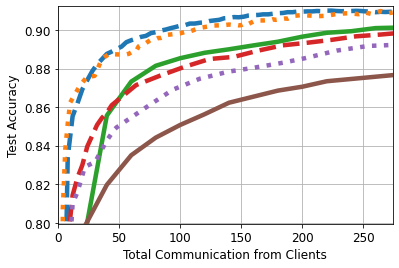

<Figure size 1296x36 with 0 Axes>

noniid= 0.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


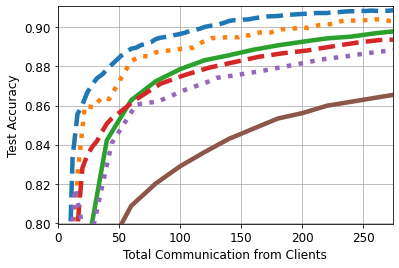

<Figure size 1296x36 with 0 Axes>

noniid= 0.9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


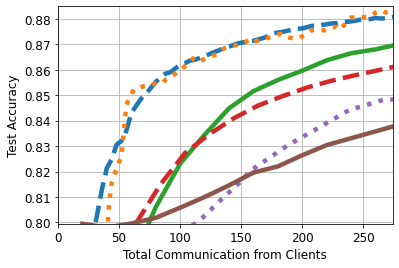

<Figure size 1296x36 with 0 Axes>

noniid= 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


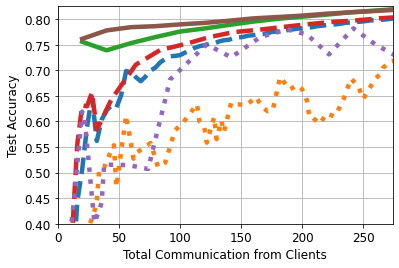

<Figure size 1296x36 with 0 Axes>

In [ ]:
draw_all(mnist_stats, "MNIST", ["Round", "Random", "Full"])

noniid= 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


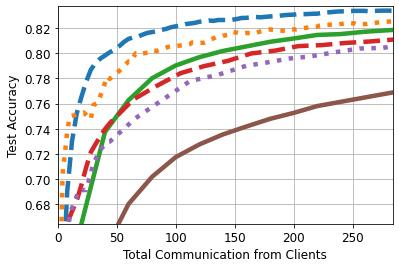

<Figure size 1296x36 with 0 Axes>

noniid= 0.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


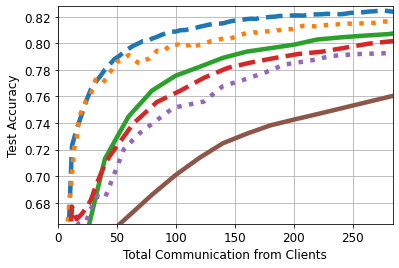

<Figure size 1296x36 with 0 Axes>

noniid= 0.9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


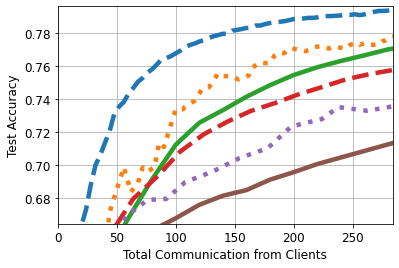

<Figure size 1296x36 with 0 Axes>

noniid= 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


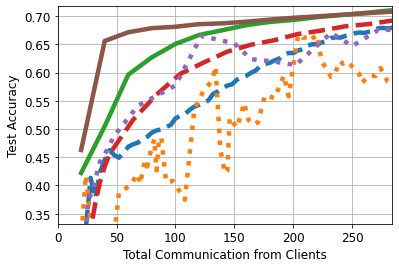

<Figure size 1296x36 with 0 Axes>

In [ ]:
draw_all(fashion_stats, "FashionMNIST", ["Round", "Random", "Full"])

noniid= 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


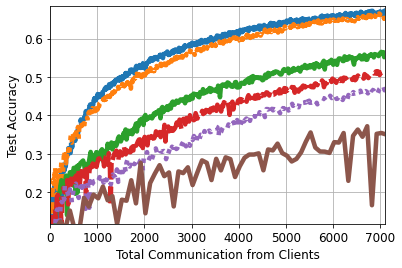

<Figure size 1296x36 with 0 Axes>

noniid= 0.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


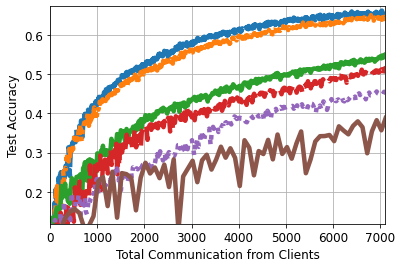

<Figure size 1296x36 with 0 Axes>

noniid= 0.9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


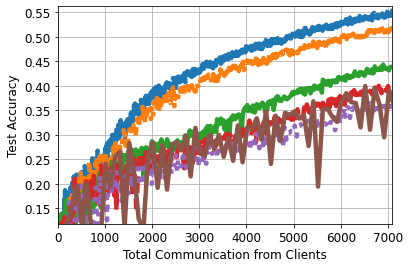

<Figure size 1296x36 with 0 Axes>

noniid= 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


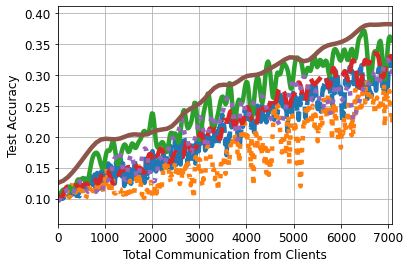

<Figure size 1296x36 with 0 Axes>

In [ ]:
draw_all(cifar_stats, "CIFAR", ["Round", "Random", "Full"], True)